In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (EfficientNetV2B0)

2024-02-21 08:25:26.903500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 08:25:26.903594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 08:25:27.032823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'/train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(EfficientNetV2B0(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("EfficientNetV2B0"+s+".keras")
    

    # save model to disk
    filename = "EfficientNetV2B0" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetv2-b0 (Functio  (None, 4)                 5924436   


 nal)                                                            


Total params: 5924436 (22.60 MB)


Trainable params: 5863828 (22.37 MB)


Non-trainable params: 60608 (236.75 KB)


_________________________________________________________________


Epoch 1/30


2024-02-21 08:26:14.573377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708503979.733031      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:40:25 - loss: 3.9572 - accuracy: 0.1250

  2/140 [..............................] - ETA: 13s - loss: 5.7985 - accuracy: 0.1406    

  3/140 [..............................] - ETA: 13s - loss: 5.2398 - accuracy: 0.1875

  4/140 [..............................] - ETA: 12s - loss: 4.5327 - accuracy: 0.2266

  5/140 [>.............................] - ETA: 12s - loss: 4.6764 - accuracy: 0.2313

  6/140 [>.............................] - ETA: 12s - loss: 4.4244 - accuracy: 0.2708

  7/140 [>.............................] - ETA: 12s - loss: 4.4115 - accuracy: 0.2768

  8/140 [>.............................] - ETA: 12s - loss: 4.3749 - accuracy: 0.2812

  9/140 [>.............................] - ETA: 12s - loss: 4.2038 - accuracy: 0.2951

 10/140 [=>............................] - ETA: 12s - loss: 4.1981 - accuracy: 0.3094

 11/140 [=>............................] - ETA: 12s - loss: 4.0281 - accuracy: 0.3153

 12/140 [=>............................] - ETA: 11s - loss: 3.9232 - accuracy: 0.3229

 13/140 [=>............................] - ETA: 11s - loss: 3.9500 - accuracy: 0.3293

 14/140 [==>...........................] - ETA: 11s - loss: 3.9017 - accuracy: 0.3281

 15/140 [==>...........................] - ETA: 11s - loss: 3.7790 - accuracy: 0.3250

 16/140 [==>...........................] - ETA: 11s - loss: 3.7277 - accuracy: 0.3301

 17/140 [==>...........................] - ETA: 11s - loss: 3.6240 - accuracy: 0.3401

 18/140 [==>...........................] - ETA: 11s - loss: 3.5624 - accuracy: 0.3368

 19/140 [===>..........................] - ETA: 11s - loss: 3.5172 - accuracy: 0.3405

 20/140 [===>..........................] - ETA: 11s - loss: 3.5499 - accuracy: 0.3453

 21/140 [===>..........................] - ETA: 11s - loss: 3.6675 - accuracy: 0.3408

 22/140 [===>..........................] - ETA: 10s - loss: 3.6165 - accuracy: 0.3480

 23/140 [===>..........................] - ETA: 10s - loss: 3.5415 - accuracy: 0.3533

 24/140 [====>.........................] - ETA: 10s - loss: 3.5143 - accuracy: 0.3529

 25/140 [====>.........................] - ETA: 10s - loss: 3.4531 - accuracy: 0.3575

 26/140 [====>.........................] - ETA: 10s - loss: 3.4061 - accuracy: 0.3558

 27/140 [====>.........................] - ETA: 10s - loss: 3.3284 - accuracy: 0.3646

 28/140 [=====>........................] - ETA: 10s - loss: 3.2557 - accuracy: 0.3672

 29/140 [=====>........................] - ETA: 10s - loss: 3.2136 - accuracy: 0.3685

 30/140 [=====>........................] - ETA: 10s - loss: 3.1362 - accuracy: 0.3771

 31/140 [=====>........................] - ETA: 10s - loss: 3.0965 - accuracy: 0.3800

 32/140 [=====>........................] - ETA: 9s - loss: 3.0602 - accuracy: 0.3818 

 33/140 [======>.......................] - ETA: 9s - loss: 3.0287 - accuracy: 0.3864

 34/140 [======>.......................] - ETA: 9s - loss: 3.0222 - accuracy: 0.3851

 35/140 [======>.......................] - ETA: 9s - loss: 2.9944 - accuracy: 0.3875

 36/140 [======>.......................] - ETA: 9s - loss: 2.9556 - accuracy: 0.3898

 37/140 [======>.......................] - ETA: 9s - loss: 2.9309 - accuracy: 0.3843

 38/140 [=======>......................] - ETA: 9s - loss: 2.8875 - accuracy: 0.3849

 39/140 [=======>......................] - ETA: 9s - loss: 2.8497 - accuracy: 0.3814

 40/140 [=======>......................] - ETA: 9s - loss: 2.8148 - accuracy: 0.3828

 41/140 [=======>......................] - ETA: 9s - loss: 2.7758 - accuracy: 0.3834

 42/140 [========>.....................] - ETA: 9s - loss: 2.7557 - accuracy: 0.3862

 43/140 [========>.....................] - ETA: 8s - loss: 2.7242 - accuracy: 0.3888

 44/140 [========>.....................] - ETA: 8s - loss: 2.6866 - accuracy: 0.3906

 45/140 [========>.....................] - ETA: 8s - loss: 2.6637 - accuracy: 0.3944

 46/140 [========>.....................] - ETA: 8s - loss: 2.6718 - accuracy: 0.3933

 47/140 [=========>....................] - ETA: 8s - loss: 2.6789 - accuracy: 0.3930

 48/140 [=========>....................] - ETA: 8s - loss: 2.6542 - accuracy: 0.3932

 49/140 [=========>....................] - ETA: 8s - loss: 2.6332 - accuracy: 0.3960

 50/140 [=========>....................] - ETA: 8s - loss: 2.6191 - accuracy: 0.3969

 51/140 [=========>....................] - ETA: 8s - loss: 2.5871 - accuracy: 0.3989

 52/140 [==========>...................] - ETA: 8s - loss: 2.5801 - accuracy: 0.4002

 53/140 [==========>...................] - ETA: 8s - loss: 2.5501 - accuracy: 0.4027

 54/140 [==========>...................] - ETA: 7s - loss: 2.5263 - accuracy: 0.4051

 55/140 [==========>...................] - ETA: 7s - loss: 2.5176 - accuracy: 0.4057

 56/140 [===========>..................] - ETA: 7s - loss: 2.4947 - accuracy: 0.4068

 57/140 [===========>..................] - ETA: 7s - loss: 2.4753 - accuracy: 0.4062

 58/140 [===========>..................] - ETA: 7s - loss: 2.4533 - accuracy: 0.4068

 59/140 [===========>..................] - ETA: 7s - loss: 2.4511 - accuracy: 0.4078

 60/140 [===========>..................] - ETA: 7s - loss: 2.4352 - accuracy: 0.4099

 61/140 [============>.................] - ETA: 7s - loss: 2.4158 - accuracy: 0.4109

 62/140 [============>.................] - ETA: 7s - loss: 2.3920 - accuracy: 0.4148

 63/140 [============>.................] - ETA: 7s - loss: 2.3724 - accuracy: 0.4157

 64/140 [============>.................] - ETA: 7s - loss: 2.3495 - accuracy: 0.4180

 65/140 [============>.................] - ETA: 6s - loss: 2.3313 - accuracy: 0.4183

 66/140 [=============>................] - ETA: 6s - loss: 2.3132 - accuracy: 0.4176

 67/140 [=============>................] - ETA: 6s - loss: 2.2984 - accuracy: 0.4184

 68/140 [=============>................] - ETA: 6s - loss: 2.2947 - accuracy: 0.4196

 69/140 [=============>................] - ETA: 6s - loss: 2.2778 - accuracy: 0.4203

 70/140 [==============>...............] - ETA: 6s - loss: 2.2636 - accuracy: 0.4228

 71/140 [==============>...............] - ETA: 6s - loss: 2.2444 - accuracy: 0.4256

 72/140 [==============>...............] - ETA: 6s - loss: 2.2303 - accuracy: 0.4262

 73/140 [==============>...............] - ETA: 6s - loss: 2.2145 - accuracy: 0.4281

 74/140 [==============>...............] - ETA: 6s - loss: 2.2263 - accuracy: 0.4291

 75/140 [===============>..............] - ETA: 6s - loss: 2.2114 - accuracy: 0.4279

 76/140 [===============>..............] - ETA: 5s - loss: 2.2090 - accuracy: 0.4280

 77/140 [===============>..............] - ETA: 5s - loss: 2.1931 - accuracy: 0.4298

 78/140 [===============>..............] - ETA: 5s - loss: 2.1897 - accuracy: 0.4303

 79/140 [===============>..............] - ETA: 5s - loss: 2.1894 - accuracy: 0.4288

 80/140 [================>.............] - ETA: 5s - loss: 2.1731 - accuracy: 0.4301

 81/140 [================>.............] - ETA: 5s - loss: 2.1573 - accuracy: 0.4313

 82/140 [================>.............] - ETA: 5s - loss: 2.1428 - accuracy: 0.4325

 83/140 [================>.............] - ETA: 5s - loss: 2.1376 - accuracy: 0.4319

 84/140 [=================>............] - ETA: 5s - loss: 2.1447 - accuracy: 0.4323

 85/140 [=================>............] - ETA: 5s - loss: 2.1363 - accuracy: 0.4316

 86/140 [=================>............] - ETA: 4s - loss: 2.1259 - accuracy: 0.4306

 87/140 [=================>............] - ETA: 4s - loss: 2.1143 - accuracy: 0.4307

 88/140 [=================>............] - ETA: 4s - loss: 2.1047 - accuracy: 0.4318

 89/140 [==================>...........] - ETA: 4s - loss: 2.0975 - accuracy: 0.4315

 90/140 [==================>...........] - ETA: 4s - loss: 2.0874 - accuracy: 0.4319

 91/140 [==================>...........] - ETA: 4s - loss: 2.0773 - accuracy: 0.4330

 92/140 [==================>...........] - ETA: 4s - loss: 2.0646 - accuracy: 0.4351

 93/140 [==================>...........] - ETA: 4s - loss: 2.0521 - accuracy: 0.4375

 94/140 [===================>..........] - ETA: 4s - loss: 2.0408 - accuracy: 0.4378

 95/140 [===================>..........] - ETA: 4s - loss: 2.0317 - accuracy: 0.4391

 96/140 [===================>..........] - ETA: 4s - loss: 2.0193 - accuracy: 0.4404

 97/140 [===================>..........] - ETA: 3s - loss: 2.0094 - accuracy: 0.4410

 98/140 [====================>.........] - ETA: 3s - loss: 2.0013 - accuracy: 0.4413

 99/140 [====================>.........] - ETA: 3s - loss: 1.9897 - accuracy: 0.4422

100/140 [====================>.........] - ETA: 3s - loss: 1.9807 - accuracy: 0.4428

101/140 [====================>.........] - ETA: 3s - loss: 1.9717 - accuracy: 0.4434

102/140 [====================>.........] - ETA: 3s - loss: 1.9803 - accuracy: 0.4433

103/140 [=====================>........] - ETA: 3s - loss: 1.9715 - accuracy: 0.4442

104/140 [=====================>........] - ETA: 3s - loss: 1.9608 - accuracy: 0.4456

105/140 [=====================>........] - ETA: 3s - loss: 1.9523 - accuracy: 0.4458

106/140 [=====================>........] - ETA: 3s - loss: 1.9422 - accuracy: 0.4472

107/140 [=====================>........] - ETA: 3s - loss: 1.9358 - accuracy: 0.4468

108/140 [======================>.......] - ETA: 2s - loss: 1.9275 - accuracy: 0.4473

109/140 [======================>.......] - ETA: 2s - loss: 1.9390 - accuracy: 0.4475

110/140 [======================>.......] - ETA: 2s - loss: 1.9312 - accuracy: 0.4474

111/140 [======================>.......] - ETA: 2s - loss: 1.9339 - accuracy: 0.4471

112/140 [=======================>......] - ETA: 2s - loss: 1.9269 - accuracy: 0.4470

113/140 [=======================>......] - ETA: 2s - loss: 1.9193 - accuracy: 0.4486

114/140 [=======================>......] - ETA: 2s - loss: 1.9154 - accuracy: 0.4485

115/140 [=======================>......] - ETA: 2s - loss: 1.9163 - accuracy: 0.4481

116/140 [=======================>......] - ETA: 2s - loss: 1.9086 - accuracy: 0.4485

117/140 [========================>.....] - ETA: 2s - loss: 1.9154 - accuracy: 0.4498

118/140 [========================>.....] - ETA: 2s - loss: 1.9131 - accuracy: 0.4484

119/140 [========================>.....] - ETA: 1s - loss: 1.9083 - accuracy: 0.4485

120/140 [========================>.....] - ETA: 1s - loss: 1.9042 - accuracy: 0.4477

121/140 [========================>.....] - ETA: 1s - loss: 1.8965 - accuracy: 0.4481

122/140 [=========================>....] - ETA: 1s - loss: 1.8962 - accuracy: 0.4485

123/140 [=========================>....] - ETA: 1s - loss: 1.8882 - accuracy: 0.4494

124/140 [=========================>....] - ETA: 1s - loss: 1.8826 - accuracy: 0.4491

125/140 [=========================>....] - ETA: 1s - loss: 1.8780 - accuracy: 0.4498

126/140 [==========================>...] - ETA: 1s - loss: 1.8696 - accuracy: 0.4511

127/140 [==========================>...] - ETA: 1s - loss: 1.8682 - accuracy: 0.4513

128/140 [==========================>...] - ETA: 1s - loss: 1.8640 - accuracy: 0.4507

129/140 [==========================>...] - ETA: 1s - loss: 1.8587 - accuracy: 0.4516

130/140 [==========================>...] - ETA: 0s - loss: 1.8585 - accuracy: 0.4502

131/140 [===========================>..] - ETA: 0s - loss: 1.8559 - accuracy: 0.4504

132/140 [===========================>..] - ETA: 0s - loss: 1.8499 - accuracy: 0.4512

133/140 [===========================>..] - ETA: 0s - loss: 1.8446 - accuracy: 0.4514

134/140 [===========================>..] - ETA: 0s - loss: 1.8459 - accuracy: 0.4506

135/140 [===========================>..] - ETA: 0s - loss: 1.8400 - accuracy: 0.4512

136/140 [============================>.] - ETA: 0s - loss: 1.8353 - accuracy: 0.4506

137/140 [============================>.] - ETA: 0s - loss: 1.8290 - accuracy: 0.4514

138/140 [============================>.] - ETA: 0s - loss: 1.8237 - accuracy: 0.4511

139/140 [============================>.] - ETA: 0s - loss: 1.8185 - accuracy: 0.4519

140/140 [==============================] - ETA: 0s - loss: 1.8170 - accuracy: 0.4520

140/140 [==============================] - 62s 136ms/step - loss: 1.8170 - accuracy: 0.4520 - val_loss: 1.0336 - val_accuracy: 0.5301


Epoch 2/30


  1/140 [..............................] - ETA: 39s - loss: 1.2984 - accuracy: 0.4375

  2/140 [..............................] - ETA: 13s - loss: 1.1415 - accuracy: 0.5156

  3/140 [..............................] - ETA: 12s - loss: 1.0672 - accuracy: 0.5312

  4/140 [..............................] - ETA: 12s - loss: 1.0515 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 12s - loss: 1.1842 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 12s - loss: 1.1995 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 12s - loss: 1.2125 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 12s - loss: 1.1777 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 12s - loss: 1.1546 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 12s - loss: 1.2715 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 12s - loss: 1.2692 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 11s - loss: 1.2560 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 11s - loss: 1.2461 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 11s - loss: 1.2389 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 11s - loss: 1.2166 - accuracy: 0.4771

 16/140 [==>...........................] - ETA: 11s - loss: 1.2137 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 11s - loss: 1.2024 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 11s - loss: 1.1902 - accuracy: 0.4792

 19/140 [===>..........................] - ETA: 11s - loss: 1.1950 - accuracy: 0.4770

 20/140 [===>..........................] - ETA: 11s - loss: 1.1841 - accuracy: 0.4781

 21/140 [===>..........................] - ETA: 11s - loss: 1.1794 - accuracy: 0.4762

 22/140 [===>..........................] - ETA: 10s - loss: 1.1761 - accuracy: 0.4702

 23/140 [===>..........................] - ETA: 10s - loss: 1.1762 - accuracy: 0.4701

 24/140 [====>.........................] - ETA: 10s - loss: 1.1649 - accuracy: 0.4753

 25/140 [====>.........................] - ETA: 10s - loss: 1.1583 - accuracy: 0.4725

 26/140 [====>.........................] - ETA: 10s - loss: 1.1499 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 10s - loss: 1.1467 - accuracy: 0.4722

 28/140 [=====>........................] - ETA: 10s - loss: 1.1387 - accuracy: 0.4766

 29/140 [=====>........................] - ETA: 10s - loss: 1.1368 - accuracy: 0.4720

 30/140 [=====>........................] - ETA: 10s - loss: 1.1384 - accuracy: 0.4698

 31/140 [=====>........................] - ETA: 10s - loss: 1.1360 - accuracy: 0.4698

 32/140 [=====>........................] - ETA: 10s - loss: 1.1336 - accuracy: 0.4707

 33/140 [======>.......................] - ETA: 9s - loss: 1.1257 - accuracy: 0.4744 

 34/140 [======>.......................] - ETA: 9s - loss: 1.1333 - accuracy: 0.4706

 35/140 [======>.......................] - ETA: 9s - loss: 1.1301 - accuracy: 0.4705

 36/140 [======>.......................] - ETA: 9s - loss: 1.1259 - accuracy: 0.4705

 37/140 [======>.......................] - ETA: 9s - loss: 1.1188 - accuracy: 0.4713

 38/140 [=======>......................] - ETA: 9s - loss: 1.1120 - accuracy: 0.4745

 39/140 [=======>......................] - ETA: 9s - loss: 1.1137 - accuracy: 0.4744

 40/140 [=======>......................] - ETA: 9s - loss: 1.1055 - accuracy: 0.4789

 41/140 [=======>......................] - ETA: 9s - loss: 1.1023 - accuracy: 0.4771

 42/140 [========>.....................] - ETA: 9s - loss: 1.0997 - accuracy: 0.4807

 43/140 [========>.....................] - ETA: 8s - loss: 1.0940 - accuracy: 0.4826

 44/140 [========>.....................] - ETA: 8s - loss: 1.0861 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 8s - loss: 1.0885 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 8s - loss: 1.0856 - accuracy: 0.4898

 47/140 [=========>....................] - ETA: 8s - loss: 1.0819 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 8s - loss: 1.0820 - accuracy: 0.4941

 49/140 [=========>....................] - ETA: 8s - loss: 1.0773 - accuracy: 0.4968

 50/140 [=========>....................] - ETA: 8s - loss: 1.0693 - accuracy: 0.5019

 51/140 [=========>....................] - ETA: 8s - loss: 1.0707 - accuracy: 0.4994

 52/140 [==========>...................] - ETA: 8s - loss: 1.0693 - accuracy: 0.5006

 53/140 [==========>...................] - ETA: 8s - loss: 1.0649 - accuracy: 0.5024

 54/140 [==========>...................] - ETA: 8s - loss: 1.0621 - accuracy: 0.5017

 55/140 [==========>...................] - ETA: 7s - loss: 1.0633 - accuracy: 0.5000

 56/140 [===========>..................] - ETA: 7s - loss: 1.0872 - accuracy: 0.5006

 57/140 [===========>..................] - ETA: 7s - loss: 1.0866 - accuracy: 0.5011

 58/140 [===========>..................] - ETA: 7s - loss: 1.0829 - accuracy: 0.5016

 59/140 [===========>..................] - ETA: 7s - loss: 1.0807 - accuracy: 0.5042

 60/140 [===========>..................] - ETA: 7s - loss: 1.0758 - accuracy: 0.5063

 61/140 [============>.................] - ETA: 7s - loss: 1.0745 - accuracy: 0.5061

 62/140 [============>.................] - ETA: 7s - loss: 1.0709 - accuracy: 0.5096

 63/140 [============>.................] - ETA: 7s - loss: 1.0745 - accuracy: 0.5069

 64/140 [============>.................] - ETA: 7s - loss: 1.0712 - accuracy: 0.5078

 65/140 [============>.................] - ETA: 6s - loss: 1.0719 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 6s - loss: 1.0786 - accuracy: 0.5043

 67/140 [=============>................] - ETA: 6s - loss: 1.0765 - accuracy: 0.5037

 68/140 [=============>................] - ETA: 6s - loss: 1.0756 - accuracy: 0.5028

 69/140 [=============>................] - ETA: 6s - loss: 1.0734 - accuracy: 0.5036

 70/140 [==============>...............] - ETA: 6s - loss: 1.0722 - accuracy: 0.5040

 71/140 [==============>...............] - ETA: 6s - loss: 1.0665 - accuracy: 0.5062

 72/140 [==============>...............] - ETA: 6s - loss: 1.0646 - accuracy: 0.5065

 73/140 [==============>...............] - ETA: 6s - loss: 1.0628 - accuracy: 0.5077

 74/140 [==============>...............] - ETA: 6s - loss: 1.0636 - accuracy: 0.5063

 75/140 [===============>..............] - ETA: 6s - loss: 1.0619 - accuracy: 0.5050

 76/140 [===============>..............] - ETA: 5s - loss: 1.0584 - accuracy: 0.5062

 77/140 [===============>..............] - ETA: 5s - loss: 1.0553 - accuracy: 0.5069

 78/140 [===============>..............] - ETA: 5s - loss: 1.0552 - accuracy: 0.5068

 79/140 [===============>..............] - ETA: 5s - loss: 1.0531 - accuracy: 0.5079

 80/140 [================>.............] - ETA: 5s - loss: 1.0558 - accuracy: 0.5098

 81/140 [================>.............] - ETA: 5s - loss: 1.0529 - accuracy: 0.5120

 82/140 [================>.............] - ETA: 5s - loss: 1.0503 - accuracy: 0.5126

 83/140 [================>.............] - ETA: 5s - loss: 1.0450 - accuracy: 0.5154

 84/140 [=================>............] - ETA: 5s - loss: 1.0436 - accuracy: 0.5167

 85/140 [=================>............] - ETA: 5s - loss: 1.0455 - accuracy: 0.5162

 86/140 [=================>............] - ETA: 5s - loss: 1.0480 - accuracy: 0.5145

 87/140 [=================>............] - ETA: 4s - loss: 1.0693 - accuracy: 0.5154

 88/140 [=================>............] - ETA: 4s - loss: 1.0663 - accuracy: 0.5160

 89/140 [==================>...........] - ETA: 4s - loss: 1.0686 - accuracy: 0.5151

 90/140 [==================>...........] - ETA: 4s - loss: 1.0657 - accuracy: 0.5163

 91/140 [==================>...........] - ETA: 4s - loss: 1.0652 - accuracy: 0.5179

 92/140 [==================>...........] - ETA: 4s - loss: 1.0639 - accuracy: 0.5187

 93/140 [==================>...........] - ETA: 4s - loss: 1.0679 - accuracy: 0.5192

 94/140 [===================>..........] - ETA: 4s - loss: 1.0666 - accuracy: 0.5203

 95/140 [===================>..........] - ETA: 4s - loss: 1.0655 - accuracy: 0.5204

 96/140 [===================>..........] - ETA: 4s - loss: 1.0628 - accuracy: 0.5208

 97/140 [===================>..........] - ETA: 3s - loss: 1.0625 - accuracy: 0.5203

 98/140 [====================>.........] - ETA: 3s - loss: 1.0623 - accuracy: 0.5195

 99/140 [====================>.........] - ETA: 3s - loss: 1.0608 - accuracy: 0.5196

100/140 [====================>.........] - ETA: 3s - loss: 1.0610 - accuracy: 0.5194

101/140 [====================>.........] - ETA: 3s - loss: 1.0614 - accuracy: 0.5192

102/140 [====================>.........] - ETA: 3s - loss: 1.0608 - accuracy: 0.5190

103/140 [=====================>........] - ETA: 3s - loss: 1.0720 - accuracy: 0.5188

104/140 [=====================>........] - ETA: 3s - loss: 1.0711 - accuracy: 0.5189

105/140 [=====================>........] - ETA: 3s - loss: 1.0688 - accuracy: 0.5196

106/140 [=====================>........] - ETA: 3s - loss: 1.0739 - accuracy: 0.5192

107/140 [=====================>........] - ETA: 3s - loss: 1.0737 - accuracy: 0.5187

108/140 [======================>.......] - ETA: 2s - loss: 1.0741 - accuracy: 0.5191

109/140 [======================>.......] - ETA: 2s - loss: 1.0731 - accuracy: 0.5201

110/140 [======================>.......] - ETA: 2s - loss: 1.0798 - accuracy: 0.5202

111/140 [======================>.......] - ETA: 2s - loss: 1.0863 - accuracy: 0.5183

112/140 [=======================>......] - ETA: 2s - loss: 1.0846 - accuracy: 0.5190

113/140 [=======================>......] - ETA: 2s - loss: 1.0954 - accuracy: 0.5169

114/140 [=======================>......] - ETA: 2s - loss: 1.0962 - accuracy: 0.5175

115/140 [=======================>......] - ETA: 2s - loss: 1.0987 - accuracy: 0.5171

116/140 [=======================>......] - ETA: 2s - loss: 1.0975 - accuracy: 0.5167

117/140 [========================>.....] - ETA: 2s - loss: 1.1095 - accuracy: 0.5150

118/140 [========================>.....] - ETA: 2s - loss: 1.1106 - accuracy: 0.5146

119/140 [========================>.....] - ETA: 1s - loss: 1.1108 - accuracy: 0.5131

120/140 [========================>.....] - ETA: 1s - loss: 1.1103 - accuracy: 0.5122

121/140 [========================>.....] - ETA: 1s - loss: 1.1086 - accuracy: 0.5119

122/140 [=========================>....] - ETA: 1s - loss: 1.1137 - accuracy: 0.5097

123/140 [=========================>....] - ETA: 1s - loss: 1.1146 - accuracy: 0.5102

124/140 [=========================>....] - ETA: 1s - loss: 1.1154 - accuracy: 0.5101

125/140 [=========================>....] - ETA: 1s - loss: 1.1181 - accuracy: 0.5092

126/140 [==========================>...] - ETA: 1s - loss: 1.1189 - accuracy: 0.5082

127/140 [==========================>...] - ETA: 1s - loss: 1.1173 - accuracy: 0.5081

128/140 [==========================>...] - ETA: 1s - loss: 1.1168 - accuracy: 0.5071

129/140 [==========================>...] - ETA: 1s - loss: 1.1165 - accuracy: 0.5068

130/140 [==========================>...] - ETA: 0s - loss: 1.1169 - accuracy: 0.5063

131/140 [===========================>..] - ETA: 0s - loss: 1.1190 - accuracy: 0.5050

132/140 [===========================>..] - ETA: 0s - loss: 1.1186 - accuracy: 0.5043

133/140 [===========================>..] - ETA: 0s - loss: 1.1190 - accuracy: 0.5031

134/140 [===========================>..] - ETA: 0s - loss: 1.1186 - accuracy: 0.5026

135/140 [===========================>..] - ETA: 0s - loss: 1.1171 - accuracy: 0.5023

136/140 [============================>.] - ETA: 0s - loss: 1.1288 - accuracy: 0.5021

137/140 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.5009

138/140 [============================>.] - ETA: 0s - loss: 1.1289 - accuracy: 0.5011

139/140 [============================>.] - ETA: 0s - loss: 1.1289 - accuracy: 0.5007

140/140 [==============================] - 14s 100ms/step - loss: 1.1281 - accuracy: 0.5013 - val_loss: 1.0072 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 31s - loss: 0.9945 - accuracy: 0.5000

  2/140 [..............................] - ETA: 12s - loss: 1.2161 - accuracy: 0.5312

  3/140 [..............................] - ETA: 12s - loss: 1.0708 - accuracy: 0.6146

  4/140 [..............................] - ETA: 12s - loss: 1.0321 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 12s - loss: 1.0816 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 12s - loss: 1.1035 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 12s - loss: 1.1391 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 12s - loss: 1.1427 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 12s - loss: 1.1156 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 12s - loss: 1.0929 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 11s - loss: 1.0785 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 11s - loss: 1.2202 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 11s - loss: 1.2006 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 11s - loss: 1.1871 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 11s - loss: 1.1922 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 11s - loss: 1.1838 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 11s - loss: 1.1773 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 11s - loss: 1.1644 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 11s - loss: 1.1540 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 11s - loss: 1.1469 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 10s - loss: 1.1375 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 10s - loss: 1.1265 - accuracy: 0.5227

 23/140 [===>..........................] - ETA: 10s - loss: 1.1214 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 10s - loss: 1.1156 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 10s - loss: 1.1093 - accuracy: 0.5150

 26/140 [====>.........................] - ETA: 10s - loss: 1.1054 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 10s - loss: 1.1020 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 10s - loss: 1.0935 - accuracy: 0.5123

 29/140 [=====>........................] - ETA: 10s - loss: 1.0834 - accuracy: 0.5162

 30/140 [=====>........................] - ETA: 10s - loss: 1.0812 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 10s - loss: 1.0855 - accuracy: 0.5151

 32/140 [=====>........................] - ETA: 9s - loss: 1.0831 - accuracy: 0.5146 

 33/140 [======>.......................] - ETA: 9s - loss: 1.0787 - accuracy: 0.5142

 34/140 [======>.......................] - ETA: 9s - loss: 1.0714 - accuracy: 0.5138

 35/140 [======>.......................] - ETA: 9s - loss: 1.0715 - accuracy: 0.5107

 36/140 [======>.......................] - ETA: 9s - loss: 1.0675 - accuracy: 0.5113

 37/140 [======>.......................] - ETA: 9s - loss: 1.0636 - accuracy: 0.5101

 38/140 [=======>......................] - ETA: 9s - loss: 1.0596 - accuracy: 0.5090

 39/140 [=======>......................] - ETA: 9s - loss: 1.0526 - accuracy: 0.5112

 40/140 [=======>......................] - ETA: 9s - loss: 1.0471 - accuracy: 0.5141

 41/140 [=======>......................] - ETA: 9s - loss: 1.0465 - accuracy: 0.5145

 42/140 [========>.....................] - ETA: 9s - loss: 1.0400 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 8s - loss: 1.0382 - accuracy: 0.5174

 44/140 [========>.....................] - ETA: 8s - loss: 1.0331 - accuracy: 0.5185

 45/140 [========>.....................] - ETA: 8s - loss: 1.0270 - accuracy: 0.5229

 46/140 [========>.....................] - ETA: 8s - loss: 1.0608 - accuracy: 0.5224

 47/140 [=========>....................] - ETA: 8s - loss: 1.0611 - accuracy: 0.5199

 48/140 [=========>....................] - ETA: 8s - loss: 1.0587 - accuracy: 0.5189

 49/140 [=========>....................] - ETA: 8s - loss: 1.0577 - accuracy: 0.5198

 50/140 [=========>....................] - ETA: 8s - loss: 1.0532 - accuracy: 0.5188

 51/140 [=========>....................] - ETA: 8s - loss: 1.0484 - accuracy: 0.5196

 52/140 [==========>...................] - ETA: 8s - loss: 1.0469 - accuracy: 0.5186

 53/140 [==========>...................] - ETA: 8s - loss: 1.0444 - accuracy: 0.5183

 54/140 [==========>...................] - ETA: 7s - loss: 1.0413 - accuracy: 0.5208

 55/140 [==========>...................] - ETA: 7s - loss: 1.0363 - accuracy: 0.5222

 56/140 [===========>..................] - ETA: 7s - loss: 1.0332 - accuracy: 0.5212

 57/140 [===========>..................] - ETA: 7s - loss: 1.0332 - accuracy: 0.5208

 58/140 [===========>..................] - ETA: 7s - loss: 1.0303 - accuracy: 0.5216

 59/140 [===========>..................] - ETA: 7s - loss: 1.0301 - accuracy: 0.5238

 60/140 [===========>..................] - ETA: 7s - loss: 1.0303 - accuracy: 0.5224

 61/140 [============>.................] - ETA: 7s - loss: 1.0259 - accuracy: 0.5236

 62/140 [============>.................] - ETA: 7s - loss: 1.0266 - accuracy: 0.5222

 63/140 [============>.................] - ETA: 7s - loss: 1.0285 - accuracy: 0.5208

 64/140 [============>.................] - ETA: 7s - loss: 1.0302 - accuracy: 0.5229

 65/140 [============>.................] - ETA: 6s - loss: 1.0262 - accuracy: 0.5245

 66/140 [=============>................] - ETA: 6s - loss: 1.0236 - accuracy: 0.5256

 67/140 [=============>................] - ETA: 6s - loss: 1.0192 - accuracy: 0.5280

 68/140 [=============>................] - ETA: 6s - loss: 1.0165 - accuracy: 0.5285

 69/140 [=============>................] - ETA: 6s - loss: 1.0142 - accuracy: 0.5299

 70/140 [==============>...............] - ETA: 6s - loss: 1.0125 - accuracy: 0.5308

 71/140 [==============>...............] - ETA: 6s - loss: 1.0100 - accuracy: 0.5326

 72/140 [==============>...............] - ETA: 6s - loss: 1.0072 - accuracy: 0.5321

 73/140 [==============>...............] - ETA: 6s - loss: 1.0091 - accuracy: 0.5330

 74/140 [==============>...............] - ETA: 6s - loss: 1.0096 - accuracy: 0.5325

 75/140 [===============>..............] - ETA: 6s - loss: 1.0094 - accuracy: 0.5312

 76/140 [===============>..............] - ETA: 5s - loss: 1.0076 - accuracy: 0.5312

 77/140 [===============>..............] - ETA: 5s - loss: 1.0071 - accuracy: 0.5317

 78/140 [===============>..............] - ETA: 5s - loss: 1.0081 - accuracy: 0.5317

 79/140 [===============>..............] - ETA: 5s - loss: 1.0070 - accuracy: 0.5309

 80/140 [================>.............] - ETA: 5s - loss: 1.0078 - accuracy: 0.5301

 81/140 [================>.............] - ETA: 5s - loss: 1.0055 - accuracy: 0.5301

 82/140 [================>.............] - ETA: 5s - loss: 1.0038 - accuracy: 0.5301

 83/140 [================>.............] - ETA: 5s - loss: 1.0010 - accuracy: 0.5312

 84/140 [=================>............] - ETA: 5s - loss: 1.0021 - accuracy: 0.5301

 85/140 [=================>............] - ETA: 5s - loss: 1.0007 - accuracy: 0.5309

 86/140 [=================>............] - ETA: 4s - loss: 0.9993 - accuracy: 0.5309

 87/140 [=================>............] - ETA: 4s - loss: 1.0000 - accuracy: 0.5302

 88/140 [=================>............] - ETA: 4s - loss: 0.9991 - accuracy: 0.5305

 89/140 [==================>...........] - ETA: 4s - loss: 0.9977 - accuracy: 0.5298

 90/140 [==================>...........] - ETA: 4s - loss: 0.9965 - accuracy: 0.5306

 91/140 [==================>...........] - ETA: 4s - loss: 0.9959 - accuracy: 0.5312

 92/140 [==================>...........] - ETA: 4s - loss: 0.9950 - accuracy: 0.5306

 93/140 [==================>...........] - ETA: 4s - loss: 0.9925 - accuracy: 0.5316

 94/140 [===================>..........] - ETA: 4s - loss: 0.9929 - accuracy: 0.5316

 95/140 [===================>..........] - ETA: 4s - loss: 0.9925 - accuracy: 0.5312

 96/140 [===================>..........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5316

 97/140 [===================>..........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5329

 98/140 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5351

 99/140 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5360

100/140 [====================>.........] - ETA: 3s - loss: 0.9836 - accuracy: 0.5387

101/140 [====================>.........] - ETA: 3s - loss: 0.9831 - accuracy: 0.5396

102/140 [====================>.........] - ETA: 3s - loss: 0.9844 - accuracy: 0.5398

103/140 [=====================>........] - ETA: 3s - loss: 0.9830 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 3s - loss: 0.9801 - accuracy: 0.5418

105/140 [=====================>........] - ETA: 3s - loss: 0.9782 - accuracy: 0.5426

106/140 [=====================>........] - ETA: 3s - loss: 0.9775 - accuracy: 0.5433

107/140 [=====================>........] - ETA: 3s - loss: 0.9748 - accuracy: 0.5444

108/140 [======================>.......] - ETA: 2s - loss: 0.9746 - accuracy: 0.5443

109/140 [======================>.......] - ETA: 2s - loss: 0.9724 - accuracy: 0.5450

110/140 [======================>.......] - ETA: 2s - loss: 0.9710 - accuracy: 0.5457

111/140 [======================>.......] - ETA: 2s - loss: 0.9703 - accuracy: 0.5456

112/140 [=======================>......] - ETA: 2s - loss: 0.9711 - accuracy: 0.5449

113/140 [=======================>......] - ETA: 2s - loss: 0.9691 - accuracy: 0.5448

114/140 [=======================>......] - ETA: 2s - loss: 0.9677 - accuracy: 0.5463

115/140 [=======================>......] - ETA: 2s - loss: 0.9673 - accuracy: 0.5470

116/140 [=======================>......] - ETA: 2s - loss: 0.9654 - accuracy: 0.5474

117/140 [========================>.....] - ETA: 2s - loss: 0.9652 - accuracy: 0.5481

118/140 [========================>.....] - ETA: 2s - loss: 0.9638 - accuracy: 0.5482

119/140 [========================>.....] - ETA: 1s - loss: 0.9833 - accuracy: 0.5478

120/140 [========================>.....] - ETA: 1s - loss: 0.9839 - accuracy: 0.5474

121/140 [========================>.....] - ETA: 1s - loss: 0.9828 - accuracy: 0.5475

122/140 [=========================>....] - ETA: 1s - loss: 0.9821 - accuracy: 0.5482

123/140 [=========================>....] - ETA: 1s - loss: 0.9826 - accuracy: 0.5480

124/140 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5466

125/140 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5458

126/140 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.5471

127/140 [==========================>...] - ETA: 1s - loss: 0.9874 - accuracy: 0.5470

128/140 [==========================>...] - ETA: 1s - loss: 0.9899 - accuracy: 0.5469

129/140 [==========================>...] - ETA: 1s - loss: 0.9886 - accuracy: 0.5480

130/140 [==========================>...] - ETA: 0s - loss: 0.9873 - accuracy: 0.5483

131/140 [===========================>..] - ETA: 0s - loss: 0.9848 - accuracy: 0.5496

132/140 [===========================>..] - ETA: 0s - loss: 0.9831 - accuracy: 0.5502

133/140 [===========================>..] - ETA: 0s - loss: 0.9814 - accuracy: 0.5503

134/140 [===========================>..] - ETA: 0s - loss: 0.9815 - accuracy: 0.5497

135/140 [===========================>..] - ETA: 0s - loss: 0.9823 - accuracy: 0.5486

136/140 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5496

137/140 [============================>.] - ETA: 0s - loss: 0.9895 - accuracy: 0.5488

138/140 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.5489

139/140 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5492

140/140 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.5489

140/140 [==============================] - 14s 100ms/step - loss: 0.9880 - accuracy: 0.5489 - val_loss: 0.9656 - val_accuracy: 0.5293


Epoch 4/30


  1/140 [..............................] - ETA: 33s - loss: 0.7647 - accuracy: 0.6875

  2/140 [..............................] - ETA: 13s - loss: 0.7530 - accuracy: 0.6406

  3/140 [..............................] - ETA: 12s - loss: 1.0037 - accuracy: 0.5833

  4/140 [..............................] - ETA: 12s - loss: 0.9417 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 12s - loss: 0.9658 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 12s - loss: 0.9462 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 12s - loss: 0.9648 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 12s - loss: 0.9493 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 12s - loss: 0.9409 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 12s - loss: 0.9899 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 11s - loss: 0.9902 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 11s - loss: 0.9971 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 11s - loss: 0.9939 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 11s - loss: 0.9874 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 11s - loss: 0.9799 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 11s - loss: 0.9756 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 11s - loss: 0.9874 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 11s - loss: 0.9784 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 11s - loss: 0.9885 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 11s - loss: 0.9907 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 11s - loss: 0.9920 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 10s - loss: 0.9881 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 10s - loss: 0.9843 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 10s - loss: 0.9881 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 10s - loss: 0.9855 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 10s - loss: 0.9817 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 10s - loss: 0.9866 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 10s - loss: 0.9843 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 10s - loss: 0.9815 - accuracy: 0.5073

 31/140 [=====>........................] - ETA: 10s - loss: 0.9781 - accuracy: 0.5111

 32/140 [=====>........................] - ETA: 10s - loss: 0.9751 - accuracy: 0.5137

 33/140 [======>.......................] - ETA: 9s - loss: 0.9728 - accuracy: 0.5152 

 34/140 [======>.......................] - ETA: 9s - loss: 0.9680 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 9s - loss: 0.9661 - accuracy: 0.5188

 36/140 [======>.......................] - ETA: 9s - loss: 0.9639 - accuracy: 0.5182

 37/140 [======>.......................] - ETA: 9s - loss: 0.9616 - accuracy: 0.5186

 38/140 [=======>......................] - ETA: 9s - loss: 0.9622 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 9s - loss: 0.9547 - accuracy: 0.5224

 40/140 [=======>......................] - ETA: 9s - loss: 0.9493 - accuracy: 0.5242

 41/140 [=======>......................] - ETA: 9s - loss: 0.9464 - accuracy: 0.5259

 42/140 [========>.....................] - ETA: 9s - loss: 0.9399 - accuracy: 0.5305

 43/140 [========>.....................] - ETA: 8s - loss: 0.9388 - accuracy: 0.5298

 44/140 [========>.....................] - ETA: 8s - loss: 0.9319 - accuracy: 0.5334

 45/140 [========>.....................] - ETA: 8s - loss: 0.9295 - accuracy: 0.5354

 46/140 [========>.....................] - ETA: 8s - loss: 0.9314 - accuracy: 0.5360

 47/140 [=========>....................] - ETA: 8s - loss: 0.9269 - accuracy: 0.5386

 48/140 [=========>....................] - ETA: 8s - loss: 0.9258 - accuracy: 0.5397

 49/140 [=========>....................] - ETA: 8s - loss: 0.9657 - accuracy: 0.5402

 50/140 [=========>....................] - ETA: 8s - loss: 0.9738 - accuracy: 0.5375

 51/140 [=========>....................] - ETA: 8s - loss: 0.9711 - accuracy: 0.5392

 52/140 [==========>...................] - ETA: 8s - loss: 0.9649 - accuracy: 0.5421

 53/140 [==========>...................] - ETA: 8s - loss: 0.9640 - accuracy: 0.5419

 54/140 [==========>...................] - ETA: 7s - loss: 0.9635 - accuracy: 0.5422

 55/140 [==========>...................] - ETA: 7s - loss: 0.9580 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 7s - loss: 0.9567 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 7s - loss: 0.9494 - accuracy: 0.5493

 58/140 [===========>..................] - ETA: 7s - loss: 0.9438 - accuracy: 0.5523

 59/140 [===========>..................] - ETA: 7s - loss: 0.9411 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 7s - loss: 0.9390 - accuracy: 0.5526

 61/140 [============>.................] - ETA: 7s - loss: 0.9362 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 7s - loss: 0.9536 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 7s - loss: 0.9626 - accuracy: 0.5531

 64/140 [============>.................] - ETA: 7s - loss: 0.9738 - accuracy: 0.5537

 65/140 [============>.................] - ETA: 6s - loss: 0.9734 - accuracy: 0.5543

 66/140 [=============>................] - ETA: 6s - loss: 0.9820 - accuracy: 0.5559

 67/140 [=============>................] - ETA: 6s - loss: 0.9784 - accuracy: 0.5569

 68/140 [=============>................] - ETA: 6s - loss: 0.9842 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 6s - loss: 0.9847 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 6s - loss: 0.9829 - accuracy: 0.5589

 71/140 [==============>...............] - ETA: 6s - loss: 0.9841 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 6s - loss: 0.9800 - accuracy: 0.5582

 73/140 [==============>...............] - ETA: 6s - loss: 0.9791 - accuracy: 0.5582

 74/140 [==============>...............] - ETA: 6s - loss: 0.9804 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 6s - loss: 0.9781 - accuracy: 0.5587

 76/140 [===============>..............] - ETA: 5s - loss: 0.9752 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 5s - loss: 0.9741 - accuracy: 0.5601

 78/140 [===============>..............] - ETA: 5s - loss: 0.9736 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 5s - loss: 0.9842 - accuracy: 0.5613

 80/140 [================>.............] - ETA: 5s - loss: 0.9819 - accuracy: 0.5625

 81/140 [================>.............] - ETA: 5s - loss: 0.9855 - accuracy: 0.5610

 82/140 [================>.............] - ETA: 5s - loss: 0.9826 - accuracy: 0.5617

 83/140 [================>.............] - ETA: 5s - loss: 0.9845 - accuracy: 0.5610

 84/140 [=================>............] - ETA: 5s - loss: 0.9817 - accuracy: 0.5625

 85/140 [=================>............] - ETA: 5s - loss: 0.9807 - accuracy: 0.5621

 86/140 [=================>............] - ETA: 4s - loss: 0.9787 - accuracy: 0.5618

 87/140 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5625

 88/140 [=================>............] - ETA: 4s - loss: 0.9853 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 4s - loss: 0.9843 - accuracy: 0.5629

 90/140 [==================>...........] - ETA: 4s - loss: 0.9909 - accuracy: 0.5635

 91/140 [==================>...........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5628

 92/140 [==================>...........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5642

 93/140 [==================>...........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5642

 94/140 [===================>..........] - ETA: 4s - loss: 0.9894 - accuracy: 0.5645

 95/140 [===================>..........] - ETA: 4s - loss: 0.9891 - accuracy: 0.5651

 96/140 [===================>..........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5648

 97/140 [===================>..........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5654

 98/140 [====================>.........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5654

 99/140 [====================>.........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5634

100/140 [====================>.........] - ETA: 3s - loss: 1.0089 - accuracy: 0.5619

101/140 [====================>.........] - ETA: 3s - loss: 1.0283 - accuracy: 0.5603

102/140 [====================>.........] - ETA: 3s - loss: 1.0257 - accuracy: 0.5610

103/140 [=====================>........] - ETA: 3s - loss: 1.0287 - accuracy: 0.5613

104/140 [=====================>........] - ETA: 3s - loss: 1.0256 - accuracy: 0.5616

105/140 [=====================>........] - ETA: 3s - loss: 1.0346 - accuracy: 0.5604

106/140 [=====================>........] - ETA: 3s - loss: 1.0315 - accuracy: 0.5613

107/140 [=====================>........] - ETA: 3s - loss: 1.0306 - accuracy: 0.5616

108/140 [======================>.......] - ETA: 2s - loss: 1.0340 - accuracy: 0.5613

109/140 [======================>.......] - ETA: 2s - loss: 1.0333 - accuracy: 0.5614

110/140 [======================>.......] - ETA: 2s - loss: 1.0320 - accuracy: 0.5619

111/140 [======================>.......] - ETA: 2s - loss: 1.0291 - accuracy: 0.5625

112/140 [=======================>......] - ETA: 2s - loss: 1.0266 - accuracy: 0.5633

113/140 [=======================>......] - ETA: 2s - loss: 1.0247 - accuracy: 0.5647

114/140 [=======================>......] - ETA: 2s - loss: 1.0225 - accuracy: 0.5644

115/140 [=======================>......] - ETA: 2s - loss: 1.0213 - accuracy: 0.5639

116/140 [=======================>......] - ETA: 2s - loss: 1.0231 - accuracy: 0.5630

117/140 [========================>.....] - ETA: 2s - loss: 1.0213 - accuracy: 0.5630

118/140 [========================>.....] - ETA: 2s - loss: 1.0206 - accuracy: 0.5628

119/140 [========================>.....] - ETA: 1s - loss: 1.0183 - accuracy: 0.5636

120/140 [========================>.....] - ETA: 1s - loss: 1.0158 - accuracy: 0.5651

121/140 [========================>.....] - ETA: 1s - loss: 1.0145 - accuracy: 0.5653

122/140 [=========================>....] - ETA: 1s - loss: 1.0127 - accuracy: 0.5661

123/140 [=========================>....] - ETA: 1s - loss: 1.0110 - accuracy: 0.5673

124/140 [=========================>....] - ETA: 1s - loss: 1.0079 - accuracy: 0.5685

125/140 [=========================>....] - ETA: 1s - loss: 1.0061 - accuracy: 0.5685

126/140 [==========================>...] - ETA: 1s - loss: 1.0060 - accuracy: 0.5680

127/140 [==========================>...] - ETA: 1s - loss: 1.0064 - accuracy: 0.5677

128/140 [==========================>...] - ETA: 1s - loss: 1.0038 - accuracy: 0.5684

129/140 [==========================>...] - ETA: 1s - loss: 1.0022 - accuracy: 0.5690

130/140 [==========================>...] - ETA: 0s - loss: 1.0002 - accuracy: 0.5702

131/140 [===========================>..] - ETA: 0s - loss: 1.0002 - accuracy: 0.5704

132/140 [===========================>..] - ETA: 0s - loss: 0.9985 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 0s - loss: 0.9966 - accuracy: 0.5710

134/140 [===========================>..] - ETA: 0s - loss: 0.9945 - accuracy: 0.5714

135/140 [===========================>..] - ETA: 0s - loss: 0.9916 - accuracy: 0.5731

136/140 [============================>.] - ETA: 0s - loss: 0.9905 - accuracy: 0.5738

137/140 [============================>.] - ETA: 0s - loss: 0.9902 - accuracy: 0.5737

138/140 [============================>.] - ETA: 0s - loss: 0.9898 - accuracy: 0.5734

139/140 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5749

140/140 [==============================] - 14s 100ms/step - loss: 0.9874 - accuracy: 0.5747 - val_loss: 1.0920 - val_accuracy: 0.5489


Epoch 5/30


  1/140 [..............................] - ETA: 37s - loss: 0.8816 - accuracy: 0.5938

  2/140 [..............................] - ETA: 12s - loss: 0.7602 - accuracy: 0.6250

  3/140 [..............................] - ETA: 12s - loss: 1.0424 - accuracy: 0.6146

  4/140 [..............................] - ETA: 12s - loss: 1.0168 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 12s - loss: 1.0402 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 12s - loss: 1.0240 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 12s - loss: 1.0226 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 12s - loss: 0.9916 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 12s - loss: 0.9668 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 12s - loss: 1.0071 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 12s - loss: 0.9895 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 11s - loss: 0.9683 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 11s - loss: 0.9476 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 11s - loss: 0.9392 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 11s - loss: 0.9420 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 11s - loss: 0.9238 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 11s - loss: 0.9140 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 11s - loss: 0.8971 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 11s - loss: 0.8971 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 11s - loss: 0.8933 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 11s - loss: 0.8889 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 11s - loss: 0.8885 - accuracy: 0.5966

 23/140 [===>..........................] - ETA: 10s - loss: 0.8769 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 10s - loss: 0.8726 - accuracy: 0.6068

 25/140 [====>.........................] - ETA: 10s - loss: 0.8669 - accuracy: 0.6062

 26/140 [====>.........................] - ETA: 10s - loss: 0.8592 - accuracy: 0.6070

 27/140 [====>.........................] - ETA: 10s - loss: 0.8617 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 10s - loss: 0.8614 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 10s - loss: 0.8515 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 10s - loss: 0.8457 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 10s - loss: 0.8394 - accuracy: 0.6069

 32/140 [=====>........................] - ETA: 10s - loss: 0.8367 - accuracy: 0.6084

 33/140 [======>.......................] - ETA: 9s - loss: 0.8292 - accuracy: 0.6127 

 34/140 [======>.......................] - ETA: 9s - loss: 0.8254 - accuracy: 0.6121

 35/140 [======>.......................] - ETA: 9s - loss: 0.8217 - accuracy: 0.6134

 36/140 [======>.......................] - ETA: 9s - loss: 0.8223 - accuracy: 0.6120

 37/140 [======>.......................] - ETA: 9s - loss: 0.8156 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 9s - loss: 0.8091 - accuracy: 0.6209

 39/140 [=======>......................] - ETA: 9s - loss: 0.8117 - accuracy: 0.6170

 40/140 [=======>......................] - ETA: 9s - loss: 0.8044 - accuracy: 0.6211

 41/140 [=======>......................] - ETA: 9s - loss: 0.8051 - accuracy: 0.6212

 42/140 [========>.....................] - ETA: 9s - loss: 0.7997 - accuracy: 0.6235

 43/140 [========>.....................] - ETA: 9s - loss: 0.7997 - accuracy: 0.6228

 44/140 [========>.....................] - ETA: 8s - loss: 0.7999 - accuracy: 0.6222

 45/140 [========>.....................] - ETA: 8s - loss: 0.7953 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 8s - loss: 0.7905 - accuracy: 0.6291

 47/140 [=========>....................] - ETA: 8s - loss: 0.7885 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 8s - loss: 0.7823 - accuracy: 0.6328

 49/140 [=========>....................] - ETA: 8s - loss: 0.7810 - accuracy: 0.6339

 50/140 [=========>....................] - ETA: 8s - loss: 0.7782 - accuracy: 0.6344

 51/140 [=========>....................] - ETA: 8s - loss: 0.7815 - accuracy: 0.6305

 52/140 [==========>...................] - ETA: 8s - loss: 0.7885 - accuracy: 0.6328

 53/140 [==========>...................] - ETA: 8s - loss: 0.7840 - accuracy: 0.6374

 54/140 [==========>...................] - ETA: 7s - loss: 0.7814 - accuracy: 0.6377

 55/140 [==========>...................] - ETA: 7s - loss: 0.7781 - accuracy: 0.6386

 56/140 [===========>..................] - ETA: 7s - loss: 0.7757 - accuracy: 0.6384

 57/140 [===========>..................] - ETA: 7s - loss: 0.7701 - accuracy: 0.6414

 58/140 [===========>..................] - ETA: 7s - loss: 0.7928 - accuracy: 0.6422

 59/140 [===========>..................] - ETA: 7s - loss: 0.7932 - accuracy: 0.6414

 60/140 [===========>..................] - ETA: 7s - loss: 0.7892 - accuracy: 0.6432

 61/140 [============>.................] - ETA: 7s - loss: 0.7897 - accuracy: 0.6434

 62/140 [============>.................] - ETA: 7s - loss: 0.7902 - accuracy: 0.6447

 63/140 [============>.................] - ETA: 7s - loss: 0.7902 - accuracy: 0.6453

 64/140 [============>.................] - ETA: 7s - loss: 0.7859 - accuracy: 0.6475

 65/140 [============>.................] - ETA: 6s - loss: 0.7879 - accuracy: 0.6466

 66/140 [=============>................] - ETA: 6s - loss: 0.7874 - accuracy: 0.6482

 67/140 [=============>................] - ETA: 6s - loss: 0.7901 - accuracy: 0.6493

 68/140 [=============>................] - ETA: 6s - loss: 0.7872 - accuracy: 0.6507

 69/140 [=============>................] - ETA: 6s - loss: 0.7834 - accuracy: 0.6535

 70/140 [==============>...............] - ETA: 6s - loss: 0.7804 - accuracy: 0.6545

 71/140 [==============>...............] - ETA: 6s - loss: 0.7803 - accuracy: 0.6545

 72/140 [==============>...............] - ETA: 6s - loss: 0.7836 - accuracy: 0.6536

 73/140 [==============>...............] - ETA: 6s - loss: 0.7855 - accuracy: 0.6511

 74/140 [==============>...............] - ETA: 6s - loss: 0.7820 - accuracy: 0.6512

 75/140 [===============>..............] - ETA: 6s - loss: 0.7791 - accuracy: 0.6529

 76/140 [===============>..............] - ETA: 5s - loss: 0.7776 - accuracy: 0.6538

 77/140 [===============>..............] - ETA: 5s - loss: 0.7771 - accuracy: 0.6538

 78/140 [===============>..............] - ETA: 5s - loss: 0.7784 - accuracy: 0.6546

 79/140 [===============>..............] - ETA: 5s - loss: 0.7808 - accuracy: 0.6539

 80/140 [================>.............] - ETA: 5s - loss: 0.7778 - accuracy: 0.6555

 81/140 [================>.............] - ETA: 5s - loss: 0.7770 - accuracy: 0.6562

 82/140 [================>.............] - ETA: 5s - loss: 0.7762 - accuracy: 0.6562

 83/140 [================>.............] - ETA: 5s - loss: 0.7772 - accuracy: 0.6562

 84/140 [=================>............] - ETA: 5s - loss: 0.7757 - accuracy: 0.6566

 85/140 [=================>............] - ETA: 5s - loss: 0.7734 - accuracy: 0.6577

 86/140 [=================>............] - ETA: 5s - loss: 0.7703 - accuracy: 0.6602

 87/140 [=================>............] - ETA: 4s - loss: 0.7663 - accuracy: 0.6627

 88/140 [=================>............] - ETA: 4s - loss: 0.7657 - accuracy: 0.6634

 89/140 [==================>...........] - ETA: 4s - loss: 0.7628 - accuracy: 0.6650

 90/140 [==================>...........] - ETA: 4s - loss: 0.7657 - accuracy: 0.6646

 91/140 [==================>...........] - ETA: 4s - loss: 0.7640 - accuracy: 0.6655

 92/140 [==================>...........] - ETA: 4s - loss: 0.7611 - accuracy: 0.6675

 93/140 [==================>...........] - ETA: 4s - loss: 0.7599 - accuracy: 0.6677

 94/140 [===================>..........] - ETA: 4s - loss: 0.7595 - accuracy: 0.6682

 95/140 [===================>..........] - ETA: 4s - loss: 0.7578 - accuracy: 0.6681

 96/140 [===================>..........] - ETA: 4s - loss: 0.7563 - accuracy: 0.6689

 97/140 [===================>..........] - ETA: 3s - loss: 0.7568 - accuracy: 0.6695

 98/140 [====================>.........] - ETA: 3s - loss: 0.7556 - accuracy: 0.6693

 99/140 [====================>.........] - ETA: 3s - loss: 0.7544 - accuracy: 0.6698

100/140 [====================>.........] - ETA: 3s - loss: 0.7533 - accuracy: 0.6703

101/140 [====================>.........] - ETA: 3s - loss: 0.7524 - accuracy: 0.6705

102/140 [====================>.........] - ETA: 3s - loss: 0.7506 - accuracy: 0.6703

103/140 [=====================>........] - ETA: 3s - loss: 0.7506 - accuracy: 0.6696

104/140 [=====================>........] - ETA: 3s - loss: 0.7504 - accuracy: 0.6701

105/140 [=====================>........] - ETA: 3s - loss: 0.7507 - accuracy: 0.6699

106/140 [=====================>........] - ETA: 3s - loss: 0.7474 - accuracy: 0.6719

107/140 [=====================>........] - ETA: 3s - loss: 0.7472 - accuracy: 0.6720

108/140 [======================>.......] - ETA: 2s - loss: 0.7454 - accuracy: 0.6730

109/140 [======================>.......] - ETA: 2s - loss: 0.7417 - accuracy: 0.6749

110/140 [======================>.......] - ETA: 2s - loss: 0.7441 - accuracy: 0.6750

111/140 [======================>.......] - ETA: 2s - loss: 0.7558 - accuracy: 0.6748

112/140 [=======================>......] - ETA: 2s - loss: 0.7542 - accuracy: 0.6752

113/140 [=======================>......] - ETA: 2s - loss: 0.7543 - accuracy: 0.6748

114/140 [=======================>......] - ETA: 2s - loss: 0.7527 - accuracy: 0.6754

115/140 [=======================>......] - ETA: 2s - loss: 0.7513 - accuracy: 0.6758

116/140 [=======================>......] - ETA: 2s - loss: 0.7510 - accuracy: 0.6754

117/140 [========================>.....] - ETA: 2s - loss: 0.7498 - accuracy: 0.6763

118/140 [========================>.....] - ETA: 2s - loss: 0.7485 - accuracy: 0.6769

119/140 [========================>.....] - ETA: 1s - loss: 0.7472 - accuracy: 0.6775

120/140 [========================>.....] - ETA: 1s - loss: 0.7452 - accuracy: 0.6784

121/140 [========================>.....] - ETA: 1s - loss: 0.7465 - accuracy: 0.6787

122/140 [=========================>....] - ETA: 1s - loss: 0.7452 - accuracy: 0.6790

123/140 [=========================>....] - ETA: 1s - loss: 0.7441 - accuracy: 0.6799

124/140 [=========================>....] - ETA: 1s - loss: 0.7419 - accuracy: 0.6809

125/140 [=========================>....] - ETA: 1s - loss: 0.7407 - accuracy: 0.6810

126/140 [==========================>...] - ETA: 1s - loss: 0.7374 - accuracy: 0.6825

127/140 [==========================>...] - ETA: 1s - loss: 0.7365 - accuracy: 0.6836

128/140 [==========================>...] - ETA: 1s - loss: 0.7347 - accuracy: 0.6846

129/140 [==========================>...] - ETA: 1s - loss: 0.7326 - accuracy: 0.6858

130/140 [==========================>...] - ETA: 0s - loss: 0.7315 - accuracy: 0.6861

131/140 [===========================>..] - ETA: 0s - loss: 0.7308 - accuracy: 0.6863

132/140 [===========================>..] - ETA: 0s - loss: 0.7299 - accuracy: 0.6868

133/140 [===========================>..] - ETA: 0s - loss: 0.7292 - accuracy: 0.6870

134/140 [===========================>..] - ETA: 0s - loss: 0.7269 - accuracy: 0.6882

135/140 [===========================>..] - ETA: 0s - loss: 0.7261 - accuracy: 0.6877

136/140 [============================>.] - ETA: 0s - loss: 0.7238 - accuracy: 0.6882

137/140 [============================>.] - ETA: 0s - loss: 0.7215 - accuracy: 0.6889

138/140 [============================>.] - ETA: 0s - loss: 0.7205 - accuracy: 0.6895

139/140 [============================>.] - ETA: 0s - loss: 0.7205 - accuracy: 0.6895

140/140 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.6896

140/140 [==============================] - 14s 100ms/step - loss: 0.7200 - accuracy: 0.6896 - val_loss: 1.1594 - val_accuracy: 0.5520


Epoch 6/30


  1/140 [..............................] - ETA: 32s - loss: 0.5659 - accuracy: 0.7812

  2/140 [..............................] - ETA: 13s - loss: 0.5702 - accuracy: 0.7656

  3/140 [..............................] - ETA: 12s - loss: 0.6213 - accuracy: 0.7604

  4/140 [..............................] - ETA: 12s - loss: 0.6058 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 12s - loss: 0.5578 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 12s - loss: 0.5205 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 12s - loss: 0.5021 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 12s - loss: 0.5355 - accuracy: 0.7812

  9/140 [>.............................] - ETA: 12s - loss: 0.5208 - accuracy: 0.7812

 10/140 [=>............................] - ETA: 12s - loss: 0.5414 - accuracy: 0.7750

 11/140 [=>............................] - ETA: 12s - loss: 0.5530 - accuracy: 0.7699

 12/140 [=>............................] - ETA: 12s - loss: 0.5391 - accuracy: 0.7760

 13/140 [=>............................] - ETA: 12s - loss: 0.5590 - accuracy: 0.7668

 14/140 [==>...........................] - ETA: 12s - loss: 0.5580 - accuracy: 0.7612

 15/140 [==>...........................] - ETA: 11s - loss: 0.5661 - accuracy: 0.7542

 16/140 [==>...........................] - ETA: 11s - loss: 0.5528 - accuracy: 0.7598

 17/140 [==>...........................] - ETA: 11s - loss: 0.5445 - accuracy: 0.7629

 18/140 [==>...........................] - ETA: 11s - loss: 0.5457 - accuracy: 0.7656

 19/140 [===>..........................] - ETA: 11s - loss: 0.5393 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 11s - loss: 0.5337 - accuracy: 0.7734

 21/140 [===>..........................] - ETA: 11s - loss: 0.5633 - accuracy: 0.7708

 22/140 [===>..........................] - ETA: 11s - loss: 0.5632 - accuracy: 0.7699

 23/140 [===>..........................] - ETA: 11s - loss: 0.5578 - accuracy: 0.7717

 24/140 [====>.........................] - ETA: 10s - loss: 0.5568 - accuracy: 0.7682

 25/140 [====>.........................] - ETA: 10s - loss: 0.5568 - accuracy: 0.7663

 26/140 [====>.........................] - ETA: 10s - loss: 0.5585 - accuracy: 0.7656

 27/140 [====>.........................] - ETA: 10s - loss: 0.5637 - accuracy: 0.7616

 28/140 [=====>........................] - ETA: 10s - loss: 0.5571 - accuracy: 0.7667

 29/140 [=====>........................] - ETA: 10s - loss: 0.5558 - accuracy: 0.7672

 30/140 [=====>........................] - ETA: 10s - loss: 0.5544 - accuracy: 0.7667

 31/140 [=====>........................] - ETA: 10s - loss: 0.5545 - accuracy: 0.7671

 32/140 [=====>........................] - ETA: 10s - loss: 0.5560 - accuracy: 0.7686

 33/140 [======>.......................] - ETA: 10s - loss: 0.5792 - accuracy: 0.7680

 34/140 [======>.......................] - ETA: 9s - loss: 0.5776 - accuracy: 0.7702 

 35/140 [======>.......................] - ETA: 9s - loss: 0.5767 - accuracy: 0.7705

 36/140 [======>.......................] - ETA: 9s - loss: 0.5780 - accuracy: 0.7700

 37/140 [======>.......................] - ETA: 9s - loss: 0.5778 - accuracy: 0.7686

 38/140 [=======>......................] - ETA: 9s - loss: 0.5684 - accuracy: 0.7747

 39/140 [=======>......................] - ETA: 9s - loss: 0.5638 - accuracy: 0.7780

 40/140 [=======>......................] - ETA: 9s - loss: 0.5585 - accuracy: 0.7797

 41/140 [=======>......................] - ETA: 9s - loss: 0.5552 - accuracy: 0.7812

 42/140 [========>.....................] - ETA: 9s - loss: 0.5517 - accuracy: 0.7820

 43/140 [========>.....................] - ETA: 9s - loss: 0.5617 - accuracy: 0.7812

 44/140 [========>.....................] - ETA: 9s - loss: 0.5597 - accuracy: 0.7812

 45/140 [========>.....................] - ETA: 8s - loss: 0.5552 - accuracy: 0.7826

 46/140 [========>.....................] - ETA: 8s - loss: 0.5504 - accuracy: 0.7846

 47/140 [=========>....................] - ETA: 8s - loss: 0.5459 - accuracy: 0.7859

 48/140 [=========>....................] - ETA: 8s - loss: 0.5495 - accuracy: 0.7871

 49/140 [=========>....................] - ETA: 8s - loss: 0.5467 - accuracy: 0.7876

 50/140 [=========>....................] - ETA: 8s - loss: 0.5487 - accuracy: 0.7881

 51/140 [=========>....................] - ETA: 8s - loss: 0.5444 - accuracy: 0.7892

 52/140 [==========>...................] - ETA: 8s - loss: 0.5420 - accuracy: 0.7891

 53/140 [==========>...................] - ETA: 8s - loss: 0.5411 - accuracy: 0.7895

 54/140 [==========>...................] - ETA: 8s - loss: 0.5430 - accuracy: 0.7876

 55/140 [==========>...................] - ETA: 7s - loss: 0.5415 - accuracy: 0.7892

 56/140 [===========>..................] - ETA: 7s - loss: 0.5427 - accuracy: 0.7885

 57/140 [===========>..................] - ETA: 7s - loss: 0.5397 - accuracy: 0.7889

 58/140 [===========>..................] - ETA: 7s - loss: 0.5401 - accuracy: 0.7866

 59/140 [===========>..................] - ETA: 7s - loss: 0.5360 - accuracy: 0.7887

 60/140 [===========>..................] - ETA: 7s - loss: 0.5313 - accuracy: 0.7911

 61/140 [============>.................] - ETA: 7s - loss: 0.5294 - accuracy: 0.7930

 62/140 [============>.................] - ETA: 7s - loss: 0.5299 - accuracy: 0.7918

 63/140 [============>.................] - ETA: 7s - loss: 0.5268 - accuracy: 0.7927

 64/140 [============>.................] - ETA: 7s - loss: 0.5273 - accuracy: 0.7930

 65/140 [============>.................] - ETA: 7s - loss: 0.5235 - accuracy: 0.7942

 66/140 [=============>................] - ETA: 6s - loss: 0.5225 - accuracy: 0.7959

 67/140 [=============>................] - ETA: 6s - loss: 0.5246 - accuracy: 0.7934

 68/140 [=============>................] - ETA: 6s - loss: 0.5222 - accuracy: 0.7955

 69/140 [=============>................] - ETA: 6s - loss: 0.5177 - accuracy: 0.7976

 70/140 [==============>...............] - ETA: 6s - loss: 0.5201 - accuracy: 0.7973

 71/140 [==============>...............] - ETA: 6s - loss: 0.5210 - accuracy: 0.7958

 72/140 [==============>...............] - ETA: 6s - loss: 0.5202 - accuracy: 0.7951

 73/140 [==============>...............] - ETA: 6s - loss: 0.5203 - accuracy: 0.7954

 74/140 [==============>...............] - ETA: 6s - loss: 0.5173 - accuracy: 0.7960

 75/140 [===============>..............] - ETA: 6s - loss: 0.5130 - accuracy: 0.7975

 76/140 [===============>..............] - ETA: 5s - loss: 0.5110 - accuracy: 0.7977

 77/140 [===============>..............] - ETA: 5s - loss: 0.5094 - accuracy: 0.7975

 78/140 [===============>..............] - ETA: 5s - loss: 0.5076 - accuracy: 0.7989

 79/140 [===============>..............] - ETA: 5s - loss: 0.5100 - accuracy: 0.7987

 80/140 [================>.............] - ETA: 5s - loss: 0.5051 - accuracy: 0.8012

 81/140 [================>.............] - ETA: 5s - loss: 0.5036 - accuracy: 0.8013

 82/140 [================>.............] - ETA: 5s - loss: 0.5021 - accuracy: 0.8014

 83/140 [================>.............] - ETA: 5s - loss: 0.5011 - accuracy: 0.8023

 84/140 [=================>............] - ETA: 5s - loss: 0.5024 - accuracy: 0.8013

 85/140 [=================>............] - ETA: 5s - loss: 0.5025 - accuracy: 0.8004

 86/140 [=================>............] - ETA: 5s - loss: 0.5001 - accuracy: 0.8012

 87/140 [=================>............] - ETA: 4s - loss: 0.4982 - accuracy: 0.8014

 88/140 [=================>............] - ETA: 4s - loss: 0.5010 - accuracy: 0.8008

 89/140 [==================>...........] - ETA: 4s - loss: 0.4983 - accuracy: 0.8020

 90/140 [==================>...........] - ETA: 4s - loss: 0.4987 - accuracy: 0.8021

 91/140 [==================>...........] - ETA: 4s - loss: 0.4976 - accuracy: 0.8025

 92/140 [==================>...........] - ETA: 4s - loss: 0.4977 - accuracy: 0.8026

 93/140 [==================>...........] - ETA: 4s - loss: 0.5009 - accuracy: 0.8014

 94/140 [===================>..........] - ETA: 4s - loss: 0.5014 - accuracy: 0.8009

 95/140 [===================>..........] - ETA: 4s - loss: 0.5020 - accuracy: 0.8003

 96/140 [===================>..........] - ETA: 4s - loss: 0.5056 - accuracy: 0.8001

 97/140 [===================>..........] - ETA: 4s - loss: 0.5071 - accuracy: 0.7999

 98/140 [====================>.........] - ETA: 3s - loss: 0.5078 - accuracy: 0.7991

 99/140 [====================>.........] - ETA: 3s - loss: 0.5125 - accuracy: 0.7977

100/140 [====================>.........] - ETA: 3s - loss: 0.5162 - accuracy: 0.7956

101/140 [====================>.........] - ETA: 3s - loss: 0.5173 - accuracy: 0.7946

102/140 [====================>.........] - ETA: 3s - loss: 0.5184 - accuracy: 0.7947

103/140 [=====================>........] - ETA: 3s - loss: 0.5191 - accuracy: 0.7949

104/140 [=====================>........] - ETA: 3s - loss: 0.5193 - accuracy: 0.7951

105/140 [=====================>........] - ETA: 3s - loss: 0.5215 - accuracy: 0.7935

106/140 [=====================>........] - ETA: 3s - loss: 0.5215 - accuracy: 0.7933

107/140 [=====================>........] - ETA: 3s - loss: 0.5218 - accuracy: 0.7932

108/140 [======================>.......] - ETA: 2s - loss: 0.5242 - accuracy: 0.7920

109/140 [======================>.......] - ETA: 2s - loss: 0.5232 - accuracy: 0.7921

110/140 [======================>.......] - ETA: 2s - loss: 0.5239 - accuracy: 0.7918

111/140 [======================>.......] - ETA: 2s - loss: 0.5246 - accuracy: 0.7908

112/140 [=======================>......] - ETA: 2s - loss: 0.5380 - accuracy: 0.7891

113/140 [=======================>......] - ETA: 2s - loss: 0.5418 - accuracy: 0.7876

114/140 [=======================>......] - ETA: 2s - loss: 0.5454 - accuracy: 0.7859

115/140 [=======================>......] - ETA: 2s - loss: 0.5615 - accuracy: 0.7864

116/140 [=======================>......] - ETA: 2s - loss: 0.5640 - accuracy: 0.7848

117/140 [========================>.....] - ETA: 2s - loss: 0.5667 - accuracy: 0.7831

118/140 [========================>.....] - ETA: 2s - loss: 0.5676 - accuracy: 0.7826

119/140 [========================>.....] - ETA: 1s - loss: 0.5723 - accuracy: 0.7826

120/140 [========================>.....] - ETA: 1s - loss: 0.5749 - accuracy: 0.7815

121/140 [========================>.....] - ETA: 1s - loss: 0.5768 - accuracy: 0.7805

122/140 [=========================>....] - ETA: 1s - loss: 0.5819 - accuracy: 0.7789

123/140 [=========================>....] - ETA: 1s - loss: 0.5837 - accuracy: 0.7774

124/140 [=========================>....] - ETA: 1s - loss: 0.5886 - accuracy: 0.7762

125/140 [=========================>....] - ETA: 1s - loss: 0.5919 - accuracy: 0.7745

126/140 [==========================>...] - ETA: 1s - loss: 0.5925 - accuracy: 0.7738

127/140 [==========================>...] - ETA: 1s - loss: 0.5939 - accuracy: 0.7726

128/140 [==========================>...] - ETA: 1s - loss: 0.5949 - accuracy: 0.7725

129/140 [==========================>...] - ETA: 1s - loss: 0.5967 - accuracy: 0.7718

130/140 [==========================>...] - ETA: 0s - loss: 0.5963 - accuracy: 0.7716

131/140 [===========================>..] - ETA: 0s - loss: 0.5975 - accuracy: 0.7700

132/140 [===========================>..] - ETA: 0s - loss: 0.6005 - accuracy: 0.7692

133/140 [===========================>..] - ETA: 0s - loss: 0.6016 - accuracy: 0.7686

134/140 [===========================>..] - ETA: 0s - loss: 0.6021 - accuracy: 0.7684

135/140 [===========================>..] - ETA: 0s - loss: 0.6026 - accuracy: 0.7676

136/140 [============================>.] - ETA: 0s - loss: 0.6051 - accuracy: 0.7659

137/140 [============================>.] - ETA: 0s - loss: 0.6057 - accuracy: 0.7651

138/140 [============================>.] - ETA: 0s - loss: 0.6066 - accuracy: 0.7645

139/140 [============================>.] - ETA: 0s - loss: 0.6072 - accuracy: 0.7633

140/140 [==============================] - 14s 101ms/step - loss: 0.6073 - accuracy: 0.7632 - val_loss: 2.0928 - val_accuracy: 0.5645


Epoch 7/30


  1/140 [..............................] - ETA: 32s - loss: 0.6573 - accuracy: 0.7500

  2/140 [..............................] - ETA: 12s - loss: 1.2739 - accuracy: 0.7344

  3/140 [..............................] - ETA: 12s - loss: 1.0784 - accuracy: 0.7500

  4/140 [..............................] - ETA: 12s - loss: 1.2355 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 12s - loss: 1.2028 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 12s - loss: 1.0962 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 12s - loss: 1.0753 - accuracy: 0.7411

  8/140 [>.............................] - ETA: 12s - loss: 1.1710 - accuracy: 0.7266

  9/140 [>.............................] - ETA: 12s - loss: 1.2487 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 12s - loss: 1.2078 - accuracy: 0.6906

 11/140 [=>............................] - ETA: 11s - loss: 1.1940 - accuracy: 0.6875

 12/140 [=>............................] - ETA: 11s - loss: 1.1613 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 11s - loss: 1.1176 - accuracy: 0.6803

 14/140 [==>...........................] - ETA: 11s - loss: 1.0812 - accuracy: 0.6830

 15/140 [==>...........................] - ETA: 11s - loss: 1.0537 - accuracy: 0.6812

 16/140 [==>...........................] - ETA: 11s - loss: 1.0369 - accuracy: 0.6699

 17/140 [==>...........................] - ETA: 11s - loss: 1.0321 - accuracy: 0.6691

 18/140 [==>...........................] - ETA: 11s - loss: 1.0048 - accuracy: 0.6719

 19/140 [===>..........................] - ETA: 11s - loss: 1.0387 - accuracy: 0.6661

 20/140 [===>..........................] - ETA: 11s - loss: 1.0232 - accuracy: 0.6672

 21/140 [===>..........................] - ETA: 11s - loss: 1.0061 - accuracy: 0.6711

 22/140 [===>..........................] - ETA: 10s - loss: 0.9895 - accuracy: 0.6662

 23/140 [===>..........................] - ETA: 10s - loss: 0.9839 - accuracy: 0.6630

 24/140 [====>.........................] - ETA: 10s - loss: 0.9915 - accuracy: 0.6589

 25/140 [====>.........................] - ETA: 10s - loss: 0.9803 - accuracy: 0.6562

 26/140 [====>.........................] - ETA: 10s - loss: 0.9649 - accuracy: 0.6599

 27/140 [====>.........................] - ETA: 10s - loss: 0.9571 - accuracy: 0.6620

 28/140 [=====>........................] - ETA: 10s - loss: 0.9584 - accuracy: 0.6574

 29/140 [=====>........................] - ETA: 10s - loss: 0.9480 - accuracy: 0.6573

 30/140 [=====>........................] - ETA: 10s - loss: 0.9318 - accuracy: 0.6604

 31/140 [=====>........................] - ETA: 10s - loss: 0.9221 - accuracy: 0.6633

 32/140 [=====>........................] - ETA: 9s - loss: 0.9325 - accuracy: 0.6611 

 33/140 [======>.......................] - ETA: 9s - loss: 0.9243 - accuracy: 0.6619

 34/140 [======>.......................] - ETA: 9s - loss: 0.9161 - accuracy: 0.6627

 35/140 [======>.......................] - ETA: 9s - loss: 0.9119 - accuracy: 0.6652

 36/140 [======>.......................] - ETA: 9s - loss: 0.8977 - accuracy: 0.6693

 37/140 [======>.......................] - ETA: 9s - loss: 0.8866 - accuracy: 0.6740

 38/140 [=======>......................] - ETA: 9s - loss: 0.8865 - accuracy: 0.6768

 39/140 [=======>......................] - ETA: 9s - loss: 0.8740 - accuracy: 0.6811

 40/140 [=======>......................] - ETA: 9s - loss: 0.8697 - accuracy: 0.6836

 41/140 [=======>......................] - ETA: 9s - loss: 0.8598 - accuracy: 0.6852

 42/140 [========>.....................] - ETA: 9s - loss: 0.8970 - accuracy: 0.6845

 43/140 [========>.....................] - ETA: 8s - loss: 0.8912 - accuracy: 0.6868

 44/140 [========>.....................] - ETA: 8s - loss: 0.9049 - accuracy: 0.6889

 45/140 [========>.....................] - ETA: 8s - loss: 0.9434 - accuracy: 0.6875

 46/140 [========>.....................] - ETA: 8s - loss: 0.9383 - accuracy: 0.6882

 47/140 [=========>....................] - ETA: 8s - loss: 0.9583 - accuracy: 0.6908

 48/140 [=========>....................] - ETA: 8s - loss: 0.9494 - accuracy: 0.6927

 49/140 [=========>....................] - ETA: 8s - loss: 0.9440 - accuracy: 0.6920

 50/140 [=========>....................] - ETA: 8s - loss: 0.9432 - accuracy: 0.6913

 51/140 [=========>....................] - ETA: 8s - loss: 0.9432 - accuracy: 0.6918

 52/140 [==========>...................] - ETA: 8s - loss: 0.9376 - accuracy: 0.6929

 53/140 [==========>...................] - ETA: 8s - loss: 0.9296 - accuracy: 0.6946

 54/140 [==========>...................] - ETA: 7s - loss: 0.9216 - accuracy: 0.6956

 55/140 [==========>...................] - ETA: 7s - loss: 0.9176 - accuracy: 0.6972

 56/140 [===========>..................] - ETA: 7s - loss: 0.9100 - accuracy: 0.6998

 57/140 [===========>..................] - ETA: 7s - loss: 0.9025 - accuracy: 0.7012

 58/140 [===========>..................] - ETA: 7s - loss: 0.8964 - accuracy: 0.7026

 59/140 [===========>..................] - ETA: 7s - loss: 0.8922 - accuracy: 0.7034

 60/140 [===========>..................] - ETA: 7s - loss: 0.8858 - accuracy: 0.7042

 61/140 [============>.................] - ETA: 7s - loss: 0.8873 - accuracy: 0.7044

 62/140 [============>.................] - ETA: 7s - loss: 0.8823 - accuracy: 0.7051

 63/140 [============>.................] - ETA: 7s - loss: 0.8769 - accuracy: 0.7083

 64/140 [============>.................] - ETA: 7s - loss: 0.8747 - accuracy: 0.7070

 65/140 [============>.................] - ETA: 6s - loss: 0.8722 - accuracy: 0.7072

 66/140 [=============>................] - ETA: 6s - loss: 0.8657 - accuracy: 0.7098

 67/140 [=============>................] - ETA: 6s - loss: 0.8667 - accuracy: 0.7094

 68/140 [=============>................] - ETA: 6s - loss: 0.8614 - accuracy: 0.7105

 69/140 [=============>................] - ETA: 6s - loss: 0.8612 - accuracy: 0.7111

 70/140 [==============>...............] - ETA: 6s - loss: 0.8604 - accuracy: 0.7098

 71/140 [==============>...............] - ETA: 6s - loss: 0.8557 - accuracy: 0.7117

 72/140 [==============>...............] - ETA: 6s - loss: 0.8515 - accuracy: 0.7127

 73/140 [==============>...............] - ETA: 6s - loss: 0.8471 - accuracy: 0.7132

 74/140 [==============>...............] - ETA: 6s - loss: 0.8412 - accuracy: 0.7145

 75/140 [===============>..............] - ETA: 6s - loss: 0.8363 - accuracy: 0.7150

 76/140 [===============>..............] - ETA: 5s - loss: 0.8310 - accuracy: 0.7163

 77/140 [===============>..............] - ETA: 5s - loss: 0.8246 - accuracy: 0.7188

 78/140 [===============>..............] - ETA: 5s - loss: 0.8198 - accuracy: 0.7208

 79/140 [===============>..............] - ETA: 5s - loss: 0.8192 - accuracy: 0.7219

 80/140 [================>.............] - ETA: 5s - loss: 0.8154 - accuracy: 0.7230

 81/140 [================>.............] - ETA: 5s - loss: 0.8131 - accuracy: 0.7238

 82/140 [================>.............] - ETA: 5s - loss: 0.8067 - accuracy: 0.7256

 83/140 [================>.............] - ETA: 5s - loss: 0.8040 - accuracy: 0.7263

 84/140 [=================>............] - ETA: 5s - loss: 0.8174 - accuracy: 0.7258

 85/140 [=================>............] - ETA: 5s - loss: 0.8107 - accuracy: 0.7283

 86/140 [=================>............] - ETA: 5s - loss: 0.8063 - accuracy: 0.7286

 87/140 [=================>............] - ETA: 4s - loss: 0.8084 - accuracy: 0.7292

 88/140 [=================>............] - ETA: 4s - loss: 0.8036 - accuracy: 0.7305

 89/140 [==================>...........] - ETA: 4s - loss: 0.8033 - accuracy: 0.7307

 90/140 [==================>...........] - ETA: 4s - loss: 0.7996 - accuracy: 0.7316

 91/140 [==================>...........] - ETA: 4s - loss: 0.7941 - accuracy: 0.7332

 92/140 [==================>...........] - ETA: 4s - loss: 0.7928 - accuracy: 0.7347

 93/140 [==================>...........] - ETA: 4s - loss: 0.7905 - accuracy: 0.7349

 94/140 [===================>..........] - ETA: 4s - loss: 0.7861 - accuracy: 0.7364

 95/140 [===================>..........] - ETA: 4s - loss: 0.7822 - accuracy: 0.7372

 96/140 [===================>..........] - ETA: 4s - loss: 0.7810 - accuracy: 0.7363

 97/140 [===================>..........] - ETA: 3s - loss: 0.7782 - accuracy: 0.7368

 98/140 [====================>.........] - ETA: 3s - loss: 0.7773 - accuracy: 0.7363

 99/140 [====================>.........] - ETA: 3s - loss: 0.7730 - accuracy: 0.7377

100/140 [====================>.........] - ETA: 3s - loss: 0.7690 - accuracy: 0.7387

101/140 [====================>.........] - ETA: 3s - loss: 0.7655 - accuracy: 0.7395

102/140 [====================>.........] - ETA: 3s - loss: 0.7618 - accuracy: 0.7405

103/140 [=====================>........] - ETA: 3s - loss: 0.7574 - accuracy: 0.7421

104/140 [=====================>........] - ETA: 3s - loss: 0.7554 - accuracy: 0.7419

105/140 [=====================>........] - ETA: 3s - loss: 0.7498 - accuracy: 0.7437

106/140 [=====================>........] - ETA: 3s - loss: 0.7481 - accuracy: 0.7444

107/140 [=====================>........] - ETA: 3s - loss: 0.7447 - accuracy: 0.7453

108/140 [======================>.......] - ETA: 2s - loss: 0.7409 - accuracy: 0.7465

109/140 [======================>.......] - ETA: 2s - loss: 0.7496 - accuracy: 0.7466

110/140 [======================>.......] - ETA: 2s - loss: 0.7502 - accuracy: 0.7466

111/140 [======================>.......] - ETA: 2s - loss: 0.7464 - accuracy: 0.7477

112/140 [=======================>......] - ETA: 2s - loss: 0.7449 - accuracy: 0.7489

113/140 [=======================>......] - ETA: 2s - loss: 0.7493 - accuracy: 0.7486

114/140 [=======================>......] - ETA: 2s - loss: 0.7450 - accuracy: 0.7497

115/140 [=======================>......] - ETA: 2s - loss: 0.7439 - accuracy: 0.7497

116/140 [=======================>......] - ETA: 2s - loss: 0.7416 - accuracy: 0.7503

117/140 [========================>.....] - ETA: 2s - loss: 0.7417 - accuracy: 0.7503

118/140 [========================>.....] - ETA: 2s - loss: 0.7417 - accuracy: 0.7503

119/140 [========================>.....] - ETA: 1s - loss: 0.7399 - accuracy: 0.7511

120/140 [========================>.....] - ETA: 1s - loss: 0.7371 - accuracy: 0.7516

121/140 [========================>.....] - ETA: 1s - loss: 0.7360 - accuracy: 0.7523

122/140 [=========================>....] - ETA: 1s - loss: 0.7362 - accuracy: 0.7531

123/140 [=========================>....] - ETA: 1s - loss: 0.7329 - accuracy: 0.7543

124/140 [=========================>....] - ETA: 1s - loss: 0.7335 - accuracy: 0.7548

125/140 [=========================>....] - ETA: 1s - loss: 0.7306 - accuracy: 0.7552

126/140 [==========================>...] - ETA: 1s - loss: 0.7275 - accuracy: 0.7564

127/140 [==========================>...] - ETA: 1s - loss: 0.7245 - accuracy: 0.7571

128/140 [==========================>...] - ETA: 1s - loss: 0.7220 - accuracy: 0.7576

129/140 [==========================>...] - ETA: 1s - loss: 0.7225 - accuracy: 0.7565

130/140 [==========================>...] - ETA: 0s - loss: 0.7214 - accuracy: 0.7567

131/140 [===========================>..] - ETA: 0s - loss: 0.7218 - accuracy: 0.7572

132/140 [===========================>..] - ETA: 0s - loss: 0.7241 - accuracy: 0.7573

133/140 [===========================>..] - ETA: 0s - loss: 0.7214 - accuracy: 0.7580

134/140 [===========================>..] - ETA: 0s - loss: 0.7192 - accuracy: 0.7591

135/140 [===========================>..] - ETA: 0s - loss: 0.7162 - accuracy: 0.7600

136/140 [============================>.] - ETA: 0s - loss: 0.7131 - accuracy: 0.7610

137/140 [============================>.] - ETA: 0s - loss: 0.7107 - accuracy: 0.7619

138/140 [============================>.] - ETA: 0s - loss: 0.7105 - accuracy: 0.7615

139/140 [============================>.] - ETA: 0s - loss: 0.7084 - accuracy: 0.7624

140/140 [==============================] - 14s 100ms/step - loss: 0.7079 - accuracy: 0.7623 - val_loss: 1.6601 - val_accuracy: 0.6036


Epoch 8/30


  1/140 [..............................] - ETA: 34s - loss: 0.6594 - accuracy: 0.7812

  2/140 [..............................] - ETA: 12s - loss: 0.5349 - accuracy: 0.7969

  3/140 [..............................] - ETA: 12s - loss: 0.5084 - accuracy: 0.8125

  4/140 [..............................] - ETA: 12s - loss: 0.4796 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 12s - loss: 0.4799 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 12s - loss: 0.5252 - accuracy: 0.7760

  7/140 [>.............................] - ETA: 12s - loss: 0.5267 - accuracy: 0.7723

  8/140 [>.............................] - ETA: 12s - loss: 0.5294 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 12s - loss: 0.5107 - accuracy: 0.7778

 10/140 [=>............................] - ETA: 12s - loss: 0.5019 - accuracy: 0.7781

 11/140 [=>............................] - ETA: 11s - loss: 0.4891 - accuracy: 0.7869

 12/140 [=>............................] - ETA: 11s - loss: 0.5116 - accuracy: 0.7865

 13/140 [=>............................] - ETA: 11s - loss: 0.5132 - accuracy: 0.7885

 14/140 [==>...........................] - ETA: 11s - loss: 0.5274 - accuracy: 0.7790

 15/140 [==>...........................] - ETA: 11s - loss: 0.5225 - accuracy: 0.7833

 16/140 [==>...........................] - ETA: 11s - loss: 0.5128 - accuracy: 0.7852

 17/140 [==>...........................] - ETA: 11s - loss: 0.5056 - accuracy: 0.7868

 18/140 [==>...........................] - ETA: 11s - loss: 0.4974 - accuracy: 0.7917

 19/140 [===>..........................] - ETA: 11s - loss: 0.5125 - accuracy: 0.7796

 20/140 [===>..........................] - ETA: 11s - loss: 0.5165 - accuracy: 0.7766

 21/140 [===>..........................] - ETA: 11s - loss: 0.5173 - accuracy: 0.7798

 22/140 [===>..........................] - ETA: 10s - loss: 0.5096 - accuracy: 0.7812

 23/140 [===>..........................] - ETA: 10s - loss: 0.5024 - accuracy: 0.7853

 24/140 [====>.........................] - ETA: 10s - loss: 0.5116 - accuracy: 0.7891

 25/140 [====>.........................] - ETA: 10s - loss: 0.5004 - accuracy: 0.7950

 26/140 [====>.........................] - ETA: 10s - loss: 0.4997 - accuracy: 0.7969

 27/140 [====>.........................] - ETA: 10s - loss: 0.4970 - accuracy: 0.7975

 28/140 [=====>........................] - ETA: 10s - loss: 0.4951 - accuracy: 0.7958

 29/140 [=====>........................] - ETA: 10s - loss: 0.4895 - accuracy: 0.7985

 30/140 [=====>........................] - ETA: 10s - loss: 0.4795 - accuracy: 0.8031

 31/140 [=====>........................] - ETA: 10s - loss: 0.4771 - accuracy: 0.8034

 32/140 [=====>........................] - ETA: 10s - loss: 0.4895 - accuracy: 0.7988

 33/140 [======>.......................] - ETA: 9s - loss: 0.4926 - accuracy: 0.7983 

 34/140 [======>.......................] - ETA: 9s - loss: 0.4876 - accuracy: 0.7996

 35/140 [======>.......................] - ETA: 9s - loss: 0.4787 - accuracy: 0.8036

 36/140 [======>.......................] - ETA: 9s - loss: 0.4756 - accuracy: 0.8056

 37/140 [======>.......................] - ETA: 9s - loss: 0.4716 - accuracy: 0.8066

 38/140 [=======>......................] - ETA: 9s - loss: 0.4656 - accuracy: 0.8092

 39/140 [=======>......................] - ETA: 9s - loss: 0.4682 - accuracy: 0.8069

 40/140 [=======>......................] - ETA: 9s - loss: 0.4689 - accuracy: 0.8062

 41/140 [=======>......................] - ETA: 9s - loss: 0.4635 - accuracy: 0.8095

 42/140 [========>.....................] - ETA: 9s - loss: 0.4624 - accuracy: 0.8110

 43/140 [========>.....................] - ETA: 9s - loss: 0.4597 - accuracy: 0.8118

 44/140 [========>.....................] - ETA: 8s - loss: 0.4630 - accuracy: 0.8118

 45/140 [========>.....................] - ETA: 8s - loss: 0.4619 - accuracy: 0.8132

 46/140 [========>.....................] - ETA: 8s - loss: 0.4559 - accuracy: 0.8152

 47/140 [=========>....................] - ETA: 8s - loss: 0.4519 - accuracy: 0.8158

 48/140 [=========>....................] - ETA: 8s - loss: 0.4509 - accuracy: 0.8158

 49/140 [=========>....................] - ETA: 8s - loss: 0.4460 - accuracy: 0.8176

 50/140 [=========>....................] - ETA: 8s - loss: 0.4414 - accuracy: 0.8200

 51/140 [=========>....................] - ETA: 8s - loss: 0.4392 - accuracy: 0.8217

 52/140 [==========>...................] - ETA: 8s - loss: 0.4389 - accuracy: 0.8221

 53/140 [==========>...................] - ETA: 8s - loss: 0.4373 - accuracy: 0.8237

 54/140 [==========>...................] - ETA: 8s - loss: 0.4375 - accuracy: 0.8229

 55/140 [==========>...................] - ETA: 7s - loss: 0.4355 - accuracy: 0.8239

 56/140 [===========>..................] - ETA: 7s - loss: 0.4341 - accuracy: 0.8242

 57/140 [===========>..................] - ETA: 7s - loss: 0.4337 - accuracy: 0.8246

 58/140 [===========>..................] - ETA: 7s - loss: 0.4397 - accuracy: 0.8249

 59/140 [===========>..................] - ETA: 7s - loss: 0.4392 - accuracy: 0.8247

 60/140 [===========>..................] - ETA: 7s - loss: 0.4385 - accuracy: 0.8245

 61/140 [============>.................] - ETA: 7s - loss: 0.4379 - accuracy: 0.8238

 62/140 [============>.................] - ETA: 7s - loss: 0.4373 - accuracy: 0.8231

 63/140 [============>.................] - ETA: 7s - loss: 0.4351 - accuracy: 0.8234

 64/140 [============>.................] - ETA: 7s - loss: 0.4331 - accuracy: 0.8237

 65/140 [============>.................] - ETA: 6s - loss: 0.4293 - accuracy: 0.8260

 66/140 [=============>................] - ETA: 6s - loss: 0.4266 - accuracy: 0.8281

 67/140 [=============>................] - ETA: 6s - loss: 0.4232 - accuracy: 0.8298

 68/140 [=============>................] - ETA: 6s - loss: 0.4234 - accuracy: 0.8304

 69/140 [=============>................] - ETA: 6s - loss: 0.4238 - accuracy: 0.8293

 70/140 [==============>...............] - ETA: 6s - loss: 0.4219 - accuracy: 0.8304

 71/140 [==============>...............] - ETA: 6s - loss: 0.4204 - accuracy: 0.8310

 72/140 [==============>...............] - ETA: 6s - loss: 0.4169 - accuracy: 0.8325

 73/140 [==============>...............] - ETA: 6s - loss: 0.4153 - accuracy: 0.8330

 74/140 [==============>...............] - ETA: 6s - loss: 0.4116 - accuracy: 0.8349

 75/140 [===============>..............] - ETA: 6s - loss: 0.4097 - accuracy: 0.8354

 76/140 [===============>..............] - ETA: 5s - loss: 0.4070 - accuracy: 0.8368

 77/140 [===============>..............] - ETA: 5s - loss: 0.4056 - accuracy: 0.8369

 78/140 [===============>..............] - ETA: 5s - loss: 0.4038 - accuracy: 0.8373

 79/140 [===============>..............] - ETA: 5s - loss: 0.4018 - accuracy: 0.8382

 80/140 [================>.............] - ETA: 5s - loss: 0.3985 - accuracy: 0.8395

 81/140 [================>.............] - ETA: 5s - loss: 0.3966 - accuracy: 0.8399

 82/140 [================>.............] - ETA: 5s - loss: 0.3967 - accuracy: 0.8399

 83/140 [================>.............] - ETA: 5s - loss: 0.3941 - accuracy: 0.8411

 84/140 [=================>............] - ETA: 5s - loss: 0.3914 - accuracy: 0.8419

 85/140 [=================>............] - ETA: 5s - loss: 0.3892 - accuracy: 0.8426

 86/140 [=================>............] - ETA: 5s - loss: 0.3871 - accuracy: 0.8438

 87/140 [=================>............] - ETA: 4s - loss: 0.3880 - accuracy: 0.8434

 88/140 [=================>............] - ETA: 4s - loss: 0.3851 - accuracy: 0.8448

 89/140 [==================>...........] - ETA: 4s - loss: 0.3869 - accuracy: 0.8448

 90/140 [==================>...........] - ETA: 4s - loss: 0.3858 - accuracy: 0.8451

 91/140 [==================>...........] - ETA: 4s - loss: 0.3825 - accuracy: 0.8462

 92/140 [==================>...........] - ETA: 4s - loss: 0.3811 - accuracy: 0.8465

 93/140 [==================>...........] - ETA: 4s - loss: 0.3793 - accuracy: 0.8471

 94/140 [===================>..........] - ETA: 4s - loss: 0.3793 - accuracy: 0.8471

 95/140 [===================>..........] - ETA: 4s - loss: 0.3775 - accuracy: 0.8477

 96/140 [===================>..........] - ETA: 4s - loss: 0.3761 - accuracy: 0.8486

 97/140 [===================>..........] - ETA: 3s - loss: 0.3762 - accuracy: 0.8492

 98/140 [====================>.........] - ETA: 3s - loss: 0.3740 - accuracy: 0.8498

 99/140 [====================>.........] - ETA: 3s - loss: 0.3743 - accuracy: 0.8501

100/140 [====================>.........] - ETA: 3s - loss: 0.3733 - accuracy: 0.8509

101/140 [====================>.........] - ETA: 3s - loss: 0.3707 - accuracy: 0.8521

102/140 [====================>.........] - ETA: 3s - loss: 0.3756 - accuracy: 0.8508

103/140 [=====================>........] - ETA: 3s - loss: 0.3742 - accuracy: 0.8513

104/140 [=====================>........] - ETA: 3s - loss: 0.3738 - accuracy: 0.8516

105/140 [=====================>........] - ETA: 3s - loss: 0.3707 - accuracy: 0.8527

106/140 [=====================>........] - ETA: 3s - loss: 0.3702 - accuracy: 0.8532

107/140 [=====================>........] - ETA: 3s - loss: 0.3723 - accuracy: 0.8516

108/140 [======================>.......] - ETA: 2s - loss: 0.3713 - accuracy: 0.8524

109/140 [======================>.......] - ETA: 2s - loss: 0.3704 - accuracy: 0.8524

110/140 [======================>.......] - ETA: 2s - loss: 0.3683 - accuracy: 0.8531

111/140 [======================>.......] - ETA: 2s - loss: 0.3679 - accuracy: 0.8533

112/140 [=======================>......] - ETA: 2s - loss: 0.3696 - accuracy: 0.8527

113/140 [=======================>......] - ETA: 2s - loss: 0.3694 - accuracy: 0.8529

114/140 [=======================>......] - ETA: 2s - loss: 0.3699 - accuracy: 0.8528

115/140 [=======================>......] - ETA: 2s - loss: 0.3678 - accuracy: 0.8538

116/140 [=======================>......] - ETA: 2s - loss: 0.3670 - accuracy: 0.8543

117/140 [========================>.....] - ETA: 2s - loss: 0.3662 - accuracy: 0.8547

118/140 [========================>.....] - ETA: 2s - loss: 0.3655 - accuracy: 0.8546

119/140 [========================>.....] - ETA: 1s - loss: 0.3657 - accuracy: 0.8548

120/140 [========================>.....] - ETA: 1s - loss: 0.3650 - accuracy: 0.8552

121/140 [========================>.....] - ETA: 1s - loss: 0.3658 - accuracy: 0.8543

122/140 [=========================>....] - ETA: 1s - loss: 0.3685 - accuracy: 0.8543

123/140 [=========================>....] - ETA: 1s - loss: 0.3671 - accuracy: 0.8549

124/140 [=========================>....] - ETA: 1s - loss: 0.3671 - accuracy: 0.8543

125/140 [=========================>....] - ETA: 1s - loss: 0.3660 - accuracy: 0.8553

126/140 [==========================>...] - ETA: 1s - loss: 0.3641 - accuracy: 0.8559

127/140 [==========================>...] - ETA: 1s - loss: 0.3635 - accuracy: 0.8565

128/140 [==========================>...] - ETA: 1s - loss: 0.3628 - accuracy: 0.8569

129/140 [==========================>...] - ETA: 1s - loss: 0.3622 - accuracy: 0.8568

130/140 [==========================>...] - ETA: 0s - loss: 0.3621 - accuracy: 0.8567

131/140 [===========================>..] - ETA: 0s - loss: 0.3616 - accuracy: 0.8569

132/140 [===========================>..] - ETA: 0s - loss: 0.3607 - accuracy: 0.8575

133/140 [===========================>..] - ETA: 0s - loss: 0.3598 - accuracy: 0.8576

134/140 [===========================>..] - ETA: 0s - loss: 0.3579 - accuracy: 0.8587

135/140 [===========================>..] - ETA: 0s - loss: 0.3569 - accuracy: 0.8595

136/140 [============================>.] - ETA: 0s - loss: 0.3552 - accuracy: 0.8601

137/140 [============================>.] - ETA: 0s - loss: 0.3555 - accuracy: 0.8599

138/140 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8603

139/140 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.8602

140/140 [==============================] - 14s 100ms/step - loss: 0.3547 - accuracy: 0.8602 - val_loss: 1.4258 - val_accuracy: 0.5575


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 0.3093 - accuracy: 0.8438

  2/140 [..............................] - ETA: 12s - loss: 0.2594 - accuracy: 0.8906

  3/140 [..............................] - ETA: 12s - loss: 0.2846 - accuracy: 0.8958

  4/140 [..............................] - ETA: 12s - loss: 0.2672 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 12s - loss: 0.2987 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 12s - loss: 0.3143 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 12s - loss: 0.3026 - accuracy: 0.8839

  8/140 [>.............................] - ETA: 12s - loss: 0.2911 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 12s - loss: 0.3032 - accuracy: 0.8819

 10/140 [=>............................] - ETA: 12s - loss: 0.3767 - accuracy: 0.8719

 11/140 [=>............................] - ETA: 12s - loss: 0.3827 - accuracy: 0.8693

 12/140 [=>............................] - ETA: 12s - loss: 0.3781 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 12s - loss: 0.3905 - accuracy: 0.8678

 14/140 [==>...........................] - ETA: 11s - loss: 0.3702 - accuracy: 0.8750

 15/140 [==>...........................] - ETA: 11s - loss: 0.3708 - accuracy: 0.8729

 16/140 [==>...........................] - ETA: 11s - loss: 0.3548 - accuracy: 0.8789

 17/140 [==>...........................] - ETA: 11s - loss: 0.3440 - accuracy: 0.8824

 18/140 [==>...........................] - ETA: 11s - loss: 0.3400 - accuracy: 0.8854

 19/140 [===>..........................] - ETA: 11s - loss: 0.3309 - accuracy: 0.8898

 20/140 [===>..........................] - ETA: 11s - loss: 0.3321 - accuracy: 0.8859

 21/140 [===>..........................] - ETA: 11s - loss: 0.3263 - accuracy: 0.8884

 22/140 [===>..........................] - ETA: 11s - loss: 0.3191 - accuracy: 0.8920

 23/140 [===>..........................] - ETA: 10s - loss: 0.3222 - accuracy: 0.8899

 24/140 [====>.........................] - ETA: 10s - loss: 0.3173 - accuracy: 0.8906

 25/140 [====>.........................] - ETA: 10s - loss: 0.3120 - accuracy: 0.8938

 26/140 [====>.........................] - ETA: 10s - loss: 0.3080 - accuracy: 0.8954

 27/140 [====>.........................] - ETA: 10s - loss: 0.3049 - accuracy: 0.8970

 28/140 [=====>........................] - ETA: 10s - loss: 0.2998 - accuracy: 0.8996

 29/140 [=====>........................] - ETA: 10s - loss: 0.2939 - accuracy: 0.9019

 30/140 [=====>........................] - ETA: 10s - loss: 0.2865 - accuracy: 0.9052

 31/140 [=====>........................] - ETA: 10s - loss: 0.2806 - accuracy: 0.9062

 32/140 [=====>........................] - ETA: 10s - loss: 0.2747 - accuracy: 0.9092

 33/140 [======>.......................] - ETA: 9s - loss: 0.2702 - accuracy: 0.9110 

 34/140 [======>.......................] - ETA: 9s - loss: 0.2654 - accuracy: 0.9127

 35/140 [======>.......................] - ETA: 9s - loss: 0.2633 - accuracy: 0.9125

 36/140 [======>.......................] - ETA: 9s - loss: 0.2618 - accuracy: 0.9132

 37/140 [======>.......................] - ETA: 9s - loss: 0.2569 - accuracy: 0.9155

 38/140 [=======>......................] - ETA: 9s - loss: 0.2611 - accuracy: 0.9161

 39/140 [=======>......................] - ETA: 9s - loss: 0.2603 - accuracy: 0.9151

 40/140 [=======>......................] - ETA: 9s - loss: 0.2588 - accuracy: 0.9148

 41/140 [=======>......................] - ETA: 9s - loss: 0.2554 - accuracy: 0.9154

 42/140 [========>.....................] - ETA: 9s - loss: 0.2516 - accuracy: 0.9167

 43/140 [========>.....................] - ETA: 9s - loss: 0.2513 - accuracy: 0.9172

 44/140 [========>.....................] - ETA: 8s - loss: 0.2631 - accuracy: 0.9176

 45/140 [========>.....................] - ETA: 8s - loss: 0.2615 - accuracy: 0.9174

 46/140 [========>.....................] - ETA: 8s - loss: 0.2575 - accuracy: 0.9185

 47/140 [=========>....................] - ETA: 8s - loss: 0.2556 - accuracy: 0.9189

 48/140 [=========>....................] - ETA: 8s - loss: 0.2511 - accuracy: 0.9206

 49/140 [=========>....................] - ETA: 8s - loss: 0.2475 - accuracy: 0.9222

 50/140 [=========>....................] - ETA: 8s - loss: 0.2435 - accuracy: 0.9237

 51/140 [=========>....................] - ETA: 8s - loss: 0.2401 - accuracy: 0.9252

 52/140 [==========>...................] - ETA: 8s - loss: 0.2371 - accuracy: 0.9261

 53/140 [==========>...................] - ETA: 8s - loss: 0.2360 - accuracy: 0.9269

 54/140 [==========>...................] - ETA: 7s - loss: 0.2349 - accuracy: 0.9271

 55/140 [==========>...................] - ETA: 7s - loss: 0.2324 - accuracy: 0.9273

 56/140 [===========>..................] - ETA: 7s - loss: 0.2394 - accuracy: 0.9241

 57/140 [===========>..................] - ETA: 7s - loss: 0.2422 - accuracy: 0.9232

 58/140 [===========>..................] - ETA: 7s - loss: 0.2408 - accuracy: 0.9230

 59/140 [===========>..................] - ETA: 7s - loss: 0.2376 - accuracy: 0.9237

 60/140 [===========>..................] - ETA: 7s - loss: 0.2347 - accuracy: 0.9250

 61/140 [============>.................] - ETA: 7s - loss: 0.2354 - accuracy: 0.9232

 62/140 [============>.................] - ETA: 7s - loss: 0.2350 - accuracy: 0.9229

 63/140 [============>.................] - ETA: 7s - loss: 0.2323 - accuracy: 0.9241

 64/140 [============>.................] - ETA: 7s - loss: 0.2327 - accuracy: 0.9238

 65/140 [============>.................] - ETA: 6s - loss: 0.2303 - accuracy: 0.9250

 66/140 [=============>................] - ETA: 6s - loss: 0.2304 - accuracy: 0.9242

 67/140 [=============>................] - ETA: 6s - loss: 0.2278 - accuracy: 0.9249

 68/140 [=============>................] - ETA: 6s - loss: 0.2327 - accuracy: 0.9233

 69/140 [=============>................] - ETA: 6s - loss: 0.2312 - accuracy: 0.9239

 70/140 [==============>...............] - ETA: 6s - loss: 0.2302 - accuracy: 0.9237

 71/140 [==============>...............] - ETA: 6s - loss: 0.2292 - accuracy: 0.9239

 72/140 [==============>...............] - ETA: 6s - loss: 0.2275 - accuracy: 0.9245

 73/140 [==============>...............] - ETA: 6s - loss: 0.2282 - accuracy: 0.9242

 74/140 [==============>...............] - ETA: 6s - loss: 0.2292 - accuracy: 0.9231

 75/140 [===============>..............] - ETA: 6s - loss: 0.2309 - accuracy: 0.9225

 76/140 [===============>..............] - ETA: 5s - loss: 0.2301 - accuracy: 0.9223

 77/140 [===============>..............] - ETA: 5s - loss: 0.2290 - accuracy: 0.9225

 78/140 [===============>..............] - ETA: 5s - loss: 0.2293 - accuracy: 0.9223

 79/140 [===============>..............] - ETA: 5s - loss: 0.2277 - accuracy: 0.9229

 80/140 [================>.............] - ETA: 5s - loss: 0.2319 - accuracy: 0.9215

 81/140 [================>.............] - ETA: 5s - loss: 0.2303 - accuracy: 0.9217

 82/140 [================>.............] - ETA: 5s - loss: 0.2308 - accuracy: 0.9211

 83/140 [================>.............] - ETA: 5s - loss: 0.2333 - accuracy: 0.9202

 84/140 [=================>............] - ETA: 5s - loss: 0.2327 - accuracy: 0.9208

 85/140 [=================>............] - ETA: 5s - loss: 0.2346 - accuracy: 0.9195

 86/140 [=================>............] - ETA: 5s - loss: 0.2339 - accuracy: 0.9193

 87/140 [=================>............] - ETA: 4s - loss: 0.2362 - accuracy: 0.9188

 88/140 [=================>............] - ETA: 4s - loss: 0.2355 - accuracy: 0.9190

 89/140 [==================>...........] - ETA: 4s - loss: 0.2346 - accuracy: 0.9192

 90/140 [==================>...........] - ETA: 4s - loss: 0.2329 - accuracy: 0.9198

 91/140 [==================>...........] - ETA: 4s - loss: 0.2316 - accuracy: 0.9203

 92/140 [==================>...........] - ETA: 4s - loss: 0.2313 - accuracy: 0.9202

 93/140 [==================>...........] - ETA: 4s - loss: 0.2306 - accuracy: 0.9204

 94/140 [===================>..........] - ETA: 4s - loss: 0.2316 - accuracy: 0.9195

 95/140 [===================>..........] - ETA: 4s - loss: 0.2311 - accuracy: 0.9194

 96/140 [===================>..........] - ETA: 4s - loss: 0.2311 - accuracy: 0.9193

 97/140 [===================>..........] - ETA: 3s - loss: 0.2294 - accuracy: 0.9201

 98/140 [====================>.........] - ETA: 3s - loss: 0.2285 - accuracy: 0.9206

 99/140 [====================>.........] - ETA: 3s - loss: 0.2274 - accuracy: 0.9211

100/140 [====================>.........] - ETA: 3s - loss: 0.2268 - accuracy: 0.9212

101/140 [====================>.........] - ETA: 3s - loss: 0.2260 - accuracy: 0.9217

102/140 [====================>.........] - ETA: 3s - loss: 0.2321 - accuracy: 0.9210

103/140 [=====================>........] - ETA: 3s - loss: 0.2305 - accuracy: 0.9217

104/140 [=====================>........] - ETA: 3s - loss: 0.2302 - accuracy: 0.9216

105/140 [=====================>........] - ETA: 3s - loss: 0.2288 - accuracy: 0.9220

106/140 [=====================>........] - ETA: 3s - loss: 0.2274 - accuracy: 0.9225

107/140 [=====================>........] - ETA: 3s - loss: 0.2277 - accuracy: 0.9226

108/140 [======================>.......] - ETA: 2s - loss: 0.2285 - accuracy: 0.9219

109/140 [======================>.......] - ETA: 2s - loss: 0.2287 - accuracy: 0.9217

110/140 [======================>.......] - ETA: 2s - loss: 0.2292 - accuracy: 0.9210

111/140 [======================>.......] - ETA: 2s - loss: 0.2307 - accuracy: 0.9200

112/140 [=======================>......] - ETA: 2s - loss: 0.2295 - accuracy: 0.9205

113/140 [=======================>......] - ETA: 2s - loss: 0.2285 - accuracy: 0.9209

114/140 [=======================>......] - ETA: 2s - loss: 0.2270 - accuracy: 0.9216

115/140 [=======================>......] - ETA: 2s - loss: 0.2257 - accuracy: 0.9223

116/140 [=======================>......] - ETA: 2s - loss: 0.2265 - accuracy: 0.9219

117/140 [========================>.....] - ETA: 2s - loss: 0.2269 - accuracy: 0.9217

118/140 [========================>.....] - ETA: 2s - loss: 0.2272 - accuracy: 0.9219

119/140 [========================>.....] - ETA: 1s - loss: 0.2278 - accuracy: 0.9215

120/140 [========================>.....] - ETA: 1s - loss: 0.2286 - accuracy: 0.9208

121/140 [========================>.....] - ETA: 1s - loss: 0.2277 - accuracy: 0.9210

122/140 [=========================>....] - ETA: 1s - loss: 0.2296 - accuracy: 0.9209

123/140 [=========================>....] - ETA: 1s - loss: 0.2295 - accuracy: 0.9210

124/140 [=========================>....] - ETA: 1s - loss: 0.2290 - accuracy: 0.9206

125/140 [=========================>....] - ETA: 1s - loss: 0.2303 - accuracy: 0.9202

126/140 [==========================>...] - ETA: 1s - loss: 0.2317 - accuracy: 0.9204

127/140 [==========================>...] - ETA: 1s - loss: 0.2321 - accuracy: 0.9203

128/140 [==========================>...] - ETA: 1s - loss: 0.2335 - accuracy: 0.9197

129/140 [==========================>...] - ETA: 1s - loss: 0.2331 - accuracy: 0.9198

130/140 [==========================>...] - ETA: 0s - loss: 0.2321 - accuracy: 0.9204

131/140 [===========================>..] - ETA: 0s - loss: 0.2310 - accuracy: 0.9208

132/140 [===========================>..] - ETA: 0s - loss: 0.2303 - accuracy: 0.9212

133/140 [===========================>..] - ETA: 0s - loss: 0.2289 - accuracy: 0.9218

134/140 [===========================>..] - ETA: 0s - loss: 0.2303 - accuracy: 0.9212

135/140 [===========================>..] - ETA: 0s - loss: 0.2295 - accuracy: 0.9215

136/140 [============================>.] - ETA: 0s - loss: 0.2284 - accuracy: 0.9221

137/140 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9222

138/140 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9228

139/140 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9224

140/140 [==============================] - 14s 100ms/step - loss: 0.2269 - accuracy: 0.9226 - val_loss: 1.2029 - val_accuracy: 0.6263


Epoch 10/30


  1/140 [..............................] - ETA: 43s - loss: 0.2257 - accuracy: 0.9062

  2/140 [..............................] - ETA: 12s - loss: 0.2305 - accuracy: 0.9062

  3/140 [..............................] - ETA: 12s - loss: 0.4121 - accuracy: 0.8958

  4/140 [..............................] - ETA: 12s - loss: 0.3579 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 12s - loss: 0.3120 - accuracy: 0.9125

  6/140 [>.............................] - ETA: 12s - loss: 0.3098 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 12s - loss: 0.2972 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 12s - loss: 0.2877 - accuracy: 0.9219

  9/140 [>.............................] - ETA: 12s - loss: 0.2846 - accuracy: 0.9097

 10/140 [=>............................] - ETA: 12s - loss: 0.2825 - accuracy: 0.9094

 11/140 [=>............................] - ETA: 11s - loss: 0.2657 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 11s - loss: 0.2560 - accuracy: 0.9193

 13/140 [=>............................] - ETA: 11s - loss: 0.2512 - accuracy: 0.9207

 14/140 [==>...........................] - ETA: 11s - loss: 0.2445 - accuracy: 0.9241

 15/140 [==>...........................] - ETA: 11s - loss: 0.2346 - accuracy: 0.9271

 16/140 [==>...........................] - ETA: 11s - loss: 0.2286 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 11s - loss: 0.2317 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 11s - loss: 0.2360 - accuracy: 0.9236

 19/140 [===>..........................] - ETA: 11s - loss: 0.2316 - accuracy: 0.9260

 20/140 [===>..........................] - ETA: 11s - loss: 0.2280 - accuracy: 0.9266

 21/140 [===>..........................] - ETA: 10s - loss: 0.2219 - accuracy: 0.9286

 22/140 [===>..........................] - ETA: 10s - loss: 0.2162 - accuracy: 0.9304

 23/140 [===>..........................] - ETA: 10s - loss: 0.2139 - accuracy: 0.9307

 24/140 [====>.........................] - ETA: 10s - loss: 0.2110 - accuracy: 0.9323

 25/140 [====>.........................] - ETA: 10s - loss: 0.2062 - accuracy: 0.9337

 26/140 [====>.........................] - ETA: 10s - loss: 0.2016 - accuracy: 0.9351

 27/140 [====>.........................] - ETA: 10s - loss: 0.2016 - accuracy: 0.9340

 28/140 [=====>........................] - ETA: 10s - loss: 0.1985 - accuracy: 0.9353

 29/140 [=====>........................] - ETA: 10s - loss: 0.1972 - accuracy: 0.9343

 30/140 [=====>........................] - ETA: 10s - loss: 0.1977 - accuracy: 0.9333

 31/140 [=====>........................] - ETA: 10s - loss: 0.1936 - accuracy: 0.9345

 32/140 [=====>........................] - ETA: 9s - loss: 0.1892 - accuracy: 0.9365 

 33/140 [======>.......................] - ETA: 9s - loss: 0.1909 - accuracy: 0.9356

 34/140 [======>.......................] - ETA: 9s - loss: 0.1872 - accuracy: 0.9375

 35/140 [======>.......................] - ETA: 9s - loss: 0.1825 - accuracy: 0.9393

 36/140 [======>.......................] - ETA: 9s - loss: 0.1809 - accuracy: 0.9401

 37/140 [======>.......................] - ETA: 9s - loss: 0.1806 - accuracy: 0.9400

 38/140 [=======>......................] - ETA: 9s - loss: 0.1802 - accuracy: 0.9400

 39/140 [=======>......................] - ETA: 9s - loss: 0.1764 - accuracy: 0.9415

 40/140 [=======>......................] - ETA: 9s - loss: 0.1739 - accuracy: 0.9422

 41/140 [=======>......................] - ETA: 9s - loss: 0.1711 - accuracy: 0.9428

 42/140 [========>.....................] - ETA: 9s - loss: 0.1718 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 8s - loss: 0.1698 - accuracy: 0.9426

 44/140 [========>.....................] - ETA: 8s - loss: 0.1737 - accuracy: 0.9396

 45/140 [========>.....................] - ETA: 8s - loss: 0.1759 - accuracy: 0.9389

 46/140 [========>.....................] - ETA: 8s - loss: 0.1746 - accuracy: 0.9395

 47/140 [=========>....................] - ETA: 8s - loss: 0.1728 - accuracy: 0.9402

 48/140 [=========>....................] - ETA: 8s - loss: 0.1756 - accuracy: 0.9388

 49/140 [=========>....................] - ETA: 8s - loss: 0.1753 - accuracy: 0.9388

 50/140 [=========>....................] - ETA: 8s - loss: 0.1744 - accuracy: 0.9400

 51/140 [=========>....................] - ETA: 8s - loss: 0.1714 - accuracy: 0.9412

 52/140 [==========>...................] - ETA: 8s - loss: 0.1698 - accuracy: 0.9417

 53/140 [==========>...................] - ETA: 8s - loss: 0.1696 - accuracy: 0.9416

 54/140 [==========>...................] - ETA: 7s - loss: 0.1678 - accuracy: 0.9421

 55/140 [==========>...................] - ETA: 7s - loss: 0.1685 - accuracy: 0.9426

 56/140 [===========>..................] - ETA: 7s - loss: 0.1659 - accuracy: 0.9436

 57/140 [===========>..................] - ETA: 7s - loss: 0.1667 - accuracy: 0.9430

 58/140 [===========>..................] - ETA: 7s - loss: 0.1660 - accuracy: 0.9434

 59/140 [===========>..................] - ETA: 7s - loss: 0.1673 - accuracy: 0.9433

 60/140 [===========>..................] - ETA: 7s - loss: 0.1687 - accuracy: 0.9432

 61/140 [============>.................] - ETA: 7s - loss: 0.1695 - accuracy: 0.9426

 62/140 [============>.................] - ETA: 7s - loss: 0.1674 - accuracy: 0.9435

 63/140 [============>.................] - ETA: 7s - loss: 0.1695 - accuracy: 0.9435

 64/140 [============>.................] - ETA: 7s - loss: 0.1705 - accuracy: 0.9429

 65/140 [============>.................] - ETA: 6s - loss: 0.1698 - accuracy: 0.9433

 66/140 [=============>................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9441

 67/140 [=============>................] - ETA: 6s - loss: 0.1741 - accuracy: 0.9436

 68/140 [=============>................] - ETA: 6s - loss: 0.1737 - accuracy: 0.9439

 69/140 [=============>................] - ETA: 6s - loss: 0.1715 - accuracy: 0.9447

 70/140 [==============>...............] - ETA: 6s - loss: 0.1706 - accuracy: 0.9451

 71/140 [==============>...............] - ETA: 6s - loss: 0.1735 - accuracy: 0.9450

 72/140 [==============>...............] - ETA: 6s - loss: 0.1719 - accuracy: 0.9457

 73/140 [==============>...............] - ETA: 6s - loss: 0.1749 - accuracy: 0.9456

 74/140 [==============>...............] - ETA: 6s - loss: 0.1755 - accuracy: 0.9455

 75/140 [===============>..............] - ETA: 6s - loss: 0.1759 - accuracy: 0.9450

 76/140 [===============>..............] - ETA: 5s - loss: 0.1799 - accuracy: 0.9437

 77/140 [===============>..............] - ETA: 5s - loss: 0.1787 - accuracy: 0.9440

 78/140 [===============>..............] - ETA: 5s - loss: 0.1777 - accuracy: 0.9443

 79/140 [===============>..............] - ETA: 5s - loss: 0.1768 - accuracy: 0.9442

 80/140 [================>.............] - ETA: 5s - loss: 0.1763 - accuracy: 0.9441

 81/140 [================>.............] - ETA: 5s - loss: 0.1747 - accuracy: 0.9448

 82/140 [================>.............] - ETA: 5s - loss: 0.1740 - accuracy: 0.9447

 83/140 [================>.............] - ETA: 5s - loss: 0.1736 - accuracy: 0.9447

 84/140 [=================>............] - ETA: 5s - loss: 0.1735 - accuracy: 0.9446

 85/140 [=================>............] - ETA: 5s - loss: 0.1726 - accuracy: 0.9445

 86/140 [=================>............] - ETA: 5s - loss: 0.1728 - accuracy: 0.9444

 87/140 [=================>............] - ETA: 4s - loss: 0.1730 - accuracy: 0.9443

 88/140 [=================>............] - ETA: 4s - loss: 0.1714 - accuracy: 0.9450

 89/140 [==================>...........] - ETA: 4s - loss: 0.1732 - accuracy: 0.9438

 90/140 [==================>...........] - ETA: 4s - loss: 0.1719 - accuracy: 0.9444

 91/140 [==================>...........] - ETA: 4s - loss: 0.1712 - accuracy: 0.9444

 92/140 [==================>...........] - ETA: 4s - loss: 0.1701 - accuracy: 0.9446

 93/140 [==================>...........] - ETA: 4s - loss: 0.1715 - accuracy: 0.9439

 94/140 [===================>..........] - ETA: 4s - loss: 0.1705 - accuracy: 0.9445

 95/140 [===================>..........] - ETA: 4s - loss: 0.1703 - accuracy: 0.9444

 96/140 [===================>..........] - ETA: 4s - loss: 0.1698 - accuracy: 0.9447

 97/140 [===================>..........] - ETA: 3s - loss: 0.1691 - accuracy: 0.9452

 98/140 [====================>.........] - ETA: 3s - loss: 0.1684 - accuracy: 0.9455

 99/140 [====================>.........] - ETA: 3s - loss: 0.1670 - accuracy: 0.9460

100/140 [====================>.........] - ETA: 3s - loss: 0.1698 - accuracy: 0.9459

101/140 [====================>.........] - ETA: 3s - loss: 0.1705 - accuracy: 0.9455

102/140 [====================>.........] - ETA: 3s - loss: 0.1700 - accuracy: 0.9455

103/140 [=====================>........] - ETA: 3s - loss: 0.1695 - accuracy: 0.9457

104/140 [=====================>........] - ETA: 3s - loss: 0.1691 - accuracy: 0.9453

105/140 [=====================>........] - ETA: 3s - loss: 0.1679 - accuracy: 0.9458

106/140 [=====================>........] - ETA: 3s - loss: 0.1673 - accuracy: 0.9460

107/140 [=====================>........] - ETA: 3s - loss: 0.1682 - accuracy: 0.9457

108/140 [======================>.......] - ETA: 2s - loss: 0.1686 - accuracy: 0.9456

109/140 [======================>.......] - ETA: 2s - loss: 0.1675 - accuracy: 0.9458

110/140 [======================>.......] - ETA: 2s - loss: 0.1677 - accuracy: 0.9457

111/140 [======================>.......] - ETA: 2s - loss: 0.1695 - accuracy: 0.9448

112/140 [=======================>......] - ETA: 2s - loss: 0.1686 - accuracy: 0.9453

113/140 [=======================>......] - ETA: 2s - loss: 0.1683 - accuracy: 0.9455

114/140 [=======================>......] - ETA: 2s - loss: 0.1691 - accuracy: 0.9446

115/140 [=======================>......] - ETA: 2s - loss: 0.1687 - accuracy: 0.9448

116/140 [=======================>......] - ETA: 2s - loss: 0.1688 - accuracy: 0.9448

117/140 [========================>.....] - ETA: 2s - loss: 0.1675 - accuracy: 0.9452

118/140 [========================>.....] - ETA: 2s - loss: 0.1681 - accuracy: 0.9444

119/140 [========================>.....] - ETA: 1s - loss: 0.1675 - accuracy: 0.9446

120/140 [========================>.....] - ETA: 1s - loss: 0.1669 - accuracy: 0.9448

121/140 [========================>.....] - ETA: 1s - loss: 0.1665 - accuracy: 0.9450

122/140 [=========================>....] - ETA: 1s - loss: 0.1660 - accuracy: 0.9449

123/140 [=========================>....] - ETA: 1s - loss: 0.1661 - accuracy: 0.9446

124/140 [=========================>....] - ETA: 1s - loss: 0.1670 - accuracy: 0.9441

125/140 [=========================>....] - ETA: 1s - loss: 0.1672 - accuracy: 0.9440

126/140 [==========================>...] - ETA: 1s - loss: 0.1669 - accuracy: 0.9439

127/140 [==========================>...] - ETA: 1s - loss: 0.1666 - accuracy: 0.9439

128/140 [==========================>...] - ETA: 1s - loss: 0.1685 - accuracy: 0.9438

129/140 [==========================>...] - ETA: 1s - loss: 0.1673 - accuracy: 0.9443

130/140 [==========================>...] - ETA: 0s - loss: 0.1662 - accuracy: 0.9447

131/140 [===========================>..] - ETA: 0s - loss: 0.1662 - accuracy: 0.9449

132/140 [===========================>..] - ETA: 0s - loss: 0.1670 - accuracy: 0.9444

133/140 [===========================>..] - ETA: 0s - loss: 0.1666 - accuracy: 0.9445

134/140 [===========================>..] - ETA: 0s - loss: 0.1667 - accuracy: 0.9440

135/140 [===========================>..] - ETA: 0s - loss: 0.1662 - accuracy: 0.9440

136/140 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9442

137/140 [============================>.] - ETA: 0s - loss: 0.1650 - accuracy: 0.9443

138/140 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9436

139/140 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9433

140/140 [==============================] - 14s 101ms/step - loss: 0.1663 - accuracy: 0.9430 - val_loss: 1.4186 - val_accuracy: 0.6044


Epoch 11/30


  1/140 [..............................] - ETA: 33s - loss: 0.3438 - accuracy: 0.8750

  2/140 [..............................] - ETA: 13s - loss: 0.2077 - accuracy: 0.9219

  3/140 [..............................] - ETA: 12s - loss: 0.1720 - accuracy: 0.9375

  4/140 [..............................] - ETA: 12s - loss: 0.1498 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 12s - loss: 0.1842 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 12s - loss: 0.1911 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 12s - loss: 0.1955 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 12s - loss: 0.2070 - accuracy: 0.9180

  9/140 [>.............................] - ETA: 12s - loss: 0.2118 - accuracy: 0.9132

 10/140 [=>............................] - ETA: 12s - loss: 0.2265 - accuracy: 0.9125

 11/140 [=>............................] - ETA: 11s - loss: 0.2394 - accuracy: 0.9091

 12/140 [=>............................] - ETA: 11s - loss: 0.2278 - accuracy: 0.9141

 13/140 [=>............................] - ETA: 11s - loss: 0.2169 - accuracy: 0.9183

 14/140 [==>...........................] - ETA: 11s - loss: 0.2194 - accuracy: 0.9196

 15/140 [==>...........................] - ETA: 11s - loss: 0.2151 - accuracy: 0.9167

 16/140 [==>...........................] - ETA: 11s - loss: 0.2292 - accuracy: 0.9160

 17/140 [==>...........................] - ETA: 11s - loss: 0.2271 - accuracy: 0.9173

 18/140 [==>...........................] - ETA: 11s - loss: 0.2239 - accuracy: 0.9167

 19/140 [===>..........................] - ETA: 11s - loss: 0.2224 - accuracy: 0.9178

 20/140 [===>..........................] - ETA: 11s - loss: 0.2146 - accuracy: 0.9203

 21/140 [===>..........................] - ETA: 11s - loss: 0.2175 - accuracy: 0.9196

 22/140 [===>..........................] - ETA: 10s - loss: 0.2406 - accuracy: 0.9190

 23/140 [===>..........................] - ETA: 10s - loss: 0.2369 - accuracy: 0.9198

 24/140 [====>.........................] - ETA: 10s - loss: 0.2308 - accuracy: 0.9219

 25/140 [====>.........................] - ETA: 10s - loss: 0.2398 - accuracy: 0.9200

 26/140 [====>.........................] - ETA: 10s - loss: 0.2397 - accuracy: 0.9171

 27/140 [====>.........................] - ETA: 10s - loss: 0.2437 - accuracy: 0.9144

 28/140 [=====>........................] - ETA: 10s - loss: 0.2484 - accuracy: 0.9129

 29/140 [=====>........................] - ETA: 10s - loss: 0.2433 - accuracy: 0.9149

 30/140 [=====>........................] - ETA: 10s - loss: 0.2453 - accuracy: 0.9125

 31/140 [=====>........................] - ETA: 10s - loss: 0.2412 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 9s - loss: 0.2632 - accuracy: 0.9141 

 33/140 [======>.......................] - ETA: 9s - loss: 0.2612 - accuracy: 0.9138

 34/140 [======>.......................] - ETA: 9s - loss: 0.3213 - accuracy: 0.9108

 35/140 [======>.......................] - ETA: 9s - loss: 0.3196 - accuracy: 0.9098

 36/140 [======>.......................] - ETA: 9s - loss: 0.3283 - accuracy: 0.9054

 37/140 [======>.......................] - ETA: 9s - loss: 0.3452 - accuracy: 0.9012

 38/140 [=======>......................] - ETA: 9s - loss: 0.3508 - accuracy: 0.8988

 39/140 [=======>......................] - ETA: 9s - loss: 0.3535 - accuracy: 0.8950

 40/140 [=======>......................] - ETA: 9s - loss: 0.3619 - accuracy: 0.8914

 41/140 [=======>......................] - ETA: 9s - loss: 0.3723 - accuracy: 0.8872

 42/140 [========>.....................] - ETA: 9s - loss: 0.3789 - accuracy: 0.8824

 43/140 [========>.....................] - ETA: 8s - loss: 0.4011 - accuracy: 0.8735

 44/140 [========>.....................] - ETA: 8s - loss: 0.4021 - accuracy: 0.8729

 45/140 [========>.....................] - ETA: 8s - loss: 0.4117 - accuracy: 0.8687

 46/140 [========>.....................] - ETA: 8s - loss: 0.4101 - accuracy: 0.8675

 47/140 [=========>....................] - ETA: 8s - loss: 0.4185 - accuracy: 0.8637

 48/140 [=========>....................] - ETA: 8s - loss: 0.4212 - accuracy: 0.8594

 49/140 [=========>....................] - ETA: 8s - loss: 0.4199 - accuracy: 0.8578

 50/140 [=========>....................] - ETA: 8s - loss: 0.4193 - accuracy: 0.8569

 51/140 [=========>....................] - ETA: 8s - loss: 0.4223 - accuracy: 0.8554

 52/140 [==========>...................] - ETA: 8s - loss: 0.4208 - accuracy: 0.8558

 53/140 [==========>...................] - ETA: 8s - loss: 0.4202 - accuracy: 0.8561

 54/140 [==========>...................] - ETA: 7s - loss: 0.4188 - accuracy: 0.8576

 55/140 [==========>...................] - ETA: 7s - loss: 0.4154 - accuracy: 0.8597

 56/140 [===========>..................] - ETA: 7s - loss: 0.4156 - accuracy: 0.8588

 57/140 [===========>..................] - ETA: 7s - loss: 0.4162 - accuracy: 0.8575

 58/140 [===========>..................] - ETA: 7s - loss: 0.4144 - accuracy: 0.8578

 59/140 [===========>..................] - ETA: 7s - loss: 0.4140 - accuracy: 0.8575

 60/140 [===========>..................] - ETA: 7s - loss: 0.4121 - accuracy: 0.8583

 61/140 [============>.................] - ETA: 7s - loss: 0.4144 - accuracy: 0.8566

 62/140 [============>.................] - ETA: 7s - loss: 0.4130 - accuracy: 0.8579

 63/140 [============>.................] - ETA: 7s - loss: 0.4142 - accuracy: 0.8566

 64/140 [============>.................] - ETA: 7s - loss: 0.4139 - accuracy: 0.8560

 65/140 [============>.................] - ETA: 6s - loss: 0.4118 - accuracy: 0.8567

 66/140 [=============>................] - ETA: 6s - loss: 0.4118 - accuracy: 0.8570

 67/140 [=============>................] - ETA: 6s - loss: 0.4097 - accuracy: 0.8573

 68/140 [=============>................] - ETA: 6s - loss: 0.4081 - accuracy: 0.8580

 69/140 [=============>................] - ETA: 6s - loss: 0.4104 - accuracy: 0.8578

 70/140 [==============>...............] - ETA: 6s - loss: 0.4092 - accuracy: 0.8580

 71/140 [==============>...............] - ETA: 6s - loss: 0.4072 - accuracy: 0.8583

 72/140 [==============>...............] - ETA: 6s - loss: 0.4047 - accuracy: 0.8589

 73/140 [==============>...............] - ETA: 6s - loss: 0.4173 - accuracy: 0.8579

 74/140 [==============>...............] - ETA: 6s - loss: 0.4179 - accuracy: 0.8581

 75/140 [===============>..............] - ETA: 6s - loss: 0.4175 - accuracy: 0.8579

 76/140 [===============>..............] - ETA: 5s - loss: 0.4148 - accuracy: 0.8590

 77/140 [===============>..............] - ETA: 5s - loss: 0.4133 - accuracy: 0.8592

 78/140 [===============>..............] - ETA: 5s - loss: 0.4106 - accuracy: 0.8602

 79/140 [===============>..............] - ETA: 5s - loss: 0.4083 - accuracy: 0.8608

 80/140 [================>.............] - ETA: 5s - loss: 0.4079 - accuracy: 0.8609

 81/140 [================>.............] - ETA: 5s - loss: 0.4062 - accuracy: 0.8611

 82/140 [================>.............] - ETA: 5s - loss: 0.4025 - accuracy: 0.8624

 83/140 [================>.............] - ETA: 5s - loss: 0.4001 - accuracy: 0.8637

 84/140 [=================>............] - ETA: 5s - loss: 0.3976 - accuracy: 0.8646

 85/140 [=================>............] - ETA: 5s - loss: 0.3959 - accuracy: 0.8647

 86/140 [=================>............] - ETA: 4s - loss: 0.3940 - accuracy: 0.8652

 87/140 [=================>............] - ETA: 4s - loss: 0.3934 - accuracy: 0.8653

 88/140 [=================>............] - ETA: 4s - loss: 0.3968 - accuracy: 0.8651

 89/140 [==================>...........] - ETA: 4s - loss: 0.3955 - accuracy: 0.8655

 90/140 [==================>...........] - ETA: 4s - loss: 0.3921 - accuracy: 0.8670

 91/140 [==================>...........] - ETA: 4s - loss: 0.3910 - accuracy: 0.8674

 92/140 [==================>...........] - ETA: 4s - loss: 0.3883 - accuracy: 0.8685

 93/140 [==================>...........] - ETA: 4s - loss: 0.3912 - accuracy: 0.8676

 94/140 [===================>..........] - ETA: 4s - loss: 0.3904 - accuracy: 0.8684

 95/140 [===================>..........] - ETA: 4s - loss: 0.3891 - accuracy: 0.8687

 96/140 [===================>..........] - ETA: 4s - loss: 0.3856 - accuracy: 0.8701

 97/140 [===================>..........] - ETA: 3s - loss: 0.3843 - accuracy: 0.8702

 98/140 [====================>.........] - ETA: 3s - loss: 0.3845 - accuracy: 0.8702

 99/140 [====================>.........] - ETA: 3s - loss: 0.3837 - accuracy: 0.8706

100/140 [====================>.........] - ETA: 3s - loss: 0.4003 - accuracy: 0.8681

101/140 [====================>.........] - ETA: 3s - loss: 0.3995 - accuracy: 0.8679

102/140 [====================>.........] - ETA: 3s - loss: 0.4012 - accuracy: 0.8676

103/140 [=====================>........] - ETA: 3s - loss: 0.3990 - accuracy: 0.8683

104/140 [=====================>........] - ETA: 3s - loss: 0.3980 - accuracy: 0.8684

105/140 [=====================>........] - ETA: 3s - loss: 0.3991 - accuracy: 0.8682

106/140 [=====================>........] - ETA: 3s - loss: 0.3971 - accuracy: 0.8682

107/140 [=====================>........] - ETA: 3s - loss: 0.3962 - accuracy: 0.8677

108/140 [======================>.......] - ETA: 2s - loss: 0.3958 - accuracy: 0.8672

109/140 [======================>.......] - ETA: 2s - loss: 0.3943 - accuracy: 0.8673

110/140 [======================>.......] - ETA: 2s - loss: 0.3933 - accuracy: 0.8679

111/140 [======================>.......] - ETA: 2s - loss: 0.3925 - accuracy: 0.8677

112/140 [=======================>......] - ETA: 2s - loss: 0.3926 - accuracy: 0.8677

113/140 [=======================>......] - ETA: 2s - loss: 0.3925 - accuracy: 0.8675

114/140 [=======================>......] - ETA: 2s - loss: 0.3905 - accuracy: 0.8681

115/140 [=======================>......] - ETA: 2s - loss: 0.3880 - accuracy: 0.8690

116/140 [=======================>......] - ETA: 2s - loss: 0.3859 - accuracy: 0.8696

117/140 [========================>.....] - ETA: 2s - loss: 0.3837 - accuracy: 0.8702

118/140 [========================>.....] - ETA: 2s - loss: 0.3817 - accuracy: 0.8713

119/140 [========================>.....] - ETA: 1s - loss: 0.3802 - accuracy: 0.8721

120/140 [========================>.....] - ETA: 1s - loss: 0.3795 - accuracy: 0.8724

121/140 [========================>.....] - ETA: 1s - loss: 0.3780 - accuracy: 0.8727

122/140 [=========================>....] - ETA: 1s - loss: 0.3754 - accuracy: 0.8737

123/140 [=========================>....] - ETA: 1s - loss: 0.3740 - accuracy: 0.8742

124/140 [=========================>....] - ETA: 1s - loss: 0.3719 - accuracy: 0.8750

125/140 [=========================>....] - ETA: 1s - loss: 0.3704 - accuracy: 0.8752

126/140 [==========================>...] - ETA: 1s - loss: 0.3677 - accuracy: 0.8760

127/140 [==========================>...] - ETA: 1s - loss: 0.3659 - accuracy: 0.8767

128/140 [==========================>...] - ETA: 1s - loss: 0.3661 - accuracy: 0.8762

129/140 [==========================>...] - ETA: 1s - loss: 0.3648 - accuracy: 0.8765

130/140 [==========================>...] - ETA: 0s - loss: 0.3626 - accuracy: 0.8772

131/140 [===========================>..] - ETA: 0s - loss: 0.3609 - accuracy: 0.8776

132/140 [===========================>..] - ETA: 0s - loss: 0.3591 - accuracy: 0.8781

133/140 [===========================>..] - ETA: 0s - loss: 0.3578 - accuracy: 0.8781

134/140 [===========================>..] - ETA: 0s - loss: 0.3555 - accuracy: 0.8790

135/140 [===========================>..] - ETA: 0s - loss: 0.3556 - accuracy: 0.8789

136/140 [============================>.] - ETA: 0s - loss: 0.3533 - accuracy: 0.8798

137/140 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8798

138/140 [============================>.] - ETA: 0s - loss: 0.3504 - accuracy: 0.8804

139/140 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8811

140/140 [==============================] - 14s 100ms/step - loss: 0.3485 - accuracy: 0.8811 - val_loss: 1.7761 - val_accuracy: 0.5348


Epoch 12/30


  1/140 [..............................] - ETA: 31s - loss: 0.1447 - accuracy: 0.9062

  2/140 [..............................] - ETA: 12s - loss: 0.1290 - accuracy: 0.9375

  3/140 [..............................] - ETA: 12s - loss: 0.1210 - accuracy: 0.9375

  4/140 [..............................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 12s - loss: 0.1037 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 12s - loss: 0.1108 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 12s - loss: 0.1343 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 12s - loss: 0.1277 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 12s - loss: 0.1290 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 12s - loss: 0.1254 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 11s - loss: 0.1218 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 11s - loss: 0.1197 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 11s - loss: 0.1272 - accuracy: 0.9464

 15/140 [==>...........................] - ETA: 11s - loss: 0.1231 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 11s - loss: 0.1297 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 11s - loss: 0.1352 - accuracy: 0.9393

 18/140 [==>...........................] - ETA: 11s - loss: 0.1355 - accuracy: 0.9410

 19/140 [===>..........................] - ETA: 11s - loss: 0.1429 - accuracy: 0.9391

 20/140 [===>..........................] - ETA: 11s - loss: 0.1390 - accuracy: 0.9406

 21/140 [===>..........................] - ETA: 11s - loss: 0.1376 - accuracy: 0.9405

 22/140 [===>..........................] - ETA: 10s - loss: 0.1397 - accuracy: 0.9403

 23/140 [===>..........................] - ETA: 10s - loss: 0.1491 - accuracy: 0.9375

 24/140 [====>.........................] - ETA: 10s - loss: 0.1570 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 10s - loss: 0.1558 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 10s - loss: 0.1571 - accuracy: 0.9375

 27/140 [====>.........................] - ETA: 10s - loss: 0.1535 - accuracy: 0.9387

 28/140 [=====>........................] - ETA: 10s - loss: 0.1548 - accuracy: 0.9375

 29/140 [=====>........................] - ETA: 10s - loss: 0.1636 - accuracy: 0.9353

 30/140 [=====>........................] - ETA: 10s - loss: 0.1608 - accuracy: 0.9375

 31/140 [=====>........................] - ETA: 10s - loss: 0.1578 - accuracy: 0.9385

 32/140 [=====>........................] - ETA: 10s - loss: 0.1585 - accuracy: 0.9385

 33/140 [======>.......................] - ETA: 9s - loss: 0.1600 - accuracy: 0.9394 

 34/140 [======>.......................] - ETA: 9s - loss: 0.1624 - accuracy: 0.9393

 35/140 [======>.......................] - ETA: 9s - loss: 0.1580 - accuracy: 0.9411

 36/140 [======>.......................] - ETA: 9s - loss: 0.1594 - accuracy: 0.9401

 37/140 [======>.......................] - ETA: 9s - loss: 0.1575 - accuracy: 0.9409

 38/140 [=======>......................] - ETA: 9s - loss: 0.1566 - accuracy: 0.9400

 39/140 [=======>......................] - ETA: 9s - loss: 0.1541 - accuracy: 0.9407

 40/140 [=======>......................] - ETA: 9s - loss: 0.1545 - accuracy: 0.9414

 41/140 [=======>......................] - ETA: 9s - loss: 0.1521 - accuracy: 0.9428

 42/140 [========>.....................] - ETA: 9s - loss: 0.1514 - accuracy: 0.9427

 43/140 [========>.....................] - ETA: 9s - loss: 0.1502 - accuracy: 0.9426

 44/140 [========>.....................] - ETA: 8s - loss: 0.1505 - accuracy: 0.9418

 45/140 [========>.....................] - ETA: 8s - loss: 0.1517 - accuracy: 0.9410

 46/140 [========>.....................] - ETA: 8s - loss: 0.1500 - accuracy: 0.9423

 47/140 [=========>....................] - ETA: 8s - loss: 0.1497 - accuracy: 0.9422

 48/140 [=========>....................] - ETA: 8s - loss: 0.1482 - accuracy: 0.9427

 49/140 [=========>....................] - ETA: 8s - loss: 0.1469 - accuracy: 0.9426

 50/140 [=========>....................] - ETA: 8s - loss: 0.1475 - accuracy: 0.9431

 51/140 [=========>....................] - ETA: 8s - loss: 0.1475 - accuracy: 0.9436

 52/140 [==========>...................] - ETA: 8s - loss: 0.1477 - accuracy: 0.9435

 53/140 [==========>...................] - ETA: 8s - loss: 0.1470 - accuracy: 0.9434

 54/140 [==========>...................] - ETA: 8s - loss: 0.1451 - accuracy: 0.9444

 55/140 [==========>...................] - ETA: 7s - loss: 0.1478 - accuracy: 0.9443

 56/140 [===========>..................] - ETA: 7s - loss: 0.1459 - accuracy: 0.9453

 57/140 [===========>..................] - ETA: 7s - loss: 0.1459 - accuracy: 0.9452

 58/140 [===========>..................] - ETA: 7s - loss: 0.1448 - accuracy: 0.9461

 59/140 [===========>..................] - ETA: 7s - loss: 0.1457 - accuracy: 0.9454

 60/140 [===========>..................] - ETA: 7s - loss: 0.1438 - accuracy: 0.9464

 61/140 [============>.................] - ETA: 7s - loss: 0.1427 - accuracy: 0.9467

 62/140 [============>.................] - ETA: 7s - loss: 0.1413 - accuracy: 0.9471

 63/140 [============>.................] - ETA: 7s - loss: 0.1441 - accuracy: 0.9469

 64/140 [============>.................] - ETA: 7s - loss: 0.1436 - accuracy: 0.9468

 65/140 [============>.................] - ETA: 7s - loss: 0.1443 - accuracy: 0.9466

 66/140 [=============>................] - ETA: 6s - loss: 0.1436 - accuracy: 0.9470

 67/140 [=============>................] - ETA: 6s - loss: 0.1426 - accuracy: 0.9473

 68/140 [=============>................] - ETA: 6s - loss: 0.1416 - accuracy: 0.9476

 69/140 [=============>................] - ETA: 6s - loss: 0.1412 - accuracy: 0.9479

 70/140 [==============>...............] - ETA: 6s - loss: 0.1422 - accuracy: 0.9478

 71/140 [==============>...............] - ETA: 6s - loss: 0.1404 - accuracy: 0.9485

 72/140 [==============>...............] - ETA: 6s - loss: 0.1388 - accuracy: 0.9492

 73/140 [==============>...............] - ETA: 6s - loss: 0.1391 - accuracy: 0.9491

 74/140 [==============>...............] - ETA: 6s - loss: 0.1390 - accuracy: 0.9489

 75/140 [===============>..............] - ETA: 6s - loss: 0.1389 - accuracy: 0.9483

 76/140 [===============>..............] - ETA: 5s - loss: 0.1379 - accuracy: 0.9490

 77/140 [===============>..............] - ETA: 5s - loss: 0.1384 - accuracy: 0.9493

 78/140 [===============>..............] - ETA: 5s - loss: 0.1370 - accuracy: 0.9499

 79/140 [===============>..............] - ETA: 5s - loss: 0.1375 - accuracy: 0.9502

 80/140 [================>.............] - ETA: 5s - loss: 0.1359 - accuracy: 0.9508

 81/140 [================>.............] - ETA: 5s - loss: 0.1423 - accuracy: 0.9502

 82/140 [================>.............] - ETA: 5s - loss: 0.1434 - accuracy: 0.9493

 83/140 [================>.............] - ETA: 5s - loss: 0.1430 - accuracy: 0.9492

 84/140 [=================>............] - ETA: 5s - loss: 0.1428 - accuracy: 0.9494

 85/140 [=================>............] - ETA: 5s - loss: 0.1439 - accuracy: 0.9489

 86/140 [=================>............] - ETA: 5s - loss: 0.1436 - accuracy: 0.9491

 87/140 [=================>............] - ETA: 4s - loss: 0.1432 - accuracy: 0.9494

 88/140 [=================>............] - ETA: 4s - loss: 0.1436 - accuracy: 0.9492

 89/140 [==================>...........] - ETA: 4s - loss: 0.1426 - accuracy: 0.9494

 90/140 [==================>...........] - ETA: 4s - loss: 0.1422 - accuracy: 0.9497

 91/140 [==================>...........] - ETA: 4s - loss: 0.1420 - accuracy: 0.9492

 92/140 [==================>...........] - ETA: 4s - loss: 0.1421 - accuracy: 0.9487

 93/140 [==================>...........] - ETA: 4s - loss: 0.1408 - accuracy: 0.9493

 94/140 [===================>..........] - ETA: 4s - loss: 0.1460 - accuracy: 0.9491

 95/140 [===================>..........] - ETA: 4s - loss: 0.1481 - accuracy: 0.9480

 96/140 [===================>..........] - ETA: 4s - loss: 0.1490 - accuracy: 0.9473

 97/140 [===================>..........] - ETA: 4s - loss: 0.1505 - accuracy: 0.9462

 98/140 [====================>.........] - ETA: 3s - loss: 0.1493 - accuracy: 0.9467

 99/140 [====================>.........] - ETA: 3s - loss: 0.1488 - accuracy: 0.9470

100/140 [====================>.........] - ETA: 3s - loss: 0.1489 - accuracy: 0.9466

101/140 [====================>.........] - ETA: 3s - loss: 0.1488 - accuracy: 0.9465

102/140 [====================>.........] - ETA: 3s - loss: 0.1561 - accuracy: 0.9442

103/140 [=====================>........] - ETA: 3s - loss: 0.1556 - accuracy: 0.9445

104/140 [=====================>........] - ETA: 3s - loss: 0.1551 - accuracy: 0.9444

105/140 [=====================>........] - ETA: 3s - loss: 0.1549 - accuracy: 0.9446

106/140 [=====================>........] - ETA: 3s - loss: 0.1545 - accuracy: 0.9446

107/140 [=====================>........] - ETA: 3s - loss: 0.1561 - accuracy: 0.9442

108/140 [======================>.......] - ETA: 2s - loss: 0.1574 - accuracy: 0.9439

109/140 [======================>.......] - ETA: 2s - loss: 0.1566 - accuracy: 0.9441

110/140 [======================>.......] - ETA: 2s - loss: 0.1563 - accuracy: 0.9440

111/140 [======================>.......] - ETA: 2s - loss: 0.1555 - accuracy: 0.9445

112/140 [=======================>......] - ETA: 2s - loss: 0.1554 - accuracy: 0.9445

113/140 [=======================>......] - ETA: 2s - loss: 0.1575 - accuracy: 0.9436

114/140 [=======================>......] - ETA: 2s - loss: 0.1572 - accuracy: 0.9438

115/140 [=======================>......] - ETA: 2s - loss: 0.1574 - accuracy: 0.9438

116/140 [=======================>......] - ETA: 2s - loss: 0.1584 - accuracy: 0.9434

117/140 [========================>.....] - ETA: 2s - loss: 0.1573 - accuracy: 0.9439

118/140 [========================>.....] - ETA: 2s - loss: 0.1596 - accuracy: 0.9431

119/140 [========================>.....] - ETA: 1s - loss: 0.1587 - accuracy: 0.9435

120/140 [========================>.....] - ETA: 1s - loss: 0.1584 - accuracy: 0.9432

121/140 [========================>.....] - ETA: 1s - loss: 0.1583 - accuracy: 0.9432

122/140 [=========================>....] - ETA: 1s - loss: 0.1578 - accuracy: 0.9434

123/140 [=========================>....] - ETA: 1s - loss: 0.1571 - accuracy: 0.9436

124/140 [=========================>....] - ETA: 1s - loss: 0.1588 - accuracy: 0.9430

125/140 [=========================>....] - ETA: 1s - loss: 0.1580 - accuracy: 0.9435

126/140 [==========================>...] - ETA: 1s - loss: 0.1575 - accuracy: 0.9437

127/140 [==========================>...] - ETA: 1s - loss: 0.1575 - accuracy: 0.9439

128/140 [==========================>...] - ETA: 1s - loss: 0.1705 - accuracy: 0.9438

129/140 [==========================>...] - ETA: 1s - loss: 0.1712 - accuracy: 0.9433

130/140 [==========================>...] - ETA: 0s - loss: 0.1700 - accuracy: 0.9438

131/140 [===========================>..] - ETA: 0s - loss: 0.1713 - accuracy: 0.9430

132/140 [===========================>..] - ETA: 0s - loss: 0.1726 - accuracy: 0.9425

133/140 [===========================>..] - ETA: 0s - loss: 0.1720 - accuracy: 0.9427

134/140 [===========================>..] - ETA: 0s - loss: 0.1709 - accuracy: 0.9431

135/140 [===========================>..] - ETA: 0s - loss: 0.1708 - accuracy: 0.9426

136/140 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9426

137/140 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9425

138/140 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9425

139/140 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9424

140/140 [==============================] - 14s 101ms/step - loss: 0.1700 - accuracy: 0.9423 - val_loss: 1.4538 - val_accuracy: 0.5168


Epoch 13/30


  1/140 [..............................] - ETA: 36s - loss: 0.3093 - accuracy: 0.9062

  2/140 [..............................] - ETA: 12s - loss: 0.2436 - accuracy: 0.9219

  3/140 [..............................] - ETA: 12s - loss: 0.1798 - accuracy: 0.9479

  4/140 [..............................] - ETA: 12s - loss: 0.1562 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 12s - loss: 0.1707 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 12s - loss: 0.1782 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 12s - loss: 0.1886 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 12s - loss: 0.1742 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 12s - loss: 0.1907 - accuracy: 0.9306

 10/140 [=>............................] - ETA: 12s - loss: 0.1887 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 11s - loss: 0.1864 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 11s - loss: 0.1825 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 11s - loss: 0.1949 - accuracy: 0.9231

 14/140 [==>...........................] - ETA: 11s - loss: 0.1915 - accuracy: 0.9241

 15/140 [==>...........................] - ETA: 11s - loss: 0.1848 - accuracy: 0.9271

 16/140 [==>...........................] - ETA: 11s - loss: 0.1901 - accuracy: 0.9258

 17/140 [==>...........................] - ETA: 11s - loss: 0.1838 - accuracy: 0.9283

 18/140 [==>...........................] - ETA: 11s - loss: 0.1974 - accuracy: 0.9271

 19/140 [===>..........................] - ETA: 11s - loss: 0.1915 - accuracy: 0.9293

 20/140 [===>..........................] - ETA: 11s - loss: 0.1899 - accuracy: 0.9281

 21/140 [===>..........................] - ETA: 11s - loss: 0.1959 - accuracy: 0.9271

 22/140 [===>..........................] - ETA: 10s - loss: 0.1916 - accuracy: 0.9290

 23/140 [===>..........................] - ETA: 10s - loss: 0.1863 - accuracy: 0.9321

 24/140 [====>.........................] - ETA: 10s - loss: 0.1868 - accuracy: 0.9336

 25/140 [====>.........................] - ETA: 10s - loss: 0.1832 - accuracy: 0.9362

 26/140 [====>.........................] - ETA: 10s - loss: 0.1824 - accuracy: 0.9351

 27/140 [====>.........................] - ETA: 10s - loss: 0.1782 - accuracy: 0.9363

 28/140 [=====>........................] - ETA: 10s - loss: 0.1858 - accuracy: 0.9353

 29/140 [=====>........................] - ETA: 10s - loss: 0.1860 - accuracy: 0.9343

 30/140 [=====>........................] - ETA: 10s - loss: 0.1915 - accuracy: 0.9323

 31/140 [=====>........................] - ETA: 10s - loss: 0.1952 - accuracy: 0.9315

 32/140 [=====>........................] - ETA: 9s - loss: 0.1971 - accuracy: 0.9307 

 33/140 [======>.......................] - ETA: 9s - loss: 0.1947 - accuracy: 0.9318

 34/140 [======>.......................] - ETA: 9s - loss: 0.1999 - accuracy: 0.9283

 35/140 [======>.......................] - ETA: 9s - loss: 0.1989 - accuracy: 0.9286

 36/140 [======>.......................] - ETA: 9s - loss: 0.1971 - accuracy: 0.9297

 37/140 [======>.......................] - ETA: 9s - loss: 0.1937 - accuracy: 0.9316

 38/140 [=======>......................] - ETA: 9s - loss: 0.1983 - accuracy: 0.9301

 39/140 [=======>......................] - ETA: 9s - loss: 0.1956 - accuracy: 0.9319

 40/140 [=======>......................] - ETA: 9s - loss: 0.1944 - accuracy: 0.9320

 41/140 [=======>......................] - ETA: 9s - loss: 0.1920 - accuracy: 0.9322

 42/140 [========>.....................] - ETA: 9s - loss: 0.1906 - accuracy: 0.9323

 43/140 [========>.....................] - ETA: 8s - loss: 0.1875 - accuracy: 0.9331

 44/140 [========>.....................] - ETA: 8s - loss: 0.1864 - accuracy: 0.9332

 45/140 [========>.....................] - ETA: 8s - loss: 0.1866 - accuracy: 0.9326

 46/140 [========>.....................] - ETA: 8s - loss: 0.1867 - accuracy: 0.9321

 47/140 [=========>....................] - ETA: 8s - loss: 0.1847 - accuracy: 0.9328

 48/140 [=========>....................] - ETA: 8s - loss: 0.1815 - accuracy: 0.9342

 49/140 [=========>....................] - ETA: 8s - loss: 0.1837 - accuracy: 0.9337

 50/140 [=========>....................] - ETA: 8s - loss: 0.1817 - accuracy: 0.9344

 51/140 [=========>....................] - ETA: 8s - loss: 0.1813 - accuracy: 0.9344

 52/140 [==========>...................] - ETA: 8s - loss: 0.1786 - accuracy: 0.9357

 53/140 [==========>...................] - ETA: 8s - loss: 0.1775 - accuracy: 0.9351

 54/140 [==========>...................] - ETA: 7s - loss: 0.1759 - accuracy: 0.9352

 55/140 [==========>...................] - ETA: 7s - loss: 0.1740 - accuracy: 0.9358

 56/140 [===========>..................] - ETA: 7s - loss: 0.1741 - accuracy: 0.9353

 57/140 [===========>..................] - ETA: 7s - loss: 0.1715 - accuracy: 0.9364

 58/140 [===========>..................] - ETA: 7s - loss: 0.1720 - accuracy: 0.9359

 59/140 [===========>..................] - ETA: 7s - loss: 0.1694 - accuracy: 0.9370

 60/140 [===========>..................] - ETA: 7s - loss: 0.1687 - accuracy: 0.9370

 61/140 [============>.................] - ETA: 7s - loss: 0.1696 - accuracy: 0.9370

 62/140 [============>.................] - ETA: 7s - loss: 0.1687 - accuracy: 0.9370

 63/140 [============>.................] - ETA: 7s - loss: 0.1668 - accuracy: 0.9380

 64/140 [============>.................] - ETA: 7s - loss: 0.1656 - accuracy: 0.9380

 65/140 [============>.................] - ETA: 6s - loss: 0.1643 - accuracy: 0.9385

 66/140 [=============>................] - ETA: 6s - loss: 0.1634 - accuracy: 0.9384

 67/140 [=============>................] - ETA: 6s - loss: 0.1637 - accuracy: 0.9384

 68/140 [=============>................] - ETA: 6s - loss: 0.1618 - accuracy: 0.9393

 69/140 [=============>................] - ETA: 6s - loss: 0.1627 - accuracy: 0.9393

 70/140 [==============>...............] - ETA: 6s - loss: 0.1635 - accuracy: 0.9397

 71/140 [==============>...............] - ETA: 6s - loss: 0.1632 - accuracy: 0.9397

 72/140 [==============>...............] - ETA: 6s - loss: 0.1623 - accuracy: 0.9397

 73/140 [==============>...............] - ETA: 6s - loss: 0.1622 - accuracy: 0.9396

 74/140 [==============>...............] - ETA: 6s - loss: 0.1627 - accuracy: 0.9396

 75/140 [===============>..............] - ETA: 6s - loss: 0.1607 - accuracy: 0.9404

 76/140 [===============>..............] - ETA: 5s - loss: 0.1617 - accuracy: 0.9404

 77/140 [===============>..............] - ETA: 5s - loss: 0.1600 - accuracy: 0.9412

 78/140 [===============>..............] - ETA: 5s - loss: 0.1588 - accuracy: 0.9415

 79/140 [===============>..............] - ETA: 5s - loss: 0.1585 - accuracy: 0.9411

 80/140 [================>.............] - ETA: 5s - loss: 0.1570 - accuracy: 0.9418

 81/140 [================>.............] - ETA: 5s - loss: 0.1556 - accuracy: 0.9425

 82/140 [================>.............] - ETA: 5s - loss: 0.1538 - accuracy: 0.9432

 83/140 [================>.............] - ETA: 5s - loss: 0.1527 - accuracy: 0.9435

 84/140 [=================>............] - ETA: 5s - loss: 0.1526 - accuracy: 0.9435

 85/140 [=================>............] - ETA: 5s - loss: 0.1518 - accuracy: 0.9434

 86/140 [=================>............] - ETA: 5s - loss: 0.1503 - accuracy: 0.9440

 87/140 [=================>............] - ETA: 4s - loss: 0.1491 - accuracy: 0.9447

 88/140 [=================>............] - ETA: 4s - loss: 0.1477 - accuracy: 0.9453

 89/140 [==================>...........] - ETA: 4s - loss: 0.1494 - accuracy: 0.9452

 90/140 [==================>...........] - ETA: 4s - loss: 0.1481 - accuracy: 0.9458

 91/140 [==================>...........] - ETA: 4s - loss: 0.1478 - accuracy: 0.9461

 92/140 [==================>...........] - ETA: 4s - loss: 0.1476 - accuracy: 0.9463

 93/140 [==================>...........] - ETA: 4s - loss: 0.1471 - accuracy: 0.9459

 94/140 [===================>..........] - ETA: 4s - loss: 0.1469 - accuracy: 0.9458

 95/140 [===================>..........] - ETA: 4s - loss: 0.1458 - accuracy: 0.9464

 96/140 [===================>..........] - ETA: 4s - loss: 0.1467 - accuracy: 0.9463

 97/140 [===================>..........] - ETA: 3s - loss: 0.1459 - accuracy: 0.9468

 98/140 [====================>.........] - ETA: 3s - loss: 0.1447 - accuracy: 0.9474

 99/140 [====================>.........] - ETA: 3s - loss: 0.1441 - accuracy: 0.9476

100/140 [====================>.........] - ETA: 3s - loss: 0.1441 - accuracy: 0.9478

101/140 [====================>.........] - ETA: 3s - loss: 0.1428 - accuracy: 0.9483

102/140 [====================>.........] - ETA: 3s - loss: 0.1434 - accuracy: 0.9485

103/140 [=====================>........] - ETA: 3s - loss: 0.1428 - accuracy: 0.9484

104/140 [=====================>........] - ETA: 3s - loss: 0.1423 - accuracy: 0.9486

105/140 [=====================>........] - ETA: 3s - loss: 0.1411 - accuracy: 0.9491

106/140 [=====================>........] - ETA: 3s - loss: 0.1412 - accuracy: 0.9487

107/140 [=====================>........] - ETA: 3s - loss: 0.1401 - accuracy: 0.9492

108/140 [======================>.......] - ETA: 2s - loss: 0.1392 - accuracy: 0.9494

109/140 [======================>.......] - ETA: 2s - loss: 0.1392 - accuracy: 0.9495

110/140 [======================>.......] - ETA: 2s - loss: 0.1385 - accuracy: 0.9497

111/140 [======================>.......] - ETA: 2s - loss: 0.1389 - accuracy: 0.9496

112/140 [=======================>......] - ETA: 2s - loss: 0.1387 - accuracy: 0.9495

113/140 [=======================>......] - ETA: 2s - loss: 0.1413 - accuracy: 0.9486

114/140 [=======================>......] - ETA: 2s - loss: 0.1408 - accuracy: 0.9487

115/140 [=======================>......] - ETA: 2s - loss: 0.1399 - accuracy: 0.9492

116/140 [=======================>......] - ETA: 2s - loss: 0.1389 - accuracy: 0.9496

117/140 [========================>.....] - ETA: 2s - loss: 0.1386 - accuracy: 0.9498

118/140 [========================>.....] - ETA: 2s - loss: 0.1386 - accuracy: 0.9499

119/140 [========================>.....] - ETA: 1s - loss: 0.1376 - accuracy: 0.9504

120/140 [========================>.....] - ETA: 1s - loss: 0.1374 - accuracy: 0.9505

121/140 [========================>.....] - ETA: 1s - loss: 0.1369 - accuracy: 0.9507

122/140 [=========================>....] - ETA: 1s - loss: 0.1363 - accuracy: 0.9508

123/140 [=========================>....] - ETA: 1s - loss: 0.1356 - accuracy: 0.9512

124/140 [=========================>....] - ETA: 1s - loss: 0.1351 - accuracy: 0.9514

125/140 [=========================>....] - ETA: 1s - loss: 0.1346 - accuracy: 0.9515

126/140 [==========================>...] - ETA: 1s - loss: 0.1353 - accuracy: 0.9514

127/140 [==========================>...] - ETA: 1s - loss: 0.1351 - accuracy: 0.9515

128/140 [==========================>...] - ETA: 1s - loss: 0.1346 - accuracy: 0.9514

129/140 [==========================>...] - ETA: 1s - loss: 0.1348 - accuracy: 0.9516

130/140 [==========================>...] - ETA: 0s - loss: 0.1343 - accuracy: 0.9517

131/140 [===========================>..] - ETA: 0s - loss: 0.1335 - accuracy: 0.9521

132/140 [===========================>..] - ETA: 0s - loss: 0.1329 - accuracy: 0.9522

133/140 [===========================>..] - ETA: 0s - loss: 0.1321 - accuracy: 0.9525

134/140 [===========================>..] - ETA: 0s - loss: 0.1327 - accuracy: 0.9524

135/140 [===========================>..] - ETA: 0s - loss: 0.1321 - accuracy: 0.9525

136/140 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9529

137/140 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9532

138/140 [============================>.] - ETA: 0s - loss: 0.1299 - accuracy: 0.9536

139/140 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9532

140/140 [==============================] - 14s 100ms/step - loss: 0.1299 - accuracy: 0.9533 - val_loss: 1.2482 - val_accuracy: 0.6357


Epoch 14/30


  1/140 [..............................] - ETA: 39s - loss: 0.2759 - accuracy: 0.9375

  2/140 [..............................] - ETA: 12s - loss: 0.2150 - accuracy: 0.9375

  3/140 [..............................] - ETA: 12s - loss: 0.1580 - accuracy: 0.9479

  4/140 [..............................] - ETA: 12s - loss: 0.1245 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 12s - loss: 0.1083 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 12s - loss: 0.1135 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 12s - loss: 0.1525 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 12s - loss: 0.1390 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 12s - loss: 0.1375 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 12s - loss: 0.1287 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 11s - loss: 0.1779 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 11s - loss: 0.1682 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 11s - loss: 0.1593 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 11s - loss: 0.1483 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 11s - loss: 0.1403 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 11s - loss: 0.1370 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 11s - loss: 0.1412 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 11s - loss: 0.1351 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 11s - loss: 0.1329 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 11s - loss: 0.1289 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 10s - loss: 0.1336 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 10s - loss: 0.1346 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 10s - loss: 0.1300 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 10s - loss: 0.1268 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 10s - loss: 0.1242 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 10s - loss: 0.1284 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 10s - loss: 0.1243 - accuracy: 0.9641

 28/140 [=====>........................] - ETA: 10s - loss: 0.1235 - accuracy: 0.9643

 29/140 [=====>........................] - ETA: 10s - loss: 0.1225 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 9s - loss: 0.1266 - accuracy: 0.9619 

 33/140 [======>.......................] - ETA: 9s - loss: 0.1302 - accuracy: 0.9602

 34/140 [======>.......................] - ETA: 9s - loss: 0.1278 - accuracy: 0.9605

 35/140 [======>.......................] - ETA: 9s - loss: 0.1275 - accuracy: 0.9607

 36/140 [======>.......................] - ETA: 9s - loss: 0.1247 - accuracy: 0.9618

 37/140 [======>.......................] - ETA: 9s - loss: 0.1232 - accuracy: 0.9620

 38/140 [=======>......................] - ETA: 9s - loss: 0.1204 - accuracy: 0.9630

 39/140 [=======>......................] - ETA: 9s - loss: 0.1228 - accuracy: 0.9623

 40/140 [=======>......................] - ETA: 9s - loss: 0.1202 - accuracy: 0.9633

 41/140 [=======>......................] - ETA: 9s - loss: 0.1233 - accuracy: 0.9619

 42/140 [========>.....................] - ETA: 9s - loss: 0.1208 - accuracy: 0.9628

 43/140 [========>.....................] - ETA: 8s - loss: 0.1182 - accuracy: 0.9637

 44/140 [========>.....................] - ETA: 8s - loss: 0.1205 - accuracy: 0.9631

 45/140 [========>.....................] - ETA: 8s - loss: 0.1181 - accuracy: 0.9639

 46/140 [========>.....................] - ETA: 8s - loss: 0.1160 - accuracy: 0.9647

 47/140 [=========>....................] - ETA: 8s - loss: 0.1157 - accuracy: 0.9648

 48/140 [=========>....................] - ETA: 8s - loss: 0.1142 - accuracy: 0.9648

 49/140 [=========>....................] - ETA: 8s - loss: 0.1161 - accuracy: 0.9643

 50/140 [=========>....................] - ETA: 8s - loss: 0.1141 - accuracy: 0.9650

 51/140 [=========>....................] - ETA: 8s - loss: 0.1155 - accuracy: 0.9651

 52/140 [==========>...................] - ETA: 8s - loss: 0.1166 - accuracy: 0.9639

 53/140 [==========>...................] - ETA: 8s - loss: 0.1150 - accuracy: 0.9646

 54/140 [==========>...................] - ETA: 7s - loss: 0.1149 - accuracy: 0.9641

 55/140 [==========>...................] - ETA: 7s - loss: 0.1163 - accuracy: 0.9631

 56/140 [===========>..................] - ETA: 7s - loss: 0.1145 - accuracy: 0.9637

 57/140 [===========>..................] - ETA: 7s - loss: 0.1147 - accuracy: 0.9638

 58/140 [===========>..................] - ETA: 7s - loss: 0.1147 - accuracy: 0.9634

 59/140 [===========>..................] - ETA: 7s - loss: 0.1131 - accuracy: 0.9640

 60/140 [===========>..................] - ETA: 7s - loss: 0.1114 - accuracy: 0.9646

 61/140 [============>.................] - ETA: 7s - loss: 0.1103 - accuracy: 0.9647

 62/140 [============>.................] - ETA: 7s - loss: 0.1094 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 7s - loss: 0.1102 - accuracy: 0.9648

 64/140 [============>.................] - ETA: 7s - loss: 0.1097 - accuracy: 0.9644

 65/140 [============>.................] - ETA: 6s - loss: 0.1105 - accuracy: 0.9644

 66/140 [=============>................] - ETA: 6s - loss: 0.1095 - accuracy: 0.9650

 67/140 [=============>................] - ETA: 6s - loss: 0.1083 - accuracy: 0.9655

 68/140 [=============>................] - ETA: 6s - loss: 0.1076 - accuracy: 0.9655

 69/140 [=============>................] - ETA: 6s - loss: 0.1065 - accuracy: 0.9660

 70/140 [==============>...............] - ETA: 6s - loss: 0.1084 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 6s - loss: 0.1080 - accuracy: 0.9652

 72/140 [==============>...............] - ETA: 6s - loss: 0.1076 - accuracy: 0.9653

 73/140 [==============>...............] - ETA: 6s - loss: 0.1063 - accuracy: 0.9658

 74/140 [==============>...............] - ETA: 6s - loss: 0.1058 - accuracy: 0.9658

 75/140 [===============>..............] - ETA: 6s - loss: 0.1053 - accuracy: 0.9663

 76/140 [===============>..............] - ETA: 5s - loss: 0.1045 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 5s - loss: 0.1033 - accuracy: 0.9671

 78/140 [===============>..............] - ETA: 5s - loss: 0.1024 - accuracy: 0.9671

 79/140 [===============>..............] - ETA: 5s - loss: 0.1018 - accuracy: 0.9672

 80/140 [================>.............] - ETA: 5s - loss: 0.1020 - accuracy: 0.9668

 81/140 [================>.............] - ETA: 5s - loss: 0.1010 - accuracy: 0.9672

 82/140 [================>.............] - ETA: 5s - loss: 0.1002 - accuracy: 0.9676

 83/140 [================>.............] - ETA: 5s - loss: 0.0998 - accuracy: 0.9676

 84/140 [=================>............] - ETA: 5s - loss: 0.1004 - accuracy: 0.9673

 85/140 [=================>............] - ETA: 5s - loss: 0.0994 - accuracy: 0.9676

 86/140 [=================>............] - ETA: 5s - loss: 0.0986 - accuracy: 0.9680

 87/140 [=================>............] - ETA: 4s - loss: 0.1002 - accuracy: 0.9670

 88/140 [=================>............] - ETA: 4s - loss: 0.0998 - accuracy: 0.9670

 89/140 [==================>...........] - ETA: 4s - loss: 0.0989 - accuracy: 0.9673

 90/140 [==================>...........] - ETA: 4s - loss: 0.0988 - accuracy: 0.9677

 91/140 [==================>...........] - ETA: 4s - loss: 0.1003 - accuracy: 0.9670

 92/140 [==================>...........] - ETA: 4s - loss: 0.0996 - accuracy: 0.9674

 93/140 [==================>...........] - ETA: 4s - loss: 0.0997 - accuracy: 0.9674

 94/140 [===================>..........] - ETA: 4s - loss: 0.0989 - accuracy: 0.9678

 95/140 [===================>..........] - ETA: 4s - loss: 0.0989 - accuracy: 0.9678

 96/140 [===================>..........] - ETA: 4s - loss: 0.0982 - accuracy: 0.9681

 97/140 [===================>..........] - ETA: 4s - loss: 0.0974 - accuracy: 0.9684

 98/140 [====================>.........] - ETA: 3s - loss: 0.0968 - accuracy: 0.9684

 99/140 [====================>.........] - ETA: 3s - loss: 0.0961 - accuracy: 0.9688

100/140 [====================>.........] - ETA: 3s - loss: 0.0956 - accuracy: 0.9688

101/140 [====================>.........] - ETA: 3s - loss: 0.0949 - accuracy: 0.9691

102/140 [====================>.........] - ETA: 3s - loss: 0.0947 - accuracy: 0.9691

103/140 [=====================>........] - ETA: 3s - loss: 0.0949 - accuracy: 0.9691

104/140 [=====================>........] - ETA: 3s - loss: 0.0943 - accuracy: 0.9691

105/140 [=====================>........] - ETA: 3s - loss: 0.0935 - accuracy: 0.9693

106/140 [=====================>........] - ETA: 3s - loss: 0.0954 - accuracy: 0.9688

107/140 [=====================>........] - ETA: 3s - loss: 0.0947 - accuracy: 0.9690

108/140 [======================>.......] - ETA: 2s - loss: 0.0963 - accuracy: 0.9690

109/140 [======================>.......] - ETA: 2s - loss: 0.0956 - accuracy: 0.9693

110/140 [======================>.......] - ETA: 2s - loss: 0.0950 - accuracy: 0.9696

111/140 [======================>.......] - ETA: 2s - loss: 0.0943 - accuracy: 0.9699

112/140 [=======================>......] - ETA: 2s - loss: 0.0938 - accuracy: 0.9701

113/140 [=======================>......] - ETA: 2s - loss: 0.0933 - accuracy: 0.9701

114/140 [=======================>......] - ETA: 2s - loss: 0.0928 - accuracy: 0.9704

115/140 [=======================>......] - ETA: 2s - loss: 0.0921 - accuracy: 0.9707

116/140 [=======================>......] - ETA: 2s - loss: 0.0939 - accuracy: 0.9704

117/140 [========================>.....] - ETA: 2s - loss: 0.0945 - accuracy: 0.9701

118/140 [========================>.....] - ETA: 2s - loss: 0.0946 - accuracy: 0.9698

119/140 [========================>.....] - ETA: 1s - loss: 0.0954 - accuracy: 0.9693

120/140 [========================>.....] - ETA: 1s - loss: 0.0947 - accuracy: 0.9695

121/140 [========================>.....] - ETA: 1s - loss: 0.0965 - accuracy: 0.9685

122/140 [=========================>....] - ETA: 1s - loss: 0.0961 - accuracy: 0.9685

123/140 [=========================>....] - ETA: 1s - loss: 0.0954 - accuracy: 0.9688

124/140 [=========================>....] - ETA: 1s - loss: 0.0969 - accuracy: 0.9682

125/140 [=========================>....] - ETA: 1s - loss: 0.0961 - accuracy: 0.9685

126/140 [==========================>...] - ETA: 1s - loss: 0.0958 - accuracy: 0.9685

127/140 [==========================>...] - ETA: 1s - loss: 0.0953 - accuracy: 0.9688

128/140 [==========================>...] - ETA: 1s - loss: 0.0954 - accuracy: 0.9685

129/140 [==========================>...] - ETA: 1s - loss: 0.0959 - accuracy: 0.9680

130/140 [==========================>...] - ETA: 0s - loss: 0.0966 - accuracy: 0.9675

131/140 [===========================>..] - ETA: 0s - loss: 0.0964 - accuracy: 0.9676

132/140 [===========================>..] - ETA: 0s - loss: 0.0958 - accuracy: 0.9678

133/140 [===========================>..] - ETA: 0s - loss: 0.0962 - accuracy: 0.9678

134/140 [===========================>..] - ETA: 0s - loss: 0.0967 - accuracy: 0.9678

135/140 [===========================>..] - ETA: 0s - loss: 0.0963 - accuracy: 0.9678

136/140 [============================>.] - ETA: 0s - loss: 0.0957 - accuracy: 0.9681

137/140 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9683

138/140 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9683

139/140 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9685

140/140 [==============================] - 14s 101ms/step - loss: 0.0948 - accuracy: 0.9686 - val_loss: 1.8141 - val_accuracy: 0.5739


Epoch 15/30


  1/140 [..............................] - ETA: 44s - loss: 0.1016 - accuracy: 0.9688

  2/140 [..............................] - ETA: 12s - loss: 0.1153 - accuracy: 0.9531

  3/140 [..............................] - ETA: 12s - loss: 0.1762 - accuracy: 0.9375

  4/140 [..............................] - ETA: 12s - loss: 0.1769 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 12s - loss: 0.1706 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 12s - loss: 0.1496 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 12s - loss: 0.1319 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 12s - loss: 0.1193 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 12s - loss: 0.1310 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 12s - loss: 0.1210 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 11s - loss: 0.1338 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 11s - loss: 0.1331 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 11s - loss: 0.1473 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 11s - loss: 0.1402 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 11s - loss: 0.1323 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 11s - loss: 0.1251 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 11s - loss: 0.1304 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 11s - loss: 0.1282 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 11s - loss: 0.1241 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 11s - loss: 0.1277 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 10s - loss: 0.1223 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 10s - loss: 0.1220 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 10s - loss: 0.1239 - accuracy: 0.9596

 25/140 [====>.........................] - ETA: 10s - loss: 0.1252 - accuracy: 0.9588

 26/140 [====>.........................] - ETA: 10s - loss: 0.1216 - accuracy: 0.9603

 27/140 [====>.........................] - ETA: 10s - loss: 0.1238 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 10s - loss: 0.1284 - accuracy: 0.9565

 29/140 [=====>........................] - ETA: 10s - loss: 0.1396 - accuracy: 0.9537

 30/140 [=====>........................] - ETA: 10s - loss: 0.1371 - accuracy: 0.9552

 31/140 [=====>........................] - ETA: 10s - loss: 0.1350 - accuracy: 0.9556

 32/140 [=====>........................] - ETA: 9s - loss: 0.1330 - accuracy: 0.9561 

 33/140 [======>.......................] - ETA: 9s - loss: 0.1553 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 9s - loss: 0.1515 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 9s - loss: 0.1492 - accuracy: 0.9571

 36/140 [======>.......................] - ETA: 9s - loss: 0.1465 - accuracy: 0.9583

 37/140 [======>.......................] - ETA: 9s - loss: 0.1471 - accuracy: 0.9578

 38/140 [=======>......................] - ETA: 9s - loss: 0.1447 - accuracy: 0.9581

 39/140 [=======>......................] - ETA: 9s - loss: 0.1422 - accuracy: 0.9583

 40/140 [=======>......................] - ETA: 9s - loss: 0.1434 - accuracy: 0.9578

 41/140 [=======>......................] - ETA: 9s - loss: 0.1457 - accuracy: 0.9558

 42/140 [========>.....................] - ETA: 9s - loss: 0.1433 - accuracy: 0.9568

 43/140 [========>.....................] - ETA: 8s - loss: 0.1452 - accuracy: 0.9564

 44/140 [========>.....................] - ETA: 8s - loss: 0.1461 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 8s - loss: 0.1439 - accuracy: 0.9563

 46/140 [========>.....................] - ETA: 8s - loss: 0.1471 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 8s - loss: 0.1536 - accuracy: 0.9528

 48/140 [=========>....................] - ETA: 8s - loss: 0.1529 - accuracy: 0.9531

 49/140 [=========>....................] - ETA: 8s - loss: 0.1550 - accuracy: 0.9528

 50/140 [=========>....................] - ETA: 8s - loss: 0.1523 - accuracy: 0.9538

 51/140 [=========>....................] - ETA: 8s - loss: 0.1531 - accuracy: 0.9528

 52/140 [==========>...................] - ETA: 8s - loss: 0.1546 - accuracy: 0.9525

 53/140 [==========>...................] - ETA: 8s - loss: 0.1524 - accuracy: 0.9534

 54/140 [==========>...................] - ETA: 7s - loss: 0.1537 - accuracy: 0.9520

 55/140 [==========>...................] - ETA: 7s - loss: 0.1538 - accuracy: 0.9523

 56/140 [===========>..................] - ETA: 7s - loss: 0.1528 - accuracy: 0.9520

 57/140 [===========>..................] - ETA: 7s - loss: 0.1514 - accuracy: 0.9523

 58/140 [===========>..................] - ETA: 7s - loss: 0.1531 - accuracy: 0.9515

 59/140 [===========>..................] - ETA: 7s - loss: 0.1517 - accuracy: 0.9518

 60/140 [===========>..................] - ETA: 7s - loss: 0.1505 - accuracy: 0.9526

 61/140 [============>.................] - ETA: 7s - loss: 0.1511 - accuracy: 0.9529

 62/140 [============>.................] - ETA: 7s - loss: 0.1491 - accuracy: 0.9536

 63/140 [============>.................] - ETA: 7s - loss: 0.1538 - accuracy: 0.9509

 64/140 [============>.................] - ETA: 7s - loss: 0.1524 - accuracy: 0.9517

 65/140 [============>.................] - ETA: 6s - loss: 0.1538 - accuracy: 0.9505

 66/140 [=============>................] - ETA: 6s - loss: 0.1528 - accuracy: 0.9508

 67/140 [=============>................] - ETA: 6s - loss: 0.1541 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 6s - loss: 0.1561 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 6s - loss: 0.1551 - accuracy: 0.9506

 70/140 [==============>...............] - ETA: 6s - loss: 0.1556 - accuracy: 0.9504

 71/140 [==============>...............] - ETA: 6s - loss: 0.1540 - accuracy: 0.9511

 72/140 [==============>...............] - ETA: 6s - loss: 0.1537 - accuracy: 0.9510

 73/140 [==============>...............] - ETA: 6s - loss: 0.1522 - accuracy: 0.9516

 74/140 [==============>...............] - ETA: 6s - loss: 0.1545 - accuracy: 0.9506

 75/140 [===============>..............] - ETA: 5s - loss: 0.1546 - accuracy: 0.9504

 76/140 [===============>..............] - ETA: 5s - loss: 0.1537 - accuracy: 0.9507

 77/140 [===============>..............] - ETA: 5s - loss: 0.1534 - accuracy: 0.9509

 78/140 [===============>..............] - ETA: 5s - loss: 0.1518 - accuracy: 0.9515

 79/140 [===============>..............] - ETA: 5s - loss: 0.1505 - accuracy: 0.9521

 80/140 [================>.............] - ETA: 5s - loss: 0.1498 - accuracy: 0.9520

 81/140 [================>.............] - ETA: 5s - loss: 0.1500 - accuracy: 0.9518

 82/140 [================>.............] - ETA: 5s - loss: 0.1495 - accuracy: 0.9520

 83/140 [================>.............] - ETA: 5s - loss: 0.1481 - accuracy: 0.9526

 84/140 [=================>............] - ETA: 5s - loss: 0.1467 - accuracy: 0.9531

 85/140 [=================>............] - ETA: 5s - loss: 0.1462 - accuracy: 0.9529

 86/140 [=================>............] - ETA: 4s - loss: 0.1446 - accuracy: 0.9535

 87/140 [=================>............] - ETA: 4s - loss: 0.1437 - accuracy: 0.9537

 88/140 [=================>............] - ETA: 4s - loss: 0.1427 - accuracy: 0.9538

 89/140 [==================>...........] - ETA: 4s - loss: 0.1423 - accuracy: 0.9540

 90/140 [==================>...........] - ETA: 4s - loss: 0.1415 - accuracy: 0.9545

 91/140 [==================>...........] - ETA: 4s - loss: 0.1406 - accuracy: 0.9547

 92/140 [==================>...........] - ETA: 4s - loss: 0.1396 - accuracy: 0.9552

 93/140 [==================>...........] - ETA: 4s - loss: 0.1402 - accuracy: 0.9553

 94/140 [===================>..........] - ETA: 4s - loss: 0.1397 - accuracy: 0.9555

 95/140 [===================>..........] - ETA: 4s - loss: 0.1405 - accuracy: 0.9549

 96/140 [===================>..........] - ETA: 4s - loss: 0.1393 - accuracy: 0.9554

 97/140 [===================>..........] - ETA: 3s - loss: 0.1387 - accuracy: 0.9552

 98/140 [====================>.........] - ETA: 3s - loss: 0.1376 - accuracy: 0.9557

 99/140 [====================>.........] - ETA: 3s - loss: 0.1366 - accuracy: 0.9561

100/140 [====================>.........] - ETA: 3s - loss: 0.1353 - accuracy: 0.9566

101/140 [====================>.........] - ETA: 3s - loss: 0.1360 - accuracy: 0.9567

102/140 [====================>.........] - ETA: 3s - loss: 0.1374 - accuracy: 0.9565

103/140 [=====================>........] - ETA: 3s - loss: 0.1365 - accuracy: 0.9566

104/140 [=====================>........] - ETA: 3s - loss: 0.1352 - accuracy: 0.9570

105/140 [=====================>........] - ETA: 3s - loss: 0.1341 - accuracy: 0.9574

106/140 [=====================>........] - ETA: 3s - loss: 0.1352 - accuracy: 0.9570

107/140 [=====================>........] - ETA: 3s - loss: 0.1342 - accuracy: 0.9574

108/140 [======================>.......] - ETA: 2s - loss: 0.1331 - accuracy: 0.9578

109/140 [======================>.......] - ETA: 2s - loss: 0.1324 - accuracy: 0.9581

110/140 [======================>.......] - ETA: 2s - loss: 0.1332 - accuracy: 0.9580

111/140 [======================>.......] - ETA: 2s - loss: 0.1322 - accuracy: 0.9583

112/140 [=======================>......] - ETA: 2s - loss: 0.1328 - accuracy: 0.9581

113/140 [=======================>......] - ETA: 2s - loss: 0.1341 - accuracy: 0.9577

114/140 [=======================>......] - ETA: 2s - loss: 0.1335 - accuracy: 0.9578

115/140 [=======================>......] - ETA: 2s - loss: 0.1325 - accuracy: 0.9582

116/140 [=======================>......] - ETA: 2s - loss: 0.1329 - accuracy: 0.9582

117/140 [========================>.....] - ETA: 2s - loss: 0.1322 - accuracy: 0.9586

118/140 [========================>.....] - ETA: 2s - loss: 0.1312 - accuracy: 0.9590

119/140 [========================>.....] - ETA: 1s - loss: 0.1305 - accuracy: 0.9593

120/140 [========================>.....] - ETA: 1s - loss: 0.1299 - accuracy: 0.9596

121/140 [========================>.....] - ETA: 1s - loss: 0.1306 - accuracy: 0.9592

122/140 [=========================>....] - ETA: 1s - loss: 0.1300 - accuracy: 0.9593

123/140 [=========================>....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9593

124/140 [=========================>....] - ETA: 1s - loss: 0.1287 - accuracy: 0.9597

125/140 [=========================>....] - ETA: 1s - loss: 0.1277 - accuracy: 0.9600

126/140 [==========================>...] - ETA: 1s - loss: 0.1269 - accuracy: 0.9603

127/140 [==========================>...] - ETA: 1s - loss: 0.1263 - accuracy: 0.9604

128/140 [==========================>...] - ETA: 1s - loss: 0.1266 - accuracy: 0.9602

129/140 [==========================>...] - ETA: 1s - loss: 0.1258 - accuracy: 0.9605

130/140 [==========================>...] - ETA: 0s - loss: 0.1251 - accuracy: 0.9608

131/140 [===========================>..] - ETA: 0s - loss: 0.1243 - accuracy: 0.9611

132/140 [===========================>..] - ETA: 0s - loss: 0.1323 - accuracy: 0.9609

133/140 [===========================>..] - ETA: 0s - loss: 0.1318 - accuracy: 0.9610

134/140 [===========================>..] - ETA: 0s - loss: 0.1308 - accuracy: 0.9613

135/140 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9616

136/140 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9616

137/140 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9615

138/140 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9613

139/140 [============================>.] - ETA: 0s - loss: 0.1299 - accuracy: 0.9613

140/140 [==============================] - 14s 100ms/step - loss: 0.1297 - accuracy: 0.9614 - val_loss: 2.3280 - val_accuracy: 0.5622


Epoch 16/30


  1/140 [..............................] - ETA: 32s - loss: 0.0632 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0494 - accuracy: 0.9844

  3/140 [..............................] - ETA: 13s - loss: 0.0495 - accuracy: 0.9792

  4/140 [..............................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 12s - loss: 0.0507 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 12s - loss: 0.0600 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 12s - loss: 0.0563 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 12s - loss: 0.0529 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 12s - loss: 0.0567 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 12s - loss: 0.0537 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 12s - loss: 0.0494 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 11s - loss: 0.0487 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 11s - loss: 0.0591 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 11s - loss: 0.0641 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 11s - loss: 0.0669 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 11s - loss: 0.0661 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 11s - loss: 0.0661 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 11s - loss: 0.0742 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 11s - loss: 0.0764 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 11s - loss: 0.0745 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 11s - loss: 0.0729 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 10s - loss: 0.0697 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 10s - loss: 0.0667 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 10s - loss: 0.0673 - accuracy: 0.9727

 25/140 [====>.........................] - ETA: 10s - loss: 0.0655 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 10s - loss: 0.0675 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 10s - loss: 0.0687 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 10s - loss: 0.0726 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 10s - loss: 0.0767 - accuracy: 0.9698

 30/140 [=====>........................] - ETA: 10s - loss: 0.0775 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 10s - loss: 0.0765 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 10s - loss: 0.0759 - accuracy: 0.9697

 33/140 [======>.......................] - ETA: 9s - loss: 0.0762 - accuracy: 0.9697 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0744 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 9s - loss: 0.0754 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 9s - loss: 0.0739 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 9s - loss: 0.0745 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 9s - loss: 0.0746 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 9s - loss: 0.0759 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 9s - loss: 0.0744 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 9s - loss: 0.0769 - accuracy: 0.9703

 42/140 [========>.....................] - ETA: 9s - loss: 0.0762 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 8s - loss: 0.0788 - accuracy: 0.9702

 44/140 [========>.....................] - ETA: 8s - loss: 0.0775 - accuracy: 0.9709

 45/140 [========>.....................] - ETA: 8s - loss: 0.0765 - accuracy: 0.9708

 46/140 [========>.....................] - ETA: 8s - loss: 0.0749 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 8s - loss: 0.0784 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 8s - loss: 0.0779 - accuracy: 0.9701

 49/140 [=========>....................] - ETA: 8s - loss: 0.0764 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 8s - loss: 0.0753 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 8s - loss: 0.0740 - accuracy: 0.9718

 52/140 [==========>...................] - ETA: 8s - loss: 0.0739 - accuracy: 0.9718

 53/140 [==========>...................] - ETA: 8s - loss: 0.0728 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 7s - loss: 0.0764 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 7s - loss: 0.0752 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 7s - loss: 0.0739 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 7s - loss: 0.0740 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 7s - loss: 0.0745 - accuracy: 0.9709

 59/140 [===========>..................] - ETA: 7s - loss: 0.0770 - accuracy: 0.9698

 60/140 [===========>..................] - ETA: 7s - loss: 0.0764 - accuracy: 0.9703

 61/140 [============>.................] - ETA: 7s - loss: 0.0755 - accuracy: 0.9708

 62/140 [============>.................] - ETA: 7s - loss: 0.0747 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 7s - loss: 0.0737 - accuracy: 0.9717

 64/140 [============>.................] - ETA: 7s - loss: 0.0729 - accuracy: 0.9722

 65/140 [============>.................] - ETA: 6s - loss: 0.0738 - accuracy: 0.9712

 66/140 [=============>................] - ETA: 6s - loss: 0.0734 - accuracy: 0.9711

 67/140 [=============>................] - ETA: 6s - loss: 0.0763 - accuracy: 0.9701

 68/140 [=============>................] - ETA: 6s - loss: 0.0770 - accuracy: 0.9697

 69/140 [=============>................] - ETA: 6s - loss: 0.0773 - accuracy: 0.9697

 70/140 [==============>...............] - ETA: 6s - loss: 0.0764 - accuracy: 0.9701

 71/140 [==============>...............] - ETA: 6s - loss: 0.0785 - accuracy: 0.9701

 72/140 [==============>...............] - ETA: 6s - loss: 0.0782 - accuracy: 0.9705

 73/140 [==============>...............] - ETA: 6s - loss: 0.0808 - accuracy: 0.9700

 74/140 [==============>...............] - ETA: 6s - loss: 0.0806 - accuracy: 0.9700

 75/140 [===============>..............] - ETA: 6s - loss: 0.0811 - accuracy: 0.9696

 76/140 [===============>..............] - ETA: 5s - loss: 0.0821 - accuracy: 0.9692

 77/140 [===============>..............] - ETA: 5s - loss: 0.0820 - accuracy: 0.9692

 78/140 [===============>..............] - ETA: 5s - loss: 0.0814 - accuracy: 0.9696

 79/140 [===============>..............] - ETA: 5s - loss: 0.0817 - accuracy: 0.9691

 80/140 [================>.............] - ETA: 5s - loss: 0.0813 - accuracy: 0.9695

 81/140 [================>.............] - ETA: 5s - loss: 0.0804 - accuracy: 0.9699

 82/140 [================>.............] - ETA: 5s - loss: 0.0797 - accuracy: 0.9703

 83/140 [================>.............] - ETA: 5s - loss: 0.0796 - accuracy: 0.9699

 84/140 [=================>............] - ETA: 5s - loss: 0.0821 - accuracy: 0.9699

 85/140 [=================>............] - ETA: 5s - loss: 0.0819 - accuracy: 0.9699

 86/140 [=================>............] - ETA: 4s - loss: 0.0815 - accuracy: 0.9702

 87/140 [=================>............] - ETA: 4s - loss: 0.0811 - accuracy: 0.9702

 88/140 [=================>............] - ETA: 4s - loss: 0.0802 - accuracy: 0.9705

 89/140 [==================>...........] - ETA: 4s - loss: 0.0822 - accuracy: 0.9698

 90/140 [==================>...........] - ETA: 4s - loss: 0.0844 - accuracy: 0.9691

 91/140 [==================>...........] - ETA: 4s - loss: 0.0839 - accuracy: 0.9694

 92/140 [==================>...........] - ETA: 4s - loss: 0.0841 - accuracy: 0.9694

 93/140 [==================>...........] - ETA: 4s - loss: 0.0847 - accuracy: 0.9688

 94/140 [===================>..........] - ETA: 4s - loss: 0.0849 - accuracy: 0.9688

 95/140 [===================>..........] - ETA: 4s - loss: 0.0846 - accuracy: 0.9688

 96/140 [===================>..........] - ETA: 4s - loss: 0.0838 - accuracy: 0.9691

 97/140 [===================>..........] - ETA: 3s - loss: 0.0833 - accuracy: 0.9691

 98/140 [====================>.........] - ETA: 3s - loss: 0.0826 - accuracy: 0.9694

 99/140 [====================>.........] - ETA: 3s - loss: 0.0836 - accuracy: 0.9691

100/140 [====================>.........] - ETA: 3s - loss: 0.0854 - accuracy: 0.9684

101/140 [====================>.........] - ETA: 3s - loss: 0.1047 - accuracy: 0.9675

102/140 [====================>.........] - ETA: 3s - loss: 0.1040 - accuracy: 0.9678

103/140 [=====================>........] - ETA: 3s - loss: 0.1037 - accuracy: 0.9681

104/140 [=====================>........] - ETA: 3s - loss: 0.1036 - accuracy: 0.9678

105/140 [=====================>........] - ETA: 3s - loss: 0.1041 - accuracy: 0.9679

106/140 [=====================>........] - ETA: 3s - loss: 0.1043 - accuracy: 0.9676

107/140 [=====================>........] - ETA: 3s - loss: 0.1041 - accuracy: 0.9676

108/140 [======================>.......] - ETA: 2s - loss: 0.1042 - accuracy: 0.9673

109/140 [======================>.......] - ETA: 2s - loss: 0.1049 - accuracy: 0.9667

110/140 [======================>.......] - ETA: 2s - loss: 0.1049 - accuracy: 0.9668

111/140 [======================>.......] - ETA: 2s - loss: 0.1047 - accuracy: 0.9665

112/140 [=======================>......] - ETA: 2s - loss: 0.1053 - accuracy: 0.9662

113/140 [=======================>......] - ETA: 2s - loss: 0.1067 - accuracy: 0.9660

114/140 [=======================>......] - ETA: 2s - loss: 0.1059 - accuracy: 0.9663

115/140 [=======================>......] - ETA: 2s - loss: 0.1054 - accuracy: 0.9666

116/140 [=======================>......] - ETA: 2s - loss: 0.1052 - accuracy: 0.9666

117/140 [========================>.....] - ETA: 2s - loss: 0.1051 - accuracy: 0.9666

118/140 [========================>.....] - ETA: 2s - loss: 0.1064 - accuracy: 0.9661

119/140 [========================>.....] - ETA: 1s - loss: 0.1060 - accuracy: 0.9661

120/140 [========================>.....] - ETA: 1s - loss: 0.1066 - accuracy: 0.9659

121/140 [========================>.....] - ETA: 1s - loss: 0.1059 - accuracy: 0.9662

122/140 [=========================>....] - ETA: 1s - loss: 0.1053 - accuracy: 0.9664

123/140 [=========================>....] - ETA: 1s - loss: 0.1048 - accuracy: 0.9667

124/140 [=========================>....] - ETA: 1s - loss: 0.1046 - accuracy: 0.9667

125/140 [=========================>....] - ETA: 1s - loss: 0.1042 - accuracy: 0.9670

126/140 [==========================>...] - ETA: 1s - loss: 0.1038 - accuracy: 0.9670

127/140 [==========================>...] - ETA: 1s - loss: 0.1044 - accuracy: 0.9663

128/140 [==========================>...] - ETA: 1s - loss: 0.1066 - accuracy: 0.9653

129/140 [==========================>...] - ETA: 1s - loss: 0.1060 - accuracy: 0.9656

130/140 [==========================>...] - ETA: 0s - loss: 0.1053 - accuracy: 0.9659

131/140 [===========================>..] - ETA: 0s - loss: 0.1048 - accuracy: 0.9659

132/140 [===========================>..] - ETA: 0s - loss: 0.1052 - accuracy: 0.9657

133/140 [===========================>..] - ETA: 0s - loss: 0.1049 - accuracy: 0.9657

134/140 [===========================>..] - ETA: 0s - loss: 0.1047 - accuracy: 0.9655

135/140 [===========================>..] - ETA: 0s - loss: 0.1059 - accuracy: 0.9650

136/140 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9646

137/140 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9646

138/140 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9644

139/140 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9647

140/140 [==============================] - 14s 100ms/step - loss: 0.1068 - accuracy: 0.9645 - val_loss: 1.2763 - val_accuracy: 0.6396


Epoch 17/30


  1/140 [..............................] - ETA: 31s - loss: 0.1087 - accuracy: 0.9688

  2/140 [..............................] - ETA: 12s - loss: 0.0945 - accuracy: 0.9688

  3/140 [..............................] - ETA: 12s - loss: 0.0811 - accuracy: 0.9688

  4/140 [..............................] - ETA: 12s - loss: 0.0706 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 12s - loss: 0.0696 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 12s - loss: 0.0894 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 12s - loss: 0.1019 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 12s - loss: 0.1065 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 12s - loss: 0.1018 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 12s - loss: 0.0938 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 12s - loss: 0.0988 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 11s - loss: 0.1029 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 11s - loss: 0.1000 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 11s - loss: 0.0940 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 11s - loss: 0.0931 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 11s - loss: 0.0881 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 11s - loss: 0.0856 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 11s - loss: 0.0864 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 11s - loss: 0.0853 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 11s - loss: 0.0854 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 11s - loss: 0.0887 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 10s - loss: 0.0853 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 10s - loss: 0.0869 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 10s - loss: 0.0905 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 10s - loss: 0.0871 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 10s - loss: 0.0846 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 10s - loss: 0.0860 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 10s - loss: 0.0839 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 10s - loss: 0.0814 - accuracy: 0.9709

 30/140 [=====>........................] - ETA: 10s - loss: 0.0815 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 10s - loss: 0.0816 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 9s - loss: 0.0824 - accuracy: 0.9697 

 33/140 [======>.......................] - ETA: 9s - loss: 0.0810 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 9s - loss: 0.0791 - accuracy: 0.9715

 35/140 [======>.......................] - ETA: 9s - loss: 0.0773 - accuracy: 0.9723

 36/140 [======>.......................] - ETA: 9s - loss: 0.0757 - accuracy: 0.9731

 37/140 [======>.......................] - ETA: 9s - loss: 0.0784 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 9s - loss: 0.0770 - accuracy: 0.9729

 39/140 [=======>......................] - ETA: 9s - loss: 0.0755 - accuracy: 0.9736

 40/140 [=======>......................] - ETA: 9s - loss: 0.0748 - accuracy: 0.9734

 41/140 [=======>......................] - ETA: 9s - loss: 0.0738 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 9s - loss: 0.0743 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 8s - loss: 0.0729 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 8s - loss: 0.0726 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 8s - loss: 0.0720 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 8s - loss: 0.0704 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 8s - loss: 0.0725 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 8s - loss: 0.0714 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 8s - loss: 0.0762 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 8s - loss: 0.0783 - accuracy: 0.9737

 51/140 [=========>....................] - ETA: 8s - loss: 0.0772 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 8s - loss: 0.0780 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 8s - loss: 0.0771 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 7s - loss: 0.0758 - accuracy: 0.9745

 55/140 [==========>...................] - ETA: 7s - loss: 0.0770 - accuracy: 0.9744

 56/140 [===========>..................] - ETA: 7s - loss: 0.0757 - accuracy: 0.9749

 57/140 [===========>..................] - ETA: 7s - loss: 0.0747 - accuracy: 0.9753

 58/140 [===========>..................] - ETA: 7s - loss: 0.0740 - accuracy: 0.9758

 59/140 [===========>..................] - ETA: 7s - loss: 0.0736 - accuracy: 0.9762

 60/140 [===========>..................] - ETA: 7s - loss: 0.0727 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 7s - loss: 0.0718 - accuracy: 0.9769

 62/140 [============>.................] - ETA: 7s - loss: 0.0708 - accuracy: 0.9773

 63/140 [============>.................] - ETA: 7s - loss: 0.0703 - accuracy: 0.9777

 64/140 [============>.................] - ETA: 7s - loss: 0.0697 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 6s - loss: 0.0687 - accuracy: 0.9784

 66/140 [=============>................] - ETA: 6s - loss: 0.0689 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 6s - loss: 0.0686 - accuracy: 0.9781

 68/140 [=============>................] - ETA: 6s - loss: 0.0700 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 6s - loss: 0.0702 - accuracy: 0.9778

 70/140 [==============>...............] - ETA: 6s - loss: 0.0712 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 6s - loss: 0.0715 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 6s - loss: 0.0707 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 6s - loss: 0.0699 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 6s - loss: 0.0721 - accuracy: 0.9780

 75/140 [===============>..............] - ETA: 6s - loss: 0.0726 - accuracy: 0.9779

 76/140 [===============>..............] - ETA: 5s - loss: 0.0735 - accuracy: 0.9778

 77/140 [===============>..............] - ETA: 5s - loss: 0.0730 - accuracy: 0.9781

 78/140 [===============>..............] - ETA: 5s - loss: 0.0726 - accuracy: 0.9780

 79/140 [===============>..............] - ETA: 5s - loss: 0.0737 - accuracy: 0.9775

 80/140 [================>.............] - ETA: 5s - loss: 0.0731 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 5s - loss: 0.0743 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 5s - loss: 0.0735 - accuracy: 0.9771

 83/140 [================>.............] - ETA: 5s - loss: 0.0730 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 5s - loss: 0.0726 - accuracy: 0.9773

 85/140 [=================>............] - ETA: 5s - loss: 0.0722 - accuracy: 0.9776

 86/140 [=================>............] - ETA: 4s - loss: 0.0715 - accuracy: 0.9778

 87/140 [=================>............] - ETA: 4s - loss: 0.0710 - accuracy: 0.9781

 88/140 [=================>............] - ETA: 4s - loss: 0.0716 - accuracy: 0.9780

 89/140 [==================>...........] - ETA: 4s - loss: 0.0712 - accuracy: 0.9782

 90/140 [==================>...........] - ETA: 4s - loss: 0.0707 - accuracy: 0.9785

 91/140 [==================>...........] - ETA: 4s - loss: 0.0702 - accuracy: 0.9787

 92/140 [==================>...........] - ETA: 4s - loss: 0.0697 - accuracy: 0.9789

 93/140 [==================>...........] - ETA: 4s - loss: 0.0695 - accuracy: 0.9788

 94/140 [===================>..........] - ETA: 4s - loss: 0.0702 - accuracy: 0.9784

 95/140 [===================>..........] - ETA: 4s - loss: 0.0697 - accuracy: 0.9786

 96/140 [===================>..........] - ETA: 4s - loss: 0.0695 - accuracy: 0.9785

 97/140 [===================>..........] - ETA: 3s - loss: 0.0689 - accuracy: 0.9787

 98/140 [====================>.........] - ETA: 3s - loss: 0.0684 - accuracy: 0.9790

 99/140 [====================>.........] - ETA: 3s - loss: 0.0682 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 3s - loss: 0.0702 - accuracy: 0.9784

101/140 [====================>.........] - ETA: 3s - loss: 0.0698 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 3s - loss: 0.0703 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 3s - loss: 0.0705 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 3s - loss: 0.0701 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 3s - loss: 0.0695 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 3s - loss: 0.0698 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 3s - loss: 0.0697 - accuracy: 0.9778

108/140 [======================>.......] - ETA: 2s - loss: 0.0692 - accuracy: 0.9780

109/140 [======================>.......] - ETA: 2s - loss: 0.0688 - accuracy: 0.9782

110/140 [======================>.......] - ETA: 2s - loss: 0.0684 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 2s - loss: 0.0762 - accuracy: 0.9780

112/140 [=======================>......] - ETA: 2s - loss: 0.0757 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 2s - loss: 0.0752 - accuracy: 0.9784

114/140 [=======================>......] - ETA: 2s - loss: 0.0751 - accuracy: 0.9783

115/140 [=======================>......] - ETA: 2s - loss: 0.0746 - accuracy: 0.9785

116/140 [=======================>......] - ETA: 2s - loss: 0.0777 - accuracy: 0.9782

117/140 [========================>.....] - ETA: 2s - loss: 0.0772 - accuracy: 0.9784

118/140 [========================>.....] - ETA: 2s - loss: 0.0766 - accuracy: 0.9785

119/140 [========================>.....] - ETA: 1s - loss: 0.0763 - accuracy: 0.9787

120/140 [========================>.....] - ETA: 1s - loss: 0.0764 - accuracy: 0.9784

121/140 [========================>.....] - ETA: 1s - loss: 0.0759 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 1s - loss: 0.0770 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 1s - loss: 0.0770 - accuracy: 0.9784

124/140 [=========================>....] - ETA: 1s - loss: 0.0765 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 1s - loss: 0.0773 - accuracy: 0.9780

126/140 [==========================>...] - ETA: 1s - loss: 0.0770 - accuracy: 0.9779

127/140 [==========================>...] - ETA: 1s - loss: 0.0779 - accuracy: 0.9771

128/140 [==========================>...] - ETA: 1s - loss: 0.0776 - accuracy: 0.9771

129/140 [==========================>...] - ETA: 1s - loss: 0.0777 - accuracy: 0.9770

130/140 [==========================>...] - ETA: 0s - loss: 0.0777 - accuracy: 0.9769

131/140 [===========================>..] - ETA: 0s - loss: 0.0780 - accuracy: 0.9766

132/140 [===========================>..] - ETA: 0s - loss: 0.0778 - accuracy: 0.9768

133/140 [===========================>..] - ETA: 0s - loss: 0.0775 - accuracy: 0.9767

134/140 [===========================>..] - ETA: 0s - loss: 0.0770 - accuracy: 0.9769

135/140 [===========================>..] - ETA: 0s - loss: 0.0771 - accuracy: 0.9769

136/140 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9768

137/140 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9770

138/140 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9771

139/140 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9768

140/140 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9767

140/140 [==============================] - 14s 100ms/step - loss: 0.0822 - accuracy: 0.9767 - val_loss: 1.8992 - val_accuracy: 0.5614


Epoch 18/30


  1/140 [..............................] - ETA: 45s - loss: 0.0045 - accuracy: 1.0000

  2/140 [..............................] - ETA: 12s - loss: 0.1401 - accuracy: 0.9375

  3/140 [..............................] - ETA: 12s - loss: 0.1099 - accuracy: 0.9479

  4/140 [..............................] - ETA: 12s - loss: 0.0963 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 12s - loss: 0.1572 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 12s - loss: 0.1361 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 12s - loss: 0.1373 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 12s - loss: 0.1562 - accuracy: 0.9414

  9/140 [>.............................] - ETA: 12s - loss: 0.2027 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 12s - loss: 0.2018 - accuracy: 0.9281

 11/140 [=>............................] - ETA: 11s - loss: 0.1936 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 11s - loss: 0.1885 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 11s - loss: 0.1773 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 11s - loss: 0.2046 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 11s - loss: 0.2236 - accuracy: 0.9250

 16/140 [==>...........................] - ETA: 11s - loss: 0.2279 - accuracy: 0.9199

 17/140 [==>...........................] - ETA: 11s - loss: 0.2501 - accuracy: 0.9191

 18/140 [==>...........................] - ETA: 11s - loss: 0.2467 - accuracy: 0.9184

 19/140 [===>..........................] - ETA: 11s - loss: 0.2452 - accuracy: 0.9194

 20/140 [===>..........................] - ETA: 11s - loss: 0.2347 - accuracy: 0.9234

 21/140 [===>..........................] - ETA: 10s - loss: 0.2283 - accuracy: 0.9256

 22/140 [===>..........................] - ETA: 10s - loss: 0.2327 - accuracy: 0.9247

 23/140 [===>..........................] - ETA: 10s - loss: 0.2338 - accuracy: 0.9226

 24/140 [====>.........................] - ETA: 10s - loss: 0.2260 - accuracy: 0.9258

 25/140 [====>.........................] - ETA: 10s - loss: 0.2219 - accuracy: 0.9275

 26/140 [====>.........................] - ETA: 10s - loss: 0.2161 - accuracy: 0.9303

 27/140 [====>.........................] - ETA: 10s - loss: 0.2099 - accuracy: 0.9329

 28/140 [=====>........................] - ETA: 10s - loss: 0.2148 - accuracy: 0.9319

 29/140 [=====>........................] - ETA: 10s - loss: 0.2137 - accuracy: 0.9300

 30/140 [=====>........................] - ETA: 10s - loss: 0.2126 - accuracy: 0.9302

 31/140 [=====>........................] - ETA: 10s - loss: 0.2093 - accuracy: 0.9315

 32/140 [=====>........................] - ETA: 9s - loss: 0.2066 - accuracy: 0.9316 

 33/140 [======>.......................] - ETA: 9s - loss: 0.2065 - accuracy: 0.9318

 34/140 [======>.......................] - ETA: 9s - loss: 0.2064 - accuracy: 0.9301

 35/140 [======>.......................] - ETA: 9s - loss: 0.2033 - accuracy: 0.9304

 36/140 [======>.......................] - ETA: 9s - loss: 0.2081 - accuracy: 0.9288

 37/140 [======>.......................] - ETA: 9s - loss: 0.2042 - accuracy: 0.9307

 38/140 [=======>......................] - ETA: 9s - loss: 0.2076 - accuracy: 0.9293

 39/140 [=======>......................] - ETA: 9s - loss: 0.2052 - accuracy: 0.9295

 40/140 [=======>......................] - ETA: 9s - loss: 0.2051 - accuracy: 0.9289

 41/140 [=======>......................] - ETA: 9s - loss: 0.2010 - accuracy: 0.9306

 42/140 [========>.....................] - ETA: 9s - loss: 0.2001 - accuracy: 0.9308

 43/140 [========>.....................] - ETA: 8s - loss: 0.1992 - accuracy: 0.9310

 44/140 [========>.....................] - ETA: 8s - loss: 0.2003 - accuracy: 0.9304

 45/140 [========>.....................] - ETA: 8s - loss: 0.2062 - accuracy: 0.9285

 46/140 [========>.....................] - ETA: 8s - loss: 0.2069 - accuracy: 0.9287

 47/140 [=========>....................] - ETA: 8s - loss: 0.2090 - accuracy: 0.9275

 48/140 [=========>....................] - ETA: 8s - loss: 0.2058 - accuracy: 0.9290

 49/140 [=========>....................] - ETA: 8s - loss: 0.2057 - accuracy: 0.9292

 50/140 [=========>....................] - ETA: 8s - loss: 0.2035 - accuracy: 0.9300

 51/140 [=========>....................] - ETA: 8s - loss: 0.2034 - accuracy: 0.9301

 52/140 [==========>...................] - ETA: 8s - loss: 0.2003 - accuracy: 0.9315

 53/140 [==========>...................] - ETA: 8s - loss: 0.2054 - accuracy: 0.9292

 54/140 [==========>...................] - ETA: 7s - loss: 0.2028 - accuracy: 0.9300

 55/140 [==========>...................] - ETA: 7s - loss: 0.2038 - accuracy: 0.9295

 56/140 [===========>..................] - ETA: 7s - loss: 0.2010 - accuracy: 0.9302

 57/140 [===========>..................] - ETA: 7s - loss: 0.1987 - accuracy: 0.9315

 58/140 [===========>..................] - ETA: 7s - loss: 0.1994 - accuracy: 0.9310

 59/140 [===========>..................] - ETA: 7s - loss: 0.1964 - accuracy: 0.9322

 60/140 [===========>..................] - ETA: 7s - loss: 0.1970 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 7s - loss: 0.1965 - accuracy: 0.9324

 62/140 [============>.................] - ETA: 7s - loss: 0.1991 - accuracy: 0.9320

 63/140 [============>.................] - ETA: 7s - loss: 0.1994 - accuracy: 0.9315

 64/140 [============>.................] - ETA: 7s - loss: 0.2154 - accuracy: 0.9292

 65/140 [============>.................] - ETA: 6s - loss: 0.2125 - accuracy: 0.9303

 66/140 [=============>................] - ETA: 6s - loss: 0.2109 - accuracy: 0.9309

 67/140 [=============>................] - ETA: 6s - loss: 0.2080 - accuracy: 0.9319

 68/140 [=============>................] - ETA: 6s - loss: 0.2071 - accuracy: 0.9320

 69/140 [=============>................] - ETA: 6s - loss: 0.2052 - accuracy: 0.9325

 70/140 [==============>...............] - ETA: 6s - loss: 0.2027 - accuracy: 0.9335

 71/140 [==============>...............] - ETA: 6s - loss: 0.2025 - accuracy: 0.9335

 72/140 [==============>...............] - ETA: 6s - loss: 0.2009 - accuracy: 0.9340

 73/140 [==============>...............] - ETA: 6s - loss: 0.2004 - accuracy: 0.9341

 74/140 [==============>...............] - ETA: 6s - loss: 0.1987 - accuracy: 0.9341

 75/140 [===============>..............] - ETA: 6s - loss: 0.1965 - accuracy: 0.9350

 76/140 [===============>..............] - ETA: 5s - loss: 0.1948 - accuracy: 0.9359

 77/140 [===============>..............] - ETA: 5s - loss: 0.1931 - accuracy: 0.9363

 78/140 [===============>..............] - ETA: 5s - loss: 0.1917 - accuracy: 0.9371

 79/140 [===============>..............] - ETA: 5s - loss: 0.1898 - accuracy: 0.9379

 80/140 [================>.............] - ETA: 5s - loss: 0.1881 - accuracy: 0.9387

 81/140 [================>.............] - ETA: 5s - loss: 0.1877 - accuracy: 0.9383

 82/140 [================>.............] - ETA: 5s - loss: 0.1863 - accuracy: 0.9390

 83/140 [================>.............] - ETA: 5s - loss: 0.1868 - accuracy: 0.9383

 84/140 [=================>............] - ETA: 5s - loss: 0.1872 - accuracy: 0.9386

 85/140 [=================>............] - ETA: 5s - loss: 0.1860 - accuracy: 0.9390

 86/140 [=================>............] - ETA: 4s - loss: 0.1843 - accuracy: 0.9397

 87/140 [=================>............] - ETA: 4s - loss: 0.1843 - accuracy: 0.9393

 88/140 [=================>............] - ETA: 4s - loss: 0.1844 - accuracy: 0.9393

 89/140 [==================>...........] - ETA: 4s - loss: 0.1829 - accuracy: 0.9400

 90/140 [==================>...........] - ETA: 4s - loss: 0.1821 - accuracy: 0.9403

 91/140 [==================>...........] - ETA: 4s - loss: 0.1808 - accuracy: 0.9406

 92/140 [==================>...........] - ETA: 4s - loss: 0.1791 - accuracy: 0.9412

 93/140 [==================>...........] - ETA: 4s - loss: 0.1773 - accuracy: 0.9419

 94/140 [===================>..........] - ETA: 4s - loss: 0.1757 - accuracy: 0.9422

 95/140 [===================>..........] - ETA: 4s - loss: 0.1745 - accuracy: 0.9424

 96/140 [===================>..........] - ETA: 4s - loss: 0.1729 - accuracy: 0.9430

 97/140 [===================>..........] - ETA: 3s - loss: 0.1715 - accuracy: 0.9436

 98/140 [====================>.........] - ETA: 3s - loss: 0.1703 - accuracy: 0.9442

 99/140 [====================>.........] - ETA: 3s - loss: 0.1688 - accuracy: 0.9448

100/140 [====================>.........] - ETA: 3s - loss: 0.1678 - accuracy: 0.9450

101/140 [====================>.........] - ETA: 3s - loss: 0.1672 - accuracy: 0.9449

102/140 [====================>.........] - ETA: 3s - loss: 0.1658 - accuracy: 0.9455

103/140 [=====================>........] - ETA: 3s - loss: 0.1644 - accuracy: 0.9460

104/140 [=====================>........] - ETA: 3s - loss: 0.1629 - accuracy: 0.9465

105/140 [=====================>........] - ETA: 3s - loss: 0.1616 - accuracy: 0.9470

106/140 [=====================>........] - ETA: 3s - loss: 0.1624 - accuracy: 0.9469

107/140 [=====================>........] - ETA: 3s - loss: 0.1621 - accuracy: 0.9468

108/140 [======================>.......] - ETA: 2s - loss: 0.1613 - accuracy: 0.9473

109/140 [======================>.......] - ETA: 2s - loss: 0.1614 - accuracy: 0.9475

110/140 [======================>.......] - ETA: 2s - loss: 0.1605 - accuracy: 0.9480

111/140 [======================>.......] - ETA: 2s - loss: 0.1591 - accuracy: 0.9485

112/140 [=======================>......] - ETA: 2s - loss: 0.1588 - accuracy: 0.9484

113/140 [=======================>......] - ETA: 2s - loss: 0.1579 - accuracy: 0.9486

114/140 [=======================>......] - ETA: 2s - loss: 0.1572 - accuracy: 0.9487

115/140 [=======================>......] - ETA: 2s - loss: 0.1560 - accuracy: 0.9492

116/140 [=======================>......] - ETA: 2s - loss: 0.1556 - accuracy: 0.9485

117/140 [========================>.....] - ETA: 2s - loss: 0.1543 - accuracy: 0.9490

118/140 [========================>.....] - ETA: 2s - loss: 0.1534 - accuracy: 0.9494

119/140 [========================>.....] - ETA: 1s - loss: 0.1531 - accuracy: 0.9491

120/140 [========================>.....] - ETA: 1s - loss: 0.1523 - accuracy: 0.9492

121/140 [========================>.....] - ETA: 1s - loss: 0.1522 - accuracy: 0.9494

122/140 [=========================>....] - ETA: 1s - loss: 0.1512 - accuracy: 0.9498

123/140 [=========================>....] - ETA: 1s - loss: 0.1529 - accuracy: 0.9489

124/140 [=========================>....] - ETA: 1s - loss: 0.1519 - accuracy: 0.9493

125/140 [=========================>....] - ETA: 1s - loss: 0.1507 - accuracy: 0.9498

126/140 [==========================>...] - ETA: 1s - loss: 0.1497 - accuracy: 0.9501

127/140 [==========================>...] - ETA: 1s - loss: 0.1506 - accuracy: 0.9500

128/140 [==========================>...] - ETA: 1s - loss: 0.1510 - accuracy: 0.9502

129/140 [==========================>...] - ETA: 1s - loss: 0.1502 - accuracy: 0.9506

130/140 [==========================>...] - ETA: 0s - loss: 0.1492 - accuracy: 0.9510

131/140 [===========================>..] - ETA: 0s - loss: 0.1488 - accuracy: 0.9509

132/140 [===========================>..] - ETA: 0s - loss: 0.1483 - accuracy: 0.9510

133/140 [===========================>..] - ETA: 0s - loss: 0.1473 - accuracy: 0.9514

134/140 [===========================>..] - ETA: 0s - loss: 0.1465 - accuracy: 0.9515

135/140 [===========================>..] - ETA: 0s - loss: 0.1457 - accuracy: 0.9519

136/140 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9522

137/140 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9526

138/140 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9524

139/140 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9528

140/140 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9526

140/140 [==============================] - 14s 101ms/step - loss: 0.1427 - accuracy: 0.9526 - val_loss: 1.5287 - val_accuracy: 0.5880


Epoch 19/30


  1/140 [..............................] - ETA: 45s - loss: 0.0163 - accuracy: 1.0000

  2/140 [..............................] - ETA: 13s - loss: 0.0476 - accuracy: 0.9844

  3/140 [..............................] - ETA: 12s - loss: 0.0789 - accuracy: 0.9792

  4/140 [..............................] - ETA: 12s - loss: 0.0750 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 12s - loss: 0.0627 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 12s - loss: 0.0536 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 12s - loss: 0.0501 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 12s - loss: 0.0584 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 12s - loss: 0.0525 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 12s - loss: 0.0915 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 11s - loss: 0.0844 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 11s - loss: 0.0785 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 11s - loss: 0.0731 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 11s - loss: 0.0708 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 11s - loss: 0.0666 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 11s - loss: 0.0711 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 11s - loss: 0.0685 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 11s - loss: 0.0666 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 11s - loss: 0.0728 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 11s - loss: 0.0984 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 10s - loss: 0.0968 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 10s - loss: 0.0933 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 10s - loss: 0.0907 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 10s - loss: 0.0926 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 10s - loss: 0.0920 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 10s - loss: 0.0899 - accuracy: 0.9736

 27/140 [====>.........................] - ETA: 10s - loss: 0.0899 - accuracy: 0.9734

 28/140 [=====>........................] - ETA: 10s - loss: 0.0873 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 10s - loss: 0.0848 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 10s - loss: 0.0849 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 10s - loss: 0.0857 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 10s - loss: 0.0865 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 9s - loss: 0.0875 - accuracy: 0.9716 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0852 - accuracy: 0.9724

 35/140 [======>.......................] - ETA: 9s - loss: 0.0833 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 9s - loss: 0.0826 - accuracy: 0.9731

 37/140 [======>.......................] - ETA: 9s - loss: 0.0838 - accuracy: 0.9730

 38/140 [=======>......................] - ETA: 9s - loss: 0.0825 - accuracy: 0.9737

 39/140 [=======>......................] - ETA: 9s - loss: 0.0847 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 9s - loss: 0.0833 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 9s - loss: 0.0813 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 9s - loss: 0.0798 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 8s - loss: 0.0783 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 8s - loss: 0.0766 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 8s - loss: 0.0756 - accuracy: 0.9750

 46/140 [========>.....................] - ETA: 8s - loss: 0.0762 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 8s - loss: 0.0761 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 8s - loss: 0.0747 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 8s - loss: 0.0741 - accuracy: 0.9745

 50/140 [=========>....................] - ETA: 8s - loss: 0.0728 - accuracy: 0.9750

 51/140 [=========>....................] - ETA: 8s - loss: 0.0730 - accuracy: 0.9749

 52/140 [==========>...................] - ETA: 8s - loss: 0.0758 - accuracy: 0.9742

 53/140 [==========>...................] - ETA: 8s - loss: 0.0754 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 7s - loss: 0.0751 - accuracy: 0.9734

 55/140 [==========>...................] - ETA: 7s - loss: 0.0744 - accuracy: 0.9739

 56/140 [===========>..................] - ETA: 7s - loss: 0.0734 - accuracy: 0.9743

 57/140 [===========>..................] - ETA: 7s - loss: 0.0726 - accuracy: 0.9748

 58/140 [===========>..................] - ETA: 7s - loss: 0.0728 - accuracy: 0.9741

 59/140 [===========>..................] - ETA: 7s - loss: 0.0718 - accuracy: 0.9746

 60/140 [===========>..................] - ETA: 7s - loss: 0.0709 - accuracy: 0.9750

 61/140 [============>.................] - ETA: 7s - loss: 0.0709 - accuracy: 0.9749

 62/140 [============>.................] - ETA: 7s - loss: 0.0716 - accuracy: 0.9743

 63/140 [============>.................] - ETA: 7s - loss: 0.0712 - accuracy: 0.9747

 64/140 [============>.................] - ETA: 7s - loss: 0.0722 - accuracy: 0.9746

 65/140 [============>.................] - ETA: 6s - loss: 0.0718 - accuracy: 0.9745

 66/140 [=============>................] - ETA: 6s - loss: 0.0714 - accuracy: 0.9749

 67/140 [=============>................] - ETA: 6s - loss: 0.0705 - accuracy: 0.9753

 68/140 [=============>................] - ETA: 6s - loss: 0.0699 - accuracy: 0.9756

 69/140 [=============>................] - ETA: 6s - loss: 0.0689 - accuracy: 0.9760

 70/140 [==============>...............] - ETA: 6s - loss: 0.0681 - accuracy: 0.9763

 71/140 [==============>...............] - ETA: 6s - loss: 0.0677 - accuracy: 0.9767

 72/140 [==============>...............] - ETA: 6s - loss: 0.0688 - accuracy: 0.9766

 73/140 [==============>...............] - ETA: 6s - loss: 0.0680 - accuracy: 0.9769

 74/140 [==============>...............] - ETA: 6s - loss: 0.0678 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 6s - loss: 0.0671 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 5s - loss: 0.0682 - accuracy: 0.9766

 77/140 [===============>..............] - ETA: 5s - loss: 0.0681 - accuracy: 0.9761

 78/140 [===============>..............] - ETA: 5s - loss: 0.0676 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 5s - loss: 0.0672 - accuracy: 0.9759

 80/140 [================>.............] - ETA: 5s - loss: 0.0665 - accuracy: 0.9762

 81/140 [================>.............] - ETA: 5s - loss: 0.0658 - accuracy: 0.9765

 82/140 [================>.............] - ETA: 5s - loss: 0.0653 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 5s - loss: 0.0646 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 5s - loss: 0.0643 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 5s - loss: 0.0643 - accuracy: 0.9768

 86/140 [=================>............] - ETA: 4s - loss: 0.0672 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 4s - loss: 0.0666 - accuracy: 0.9770

 88/140 [=================>............] - ETA: 4s - loss: 0.0661 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 4s - loss: 0.0659 - accuracy: 0.9772

 90/140 [==================>...........] - ETA: 4s - loss: 0.0653 - accuracy: 0.9774

 91/140 [==================>...........] - ETA: 4s - loss: 0.0657 - accuracy: 0.9773

 92/140 [==================>...........] - ETA: 4s - loss: 0.0651 - accuracy: 0.9776

 93/140 [==================>...........] - ETA: 4s - loss: 0.0657 - accuracy: 0.9775

 94/140 [===================>..........] - ETA: 4s - loss: 0.0667 - accuracy: 0.9771

 95/140 [===================>..........] - ETA: 4s - loss: 0.0660 - accuracy: 0.9773

 96/140 [===================>..........] - ETA: 4s - loss: 0.0695 - accuracy: 0.9769

 97/140 [===================>..........] - ETA: 3s - loss: 0.0689 - accuracy: 0.9771

 98/140 [====================>.........] - ETA: 3s - loss: 0.0683 - accuracy: 0.9774

 99/140 [====================>.........] - ETA: 3s - loss: 0.0692 - accuracy: 0.9770

100/140 [====================>.........] - ETA: 3s - loss: 0.0699 - accuracy: 0.9769

101/140 [====================>.........] - ETA: 3s - loss: 0.0695 - accuracy: 0.9768

102/140 [====================>.........] - ETA: 3s - loss: 0.0688 - accuracy: 0.9770

103/140 [=====================>........] - ETA: 3s - loss: 0.0682 - accuracy: 0.9772

104/140 [=====================>........] - ETA: 3s - loss: 0.0688 - accuracy: 0.9769

105/140 [=====================>........] - ETA: 3s - loss: 0.0682 - accuracy: 0.9771

106/140 [=====================>........] - ETA: 3s - loss: 0.0685 - accuracy: 0.9767

107/140 [=====================>........] - ETA: 3s - loss: 0.0682 - accuracy: 0.9766

108/140 [======================>.......] - ETA: 2s - loss: 0.0683 - accuracy: 0.9766

109/140 [======================>.......] - ETA: 2s - loss: 0.0694 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 2s - loss: 0.0698 - accuracy: 0.9756

111/140 [======================>.......] - ETA: 2s - loss: 0.0730 - accuracy: 0.9749

112/140 [=======================>......] - ETA: 2s - loss: 0.0741 - accuracy: 0.9743

113/140 [=======================>......] - ETA: 2s - loss: 0.0744 - accuracy: 0.9743

114/140 [=======================>......] - ETA: 2s - loss: 0.0752 - accuracy: 0.9734

115/140 [=======================>......] - ETA: 2s - loss: 0.0753 - accuracy: 0.9734

116/140 [=======================>......] - ETA: 2s - loss: 0.0747 - accuracy: 0.9736

117/140 [========================>.....] - ETA: 2s - loss: 0.0762 - accuracy: 0.9728

118/140 [========================>.....] - ETA: 2s - loss: 0.0763 - accuracy: 0.9727

119/140 [========================>.....] - ETA: 1s - loss: 0.0758 - accuracy: 0.9730

120/140 [========================>.....] - ETA: 1s - loss: 0.0759 - accuracy: 0.9729

121/140 [========================>.....] - ETA: 1s - loss: 0.0795 - accuracy: 0.9721

122/140 [=========================>....] - ETA: 1s - loss: 0.0800 - accuracy: 0.9721

123/140 [=========================>....] - ETA: 1s - loss: 0.0827 - accuracy: 0.9715

124/140 [=========================>....] - ETA: 1s - loss: 0.0831 - accuracy: 0.9715

125/140 [=========================>....] - ETA: 1s - loss: 0.0836 - accuracy: 0.9712

126/140 [==========================>...] - ETA: 1s - loss: 0.0834 - accuracy: 0.9712

127/140 [==========================>...] - ETA: 1s - loss: 0.0846 - accuracy: 0.9705

128/140 [==========================>...] - ETA: 1s - loss: 0.0854 - accuracy: 0.9705

129/140 [==========================>...] - ETA: 1s - loss: 0.0858 - accuracy: 0.9702

130/140 [==========================>...] - ETA: 0s - loss: 0.0854 - accuracy: 0.9704

131/140 [===========================>..] - ETA: 0s - loss: 0.0872 - accuracy: 0.9702

132/140 [===========================>..] - ETA: 0s - loss: 0.0868 - accuracy: 0.9704

133/140 [===========================>..] - ETA: 0s - loss: 0.0868 - accuracy: 0.9702

134/140 [===========================>..] - ETA: 0s - loss: 0.0874 - accuracy: 0.9699

135/140 [===========================>..] - ETA: 0s - loss: 0.0872 - accuracy: 0.9699

136/140 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9697

137/140 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9694

138/140 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9692

139/140 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9692

140/140 [==============================] - 14s 100ms/step - loss: 0.0876 - accuracy: 0.9693 - val_loss: 2.2846 - val_accuracy: 0.5324


Epoch 20/30


  1/140 [..............................] - ETA: 37s - loss: 0.1319 - accuracy: 0.9688

  2/140 [..............................] - ETA: 13s - loss: 0.1272 - accuracy: 0.9688

  3/140 [..............................] - ETA: 13s - loss: 0.1024 - accuracy: 0.9792

  4/140 [..............................] - ETA: 12s - loss: 0.0942 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 12s - loss: 0.1123 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 12s - loss: 0.0999 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 12s - loss: 0.0950 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 12s - loss: 0.0871 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 12s - loss: 0.1088 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 12s - loss: 0.1159 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 12s - loss: 0.1089 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 11s - loss: 0.1064 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 11s - loss: 0.1083 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 11s - loss: 0.1041 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 11s - loss: 0.1045 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 11s - loss: 0.1090 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 11s - loss: 0.1063 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 11s - loss: 0.1030 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 11s - loss: 0.1003 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 11s - loss: 0.0971 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 11s - loss: 0.0947 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 11s - loss: 0.0916 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 10s - loss: 0.0890 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 10s - loss: 0.0854 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 10s - loss: 0.0878 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 10s - loss: 0.0871 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 10s - loss: 0.0842 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 10s - loss: 0.0827 - accuracy: 0.9710

 29/140 [=====>........................] - ETA: 10s - loss: 0.0799 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 10s - loss: 0.0788 - accuracy: 0.9719

 31/140 [=====>........................] - ETA: 10s - loss: 0.0788 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 10s - loss: 0.0779 - accuracy: 0.9727

 33/140 [======>.......................] - ETA: 9s - loss: 0.0767 - accuracy: 0.9735 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0751 - accuracy: 0.9743

 35/140 [======>.......................] - ETA: 9s - loss: 0.0770 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 9s - loss: 0.0749 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 9s - loss: 0.0755 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 9s - loss: 0.0735 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 9s - loss: 0.0723 - accuracy: 0.9752

 40/140 [=======>......................] - ETA: 9s - loss: 0.0726 - accuracy: 0.9750

 41/140 [=======>......................] - ETA: 9s - loss: 0.0709 - accuracy: 0.9756

 42/140 [========>.....................] - ETA: 9s - loss: 0.0694 - accuracy: 0.9762

 43/140 [========>.....................] - ETA: 9s - loss: 0.0703 - accuracy: 0.9753

 44/140 [========>.....................] - ETA: 8s - loss: 0.0688 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 8s - loss: 0.0710 - accuracy: 0.9750

 46/140 [========>.....................] - ETA: 8s - loss: 0.0696 - accuracy: 0.9755

 47/140 [=========>....................] - ETA: 8s - loss: 0.0684 - accuracy: 0.9761

 48/140 [=========>....................] - ETA: 8s - loss: 0.0674 - accuracy: 0.9766

 49/140 [=========>....................] - ETA: 8s - loss: 0.0706 - accuracy: 0.9758

 50/140 [=========>....................] - ETA: 8s - loss: 0.0695 - accuracy: 0.9762

 51/140 [=========>....................] - ETA: 8s - loss: 0.0707 - accuracy: 0.9755

 52/140 [==========>...................] - ETA: 8s - loss: 0.0694 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 8s - loss: 0.0685 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 7s - loss: 0.0680 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 7s - loss: 0.0669 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 7s - loss: 0.0658 - accuracy: 0.9777

 57/140 [===========>..................] - ETA: 7s - loss: 0.0649 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 7s - loss: 0.0638 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 7s - loss: 0.0628 - accuracy: 0.9788

 60/140 [===========>..................] - ETA: 7s - loss: 0.0640 - accuracy: 0.9786

 61/140 [============>.................] - ETA: 7s - loss: 0.0658 - accuracy: 0.9780

 62/140 [============>.................] - ETA: 7s - loss: 0.0650 - accuracy: 0.9783

 63/140 [============>.................] - ETA: 7s - loss: 0.0642 - accuracy: 0.9787

 64/140 [============>.................] - ETA: 7s - loss: 0.0636 - accuracy: 0.9790

 65/140 [============>.................] - ETA: 6s - loss: 0.0631 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 6s - loss: 0.0640 - accuracy: 0.9787

 67/140 [=============>................] - ETA: 6s - loss: 0.0631 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 6s - loss: 0.0624 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 6s - loss: 0.0617 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 6s - loss: 0.0611 - accuracy: 0.9799

 71/140 [==============>...............] - ETA: 6s - loss: 0.0606 - accuracy: 0.9802

 72/140 [==============>...............] - ETA: 6s - loss: 0.0600 - accuracy: 0.9805

 73/140 [==============>...............] - ETA: 6s - loss: 0.0592 - accuracy: 0.9807

 74/140 [==============>...............] - ETA: 6s - loss: 0.0586 - accuracy: 0.9810

 75/140 [===============>..............] - ETA: 6s - loss: 0.0579 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 5s - loss: 0.0573 - accuracy: 0.9815

 77/140 [===============>..............] - ETA: 5s - loss: 0.0567 - accuracy: 0.9817

 78/140 [===============>..............] - ETA: 5s - loss: 0.0572 - accuracy: 0.9816

 79/140 [===============>..............] - ETA: 5s - loss: 0.0581 - accuracy: 0.9814

 80/140 [================>.............] - ETA: 5s - loss: 0.0586 - accuracy: 0.9809

 81/140 [================>.............] - ETA: 5s - loss: 0.0589 - accuracy: 0.9803

 82/140 [================>.............] - ETA: 5s - loss: 0.0596 - accuracy: 0.9802

 83/140 [================>.............] - ETA: 5s - loss: 0.0589 - accuracy: 0.9804

 84/140 [=================>............] - ETA: 5s - loss: 0.0585 - accuracy: 0.9807

 85/140 [=================>............] - ETA: 5s - loss: 0.0581 - accuracy: 0.9809

 86/140 [=================>............] - ETA: 5s - loss: 0.0576 - accuracy: 0.9811

 87/140 [=================>............] - ETA: 4s - loss: 0.0576 - accuracy: 0.9810

 88/140 [=================>............] - ETA: 4s - loss: 0.0570 - accuracy: 0.9812

 89/140 [==================>...........] - ETA: 4s - loss: 0.0573 - accuracy: 0.9810

 90/140 [==================>...........] - ETA: 4s - loss: 0.0576 - accuracy: 0.9809

 91/140 [==================>...........] - ETA: 4s - loss: 0.0573 - accuracy: 0.9811

 92/140 [==================>...........] - ETA: 4s - loss: 0.0568 - accuracy: 0.9813

 93/140 [==================>...........] - ETA: 4s - loss: 0.0566 - accuracy: 0.9812

 94/140 [===================>..........] - ETA: 4s - loss: 0.0565 - accuracy: 0.9811

 95/140 [===================>..........] - ETA: 4s - loss: 0.0565 - accuracy: 0.9809

 96/140 [===================>..........] - ETA: 4s - loss: 0.0561 - accuracy: 0.9811

 97/140 [===================>..........] - ETA: 3s - loss: 0.0558 - accuracy: 0.9813

 98/140 [====================>.........] - ETA: 3s - loss: 0.0569 - accuracy: 0.9805

 99/140 [====================>.........] - ETA: 3s - loss: 0.0564 - accuracy: 0.9807

100/140 [====================>.........] - ETA: 3s - loss: 0.0562 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 3s - loss: 0.0561 - accuracy: 0.9805

102/140 [====================>.........] - ETA: 3s - loss: 0.0564 - accuracy: 0.9804

103/140 [=====================>........] - ETA: 3s - loss: 0.0559 - accuracy: 0.9806

104/140 [=====================>........] - ETA: 3s - loss: 0.0559 - accuracy: 0.9805

105/140 [=====================>........] - ETA: 3s - loss: 0.0554 - accuracy: 0.9807

106/140 [=====================>........] - ETA: 3s - loss: 0.0550 - accuracy: 0.9808

107/140 [=====================>........] - ETA: 3s - loss: 0.0545 - accuracy: 0.9810

108/140 [======================>.......] - ETA: 2s - loss: 0.0541 - accuracy: 0.9812

109/140 [======================>.......] - ETA: 2s - loss: 0.0537 - accuracy: 0.9814

110/140 [======================>.......] - ETA: 2s - loss: 0.0546 - accuracy: 0.9812

111/140 [======================>.......] - ETA: 2s - loss: 0.0546 - accuracy: 0.9811

112/140 [=======================>......] - ETA: 2s - loss: 0.0549 - accuracy: 0.9810

113/140 [=======================>......] - ETA: 2s - loss: 0.0550 - accuracy: 0.9809

114/140 [=======================>......] - ETA: 2s - loss: 0.0548 - accuracy: 0.9811

115/140 [=======================>......] - ETA: 2s - loss: 0.0545 - accuracy: 0.9812

116/140 [=======================>......] - ETA: 2s - loss: 0.0542 - accuracy: 0.9814

117/140 [========================>.....] - ETA: 2s - loss: 0.0537 - accuracy: 0.9816

118/140 [========================>.....] - ETA: 2s - loss: 0.0535 - accuracy: 0.9817

119/140 [========================>.....] - ETA: 1s - loss: 0.0547 - accuracy: 0.9816

120/140 [========================>.....] - ETA: 1s - loss: 0.0545 - accuracy: 0.9818

121/140 [========================>.....] - ETA: 1s - loss: 0.0544 - accuracy: 0.9817

122/140 [=========================>....] - ETA: 1s - loss: 0.0545 - accuracy: 0.9816

123/140 [=========================>....] - ETA: 1s - loss: 0.0541 - accuracy: 0.9817

124/140 [=========================>....] - ETA: 1s - loss: 0.0537 - accuracy: 0.9819

125/140 [=========================>....] - ETA: 1s - loss: 0.0550 - accuracy: 0.9818

126/140 [==========================>...] - ETA: 1s - loss: 0.0560 - accuracy: 0.9814

127/140 [==========================>...] - ETA: 1s - loss: 0.0558 - accuracy: 0.9815

128/140 [==========================>...] - ETA: 1s - loss: 0.0558 - accuracy: 0.9814

129/140 [==========================>...] - ETA: 1s - loss: 0.0572 - accuracy: 0.9811

130/140 [==========================>...] - ETA: 0s - loss: 0.0568 - accuracy: 0.9812

131/140 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9807

132/140 [===========================>..] - ETA: 0s - loss: 0.0575 - accuracy: 0.9808

133/140 [===========================>..] - ETA: 0s - loss: 0.0571 - accuracy: 0.9810

134/140 [===========================>..] - ETA: 0s - loss: 0.0567 - accuracy: 0.9811

135/140 [===========================>..] - ETA: 0s - loss: 0.0564 - accuracy: 0.9812

136/140 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9812

137/140 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9811

138/140 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9810

139/140 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9809

140/140 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9807

140/140 [==============================] - 14s 100ms/step - loss: 0.0579 - accuracy: 0.9807 - val_loss: 2.2370 - val_accuracy: 0.5872


Epoch 21/30


  1/140 [..............................] - ETA: 33s - loss: 0.0445 - accuracy: 1.0000

  2/140 [..............................] - ETA: 13s - loss: 0.0667 - accuracy: 0.9844

  3/140 [..............................] - ETA: 12s - loss: 0.1289 - accuracy: 0.9688

  4/140 [..............................] - ETA: 12s - loss: 0.1033 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 12s - loss: 0.0851 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 12s - loss: 0.0727 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 12s - loss: 0.0784 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 12s - loss: 0.0708 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 12s - loss: 0.0743 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 12s - loss: 0.0676 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 12s - loss: 0.0592 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 11s - loss: 0.0571 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 11s - loss: 0.0557 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 11s - loss: 0.0613 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 11s - loss: 0.0583 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 11s - loss: 0.0601 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 11s - loss: 0.0596 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 11s - loss: 0.0610 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 11s - loss: 0.0624 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 11s - loss: 0.0628 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 10s - loss: 0.0618 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 10s - loss: 0.0618 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 10s - loss: 0.0597 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 10s - loss: 0.0605 - accuracy: 0.9780

 28/140 [=====>........................] - ETA: 10s - loss: 0.0589 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 10s - loss: 0.0588 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 10s - loss: 0.0588 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 10s - loss: 0.0575 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 10s - loss: 0.0577 - accuracy: 0.9785

 33/140 [======>.......................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 9s - loss: 0.0664 - accuracy: 0.9770 

 35/140 [======>.......................] - ETA: 9s - loss: 0.0655 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 9s - loss: 0.0644 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 9s - loss: 0.0647 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 9s - loss: 0.0630 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 9s - loss: 0.0620 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 9s - loss: 0.0606 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 9s - loss: 0.0605 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 9s - loss: 0.0598 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 9s - loss: 0.0586 - accuracy: 0.9804

 44/140 [========>.....................] - ETA: 8s - loss: 0.0576 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 8s - loss: 0.0604 - accuracy: 0.9796

 47/140 [=========>....................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 8s - loss: 0.0613 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 8s - loss: 0.0601 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 8s - loss: 0.0590 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 8s - loss: 0.0591 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 8s - loss: 0.0580 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 8s - loss: 0.0572 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 7s - loss: 0.0571 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 7s - loss: 0.0581 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 7s - loss: 0.0592 - accuracy: 0.9792

 58/140 [===========>..................] - ETA: 7s - loss: 0.0598 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 7s - loss: 0.0592 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 7s - loss: 0.0596 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 7s - loss: 0.0588 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 7s - loss: 0.0581 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 7s - loss: 0.0606 - accuracy: 0.9792

 64/140 [============>.................] - ETA: 7s - loss: 0.0602 - accuracy: 0.9795

 65/140 [============>.................] - ETA: 6s - loss: 0.0600 - accuracy: 0.9793

 66/140 [=============>................] - ETA: 6s - loss: 0.0619 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 6s - loss: 0.0620 - accuracy: 0.9776

 68/140 [=============>................] - ETA: 6s - loss: 0.0619 - accuracy: 0.9775

 69/140 [=============>................] - ETA: 6s - loss: 0.0623 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 6s - loss: 0.0630 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 6s - loss: 0.0635 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 6s - loss: 0.0651 - accuracy: 0.9766

 73/140 [==============>...............] - ETA: 6s - loss: 0.0643 - accuracy: 0.9769

 74/140 [==============>...............] - ETA: 6s - loss: 0.0635 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 6s - loss: 0.0632 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 5s - loss: 0.0629 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 5s - loss: 0.0622 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 5s - loss: 0.0618 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 5s - loss: 0.0611 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 5s - loss: 0.0606 - accuracy: 0.9781

 81/140 [================>.............] - ETA: 5s - loss: 0.0613 - accuracy: 0.9780

 82/140 [================>.............] - ETA: 5s - loss: 0.0608 - accuracy: 0.9783

 83/140 [================>.............] - ETA: 5s - loss: 0.0605 - accuracy: 0.9785

 84/140 [=================>............] - ETA: 5s - loss: 0.0599 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 5s - loss: 0.0593 - accuracy: 0.9790

 86/140 [=================>............] - ETA: 5s - loss: 0.0590 - accuracy: 0.9793

 87/140 [=================>............] - ETA: 4s - loss: 0.0588 - accuracy: 0.9795

 88/140 [=================>............] - ETA: 4s - loss: 0.0605 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 4s - loss: 0.0602 - accuracy: 0.9793

 90/140 [==================>...........] - ETA: 4s - loss: 0.0596 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 4s - loss: 0.0599 - accuracy: 0.9794

 92/140 [==================>...........] - ETA: 4s - loss: 0.0597 - accuracy: 0.9796

 93/140 [==================>...........] - ETA: 4s - loss: 0.0593 - accuracy: 0.9798

 94/140 [===================>..........] - ETA: 4s - loss: 0.0588 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 4s - loss: 0.0587 - accuracy: 0.9799

 96/140 [===================>..........] - ETA: 4s - loss: 0.0584 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 3s - loss: 0.0581 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 3s - loss: 0.0576 - accuracy: 0.9805

 99/140 [====================>.........] - ETA: 3s - loss: 0.0575 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 3s - loss: 0.0570 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 3s - loss: 0.0566 - accuracy: 0.9808

102/140 [====================>.........] - ETA: 3s - loss: 0.0565 - accuracy: 0.9807

103/140 [=====================>........] - ETA: 3s - loss: 0.0564 - accuracy: 0.9806

104/140 [=====================>........] - ETA: 3s - loss: 0.0559 - accuracy: 0.9808

105/140 [=====================>........] - ETA: 3s - loss: 0.0555 - accuracy: 0.9810

106/140 [=====================>........] - ETA: 3s - loss: 0.0562 - accuracy: 0.9808

107/140 [=====================>........] - ETA: 3s - loss: 0.0570 - accuracy: 0.9807

108/140 [======================>.......] - ETA: 2s - loss: 0.0567 - accuracy: 0.9809

109/140 [======================>.......] - ETA: 2s - loss: 0.0563 - accuracy: 0.9811

110/140 [======================>.......] - ETA: 2s - loss: 0.0559 - accuracy: 0.9812

111/140 [======================>.......] - ETA: 2s - loss: 0.0555 - accuracy: 0.9814

112/140 [=======================>......] - ETA: 2s - loss: 0.0552 - accuracy: 0.9816

113/140 [=======================>......] - ETA: 2s - loss: 0.0548 - accuracy: 0.9817

114/140 [=======================>......] - ETA: 2s - loss: 0.0550 - accuracy: 0.9816

115/140 [=======================>......] - ETA: 2s - loss: 0.0546 - accuracy: 0.9818

116/140 [=======================>......] - ETA: 2s - loss: 0.0570 - accuracy: 0.9814

117/140 [========================>.....] - ETA: 2s - loss: 0.0565 - accuracy: 0.9816

118/140 [========================>.....] - ETA: 2s - loss: 0.0561 - accuracy: 0.9817

119/140 [========================>.....] - ETA: 1s - loss: 0.0563 - accuracy: 0.9816

120/140 [========================>.....] - ETA: 1s - loss: 0.0566 - accuracy: 0.9812

121/140 [========================>.....] - ETA: 1s - loss: 0.0562 - accuracy: 0.9814

122/140 [=========================>....] - ETA: 1s - loss: 0.0565 - accuracy: 0.9813

123/140 [=========================>....] - ETA: 1s - loss: 0.0561 - accuracy: 0.9815

124/140 [=========================>....] - ETA: 1s - loss: 0.0560 - accuracy: 0.9816

125/140 [=========================>....] - ETA: 1s - loss: 0.0559 - accuracy: 0.9818

126/140 [==========================>...] - ETA: 1s - loss: 0.0555 - accuracy: 0.9819

127/140 [==========================>...] - ETA: 1s - loss: 0.0552 - accuracy: 0.9820

128/140 [==========================>...] - ETA: 1s - loss: 0.0550 - accuracy: 0.9822

129/140 [==========================>...] - ETA: 1s - loss: 0.0547 - accuracy: 0.9823

130/140 [==========================>...] - ETA: 0s - loss: 0.0547 - accuracy: 0.9822

131/140 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9823

132/140 [===========================>..] - ETA: 0s - loss: 0.0548 - accuracy: 0.9822

133/140 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9824

134/140 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9823

135/140 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9824

136/140 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9825

137/140 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9827

138/140 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9828

139/140 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9822

140/140 [==============================] - 14s 100ms/step - loss: 0.0554 - accuracy: 0.9820 - val_loss: 1.6843 - val_accuracy: 0.5966


Epoch 22/30


  1/140 [..............................] - ETA: 38s - loss: 0.0214 - accuracy: 1.0000

  2/140 [..............................] - ETA: 12s - loss: 0.0638 - accuracy: 1.0000

  3/140 [..............................] - ETA: 12s - loss: 0.0796 - accuracy: 0.9792

  4/140 [..............................] - ETA: 12s - loss: 0.0622 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 12s - loss: 0.0805 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 12s - loss: 0.1049 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 12s - loss: 0.0907 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 12s - loss: 0.1023 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 12s - loss: 0.1056 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 12s - loss: 0.1120 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 11s - loss: 0.1128 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 11s - loss: 0.1239 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 11s - loss: 0.1147 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 11s - loss: 0.1079 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 11s - loss: 0.1028 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 11s - loss: 0.0987 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 11s - loss: 0.0930 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 11s - loss: 0.0884 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 11s - loss: 0.0865 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 11s - loss: 0.0839 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 10s - loss: 0.0818 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 10s - loss: 0.0886 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 10s - loss: 0.0965 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 10s - loss: 0.0935 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 10s - loss: 0.0954 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 10s - loss: 0.0932 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 10s - loss: 0.0963 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 10s - loss: 0.0958 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 10s - loss: 0.0956 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 10s - loss: 0.0935 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 10s - loss: 0.0911 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 9s - loss: 0.0909 - accuracy: 0.9688 

 33/140 [======>.......................] - ETA: 9s - loss: 0.0884 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 9s - loss: 0.0874 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 9s - loss: 0.0867 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 9s - loss: 0.0857 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 9s - loss: 0.0848 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 9s - loss: 0.0898 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 9s - loss: 0.0898 - accuracy: 0.9688

 40/140 [=======>......................] - ETA: 9s - loss: 0.0886 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 9s - loss: 0.0877 - accuracy: 0.9695

 42/140 [========>.....................] - ETA: 9s - loss: 0.0889 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 8s - loss: 0.0873 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 8s - loss: 0.0947 - accuracy: 0.9666

 45/140 [========>.....................] - ETA: 8s - loss: 0.1056 - accuracy: 0.9639

 46/140 [========>.....................] - ETA: 8s - loss: 0.1064 - accuracy: 0.9633

 47/140 [=========>....................] - ETA: 8s - loss: 0.1052 - accuracy: 0.9634

 48/140 [=========>....................] - ETA: 8s - loss: 0.1070 - accuracy: 0.9616

 49/140 [=========>....................] - ETA: 8s - loss: 0.1088 - accuracy: 0.9605

 50/140 [=========>....................] - ETA: 8s - loss: 0.1080 - accuracy: 0.9606

 51/140 [=========>....................] - ETA: 8s - loss: 0.1090 - accuracy: 0.9608

 52/140 [==========>...................] - ETA: 8s - loss: 0.1146 - accuracy: 0.9603

 53/140 [==========>...................] - ETA: 8s - loss: 0.1148 - accuracy: 0.9599

 54/140 [==========>...................] - ETA: 7s - loss: 0.1135 - accuracy: 0.9601

 55/140 [==========>...................] - ETA: 7s - loss: 0.1156 - accuracy: 0.9591

 56/140 [===========>..................] - ETA: 7s - loss: 0.1251 - accuracy: 0.9570

 57/140 [===========>..................] - ETA: 7s - loss: 0.1264 - accuracy: 0.9567

 58/140 [===========>..................] - ETA: 7s - loss: 0.1248 - accuracy: 0.9574

 59/140 [===========>..................] - ETA: 7s - loss: 0.1248 - accuracy: 0.9566

 60/140 [===========>..................] - ETA: 7s - loss: 0.1238 - accuracy: 0.9568

 61/140 [============>.................] - ETA: 7s - loss: 0.1222 - accuracy: 0.9575

 62/140 [============>.................] - ETA: 7s - loss: 0.1205 - accuracy: 0.9582

 63/140 [============>.................] - ETA: 7s - loss: 0.1201 - accuracy: 0.9578

 64/140 [============>.................] - ETA: 7s - loss: 0.1201 - accuracy: 0.9575

 65/140 [============>.................] - ETA: 6s - loss: 0.1207 - accuracy: 0.9577

 66/140 [=============>................] - ETA: 6s - loss: 0.1225 - accuracy: 0.9569

 67/140 [=============>................] - ETA: 6s - loss: 0.1218 - accuracy: 0.9571

 68/140 [=============>................] - ETA: 6s - loss: 0.1245 - accuracy: 0.9554

 69/140 [=============>................] - ETA: 6s - loss: 0.1234 - accuracy: 0.9561

 70/140 [==============>...............] - ETA: 6s - loss: 0.1220 - accuracy: 0.9567

 71/140 [==============>...............] - ETA: 6s - loss: 0.1214 - accuracy: 0.9569

 72/140 [==============>...............] - ETA: 6s - loss: 0.1213 - accuracy: 0.9566

 73/140 [==============>...............] - ETA: 6s - loss: 0.1201 - accuracy: 0.9572

 74/140 [==============>...............] - ETA: 6s - loss: 0.1186 - accuracy: 0.9578

 75/140 [===============>..............] - ETA: 6s - loss: 0.1190 - accuracy: 0.9575

 76/140 [===============>..............] - ETA: 5s - loss: 0.1190 - accuracy: 0.9576

 77/140 [===============>..............] - ETA: 5s - loss: 0.1186 - accuracy: 0.9578

 78/140 [===============>..............] - ETA: 5s - loss: 0.1180 - accuracy: 0.9579

 79/140 [===============>..............] - ETA: 5s - loss: 0.1174 - accuracy: 0.9585

 80/140 [================>.............] - ETA: 5s - loss: 0.1167 - accuracy: 0.9590

 81/140 [================>.............] - ETA: 5s - loss: 0.1198 - accuracy: 0.9583

 82/140 [================>.............] - ETA: 5s - loss: 0.1207 - accuracy: 0.9581

 83/140 [================>.............] - ETA: 5s - loss: 0.1194 - accuracy: 0.9586

 84/140 [=================>............] - ETA: 5s - loss: 0.1182 - accuracy: 0.9591

 85/140 [=================>............] - ETA: 5s - loss: 0.1175 - accuracy: 0.9596

 86/140 [=================>............] - ETA: 4s - loss: 0.1168 - accuracy: 0.9600

 87/140 [=================>............] - ETA: 4s - loss: 0.1168 - accuracy: 0.9598

 88/140 [=================>............] - ETA: 4s - loss: 0.1162 - accuracy: 0.9599

 89/140 [==================>...........] - ETA: 4s - loss: 0.1158 - accuracy: 0.9600

 90/140 [==================>...........] - ETA: 4s - loss: 0.1146 - accuracy: 0.9604

 91/140 [==================>...........] - ETA: 4s - loss: 0.1155 - accuracy: 0.9605

 92/140 [==================>...........] - ETA: 4s - loss: 0.1149 - accuracy: 0.9606

 93/140 [==================>...........] - ETA: 4s - loss: 0.1137 - accuracy: 0.9610

 94/140 [===================>..........] - ETA: 4s - loss: 0.1128 - accuracy: 0.9614

 95/140 [===================>..........] - ETA: 4s - loss: 0.1117 - accuracy: 0.9618

 96/140 [===================>..........] - ETA: 4s - loss: 0.1123 - accuracy: 0.9616

 97/140 [===================>..........] - ETA: 3s - loss: 0.1116 - accuracy: 0.9617

 98/140 [====================>.........] - ETA: 3s - loss: 0.1124 - accuracy: 0.9614

 99/140 [====================>.........] - ETA: 3s - loss: 0.1122 - accuracy: 0.9609

100/140 [====================>.........] - ETA: 3s - loss: 0.1112 - accuracy: 0.9613

101/140 [====================>.........] - ETA: 3s - loss: 0.1108 - accuracy: 0.9613

102/140 [====================>.........] - ETA: 3s - loss: 0.1099 - accuracy: 0.9617

103/140 [=====================>........] - ETA: 3s - loss: 0.1089 - accuracy: 0.9621

104/140 [=====================>........] - ETA: 3s - loss: 0.1091 - accuracy: 0.9618

105/140 [=====================>........] - ETA: 3s - loss: 0.1080 - accuracy: 0.9622

106/140 [=====================>........] - ETA: 3s - loss: 0.1071 - accuracy: 0.9626

107/140 [=====================>........] - ETA: 3s - loss: 0.1064 - accuracy: 0.9629

108/140 [======================>.......] - ETA: 2s - loss: 0.1055 - accuracy: 0.9633

109/140 [======================>.......] - ETA: 2s - loss: 0.1049 - accuracy: 0.9633

110/140 [======================>.......] - ETA: 2s - loss: 0.1042 - accuracy: 0.9636

111/140 [======================>.......] - ETA: 2s - loss: 0.1039 - accuracy: 0.9637

112/140 [=======================>......] - ETA: 2s - loss: 0.1030 - accuracy: 0.9640

113/140 [=======================>......] - ETA: 2s - loss: 0.1022 - accuracy: 0.9643

114/140 [=======================>......] - ETA: 2s - loss: 0.1025 - accuracy: 0.9644

115/140 [=======================>......] - ETA: 2s - loss: 0.1017 - accuracy: 0.9647

116/140 [=======================>......] - ETA: 2s - loss: 0.1020 - accuracy: 0.9647

117/140 [========================>.....] - ETA: 2s - loss: 0.1015 - accuracy: 0.9647

118/140 [========================>.....] - ETA: 2s - loss: 0.1006 - accuracy: 0.9650

119/140 [========================>.....] - ETA: 1s - loss: 0.1000 - accuracy: 0.9653

120/140 [========================>.....] - ETA: 1s - loss: 0.0992 - accuracy: 0.9656

121/140 [========================>.....] - ETA: 1s - loss: 0.0985 - accuracy: 0.9659

122/140 [=========================>....] - ETA: 1s - loss: 0.0979 - accuracy: 0.9662

123/140 [=========================>....] - ETA: 1s - loss: 0.0974 - accuracy: 0.9665

124/140 [=========================>....] - ETA: 1s - loss: 0.0966 - accuracy: 0.9667

125/140 [=========================>....] - ETA: 1s - loss: 0.0961 - accuracy: 0.9668

126/140 [==========================>...] - ETA: 1s - loss: 0.0964 - accuracy: 0.9668

127/140 [==========================>...] - ETA: 1s - loss: 0.0960 - accuracy: 0.9668

128/140 [==========================>...] - ETA: 1s - loss: 0.0962 - accuracy: 0.9666

129/140 [==========================>...] - ETA: 1s - loss: 0.0960 - accuracy: 0.9663

130/140 [==========================>...] - ETA: 0s - loss: 0.0953 - accuracy: 0.9666

131/140 [===========================>..] - ETA: 0s - loss: 0.0947 - accuracy: 0.9668

132/140 [===========================>..] - ETA: 0s - loss: 0.0941 - accuracy: 0.9671

133/140 [===========================>..] - ETA: 0s - loss: 0.0937 - accuracy: 0.9673

134/140 [===========================>..] - ETA: 0s - loss: 0.0930 - accuracy: 0.9676

135/140 [===========================>..] - ETA: 0s - loss: 0.0923 - accuracy: 0.9678

136/140 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9681

137/140 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9681

138/140 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9683

139/140 [============================>.] - ETA: 0s - loss: 0.0904 - accuracy: 0.9685

140/140 [==============================] - 14s 100ms/step - loss: 0.0903 - accuracy: 0.9686 - val_loss: 1.7742 - val_accuracy: 0.6099


Epoch 23/30


  1/140 [..............................] - ETA: 45s - loss: 0.0067 - accuracy: 1.0000

  2/140 [..............................] - ETA: 13s - loss: 0.0087 - accuracy: 1.0000

  3/140 [..............................] - ETA: 13s - loss: 0.0157 - accuracy: 0.9896

  4/140 [..............................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 12s - loss: 0.0256 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 12s - loss: 0.0202 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 12s - loss: 0.0180 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 12s - loss: 0.0288 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 12s - loss: 0.0423 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 12s - loss: 0.0399 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 11s - loss: 0.0373 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 11s - loss: 0.0369 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 11s - loss: 0.0429 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 11s - loss: 0.0410 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 11s - loss: 0.0422 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 11s - loss: 0.0399 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 11s - loss: 0.0487 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 10s - loss: 0.0500 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 10s - loss: 0.0485 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 10s - loss: 0.0467 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 10s - loss: 0.0517 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 10s - loss: 0.0544 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 10s - loss: 0.0609 - accuracy: 0.9777

 29/140 [=====>........................] - ETA: 10s - loss: 0.0589 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 10s - loss: 0.0570 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 10s - loss: 0.0557 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 10s - loss: 0.0564 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 10s - loss: 0.0551 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 9s - loss: 0.0603 - accuracy: 0.9779 

 35/140 [======>.......................] - ETA: 9s - loss: 0.0593 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 9s - loss: 0.0578 - accuracy: 0.9792

 37/140 [======>.......................] - ETA: 9s - loss: 0.0567 - accuracy: 0.9797

 38/140 [=======>......................] - ETA: 9s - loss: 0.0612 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 9s - loss: 0.0628 - accuracy: 0.9776

 40/140 [=======>......................] - ETA: 9s - loss: 0.0615 - accuracy: 0.9781

 41/140 [=======>......................] - ETA: 9s - loss: 0.0602 - accuracy: 0.9787

 42/140 [========>.....................] - ETA: 9s - loss: 0.0637 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 9s - loss: 0.0657 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 8s - loss: 0.0659 - accuracy: 0.9766

 45/140 [========>.....................] - ETA: 8s - loss: 0.0670 - accuracy: 0.9764

 46/140 [========>.....................] - ETA: 8s - loss: 0.0689 - accuracy: 0.9755

 47/140 [=========>....................] - ETA: 8s - loss: 0.0687 - accuracy: 0.9754

 48/140 [=========>....................] - ETA: 8s - loss: 0.0674 - accuracy: 0.9759

 49/140 [=========>....................] - ETA: 8s - loss: 0.0660 - accuracy: 0.9764

 50/140 [=========>....................] - ETA: 8s - loss: 0.0650 - accuracy: 0.9769

 51/140 [=========>....................] - ETA: 8s - loss: 0.0645 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9778

 53/140 [==========>...................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9782

 54/140 [==========>...................] - ETA: 8s - loss: 0.0614 - accuracy: 0.9786

 55/140 [==========>...................] - ETA: 7s - loss: 0.0607 - accuracy: 0.9790

 56/140 [===========>..................] - ETA: 7s - loss: 0.0596 - accuracy: 0.9794

 57/140 [===========>..................] - ETA: 7s - loss: 0.0632 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 7s - loss: 0.0632 - accuracy: 0.9779

 59/140 [===========>..................] - ETA: 7s - loss: 0.0624 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 7s - loss: 0.0648 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 7s - loss: 0.0646 - accuracy: 0.9764

 62/140 [============>.................] - ETA: 7s - loss: 0.0651 - accuracy: 0.9758

 63/140 [============>.................] - ETA: 7s - loss: 0.0649 - accuracy: 0.9757

 64/140 [============>.................] - ETA: 7s - loss: 0.0644 - accuracy: 0.9761

 65/140 [============>.................] - ETA: 7s - loss: 0.0638 - accuracy: 0.9764

 66/140 [=============>................] - ETA: 6s - loss: 0.0631 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 6s - loss: 0.0627 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 6s - loss: 0.0618 - accuracy: 0.9770

 69/140 [=============>................] - ETA: 6s - loss: 0.0611 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 6s - loss: 0.0603 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 6s - loss: 0.0595 - accuracy: 0.9780

 72/140 [==============>...............] - ETA: 6s - loss: 0.0590 - accuracy: 0.9783

 73/140 [==============>...............] - ETA: 6s - loss: 0.0584 - accuracy: 0.9786

 74/140 [==============>...............] - ETA: 6s - loss: 0.0606 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 6s - loss: 0.0599 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 5s - loss: 0.0598 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 5s - loss: 0.0593 - accuracy: 0.9793

 78/140 [===============>..............] - ETA: 5s - loss: 0.0586 - accuracy: 0.9796

 79/140 [===============>..............] - ETA: 5s - loss: 0.0594 - accuracy: 0.9790

 80/140 [================>.............] - ETA: 5s - loss: 0.0609 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 5s - loss: 0.0602 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 5s - loss: 0.0595 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 5s - loss: 0.0607 - accuracy: 0.9782

 84/140 [=================>............] - ETA: 5s - loss: 0.0616 - accuracy: 0.9777

 85/140 [=================>............] - ETA: 5s - loss: 0.0609 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 5s - loss: 0.0609 - accuracy: 0.9778

 87/140 [=================>............] - ETA: 4s - loss: 0.0603 - accuracy: 0.9781

 88/140 [=================>............] - ETA: 4s - loss: 0.0597 - accuracy: 0.9783

 89/140 [==================>...........] - ETA: 4s - loss: 0.0590 - accuracy: 0.9786

 90/140 [==================>...........] - ETA: 4s - loss: 0.0596 - accuracy: 0.9778

 91/140 [==================>...........] - ETA: 4s - loss: 0.0616 - accuracy: 0.9777

 92/140 [==================>...........] - ETA: 4s - loss: 0.0610 - accuracy: 0.9779

 93/140 [==================>...........] - ETA: 4s - loss: 0.0606 - accuracy: 0.9782

 94/140 [===================>..........] - ETA: 4s - loss: 0.0617 - accuracy: 0.9777

 95/140 [===================>..........] - ETA: 4s - loss: 0.0615 - accuracy: 0.9776

 96/140 [===================>..........] - ETA: 4s - loss: 0.0611 - accuracy: 0.9779

 97/140 [===================>..........] - ETA: 4s - loss: 0.0621 - accuracy: 0.9774

 98/140 [====================>.........] - ETA: 3s - loss: 0.0615 - accuracy: 0.9777

 99/140 [====================>.........] - ETA: 3s - loss: 0.0611 - accuracy: 0.9779

100/140 [====================>.........] - ETA: 3s - loss: 0.0605 - accuracy: 0.9781

101/140 [====================>.........] - ETA: 3s - loss: 0.0602 - accuracy: 0.9783

102/140 [====================>.........] - ETA: 3s - loss: 0.0598 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 3s - loss: 0.0602 - accuracy: 0.9785

104/140 [=====================>........] - ETA: 3s - loss: 0.0601 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 3s - loss: 0.0596 - accuracy: 0.9786

106/140 [=====================>........] - ETA: 3s - loss: 0.0607 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 3s - loss: 0.0605 - accuracy: 0.9781

108/140 [======================>.......] - ETA: 2s - loss: 0.0600 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 2s - loss: 0.0612 - accuracy: 0.9779

110/140 [======================>.......] - ETA: 2s - loss: 0.0609 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 2s - loss: 0.0605 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 2s - loss: 0.0604 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 2s - loss: 0.0606 - accuracy: 0.9779

114/140 [=======================>......] - ETA: 2s - loss: 0.0605 - accuracy: 0.9778

115/140 [=======================>......] - ETA: 2s - loss: 0.0607 - accuracy: 0.9777

116/140 [=======================>......] - ETA: 2s - loss: 0.0606 - accuracy: 0.9776

117/140 [========================>.....] - ETA: 2s - loss: 0.0625 - accuracy: 0.9773

118/140 [========================>.....] - ETA: 2s - loss: 0.0620 - accuracy: 0.9775

119/140 [========================>.....] - ETA: 1s - loss: 0.0618 - accuracy: 0.9777

120/140 [========================>.....] - ETA: 1s - loss: 0.0619 - accuracy: 0.9773

121/140 [========================>.....] - ETA: 1s - loss: 0.0634 - accuracy: 0.9768

122/140 [=========================>....] - ETA: 1s - loss: 0.0629 - accuracy: 0.9769

123/140 [=========================>....] - ETA: 1s - loss: 0.0624 - accuracy: 0.9771

124/140 [=========================>....] - ETA: 1s - loss: 0.0636 - accuracy: 0.9768

125/140 [=========================>....] - ETA: 1s - loss: 0.0631 - accuracy: 0.9770

126/140 [==========================>...] - ETA: 1s - loss: 0.0631 - accuracy: 0.9769

127/140 [==========================>...] - ETA: 1s - loss: 0.0627 - accuracy: 0.9771

128/140 [==========================>...] - ETA: 1s - loss: 0.0622 - accuracy: 0.9773

129/140 [==========================>...] - ETA: 1s - loss: 0.0621 - accuracy: 0.9772

130/140 [==========================>...] - ETA: 0s - loss: 0.0617 - accuracy: 0.9774

131/140 [===========================>..] - ETA: 0s - loss: 0.0615 - accuracy: 0.9776

132/140 [===========================>..] - ETA: 0s - loss: 0.0611 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9777

134/140 [===========================>..] - ETA: 0s - loss: 0.0606 - accuracy: 0.9778

135/140 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9778

136/140 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9782

140/140 [==============================] - 14s 100ms/step - loss: 0.0600 - accuracy: 0.9782 - val_loss: 1.6117 - val_accuracy: 0.6208


Epoch 24/30


  1/140 [..............................] - ETA: 33s - loss: 0.0320 - accuracy: 0.9688

  2/140 [..............................] - ETA: 13s - loss: 0.1102 - accuracy: 0.9531

  3/140 [..............................] - ETA: 12s - loss: 0.0810 - accuracy: 0.9688

  4/140 [..............................] - ETA: 12s - loss: 0.0618 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 12s - loss: 0.0624 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 12s - loss: 0.0540 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 12s - loss: 0.0470 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 12s - loss: 0.0465 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 12s - loss: 0.0551 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 12s - loss: 0.0502 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 12s - loss: 0.0541 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 12s - loss: 0.0586 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 11s - loss: 0.0571 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 11s - loss: 0.0585 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 11s - loss: 0.0549 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 11s - loss: 0.0521 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 11s - loss: 0.0521 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 11s - loss: 0.0496 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 11s - loss: 0.0494 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 11s - loss: 0.0505 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 10s - loss: 0.0493 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 10s - loss: 0.0474 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 10s - loss: 0.0473 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 10s - loss: 0.0460 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 10s - loss: 0.0499 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 10s - loss: 0.0487 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 10s - loss: 0.0509 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 10s - loss: 0.0481 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 10s - loss: 0.0466 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 9s - loss: 0.0453 - accuracy: 0.9830 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0524 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 9s - loss: 0.0524 - accuracy: 0.9812

 36/140 [======>.......................] - ETA: 9s - loss: 0.0510 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 9s - loss: 0.0499 - accuracy: 0.9823

 38/140 [=======>......................] - ETA: 9s - loss: 0.0489 - accuracy: 0.9827

 39/140 [=======>......................] - ETA: 9s - loss: 0.0482 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 9s - loss: 0.0471 - accuracy: 0.9836

 41/140 [=======>......................] - ETA: 9s - loss: 0.0499 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 9s - loss: 0.0503 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 9s - loss: 0.0517 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 8s - loss: 0.0508 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 8s - loss: 0.0506 - accuracy: 0.9812

 46/140 [========>.....................] - ETA: 8s - loss: 0.0521 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 8s - loss: 0.0517 - accuracy: 0.9814

 48/140 [=========>....................] - ETA: 8s - loss: 0.0520 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 8s - loss: 0.0518 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 8s - loss: 0.0508 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 8s - loss: 0.0500 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 8s - loss: 0.0510 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 8s - loss: 0.0501 - accuracy: 0.9817

 54/140 [==========>...................] - ETA: 7s - loss: 0.0510 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 7s - loss: 0.0505 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 7s - loss: 0.0518 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 7s - loss: 0.0512 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 7s - loss: 0.0505 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 7s - loss: 0.0497 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 7s - loss: 0.0495 - accuracy: 0.9812

 61/140 [============>.................] - ETA: 7s - loss: 0.0493 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 7s - loss: 0.0494 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 7s - loss: 0.0487 - accuracy: 0.9816

 64/140 [============>.................] - ETA: 7s - loss: 0.0496 - accuracy: 0.9810

 65/140 [============>.................] - ETA: 6s - loss: 0.0490 - accuracy: 0.9812

 66/140 [=============>................] - ETA: 6s - loss: 0.0486 - accuracy: 0.9815

 67/140 [=============>................] - ETA: 6s - loss: 0.0490 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 6s - loss: 0.0483 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 6s - loss: 0.0479 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 6s - loss: 0.0478 - accuracy: 0.9821

 71/140 [==============>...............] - ETA: 6s - loss: 0.0473 - accuracy: 0.9824

 72/140 [==============>...............] - ETA: 6s - loss: 0.0501 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 6s - loss: 0.0494 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 6s - loss: 0.0496 - accuracy: 0.9814

 75/140 [===============>..............] - ETA: 6s - loss: 0.0490 - accuracy: 0.9817

 76/140 [===============>..............] - ETA: 5s - loss: 0.0488 - accuracy: 0.9815

 77/140 [===============>..............] - ETA: 5s - loss: 0.0491 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 5s - loss: 0.0485 - accuracy: 0.9816

 79/140 [===============>..............] - ETA: 5s - loss: 0.0482 - accuracy: 0.9818

 80/140 [================>.............] - ETA: 5s - loss: 0.0479 - accuracy: 0.9820

 81/140 [================>.............] - ETA: 5s - loss: 0.0473 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 5s - loss: 0.0472 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 5s - loss: 0.0472 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 5s - loss: 0.0469 - accuracy: 0.9825

 85/140 [=================>............] - ETA: 5s - loss: 0.0481 - accuracy: 0.9824

 86/140 [=================>............] - ETA: 5s - loss: 0.0487 - accuracy: 0.9822

 87/140 [=================>............] - ETA: 4s - loss: 0.0483 - accuracy: 0.9824

 88/140 [=================>............] - ETA: 4s - loss: 0.0482 - accuracy: 0.9822

 89/140 [==================>...........] - ETA: 4s - loss: 0.0490 - accuracy: 0.9817

 90/140 [==================>...........] - ETA: 4s - loss: 0.0491 - accuracy: 0.9819

 91/140 [==================>...........] - ETA: 4s - loss: 0.0486 - accuracy: 0.9821

 92/140 [==================>...........] - ETA: 4s - loss: 0.0485 - accuracy: 0.9820

 93/140 [==================>...........] - ETA: 4s - loss: 0.0484 - accuracy: 0.9819

 94/140 [===================>..........] - ETA: 4s - loss: 0.0479 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 4s - loss: 0.0477 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 4s - loss: 0.0474 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 3s - loss: 0.0470 - accuracy: 0.9826

 98/140 [====================>.........] - ETA: 3s - loss: 0.0465 - accuracy: 0.9828

 99/140 [====================>.........] - ETA: 3s - loss: 0.0461 - accuracy: 0.9830

100/140 [====================>.........] - ETA: 3s - loss: 0.0458 - accuracy: 0.9831

101/140 [====================>.........] - ETA: 3s - loss: 0.0454 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 3s - loss: 0.0449 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 3s - loss: 0.0456 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 3s - loss: 0.0455 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 3s - loss: 0.0451 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 3s - loss: 0.0447 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 3s - loss: 0.0453 - accuracy: 0.9836

108/140 [======================>.......] - ETA: 2s - loss: 0.0449 - accuracy: 0.9838

109/140 [======================>.......] - ETA: 2s - loss: 0.0446 - accuracy: 0.9839

110/140 [======================>.......] - ETA: 2s - loss: 0.0442 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 2s - loss: 0.0449 - accuracy: 0.9840

112/140 [=======================>......] - ETA: 2s - loss: 0.0446 - accuracy: 0.9841

113/140 [=======================>......] - ETA: 2s - loss: 0.0443 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 2s - loss: 0.0440 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 2s - loss: 0.0437 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 2s - loss: 0.0440 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 2s - loss: 0.0438 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 2s - loss: 0.0436 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 1s - loss: 0.0434 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 1s - loss: 0.0431 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 1s - loss: 0.0437 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 1s - loss: 0.0434 - accuracy: 0.9849

123/140 [=========================>....] - ETA: 1s - loss: 0.0432 - accuracy: 0.9850

124/140 [=========================>....] - ETA: 1s - loss: 0.0429 - accuracy: 0.9851

125/140 [=========================>....] - ETA: 1s - loss: 0.0438 - accuracy: 0.9850

126/140 [==========================>...] - ETA: 1s - loss: 0.0435 - accuracy: 0.9851

127/140 [==========================>...] - ETA: 1s - loss: 0.0442 - accuracy: 0.9847

128/140 [==========================>...] - ETA: 1s - loss: 0.0438 - accuracy: 0.9849

129/140 [==========================>...] - ETA: 1s - loss: 0.0451 - accuracy: 0.9847

130/140 [==========================>...] - ETA: 0s - loss: 0.0447 - accuracy: 0.9849

131/140 [===========================>..] - ETA: 0s - loss: 0.0444 - accuracy: 0.9850

132/140 [===========================>..] - ETA: 0s - loss: 0.0444 - accuracy: 0.9848

133/140 [===========================>..] - ETA: 0s - loss: 0.0441 - accuracy: 0.9850

134/140 [===========================>..] - ETA: 0s - loss: 0.0439 - accuracy: 0.9851

135/140 [===========================>..] - ETA: 0s - loss: 0.0436 - accuracy: 0.9852

136/140 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9853

137/140 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9852

138/140 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9853

139/140 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9849

140/140 [==============================] - 14s 101ms/step - loss: 0.0441 - accuracy: 0.9847 - val_loss: 1.4157 - val_accuracy: 0.6560


Epoch 25/30


  1/140 [..............................] - ETA: 33s - loss: 0.0250 - accuracy: 1.0000

  2/140 [..............................] - ETA: 12s - loss: 0.0435 - accuracy: 0.9844

  3/140 [..............................] - ETA: 12s - loss: 0.0323 - accuracy: 0.9896

  4/140 [..............................] - ETA: 12s - loss: 0.0284 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 12s - loss: 0.0355 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 12s - loss: 0.0383 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 12s - loss: 0.0439 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 12s - loss: 0.1252 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 12s - loss: 0.1155 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 12s - loss: 0.1057 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 11s - loss: 0.1000 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 11s - loss: 0.1179 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 11s - loss: 0.1097 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 11s - loss: 0.1027 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 11s - loss: 0.0989 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 11s - loss: 0.0942 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 11s - loss: 0.0948 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 11s - loss: 0.0901 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 11s - loss: 0.0892 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 11s - loss: 0.0859 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 10s - loss: 0.0909 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 10s - loss: 0.0878 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 10s - loss: 0.0848 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 10s - loss: 0.0817 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 10s - loss: 0.0788 - accuracy: 0.9736

 27/140 [====>.........................] - ETA: 10s - loss: 0.0783 - accuracy: 0.9734

 28/140 [=====>........................] - ETA: 10s - loss: 0.0782 - accuracy: 0.9732

 29/140 [=====>........................] - ETA: 10s - loss: 0.0760 - accuracy: 0.9741

 30/140 [=====>........................] - ETA: 10s - loss: 0.0743 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 10s - loss: 0.0731 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 9s - loss: 0.0734 - accuracy: 0.9746 

 33/140 [======>.......................] - ETA: 9s - loss: 0.0734 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 9s - loss: 0.0729 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 9s - loss: 0.0711 - accuracy: 0.9759

 36/140 [======>.......................] - ETA: 9s - loss: 0.0693 - accuracy: 0.9766

 37/140 [======>.......................] - ETA: 9s - loss: 0.0697 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 9s - loss: 0.0686 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 9s - loss: 0.0661 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 9s - loss: 0.0648 - accuracy: 0.9779

 42/140 [========>.....................] - ETA: 9s - loss: 0.0637 - accuracy: 0.9784

 43/140 [========>.....................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9789

 44/140 [========>.....................] - ETA: 8s - loss: 0.0654 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 8s - loss: 0.0640 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9783

 47/140 [=========>....................] - ETA: 8s - loss: 0.0621 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 8s - loss: 0.0618 - accuracy: 0.9779

 49/140 [=========>....................] - ETA: 8s - loss: 0.0606 - accuracy: 0.9783

 50/140 [=========>....................] - ETA: 8s - loss: 0.0618 - accuracy: 0.9781

 51/140 [=========>....................] - ETA: 8s - loss: 0.0619 - accuracy: 0.9779

 52/140 [==========>...................] - ETA: 8s - loss: 0.0615 - accuracy: 0.9778

 53/140 [==========>...................] - ETA: 8s - loss: 0.0611 - accuracy: 0.9776

 54/140 [==========>...................] - ETA: 7s - loss: 0.0603 - accuracy: 0.9780

 55/140 [==========>...................] - ETA: 7s - loss: 0.0600 - accuracy: 0.9778

 56/140 [===========>..................] - ETA: 7s - loss: 0.0591 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 7s - loss: 0.0581 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 7s - loss: 0.0585 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 7s - loss: 0.0582 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 7s - loss: 0.0573 - accuracy: 0.9786

 61/140 [============>.................] - ETA: 7s - loss: 0.0568 - accuracy: 0.9790

 62/140 [============>.................] - ETA: 7s - loss: 0.0563 - accuracy: 0.9793

 63/140 [============>.................] - ETA: 7s - loss: 0.0556 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 7s - loss: 0.0548 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 6s - loss: 0.0546 - accuracy: 0.9798

 66/140 [=============>................] - ETA: 6s - loss: 0.0547 - accuracy: 0.9796

 67/140 [=============>................] - ETA: 6s - loss: 0.0539 - accuracy: 0.9799

 68/140 [=============>................] - ETA: 6s - loss: 0.0542 - accuracy: 0.9798

 69/140 [=============>................] - ETA: 6s - loss: 0.0546 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 6s - loss: 0.0539 - accuracy: 0.9799

 71/140 [==============>...............] - ETA: 6s - loss: 0.0533 - accuracy: 0.9802

 72/140 [==============>...............] - ETA: 6s - loss: 0.0526 - accuracy: 0.9805

 73/140 [==============>...............] - ETA: 6s - loss: 0.0519 - accuracy: 0.9807

 74/140 [==============>...............] - ETA: 6s - loss: 0.0514 - accuracy: 0.9810

 75/140 [===============>..............] - ETA: 6s - loss: 0.0508 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 5s - loss: 0.0507 - accuracy: 0.9811

 77/140 [===============>..............] - ETA: 5s - loss: 0.0502 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 5s - loss: 0.0498 - accuracy: 0.9816

 79/140 [===============>..............] - ETA: 5s - loss: 0.0495 - accuracy: 0.9818

 80/140 [================>.............] - ETA: 5s - loss: 0.0489 - accuracy: 0.9820

 81/140 [================>.............] - ETA: 5s - loss: 0.0485 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 5s - loss: 0.0479 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 5s - loss: 0.0475 - accuracy: 0.9827

 84/140 [=================>............] - ETA: 5s - loss: 0.0470 - accuracy: 0.9829

 85/140 [=================>............] - ETA: 5s - loss: 0.0466 - accuracy: 0.9831

 86/140 [=================>............] - ETA: 5s - loss: 0.0460 - accuracy: 0.9833

 87/140 [=================>............] - ETA: 4s - loss: 0.0455 - accuracy: 0.9835

 88/140 [=================>............] - ETA: 4s - loss: 0.0452 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 4s - loss: 0.0447 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 4s - loss: 0.0444 - accuracy: 0.9840

 91/140 [==================>...........] - ETA: 4s - loss: 0.0444 - accuracy: 0.9839

 92/140 [==================>...........] - ETA: 4s - loss: 0.0441 - accuracy: 0.9840

 93/140 [==================>...........] - ETA: 4s - loss: 0.0439 - accuracy: 0.9842

 94/140 [===================>..........] - ETA: 4s - loss: 0.0436 - accuracy: 0.9844

 95/140 [===================>..........] - ETA: 4s - loss: 0.0432 - accuracy: 0.9845

 96/140 [===================>..........] - ETA: 4s - loss: 0.0428 - accuracy: 0.9847

 97/140 [===================>..........] - ETA: 3s - loss: 0.0424 - accuracy: 0.9849

 98/140 [====================>.........] - ETA: 3s - loss: 0.0422 - accuracy: 0.9850

 99/140 [====================>.........] - ETA: 3s - loss: 0.0418 - accuracy: 0.9852

100/140 [====================>.........] - ETA: 3s - loss: 0.0420 - accuracy: 0.9850

101/140 [====================>.........] - ETA: 3s - loss: 0.0417 - accuracy: 0.9851

102/140 [====================>.........] - ETA: 3s - loss: 0.0420 - accuracy: 0.9850

103/140 [=====================>........] - ETA: 3s - loss: 0.0416 - accuracy: 0.9851

104/140 [=====================>........] - ETA: 3s - loss: 0.0413 - accuracy: 0.9853

105/140 [=====================>........] - ETA: 3s - loss: 0.0409 - accuracy: 0.9854

106/140 [=====================>........] - ETA: 3s - loss: 0.0405 - accuracy: 0.9856

107/140 [=====================>........] - ETA: 3s - loss: 0.0401 - accuracy: 0.9857

108/140 [======================>.......] - ETA: 2s - loss: 0.0403 - accuracy: 0.9855

109/140 [======================>.......] - ETA: 2s - loss: 0.0399 - accuracy: 0.9857

110/140 [======================>.......] - ETA: 2s - loss: 0.0396 - accuracy: 0.9858

111/140 [======================>.......] - ETA: 2s - loss: 0.0420 - accuracy: 0.9848

112/140 [=======================>......] - ETA: 2s - loss: 0.0416 - accuracy: 0.9849

113/140 [=======================>......] - ETA: 2s - loss: 0.0422 - accuracy: 0.9845

114/140 [=======================>......] - ETA: 2s - loss: 0.0419 - accuracy: 0.9846

115/140 [=======================>......] - ETA: 2s - loss: 0.0415 - accuracy: 0.9848

116/140 [=======================>......] - ETA: 2s - loss: 0.0414 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 2s - loss: 0.0413 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 2s - loss: 0.0411 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 1s - loss: 0.0418 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 1s - loss: 0.0422 - accuracy: 0.9841

121/140 [========================>.....] - ETA: 1s - loss: 0.0431 - accuracy: 0.9840

122/140 [=========================>....] - ETA: 1s - loss: 0.0432 - accuracy: 0.9839

123/140 [=========================>....] - ETA: 1s - loss: 0.0430 - accuracy: 0.9840

124/140 [=========================>....] - ETA: 1s - loss: 0.0427 - accuracy: 0.9841

125/140 [=========================>....] - ETA: 1s - loss: 0.0424 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 1s - loss: 0.0421 - accuracy: 0.9844

127/140 [==========================>...] - ETA: 1s - loss: 0.0420 - accuracy: 0.9845

128/140 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9846

129/140 [==========================>...] - ETA: 1s - loss: 0.0415 - accuracy: 0.9847

130/140 [==========================>...] - ETA: 0s - loss: 0.0414 - accuracy: 0.9849

131/140 [===========================>..] - ETA: 0s - loss: 0.0425 - accuracy: 0.9847

132/140 [===========================>..] - ETA: 0s - loss: 0.0423 - accuracy: 0.9848

133/140 [===========================>..] - ETA: 0s - loss: 0.0420 - accuracy: 0.9850

134/140 [===========================>..] - ETA: 0s - loss: 0.0419 - accuracy: 0.9851

135/140 [===========================>..] - ETA: 0s - loss: 0.0417 - accuracy: 0.9852

136/140 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9851

137/140 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9852

138/140 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9853

139/140 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9852

140/140 [==============================] - 14s 100ms/step - loss: 0.0414 - accuracy: 0.9852 - val_loss: 2.3308 - val_accuracy: 0.5911


Epoch 26/30


  1/140 [..............................] - ETA: 36s - loss: 0.1063 - accuracy: 0.9688

  2/140 [..............................] - ETA: 13s - loss: 0.1142 - accuracy: 0.9688

  3/140 [..............................] - ETA: 12s - loss: 0.0779 - accuracy: 0.9792

  4/140 [..............................] - ETA: 12s - loss: 0.0669 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 12s - loss: 0.0693 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 12s - loss: 0.0655 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 12s - loss: 0.0569 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 12s - loss: 0.0647 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 12s - loss: 0.0620 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 12s - loss: 0.0599 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 11s - loss: 0.0548 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 11s - loss: 0.0519 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 11s - loss: 0.0515 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 11s - loss: 0.0483 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 11s - loss: 0.0471 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 11s - loss: 0.0465 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 11s - loss: 0.0589 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 11s - loss: 0.0569 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 11s - loss: 0.0569 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 11s - loss: 0.0543 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 10s - loss: 0.0520 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 10s - loss: 0.0499 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 10s - loss: 0.0492 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 10s - loss: 0.0474 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 10s - loss: 0.0483 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 10s - loss: 0.0477 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 10s - loss: 0.0466 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 10s - loss: 0.0480 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 10s - loss: 0.0469 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 9s - loss: 0.0463 - accuracy: 0.9820 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0475 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 9s - loss: 0.0467 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 9s - loss: 0.0456 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 9s - loss: 0.0444 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 9s - loss: 0.0435 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 9s - loss: 0.0426 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 9s - loss: 0.0417 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 9s - loss: 0.0461 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 9s - loss: 0.0456 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 9s - loss: 0.0447 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 8s - loss: 0.0440 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 8s - loss: 0.0434 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 8s - loss: 0.0425 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 8s - loss: 0.0417 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 8s - loss: 0.0410 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 8s - loss: 0.0472 - accuracy: 0.9841

 50/140 [=========>....................] - ETA: 8s - loss: 0.0487 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 8s - loss: 0.0478 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 8s - loss: 0.0470 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 8s - loss: 0.0461 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 7s - loss: 0.0453 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 7s - loss: 0.0445 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 7s - loss: 0.0444 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 7s - loss: 0.0438 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 7s - loss: 0.0439 - accuracy: 0.9855

 59/140 [===========>..................] - ETA: 7s - loss: 0.0438 - accuracy: 0.9852

 60/140 [===========>..................] - ETA: 7s - loss: 0.0433 - accuracy: 0.9854

 61/140 [============>.................] - ETA: 7s - loss: 0.0426 - accuracy: 0.9857

 62/140 [============>.................] - ETA: 7s - loss: 0.0421 - accuracy: 0.9859

 63/140 [============>.................] - ETA: 7s - loss: 0.0415 - accuracy: 0.9861

 64/140 [============>.................] - ETA: 7s - loss: 0.0409 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 6s - loss: 0.0403 - accuracy: 0.9865

 66/140 [=============>................] - ETA: 6s - loss: 0.0402 - accuracy: 0.9867

 67/140 [=============>................] - ETA: 6s - loss: 0.0403 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 6s - loss: 0.0397 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 6s - loss: 0.0401 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 6s - loss: 0.0397 - accuracy: 0.9866

 71/140 [==============>...............] - ETA: 6s - loss: 0.0392 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 6s - loss: 0.0387 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 6s - loss: 0.0384 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 6s - loss: 0.0379 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 6s - loss: 0.0374 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 5s - loss: 0.0370 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 5s - loss: 0.0369 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 5s - loss: 0.0412 - accuracy: 0.9860

 79/140 [===============>..............] - ETA: 5s - loss: 0.0408 - accuracy: 0.9862

 80/140 [================>.............] - ETA: 5s - loss: 0.0403 - accuracy: 0.9863

 81/140 [================>.............] - ETA: 5s - loss: 0.0399 - accuracy: 0.9865

 82/140 [================>.............] - ETA: 5s - loss: 0.0398 - accuracy: 0.9863

 83/140 [================>.............] - ETA: 5s - loss: 0.0398 - accuracy: 0.9861

 84/140 [=================>............] - ETA: 5s - loss: 0.0395 - accuracy: 0.9862

 85/140 [=================>............] - ETA: 5s - loss: 0.0398 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 4s - loss: 0.0394 - accuracy: 0.9862

 87/140 [=================>............] - ETA: 4s - loss: 0.0391 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 4s - loss: 0.0387 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 4s - loss: 0.0397 - accuracy: 0.9856

 90/140 [==================>...........] - ETA: 4s - loss: 0.0399 - accuracy: 0.9854

 91/140 [==================>...........] - ETA: 4s - loss: 0.0419 - accuracy: 0.9845

 92/140 [==================>...........] - ETA: 4s - loss: 0.0423 - accuracy: 0.9844

 93/140 [==================>...........] - ETA: 4s - loss: 0.0421 - accuracy: 0.9842

 94/140 [===================>..........] - ETA: 4s - loss: 0.0434 - accuracy: 0.9840

 95/140 [===================>..........] - ETA: 4s - loss: 0.0430 - accuracy: 0.9842

 96/140 [===================>..........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9844

 97/140 [===================>..........] - ETA: 3s - loss: 0.0422 - accuracy: 0.9845

 98/140 [====================>.........] - ETA: 3s - loss: 0.0418 - accuracy: 0.9847

 99/140 [====================>.........] - ETA: 3s - loss: 0.0422 - accuracy: 0.9845

100/140 [====================>.........] - ETA: 3s - loss: 0.0440 - accuracy: 0.9837

101/140 [====================>.........] - ETA: 3s - loss: 0.0439 - accuracy: 0.9839

102/140 [====================>.........] - ETA: 3s - loss: 0.0435 - accuracy: 0.9841

103/140 [=====================>........] - ETA: 3s - loss: 0.0448 - accuracy: 0.9839

104/140 [=====================>........] - ETA: 3s - loss: 0.0444 - accuracy: 0.9841

105/140 [=====================>........] - ETA: 3s - loss: 0.0446 - accuracy: 0.9839

106/140 [=====================>........] - ETA: 3s - loss: 0.0446 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 3s - loss: 0.0443 - accuracy: 0.9839

108/140 [======================>.......] - ETA: 2s - loss: 0.0439 - accuracy: 0.9841

109/140 [======================>.......] - ETA: 2s - loss: 0.0436 - accuracy: 0.9842

110/140 [======================>.......] - ETA: 2s - loss: 0.0444 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 2s - loss: 0.0456 - accuracy: 0.9837

112/140 [=======================>......] - ETA: 2s - loss: 0.0455 - accuracy: 0.9838

113/140 [=======================>......] - ETA: 2s - loss: 0.0454 - accuracy: 0.9840

114/140 [=======================>......] - ETA: 2s - loss: 0.0452 - accuracy: 0.9841

115/140 [=======================>......] - ETA: 2s - loss: 0.0449 - accuracy: 0.9842

116/140 [=======================>......] - ETA: 2s - loss: 0.0447 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 2s - loss: 0.0444 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 2s - loss: 0.0442 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 1s - loss: 0.0439 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 1s - loss: 0.0437 - accuracy: 0.9846

121/140 [========================>.....] - ETA: 1s - loss: 0.0434 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 1s - loss: 0.0430 - accuracy: 0.9849

123/140 [=========================>....] - ETA: 1s - loss: 0.0427 - accuracy: 0.9850

124/140 [=========================>....] - ETA: 1s - loss: 0.0425 - accuracy: 0.9851

125/140 [=========================>....] - ETA: 1s - loss: 0.0421 - accuracy: 0.9852

126/140 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9854

127/140 [==========================>...] - ETA: 1s - loss: 0.0415 - accuracy: 0.9855

128/140 [==========================>...] - ETA: 1s - loss: 0.0412 - accuracy: 0.9856

129/140 [==========================>...] - ETA: 1s - loss: 0.0414 - accuracy: 0.9855

130/140 [==========================>...] - ETA: 0s - loss: 0.0411 - accuracy: 0.9856

131/140 [===========================>..] - ETA: 0s - loss: 0.0408 - accuracy: 0.9857

132/140 [===========================>..] - ETA: 0s - loss: 0.0406 - accuracy: 0.9858

133/140 [===========================>..] - ETA: 0s - loss: 0.0403 - accuracy: 0.9859

134/140 [===========================>..] - ETA: 0s - loss: 0.0404 - accuracy: 0.9858

135/140 [===========================>..] - ETA: 0s - loss: 0.0401 - accuracy: 0.9859

136/140 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9858

137/140 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9859

138/140 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9857

139/140 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9858

140/140 [==============================] - 14s 100ms/step - loss: 0.0409 - accuracy: 0.9859 - val_loss: 1.7818 - val_accuracy: 0.6302


Epoch 27/30


  1/140 [..............................] - ETA: 33s - loss: 0.0013 - accuracy: 1.0000

  2/140 [..............................] - ETA: 12s - loss: 0.1162 - accuracy: 0.9688

  3/140 [..............................] - ETA: 12s - loss: 0.0817 - accuracy: 0.9792

  4/140 [..............................] - ETA: 12s - loss: 0.0620 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 12s - loss: 0.0518 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 12s - loss: 0.0574 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 12s - loss: 0.0497 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 12s - loss: 0.0440 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 12s - loss: 0.0402 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 12s - loss: 0.0368 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 12s - loss: 0.0349 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 11s - loss: 0.0339 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 11s - loss: 0.0326 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 11s - loss: 0.0307 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 11s - loss: 0.0309 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 11s - loss: 0.0350 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 11s - loss: 0.0334 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 11s - loss: 0.0318 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 11s - loss: 0.0328 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 11s - loss: 0.0414 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 10s - loss: 0.0407 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 10s - loss: 0.0386 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 10s - loss: 0.0374 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 10s - loss: 0.0360 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 10s - loss: 0.0369 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 10s - loss: 0.0361 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 10s - loss: 0.0353 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 10s - loss: 0.0346 - accuracy: 0.9906

 31/140 [=====>........................] - ETA: 10s - loss: 0.0342 - accuracy: 0.9909

 32/140 [=====>........................] - ETA: 10s - loss: 0.0336 - accuracy: 0.9912

 33/140 [======>.......................] - ETA: 9s - loss: 0.0328 - accuracy: 0.9915 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0321 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 9s - loss: 0.0315 - accuracy: 0.9920

 36/140 [======>.......................] - ETA: 9s - loss: 0.0326 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 9s - loss: 0.0319 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 9s - loss: 0.0318 - accuracy: 0.9918

 39/140 [=======>......................] - ETA: 9s - loss: 0.0369 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 9s - loss: 0.0362 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 9s - loss: 0.0355 - accuracy: 0.9909

 42/140 [========>.....................] - ETA: 9s - loss: 0.0350 - accuracy: 0.9911

 43/140 [========>.....................] - ETA: 9s - loss: 0.0344 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 8s - loss: 0.0386 - accuracy: 0.9908

 45/140 [========>.....................] - ETA: 8s - loss: 0.0381 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 8s - loss: 0.0379 - accuracy: 0.9905

 47/140 [=========>....................] - ETA: 8s - loss: 0.0374 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 8s - loss: 0.0366 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 8s - loss: 0.0360 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 8s - loss: 0.0354 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 8s - loss: 0.0348 - accuracy: 0.9914

 52/140 [==========>...................] - ETA: 8s - loss: 0.0341 - accuracy: 0.9916

 53/140 [==========>...................] - ETA: 8s - loss: 0.0335 - accuracy: 0.9917

 54/140 [==========>...................] - ETA: 8s - loss: 0.0331 - accuracy: 0.9919

 55/140 [==========>...................] - ETA: 7s - loss: 0.0326 - accuracy: 0.9920

 56/140 [===========>..................] - ETA: 7s - loss: 0.0320 - accuracy: 0.9922

 57/140 [===========>..................] - ETA: 7s - loss: 0.0315 - accuracy: 0.9923

 58/140 [===========>..................] - ETA: 7s - loss: 0.0313 - accuracy: 0.9925

 59/140 [===========>..................] - ETA: 7s - loss: 0.0323 - accuracy: 0.9921

 60/140 [===========>..................] - ETA: 7s - loss: 0.0319 - accuracy: 0.9922

 61/140 [============>.................] - ETA: 7s - loss: 0.0314 - accuracy: 0.9923

 62/140 [============>.................] - ETA: 7s - loss: 0.0310 - accuracy: 0.9924

 63/140 [============>.................] - ETA: 7s - loss: 0.0316 - accuracy: 0.9916

 64/140 [============>.................] - ETA: 7s - loss: 0.0312 - accuracy: 0.9917

 65/140 [============>.................] - ETA: 7s - loss: 0.0309 - accuracy: 0.9918

 66/140 [=============>................] - ETA: 6s - loss: 0.0305 - accuracy: 0.9920

 67/140 [=============>................] - ETA: 6s - loss: 0.0303 - accuracy: 0.9921

 68/140 [=============>................] - ETA: 6s - loss: 0.0298 - accuracy: 0.9922

 69/140 [=============>................] - ETA: 6s - loss: 0.0295 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 6s - loss: 0.0290 - accuracy: 0.9924

 71/140 [==============>...............] - ETA: 6s - loss: 0.0287 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 6s - loss: 0.0283 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 6s - loss: 0.0280 - accuracy: 0.9927

 74/140 [==============>...............] - ETA: 6s - loss: 0.0286 - accuracy: 0.9924

 75/140 [===============>..............] - ETA: 6s - loss: 0.0282 - accuracy: 0.9925

 76/140 [===============>..............] - ETA: 5s - loss: 0.0279 - accuracy: 0.9926

 77/140 [===============>..............] - ETA: 5s - loss: 0.0276 - accuracy: 0.9927

 78/140 [===============>..............] - ETA: 5s - loss: 0.0273 - accuracy: 0.9928

 79/140 [===============>..............] - ETA: 5s - loss: 0.0275 - accuracy: 0.9925

 80/140 [================>.............] - ETA: 5s - loss: 0.0274 - accuracy: 0.9926

 81/140 [================>.............] - ETA: 5s - loss: 0.0274 - accuracy: 0.9923

 82/140 [================>.............] - ETA: 5s - loss: 0.0300 - accuracy: 0.9916

 83/140 [================>.............] - ETA: 5s - loss: 0.0297 - accuracy: 0.9917

 84/140 [=================>............] - ETA: 5s - loss: 0.0294 - accuracy: 0.9918

 85/140 [=================>............] - ETA: 5s - loss: 0.0293 - accuracy: 0.9919

 86/140 [=================>............] - ETA: 5s - loss: 0.0290 - accuracy: 0.9920

 87/140 [=================>............] - ETA: 4s - loss: 0.0288 - accuracy: 0.9921

 88/140 [=================>............] - ETA: 4s - loss: 0.0291 - accuracy: 0.9918

 89/140 [==================>...........] - ETA: 4s - loss: 0.0309 - accuracy: 0.9909

 90/140 [==================>...........] - ETA: 4s - loss: 0.0310 - accuracy: 0.9906

 91/140 [==================>...........] - ETA: 4s - loss: 0.0307 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 4s - loss: 0.0311 - accuracy: 0.9905

 93/140 [==================>...........] - ETA: 4s - loss: 0.0316 - accuracy: 0.9903

 94/140 [===================>..........] - ETA: 4s - loss: 0.0313 - accuracy: 0.9904

 95/140 [===================>..........] - ETA: 4s - loss: 0.0309 - accuracy: 0.9905

 96/140 [===================>..........] - ETA: 4s - loss: 0.0307 - accuracy: 0.9906

 97/140 [===================>..........] - ETA: 4s - loss: 0.0305 - accuracy: 0.9907

 98/140 [====================>.........] - ETA: 3s - loss: 0.0310 - accuracy: 0.9904

 99/140 [====================>.........] - ETA: 3s - loss: 0.0307 - accuracy: 0.9905

100/140 [====================>.........] - ETA: 3s - loss: 0.0306 - accuracy: 0.9906

101/140 [====================>.........] - ETA: 3s - loss: 0.0303 - accuracy: 0.9907

102/140 [====================>.........] - ETA: 3s - loss: 0.0300 - accuracy: 0.9908

103/140 [=====================>........] - ETA: 3s - loss: 0.0299 - accuracy: 0.9909

104/140 [=====================>........] - ETA: 3s - loss: 0.0296 - accuracy: 0.9910

105/140 [=====================>........] - ETA: 3s - loss: 0.0302 - accuracy: 0.9908

106/140 [=====================>........] - ETA: 3s - loss: 0.0300 - accuracy: 0.9909

107/140 [=====================>........] - ETA: 3s - loss: 0.0299 - accuracy: 0.9909

108/140 [======================>.......] - ETA: 2s - loss: 0.0309 - accuracy: 0.9907

109/140 [======================>.......] - ETA: 2s - loss: 0.0315 - accuracy: 0.9905

110/140 [======================>.......] - ETA: 2s - loss: 0.0313 - accuracy: 0.9906

111/140 [======================>.......] - ETA: 2s - loss: 0.0317 - accuracy: 0.9904

112/140 [=======================>......] - ETA: 2s - loss: 0.0315 - accuracy: 0.9905

113/140 [=======================>......] - ETA: 2s - loss: 0.0313 - accuracy: 0.9906

114/140 [=======================>......] - ETA: 2s - loss: 0.0310 - accuracy: 0.9907

115/140 [=======================>......] - ETA: 2s - loss: 0.0309 - accuracy: 0.9908

116/140 [=======================>......] - ETA: 2s - loss: 0.0306 - accuracy: 0.9908

117/140 [========================>.....] - ETA: 2s - loss: 0.0304 - accuracy: 0.9909

118/140 [========================>.....] - ETA: 2s - loss: 0.0309 - accuracy: 0.9907

119/140 [========================>.....] - ETA: 1s - loss: 0.0326 - accuracy: 0.9903

120/140 [========================>.....] - ETA: 1s - loss: 0.0328 - accuracy: 0.9901

121/140 [========================>.....] - ETA: 1s - loss: 0.0328 - accuracy: 0.9899

122/140 [=========================>....] - ETA: 1s - loss: 0.0330 - accuracy: 0.9898

123/140 [=========================>....] - ETA: 1s - loss: 0.0328 - accuracy: 0.9898

124/140 [=========================>....] - ETA: 1s - loss: 0.0326 - accuracy: 0.9899

125/140 [=========================>....] - ETA: 1s - loss: 0.0329 - accuracy: 0.9898

126/140 [==========================>...] - ETA: 1s - loss: 0.0329 - accuracy: 0.9898

127/140 [==========================>...] - ETA: 1s - loss: 0.0327 - accuracy: 0.9899

128/140 [==========================>...] - ETA: 1s - loss: 0.0328 - accuracy: 0.9897

129/140 [==========================>...] - ETA: 1s - loss: 0.0328 - accuracy: 0.9898

130/140 [==========================>...] - ETA: 0s - loss: 0.0326 - accuracy: 0.9899

131/140 [===========================>..] - ETA: 0s - loss: 0.0323 - accuracy: 0.9900

132/140 [===========================>..] - ETA: 0s - loss: 0.0322 - accuracy: 0.9901

133/140 [===========================>..] - ETA: 0s - loss: 0.0324 - accuracy: 0.9899

134/140 [===========================>..] - ETA: 0s - loss: 0.0330 - accuracy: 0.9897

135/140 [===========================>..] - ETA: 0s - loss: 0.0328 - accuracy: 0.9898

136/140 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.9894

137/140 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9895

138/140 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9896

139/140 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9894

140/140 [==============================] - 14s 100ms/step - loss: 0.0342 - accuracy: 0.9895 - val_loss: 2.3035 - val_accuracy: 0.5520


Epoch 28/30


  1/140 [..............................] - ETA: 38s - loss: 0.0062 - accuracy: 1.0000

  2/140 [..............................] - ETA: 12s - loss: 0.0116 - accuracy: 1.0000

  3/140 [..............................] - ETA: 12s - loss: 0.0255 - accuracy: 0.9896

  4/140 [..............................] - ETA: 12s - loss: 0.0606 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 12s - loss: 0.0501 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 12s - loss: 0.0465 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 12s - loss: 0.0753 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 12s - loss: 0.0663 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 12s - loss: 0.0671 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 12s - loss: 0.0609 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 11s - loss: 0.0583 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 11s - loss: 0.0550 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 11s - loss: 0.0535 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 11s - loss: 0.0543 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 11s - loss: 0.0579 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 11s - loss: 0.0546 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 11s - loss: 0.0521 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 11s - loss: 0.0495 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 11s - loss: 0.0489 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 11s - loss: 0.0472 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 10s - loss: 0.0537 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 10s - loss: 0.0518 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 10s - loss: 0.0503 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 10s - loss: 0.0525 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 10s - loss: 0.0508 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 10s - loss: 0.0489 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 10s - loss: 0.0501 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 10s - loss: 0.0495 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 10s - loss: 0.0483 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 9s - loss: 0.0481 - accuracy: 0.9795 

 33/140 [======>.......................] - ETA: 9s - loss: 0.0477 - accuracy: 0.9792

 34/140 [======>.......................] - ETA: 9s - loss: 0.0491 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 9s - loss: 0.0483 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 9s - loss: 0.0477 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 9s - loss: 0.0465 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 9s - loss: 0.0453 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 9s - loss: 0.0443 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 9s - loss: 0.0441 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9809

 42/140 [========>.....................] - ETA: 9s - loss: 0.0460 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 8s - loss: 0.0452 - accuracy: 0.9818

 44/140 [========>.....................] - ETA: 8s - loss: 0.0443 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 8s - loss: 0.0445 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 8s - loss: 0.0441 - accuracy: 0.9817

 47/140 [=========>....................] - ETA: 8s - loss: 0.0437 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 8s - loss: 0.0445 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 8s - loss: 0.0442 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 8s - loss: 0.0463 - accuracy: 0.9806

 51/140 [=========>....................] - ETA: 8s - loss: 0.0469 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 8s - loss: 0.0463 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 8s - loss: 0.0465 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 7s - loss: 0.0471 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 7s - loss: 0.0464 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 7s - loss: 0.0462 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 7s - loss: 0.0455 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 7s - loss: 0.0447 - accuracy: 0.9811

 59/140 [===========>..................] - ETA: 7s - loss: 0.0440 - accuracy: 0.9815

 60/140 [===========>..................] - ETA: 7s - loss: 0.0434 - accuracy: 0.9818

 61/140 [============>.................] - ETA: 7s - loss: 0.0442 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 7s - loss: 0.0460 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 7s - loss: 0.0453 - accuracy: 0.9816

 64/140 [============>.................] - ETA: 7s - loss: 0.0448 - accuracy: 0.9819

 65/140 [============>.................] - ETA: 6s - loss: 0.0444 - accuracy: 0.9822

 66/140 [=============>................] - ETA: 6s - loss: 0.0446 - accuracy: 0.9820

 67/140 [=============>................] - ETA: 6s - loss: 0.0479 - accuracy: 0.9818

 68/140 [=============>................] - ETA: 6s - loss: 0.0473 - accuracy: 0.9821

 69/140 [=============>................] - ETA: 6s - loss: 0.0469 - accuracy: 0.9823

 70/140 [==============>...............] - ETA: 6s - loss: 0.0464 - accuracy: 0.9826

 71/140 [==============>...............] - ETA: 6s - loss: 0.0476 - accuracy: 0.9820

 72/140 [==============>...............] - ETA: 6s - loss: 0.0472 - accuracy: 0.9822

 73/140 [==============>...............] - ETA: 6s - loss: 0.0493 - accuracy: 0.9820

 74/140 [==============>...............] - ETA: 6s - loss: 0.0488 - accuracy: 0.9823

 75/140 [===============>..............] - ETA: 6s - loss: 0.0485 - accuracy: 0.9825

 76/140 [===============>..............] - ETA: 5s - loss: 0.0520 - accuracy: 0.9823

 77/140 [===============>..............] - ETA: 5s - loss: 0.0553 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 5s - loss: 0.0555 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 5s - loss: 0.0552 - accuracy: 0.9814

 80/140 [================>.............] - ETA: 5s - loss: 0.0545 - accuracy: 0.9816

 81/140 [================>.............] - ETA: 5s - loss: 0.0539 - accuracy: 0.9819

 82/140 [================>.............] - ETA: 5s - loss: 0.0535 - accuracy: 0.9821

 83/140 [================>.............] - ETA: 5s - loss: 0.0529 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 5s - loss: 0.0539 - accuracy: 0.9821

 85/140 [=================>............] - ETA: 5s - loss: 0.0539 - accuracy: 0.9820

 86/140 [=================>............] - ETA: 5s - loss: 0.0533 - accuracy: 0.9822

 87/140 [=================>............] - ETA: 4s - loss: 0.0531 - accuracy: 0.9824

 88/140 [=================>............] - ETA: 4s - loss: 0.0526 - accuracy: 0.9826

 89/140 [==================>...........] - ETA: 4s - loss: 0.0526 - accuracy: 0.9824

 90/140 [==================>...........] - ETA: 4s - loss: 0.0521 - accuracy: 0.9826

 91/140 [==================>...........] - ETA: 4s - loss: 0.0516 - accuracy: 0.9828

 92/140 [==================>...........] - ETA: 4s - loss: 0.0512 - accuracy: 0.9830

 93/140 [==================>...........] - ETA: 4s - loss: 0.0508 - accuracy: 0.9832

 94/140 [===================>..........] - ETA: 4s - loss: 0.0505 - accuracy: 0.9834

 95/140 [===================>..........] - ETA: 4s - loss: 0.0501 - accuracy: 0.9836

 96/140 [===================>..........] - ETA: 4s - loss: 0.0499 - accuracy: 0.9837

 97/140 [===================>..........] - ETA: 3s - loss: 0.0511 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 3s - loss: 0.0510 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 3s - loss: 0.0506 - accuracy: 0.9836

100/140 [====================>.........] - ETA: 3s - loss: 0.0506 - accuracy: 0.9834

101/140 [====================>.........] - ETA: 3s - loss: 0.0502 - accuracy: 0.9836

102/140 [====================>.........] - ETA: 3s - loss: 0.0502 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 3s - loss: 0.0502 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 3s - loss: 0.0497 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 3s - loss: 0.0493 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 3s - loss: 0.0488 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 3s - loss: 0.0485 - accuracy: 0.9839

108/140 [======================>.......] - ETA: 2s - loss: 0.0492 - accuracy: 0.9838

109/140 [======================>.......] - ETA: 2s - loss: 0.0489 - accuracy: 0.9839

110/140 [======================>.......] - ETA: 2s - loss: 0.0486 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 2s - loss: 0.0482 - accuracy: 0.9842

112/140 [=======================>......] - ETA: 2s - loss: 0.0482 - accuracy: 0.9844

113/140 [=======================>......] - ETA: 2s - loss: 0.0481 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 2s - loss: 0.0479 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 2s - loss: 0.0476 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 2s - loss: 0.0480 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 2s - loss: 0.0476 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 2s - loss: 0.0477 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 1s - loss: 0.0475 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 1s - loss: 0.0471 - accuracy: 0.9846

121/140 [========================>.....] - ETA: 1s - loss: 0.0468 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 1s - loss: 0.0467 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 1s - loss: 0.0466 - accuracy: 0.9845

124/140 [=========================>....] - ETA: 1s - loss: 0.0463 - accuracy: 0.9846

125/140 [=========================>....] - ETA: 1s - loss: 0.0460 - accuracy: 0.9847

126/140 [==========================>...] - ETA: 1s - loss: 0.0460 - accuracy: 0.9846

127/140 [==========================>...] - ETA: 1s - loss: 0.0456 - accuracy: 0.9847

128/140 [==========================>...] - ETA: 1s - loss: 0.0453 - accuracy: 0.9849

129/140 [==========================>...] - ETA: 1s - loss: 0.0450 - accuracy: 0.9850

130/140 [==========================>...] - ETA: 0s - loss: 0.0453 - accuracy: 0.9849

131/140 [===========================>..] - ETA: 0s - loss: 0.0451 - accuracy: 0.9850

132/140 [===========================>..] - ETA: 0s - loss: 0.0447 - accuracy: 0.9851

133/140 [===========================>..] - ETA: 0s - loss: 0.0447 - accuracy: 0.9850

134/140 [===========================>..] - ETA: 0s - loss: 0.0444 - accuracy: 0.9851

135/140 [===========================>..] - ETA: 0s - loss: 0.0442 - accuracy: 0.9852

136/140 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9853

137/140 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9854

138/140 [============================>.] - ETA: 0s - loss: 0.0433 - accuracy: 0.9855

139/140 [============================>.] - ETA: 0s - loss: 0.0433 - accuracy: 0.9854

140/140 [==============================] - 14s 100ms/step - loss: 0.0447 - accuracy: 0.9852 - val_loss: 1.5244 - val_accuracy: 0.6357


Epoch 29/30


  1/140 [..............................] - ETA: 44s - loss: 0.0028 - accuracy: 1.0000

  2/140 [..............................] - ETA: 13s - loss: 0.0020 - accuracy: 1.0000

  3/140 [..............................] - ETA: 12s - loss: 0.0036 - accuracy: 1.0000

  4/140 [..............................] - ETA: 12s - loss: 0.0454 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 12s - loss: 0.0564 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 12s - loss: 0.0864 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 12s - loss: 0.0878 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 12s - loss: 0.0781 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 12s - loss: 0.0980 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 12s - loss: 0.0955 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 11s - loss: 0.0909 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 11s - loss: 0.0843 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 11s - loss: 0.0799 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 11s - loss: 0.0729 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 11s - loss: 0.0702 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 11s - loss: 0.0711 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 11s - loss: 0.0673 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 11s - loss: 0.0639 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 11s - loss: 0.0612 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 10s - loss: 0.0590 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 10s - loss: 0.0564 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 10s - loss: 0.0545 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 10s - loss: 0.0524 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 10s - loss: 0.0505 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 10s - loss: 0.0510 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 10s - loss: 0.0496 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 10s - loss: 0.0455 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 10s - loss: 0.0443 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 9s - loss: 0.0474 - accuracy: 0.9854 

 33/140 [======>.......................] - ETA: 9s - loss: 0.0461 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 9s - loss: 0.0471 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 9s - loss: 0.0485 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 9s - loss: 0.0489 - accuracy: 0.9844

 37/140 [======>.......................] - ETA: 9s - loss: 0.0487 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 9s - loss: 0.0477 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 9s - loss: 0.0467 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 9s - loss: 0.0457 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 9s - loss: 0.0461 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 8s - loss: 0.0451 - accuracy: 0.9840

 44/140 [========>.....................] - ETA: 8s - loss: 0.0444 - accuracy: 0.9844

 45/140 [========>.....................] - ETA: 8s - loss: 0.0446 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 8s - loss: 0.0437 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 8s - loss: 0.0440 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 8s - loss: 0.0431 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 8s - loss: 0.0423 - accuracy: 0.9853

 50/140 [=========>....................] - ETA: 8s - loss: 0.0416 - accuracy: 0.9856

 51/140 [=========>....................] - ETA: 8s - loss: 0.0410 - accuracy: 0.9859

 52/140 [==========>...................] - ETA: 8s - loss: 0.0408 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 8s - loss: 0.0409 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 7s - loss: 0.0402 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 7s - loss: 0.0397 - accuracy: 0.9864

 56/140 [===========>..................] - ETA: 7s - loss: 0.0395 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 7s - loss: 0.0389 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 7s - loss: 0.0383 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 7s - loss: 0.0398 - accuracy: 0.9868

 60/140 [===========>..................] - ETA: 7s - loss: 0.0392 - accuracy: 0.9870

 61/140 [============>.................] - ETA: 7s - loss: 0.0388 - accuracy: 0.9872

 62/140 [============>.................] - ETA: 7s - loss: 0.0382 - accuracy: 0.9874

 63/140 [============>.................] - ETA: 7s - loss: 0.0390 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 7s - loss: 0.0412 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 6s - loss: 0.0406 - accuracy: 0.9865

 66/140 [=============>................] - ETA: 6s - loss: 0.0407 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 6s - loss: 0.0401 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 6s - loss: 0.0397 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 6s - loss: 0.0393 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 6s - loss: 0.0392 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 6s - loss: 0.0386 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 6s - loss: 0.0382 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 6s - loss: 0.0377 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 6s - loss: 0.0373 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 6s - loss: 0.0378 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 5s - loss: 0.0377 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 5s - loss: 0.0374 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 5s - loss: 0.0398 - accuracy: 0.9860

 79/140 [===============>..............] - ETA: 5s - loss: 0.0393 - accuracy: 0.9862

 80/140 [================>.............] - ETA: 5s - loss: 0.0397 - accuracy: 0.9859

 81/140 [================>.............] - ETA: 5s - loss: 0.0392 - accuracy: 0.9861

 82/140 [================>.............] - ETA: 5s - loss: 0.0422 - accuracy: 0.9859

 83/140 [================>.............] - ETA: 5s - loss: 0.0417 - accuracy: 0.9861

 84/140 [=================>............] - ETA: 5s - loss: 0.0417 - accuracy: 0.9862

 85/140 [=================>............] - ETA: 5s - loss: 0.0417 - accuracy: 0.9864

 86/140 [=================>............] - ETA: 4s - loss: 0.0413 - accuracy: 0.9866

 87/140 [=================>............] - ETA: 4s - loss: 0.0421 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 4s - loss: 0.0425 - accuracy: 0.9862

 89/140 [==================>...........] - ETA: 4s - loss: 0.0421 - accuracy: 0.9863

 90/140 [==================>...........] - ETA: 4s - loss: 0.0419 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 4s - loss: 0.0416 - accuracy: 0.9866

 92/140 [==================>...........] - ETA: 4s - loss: 0.0415 - accuracy: 0.9864

 93/140 [==================>...........] - ETA: 4s - loss: 0.0416 - accuracy: 0.9862

 94/140 [===================>..........] - ETA: 4s - loss: 0.0420 - accuracy: 0.9860

 95/140 [===================>..........] - ETA: 4s - loss: 0.0423 - accuracy: 0.9859

 96/140 [===================>..........] - ETA: 4s - loss: 0.0433 - accuracy: 0.9857

 97/140 [===================>..........] - ETA: 3s - loss: 0.0435 - accuracy: 0.9855

 98/140 [====================>.........] - ETA: 3s - loss: 0.0444 - accuracy: 0.9853

 99/140 [====================>.........] - ETA: 3s - loss: 0.0440 - accuracy: 0.9855

100/140 [====================>.........] - ETA: 3s - loss: 0.0442 - accuracy: 0.9853

101/140 [====================>.........] - ETA: 3s - loss: 0.0439 - accuracy: 0.9855

102/140 [====================>.........] - ETA: 3s - loss: 0.0441 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 3s - loss: 0.0437 - accuracy: 0.9854

104/140 [=====================>........] - ETA: 3s - loss: 0.0462 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 3s - loss: 0.0460 - accuracy: 0.9845

106/140 [=====================>........] - ETA: 3s - loss: 0.0457 - accuracy: 0.9847

107/140 [=====================>........] - ETA: 3s - loss: 0.0459 - accuracy: 0.9845

108/140 [======================>.......] - ETA: 2s - loss: 0.0456 - accuracy: 0.9847

109/140 [======================>.......] - ETA: 2s - loss: 0.0463 - accuracy: 0.9842

110/140 [======================>.......] - ETA: 2s - loss: 0.0461 - accuracy: 0.9844

111/140 [======================>.......] - ETA: 2s - loss: 0.0459 - accuracy: 0.9845

112/140 [=======================>......] - ETA: 2s - loss: 0.0457 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 2s - loss: 0.0457 - accuracy: 0.9848

114/140 [=======================>......] - ETA: 2s - loss: 0.0455 - accuracy: 0.9849

115/140 [=======================>......] - ETA: 2s - loss: 0.0505 - accuracy: 0.9842

116/140 [=======================>......] - ETA: 2s - loss: 0.0501 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 2s - loss: 0.0498 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 2s - loss: 0.0494 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 1s - loss: 0.0492 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 1s - loss: 0.0499 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 1s - loss: 0.0497 - accuracy: 0.9845

122/140 [=========================>....] - ETA: 1s - loss: 0.0503 - accuracy: 0.9841

123/140 [=========================>....] - ETA: 1s - loss: 0.0500 - accuracy: 0.9842

124/140 [=========================>....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9844

125/140 [=========================>....] - ETA: 1s - loss: 0.0504 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 1s - loss: 0.0504 - accuracy: 0.9841

127/140 [==========================>...] - ETA: 1s - loss: 0.0500 - accuracy: 0.9843

128/140 [==========================>...] - ETA: 1s - loss: 0.0506 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 1s - loss: 0.0503 - accuracy: 0.9843

130/140 [==========================>...] - ETA: 0s - loss: 0.0506 - accuracy: 0.9841

131/140 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9843

132/140 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9841

133/140 [===========================>..] - ETA: 0s - loss: 0.0501 - accuracy: 0.9843

134/140 [===========================>..] - ETA: 0s - loss: 0.0498 - accuracy: 0.9844

135/140 [===========================>..] - ETA: 0s - loss: 0.0497 - accuracy: 0.9845

136/140 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9846

137/140 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9847

138/140 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9848

139/140 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9849

140/140 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9850

140/140 [==============================] - 14s 100ms/step - loss: 0.0486 - accuracy: 0.9850 - val_loss: 1.4321 - val_accuracy: 0.5958


Epoch 30/30


  1/140 [..............................] - ETA: 33s - loss: 0.0058 - accuracy: 1.0000

  2/140 [..............................] - ETA: 13s - loss: 0.1071 - accuracy: 0.9688

  3/140 [..............................] - ETA: 13s - loss: 0.0725 - accuracy: 0.9792

  4/140 [..............................] - ETA: 13s - loss: 0.0557 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 12s - loss: 0.0884 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 12s - loss: 0.0768 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 12s - loss: 0.0798 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 12s - loss: 0.0704 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 12s - loss: 0.0637 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 12s - loss: 0.0601 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 12s - loss: 0.0553 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 11s - loss: 0.0458 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 11s - loss: 0.0404 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 11s - loss: 0.0392 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 11s - loss: 0.0372 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 11s - loss: 0.0389 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 11s - loss: 0.0458 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 10s - loss: 0.0442 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 10s - loss: 0.0423 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 10s - loss: 0.0416 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 10s - loss: 0.0405 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 10s - loss: 0.0408 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 10s - loss: 0.0395 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 10s - loss: 0.0421 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 10s - loss: 0.0416 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 10s - loss: 0.0420 - accuracy: 0.9875

 31/140 [=====>........................] - ETA: 10s - loss: 0.0416 - accuracy: 0.9879

 32/140 [=====>........................] - ETA: 10s - loss: 0.0404 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 9s - loss: 0.0405 - accuracy: 0.9877 

 34/140 [======>.......................] - ETA: 9s - loss: 0.0394 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 9s - loss: 0.0383 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 9s - loss: 0.0380 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 9s - loss: 0.0375 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 9s - loss: 0.0382 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 9s - loss: 0.0373 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 9s - loss: 0.0368 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 9s - loss: 0.0360 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 9s - loss: 0.0352 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 8s - loss: 0.0344 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 8s - loss: 0.0337 - accuracy: 0.9901

 45/140 [========>.....................] - ETA: 8s - loss: 0.0330 - accuracy: 0.9903

 46/140 [========>.....................] - ETA: 8s - loss: 0.0325 - accuracy: 0.9905

 47/140 [=========>....................] - ETA: 8s - loss: 0.0322 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 8s - loss: 0.0318 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 8s - loss: 0.0312 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 8s - loss: 0.0306 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 8s - loss: 0.0300 - accuracy: 0.9914

 52/140 [==========>...................] - ETA: 8s - loss: 0.0295 - accuracy: 0.9916

 53/140 [==========>...................] - ETA: 8s - loss: 0.0290 - accuracy: 0.9917

 54/140 [==========>...................] - ETA: 7s - loss: 0.0305 - accuracy: 0.9913

 55/140 [==========>...................] - ETA: 7s - loss: 0.0310 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 7s - loss: 0.0305 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 7s - loss: 0.0302 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 7s - loss: 0.0297 - accuracy: 0.9914

 59/140 [===========>..................] - ETA: 7s - loss: 0.0293 - accuracy: 0.9915

 60/140 [===========>..................] - ETA: 7s - loss: 0.0288 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 7s - loss: 0.0287 - accuracy: 0.9918

 62/140 [============>.................] - ETA: 7s - loss: 0.0286 - accuracy: 0.9919

 63/140 [============>.................] - ETA: 7s - loss: 0.0289 - accuracy: 0.9921

 64/140 [============>.................] - ETA: 7s - loss: 0.0285 - accuracy: 0.9922

 65/140 [============>.................] - ETA: 6s - loss: 0.0281 - accuracy: 0.9923

 66/140 [=============>................] - ETA: 6s - loss: 0.0286 - accuracy: 0.9920

 67/140 [=============>................] - ETA: 6s - loss: 0.0282 - accuracy: 0.9921

 68/140 [=============>................] - ETA: 6s - loss: 0.0278 - accuracy: 0.9922

 69/140 [=============>................] - ETA: 6s - loss: 0.0276 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 6s - loss: 0.0273 - accuracy: 0.9924

 71/140 [==============>...............] - ETA: 6s - loss: 0.0272 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 6s - loss: 0.0270 - accuracy: 0.9926

 73/140 [==============>...............] - ETA: 6s - loss: 0.0267 - accuracy: 0.9927

 74/140 [==============>...............] - ETA: 6s - loss: 0.0264 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 6s - loss: 0.0261 - accuracy: 0.9929

 76/140 [===============>..............] - ETA: 5s - loss: 0.0261 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 5s - loss: 0.0257 - accuracy: 0.9931

 78/140 [===============>..............] - ETA: 5s - loss: 0.0258 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 5s - loss: 0.0259 - accuracy: 0.9933

 80/140 [================>.............] - ETA: 5s - loss: 0.0259 - accuracy: 0.9934

 81/140 [================>.............] - ETA: 5s - loss: 0.0258 - accuracy: 0.9934

 82/140 [================>.............] - ETA: 5s - loss: 0.0255 - accuracy: 0.9935

 83/140 [================>.............] - ETA: 5s - loss: 0.0252 - accuracy: 0.9936

 84/140 [=================>............] - ETA: 5s - loss: 0.0250 - accuracy: 0.9937

 85/140 [=================>............] - ETA: 5s - loss: 0.0247 - accuracy: 0.9937

 86/140 [=================>............] - ETA: 4s - loss: 0.0246 - accuracy: 0.9938

 87/140 [=================>............] - ETA: 4s - loss: 0.0244 - accuracy: 0.9939

 88/140 [=================>............] - ETA: 4s - loss: 0.0242 - accuracy: 0.9940

 89/140 [==================>...........] - ETA: 4s - loss: 0.0239 - accuracy: 0.9940

 90/140 [==================>...........] - ETA: 4s - loss: 0.0237 - accuracy: 0.9941

 91/140 [==================>...........] - ETA: 4s - loss: 0.0234 - accuracy: 0.9942

 92/140 [==================>...........] - ETA: 4s - loss: 0.0233 - accuracy: 0.9942

 93/140 [==================>...........] - ETA: 4s - loss: 0.0230 - accuracy: 0.9943

 94/140 [===================>..........] - ETA: 4s - loss: 0.0228 - accuracy: 0.9943

 95/140 [===================>..........] - ETA: 4s - loss: 0.0227 - accuracy: 0.9944

 96/140 [===================>..........] - ETA: 4s - loss: 0.0226 - accuracy: 0.9945

 97/140 [===================>..........] - ETA: 3s - loss: 0.0226 - accuracy: 0.9945

 98/140 [====================>.........] - ETA: 3s - loss: 0.0225 - accuracy: 0.9946

 99/140 [====================>.........] - ETA: 3s - loss: 0.0223 - accuracy: 0.9946

100/140 [====================>.........] - ETA: 3s - loss: 0.0221 - accuracy: 0.9947

101/140 [====================>.........] - ETA: 3s - loss: 0.0219 - accuracy: 0.9947

102/140 [====================>.........] - ETA: 3s - loss: 0.0217 - accuracy: 0.9948

103/140 [=====================>........] - ETA: 3s - loss: 0.0216 - accuracy: 0.9948

104/140 [=====================>........] - ETA: 3s - loss: 0.0214 - accuracy: 0.9949

105/140 [=====================>........] - ETA: 3s - loss: 0.0216 - accuracy: 0.9946

106/140 [=====================>........] - ETA: 3s - loss: 0.0215 - accuracy: 0.9947

107/140 [=====================>........] - ETA: 3s - loss: 0.0213 - accuracy: 0.9947

108/140 [======================>.......] - ETA: 2s - loss: 0.0212 - accuracy: 0.9948

109/140 [======================>.......] - ETA: 2s - loss: 0.0210 - accuracy: 0.9948

110/140 [======================>.......] - ETA: 2s - loss: 0.0208 - accuracy: 0.9949

111/140 [======================>.......] - ETA: 2s - loss: 0.0207 - accuracy: 0.9949

112/140 [=======================>......] - ETA: 2s - loss: 0.0205 - accuracy: 0.9950

113/140 [=======================>......] - ETA: 2s - loss: 0.0203 - accuracy: 0.9950

114/140 [=======================>......] - ETA: 2s - loss: 0.0202 - accuracy: 0.9951

115/140 [=======================>......] - ETA: 2s - loss: 0.0200 - accuracy: 0.9951

116/140 [=======================>......] - ETA: 2s - loss: 0.0198 - accuracy: 0.9952

117/140 [========================>.....] - ETA: 2s - loss: 0.0197 - accuracy: 0.9952

118/140 [========================>.....] - ETA: 2s - loss: 0.0214 - accuracy: 0.9947

119/140 [========================>.....] - ETA: 1s - loss: 0.0213 - accuracy: 0.9947

120/140 [========================>.....] - ETA: 1s - loss: 0.0212 - accuracy: 0.9948

121/140 [========================>.....] - ETA: 1s - loss: 0.0210 - accuracy: 0.9948

122/140 [=========================>....] - ETA: 1s - loss: 0.0209 - accuracy: 0.9949

123/140 [=========================>....] - ETA: 1s - loss: 0.0207 - accuracy: 0.9949

124/140 [=========================>....] - ETA: 1s - loss: 0.0205 - accuracy: 0.9950

125/140 [=========================>....] - ETA: 1s - loss: 0.0205 - accuracy: 0.9950

126/140 [==========================>...] - ETA: 1s - loss: 0.0203 - accuracy: 0.9950

127/140 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9951

128/140 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9951

129/140 [==========================>...] - ETA: 1s - loss: 0.0200 - accuracy: 0.9952

130/140 [==========================>...] - ETA: 0s - loss: 0.0199 - accuracy: 0.9952

131/140 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9950

132/140 [===========================>..] - ETA: 0s - loss: 0.0200 - accuracy: 0.9950

133/140 [===========================>..] - ETA: 0s - loss: 0.0204 - accuracy: 0.9948

134/140 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9949

135/140 [===========================>..] - ETA: 0s - loss: 0.0211 - accuracy: 0.9947

136/140 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9947

137/140 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9945

138/140 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9946

139/140 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9946

140/140 [==============================] - 14s 100ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 1.8396 - val_accuracy: 0.6302


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


Accuracy | Precision | Recall | F1 score
0.9774436090225563 0.9846113993335126 0.9022170461229391 0.9350516068496364
(0.9846113993335126, 0.9022170461229391, 0.9350516068496364, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.99      0.99        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.98      0.99      0.99       347
Very_Mild_Demented       0.97      0.96      0.97       222

          accuracy                           0.98       665
         macro avg       0.98      0.90      0.94       665
      weighted avg       0.98      0.98      0.98       665



  1/140 [..............................] - ETA: 23s - loss: 3.4786e-05 - accuracy: 1.0000

  3/140 [..............................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000     

  5/140 [>.............................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9965

 11/140 [=>............................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9972

 13/140 [=>............................] - ETA: 3s - loss: 0.0039 - accuracy: 0.9976

 15/140 [==>...........................] - ETA: 3s - loss: 0.0034 - accuracy: 0.9979

 17/140 [==>...........................] - ETA: 3s - loss: 0.0030 - accuracy: 0.9982

 19/140 [===>..........................] - ETA: 3s - loss: 0.0033 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 3s - loss: 0.0030 - accuracy: 0.9985

 23/140 [===>..........................] - ETA: 3s - loss: 0.0028 - accuracy: 0.9986

 25/140 [====>.........................] - ETA: 3s - loss: 0.0027 - accuracy: 0.9987

 27/140 [====>.........................] - ETA: 3s - loss: 0.0026 - accuracy: 0.9988

 29/140 [=====>........................] - ETA: 3s - loss: 0.0024 - accuracy: 0.9989

 31/140 [=====>........................] - ETA: 3s - loss: 0.0023 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 2s - loss: 0.0027 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 2s - loss: 0.0026 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 2s - loss: 0.0025 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 2s - loss: 0.0024 - accuracy: 0.9992

 41/140 [=======>......................] - ETA: 2s - loss: 0.0024 - accuracy: 0.9992

 43/140 [========>.....................] - ETA: 2s - loss: 0.0023 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 2s - loss: 0.0024 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 2s - loss: 0.0024 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 2s - loss: 0.0024 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 2s - loss: 0.0025 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 2s - loss: 0.0027 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 2s - loss: 0.0026 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 2s - loss: 0.0026 - accuracy: 0.9995

 59/140 [===========>..................] - ETA: 2s - loss: 0.0039 - accuracy: 0.9989

 61/140 [============>.................] - ETA: 2s - loss: 0.0039 - accuracy: 0.9990

 63/140 [============>.................] - ETA: 2s - loss: 0.0038 - accuracy: 0.9990

 65/140 [============>.................] - ETA: 2s - loss: 0.0037 - accuracy: 0.9990

 67/140 [=============>................] - ETA: 2s - loss: 0.0036 - accuracy: 0.9991

 69/140 [=============>................] - ETA: 1s - loss: 0.0035 - accuracy: 0.9991

 71/140 [==============>...............] - ETA: 1s - loss: 0.0036 - accuracy: 0.9991

 73/140 [==============>...............] - ETA: 1s - loss: 0.0035 - accuracy: 0.9991

 75/140 [===============>..............] - ETA: 1s - loss: 0.0035 - accuracy: 0.9992

 77/140 [===============>..............] - ETA: 1s - loss: 0.0034 - accuracy: 0.9992

 79/140 [===============>..............] - ETA: 1s - loss: 0.0033 - accuracy: 0.9992

 81/140 [================>.............] - ETA: 1s - loss: 0.0034 - accuracy: 0.9992

 83/140 [================>.............] - ETA: 1s - loss: 0.0033 - accuracy: 0.9992

 85/140 [=================>............] - ETA: 1s - loss: 0.0033 - accuracy: 0.9993

 87/140 [=================>............] - ETA: 1s - loss: 0.0032 - accuracy: 0.9993

 89/140 [==================>...........] - ETA: 1s - loss: 0.0033 - accuracy: 0.9993

 91/140 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9993

 93/140 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9993

 95/140 [===================>..........] - ETA: 1s - loss: 0.0031 - accuracy: 0.9993

 97/140 [===================>..........] - ETA: 1s - loss: 0.0031 - accuracy: 0.9994

 99/140 [====================>.........] - ETA: 1s - loss: 0.0030 - accuracy: 0.9994

101/140 [====================>.........] - ETA: 1s - loss: 0.0030 - accuracy: 0.9994

103/140 [=====================>........] - ETA: 1s - loss: 0.0029 - accuracy: 0.9994

105/140 [=====================>........] - ETA: 0s - loss: 0.0029 - accuracy: 0.9994

107/140 [=====================>........] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994

109/140 [======================>.......] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994

111/140 [======================>.......] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

113/140 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 0.9994

115/140 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

117/140 [========================>.....] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

119/140 [========================>.....] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

121/140 [========================>.....] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

123/140 [=========================>....] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

125/140 [=========================>....] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

127/140 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

129/140 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

131/140 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995

133/140 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995

135/140 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995

137/140 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995

139/140 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996

140/140 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996

140/140 [==============================] - 5s 32ms/step - loss: 0.0026 - accuracy: 0.9996


 1/40 [..............................] - ETA: 2s - loss: 1.2490 - accuracy: 0.7500

 3/40 [=>............................] - ETA: 1s - loss: 3.1098 - accuracy: 0.4271

 5/40 [==>...........................] - ETA: 0s - loss: 4.7802 - accuracy: 0.2812

 7/40 [====>.........................] - ETA: 0s - loss: 4.1328 - accuracy: 0.3661

 9/40 [=====>........................] - ETA: 0s - loss: 3.2228 - accuracy: 0.5000

11/40 [=======>......................] - ETA: 0s - loss: 2.6746 - accuracy: 0.5795

13/40 [========>.....................] - ETA: 0s - loss: 2.3458 - accuracy: 0.6202

15/40 [==========>...................] - ETA: 0s - loss: 2.2191 - accuracy: 0.6313

17/40 [===========>..................] - ETA: 0s - loss: 2.1171 - accuracy: 0.6360

19/40 [=============>................] - ETA: 0s - loss: 2.1099 - accuracy: 0.6250

21/40 [==============>...............] - ETA: 0s - loss: 2.1359 - accuracy: 0.6176

23/40 [================>.............] - ETA: 0s - loss: 2.2312 - accuracy: 0.5992

25/40 [=================>............] - ETA: 0s - loss: 2.2940 - accuracy: 0.5863

27/40 [===================>..........] - ETA: 0s - loss: 2.2335 - accuracy: 0.5914

29/40 [====================>.........] - ETA: 0s - loss: 2.1475 - accuracy: 0.6013

31/40 [======================>.......] - ETA: 0s - loss: 2.0669 - accuracy: 0.6089

33/40 [=======================>......] - ETA: 0s - loss: 2.0049 - accuracy: 0.6184

35/40 [=========================>....] - ETA: 0s - loss: 1.9524 - accuracy: 0.6214

37/40 [==========================>...] - ETA: 0s - loss: 1.9073 - accuracy: 0.6233

39/40 [============================>.] - ETA: 0s - loss: 1.8613 - accuracy: 0.6266

40/40 [==============================] - 1s 28ms/step - loss: 1.8396 - accuracy: 0.6302


 1/21 [>.............................] - ETA: 3s - loss: 0.0050 - accuracy: 1.0000

 3/21 [===>..........................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9896

 5/21 [======>.......................] - ETA: 0s - loss: 0.0780 - accuracy: 0.9688

 7/21 [=========>....................] - ETA: 0s - loss: 0.0568 - accuracy: 0.9777

 9/21 [===========>..................] - ETA: 0s - loss: 0.0794 - accuracy: 0.9722

11/21 [==============>...............] - ETA: 0s - loss: 0.0895 - accuracy: 0.9716

13/21 [=================>............] - ETA: 0s - loss: 0.0923 - accuracy: 0.9736

15/21 [====================>.........] - ETA: 0s - loss: 0.0827 - accuracy: 0.9750

17/21 [=======================>......] - ETA: 0s - loss: 0.0870 - accuracy: 0.9743

19/21 [==========================>...] - ETA: 0s - loss: 0.0822 - accuracy: 0.9753

21/21 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9774

21/21 [==============================] - 1s 28ms/step - loss: 0.0753 - accuracy: 0.9774


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 efficientnetv2-b0 (Functio  (None, 4)                 5924436   


 nal)                                                            


Total params: 5924436 (22.60 MB)


Trainable params: 5863828 (22.37 MB)


Non-trainable params: 60608 (236.75 KB)


_________________________________________________________________


Epoch 1/30


2024-02-21 08:34:39.069410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 1:24:59 - loss: 1.7523 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 4.0197 - accuracy: 0.5312    

  3/140 [..............................] - ETA: 14s - loss: 4.3315 - accuracy: 0.4167

  4/140 [..............................] - ETA: 13s - loss: 3.9199 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 13s - loss: 3.6149 - accuracy: 0.3750

  6/140 [>.............................] - ETA: 13s - loss: 3.3474 - accuracy: 0.3854

  7/140 [>.............................] - ETA: 13s - loss: 3.3274 - accuracy: 0.3705

  8/140 [>.............................] - ETA: 13s - loss: 3.1849 - accuracy: 0.3867

  9/140 [>.............................] - ETA: 12s - loss: 3.0590 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 12s - loss: 3.1863 - accuracy: 0.4031

 11/140 [=>............................] - ETA: 12s - loss: 3.1530 - accuracy: 0.3892

 12/140 [=>............................] - ETA: 12s - loss: 3.1257 - accuracy: 0.3932

 13/140 [=>............................] - ETA: 12s - loss: 3.0649 - accuracy: 0.3894

 14/140 [==>...........................] - ETA: 12s - loss: 2.9514 - accuracy: 0.3862

 15/140 [==>...........................] - ETA: 12s - loss: 2.9090 - accuracy: 0.3896

 16/140 [==>...........................] - ETA: 12s - loss: 2.9631 - accuracy: 0.3906

 17/140 [==>...........................] - ETA: 11s - loss: 2.9781 - accuracy: 0.3934

 18/140 [==>...........................] - ETA: 11s - loss: 2.9396 - accuracy: 0.3872

 19/140 [===>..........................] - ETA: 11s - loss: 2.9157 - accuracy: 0.3865

 20/140 [===>..........................] - ETA: 11s - loss: 2.8843 - accuracy: 0.3875

 21/140 [===>..........................] - ETA: 11s - loss: 2.9199 - accuracy: 0.3854

 22/140 [===>..........................] - ETA: 11s - loss: 2.8684 - accuracy: 0.3849

 23/140 [===>..........................] - ETA: 11s - loss: 2.8106 - accuracy: 0.3899

 24/140 [====>.........................] - ETA: 11s - loss: 2.8002 - accuracy: 0.3906

 25/140 [====>.........................] - ETA: 11s - loss: 2.8633 - accuracy: 0.3862

 26/140 [====>.........................] - ETA: 10s - loss: 2.8744 - accuracy: 0.3870

 27/140 [====>.........................] - ETA: 10s - loss: 2.8291 - accuracy: 0.3877

 28/140 [=====>........................] - ETA: 10s - loss: 2.7834 - accuracy: 0.3862

 29/140 [=====>........................] - ETA: 10s - loss: 2.7529 - accuracy: 0.3858

 30/140 [=====>........................] - ETA: 10s - loss: 2.7407 - accuracy: 0.3833

 31/140 [=====>........................] - ETA: 10s - loss: 2.7323 - accuracy: 0.3821

 32/140 [=====>........................] - ETA: 10s - loss: 2.7010 - accuracy: 0.3818

 33/140 [======>.......................] - ETA: 10s - loss: 2.6856 - accuracy: 0.3769

 34/140 [======>.......................] - ETA: 10s - loss: 2.6609 - accuracy: 0.3768

 35/140 [======>.......................] - ETA: 10s - loss: 2.6283 - accuracy: 0.3804

 36/140 [======>.......................] - ETA: 9s - loss: 2.6014 - accuracy: 0.3811 

 37/140 [======>.......................] - ETA: 9s - loss: 2.5734 - accuracy: 0.3818

 38/140 [=======>......................] - ETA: 9s - loss: 2.5457 - accuracy: 0.3824

 39/140 [=======>......................] - ETA: 9s - loss: 2.5181 - accuracy: 0.3830

 40/140 [=======>......................] - ETA: 9s - loss: 2.4823 - accuracy: 0.3859

 41/140 [=======>......................] - ETA: 9s - loss: 2.4557 - accuracy: 0.3849

 42/140 [========>.....................] - ETA: 9s - loss: 2.4386 - accuracy: 0.3876

 43/140 [========>.....................] - ETA: 9s - loss: 2.4190 - accuracy: 0.3924

 44/140 [========>.....................] - ETA: 9s - loss: 2.3907 - accuracy: 0.3956

 45/140 [========>.....................] - ETA: 9s - loss: 2.3773 - accuracy: 0.3951

 46/140 [========>.....................] - ETA: 9s - loss: 2.3698 - accuracy: 0.3961

 47/140 [=========>....................] - ETA: 8s - loss: 2.3827 - accuracy: 0.3969

 48/140 [=========>....................] - ETA: 8s - loss: 2.3992 - accuracy: 0.3958

 49/140 [=========>....................] - ETA: 8s - loss: 2.4050 - accuracy: 0.3941

 50/140 [=========>....................] - ETA: 8s - loss: 2.4391 - accuracy: 0.3919

 51/140 [=========>....................] - ETA: 8s - loss: 2.4342 - accuracy: 0.3915

 52/140 [==========>...................] - ETA: 8s - loss: 2.4125 - accuracy: 0.3954

 53/140 [==========>...................] - ETA: 8s - loss: 2.3933 - accuracy: 0.3974

 54/140 [==========>...................] - ETA: 8s - loss: 2.4179 - accuracy: 0.3970

 55/140 [==========>...................] - ETA: 8s - loss: 2.4252 - accuracy: 0.4000

 56/140 [===========>..................] - ETA: 8s - loss: 2.4090 - accuracy: 0.4018

 57/140 [===========>..................] - ETA: 7s - loss: 2.4060 - accuracy: 0.4008

 58/140 [===========>..................] - ETA: 7s - loss: 2.3926 - accuracy: 0.4003

 59/140 [===========>..................] - ETA: 7s - loss: 2.3819 - accuracy: 0.4025

 60/140 [===========>..................] - ETA: 7s - loss: 2.3987 - accuracy: 0.4026

 61/140 [============>.................] - ETA: 7s - loss: 2.4046 - accuracy: 0.4027

 62/140 [============>.................] - ETA: 7s - loss: 2.3967 - accuracy: 0.4032

 63/140 [============>.................] - ETA: 7s - loss: 2.3837 - accuracy: 0.4028

 64/140 [============>.................] - ETA: 7s - loss: 2.4165 - accuracy: 0.4014

 65/140 [============>.................] - ETA: 7s - loss: 2.4376 - accuracy: 0.4029

 66/140 [=============>................] - ETA: 7s - loss: 2.4401 - accuracy: 0.4039

 67/140 [=============>................] - ETA: 7s - loss: 2.4482 - accuracy: 0.4030

 68/140 [=============>................] - ETA: 6s - loss: 2.4365 - accuracy: 0.4049

 69/140 [=============>................] - ETA: 6s - loss: 2.4489 - accuracy: 0.4067

 70/140 [==============>...............] - ETA: 6s - loss: 2.4303 - accuracy: 0.4080

 71/140 [==============>...............] - ETA: 6s - loss: 2.4128 - accuracy: 0.4098

 72/140 [==============>...............] - ETA: 6s - loss: 2.4016 - accuracy: 0.4080

 73/140 [==============>...............] - ETA: 6s - loss: 2.4156 - accuracy: 0.4080

 74/140 [==============>...............] - ETA: 6s - loss: 2.4271 - accuracy: 0.4084

 75/140 [===============>..............] - ETA: 6s - loss: 2.4166 - accuracy: 0.4087

 76/140 [===============>..............] - ETA: 6s - loss: 2.4022 - accuracy: 0.4079

 77/140 [===============>..............] - ETA: 6s - loss: 2.3993 - accuracy: 0.4083

 78/140 [===============>..............] - ETA: 5s - loss: 2.4012 - accuracy: 0.4079

 79/140 [===============>..............] - ETA: 5s - loss: 2.3989 - accuracy: 0.4086

 80/140 [================>.............] - ETA: 5s - loss: 2.3886 - accuracy: 0.4090

 81/140 [================>.............] - ETA: 5s - loss: 2.3717 - accuracy: 0.4117

 82/140 [================>.............] - ETA: 5s - loss: 2.3688 - accuracy: 0.4093

 83/140 [================>.............] - ETA: 5s - loss: 2.3553 - accuracy: 0.4100

 84/140 [=================>............] - ETA: 5s - loss: 2.3661 - accuracy: 0.4077

 85/140 [=================>............] - ETA: 5s - loss: 2.3583 - accuracy: 0.4066

 86/140 [=================>............] - ETA: 5s - loss: 2.3547 - accuracy: 0.4073

 87/140 [=================>............] - ETA: 5s - loss: 2.3444 - accuracy: 0.4080

 88/140 [=================>............] - ETA: 4s - loss: 2.3344 - accuracy: 0.4094

 89/140 [==================>...........] - ETA: 4s - loss: 2.3203 - accuracy: 0.4105

 90/140 [==================>...........] - ETA: 4s - loss: 2.3076 - accuracy: 0.4125

 91/140 [==================>...........] - ETA: 4s - loss: 2.2926 - accuracy: 0.4148

 92/140 [==================>...........] - ETA: 4s - loss: 2.2818 - accuracy: 0.4158

 93/140 [==================>...........] - ETA: 4s - loss: 2.2719 - accuracy: 0.4167

 94/140 [===================>..........] - ETA: 4s - loss: 2.2592 - accuracy: 0.4172

 95/140 [===================>..........] - ETA: 4s - loss: 2.2534 - accuracy: 0.4164

 96/140 [===================>..........] - ETA: 4s - loss: 2.2405 - accuracy: 0.4176

 97/140 [===================>..........] - ETA: 4s - loss: 2.2417 - accuracy: 0.4175

 98/140 [====================>.........] - ETA: 4s - loss: 2.2306 - accuracy: 0.4184

 99/140 [====================>.........] - ETA: 3s - loss: 2.2219 - accuracy: 0.4179

100/140 [====================>.........] - ETA: 3s - loss: 2.2130 - accuracy: 0.4172

101/140 [====================>.........] - ETA: 3s - loss: 2.2075 - accuracy: 0.4174

102/140 [====================>.........] - ETA: 3s - loss: 2.1998 - accuracy: 0.4185

103/140 [=====================>........] - ETA: 3s - loss: 2.1880 - accuracy: 0.4196

104/140 [=====================>........] - ETA: 3s - loss: 2.1751 - accuracy: 0.4216

105/140 [=====================>........] - ETA: 3s - loss: 2.1656 - accuracy: 0.4208

106/140 [=====================>........] - ETA: 3s - loss: 2.1575 - accuracy: 0.4204

107/140 [=====================>........] - ETA: 3s - loss: 2.1489 - accuracy: 0.4188

108/140 [======================>.......] - ETA: 3s - loss: 2.1604 - accuracy: 0.4187

109/140 [======================>.......] - ETA: 2s - loss: 2.1492 - accuracy: 0.4197

110/140 [======================>.......] - ETA: 2s - loss: 2.1477 - accuracy: 0.4210

111/140 [======================>.......] - ETA: 2s - loss: 2.1384 - accuracy: 0.4212

112/140 [=======================>......] - ETA: 2s - loss: 2.1349 - accuracy: 0.4216

113/140 [=======================>......] - ETA: 2s - loss: 2.1335 - accuracy: 0.4223

114/140 [=======================>......] - ETA: 2s - loss: 2.1388 - accuracy: 0.4224

115/140 [=======================>......] - ETA: 2s - loss: 2.1381 - accuracy: 0.4217

116/140 [=======================>......] - ETA: 2s - loss: 2.1304 - accuracy: 0.4213

117/140 [========================>.....] - ETA: 2s - loss: 2.1267 - accuracy: 0.4223

118/140 [========================>.....] - ETA: 2s - loss: 2.1196 - accuracy: 0.4237

119/140 [========================>.....] - ETA: 2s - loss: 2.1113 - accuracy: 0.4233

120/140 [========================>.....] - ETA: 1s - loss: 2.1082 - accuracy: 0.4240

121/140 [========================>.....] - ETA: 1s - loss: 2.1009 - accuracy: 0.4233

122/140 [=========================>....] - ETA: 1s - loss: 2.0932 - accuracy: 0.4226

123/140 [=========================>....] - ETA: 1s - loss: 2.0915 - accuracy: 0.4225

124/140 [=========================>....] - ETA: 1s - loss: 2.0834 - accuracy: 0.4231

125/140 [=========================>....] - ETA: 1s - loss: 2.0795 - accuracy: 0.4245

126/140 [==========================>...] - ETA: 1s - loss: 2.0700 - accuracy: 0.4261

127/140 [==========================>...] - ETA: 1s - loss: 2.0633 - accuracy: 0.4264

128/140 [==========================>...] - ETA: 1s - loss: 2.0558 - accuracy: 0.4253

129/140 [==========================>...] - ETA: 1s - loss: 2.0481 - accuracy: 0.4259

130/140 [==========================>...] - ETA: 0s - loss: 2.0392 - accuracy: 0.4274

131/140 [===========================>..] - ETA: 0s - loss: 2.0321 - accuracy: 0.4270

132/140 [===========================>..] - ETA: 0s - loss: 2.0331 - accuracy: 0.4268

133/140 [===========================>..] - ETA: 0s - loss: 2.0251 - accuracy: 0.4281

134/140 [===========================>..] - ETA: 0s - loss: 2.0179 - accuracy: 0.4279

135/140 [===========================>..] - ETA: 0s - loss: 2.0104 - accuracy: 0.4282

136/140 [============================>.] - ETA: 0s - loss: 2.0054 - accuracy: 0.4290

137/140 [============================>.] - ETA: 0s - loss: 1.9978 - accuracy: 0.4295

138/140 [============================>.] - ETA: 0s - loss: 1.9995 - accuracy: 0.4291

139/140 [============================>.] - ETA: 0s - loss: 1.9933 - accuracy: 0.4299

140/140 [==============================] - ETA: 0s - loss: 1.9914 - accuracy: 0.4302

140/140 [==============================] - 53s 116ms/step - loss: 1.9914 - accuracy: 0.4302 - val_loss: 0.9998 - val_accuracy: 0.5012


Epoch 2/30


  1/140 [..............................] - ETA: 32s - loss: 0.9396 - accuracy: 0.4375

  2/140 [..............................] - ETA: 13s - loss: 1.0672 - accuracy: 0.5000

  3/140 [..............................] - ETA: 13s - loss: 1.0719 - accuracy: 0.5417

  4/140 [..............................] - ETA: 13s - loss: 1.0518 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 13s - loss: 1.2485 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 13s - loss: 1.3918 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 12s - loss: 1.4551 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 12s - loss: 1.6441 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 12s - loss: 1.5816 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 12s - loss: 1.5159 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 12s - loss: 1.4963 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 12s - loss: 1.4837 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 12s - loss: 1.4763 - accuracy: 0.4543

 14/140 [==>...........................] - ETA: 12s - loss: 1.4432 - accuracy: 0.4531

 15/140 [==>...........................] - ETA: 12s - loss: 1.4346 - accuracy: 0.4563

 16/140 [==>...........................] - ETA: 12s - loss: 1.4669 - accuracy: 0.4590

 17/140 [==>...........................] - ETA: 11s - loss: 1.4531 - accuracy: 0.4559

 18/140 [==>...........................] - ETA: 11s - loss: 1.4696 - accuracy: 0.4566

 19/140 [===>..........................] - ETA: 11s - loss: 1.4636 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 11s - loss: 1.4516 - accuracy: 0.4531

 21/140 [===>..........................] - ETA: 11s - loss: 1.4238 - accuracy: 0.4583

 22/140 [===>..........................] - ETA: 11s - loss: 1.4076 - accuracy: 0.4560

 23/140 [===>..........................] - ETA: 11s - loss: 1.3928 - accuracy: 0.4592

 24/140 [====>.........................] - ETA: 11s - loss: 1.3806 - accuracy: 0.4648

 25/140 [====>.........................] - ETA: 11s - loss: 1.4547 - accuracy: 0.4563

 26/140 [====>.........................] - ETA: 10s - loss: 1.4413 - accuracy: 0.4579

 27/140 [====>.........................] - ETA: 10s - loss: 1.4231 - accuracy: 0.4595

 28/140 [=====>........................] - ETA: 10s - loss: 1.4135 - accuracy: 0.4565

 29/140 [=====>........................] - ETA: 10s - loss: 1.4057 - accuracy: 0.4526

 30/140 [=====>........................] - ETA: 10s - loss: 1.3934 - accuracy: 0.4531

 31/140 [=====>........................] - ETA: 10s - loss: 1.4092 - accuracy: 0.4456

 32/140 [=====>........................] - ETA: 10s - loss: 1.3975 - accuracy: 0.4482

 33/140 [======>.......................] - ETA: 10s - loss: 1.3853 - accuracy: 0.4489

 34/140 [======>.......................] - ETA: 10s - loss: 1.3740 - accuracy: 0.4485

 35/140 [======>.......................] - ETA: 10s - loss: 1.3609 - accuracy: 0.4482

 36/140 [======>.......................] - ETA: 10s - loss: 1.3550 - accuracy: 0.4436

 37/140 [======>.......................] - ETA: 9s - loss: 1.3497 - accuracy: 0.4417 

 38/140 [=======>......................] - ETA: 9s - loss: 1.3404 - accuracy: 0.4424

 39/140 [=======>......................] - ETA: 9s - loss: 1.3335 - accuracy: 0.4423

 40/140 [=======>......................] - ETA: 9s - loss: 1.3658 - accuracy: 0.4437

 41/140 [=======>......................] - ETA: 9s - loss: 1.3587 - accuracy: 0.4444

 42/140 [========>.....................] - ETA: 9s - loss: 1.3647 - accuracy: 0.4412

 43/140 [========>.....................] - ETA: 9s - loss: 1.3822 - accuracy: 0.4404

 44/140 [========>.....................] - ETA: 9s - loss: 1.3717 - accuracy: 0.4418

 45/140 [========>.....................] - ETA: 9s - loss: 1.3715 - accuracy: 0.4451

 46/140 [========>.....................] - ETA: 9s - loss: 1.3709 - accuracy: 0.4457

 47/140 [=========>....................] - ETA: 8s - loss: 1.3841 - accuracy: 0.4461

 48/140 [=========>....................] - ETA: 8s - loss: 1.3878 - accuracy: 0.4460

 49/140 [=========>....................] - ETA: 8s - loss: 1.4008 - accuracy: 0.4445

 50/140 [=========>....................] - ETA: 8s - loss: 1.4021 - accuracy: 0.4444

 51/140 [=========>....................] - ETA: 8s - loss: 1.3985 - accuracy: 0.4430

 52/140 [==========>...................] - ETA: 8s - loss: 1.3908 - accuracy: 0.4441

 53/140 [==========>...................] - ETA: 8s - loss: 1.3919 - accuracy: 0.4434

 54/140 [==========>...................] - ETA: 8s - loss: 1.4115 - accuracy: 0.4433

 55/140 [==========>...................] - ETA: 8s - loss: 1.4138 - accuracy: 0.4432

 56/140 [===========>..................] - ETA: 8s - loss: 1.4070 - accuracy: 0.4459

 57/140 [===========>..................] - ETA: 8s - loss: 1.4141 - accuracy: 0.4452

 58/140 [===========>..................] - ETA: 7s - loss: 1.4142 - accuracy: 0.4445

 59/140 [===========>..................] - ETA: 7s - loss: 1.4123 - accuracy: 0.4428

 60/140 [===========>..................] - ETA: 7s - loss: 1.4084 - accuracy: 0.4417

 61/140 [============>.................] - ETA: 7s - loss: 1.4045 - accuracy: 0.4421

 62/140 [============>.................] - ETA: 7s - loss: 1.3997 - accuracy: 0.4405

 63/140 [============>.................] - ETA: 7s - loss: 1.3961 - accuracy: 0.4400

 64/140 [============>.................] - ETA: 7s - loss: 1.3911 - accuracy: 0.4409

 65/140 [============>.................] - ETA: 7s - loss: 1.3849 - accuracy: 0.4418

 66/140 [=============>................] - ETA: 7s - loss: 1.3801 - accuracy: 0.4446

 67/140 [=============>................] - ETA: 7s - loss: 1.3790 - accuracy: 0.4431

 68/140 [=============>................] - ETA: 6s - loss: 1.3759 - accuracy: 0.4416

 69/140 [=============>................] - ETA: 6s - loss: 1.3688 - accuracy: 0.4447

 70/140 [==============>...............] - ETA: 6s - loss: 1.3872 - accuracy: 0.4460

 71/140 [==============>...............] - ETA: 6s - loss: 1.3814 - accuracy: 0.4472

 72/140 [==============>...............] - ETA: 6s - loss: 1.3764 - accuracy: 0.4488

 73/140 [==============>...............] - ETA: 6s - loss: 1.3718 - accuracy: 0.4508

 74/140 [==============>...............] - ETA: 6s - loss: 1.3704 - accuracy: 0.4497

 75/140 [===============>..............] - ETA: 6s - loss: 1.3693 - accuracy: 0.4492

 76/140 [===============>..............] - ETA: 6s - loss: 1.3688 - accuracy: 0.4490

 77/140 [===============>..............] - ETA: 6s - loss: 1.3672 - accuracy: 0.4485

 78/140 [===============>..............] - ETA: 5s - loss: 1.3613 - accuracy: 0.4491

 79/140 [===============>..............] - ETA: 5s - loss: 1.3586 - accuracy: 0.4478

 80/140 [================>.............] - ETA: 5s - loss: 1.3552 - accuracy: 0.4473

 81/140 [================>.............] - ETA: 5s - loss: 1.3642 - accuracy: 0.4468

 82/140 [================>.............] - ETA: 5s - loss: 1.3777 - accuracy: 0.4451

 83/140 [================>.............] - ETA: 5s - loss: 1.3712 - accuracy: 0.4462

 84/140 [=================>............] - ETA: 5s - loss: 1.3653 - accuracy: 0.4487

 85/140 [=================>............] - ETA: 5s - loss: 1.3599 - accuracy: 0.4511

 86/140 [=================>............] - ETA: 5s - loss: 1.3571 - accuracy: 0.4513

 87/140 [=================>............] - ETA: 5s - loss: 1.3537 - accuracy: 0.4526

 88/140 [=================>............] - ETA: 4s - loss: 1.3502 - accuracy: 0.4538

 89/140 [==================>...........] - ETA: 4s - loss: 1.3474 - accuracy: 0.4547

 90/140 [==================>...........] - ETA: 4s - loss: 1.3453 - accuracy: 0.4566

 91/140 [==================>...........] - ETA: 4s - loss: 1.3389 - accuracy: 0.4595

 92/140 [==================>...........] - ETA: 4s - loss: 1.3364 - accuracy: 0.4589

 93/140 [==================>...........] - ETA: 4s - loss: 1.3323 - accuracy: 0.4587

 94/140 [===================>..........] - ETA: 4s - loss: 1.3275 - accuracy: 0.4591

 95/140 [===================>..........] - ETA: 4s - loss: 1.3258 - accuracy: 0.4582

 96/140 [===================>..........] - ETA: 4s - loss: 1.3250 - accuracy: 0.4580

 97/140 [===================>..........] - ETA: 4s - loss: 1.3228 - accuracy: 0.4584

 98/140 [====================>.........] - ETA: 4s - loss: 1.3185 - accuracy: 0.4598

 99/140 [====================>.........] - ETA: 3s - loss: 1.3150 - accuracy: 0.4599

100/140 [====================>.........] - ETA: 3s - loss: 1.3123 - accuracy: 0.4600

101/140 [====================>.........] - ETA: 3s - loss: 1.3091 - accuracy: 0.4607

102/140 [====================>.........] - ETA: 3s - loss: 1.3061 - accuracy: 0.4617

103/140 [=====================>........] - ETA: 3s - loss: 1.3045 - accuracy: 0.4621

104/140 [=====================>........] - ETA: 3s - loss: 1.3013 - accuracy: 0.4627

105/140 [=====================>........] - ETA: 3s - loss: 1.3187 - accuracy: 0.4631

106/140 [=====================>........] - ETA: 3s - loss: 1.3265 - accuracy: 0.4626

107/140 [=====================>........] - ETA: 3s - loss: 1.3244 - accuracy: 0.4638

108/140 [======================>.......] - ETA: 3s - loss: 1.3190 - accuracy: 0.4647

109/140 [======================>.......] - ETA: 2s - loss: 1.3149 - accuracy: 0.4650

110/140 [======================>.......] - ETA: 2s - loss: 1.3103 - accuracy: 0.4668

111/140 [======================>.......] - ETA: 2s - loss: 1.3191 - accuracy: 0.4668

112/140 [=======================>......] - ETA: 2s - loss: 1.3240 - accuracy: 0.4646

113/140 [=======================>......] - ETA: 2s - loss: 1.3329 - accuracy: 0.4646

114/140 [=======================>......] - ETA: 2s - loss: 1.3304 - accuracy: 0.4646

115/140 [=======================>......] - ETA: 2s - loss: 1.3268 - accuracy: 0.4641

116/140 [=======================>......] - ETA: 2s - loss: 1.3229 - accuracy: 0.4650

117/140 [========================>.....] - ETA: 2s - loss: 1.3235 - accuracy: 0.4639

118/140 [========================>.....] - ETA: 2s - loss: 1.3250 - accuracy: 0.4642

119/140 [========================>.....] - ETA: 2s - loss: 1.3229 - accuracy: 0.4651

120/140 [========================>.....] - ETA: 1s - loss: 1.3215 - accuracy: 0.4641

121/140 [========================>.....] - ETA: 1s - loss: 1.3192 - accuracy: 0.4631

122/140 [=========================>....] - ETA: 1s - loss: 1.3252 - accuracy: 0.4623

123/140 [=========================>....] - ETA: 1s - loss: 1.3255 - accuracy: 0.4621

124/140 [=========================>....] - ETA: 1s - loss: 1.3270 - accuracy: 0.4614

125/140 [=========================>....] - ETA: 1s - loss: 1.3269 - accuracy: 0.4613

126/140 [==========================>...] - ETA: 1s - loss: 1.3257 - accuracy: 0.4621

127/140 [==========================>...] - ETA: 1s - loss: 1.3233 - accuracy: 0.4614

128/140 [==========================>...] - ETA: 1s - loss: 1.3210 - accuracy: 0.4609

129/140 [==========================>...] - ETA: 1s - loss: 1.3212 - accuracy: 0.4598

130/140 [==========================>...] - ETA: 0s - loss: 1.3245 - accuracy: 0.4594

131/140 [===========================>..] - ETA: 0s - loss: 1.3225 - accuracy: 0.4587

132/140 [===========================>..] - ETA: 0s - loss: 1.3223 - accuracy: 0.4595

133/140 [===========================>..] - ETA: 0s - loss: 1.3215 - accuracy: 0.4596

134/140 [===========================>..] - ETA: 0s - loss: 1.3189 - accuracy: 0.4601

135/140 [===========================>..] - ETA: 0s - loss: 1.3166 - accuracy: 0.4600

136/140 [============================>.] - ETA: 0s - loss: 1.3133 - accuracy: 0.4612

137/140 [============================>.] - ETA: 0s - loss: 1.3106 - accuracy: 0.4621

138/140 [============================>.] - ETA: 0s - loss: 1.3074 - accuracy: 0.4629

139/140 [============================>.] - ETA: 0s - loss: 1.3056 - accuracy: 0.4629

140/140 [==============================] - ETA: 0s - loss: 1.3083 - accuracy: 0.4623

140/140 [==============================] - 15s 104ms/step - loss: 1.3083 - accuracy: 0.4623 - val_loss: 1.4573 - val_accuracy: 0.5317


Epoch 3/30


  1/140 [..............................] - ETA: 40s - loss: 1.0482 - accuracy: 0.5000

  2/140 [..............................] - ETA: 13s - loss: 1.0537 - accuracy: 0.5000

  3/140 [..............................] - ETA: 13s - loss: 1.0305 - accuracy: 0.4896

  4/140 [..............................] - ETA: 13s - loss: 1.1111 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 13s - loss: 1.0635 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 13s - loss: 1.0370 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 13s - loss: 1.0465 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 13s - loss: 1.0402 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 13s - loss: 1.0440 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 12s - loss: 1.0288 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 12s - loss: 1.0156 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 12s - loss: 1.0596 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 12s - loss: 1.1054 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 12s - loss: 1.0940 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 12s - loss: 1.0998 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 12s - loss: 1.0877 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 12s - loss: 1.1190 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 12s - loss: 1.1170 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 11s - loss: 1.1418 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 11s - loss: 1.1347 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 11s - loss: 1.1548 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 11s - loss: 1.1490 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 11s - loss: 1.1434 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 11s - loss: 1.1432 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 11s - loss: 1.1479 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 11s - loss: 1.1464 - accuracy: 0.4856

 27/140 [====>.........................] - ETA: 11s - loss: 1.1430 - accuracy: 0.4826

 28/140 [=====>........................] - ETA: 10s - loss: 1.1432 - accuracy: 0.4833

 29/140 [=====>........................] - ETA: 10s - loss: 1.1560 - accuracy: 0.4817

 30/140 [=====>........................] - ETA: 10s - loss: 1.1450 - accuracy: 0.4854

 31/140 [=====>........................] - ETA: 10s - loss: 1.1381 - accuracy: 0.4879

 32/140 [=====>........................] - ETA: 10s - loss: 1.1330 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 10s - loss: 1.1276 - accuracy: 0.4830

 34/140 [======>.......................] - ETA: 10s - loss: 1.1207 - accuracy: 0.4835

 35/140 [======>.......................] - ETA: 10s - loss: 1.1171 - accuracy: 0.4830

 36/140 [======>.......................] - ETA: 10s - loss: 1.1134 - accuracy: 0.4826

 37/140 [======>.......................] - ETA: 10s - loss: 1.1095 - accuracy: 0.4823

 38/140 [=======>......................] - ETA: 9s - loss: 1.1065 - accuracy: 0.4844 

 39/140 [=======>......................] - ETA: 9s - loss: 1.1019 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 9s - loss: 1.0933 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 9s - loss: 1.0851 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 9s - loss: 1.0834 - accuracy: 0.5015

 43/140 [========>.....................] - ETA: 9s - loss: 1.0782 - accuracy: 0.5044

 44/140 [========>.....................] - ETA: 9s - loss: 1.0731 - accuracy: 0.5050

 45/140 [========>.....................] - ETA: 9s - loss: 1.0729 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 9s - loss: 1.0694 - accuracy: 0.5020

 47/140 [=========>....................] - ETA: 9s - loss: 1.0903 - accuracy: 0.5047

 48/140 [=========>....................] - ETA: 8s - loss: 1.0893 - accuracy: 0.5046

 49/140 [=========>....................] - ETA: 8s - loss: 1.0884 - accuracy: 0.5019

 50/140 [=========>....................] - ETA: 8s - loss: 1.0852 - accuracy: 0.5031

 51/140 [=========>....................] - ETA: 8s - loss: 1.0820 - accuracy: 0.5025

 52/140 [==========>...................] - ETA: 8s - loss: 1.0817 - accuracy: 0.5024

 53/140 [==========>...................] - ETA: 8s - loss: 1.0882 - accuracy: 0.5041

 54/140 [==========>...................] - ETA: 8s - loss: 1.1107 - accuracy: 0.5029

 55/140 [==========>...................] - ETA: 8s - loss: 1.1064 - accuracy: 0.5045

 56/140 [===========>..................] - ETA: 8s - loss: 1.1021 - accuracy: 0.5045

 57/140 [===========>..................] - ETA: 8s - loss: 1.1064 - accuracy: 0.5033

 58/140 [===========>..................] - ETA: 7s - loss: 1.1042 - accuracy: 0.5043

 59/140 [===========>..................] - ETA: 7s - loss: 1.1049 - accuracy: 0.5032

 60/140 [===========>..................] - ETA: 7s - loss: 1.1010 - accuracy: 0.5042

 61/140 [============>.................] - ETA: 7s - loss: 1.0966 - accuracy: 0.5051

 62/140 [============>.................] - ETA: 7s - loss: 1.1039 - accuracy: 0.5066

 63/140 [============>.................] - ETA: 7s - loss: 1.0989 - accuracy: 0.5079

 64/140 [============>.................] - ETA: 7s - loss: 1.1000 - accuracy: 0.5083

 65/140 [============>.................] - ETA: 7s - loss: 1.1022 - accuracy: 0.5058

 66/140 [=============>................] - ETA: 7s - loss: 1.0990 - accuracy: 0.5057

 67/140 [=============>................] - ETA: 7s - loss: 1.0957 - accuracy: 0.5061

 68/140 [=============>................] - ETA: 7s - loss: 1.0917 - accuracy: 0.5078

 69/140 [=============>................] - ETA: 6s - loss: 1.0901 - accuracy: 0.5068

 70/140 [==============>...............] - ETA: 6s - loss: 1.0894 - accuracy: 0.5040

 71/140 [==============>...............] - ETA: 6s - loss: 1.0883 - accuracy: 0.5031

 72/140 [==============>...............] - ETA: 6s - loss: 1.0859 - accuracy: 0.5048

 73/140 [==============>...............] - ETA: 6s - loss: 1.0821 - accuracy: 0.5073

 74/140 [==============>...............] - ETA: 6s - loss: 1.0812 - accuracy: 0.5076

 75/140 [===============>..............] - ETA: 6s - loss: 1.0819 - accuracy: 0.5063

 76/140 [===============>..............] - ETA: 6s - loss: 1.0781 - accuracy: 0.5078

 77/140 [===============>..............] - ETA: 6s - loss: 1.0750 - accuracy: 0.5081

 78/140 [===============>..............] - ETA: 6s - loss: 1.0730 - accuracy: 0.5084

 79/140 [===============>..............] - ETA: 5s - loss: 1.0882 - accuracy: 0.5071

 80/140 [================>.............] - ETA: 5s - loss: 1.0867 - accuracy: 0.5070

 81/140 [================>.............] - ETA: 5s - loss: 1.0885 - accuracy: 0.5058

 82/140 [================>.............] - ETA: 5s - loss: 1.0850 - accuracy: 0.5069

 83/140 [================>.............] - ETA: 5s - loss: 1.0827 - accuracy: 0.5079

 84/140 [=================>............] - ETA: 5s - loss: 1.0809 - accuracy: 0.5089

 85/140 [=================>............] - ETA: 5s - loss: 1.0777 - accuracy: 0.5096

 86/140 [=================>............] - ETA: 5s - loss: 1.0789 - accuracy: 0.5080

 87/140 [=================>............] - ETA: 5s - loss: 1.0777 - accuracy: 0.5075

 88/140 [=================>............] - ETA: 5s - loss: 1.0780 - accuracy: 0.5075

 89/140 [==================>...........] - ETA: 4s - loss: 1.0762 - accuracy: 0.5077

 90/140 [==================>...........] - ETA: 4s - loss: 1.0747 - accuracy: 0.5080

 91/140 [==================>...........] - ETA: 4s - loss: 1.0746 - accuracy: 0.5086

 92/140 [==================>...........] - ETA: 4s - loss: 1.0737 - accuracy: 0.5082

 93/140 [==================>...........] - ETA: 4s - loss: 1.0742 - accuracy: 0.5084

 94/140 [===================>..........] - ETA: 4s - loss: 1.0721 - accuracy: 0.5083

 95/140 [===================>..........] - ETA: 4s - loss: 1.0702 - accuracy: 0.5102

 96/140 [===================>..........] - ETA: 4s - loss: 1.0689 - accuracy: 0.5120

 97/140 [===================>..........] - ETA: 4s - loss: 1.0682 - accuracy: 0.5116

 98/140 [====================>.........] - ETA: 4s - loss: 1.0661 - accuracy: 0.5124

 99/140 [====================>.........] - ETA: 3s - loss: 1.0644 - accuracy: 0.5126

100/140 [====================>.........] - ETA: 3s - loss: 1.0713 - accuracy: 0.5100

101/140 [====================>.........] - ETA: 3s - loss: 1.0757 - accuracy: 0.5105

102/140 [====================>.........] - ETA: 3s - loss: 1.0745 - accuracy: 0.5104

103/140 [=====================>........] - ETA: 3s - loss: 1.0752 - accuracy: 0.5106

104/140 [=====================>........] - ETA: 3s - loss: 1.0733 - accuracy: 0.5114

105/140 [=====================>........] - ETA: 3s - loss: 1.0724 - accuracy: 0.5113

106/140 [=====================>........] - ETA: 3s - loss: 1.0731 - accuracy: 0.5112

107/140 [=====================>........] - ETA: 3s - loss: 1.0874 - accuracy: 0.5108

108/140 [======================>.......] - ETA: 3s - loss: 1.0869 - accuracy: 0.5107

109/140 [======================>.......] - ETA: 3s - loss: 1.0926 - accuracy: 0.5109

110/140 [======================>.......] - ETA: 2s - loss: 1.1080 - accuracy: 0.5094

111/140 [======================>.......] - ETA: 2s - loss: 1.1315 - accuracy: 0.5090

112/140 [=======================>......] - ETA: 2s - loss: 1.1414 - accuracy: 0.5078

113/140 [=======================>......] - ETA: 2s - loss: 1.1481 - accuracy: 0.5080

114/140 [=======================>......] - ETA: 2s - loss: 1.1503 - accuracy: 0.5077

115/140 [=======================>......] - ETA: 2s - loss: 1.1501 - accuracy: 0.5065

116/140 [=======================>......] - ETA: 2s - loss: 1.1567 - accuracy: 0.5062

117/140 [========================>.....] - ETA: 2s - loss: 1.1649 - accuracy: 0.5053

118/140 [========================>.....] - ETA: 2s - loss: 1.1650 - accuracy: 0.5050

119/140 [========================>.....] - ETA: 2s - loss: 1.1686 - accuracy: 0.5034

120/140 [========================>.....] - ETA: 1s - loss: 1.1704 - accuracy: 0.5034

121/140 [========================>.....] - ETA: 1s - loss: 1.1687 - accuracy: 0.5041

122/140 [=========================>....] - ETA: 1s - loss: 1.1715 - accuracy: 0.5026

123/140 [=========================>....] - ETA: 1s - loss: 1.1723 - accuracy: 0.5005

124/140 [=========================>....] - ETA: 1s - loss: 1.1763 - accuracy: 0.4992

125/140 [=========================>....] - ETA: 1s - loss: 1.1818 - accuracy: 0.4992

126/140 [==========================>...] - ETA: 1s - loss: 1.1874 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 1s - loss: 1.1876 - accuracy: 0.4978

128/140 [==========================>...] - ETA: 1s - loss: 1.1868 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.1971 - accuracy: 0.4976

130/140 [==========================>...] - ETA: 0s - loss: 1.1973 - accuracy: 0.4978

131/140 [===========================>..] - ETA: 0s - loss: 1.1966 - accuracy: 0.4974

132/140 [===========================>..] - ETA: 0s - loss: 1.1984 - accuracy: 0.4967

133/140 [===========================>..] - ETA: 0s - loss: 1.1992 - accuracy: 0.4962

134/140 [===========================>..] - ETA: 0s - loss: 1.1994 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 0s - loss: 1.1999 - accuracy: 0.4958

136/140 [============================>.] - ETA: 0s - loss: 1.2003 - accuracy: 0.4943

137/140 [============================>.] - ETA: 0s - loss: 1.2047 - accuracy: 0.4934

138/140 [============================>.] - ETA: 0s - loss: 1.2154 - accuracy: 0.4932

139/140 [============================>.] - ETA: 0s - loss: 1.2228 - accuracy: 0.4939

140/140 [==============================] - ETA: 0s - loss: 1.2237 - accuracy: 0.4942

140/140 [==============================] - 15s 104ms/step - loss: 1.2237 - accuracy: 0.4942 - val_loss: 5.0399 - val_accuracy: 0.4253


Epoch 4/30


  1/140 [..............................] - ETA: 34s - loss: 2.0388 - accuracy: 0.3750

  2/140 [..............................] - ETA: 13s - loss: 1.6986 - accuracy: 0.5312

  3/140 [..............................] - ETA: 13s - loss: 1.5259 - accuracy: 0.5521

  4/140 [..............................] - ETA: 13s - loss: 2.0829 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 13s - loss: 1.9110 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 12s - loss: 1.7811 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 12s - loss: 1.8063 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 12s - loss: 1.8671 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 12s - loss: 1.8358 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 12s - loss: 1.8573 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 12s - loss: 1.7781 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 12s - loss: 1.7861 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 12s - loss: 1.7471 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 12s - loss: 1.7097 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 12s - loss: 1.6779 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 11s - loss: 1.7466 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 11s - loss: 1.7180 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 11s - loss: 1.7033 - accuracy: 0.4826

 19/140 [===>..........................] - ETA: 11s - loss: 1.6984 - accuracy: 0.4786

 20/140 [===>..........................] - ETA: 11s - loss: 1.6900 - accuracy: 0.4812

 21/140 [===>..........................] - ETA: 11s - loss: 1.6657 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 11s - loss: 1.6645 - accuracy: 0.4716

 23/140 [===>..........................] - ETA: 11s - loss: 1.6299 - accuracy: 0.4742

 24/140 [====>.........................] - ETA: 11s - loss: 1.6047 - accuracy: 0.4792

 25/140 [====>.........................] - ETA: 11s - loss: 1.6011 - accuracy: 0.4725

 26/140 [====>.........................] - ETA: 10s - loss: 1.5741 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 10s - loss: 1.5622 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 10s - loss: 1.5899 - accuracy: 0.4609

 29/140 [=====>........................] - ETA: 10s - loss: 1.5720 - accuracy: 0.4612

 30/140 [=====>........................] - ETA: 10s - loss: 1.5778 - accuracy: 0.4656

 31/140 [=====>........................] - ETA: 10s - loss: 1.5599 - accuracy: 0.4677

 32/140 [=====>........................] - ETA: 10s - loss: 1.5408 - accuracy: 0.4688

 33/140 [======>.......................] - ETA: 10s - loss: 1.5271 - accuracy: 0.4650

 34/140 [======>.......................] - ETA: 10s - loss: 1.5116 - accuracy: 0.4642

 35/140 [======>.......................] - ETA: 10s - loss: 1.4943 - accuracy: 0.4670

 36/140 [======>.......................] - ETA: 10s - loss: 1.4832 - accuracy: 0.4679

 37/140 [======>.......................] - ETA: 9s - loss: 1.4821 - accuracy: 0.4671 

 38/140 [=======>......................] - ETA: 9s - loss: 1.4694 - accuracy: 0.4720

 39/140 [=======>......................] - ETA: 9s - loss: 1.4620 - accuracy: 0.4688

 40/140 [=======>......................] - ETA: 9s - loss: 1.4582 - accuracy: 0.4672

 41/140 [=======>......................] - ETA: 9s - loss: 1.4436 - accuracy: 0.4718

 42/140 [========>.....................] - ETA: 9s - loss: 1.4438 - accuracy: 0.4702

 43/140 [========>.....................] - ETA: 9s - loss: 1.4332 - accuracy: 0.4731

 44/140 [========>.....................] - ETA: 9s - loss: 1.4291 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 9s - loss: 1.4211 - accuracy: 0.4681

 46/140 [========>.....................] - ETA: 9s - loss: 1.4171 - accuracy: 0.4674

 47/140 [=========>....................] - ETA: 8s - loss: 1.4159 - accuracy: 0.4654

 48/140 [=========>....................] - ETA: 8s - loss: 1.4089 - accuracy: 0.4661

 49/140 [=========>....................] - ETA: 8s - loss: 1.4092 - accuracy: 0.4694

 50/140 [=========>....................] - ETA: 8s - loss: 1.4087 - accuracy: 0.4731

 51/140 [=========>....................] - ETA: 8s - loss: 1.4014 - accuracy: 0.4724

 52/140 [==========>...................] - ETA: 8s - loss: 1.3963 - accuracy: 0.4712

 53/140 [==========>...................] - ETA: 8s - loss: 1.3891 - accuracy: 0.4705

 54/140 [==========>...................] - ETA: 8s - loss: 1.3814 - accuracy: 0.4693

 55/140 [==========>...................] - ETA: 8s - loss: 1.3771 - accuracy: 0.4693

 56/140 [===========>..................] - ETA: 8s - loss: 1.3705 - accuracy: 0.4699

 57/140 [===========>..................] - ETA: 8s - loss: 1.3634 - accuracy: 0.4704

 58/140 [===========>..................] - ETA: 7s - loss: 1.3555 - accuracy: 0.4725

 59/140 [===========>..................] - ETA: 7s - loss: 1.3519 - accuracy: 0.4703

 60/140 [===========>..................] - ETA: 7s - loss: 1.3472 - accuracy: 0.4693

 61/140 [============>.................] - ETA: 7s - loss: 1.3396 - accuracy: 0.4698

 62/140 [============>.................] - ETA: 7s - loss: 1.3383 - accuracy: 0.4688

 63/140 [============>.................] - ETA: 7s - loss: 1.3388 - accuracy: 0.4692

 64/140 [============>.................] - ETA: 7s - loss: 1.3397 - accuracy: 0.4697

 65/140 [============>.................] - ETA: 7s - loss: 1.3334 - accuracy: 0.4707

 66/140 [=============>................] - ETA: 7s - loss: 1.3307 - accuracy: 0.4702

 67/140 [=============>................] - ETA: 7s - loss: 1.3263 - accuracy: 0.4715

 68/140 [=============>................] - ETA: 6s - loss: 1.3282 - accuracy: 0.4701

 69/140 [=============>................] - ETA: 6s - loss: 1.3227 - accuracy: 0.4715

 70/140 [==============>...............] - ETA: 6s - loss: 1.3185 - accuracy: 0.4705

 71/140 [==============>...............] - ETA: 6s - loss: 1.3259 - accuracy: 0.4718

 72/140 [==============>...............] - ETA: 6s - loss: 1.3201 - accuracy: 0.4740

 73/140 [==============>...............] - ETA: 6s - loss: 1.3147 - accuracy: 0.4747

 74/140 [==============>...............] - ETA: 6s - loss: 1.3183 - accuracy: 0.4717

 75/140 [===============>..............] - ETA: 6s - loss: 1.3123 - accuracy: 0.4729

 76/140 [===============>..............] - ETA: 6s - loss: 1.3098 - accuracy: 0.4720

 77/140 [===============>..............] - ETA: 6s - loss: 1.3022 - accuracy: 0.4736

 78/140 [===============>..............] - ETA: 5s - loss: 1.3012 - accuracy: 0.4732

 79/140 [===============>..............] - ETA: 5s - loss: 1.3037 - accuracy: 0.4739

 80/140 [================>.............] - ETA: 5s - loss: 1.3003 - accuracy: 0.4738

 81/140 [================>.............] - ETA: 5s - loss: 1.2960 - accuracy: 0.4745

 82/140 [================>.............] - ETA: 5s - loss: 1.2957 - accuracy: 0.4745

 83/140 [================>.............] - ETA: 5s - loss: 1.2898 - accuracy: 0.4767

 84/140 [=================>............] - ETA: 5s - loss: 1.2856 - accuracy: 0.4781

 85/140 [=================>............] - ETA: 5s - loss: 1.2843 - accuracy: 0.4801

 86/140 [=================>............] - ETA: 5s - loss: 1.2797 - accuracy: 0.4800

 87/140 [=================>............] - ETA: 5s - loss: 1.2752 - accuracy: 0.4817

 88/140 [=================>............] - ETA: 5s - loss: 1.2723 - accuracy: 0.4833

 89/140 [==================>...........] - ETA: 4s - loss: 1.2687 - accuracy: 0.4835

 90/140 [==================>...........] - ETA: 4s - loss: 1.2697 - accuracy: 0.4844

 91/140 [==================>...........] - ETA: 4s - loss: 1.2657 - accuracy: 0.4856

 92/140 [==================>...........] - ETA: 4s - loss: 1.2714 - accuracy: 0.4861

 93/140 [==================>...........] - ETA: 4s - loss: 1.2670 - accuracy: 0.4866

 94/140 [===================>..........] - ETA: 4s - loss: 1.2682 - accuracy: 0.4870

 95/140 [===================>..........] - ETA: 4s - loss: 1.2688 - accuracy: 0.4875

 96/140 [===================>..........] - ETA: 4s - loss: 1.2689 - accuracy: 0.4863

 97/140 [===================>..........] - ETA: 4s - loss: 1.2725 - accuracy: 0.4858

 98/140 [====================>.........] - ETA: 4s - loss: 1.2690 - accuracy: 0.4866

 99/140 [====================>.........] - ETA: 3s - loss: 1.2719 - accuracy: 0.4864

100/140 [====================>.........] - ETA: 3s - loss: 1.2690 - accuracy: 0.4875

101/140 [====================>.........] - ETA: 3s - loss: 1.2768 - accuracy: 0.4876

102/140 [====================>.........] - ETA: 3s - loss: 1.2751 - accuracy: 0.4881

103/140 [=====================>........] - ETA: 3s - loss: 1.2713 - accuracy: 0.4891

104/140 [=====================>........] - ETA: 3s - loss: 1.2672 - accuracy: 0.4901

105/140 [=====================>........] - ETA: 3s - loss: 1.2652 - accuracy: 0.4908

106/140 [=====================>........] - ETA: 3s - loss: 1.2631 - accuracy: 0.4917

107/140 [=====================>........] - ETA: 3s - loss: 1.2597 - accuracy: 0.4918

108/140 [======================>.......] - ETA: 3s - loss: 1.2576 - accuracy: 0.4913

109/140 [======================>.......] - ETA: 2s - loss: 1.2545 - accuracy: 0.4914

110/140 [======================>.......] - ETA: 2s - loss: 1.2531 - accuracy: 0.4909

111/140 [======================>.......] - ETA: 2s - loss: 1.2516 - accuracy: 0.4899

112/140 [=======================>......] - ETA: 2s - loss: 1.2491 - accuracy: 0.4900

113/140 [=======================>......] - ETA: 2s - loss: 1.2468 - accuracy: 0.4895

114/140 [=======================>......] - ETA: 2s - loss: 1.2477 - accuracy: 0.4888

115/140 [=======================>......] - ETA: 2s - loss: 1.2448 - accuracy: 0.4891

116/140 [=======================>......] - ETA: 2s - loss: 1.2424 - accuracy: 0.4895

117/140 [========================>.....] - ETA: 2s - loss: 1.2476 - accuracy: 0.4904

118/140 [========================>.....] - ETA: 2s - loss: 1.2459 - accuracy: 0.4894

119/140 [========================>.....] - ETA: 2s - loss: 1.2449 - accuracy: 0.4900

120/140 [========================>.....] - ETA: 1s - loss: 1.2421 - accuracy: 0.4898

121/140 [========================>.....] - ETA: 1s - loss: 1.2431 - accuracy: 0.4892

122/140 [=========================>....] - ETA: 1s - loss: 1.2408 - accuracy: 0.4900

123/140 [=========================>....] - ETA: 1s - loss: 1.2399 - accuracy: 0.4909

124/140 [=========================>....] - ETA: 1s - loss: 1.2369 - accuracy: 0.4912

125/140 [=========================>....] - ETA: 1s - loss: 1.2334 - accuracy: 0.4920

126/140 [==========================>...] - ETA: 1s - loss: 1.2323 - accuracy: 0.4921

127/140 [==========================>...] - ETA: 1s - loss: 1.2301 - accuracy: 0.4924

128/140 [==========================>...] - ETA: 1s - loss: 1.2291 - accuracy: 0.4915

129/140 [==========================>...] - ETA: 1s - loss: 1.2266 - accuracy: 0.4922

130/140 [==========================>...] - ETA: 0s - loss: 1.2245 - accuracy: 0.4921

131/140 [===========================>..] - ETA: 0s - loss: 1.2219 - accuracy: 0.4926

132/140 [===========================>..] - ETA: 0s - loss: 1.2195 - accuracy: 0.4924

133/140 [===========================>..] - ETA: 0s - loss: 1.2178 - accuracy: 0.4925

134/140 [===========================>..] - ETA: 0s - loss: 1.2151 - accuracy: 0.4932

135/140 [===========================>..] - ETA: 0s - loss: 1.2136 - accuracy: 0.4933

136/140 [============================>.] - ETA: 0s - loss: 1.2108 - accuracy: 0.4938

137/140 [============================>.] - ETA: 0s - loss: 1.2091 - accuracy: 0.4932

138/140 [============================>.] - ETA: 0s - loss: 1.2065 - accuracy: 0.4937

139/140 [============================>.] - ETA: 0s - loss: 1.2039 - accuracy: 0.4957

140/140 [==============================] - 15s 104ms/step - loss: 1.2033 - accuracy: 0.4957 - val_loss: 1.6084 - val_accuracy: 0.5121


Epoch 5/30


  1/140 [..............................] - ETA: 31s - loss: 0.8929 - accuracy: 0.4062

  2/140 [..............................] - ETA: 13s - loss: 1.0419 - accuracy: 0.3906

  3/140 [..............................] - ETA: 13s - loss: 1.0380 - accuracy: 0.3854

  4/140 [..............................] - ETA: 13s - loss: 1.1955 - accuracy: 0.3984

  5/140 [>.............................] - ETA: 13s - loss: 1.3806 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 13s - loss: 1.3266 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 13s - loss: 1.2763 - accuracy: 0.4464

  8/140 [>.............................] - ETA: 12s - loss: 1.2150 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 12s - loss: 1.1682 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 12s - loss: 1.1446 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 12s - loss: 1.1309 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 12s - loss: 1.1329 - accuracy: 0.4896

 13/140 [=>............................] - ETA: 12s - loss: 1.2205 - accuracy: 0.4808

 14/140 [==>...........................] - ETA: 12s - loss: 1.1986 - accuracy: 0.4821

 15/140 [==>...........................] - ETA: 12s - loss: 1.1990 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 12s - loss: 1.2243 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 12s - loss: 1.2364 - accuracy: 0.4816

 18/140 [==>...........................] - ETA: 11s - loss: 1.2766 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 11s - loss: 1.2797 - accuracy: 0.4638

 20/140 [===>..........................] - ETA: 11s - loss: 1.2641 - accuracy: 0.4641

 21/140 [===>..........................] - ETA: 11s - loss: 1.2617 - accuracy: 0.4613

 22/140 [===>..........................] - ETA: 11s - loss: 1.2542 - accuracy: 0.4631

 23/140 [===>..........................] - ETA: 11s - loss: 1.2411 - accuracy: 0.4701

 24/140 [====>.........................] - ETA: 11s - loss: 1.2312 - accuracy: 0.4661

 25/140 [====>.........................] - ETA: 11s - loss: 1.2327 - accuracy: 0.4625

 26/140 [====>.........................] - ETA: 11s - loss: 1.2208 - accuracy: 0.4651

 27/140 [====>.........................] - ETA: 11s - loss: 1.2343 - accuracy: 0.4641

 28/140 [=====>........................] - ETA: 10s - loss: 1.2267 - accuracy: 0.4643

 29/140 [=====>........................] - ETA: 10s - loss: 1.2154 - accuracy: 0.4666

 30/140 [=====>........................] - ETA: 10s - loss: 1.2282 - accuracy: 0.4625

 31/140 [=====>........................] - ETA: 10s - loss: 1.2232 - accuracy: 0.4607

 32/140 [=====>........................] - ETA: 10s - loss: 1.2161 - accuracy: 0.4609

 33/140 [======>.......................] - ETA: 10s - loss: 1.2092 - accuracy: 0.4612

 34/140 [======>.......................] - ETA: 10s - loss: 1.2028 - accuracy: 0.4577

 35/140 [======>.......................] - ETA: 10s - loss: 1.2031 - accuracy: 0.4571

 36/140 [======>.......................] - ETA: 10s - loss: 1.2015 - accuracy: 0.4540

 37/140 [======>.......................] - ETA: 9s - loss: 1.2023 - accuracy: 0.4519 

 38/140 [=======>......................] - ETA: 9s - loss: 1.2009 - accuracy: 0.4539

 39/140 [=======>......................] - ETA: 9s - loss: 1.1914 - accuracy: 0.4575

 40/140 [=======>......................] - ETA: 9s - loss: 1.1836 - accuracy: 0.4570

 41/140 [=======>......................] - ETA: 9s - loss: 1.1760 - accuracy: 0.4596

 42/140 [========>.....................] - ETA: 9s - loss: 1.1950 - accuracy: 0.4628

 43/140 [========>.....................] - ETA: 9s - loss: 1.1936 - accuracy: 0.4644

 44/140 [========>.....................] - ETA: 9s - loss: 1.1875 - accuracy: 0.4645

 45/140 [========>.....................] - ETA: 9s - loss: 1.1787 - accuracy: 0.4674

 46/140 [========>.....................] - ETA: 9s - loss: 1.1732 - accuracy: 0.4701

 47/140 [=========>....................] - ETA: 9s - loss: 1.1763 - accuracy: 0.4707

 48/140 [=========>....................] - ETA: 8s - loss: 1.1697 - accuracy: 0.4727

 49/140 [=========>....................] - ETA: 8s - loss: 1.1740 - accuracy: 0.4764

 50/140 [=========>....................] - ETA: 8s - loss: 1.1681 - accuracy: 0.4775

 51/140 [=========>....................] - ETA: 8s - loss: 1.1641 - accuracy: 0.4786

 52/140 [==========>...................] - ETA: 8s - loss: 1.1628 - accuracy: 0.4790

 53/140 [==========>...................] - ETA: 8s - loss: 1.1598 - accuracy: 0.4788

 54/140 [==========>...................] - ETA: 8s - loss: 1.1628 - accuracy: 0.4769

 55/140 [==========>...................] - ETA: 8s - loss: 1.1579 - accuracy: 0.4773

 56/140 [===========>..................] - ETA: 8s - loss: 1.1575 - accuracy: 0.4788

 57/140 [===========>..................] - ETA: 8s - loss: 1.1561 - accuracy: 0.4786

 58/140 [===========>..................] - ETA: 7s - loss: 1.1534 - accuracy: 0.4828

 59/140 [===========>..................] - ETA: 7s - loss: 1.1614 - accuracy: 0.4820

 60/140 [===========>..................] - ETA: 7s - loss: 1.1590 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 7s - loss: 1.1858 - accuracy: 0.4810

 62/140 [============>.................] - ETA: 7s - loss: 1.1883 - accuracy: 0.4814

 63/140 [============>.................] - ETA: 7s - loss: 1.2276 - accuracy: 0.4807

 64/140 [============>.................] - ETA: 7s - loss: 1.2273 - accuracy: 0.4800

 65/140 [============>.................] - ETA: 7s - loss: 1.2219 - accuracy: 0.4769

 66/140 [=============>................] - ETA: 7s - loss: 1.2464 - accuracy: 0.4777

 67/140 [=============>................] - ETA: 7s - loss: 1.2397 - accuracy: 0.4809

 68/140 [=============>................] - ETA: 6s - loss: 1.2387 - accuracy: 0.4807

 69/140 [=============>................] - ETA: 6s - loss: 1.2341 - accuracy: 0.4837

 70/140 [==============>...............] - ETA: 6s - loss: 1.2295 - accuracy: 0.4835

 71/140 [==============>...............] - ETA: 6s - loss: 1.2244 - accuracy: 0.4842

 72/140 [==============>...............] - ETA: 6s - loss: 1.2192 - accuracy: 0.4848

 73/140 [==============>...............] - ETA: 6s - loss: 1.2146 - accuracy: 0.4850

 74/140 [==============>...............] - ETA: 6s - loss: 1.2134 - accuracy: 0.4844

 75/140 [===============>..............] - ETA: 6s - loss: 1.2109 - accuracy: 0.4837

 76/140 [===============>..............] - ETA: 6s - loss: 1.2123 - accuracy: 0.4831

 77/140 [===============>..............] - ETA: 6s - loss: 1.2076 - accuracy: 0.4846

 78/140 [===============>..............] - ETA: 6s - loss: 1.2119 - accuracy: 0.4836

 79/140 [===============>..............] - ETA: 5s - loss: 1.2067 - accuracy: 0.4854

 80/140 [================>.............] - ETA: 5s - loss: 1.2033 - accuracy: 0.4859

 81/140 [================>.............] - ETA: 5s - loss: 1.2003 - accuracy: 0.4861

 82/140 [================>.............] - ETA: 5s - loss: 1.1991 - accuracy: 0.4848

 83/140 [================>.............] - ETA: 5s - loss: 1.1958 - accuracy: 0.4853

 84/140 [=================>............] - ETA: 5s - loss: 1.2043 - accuracy: 0.4859

 85/140 [=================>............] - ETA: 5s - loss: 1.2022 - accuracy: 0.4849

 86/140 [=================>............] - ETA: 5s - loss: 1.1977 - accuracy: 0.4858

 87/140 [=================>............] - ETA: 5s - loss: 1.1981 - accuracy: 0.4846

 88/140 [=================>............] - ETA: 5s - loss: 1.1952 - accuracy: 0.4869

 89/140 [==================>...........] - ETA: 4s - loss: 1.1988 - accuracy: 0.4860

 90/140 [==================>...........] - ETA: 4s - loss: 1.1969 - accuracy: 0.4858

 91/140 [==================>...........] - ETA: 4s - loss: 1.1935 - accuracy: 0.4866

 92/140 [==================>...........] - ETA: 4s - loss: 1.1902 - accuracy: 0.4885

 93/140 [==================>...........] - ETA: 4s - loss: 1.1876 - accuracy: 0.4876

 94/140 [===================>..........] - ETA: 4s - loss: 1.1852 - accuracy: 0.4877

 95/140 [===================>..........] - ETA: 4s - loss: 1.1858 - accuracy: 0.4859

 96/140 [===================>..........] - ETA: 4s - loss: 1.1829 - accuracy: 0.4870

 97/140 [===================>..........] - ETA: 4s - loss: 1.1801 - accuracy: 0.4881

 98/140 [====================>.........] - ETA: 4s - loss: 1.1775 - accuracy: 0.4888

 99/140 [====================>.........] - ETA: 3s - loss: 1.1766 - accuracy: 0.4867

100/140 [====================>.........] - ETA: 3s - loss: 1.1728 - accuracy: 0.4891

101/140 [====================>.........] - ETA: 3s - loss: 1.1709 - accuracy: 0.4895

102/140 [====================>.........] - ETA: 3s - loss: 1.1732 - accuracy: 0.4890

103/140 [=====================>........] - ETA: 3s - loss: 1.1705 - accuracy: 0.4891

104/140 [=====================>........] - ETA: 3s - loss: 1.1685 - accuracy: 0.4886

105/140 [=====================>........] - ETA: 3s - loss: 1.1661 - accuracy: 0.4881

106/140 [=====================>........] - ETA: 3s - loss: 1.1632 - accuracy: 0.4891

107/140 [=====================>........] - ETA: 3s - loss: 1.1604 - accuracy: 0.4901

108/140 [======================>.......] - ETA: 3s - loss: 1.1596 - accuracy: 0.4902

109/140 [======================>.......] - ETA: 2s - loss: 1.1574 - accuracy: 0.4894

110/140 [======================>.......] - ETA: 2s - loss: 1.1556 - accuracy: 0.4889

111/140 [======================>.......] - ETA: 2s - loss: 1.1535 - accuracy: 0.4893

112/140 [=======================>......] - ETA: 2s - loss: 1.1511 - accuracy: 0.4891

113/140 [=======================>......] - ETA: 2s - loss: 1.1488 - accuracy: 0.4887

114/140 [=======================>......] - ETA: 2s - loss: 1.1526 - accuracy: 0.4877

115/140 [=======================>......] - ETA: 2s - loss: 1.1496 - accuracy: 0.4883

116/140 [=======================>......] - ETA: 2s - loss: 1.1484 - accuracy: 0.4884

117/140 [========================>.....] - ETA: 2s - loss: 1.1470 - accuracy: 0.4888

118/140 [========================>.....] - ETA: 2s - loss: 1.1487 - accuracy: 0.4876

119/140 [========================>.....] - ETA: 2s - loss: 1.1508 - accuracy: 0.4869

120/140 [========================>.....] - ETA: 1s - loss: 1.1494 - accuracy: 0.4878

121/140 [========================>.....] - ETA: 1s - loss: 1.1487 - accuracy: 0.4881

122/140 [=========================>....] - ETA: 1s - loss: 1.1479 - accuracy: 0.4877

123/140 [=========================>....] - ETA: 1s - loss: 1.1489 - accuracy: 0.4888

124/140 [=========================>....] - ETA: 1s - loss: 1.1468 - accuracy: 0.4894

125/140 [=========================>....] - ETA: 1s - loss: 1.1457 - accuracy: 0.4890

126/140 [==========================>...] - ETA: 1s - loss: 1.1463 - accuracy: 0.4893

127/140 [==========================>...] - ETA: 1s - loss: 1.1450 - accuracy: 0.4889

128/140 [==========================>...] - ETA: 1s - loss: 1.1429 - accuracy: 0.4888

129/140 [==========================>...] - ETA: 1s - loss: 1.1406 - accuracy: 0.4893

130/140 [==========================>...] - ETA: 0s - loss: 1.1398 - accuracy: 0.4887

131/140 [===========================>..] - ETA: 0s - loss: 1.1387 - accuracy: 0.4883

132/140 [===========================>..] - ETA: 0s - loss: 1.1373 - accuracy: 0.4886

133/140 [===========================>..] - ETA: 0s - loss: 1.1348 - accuracy: 0.4897

134/140 [===========================>..] - ETA: 0s - loss: 1.1336 - accuracy: 0.4890

135/140 [===========================>..] - ETA: 0s - loss: 1.1319 - accuracy: 0.4894

136/140 [============================>.] - ETA: 0s - loss: 1.1303 - accuracy: 0.4899

137/140 [============================>.] - ETA: 0s - loss: 1.1290 - accuracy: 0.4900

138/140 [============================>.] - ETA: 0s - loss: 1.1271 - accuracy: 0.4903

139/140 [============================>.] - ETA: 0s - loss: 1.1254 - accuracy: 0.4912

140/140 [==============================] - ETA: 0s - loss: 1.1251 - accuracy: 0.4910

140/140 [==============================] - 15s 104ms/step - loss: 1.1251 - accuracy: 0.4910 - val_loss: 1.0098 - val_accuracy: 0.5168


Epoch 6/30


  1/140 [..............................] - ETA: 35s - loss: 0.7752 - accuracy: 0.6250

  2/140 [..............................] - ETA: 13s - loss: 0.8852 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.8996 - accuracy: 0.5208

  4/140 [..............................] - ETA: 13s - loss: 0.9257 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 12s - loss: 0.9446 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 12s - loss: 1.1740 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 12s - loss: 1.1177 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 12s - loss: 1.1005 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 12s - loss: 1.0833 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 12s - loss: 1.0866 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 12s - loss: 1.0974 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 12s - loss: 1.0824 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 12s - loss: 1.0586 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 12s - loss: 1.0446 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 12s - loss: 1.0334 - accuracy: 0.5104

 16/140 [==>...........................] - ETA: 12s - loss: 1.0817 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 11s - loss: 1.0948 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 11s - loss: 1.0863 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 11s - loss: 1.0767 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 11s - loss: 1.1269 - accuracy: 0.4969

 21/140 [===>..........................] - ETA: 11s - loss: 1.1105 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 11s - loss: 1.0968 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 11s - loss: 1.0858 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 11s - loss: 1.0742 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 11s - loss: 1.0691 - accuracy: 0.5125

 26/140 [====>.........................] - ETA: 10s - loss: 1.0667 - accuracy: 0.5132

 27/140 [====>.........................] - ETA: 10s - loss: 1.0559 - accuracy: 0.5208

 28/140 [=====>........................] - ETA: 10s - loss: 1.0519 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 10s - loss: 1.0485 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 10s - loss: 1.0447 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 10s - loss: 1.0381 - accuracy: 0.5212

 32/140 [=====>........................] - ETA: 10s - loss: 1.0347 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 10s - loss: 1.0318 - accuracy: 0.5170

 34/140 [======>.......................] - ETA: 10s - loss: 1.0327 - accuracy: 0.5165

 35/140 [======>.......................] - ETA: 10s - loss: 1.0305 - accuracy: 0.5161

 36/140 [======>.......................] - ETA: 10s - loss: 1.0378 - accuracy: 0.5122

 37/140 [======>.......................] - ETA: 9s - loss: 1.0347 - accuracy: 0.5127 

 38/140 [=======>......................] - ETA: 9s - loss: 1.0308 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 9s - loss: 1.0273 - accuracy: 0.5160

 40/140 [=======>......................] - ETA: 9s - loss: 1.0206 - accuracy: 0.5180

 41/140 [=======>......................] - ETA: 9s - loss: 1.0344 - accuracy: 0.5152

 42/140 [========>.....................] - ETA: 9s - loss: 1.0390 - accuracy: 0.5126

 43/140 [========>.....................] - ETA: 9s - loss: 1.0613 - accuracy: 0.5145

 44/140 [========>.....................] - ETA: 9s - loss: 1.0630 - accuracy: 0.5114

 45/140 [========>.....................] - ETA: 9s - loss: 1.0595 - accuracy: 0.5132

 46/140 [========>.....................] - ETA: 9s - loss: 1.0524 - accuracy: 0.5163

 47/140 [=========>....................] - ETA: 8s - loss: 1.0517 - accuracy: 0.5153

 48/140 [=========>....................] - ETA: 8s - loss: 1.0460 - accuracy: 0.5189

 49/140 [=========>....................] - ETA: 8s - loss: 1.0446 - accuracy: 0.5172

 50/140 [=========>....................] - ETA: 8s - loss: 1.0591 - accuracy: 0.5175

 51/140 [=========>....................] - ETA: 8s - loss: 1.0595 - accuracy: 0.5184

 52/140 [==========>...................] - ETA: 8s - loss: 1.0558 - accuracy: 0.5204

 53/140 [==========>...................] - ETA: 8s - loss: 1.0647 - accuracy: 0.5212

 54/140 [==========>...................] - ETA: 8s - loss: 1.0611 - accuracy: 0.5220

 55/140 [==========>...................] - ETA: 8s - loss: 1.0573 - accuracy: 0.5216

 56/140 [===========>..................] - ETA: 8s - loss: 1.0616 - accuracy: 0.5206

 57/140 [===========>..................] - ETA: 8s - loss: 1.0595 - accuracy: 0.5225

 58/140 [===========>..................] - ETA: 7s - loss: 1.0635 - accuracy: 0.5232

 59/140 [===========>..................] - ETA: 7s - loss: 1.0641 - accuracy: 0.5238

 60/140 [===========>..................] - ETA: 7s - loss: 1.0688 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 7s - loss: 1.0639 - accuracy: 0.5236

 62/140 [============>.................] - ETA: 7s - loss: 1.0663 - accuracy: 0.5232

 63/140 [============>.................] - ETA: 7s - loss: 1.0646 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 7s - loss: 1.0642 - accuracy: 0.5229

 65/140 [============>.................] - ETA: 7s - loss: 1.0617 - accuracy: 0.5231

 66/140 [=============>................] - ETA: 7s - loss: 1.0581 - accuracy: 0.5241

 67/140 [=============>................] - ETA: 7s - loss: 1.0544 - accuracy: 0.5271

 68/140 [=============>................] - ETA: 6s - loss: 1.0541 - accuracy: 0.5267

 69/140 [=============>................] - ETA: 6s - loss: 1.0531 - accuracy: 0.5285

 70/140 [==============>...............] - ETA: 6s - loss: 1.0609 - accuracy: 0.5286

 71/140 [==============>...............] - ETA: 6s - loss: 1.0601 - accuracy: 0.5304

 72/140 [==============>...............] - ETA: 6s - loss: 1.0578 - accuracy: 0.5299

 73/140 [==============>...............] - ETA: 6s - loss: 1.0568 - accuracy: 0.5287

 74/140 [==============>...............] - ETA: 6s - loss: 1.0524 - accuracy: 0.5304

 75/140 [===============>..............] - ETA: 6s - loss: 1.0509 - accuracy: 0.5308

 76/140 [===============>..............] - ETA: 6s - loss: 1.0599 - accuracy: 0.5308

 77/140 [===============>..............] - ETA: 6s - loss: 1.0575 - accuracy: 0.5300

 78/140 [===============>..............] - ETA: 6s - loss: 1.0567 - accuracy: 0.5308

 79/140 [===============>..............] - ETA: 5s - loss: 1.0540 - accuracy: 0.5305

 80/140 [================>.............] - ETA: 5s - loss: 1.0515 - accuracy: 0.5312

 81/140 [================>.............] - ETA: 5s - loss: 1.0478 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 5s - loss: 1.0457 - accuracy: 0.5339

 83/140 [================>.............] - ETA: 5s - loss: 1.0444 - accuracy: 0.5346

 84/140 [=================>............] - ETA: 5s - loss: 1.0444 - accuracy: 0.5342

 85/140 [=================>............] - ETA: 5s - loss: 1.0556 - accuracy: 0.5327

 86/140 [=================>............] - ETA: 5s - loss: 1.0534 - accuracy: 0.5334

 87/140 [=================>............] - ETA: 5s - loss: 1.0506 - accuracy: 0.5341

 88/140 [=================>............] - ETA: 5s - loss: 1.0502 - accuracy: 0.5337

 89/140 [==================>...........] - ETA: 4s - loss: 1.0470 - accuracy: 0.5330

 90/140 [==================>...........] - ETA: 4s - loss: 1.0459 - accuracy: 0.5337

 91/140 [==================>...........] - ETA: 4s - loss: 1.0517 - accuracy: 0.5333

 92/140 [==================>...........] - ETA: 4s - loss: 1.0557 - accuracy: 0.5336

 93/140 [==================>...........] - ETA: 4s - loss: 1.0556 - accuracy: 0.5336

 94/140 [===================>..........] - ETA: 4s - loss: 1.0534 - accuracy: 0.5342

 95/140 [===================>..........] - ETA: 4s - loss: 1.0519 - accuracy: 0.5349

 96/140 [===================>..........] - ETA: 4s - loss: 1.0545 - accuracy: 0.5329

 97/140 [===================>..........] - ETA: 4s - loss: 1.0524 - accuracy: 0.5332

 98/140 [====================>.........] - ETA: 4s - loss: 1.0500 - accuracy: 0.5341

 99/140 [====================>.........] - ETA: 3s - loss: 1.0508 - accuracy: 0.5335

100/140 [====================>.........] - ETA: 3s - loss: 1.0574 - accuracy: 0.5316

101/140 [====================>.........] - ETA: 3s - loss: 1.0576 - accuracy: 0.5312

102/140 [====================>.........] - ETA: 3s - loss: 1.0573 - accuracy: 0.5303

103/140 [=====================>........] - ETA: 3s - loss: 1.0562 - accuracy: 0.5291

104/140 [=====================>........] - ETA: 3s - loss: 1.0562 - accuracy: 0.5282

105/140 [=====================>........] - ETA: 3s - loss: 1.0557 - accuracy: 0.5280

106/140 [=====================>........] - ETA: 3s - loss: 1.0536 - accuracy: 0.5286

107/140 [=====================>........] - ETA: 3s - loss: 1.0522 - accuracy: 0.5292

108/140 [======================>.......] - ETA: 3s - loss: 1.0529 - accuracy: 0.5286

109/140 [======================>.......] - ETA: 3s - loss: 1.0510 - accuracy: 0.5281

110/140 [======================>.......] - ETA: 2s - loss: 1.0493 - accuracy: 0.5284

111/140 [======================>.......] - ETA: 2s - loss: 1.0515 - accuracy: 0.5267

112/140 [=======================>......] - ETA: 2s - loss: 1.0528 - accuracy: 0.5268

113/140 [=======================>......] - ETA: 2s - loss: 1.0591 - accuracy: 0.5268

114/140 [=======================>......] - ETA: 2s - loss: 1.0597 - accuracy: 0.5263

115/140 [=======================>......] - ETA: 2s - loss: 1.0579 - accuracy: 0.5261

116/140 [=======================>......] - ETA: 2s - loss: 1.0617 - accuracy: 0.5269

117/140 [========================>.....] - ETA: 2s - loss: 1.0615 - accuracy: 0.5272

118/140 [========================>.....] - ETA: 2s - loss: 1.0603 - accuracy: 0.5278

119/140 [========================>.....] - ETA: 2s - loss: 1.0586 - accuracy: 0.5289

120/140 [========================>.....] - ETA: 1s - loss: 1.0580 - accuracy: 0.5289

121/140 [========================>.....] - ETA: 1s - loss: 1.0581 - accuracy: 0.5282

122/140 [=========================>....] - ETA: 1s - loss: 1.0622 - accuracy: 0.5279

123/140 [=========================>....] - ETA: 1s - loss: 1.0617 - accuracy: 0.5277

124/140 [=========================>....] - ETA: 1s - loss: 1.0604 - accuracy: 0.5282

125/140 [=========================>....] - ETA: 1s - loss: 1.0583 - accuracy: 0.5290

126/140 [==========================>...] - ETA: 1s - loss: 1.0574 - accuracy: 0.5283

127/140 [==========================>...] - ETA: 1s - loss: 1.0579 - accuracy: 0.5276

128/140 [==========================>...] - ETA: 1s - loss: 1.0587 - accuracy: 0.5269

129/140 [==========================>...] - ETA: 1s - loss: 1.0617 - accuracy: 0.5262

130/140 [==========================>...] - ETA: 0s - loss: 1.0638 - accuracy: 0.5264

131/140 [===========================>..] - ETA: 0s - loss: 1.0623 - accuracy: 0.5274

132/140 [===========================>..] - ETA: 0s - loss: 1.0634 - accuracy: 0.5265

133/140 [===========================>..] - ETA: 0s - loss: 1.0617 - accuracy: 0.5270

134/140 [===========================>..] - ETA: 0s - loss: 1.0611 - accuracy: 0.5268

135/140 [===========================>..] - ETA: 0s - loss: 1.0598 - accuracy: 0.5271

136/140 [============================>.] - ETA: 0s - loss: 1.0631 - accuracy: 0.5269

137/140 [============================>.] - ETA: 0s - loss: 1.0611 - accuracy: 0.5274

138/140 [============================>.] - ETA: 0s - loss: 1.0592 - accuracy: 0.5281

139/140 [============================>.] - ETA: 0s - loss: 1.0580 - accuracy: 0.5283

140/140 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.5285

140/140 [==============================] - 15s 104ms/step - loss: 1.0575 - accuracy: 0.5285 - val_loss: 1.5529 - val_accuracy: 0.5309


Epoch 7/30


  1/140 [..............................] - ETA: 32s - loss: 0.9444 - accuracy: 0.5938

  2/140 [..............................] - ETA: 13s - loss: 0.8942 - accuracy: 0.6250

  3/140 [..............................] - ETA: 13s - loss: 1.1530 - accuracy: 0.5729

  4/140 [..............................] - ETA: 13s - loss: 1.1102 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 12s - loss: 1.0786 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 12s - loss: 1.0496 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 12s - loss: 1.0201 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 12s - loss: 0.9893 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 12s - loss: 0.9751 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 12s - loss: 0.9934 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 12s - loss: 1.0212 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 12s - loss: 1.0047 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 12s - loss: 1.0063 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 12s - loss: 0.9925 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 11s - loss: 0.9815 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 11s - loss: 0.9840 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 11s - loss: 1.0019 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 11s - loss: 1.0189 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 11s - loss: 1.0100 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 11s - loss: 1.0292 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 11s - loss: 1.0312 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 11s - loss: 1.0335 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 11s - loss: 1.0314 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 11s - loss: 1.0331 - accuracy: 0.5091

 25/140 [====>.........................] - ETA: 11s - loss: 1.0282 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 11s - loss: 1.0216 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 10s - loss: 1.0322 - accuracy: 0.5104

 28/140 [=====>........................] - ETA: 10s - loss: 1.0290 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 10s - loss: 1.0235 - accuracy: 0.5129

 30/140 [=====>........................] - ETA: 10s - loss: 1.0186 - accuracy: 0.5146

 31/140 [=====>........................] - ETA: 10s - loss: 1.0166 - accuracy: 0.5131

 32/140 [=====>........................] - ETA: 10s - loss: 1.0177 - accuracy: 0.5137

 33/140 [======>.......................] - ETA: 10s - loss: 1.0164 - accuracy: 0.5133

 34/140 [======>.......................] - ETA: 10s - loss: 1.0144 - accuracy: 0.5138

 35/140 [======>.......................] - ETA: 10s - loss: 1.0090 - accuracy: 0.5161

 36/140 [======>.......................] - ETA: 10s - loss: 1.0101 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 9s - loss: 1.0120 - accuracy: 0.5144 

 38/140 [=======>......................] - ETA: 9s - loss: 1.0062 - accuracy: 0.5156

 39/140 [=======>......................] - ETA: 9s - loss: 1.0032 - accuracy: 0.5152

 40/140 [=======>......................] - ETA: 9s - loss: 1.0041 - accuracy: 0.5164

 41/140 [=======>......................] - ETA: 9s - loss: 1.0002 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 9s - loss: 0.9995 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 9s - loss: 0.9957 - accuracy: 0.5203

 44/140 [========>.....................] - ETA: 9s - loss: 0.9914 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5264

 46/140 [========>.....................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5265

 47/140 [=========>....................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5253

 48/140 [=========>....................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5273

 49/140 [=========>....................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5274

 50/140 [=========>....................] - ETA: 8s - loss: 1.0098 - accuracy: 0.5263

 51/140 [=========>....................] - ETA: 8s - loss: 1.0210 - accuracy: 0.5282

 52/140 [==========>...................] - ETA: 8s - loss: 1.0327 - accuracy: 0.5288

 53/140 [==========>...................] - ETA: 8s - loss: 1.0475 - accuracy: 0.5265

 54/140 [==========>...................] - ETA: 8s - loss: 1.0460 - accuracy: 0.5237

 55/140 [==========>...................] - ETA: 8s - loss: 1.0433 - accuracy: 0.5233

 56/140 [===========>..................] - ETA: 8s - loss: 1.0412 - accuracy: 0.5234

 57/140 [===========>..................] - ETA: 7s - loss: 1.0393 - accuracy: 0.5225

 58/140 [===========>..................] - ETA: 7s - loss: 1.0483 - accuracy: 0.5248

 59/140 [===========>..................] - ETA: 7s - loss: 1.0457 - accuracy: 0.5254

 60/140 [===========>..................] - ETA: 7s - loss: 1.0500 - accuracy: 0.5245

 61/140 [============>.................] - ETA: 7s - loss: 1.0484 - accuracy: 0.5241

 62/140 [============>.................] - ETA: 7s - loss: 1.0477 - accuracy: 0.5212

 63/140 [============>.................] - ETA: 7s - loss: 1.0489 - accuracy: 0.5218

 64/140 [============>.................] - ETA: 7s - loss: 1.0485 - accuracy: 0.5239

 65/140 [============>.................] - ETA: 7s - loss: 1.0472 - accuracy: 0.5245

 66/140 [=============>................] - ETA: 7s - loss: 1.0445 - accuracy: 0.5246

 67/140 [=============>................] - ETA: 7s - loss: 1.0467 - accuracy: 0.5219

 68/140 [=============>................] - ETA: 6s - loss: 1.0435 - accuracy: 0.5234

 69/140 [=============>................] - ETA: 6s - loss: 1.0407 - accuracy: 0.5236

 70/140 [==============>...............] - ETA: 6s - loss: 1.0387 - accuracy: 0.5228

 71/140 [==============>...............] - ETA: 6s - loss: 1.0365 - accuracy: 0.5233

 72/140 [==============>...............] - ETA: 6s - loss: 1.0332 - accuracy: 0.5243

 73/140 [==============>...............] - ETA: 6s - loss: 1.0313 - accuracy: 0.5240

 74/140 [==============>...............] - ETA: 6s - loss: 1.0307 - accuracy: 0.5232

 75/140 [===============>..............] - ETA: 6s - loss: 1.0275 - accuracy: 0.5246

 76/140 [===============>..............] - ETA: 6s - loss: 1.0273 - accuracy: 0.5263

 77/140 [===============>..............] - ETA: 6s - loss: 1.0344 - accuracy: 0.5272

 78/140 [===============>..............] - ETA: 5s - loss: 1.0336 - accuracy: 0.5264

 79/140 [===============>..............] - ETA: 5s - loss: 1.0313 - accuracy: 0.5261

 80/140 [================>.............] - ETA: 5s - loss: 1.0329 - accuracy: 0.5242

 81/140 [================>.............] - ETA: 5s - loss: 1.0320 - accuracy: 0.5239

 82/140 [================>.............] - ETA: 5s - loss: 1.0478 - accuracy: 0.5229

 83/140 [================>.............] - ETA: 5s - loss: 1.0451 - accuracy: 0.5233

 84/140 [=================>............] - ETA: 5s - loss: 1.0446 - accuracy: 0.5249

 85/140 [=================>............] - ETA: 5s - loss: 1.0681 - accuracy: 0.5261

 86/140 [=================>............] - ETA: 5s - loss: 1.0666 - accuracy: 0.5251

 87/140 [=================>............] - ETA: 5s - loss: 1.0668 - accuracy: 0.5248

 88/140 [=================>............] - ETA: 5s - loss: 1.0650 - accuracy: 0.5259

 89/140 [==================>...........] - ETA: 4s - loss: 1.0659 - accuracy: 0.5253

 90/140 [==================>...........] - ETA: 4s - loss: 1.0732 - accuracy: 0.5267

 91/140 [==================>...........] - ETA: 4s - loss: 1.0735 - accuracy: 0.5268

 92/140 [==================>...........] - ETA: 4s - loss: 1.0715 - accuracy: 0.5272

 93/140 [==================>...........] - ETA: 4s - loss: 1.0754 - accuracy: 0.5262

 94/140 [===================>..........] - ETA: 4s - loss: 1.0751 - accuracy: 0.5259

 95/140 [===================>..........] - ETA: 4s - loss: 1.0761 - accuracy: 0.5260

 96/140 [===================>..........] - ETA: 4s - loss: 1.0761 - accuracy: 0.5260

 97/140 [===================>..........] - ETA: 4s - loss: 1.0851 - accuracy: 0.5258

 98/140 [====================>.........] - ETA: 4s - loss: 1.0853 - accuracy: 0.5258

 99/140 [====================>.........] - ETA: 3s - loss: 1.0846 - accuracy: 0.5275

100/140 [====================>.........] - ETA: 3s - loss: 1.0843 - accuracy: 0.5266

101/140 [====================>.........] - ETA: 3s - loss: 1.0830 - accuracy: 0.5263

102/140 [====================>.........] - ETA: 3s - loss: 1.0883 - accuracy: 0.5270

103/140 [=====================>........] - ETA: 3s - loss: 1.0923 - accuracy: 0.5267

104/140 [=====================>........] - ETA: 3s - loss: 1.0942 - accuracy: 0.5276

105/140 [=====================>........] - ETA: 3s - loss: 1.0931 - accuracy: 0.5277

106/140 [=====================>........] - ETA: 3s - loss: 1.0933 - accuracy: 0.5268

107/140 [=====================>........] - ETA: 3s - loss: 1.0955 - accuracy: 0.5257

108/140 [======================>.......] - ETA: 3s - loss: 1.0960 - accuracy: 0.5252

109/140 [======================>.......] - ETA: 2s - loss: 1.0969 - accuracy: 0.5252

110/140 [======================>.......] - ETA: 2s - loss: 1.0957 - accuracy: 0.5247

111/140 [======================>.......] - ETA: 2s - loss: 1.0974 - accuracy: 0.5228

112/140 [=======================>......] - ETA: 2s - loss: 1.1026 - accuracy: 0.5220

113/140 [=======================>......] - ETA: 2s - loss: 1.1040 - accuracy: 0.5210

114/140 [=======================>......] - ETA: 2s - loss: 1.1068 - accuracy: 0.5200

115/140 [=======================>......] - ETA: 2s - loss: 1.1079 - accuracy: 0.5223

116/140 [=======================>......] - ETA: 2s - loss: 1.1091 - accuracy: 0.5210

117/140 [========================>.....] - ETA: 2s - loss: 1.1121 - accuracy: 0.5203

118/140 [========================>.....] - ETA: 2s - loss: 1.1135 - accuracy: 0.5207

119/140 [========================>.....] - ETA: 2s - loss: 1.1171 - accuracy: 0.5192

120/140 [========================>.....] - ETA: 1s - loss: 1.1191 - accuracy: 0.5198

121/140 [========================>.....] - ETA: 1s - loss: 1.1208 - accuracy: 0.5191

122/140 [=========================>....] - ETA: 1s - loss: 1.1228 - accuracy: 0.5169

123/140 [=========================>....] - ETA: 1s - loss: 1.1222 - accuracy: 0.5165

124/140 [=========================>....] - ETA: 1s - loss: 1.1197 - accuracy: 0.5166

125/140 [=========================>....] - ETA: 1s - loss: 1.1200 - accuracy: 0.5165

126/140 [==========================>...] - ETA: 1s - loss: 1.1189 - accuracy: 0.5164

127/140 [==========================>...] - ETA: 1s - loss: 1.1167 - accuracy: 0.5167

128/140 [==========================>...] - ETA: 1s - loss: 1.1154 - accuracy: 0.5164

129/140 [==========================>...] - ETA: 1s - loss: 1.1131 - accuracy: 0.5170

130/140 [==========================>...] - ETA: 0s - loss: 1.1147 - accuracy: 0.5166

131/140 [===========================>..] - ETA: 0s - loss: 1.1172 - accuracy: 0.5169

132/140 [===========================>..] - ETA: 0s - loss: 1.1177 - accuracy: 0.5168

133/140 [===========================>..] - ETA: 0s - loss: 1.1202 - accuracy: 0.5167

134/140 [===========================>..] - ETA: 0s - loss: 1.1225 - accuracy: 0.5161

135/140 [===========================>..] - ETA: 0s - loss: 1.1223 - accuracy: 0.5169

136/140 [============================>.] - ETA: 0s - loss: 1.1218 - accuracy: 0.5163

137/140 [============================>.] - ETA: 0s - loss: 1.1292 - accuracy: 0.5162

138/140 [============================>.] - ETA: 0s - loss: 1.1279 - accuracy: 0.5165

139/140 [============================>.] - ETA: 0s - loss: 1.1306 - accuracy: 0.5166

140/140 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.5166

140/140 [==============================] - 15s 104ms/step - loss: 1.1303 - accuracy: 0.5166 - val_loss: 1.2023 - val_accuracy: 0.5168


Epoch 8/30


  1/140 [..............................] - ETA: 35s - loss: 1.5761 - accuracy: 0.4062

  2/140 [..............................] - ETA: 13s - loss: 1.6864 - accuracy: 0.5312

  3/140 [..............................] - ETA: 13s - loss: 1.7193 - accuracy: 0.5208

  4/140 [..............................] - ETA: 13s - loss: 1.6657 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 13s - loss: 1.5526 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 13s - loss: 1.4597 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 12s - loss: 1.3858 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 12s - loss: 1.3367 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 12s - loss: 1.3016 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 12s - loss: 1.2568 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 12s - loss: 1.2296 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 12s - loss: 1.2235 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 12s - loss: 1.2087 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 12s - loss: 1.2116 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 12s - loss: 1.2192 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 12s - loss: 1.2194 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 11s - loss: 1.2375 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 11s - loss: 1.2571 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 11s - loss: 1.2604 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 11s - loss: 1.2355 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 11s - loss: 1.2352 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 11s - loss: 1.2464 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 11s - loss: 1.2401 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 11s - loss: 1.2298 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 11s - loss: 1.2242 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 11s - loss: 1.2298 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 10s - loss: 1.2412 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 10s - loss: 1.2358 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 10s - loss: 1.2227 - accuracy: 0.5032

 30/140 [=====>........................] - ETA: 10s - loss: 1.2261 - accuracy: 0.5052

 31/140 [=====>........................] - ETA: 10s - loss: 1.2168 - accuracy: 0.5060

 32/140 [=====>........................] - ETA: 10s - loss: 1.2070 - accuracy: 0.5078

 33/140 [======>.......................] - ETA: 10s - loss: 1.1989 - accuracy: 0.5095

 34/140 [======>.......................] - ETA: 10s - loss: 1.1895 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 10s - loss: 1.1986 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 10s - loss: 1.2128 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 9s - loss: 1.2133 - accuracy: 0.5135 

 38/140 [=======>......................] - ETA: 9s - loss: 1.2083 - accuracy: 0.5107

 39/140 [=======>......................] - ETA: 9s - loss: 1.2067 - accuracy: 0.5144

 40/140 [=======>......................] - ETA: 9s - loss: 1.1985 - accuracy: 0.5156

 41/140 [=======>......................] - ETA: 9s - loss: 1.1932 - accuracy: 0.5122

 42/140 [========>.....................] - ETA: 9s - loss: 1.1898 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 9s - loss: 1.1832 - accuracy: 0.5131

 44/140 [========>.....................] - ETA: 9s - loss: 1.1781 - accuracy: 0.5142

 45/140 [========>.....................] - ETA: 9s - loss: 1.1747 - accuracy: 0.5153

 46/140 [========>.....................] - ETA: 9s - loss: 1.1709 - accuracy: 0.5163

 47/140 [=========>....................] - ETA: 9s - loss: 1.1783 - accuracy: 0.5193

 48/140 [=========>....................] - ETA: 8s - loss: 1.1713 - accuracy: 0.5228

 49/140 [=========>....................] - ETA: 8s - loss: 1.1667 - accuracy: 0.5210

 50/140 [=========>....................] - ETA: 8s - loss: 1.1611 - accuracy: 0.5231

 51/140 [=========>....................] - ETA: 8s - loss: 1.1640 - accuracy: 0.5239

 52/140 [==========>...................] - ETA: 8s - loss: 1.1640 - accuracy: 0.5228

 53/140 [==========>...................] - ETA: 8s - loss: 1.1600 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 8s - loss: 1.1633 - accuracy: 0.5208

 55/140 [==========>...................] - ETA: 8s - loss: 1.1713 - accuracy: 0.5188

 56/140 [===========>..................] - ETA: 8s - loss: 1.1650 - accuracy: 0.5206

 57/140 [===========>..................] - ETA: 8s - loss: 1.1611 - accuracy: 0.5214

 58/140 [===========>..................] - ETA: 7s - loss: 1.1565 - accuracy: 0.5232

 59/140 [===========>..................] - ETA: 7s - loss: 1.1528 - accuracy: 0.5238

 60/140 [===========>..................] - ETA: 7s - loss: 1.1563 - accuracy: 0.5219

 61/140 [============>.................] - ETA: 7s - loss: 1.1578 - accuracy: 0.5220

 62/140 [============>.................] - ETA: 7s - loss: 1.1632 - accuracy: 0.5222

 63/140 [============>.................] - ETA: 7s - loss: 1.1705 - accuracy: 0.5228

 64/140 [============>.................] - ETA: 7s - loss: 1.1659 - accuracy: 0.5244

 65/140 [============>.................] - ETA: 7s - loss: 1.1729 - accuracy: 0.5240

 66/140 [=============>................] - ETA: 7s - loss: 1.1744 - accuracy: 0.5232

 67/140 [=============>................] - ETA: 7s - loss: 1.1680 - accuracy: 0.5257

 68/140 [=============>................] - ETA: 6s - loss: 1.1675 - accuracy: 0.5248

 69/140 [=============>................] - ETA: 6s - loss: 1.1707 - accuracy: 0.5240

 70/140 [==============>...............] - ETA: 6s - loss: 1.1710 - accuracy: 0.5259

 71/140 [==============>...............] - ETA: 6s - loss: 1.1687 - accuracy: 0.5260

 72/140 [==============>...............] - ETA: 6s - loss: 1.1650 - accuracy: 0.5265

 73/140 [==============>...............] - ETA: 6s - loss: 1.1639 - accuracy: 0.5253

 74/140 [==============>...............] - ETA: 6s - loss: 1.1622 - accuracy: 0.5253

 75/140 [===============>..............] - ETA: 6s - loss: 1.1586 - accuracy: 0.5250

 76/140 [===============>..............] - ETA: 6s - loss: 1.1618 - accuracy: 0.5255

 77/140 [===============>..............] - ETA: 6s - loss: 1.1617 - accuracy: 0.5264

 78/140 [===============>..............] - ETA: 6s - loss: 1.1604 - accuracy: 0.5260

 79/140 [===============>..............] - ETA: 5s - loss: 1.1587 - accuracy: 0.5249

 80/140 [================>.............] - ETA: 5s - loss: 1.1627 - accuracy: 0.5246

 81/140 [================>.............] - ETA: 5s - loss: 1.1600 - accuracy: 0.5239

 82/140 [================>.............] - ETA: 5s - loss: 1.1559 - accuracy: 0.5255

 83/140 [================>.............] - ETA: 5s - loss: 1.1531 - accuracy: 0.5267

 84/140 [=================>............] - ETA: 5s - loss: 1.1478 - accuracy: 0.5294

 85/140 [=================>............] - ETA: 5s - loss: 1.1523 - accuracy: 0.5298

 86/140 [=================>............] - ETA: 5s - loss: 1.1497 - accuracy: 0.5302

 87/140 [=================>............] - ETA: 5s - loss: 1.1493 - accuracy: 0.5298

 88/140 [=================>............] - ETA: 5s - loss: 1.1530 - accuracy: 0.5291

 89/140 [==================>...........] - ETA: 4s - loss: 1.1538 - accuracy: 0.5281

 90/140 [==================>...........] - ETA: 4s - loss: 1.1513 - accuracy: 0.5267

 91/140 [==================>...........] - ETA: 4s - loss: 1.1501 - accuracy: 0.5275

 92/140 [==================>...........] - ETA: 4s - loss: 1.1516 - accuracy: 0.5268

 93/140 [==================>...........] - ETA: 4s - loss: 1.1486 - accuracy: 0.5272

 94/140 [===================>..........] - ETA: 4s - loss: 1.1527 - accuracy: 0.5266

 95/140 [===================>..........] - ETA: 4s - loss: 1.1523 - accuracy: 0.5260

 96/140 [===================>..........] - ETA: 4s - loss: 1.1525 - accuracy: 0.5264

 97/140 [===================>..........] - ETA: 4s - loss: 1.1494 - accuracy: 0.5274

 98/140 [====================>.........] - ETA: 4s - loss: 1.1473 - accuracy: 0.5265

 99/140 [====================>.........] - ETA: 3s - loss: 1.1436 - accuracy: 0.5281

100/140 [====================>.........] - ETA: 3s - loss: 1.1404 - accuracy: 0.5288

101/140 [====================>.........] - ETA: 3s - loss: 1.1380 - accuracy: 0.5291

102/140 [====================>.........] - ETA: 3s - loss: 1.1352 - accuracy: 0.5291

103/140 [=====================>........] - ETA: 3s - loss: 1.1327 - accuracy: 0.5288

104/140 [=====================>........] - ETA: 3s - loss: 1.1296 - accuracy: 0.5300

105/140 [=====================>........] - ETA: 3s - loss: 1.1272 - accuracy: 0.5304

106/140 [=====================>........] - ETA: 3s - loss: 1.1243 - accuracy: 0.5304

107/140 [=====================>........] - ETA: 3s - loss: 1.1250 - accuracy: 0.5295

108/140 [======================>.......] - ETA: 3s - loss: 1.1301 - accuracy: 0.5281

109/140 [======================>.......] - ETA: 3s - loss: 1.1345 - accuracy: 0.5272

110/140 [======================>.......] - ETA: 2s - loss: 1.1325 - accuracy: 0.5267

111/140 [======================>.......] - ETA: 2s - loss: 1.1300 - accuracy: 0.5270

112/140 [=======================>......] - ETA: 2s - loss: 1.1293 - accuracy: 0.5273

113/140 [=======================>......] - ETA: 2s - loss: 1.1277 - accuracy: 0.5271

114/140 [=======================>......] - ETA: 2s - loss: 1.1255 - accuracy: 0.5280

115/140 [=======================>......] - ETA: 2s - loss: 1.1247 - accuracy: 0.5283

116/140 [=======================>......] - ETA: 2s - loss: 1.1224 - accuracy: 0.5288

117/140 [========================>.....] - ETA: 2s - loss: 1.1235 - accuracy: 0.5294

118/140 [========================>.....] - ETA: 2s - loss: 1.1250 - accuracy: 0.5281

119/140 [========================>.....] - ETA: 2s - loss: 1.1250 - accuracy: 0.5270

120/140 [========================>.....] - ETA: 1s - loss: 1.1246 - accuracy: 0.5271

121/140 [========================>.....] - ETA: 1s - loss: 1.1243 - accuracy: 0.5269

122/140 [=========================>....] - ETA: 1s - loss: 1.1243 - accuracy: 0.5277

123/140 [=========================>....] - ETA: 1s - loss: 1.1258 - accuracy: 0.5264

124/140 [=========================>....] - ETA: 1s - loss: 1.1296 - accuracy: 0.5260

125/140 [=========================>....] - ETA: 1s - loss: 1.1293 - accuracy: 0.5255

126/140 [==========================>...] - ETA: 1s - loss: 1.1266 - accuracy: 0.5253

127/140 [==========================>...] - ETA: 1s - loss: 1.1266 - accuracy: 0.5244

128/140 [==========================>...] - ETA: 1s - loss: 1.1307 - accuracy: 0.5239

129/140 [==========================>...] - ETA: 1s - loss: 1.1292 - accuracy: 0.5233

130/140 [==========================>...] - ETA: 0s - loss: 1.1274 - accuracy: 0.5238

131/140 [===========================>..] - ETA: 0s - loss: 1.1268 - accuracy: 0.5236

132/140 [===========================>..] - ETA: 0s - loss: 1.1267 - accuracy: 0.5225

133/140 [===========================>..] - ETA: 0s - loss: 1.1262 - accuracy: 0.5221

134/140 [===========================>..] - ETA: 0s - loss: 1.1244 - accuracy: 0.5226

135/140 [===========================>..] - ETA: 0s - loss: 1.1224 - accuracy: 0.5229

136/140 [============================>.] - ETA: 0s - loss: 1.1248 - accuracy: 0.5230

137/140 [============================>.] - ETA: 0s - loss: 1.1238 - accuracy: 0.5230

138/140 [============================>.] - ETA: 0s - loss: 1.1225 - accuracy: 0.5233

139/140 [============================>.] - ETA: 0s - loss: 1.1208 - accuracy: 0.5234

140/140 [==============================] - ETA: 0s - loss: 1.1208 - accuracy: 0.5231

140/140 [==============================] - 15s 105ms/step - loss: 1.1208 - accuracy: 0.5231 - val_loss: 0.9664 - val_accuracy: 0.5168


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 0.8687 - accuracy: 0.5312

  2/140 [..............................] - ETA: 13s - loss: 0.8949 - accuracy: 0.5469

  3/140 [..............................] - ETA: 13s - loss: 0.8953 - accuracy: 0.5521

  4/140 [..............................] - ETA: 13s - loss: 0.9285 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 13s - loss: 0.9761 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 13s - loss: 0.9765 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 12s - loss: 0.9790 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 12s - loss: 0.9726 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 12s - loss: 0.9822 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 12s - loss: 1.0323 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 12s - loss: 1.0153 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 12s - loss: 1.0071 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 12s - loss: 0.9903 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 12s - loss: 0.9817 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 12s - loss: 0.9781 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 11s - loss: 0.9741 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 11s - loss: 0.9805 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 11s - loss: 0.9734 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 11s - loss: 0.9644 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 11s - loss: 0.9589 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 11s - loss: 0.9893 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 11s - loss: 1.0041 - accuracy: 0.5241

 23/140 [===>..........................] - ETA: 11s - loss: 1.0286 - accuracy: 0.5231

 24/140 [====>.........................] - ETA: 11s - loss: 1.0162 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 11s - loss: 1.0650 - accuracy: 0.5288

 26/140 [====>.........................] - ETA: 11s - loss: 1.0718 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 10s - loss: 1.0602 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 10s - loss: 1.0566 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 10s - loss: 1.0570 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 10s - loss: 1.0578 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 10s - loss: 1.0615 - accuracy: 0.5121

 32/140 [=====>........................] - ETA: 10s - loss: 1.0633 - accuracy: 0.5088

 33/140 [======>.......................] - ETA: 10s - loss: 1.0607 - accuracy: 0.5114

 34/140 [======>.......................] - ETA: 10s - loss: 1.0544 - accuracy: 0.5119

 35/140 [======>.......................] - ETA: 10s - loss: 1.0446 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 10s - loss: 1.0506 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 10s - loss: 1.0529 - accuracy: 0.5160

 38/140 [=======>......................] - ETA: 9s - loss: 1.0472 - accuracy: 0.5189 

 39/140 [=======>......................] - ETA: 9s - loss: 1.0443 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 9s - loss: 1.0393 - accuracy: 0.5227

 41/140 [=======>......................] - ETA: 9s - loss: 1.0484 - accuracy: 0.5213

 42/140 [========>.....................] - ETA: 9s - loss: 1.0515 - accuracy: 0.5223

 43/140 [========>.....................] - ETA: 9s - loss: 1.0486 - accuracy: 0.5240

 44/140 [========>.....................] - ETA: 9s - loss: 1.0476 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 9s - loss: 1.0465 - accuracy: 0.5257

 46/140 [========>.....................] - ETA: 9s - loss: 1.0549 - accuracy: 0.5258

 47/140 [=========>....................] - ETA: 9s - loss: 1.0501 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 8s - loss: 1.0504 - accuracy: 0.5293

 49/140 [=========>....................] - ETA: 8s - loss: 1.0526 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 8s - loss: 1.0547 - accuracy: 0.5312

 51/140 [=========>....................] - ETA: 8s - loss: 1.0515 - accuracy: 0.5319

 52/140 [==========>...................] - ETA: 8s - loss: 1.0571 - accuracy: 0.5331

 53/140 [==========>...................] - ETA: 8s - loss: 1.0518 - accuracy: 0.5348

 54/140 [==========>...................] - ETA: 8s - loss: 1.0596 - accuracy: 0.5324

 55/140 [==========>...................] - ETA: 8s - loss: 1.0581 - accuracy: 0.5290

 56/140 [===========>..................] - ETA: 8s - loss: 1.0574 - accuracy: 0.5296

 57/140 [===========>..................] - ETA: 8s - loss: 1.0560 - accuracy: 0.5280

 58/140 [===========>..................] - ETA: 7s - loss: 1.0560 - accuracy: 0.5280

 59/140 [===========>..................] - ETA: 7s - loss: 1.0534 - accuracy: 0.5281

 60/140 [===========>..................] - ETA: 7s - loss: 1.0547 - accuracy: 0.5266

 61/140 [============>.................] - ETA: 7s - loss: 1.0498 - accuracy: 0.5272

 62/140 [============>.................] - ETA: 7s - loss: 1.0484 - accuracy: 0.5277

 63/140 [============>.................] - ETA: 7s - loss: 1.0455 - accuracy: 0.5283

 64/140 [============>.................] - ETA: 7s - loss: 1.0523 - accuracy: 0.5288

 65/140 [============>.................] - ETA: 7s - loss: 1.0556 - accuracy: 0.5260

 66/140 [=============>................] - ETA: 7s - loss: 1.0550 - accuracy: 0.5251

 67/140 [=============>................] - ETA: 7s - loss: 1.0530 - accuracy: 0.5275

 68/140 [=============>................] - ETA: 6s - loss: 1.0503 - accuracy: 0.5299

 69/140 [=============>................] - ETA: 6s - loss: 1.0543 - accuracy: 0.5285

 70/140 [==============>...............] - ETA: 6s - loss: 1.0511 - accuracy: 0.5290

 71/140 [==============>...............] - ETA: 6s - loss: 1.0486 - accuracy: 0.5295

 72/140 [==============>...............] - ETA: 6s - loss: 1.0453 - accuracy: 0.5299

 73/140 [==============>...............] - ETA: 6s - loss: 1.0461 - accuracy: 0.5291

 74/140 [==============>...............] - ETA: 6s - loss: 1.0510 - accuracy: 0.5287

 75/140 [===============>..............] - ETA: 6s - loss: 1.0503 - accuracy: 0.5296

 76/140 [===============>..............] - ETA: 6s - loss: 1.0466 - accuracy: 0.5296

 77/140 [===============>..............] - ETA: 6s - loss: 1.0427 - accuracy: 0.5304

 78/140 [===============>..............] - ETA: 6s - loss: 1.0408 - accuracy: 0.5300

 79/140 [===============>..............] - ETA: 5s - loss: 1.0396 - accuracy: 0.5301

 80/140 [================>.............] - ETA: 5s - loss: 1.0396 - accuracy: 0.5289

 81/140 [================>.............] - ETA: 5s - loss: 1.0378 - accuracy: 0.5289

 82/140 [================>.............] - ETA: 5s - loss: 1.0391 - accuracy: 0.5286

 83/140 [================>.............] - ETA: 5s - loss: 1.0377 - accuracy: 0.5301

 84/140 [=================>............] - ETA: 5s - loss: 1.0360 - accuracy: 0.5309

 85/140 [=================>............] - ETA: 5s - loss: 1.0380 - accuracy: 0.5301

 86/140 [=================>............] - ETA: 5s - loss: 1.0349 - accuracy: 0.5320

 87/140 [=================>............] - ETA: 5s - loss: 1.0324 - accuracy: 0.5345

 88/140 [=================>............] - ETA: 5s - loss: 1.0294 - accuracy: 0.5359

 89/140 [==================>...........] - ETA: 4s - loss: 1.0289 - accuracy: 0.5358

 90/140 [==================>...........] - ETA: 4s - loss: 1.0276 - accuracy: 0.5361

 91/140 [==================>...........] - ETA: 4s - loss: 1.0301 - accuracy: 0.5378

 92/140 [==================>...........] - ETA: 4s - loss: 1.0271 - accuracy: 0.5391

 93/140 [==================>...........] - ETA: 4s - loss: 1.0280 - accuracy: 0.5397

 94/140 [===================>..........] - ETA: 4s - loss: 1.0249 - accuracy: 0.5409

 95/140 [===================>..........] - ETA: 4s - loss: 1.0237 - accuracy: 0.5424

 96/140 [===================>..........] - ETA: 4s - loss: 1.0214 - accuracy: 0.5443

 97/140 [===================>..........] - ETA: 4s - loss: 1.0198 - accuracy: 0.5441

 98/140 [====================>.........] - ETA: 4s - loss: 1.0189 - accuracy: 0.5430

 99/140 [====================>.........] - ETA: 3s - loss: 1.0187 - accuracy: 0.5432

100/140 [====================>.........] - ETA: 3s - loss: 1.0171 - accuracy: 0.5434

101/140 [====================>.........] - ETA: 3s - loss: 1.0150 - accuracy: 0.5442

102/140 [====================>.........] - ETA: 3s - loss: 1.0160 - accuracy: 0.5435

103/140 [=====================>........] - ETA: 3s - loss: 1.0178 - accuracy: 0.5428

104/140 [=====================>........] - ETA: 3s - loss: 1.0193 - accuracy: 0.5418

105/140 [=====================>........] - ETA: 3s - loss: 1.0172 - accuracy: 0.5426

106/140 [=====================>........] - ETA: 3s - loss: 1.0156 - accuracy: 0.5436

107/140 [=====================>........] - ETA: 3s - loss: 1.0157 - accuracy: 0.5426

108/140 [======================>.......] - ETA: 3s - loss: 1.0169 - accuracy: 0.5422

109/140 [======================>.......] - ETA: 2s - loss: 1.0165 - accuracy: 0.5427

110/140 [======================>.......] - ETA: 2s - loss: 1.0153 - accuracy: 0.5423

111/140 [======================>.......] - ETA: 2s - loss: 1.0142 - accuracy: 0.5436

112/140 [=======================>......] - ETA: 2s - loss: 1.0164 - accuracy: 0.5416

113/140 [=======================>......] - ETA: 2s - loss: 1.0154 - accuracy: 0.5418

114/140 [=======================>......] - ETA: 2s - loss: 1.0143 - accuracy: 0.5419

115/140 [=======================>......] - ETA: 2s - loss: 1.0147 - accuracy: 0.5408

116/140 [=======================>......] - ETA: 2s - loss: 1.0149 - accuracy: 0.5399

117/140 [========================>.....] - ETA: 2s - loss: 1.0126 - accuracy: 0.5409

118/140 [========================>.....] - ETA: 2s - loss: 1.0126 - accuracy: 0.5392

119/140 [========================>.....] - ETA: 2s - loss: 1.0113 - accuracy: 0.5394

120/140 [========================>.....] - ETA: 1s - loss: 1.0100 - accuracy: 0.5393

121/140 [========================>.....] - ETA: 1s - loss: 1.0111 - accuracy: 0.5393

122/140 [=========================>....] - ETA: 1s - loss: 1.0111 - accuracy: 0.5382

123/140 [=========================>....] - ETA: 1s - loss: 1.0195 - accuracy: 0.5376

124/140 [=========================>....] - ETA: 1s - loss: 1.0190 - accuracy: 0.5373

125/140 [=========================>....] - ETA: 1s - loss: 1.0175 - accuracy: 0.5378

126/140 [==========================>...] - ETA: 1s - loss: 1.0184 - accuracy: 0.5382

127/140 [==========================>...] - ETA: 1s - loss: 1.0169 - accuracy: 0.5391

128/140 [==========================>...] - ETA: 1s - loss: 1.0171 - accuracy: 0.5383

129/140 [==========================>...] - ETA: 1s - loss: 1.0149 - accuracy: 0.5392

130/140 [==========================>...] - ETA: 0s - loss: 1.0173 - accuracy: 0.5389

131/140 [===========================>..] - ETA: 0s - loss: 1.0178 - accuracy: 0.5384

132/140 [===========================>..] - ETA: 0s - loss: 1.0177 - accuracy: 0.5384

133/140 [===========================>..] - ETA: 0s - loss: 1.0169 - accuracy: 0.5383

134/140 [===========================>..] - ETA: 0s - loss: 1.0167 - accuracy: 0.5387

135/140 [===========================>..] - ETA: 0s - loss: 1.0208 - accuracy: 0.5377

136/140 [============================>.] - ETA: 0s - loss: 1.0191 - accuracy: 0.5384

137/140 [============================>.] - ETA: 0s - loss: 1.0174 - accuracy: 0.5385

138/140 [============================>.] - ETA: 0s - loss: 1.0157 - accuracy: 0.5396

139/140 [============================>.] - ETA: 0s - loss: 1.0166 - accuracy: 0.5396

140/140 [==============================] - 15s 104ms/step - loss: 1.0170 - accuracy: 0.5395 - val_loss: 0.9153 - val_accuracy: 0.5387


Epoch 10/30


  1/140 [..............................] - ETA: 29s - loss: 1.0332 - accuracy: 0.5625

  2/140 [..............................] - ETA: 13s - loss: 0.9309 - accuracy: 0.6094

  3/140 [..............................] - ETA: 13s - loss: 0.9978 - accuracy: 0.5312

  4/140 [..............................] - ETA: 13s - loss: 1.0241 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 12s - loss: 1.0263 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 12s - loss: 1.0079 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 12s - loss: 1.0237 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 12s - loss: 1.0356 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 12s - loss: 1.0314 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 12s - loss: 1.0091 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 12s - loss: 1.0629 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 12s - loss: 1.0428 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 12s - loss: 1.0502 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 12s - loss: 1.0424 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 12s - loss: 1.0366 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 11s - loss: 1.0236 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 11s - loss: 1.0182 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 11s - loss: 1.0505 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 11s - loss: 1.0351 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 11s - loss: 1.0281 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 11s - loss: 1.0226 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 11s - loss: 1.0201 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 11s - loss: 1.0123 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 11s - loss: 1.0139 - accuracy: 0.5299

 25/140 [====>.........................] - ETA: 11s - loss: 1.0139 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 10s - loss: 1.0198 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 10s - loss: 1.0188 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 10s - loss: 1.0212 - accuracy: 0.5179

 29/140 [=====>........................] - ETA: 10s - loss: 1.0235 - accuracy: 0.5172

 30/140 [=====>........................] - ETA: 10s - loss: 1.0188 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 10s - loss: 1.0160 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 10s - loss: 1.0138 - accuracy: 0.5205

 33/140 [======>.......................] - ETA: 10s - loss: 1.0256 - accuracy: 0.5218

 34/140 [======>.......................] - ETA: 10s - loss: 1.0249 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 10s - loss: 1.0224 - accuracy: 0.5214

 36/140 [======>.......................] - ETA: 9s - loss: 1.0220 - accuracy: 0.5165 

 37/140 [======>.......................] - ETA: 9s - loss: 1.0176 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 9s - loss: 1.0147 - accuracy: 0.5214

 39/140 [=======>......................] - ETA: 9s - loss: 1.0142 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 9s - loss: 1.0138 - accuracy: 0.5227

 41/140 [=======>......................] - ETA: 9s - loss: 1.0139 - accuracy: 0.5213

 42/140 [========>.....................] - ETA: 9s - loss: 1.0149 - accuracy: 0.5231

 43/140 [========>.....................] - ETA: 9s - loss: 1.0145 - accuracy: 0.5254

 44/140 [========>.....................] - ETA: 9s - loss: 1.0144 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 9s - loss: 1.0145 - accuracy: 0.5229

 46/140 [========>.....................] - ETA: 8s - loss: 1.0151 - accuracy: 0.5265

 47/140 [=========>....................] - ETA: 8s - loss: 1.0111 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 8s - loss: 1.0128 - accuracy: 0.5267

 49/140 [=========>....................] - ETA: 8s - loss: 1.0169 - accuracy: 0.5261

 50/140 [=========>....................] - ETA: 8s - loss: 1.0185 - accuracy: 0.5250

 51/140 [=========>....................] - ETA: 8s - loss: 1.0260 - accuracy: 0.5251

 52/140 [==========>...................] - ETA: 8s - loss: 1.0220 - accuracy: 0.5252

 53/140 [==========>...................] - ETA: 8s - loss: 1.0246 - accuracy: 0.5265

 54/140 [==========>...................] - ETA: 8s - loss: 1.0234 - accuracy: 0.5260

 55/140 [==========>...................] - ETA: 8s - loss: 1.0186 - accuracy: 0.5284

 56/140 [===========>..................] - ETA: 8s - loss: 1.0138 - accuracy: 0.5312

 57/140 [===========>..................] - ETA: 7s - loss: 1.0116 - accuracy: 0.5307

 58/140 [===========>..................] - ETA: 7s - loss: 1.0087 - accuracy: 0.5318

 59/140 [===========>..................] - ETA: 7s - loss: 1.0073 - accuracy: 0.5312

 60/140 [===========>..................] - ETA: 7s - loss: 1.0111 - accuracy: 0.5302

 61/140 [============>.................] - ETA: 7s - loss: 1.0097 - accuracy: 0.5307

 62/140 [============>.................] - ETA: 7s - loss: 1.0079 - accuracy: 0.5323

 63/140 [============>.................] - ETA: 7s - loss: 1.0136 - accuracy: 0.5332

 64/140 [============>.................] - ETA: 7s - loss: 1.0148 - accuracy: 0.5327

 65/140 [============>.................] - ETA: 7s - loss: 1.0124 - accuracy: 0.5327

 66/140 [=============>................] - ETA: 7s - loss: 1.0137 - accuracy: 0.5294

 67/140 [=============>................] - ETA: 6s - loss: 1.0138 - accuracy: 0.5289

 68/140 [=============>................] - ETA: 6s - loss: 1.0151 - accuracy: 0.5290

 69/140 [=============>................] - ETA: 6s - loss: 1.0181 - accuracy: 0.5285

 70/140 [==============>...............] - ETA: 6s - loss: 1.0167 - accuracy: 0.5272

 71/140 [==============>...............] - ETA: 6s - loss: 1.0192 - accuracy: 0.5264

 72/140 [==============>...............] - ETA: 6s - loss: 1.0163 - accuracy: 0.5273

 73/140 [==============>...............] - ETA: 6s - loss: 1.0176 - accuracy: 0.5265

 74/140 [==============>...............] - ETA: 6s - loss: 1.0172 - accuracy: 0.5287

 75/140 [===============>..............] - ETA: 6s - loss: 1.0184 - accuracy: 0.5288

 76/140 [===============>..............] - ETA: 6s - loss: 1.0152 - accuracy: 0.5300

 77/140 [===============>..............] - ETA: 6s - loss: 1.0172 - accuracy: 0.5280

 78/140 [===============>..............] - ETA: 5s - loss: 1.0206 - accuracy: 0.5268

 79/140 [===============>..............] - ETA: 5s - loss: 1.0195 - accuracy: 0.5265

 80/140 [================>.............] - ETA: 5s - loss: 1.0193 - accuracy: 0.5250

 81/140 [================>.............] - ETA: 5s - loss: 1.0190 - accuracy: 0.5258

 82/140 [================>.............] - ETA: 5s - loss: 1.0166 - accuracy: 0.5267

 83/140 [================>.............] - ETA: 5s - loss: 1.0155 - accuracy: 0.5282

 84/140 [=================>............] - ETA: 5s - loss: 1.0155 - accuracy: 0.5283

 85/140 [=================>............] - ETA: 5s - loss: 1.0126 - accuracy: 0.5301

 86/140 [=================>............] - ETA: 5s - loss: 1.0115 - accuracy: 0.5309

 87/140 [=================>............] - ETA: 5s - loss: 1.0096 - accuracy: 0.5309

 88/140 [=================>............] - ETA: 4s - loss: 1.0092 - accuracy: 0.5316

 89/140 [==================>...........] - ETA: 4s - loss: 1.0080 - accuracy: 0.5323

 90/140 [==================>...........] - ETA: 4s - loss: 1.0058 - accuracy: 0.5323

 91/140 [==================>...........] - ETA: 4s - loss: 1.0061 - accuracy: 0.5319

 92/140 [==================>...........] - ETA: 4s - loss: 1.0042 - accuracy: 0.5323

 93/140 [==================>...........] - ETA: 4s - loss: 1.0033 - accuracy: 0.5316

 94/140 [===================>..........] - ETA: 4s - loss: 1.0051 - accuracy: 0.5309

 95/140 [===================>..........] - ETA: 4s - loss: 1.0063 - accuracy: 0.5312

 96/140 [===================>..........] - ETA: 4s - loss: 1.0108 - accuracy: 0.5309

 97/140 [===================>..........] - ETA: 4s - loss: 1.0095 - accuracy: 0.5306

 98/140 [====================>.........] - ETA: 4s - loss: 1.0103 - accuracy: 0.5309

 99/140 [====================>.........] - ETA: 3s - loss: 1.0081 - accuracy: 0.5312

100/140 [====================>.........] - ETA: 3s - loss: 1.0071 - accuracy: 0.5325

101/140 [====================>.........] - ETA: 3s - loss: 1.0080 - accuracy: 0.5306

102/140 [====================>.........] - ETA: 3s - loss: 1.0053 - accuracy: 0.5322

103/140 [=====================>........] - ETA: 3s - loss: 1.0038 - accuracy: 0.5325

104/140 [=====================>........] - ETA: 3s - loss: 1.0038 - accuracy: 0.5309

105/140 [=====================>........] - ETA: 3s - loss: 1.0027 - accuracy: 0.5310

106/140 [=====================>........] - ETA: 3s - loss: 1.0009 - accuracy: 0.5318

107/140 [=====================>........] - ETA: 3s - loss: 0.9999 - accuracy: 0.5324

108/140 [======================>.......] - ETA: 3s - loss: 0.9988 - accuracy: 0.5336

109/140 [======================>.......] - ETA: 2s - loss: 0.9995 - accuracy: 0.5338

110/140 [======================>.......] - ETA: 2s - loss: 0.9995 - accuracy: 0.5341

111/140 [======================>.......] - ETA: 2s - loss: 1.0000 - accuracy: 0.5341

112/140 [=======================>......] - ETA: 2s - loss: 0.9991 - accuracy: 0.5338

113/140 [=======================>......] - ETA: 2s - loss: 1.0012 - accuracy: 0.5329

114/140 [=======================>......] - ETA: 2s - loss: 1.0002 - accuracy: 0.5323

115/140 [=======================>......] - ETA: 2s - loss: 1.0000 - accuracy: 0.5334

116/140 [=======================>......] - ETA: 2s - loss: 0.9995 - accuracy: 0.5331

117/140 [========================>.....] - ETA: 2s - loss: 0.9975 - accuracy: 0.5337

118/140 [========================>.....] - ETA: 2s - loss: 0.9969 - accuracy: 0.5344

119/140 [========================>.....] - ETA: 2s - loss: 0.9965 - accuracy: 0.5339

120/140 [========================>.....] - ETA: 1s - loss: 0.9950 - accuracy: 0.5333

121/140 [========================>.....] - ETA: 1s - loss: 0.9952 - accuracy: 0.5336

122/140 [=========================>....] - ETA: 1s - loss: 0.9939 - accuracy: 0.5343

123/140 [=========================>....] - ETA: 1s - loss: 0.9940 - accuracy: 0.5338

124/140 [=========================>....] - ETA: 1s - loss: 0.9929 - accuracy: 0.5335

125/140 [=========================>....] - ETA: 1s - loss: 0.9923 - accuracy: 0.5345

126/140 [==========================>...] - ETA: 1s - loss: 0.9924 - accuracy: 0.5350

127/140 [==========================>...] - ETA: 1s - loss: 0.9922 - accuracy: 0.5352

128/140 [==========================>...] - ETA: 1s - loss: 0.9915 - accuracy: 0.5352

129/140 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5351

130/140 [==========================>...] - ETA: 0s - loss: 0.9929 - accuracy: 0.5337

131/140 [===========================>..] - ETA: 0s - loss: 0.9916 - accuracy: 0.5344

132/140 [===========================>..] - ETA: 0s - loss: 0.9916 - accuracy: 0.5343

133/140 [===========================>..] - ETA: 0s - loss: 0.9923 - accuracy: 0.5348

134/140 [===========================>..] - ETA: 0s - loss: 0.9911 - accuracy: 0.5357

135/140 [===========================>..] - ETA: 0s - loss: 0.9899 - accuracy: 0.5361

136/140 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.5363

137/140 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5367

138/140 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.5365

139/140 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5369

140/140 [==============================] - ETA: 0s - loss: 0.9878 - accuracy: 0.5368

140/140 [==============================] - 15s 103ms/step - loss: 0.9878 - accuracy: 0.5368 - val_loss: 1.3581 - val_accuracy: 0.5301


Epoch 11/30


  1/140 [..............................] - ETA: 31s - loss: 1.0527 - accuracy: 0.5312

  2/140 [..............................] - ETA: 13s - loss: 0.9569 - accuracy: 0.5312

  3/140 [..............................] - ETA: 13s - loss: 1.1845 - accuracy: 0.5521

  4/140 [..............................] - ETA: 13s - loss: 1.1176 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 12s - loss: 1.0754 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 12s - loss: 1.0229 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 12s - loss: 1.0132 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 12s - loss: 1.0078 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 12s - loss: 1.0197 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 12s - loss: 0.9995 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 12s - loss: 0.9961 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 12s - loss: 0.9901 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 12s - loss: 0.9806 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 12s - loss: 0.9790 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 11s - loss: 0.9782 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 11s - loss: 0.9682 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 11s - loss: 0.9640 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 11s - loss: 0.9606 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 11s - loss: 0.9494 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 11s - loss: 0.9600 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 11s - loss: 0.9699 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 11s - loss: 0.9669 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 11s - loss: 0.9608 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 11s - loss: 0.9557 - accuracy: 0.5365

 25/140 [====>.........................] - ETA: 10s - loss: 0.9572 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 10s - loss: 0.9548 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 10s - loss: 0.9643 - accuracy: 0.5266

 28/140 [=====>........................] - ETA: 10s - loss: 0.9658 - accuracy: 0.5234

 29/140 [=====>........................] - ETA: 10s - loss: 0.9637 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 10s - loss: 0.9655 - accuracy: 0.5188

 31/140 [=====>........................] - ETA: 10s - loss: 0.9627 - accuracy: 0.5212

 32/140 [=====>........................] - ETA: 10s - loss: 0.9617 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 10s - loss: 0.9659 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 10s - loss: 0.9603 - accuracy: 0.5165

 35/140 [======>.......................] - ETA: 10s - loss: 0.9569 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 9s - loss: 0.9541 - accuracy: 0.5200 

 37/140 [======>.......................] - ETA: 9s - loss: 0.9577 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 9s - loss: 0.9529 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 9s - loss: 0.9565 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 9s - loss: 0.9551 - accuracy: 0.5281

 41/140 [=======>......................] - ETA: 9s - loss: 0.9504 - accuracy: 0.5320

 42/140 [========>.....................] - ETA: 9s - loss: 0.9457 - accuracy: 0.5365

 43/140 [========>.....................] - ETA: 9s - loss: 0.9411 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 9s - loss: 0.9434 - accuracy: 0.5405

 45/140 [========>.....................] - ETA: 9s - loss: 0.9434 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 8s - loss: 0.9410 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 8s - loss: 0.9441 - accuracy: 0.5399

 48/140 [=========>....................] - ETA: 8s - loss: 0.9448 - accuracy: 0.5397

 49/140 [=========>....................] - ETA: 8s - loss: 0.9411 - accuracy: 0.5421

 50/140 [=========>....................] - ETA: 8s - loss: 0.9436 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 8s - loss: 0.9402 - accuracy: 0.5411

 52/140 [==========>...................] - ETA: 8s - loss: 0.9413 - accuracy: 0.5409

 53/140 [==========>...................] - ETA: 8s - loss: 0.9378 - accuracy: 0.5425

 54/140 [==========>...................] - ETA: 8s - loss: 0.9375 - accuracy: 0.5428

 55/140 [==========>...................] - ETA: 8s - loss: 0.9408 - accuracy: 0.5426

 56/140 [===========>..................] - ETA: 8s - loss: 0.9366 - accuracy: 0.5458

 57/140 [===========>..................] - ETA: 7s - loss: 0.9357 - accuracy: 0.5471

 58/140 [===========>..................] - ETA: 7s - loss: 0.9335 - accuracy: 0.5469

 59/140 [===========>..................] - ETA: 7s - loss: 0.9319 - accuracy: 0.5482

 60/140 [===========>..................] - ETA: 7s - loss: 0.9325 - accuracy: 0.5469

 61/140 [============>.................] - ETA: 7s - loss: 0.9291 - accuracy: 0.5492

 62/140 [============>.................] - ETA: 7s - loss: 0.9282 - accuracy: 0.5499

 63/140 [============>.................] - ETA: 7s - loss: 0.9307 - accuracy: 0.5486

 64/140 [============>.................] - ETA: 7s - loss: 0.9276 - accuracy: 0.5513

 65/140 [============>.................] - ETA: 7s - loss: 0.9307 - accuracy: 0.5490

 66/140 [=============>................] - ETA: 7s - loss: 0.9305 - accuracy: 0.5497

 67/140 [=============>................] - ETA: 6s - loss: 0.9282 - accuracy: 0.5504

 68/140 [=============>................] - ETA: 6s - loss: 0.9279 - accuracy: 0.5515

 69/140 [=============>................] - ETA: 6s - loss: 0.9289 - accuracy: 0.5512

 70/140 [==============>...............] - ETA: 6s - loss: 0.9288 - accuracy: 0.5522

 71/140 [==============>...............] - ETA: 6s - loss: 0.9259 - accuracy: 0.5537

 72/140 [==============>...............] - ETA: 6s - loss: 0.9258 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 6s - loss: 0.9259 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 6s - loss: 0.9253 - accuracy: 0.5541

 75/140 [===============>..............] - ETA: 6s - loss: 0.9271 - accuracy: 0.5525

 76/140 [===============>..............] - ETA: 6s - loss: 0.9243 - accuracy: 0.5526

 77/140 [===============>..............] - ETA: 6s - loss: 0.9234 - accuracy: 0.5528

 78/140 [===============>..............] - ETA: 5s - loss: 0.9230 - accuracy: 0.5505

 79/140 [===============>..............] - ETA: 5s - loss: 0.9229 - accuracy: 0.5518

 80/140 [================>.............] - ETA: 5s - loss: 0.9199 - accuracy: 0.5539

 81/140 [================>.............] - ETA: 5s - loss: 0.9212 - accuracy: 0.5509

 82/140 [================>.............] - ETA: 5s - loss: 0.9180 - accuracy: 0.5530

 83/140 [================>.............] - ETA: 5s - loss: 0.9194 - accuracy: 0.5538

 84/140 [=================>............] - ETA: 5s - loss: 0.9188 - accuracy: 0.5547

 85/140 [=================>............] - ETA: 5s - loss: 0.9170 - accuracy: 0.5562

 86/140 [=================>............] - ETA: 5s - loss: 0.9176 - accuracy: 0.5567

 87/140 [=================>............] - ETA: 5s - loss: 0.9192 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 4s - loss: 0.9205 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 4s - loss: 0.9207 - accuracy: 0.5530

 90/140 [==================>...........] - ETA: 4s - loss: 0.9244 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 4s - loss: 0.9222 - accuracy: 0.5539

 92/140 [==================>...........] - ETA: 4s - loss: 0.9249 - accuracy: 0.5526

 93/140 [==================>...........] - ETA: 4s - loss: 0.9242 - accuracy: 0.5538

 94/140 [===================>..........] - ETA: 4s - loss: 0.9234 - accuracy: 0.5539

 95/140 [===================>..........] - ETA: 4s - loss: 0.9249 - accuracy: 0.5549

 96/140 [===================>..........] - ETA: 4s - loss: 0.9241 - accuracy: 0.5550

 97/140 [===================>..........] - ETA: 4s - loss: 0.9245 - accuracy: 0.5551

 98/140 [====================>.........] - ETA: 4s - loss: 0.9250 - accuracy: 0.5558

 99/140 [====================>.........] - ETA: 3s - loss: 0.9243 - accuracy: 0.5559

100/140 [====================>.........] - ETA: 3s - loss: 0.9231 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 3s - loss: 0.9247 - accuracy: 0.5541

102/140 [====================>.........] - ETA: 3s - loss: 0.9231 - accuracy: 0.5555

103/140 [=====================>........] - ETA: 3s - loss: 0.9214 - accuracy: 0.5567

104/140 [=====================>........] - ETA: 3s - loss: 0.9211 - accuracy: 0.5571

105/140 [=====================>........] - ETA: 3s - loss: 0.9211 - accuracy: 0.5565

106/140 [=====================>........] - ETA: 3s - loss: 0.9206 - accuracy: 0.5557

107/140 [=====================>........] - ETA: 3s - loss: 0.9197 - accuracy: 0.5555

108/140 [======================>.......] - ETA: 3s - loss: 0.9183 - accuracy: 0.5567

109/140 [======================>.......] - ETA: 2s - loss: 0.9192 - accuracy: 0.5568

110/140 [======================>.......] - ETA: 2s - loss: 0.9199 - accuracy: 0.5574

111/140 [======================>.......] - ETA: 2s - loss: 0.9193 - accuracy: 0.5572

112/140 [=======================>......] - ETA: 2s - loss: 0.9191 - accuracy: 0.5566

113/140 [=======================>......] - ETA: 2s - loss: 0.9198 - accuracy: 0.5561

114/140 [=======================>......] - ETA: 2s - loss: 0.9197 - accuracy: 0.5554

115/140 [=======================>......] - ETA: 2s - loss: 0.9190 - accuracy: 0.5557

116/140 [=======================>......] - ETA: 2s - loss: 0.9203 - accuracy: 0.5550

117/140 [========================>.....] - ETA: 2s - loss: 0.9209 - accuracy: 0.5532

118/140 [========================>.....] - ETA: 2s - loss: 0.9226 - accuracy: 0.5524

119/140 [========================>.....] - ETA: 2s - loss: 0.9214 - accuracy: 0.5530

120/140 [========================>.....] - ETA: 1s - loss: 0.9258 - accuracy: 0.5526

121/140 [========================>.....] - ETA: 1s - loss: 0.9263 - accuracy: 0.5524

122/140 [=========================>....] - ETA: 1s - loss: 0.9277 - accuracy: 0.5512

123/140 [=========================>....] - ETA: 1s - loss: 0.9280 - accuracy: 0.5511

124/140 [=========================>....] - ETA: 1s - loss: 0.9290 - accuracy: 0.5512

125/140 [=========================>....] - ETA: 1s - loss: 0.9340 - accuracy: 0.5510

126/140 [==========================>...] - ETA: 1s - loss: 0.9331 - accuracy: 0.5511

127/140 [==========================>...] - ETA: 1s - loss: 0.9378 - accuracy: 0.5497

128/140 [==========================>...] - ETA: 1s - loss: 0.9380 - accuracy: 0.5500

129/140 [==========================>...] - ETA: 1s - loss: 0.9370 - accuracy: 0.5514

130/140 [==========================>...] - ETA: 0s - loss: 0.9357 - accuracy: 0.5519

131/140 [===========================>..] - ETA: 0s - loss: 0.9359 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 0s - loss: 0.9354 - accuracy: 0.5514

133/140 [===========================>..] - ETA: 0s - loss: 0.9349 - accuracy: 0.5512

134/140 [===========================>..] - ETA: 0s - loss: 0.9348 - accuracy: 0.5511

135/140 [===========================>..] - ETA: 0s - loss: 0.9348 - accuracy: 0.5516

136/140 [============================>.] - ETA: 0s - loss: 0.9344 - accuracy: 0.5519

137/140 [============================>.] - ETA: 0s - loss: 0.9356 - accuracy: 0.5520

138/140 [============================>.] - ETA: 0s - loss: 0.9399 - accuracy: 0.5512

139/140 [============================>.] - ETA: 0s - loss: 0.9392 - accuracy: 0.5524

140/140 [==============================] - 15s 103ms/step - loss: 0.9400 - accuracy: 0.5518 - val_loss: 0.9458 - val_accuracy: 0.5324


Epoch 12/30


  1/140 [..............................] - ETA: 31s - loss: 1.3808 - accuracy: 0.5000

  2/140 [..............................] - ETA: 13s - loss: 1.0801 - accuracy: 0.5312

  3/140 [..............................] - ETA: 13s - loss: 1.0130 - accuracy: 0.5729

  4/140 [..............................] - ETA: 13s - loss: 1.1279 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 12s - loss: 1.0744 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 12s - loss: 1.0815 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 12s - loss: 1.0577 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 12s - loss: 1.0550 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 12s - loss: 1.0429 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 12s - loss: 1.0326 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 12s - loss: 1.0152 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 12s - loss: 1.0284 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 12s - loss: 1.0733 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 12s - loss: 1.0737 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 11s - loss: 1.0832 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 11s - loss: 1.0833 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 11s - loss: 1.0737 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 11s - loss: 1.0611 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 11s - loss: 1.0575 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 11s - loss: 1.0562 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 11s - loss: 1.0581 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 11s - loss: 1.0557 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 11s - loss: 1.0614 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 11s - loss: 1.0708 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 11s - loss: 1.0810 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 10s - loss: 1.0733 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 10s - loss: 1.0651 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 10s - loss: 1.0619 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 10s - loss: 1.0720 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 10s - loss: 1.0794 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 10s - loss: 1.0777 - accuracy: 0.5000

 32/140 [=====>........................] - ETA: 10s - loss: 1.0864 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 10s - loss: 1.0875 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 10s - loss: 1.0893 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 10s - loss: 1.1055 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 9s - loss: 1.1022 - accuracy: 0.4905 

 37/140 [======>.......................] - ETA: 9s - loss: 1.1102 - accuracy: 0.4958

 38/140 [=======>......................] - ETA: 9s - loss: 1.1138 - accuracy: 0.4934

 39/140 [=======>......................] - ETA: 9s - loss: 1.1101 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 9s - loss: 1.1079 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 9s - loss: 1.1060 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 9s - loss: 1.1037 - accuracy: 0.4926

 43/140 [========>.....................] - ETA: 9s - loss: 1.0975 - accuracy: 0.4927

 44/140 [========>.....................] - ETA: 9s - loss: 1.0936 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 9s - loss: 1.0959 - accuracy: 0.4965

 46/140 [========>.....................] - ETA: 9s - loss: 1.0919 - accuracy: 0.4980

 47/140 [=========>....................] - ETA: 8s - loss: 1.0934 - accuracy: 0.4993

 48/140 [=========>....................] - ETA: 8s - loss: 1.0919 - accuracy: 0.5007

 49/140 [=========>....................] - ETA: 8s - loss: 1.0908 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 8s - loss: 1.0930 - accuracy: 0.5013

 51/140 [=========>....................] - ETA: 8s - loss: 1.0909 - accuracy: 0.5031

 52/140 [==========>...................] - ETA: 8s - loss: 1.0849 - accuracy: 0.5036

 53/140 [==========>...................] - ETA: 8s - loss: 1.0829 - accuracy: 0.5047

 54/140 [==========>...................] - ETA: 8s - loss: 1.0863 - accuracy: 0.5052

 55/140 [==========>...................] - ETA: 8s - loss: 1.0839 - accuracy: 0.5074

 56/140 [===========>..................] - ETA: 8s - loss: 1.0802 - accuracy: 0.5095

 57/140 [===========>..................] - ETA: 7s - loss: 1.0791 - accuracy: 0.5104

 58/140 [===========>..................] - ETA: 7s - loss: 1.0820 - accuracy: 0.5092

 59/140 [===========>..................] - ETA: 7s - loss: 1.0842 - accuracy: 0.5095

 60/140 [===========>..................] - ETA: 7s - loss: 1.0861 - accuracy: 0.5104

 61/140 [============>.................] - ETA: 7s - loss: 1.0865 - accuracy: 0.5118

 62/140 [============>.................] - ETA: 7s - loss: 1.0828 - accuracy: 0.5116

 63/140 [============>.................] - ETA: 7s - loss: 1.0793 - accuracy: 0.5134

 64/140 [============>.................] - ETA: 7s - loss: 1.0776 - accuracy: 0.5151

 65/140 [============>.................] - ETA: 7s - loss: 1.0728 - accuracy: 0.5178

 66/140 [=============>................] - ETA: 7s - loss: 1.0693 - accuracy: 0.5199

 67/140 [=============>................] - ETA: 7s - loss: 1.0647 - accuracy: 0.5219

 68/140 [=============>................] - ETA: 6s - loss: 1.0619 - accuracy: 0.5234

 69/140 [=============>................] - ETA: 6s - loss: 1.0570 - accuracy: 0.5254

 70/140 [==============>...............] - ETA: 6s - loss: 1.0542 - accuracy: 0.5281

 71/140 [==============>...............] - ETA: 6s - loss: 1.0541 - accuracy: 0.5282

 72/140 [==============>...............] - ETA: 6s - loss: 1.0583 - accuracy: 0.5260

 73/140 [==============>...............] - ETA: 6s - loss: 1.0614 - accuracy: 0.5257

 74/140 [==============>...............] - ETA: 6s - loss: 1.0611 - accuracy: 0.5245

 75/140 [===============>..............] - ETA: 6s - loss: 1.0614 - accuracy: 0.5242

 76/140 [===============>..............] - ETA: 6s - loss: 1.0597 - accuracy: 0.5238

 77/140 [===============>..............] - ETA: 6s - loss: 1.0579 - accuracy: 0.5239

 78/140 [===============>..............] - ETA: 5s - loss: 1.0553 - accuracy: 0.5248

 79/140 [===============>..............] - ETA: 5s - loss: 1.0571 - accuracy: 0.5249

 80/140 [================>.............] - ETA: 5s - loss: 1.0600 - accuracy: 0.5262

 81/140 [================>.............] - ETA: 5s - loss: 1.0576 - accuracy: 0.5262

 82/140 [================>.............] - ETA: 5s - loss: 1.0590 - accuracy: 0.5248

 83/140 [================>.............] - ETA: 5s - loss: 1.0590 - accuracy: 0.5245

 84/140 [=================>............] - ETA: 5s - loss: 1.0633 - accuracy: 0.5246

 85/140 [=================>............] - ETA: 5s - loss: 1.0595 - accuracy: 0.5261

 86/140 [=================>............] - ETA: 5s - loss: 1.0621 - accuracy: 0.5254

 87/140 [=================>............] - ETA: 5s - loss: 1.0611 - accuracy: 0.5255

 88/140 [=================>............] - ETA: 4s - loss: 1.0618 - accuracy: 0.5252

 89/140 [==================>...........] - ETA: 4s - loss: 1.0646 - accuracy: 0.5260

 90/140 [==================>...........] - ETA: 4s - loss: 1.0652 - accuracy: 0.5271

 91/140 [==================>...........] - ETA: 4s - loss: 1.0656 - accuracy: 0.5264

 92/140 [==================>...........] - ETA: 4s - loss: 1.0641 - accuracy: 0.5265

 93/140 [==================>...........] - ETA: 4s - loss: 1.0620 - accuracy: 0.5265

 94/140 [===================>..........] - ETA: 4s - loss: 1.0583 - accuracy: 0.5286

 95/140 [===================>..........] - ETA: 4s - loss: 1.0558 - accuracy: 0.5296

 96/140 [===================>..........] - ETA: 4s - loss: 1.0537 - accuracy: 0.5303

 97/140 [===================>..........] - ETA: 4s - loss: 1.0530 - accuracy: 0.5306

 98/140 [====================>.........] - ETA: 4s - loss: 1.0507 - accuracy: 0.5306

 99/140 [====================>.........] - ETA: 3s - loss: 1.0540 - accuracy: 0.5300

100/140 [====================>.........] - ETA: 3s - loss: 1.0533 - accuracy: 0.5297

101/140 [====================>.........] - ETA: 3s - loss: 1.0525 - accuracy: 0.5291

102/140 [====================>.........] - ETA: 3s - loss: 1.0492 - accuracy: 0.5309

103/140 [=====================>........] - ETA: 3s - loss: 1.0493 - accuracy: 0.5303

104/140 [=====================>........] - ETA: 3s - loss: 1.0489 - accuracy: 0.5291

105/140 [=====================>........] - ETA: 3s - loss: 1.0482 - accuracy: 0.5312

106/140 [=====================>........] - ETA: 3s - loss: 1.0537 - accuracy: 0.5304

107/140 [=====================>........] - ETA: 3s - loss: 1.0544 - accuracy: 0.5301

108/140 [======================>.......] - ETA: 3s - loss: 1.0523 - accuracy: 0.5301

109/140 [======================>.......] - ETA: 2s - loss: 1.0499 - accuracy: 0.5315

110/140 [======================>.......] - ETA: 2s - loss: 1.0472 - accuracy: 0.5318

111/140 [======================>.......] - ETA: 2s - loss: 1.0487 - accuracy: 0.5318

112/140 [=======================>......] - ETA: 2s - loss: 1.0472 - accuracy: 0.5318

113/140 [=======================>......] - ETA: 2s - loss: 1.0465 - accuracy: 0.5318

114/140 [=======================>......] - ETA: 2s - loss: 1.0451 - accuracy: 0.5310

115/140 [=======================>......] - ETA: 2s - loss: 1.0480 - accuracy: 0.5302

116/140 [=======================>......] - ETA: 2s - loss: 1.0487 - accuracy: 0.5296

117/140 [========================>.....] - ETA: 2s - loss: 1.0482 - accuracy: 0.5294

118/140 [========================>.....] - ETA: 2s - loss: 1.0488 - accuracy: 0.5281

119/140 [========================>.....] - ETA: 2s - loss: 1.0517 - accuracy: 0.5255

120/140 [========================>.....] - ETA: 1s - loss: 1.0511 - accuracy: 0.5253

121/140 [========================>.....] - ETA: 1s - loss: 1.0540 - accuracy: 0.5238

122/140 [=========================>....] - ETA: 1s - loss: 1.0527 - accuracy: 0.5236

123/140 [=========================>....] - ETA: 1s - loss: 1.0522 - accuracy: 0.5236

124/140 [=========================>....] - ETA: 1s - loss: 1.0512 - accuracy: 0.5242

125/140 [=========================>....] - ETA: 1s - loss: 1.0498 - accuracy: 0.5247

126/140 [==========================>...] - ETA: 1s - loss: 1.0498 - accuracy: 0.5243

127/140 [==========================>...] - ETA: 1s - loss: 1.0503 - accuracy: 0.5246

128/140 [==========================>...] - ETA: 1s - loss: 1.0503 - accuracy: 0.5249

129/140 [==========================>...] - ETA: 1s - loss: 1.0490 - accuracy: 0.5247

130/140 [==========================>...] - ETA: 0s - loss: 1.0478 - accuracy: 0.5248

131/140 [===========================>..] - ETA: 0s - loss: 1.0478 - accuracy: 0.5243

132/140 [===========================>..] - ETA: 0s - loss: 1.0468 - accuracy: 0.5251

133/140 [===========================>..] - ETA: 0s - loss: 1.0466 - accuracy: 0.5249

134/140 [===========================>..] - ETA: 0s - loss: 1.0463 - accuracy: 0.5247

135/140 [===========================>..] - ETA: 0s - loss: 1.0448 - accuracy: 0.5250

136/140 [============================>.] - ETA: 0s - loss: 1.0438 - accuracy: 0.5248

137/140 [============================>.] - ETA: 0s - loss: 1.0427 - accuracy: 0.5249

138/140 [============================>.] - ETA: 0s - loss: 1.0411 - accuracy: 0.5251

139/140 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.5259

140/140 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.5260

140/140 [==============================] - 15s 104ms/step - loss: 1.0391 - accuracy: 0.5260 - val_loss: 1.4174 - val_accuracy: 0.5379


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 0.9950 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 1.0271 - accuracy: 0.5156

  3/140 [..............................] - ETA: 13s - loss: 1.0017 - accuracy: 0.5208

  4/140 [..............................] - ETA: 13s - loss: 1.0946 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 13s - loss: 1.1377 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 13s - loss: 1.1143 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 12s - loss: 1.1057 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 12s - loss: 1.0874 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 12s - loss: 1.0796 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 12s - loss: 1.0640 - accuracy: 0.4750

 11/140 [=>............................] - ETA: 12s - loss: 1.0423 - accuracy: 0.4773

 12/140 [=>............................] - ETA: 12s - loss: 1.0280 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 12s - loss: 1.0275 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 12s - loss: 1.0169 - accuracy: 0.4732

 15/140 [==>...........................] - ETA: 11s - loss: 1.0213 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 11s - loss: 1.0111 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 11s - loss: 1.0248 - accuracy: 0.4835

 18/140 [==>...........................] - ETA: 11s - loss: 1.0144 - accuracy: 0.4896

 19/140 [===>..........................] - ETA: 11s - loss: 1.0155 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 11s - loss: 1.0079 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 11s - loss: 1.0107 - accuracy: 0.4926

 22/140 [===>..........................] - ETA: 11s - loss: 1.0104 - accuracy: 0.4901

 23/140 [===>..........................] - ETA: 11s - loss: 1.0242 - accuracy: 0.4878

 24/140 [====>.........................] - ETA: 11s - loss: 1.0289 - accuracy: 0.4870

 25/140 [====>.........................] - ETA: 11s - loss: 1.0243 - accuracy: 0.4875

 26/140 [====>.........................] - ETA: 10s - loss: 1.0258 - accuracy: 0.4856

 27/140 [====>.........................] - ETA: 10s - loss: 1.0242 - accuracy: 0.4873

 28/140 [=====>........................] - ETA: 10s - loss: 1.0185 - accuracy: 0.4888

 29/140 [=====>........................] - ETA: 10s - loss: 1.0131 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 10s - loss: 1.0142 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 10s - loss: 1.0099 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 10s - loss: 1.0050 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 10s - loss: 1.0015 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 10s - loss: 0.9987 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 10s - loss: 0.9948 - accuracy: 0.5018

 36/140 [======>.......................] - ETA: 9s - loss: 0.9900 - accuracy: 0.5052 

 37/140 [======>.......................] - ETA: 9s - loss: 0.9838 - accuracy: 0.5093

 38/140 [=======>......................] - ETA: 9s - loss: 0.9831 - accuracy: 0.5082

 39/140 [=======>......................] - ETA: 9s - loss: 0.9832 - accuracy: 0.5096

 40/140 [=======>......................] - ETA: 9s - loss: 0.9800 - accuracy: 0.5094

 41/140 [=======>......................] - ETA: 9s - loss: 0.9802 - accuracy: 0.5084

 42/140 [========>.....................] - ETA: 9s - loss: 0.9773 - accuracy: 0.5104

 43/140 [========>.....................] - ETA: 9s - loss: 0.9780 - accuracy: 0.5073

 44/140 [========>.....................] - ETA: 9s - loss: 0.9734 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 9s - loss: 0.9701 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 9s - loss: 0.9656 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 8s - loss: 0.9652 - accuracy: 0.5153

 48/140 [=========>....................] - ETA: 8s - loss: 0.9676 - accuracy: 0.5156

 49/140 [=========>....................] - ETA: 8s - loss: 0.9652 - accuracy: 0.5185

 50/140 [=========>....................] - ETA: 8s - loss: 0.9668 - accuracy: 0.5181

 51/140 [=========>....................] - ETA: 8s - loss: 0.9663 - accuracy: 0.5190

 52/140 [==========>...................] - ETA: 8s - loss: 0.9669 - accuracy: 0.5186

 53/140 [==========>...................] - ETA: 8s - loss: 0.9695 - accuracy: 0.5206

 54/140 [==========>...................] - ETA: 8s - loss: 0.9822 - accuracy: 0.5203

 55/140 [==========>...................] - ETA: 8s - loss: 0.9910 - accuracy: 0.5216

 56/140 [===========>..................] - ETA: 8s - loss: 0.9905 - accuracy: 0.5184

 57/140 [===========>..................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5203

 58/140 [===========>..................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 7s - loss: 0.9855 - accuracy: 0.5212

 60/140 [===========>..................] - ETA: 7s - loss: 0.9823 - accuracy: 0.5224

 61/140 [============>.................] - ETA: 7s - loss: 0.9821 - accuracy: 0.5215

 62/140 [============>.................] - ETA: 7s - loss: 0.9816 - accuracy: 0.5207

 63/140 [============>.................] - ETA: 7s - loss: 0.9811 - accuracy: 0.5188

 64/140 [============>.................] - ETA: 7s - loss: 0.9789 - accuracy: 0.5195

 65/140 [============>.................] - ETA: 7s - loss: 0.9753 - accuracy: 0.5221

 66/140 [=============>................] - ETA: 7s - loss: 0.9717 - accuracy: 0.5232

 67/140 [=============>................] - ETA: 7s - loss: 0.9691 - accuracy: 0.5252

 68/140 [=============>................] - ETA: 6s - loss: 0.9672 - accuracy: 0.5262

 69/140 [=============>................] - ETA: 6s - loss: 0.9659 - accuracy: 0.5281

 70/140 [==============>...............] - ETA: 6s - loss: 0.9665 - accuracy: 0.5281

 71/140 [==============>...............] - ETA: 6s - loss: 0.9666 - accuracy: 0.5282

 72/140 [==============>...............] - ETA: 6s - loss: 0.9653 - accuracy: 0.5308

 73/140 [==============>...............] - ETA: 6s - loss: 0.9633 - accuracy: 0.5325

 74/140 [==============>...............] - ETA: 6s - loss: 0.9651 - accuracy: 0.5317

 75/140 [===============>..............] - ETA: 6s - loss: 0.9637 - accuracy: 0.5325

 76/140 [===============>..............] - ETA: 6s - loss: 0.9623 - accuracy: 0.5333

 77/140 [===============>..............] - ETA: 6s - loss: 0.9654 - accuracy: 0.5325

 78/140 [===============>..............] - ETA: 5s - loss: 0.9634 - accuracy: 0.5341

 79/140 [===============>..............] - ETA: 5s - loss: 0.9635 - accuracy: 0.5340

 80/140 [================>.............] - ETA: 5s - loss: 0.9654 - accuracy: 0.5344

 81/140 [================>.............] - ETA: 5s - loss: 0.9651 - accuracy: 0.5336

 82/140 [================>.............] - ETA: 5s - loss: 0.9618 - accuracy: 0.5358

 83/140 [================>.............] - ETA: 5s - loss: 0.9642 - accuracy: 0.5361

 84/140 [=================>............] - ETA: 5s - loss: 0.9632 - accuracy: 0.5365

 85/140 [=================>............] - ETA: 5s - loss: 0.9610 - accuracy: 0.5375

 86/140 [=================>............] - ETA: 5s - loss: 0.9611 - accuracy: 0.5378

 87/140 [=================>............] - ETA: 5s - loss: 0.9608 - accuracy: 0.5381

 88/140 [=================>............] - ETA: 4s - loss: 0.9615 - accuracy: 0.5369

 89/140 [==================>...........] - ETA: 4s - loss: 0.9631 - accuracy: 0.5365

 90/140 [==================>...........] - ETA: 4s - loss: 0.9640 - accuracy: 0.5372

 91/140 [==================>...........] - ETA: 4s - loss: 0.9639 - accuracy: 0.5364

 92/140 [==================>...........] - ETA: 4s - loss: 0.9637 - accuracy: 0.5377

 93/140 [==================>...........] - ETA: 4s - loss: 0.9630 - accuracy: 0.5380

 94/140 [===================>..........] - ETA: 4s - loss: 0.9623 - accuracy: 0.5392

 95/140 [===================>..........] - ETA: 4s - loss: 0.9608 - accuracy: 0.5391

 96/140 [===================>..........] - ETA: 4s - loss: 0.9603 - accuracy: 0.5400

 97/140 [===================>..........] - ETA: 4s - loss: 0.9603 - accuracy: 0.5396

 98/140 [====================>.........] - ETA: 4s - loss: 0.9598 - accuracy: 0.5395

 99/140 [====================>.........] - ETA: 3s - loss: 0.9583 - accuracy: 0.5398

100/140 [====================>.........] - ETA: 3s - loss: 0.9591 - accuracy: 0.5391

101/140 [====================>.........] - ETA: 3s - loss: 0.9579 - accuracy: 0.5396

102/140 [====================>.........] - ETA: 3s - loss: 0.9559 - accuracy: 0.5404

103/140 [=====================>........] - ETA: 3s - loss: 0.9564 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 3s - loss: 0.9546 - accuracy: 0.5415

105/140 [=====================>........] - ETA: 3s - loss: 0.9531 - accuracy: 0.5426

106/140 [=====================>........] - ETA: 3s - loss: 0.9523 - accuracy: 0.5419

107/140 [=====================>........] - ETA: 3s - loss: 0.9508 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 3s - loss: 0.9504 - accuracy: 0.5422

109/140 [======================>.......] - ETA: 2s - loss: 0.9491 - accuracy: 0.5430

110/140 [======================>.......] - ETA: 2s - loss: 0.9496 - accuracy: 0.5420

111/140 [======================>.......] - ETA: 2s - loss: 0.9505 - accuracy: 0.5417

112/140 [=======================>......] - ETA: 2s - loss: 0.9501 - accuracy: 0.5419

113/140 [=======================>......] - ETA: 2s - loss: 0.9496 - accuracy: 0.5418

114/140 [=======================>......] - ETA: 2s - loss: 0.9495 - accuracy: 0.5411

115/140 [=======================>......] - ETA: 2s - loss: 0.9488 - accuracy: 0.5418

116/140 [=======================>......] - ETA: 2s - loss: 0.9480 - accuracy: 0.5423

117/140 [========================>.....] - ETA: 2s - loss: 0.9501 - accuracy: 0.5422

118/140 [========================>.....] - ETA: 2s - loss: 0.9512 - accuracy: 0.5418

119/140 [========================>.....] - ETA: 2s - loss: 0.9512 - accuracy: 0.5420

120/140 [========================>.....] - ETA: 1s - loss: 0.9528 - accuracy: 0.5417

121/140 [========================>.....] - ETA: 1s - loss: 0.9524 - accuracy: 0.5418

122/140 [=========================>....] - ETA: 1s - loss: 0.9531 - accuracy: 0.5420

123/140 [=========================>....] - ETA: 1s - loss: 0.9517 - accuracy: 0.5429

124/140 [=========================>....] - ETA: 1s - loss: 0.9520 - accuracy: 0.5439

125/140 [=========================>....] - ETA: 1s - loss: 0.9524 - accuracy: 0.5433

126/140 [==========================>...] - ETA: 1s - loss: 0.9553 - accuracy: 0.5407

127/140 [==========================>...] - ETA: 1s - loss: 0.9555 - accuracy: 0.5411

128/140 [==========================>...] - ETA: 1s - loss: 0.9547 - accuracy: 0.5405

129/140 [==========================>...] - ETA: 1s - loss: 0.9548 - accuracy: 0.5397

130/140 [==========================>...] - ETA: 0s - loss: 0.9554 - accuracy: 0.5397

131/140 [===========================>..] - ETA: 0s - loss: 0.9569 - accuracy: 0.5398

132/140 [===========================>..] - ETA: 0s - loss: 0.9561 - accuracy: 0.5405

133/140 [===========================>..] - ETA: 0s - loss: 0.9553 - accuracy: 0.5404

134/140 [===========================>..] - ETA: 0s - loss: 0.9561 - accuracy: 0.5399

135/140 [===========================>..] - ETA: 0s - loss: 0.9554 - accuracy: 0.5403

136/140 [============================>.] - ETA: 0s - loss: 0.9552 - accuracy: 0.5400

137/140 [============================>.] - ETA: 0s - loss: 0.9549 - accuracy: 0.5395

138/140 [============================>.] - ETA: 0s - loss: 0.9539 - accuracy: 0.5396

139/140 [============================>.] - ETA: 0s - loss: 0.9546 - accuracy: 0.5391

140/140 [==============================] - 15s 103ms/step - loss: 0.9543 - accuracy: 0.5395 - val_loss: 1.2635 - val_accuracy: 0.5285


Epoch 14/30


  1/140 [..............................] - ETA: 36s - loss: 0.9123 - accuracy: 0.4062

  2/140 [..............................] - ETA: 13s - loss: 1.0076 - accuracy: 0.4688

  3/140 [..............................] - ETA: 13s - loss: 0.9291 - accuracy: 0.5417

  4/140 [..............................] - ETA: 13s - loss: 0.9895 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 13s - loss: 0.9368 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 12s - loss: 0.9406 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 12s - loss: 0.9171 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 12s - loss: 0.9904 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 12s - loss: 0.9812 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 12s - loss: 0.9595 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 12s - loss: 0.9639 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 12s - loss: 0.9546 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 12s - loss: 0.9388 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 12s - loss: 0.9273 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 11s - loss: 0.9288 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 11s - loss: 0.9231 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 11s - loss: 0.9173 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 11s - loss: 0.9188 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 11s - loss: 0.9148 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 11s - loss: 0.9235 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 11s - loss: 0.9249 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 11s - loss: 0.9227 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 11s - loss: 0.9276 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 11s - loss: 0.9243 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 11s - loss: 0.9227 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 10s - loss: 0.9307 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 10s - loss: 0.9266 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 10s - loss: 0.9262 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 10s - loss: 0.9242 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 10s - loss: 0.9265 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 10s - loss: 0.9280 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 10s - loss: 0.9214 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 10s - loss: 0.9205 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 10s - loss: 0.9173 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 10s - loss: 0.9147 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 9s - loss: 0.9130 - accuracy: 0.5564 

 37/140 [======>.......................] - ETA: 9s - loss: 0.9114 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 9s - loss: 0.9126 - accuracy: 0.5526

 39/140 [=======>......................] - ETA: 9s - loss: 0.9267 - accuracy: 0.5481

 40/140 [=======>......................] - ETA: 9s - loss: 0.9227 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 9s - loss: 0.9223 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 9s - loss: 0.9209 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 9s - loss: 0.9207 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 9s - loss: 0.9225 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 9s - loss: 0.9242 - accuracy: 0.5444

 46/140 [========>.....................] - ETA: 8s - loss: 0.9234 - accuracy: 0.5462

 47/140 [=========>....................] - ETA: 8s - loss: 0.9212 - accuracy: 0.5479

 48/140 [=========>....................] - ETA: 8s - loss: 0.9175 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 8s - loss: 0.9186 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 8s - loss: 0.9152 - accuracy: 0.5525

 51/140 [=========>....................] - ETA: 8s - loss: 0.9156 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 8s - loss: 0.9295 - accuracy: 0.5535

 53/140 [==========>...................] - ETA: 8s - loss: 0.9285 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 8s - loss: 0.9281 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 8s - loss: 0.9275 - accuracy: 0.5540

 56/140 [===========>..................] - ETA: 8s - loss: 0.9240 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 7s - loss: 0.9232 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 7s - loss: 0.9249 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 7s - loss: 0.9236 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 7s - loss: 0.9253 - accuracy: 0.5578

 61/140 [============>.................] - ETA: 7s - loss: 0.9235 - accuracy: 0.5589

 62/140 [============>.................] - ETA: 7s - loss: 0.9244 - accuracy: 0.5600

 63/140 [============>.................] - ETA: 7s - loss: 0.9235 - accuracy: 0.5590

 64/140 [============>.................] - ETA: 7s - loss: 0.9228 - accuracy: 0.5596

 65/140 [============>.................] - ETA: 7s - loss: 0.9203 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 7s - loss: 0.9175 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 6s - loss: 0.9186 - accuracy: 0.5616

 68/140 [=============>................] - ETA: 6s - loss: 0.9185 - accuracy: 0.5593

 69/140 [=============>................] - ETA: 6s - loss: 0.9170 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 6s - loss: 0.9184 - accuracy: 0.5598

 71/140 [==============>...............] - ETA: 6s - loss: 0.9192 - accuracy: 0.5594

 72/140 [==============>...............] - ETA: 6s - loss: 0.9191 - accuracy: 0.5590

 73/140 [==============>...............] - ETA: 6s - loss: 0.9192 - accuracy: 0.5595

 74/140 [==============>...............] - ETA: 6s - loss: 0.9215 - accuracy: 0.5587

 75/140 [===============>..............] - ETA: 6s - loss: 0.9226 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 6s - loss: 0.9223 - accuracy: 0.5588

 77/140 [===============>..............] - ETA: 6s - loss: 0.9221 - accuracy: 0.5584

 78/140 [===============>..............] - ETA: 5s - loss: 0.9209 - accuracy: 0.5589

 79/140 [===============>..............] - ETA: 5s - loss: 0.9200 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 5s - loss: 0.9230 - accuracy: 0.5578

 81/140 [================>.............] - ETA: 5s - loss: 0.9203 - accuracy: 0.5602

 82/140 [================>.............] - ETA: 5s - loss: 0.9203 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 5s - loss: 0.9176 - accuracy: 0.5617

 84/140 [=================>............] - ETA: 5s - loss: 0.9177 - accuracy: 0.5621

 85/140 [=================>............] - ETA: 5s - loss: 0.9187 - accuracy: 0.5629

 86/140 [=================>............] - ETA: 5s - loss: 0.9181 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 5s - loss: 0.9168 - accuracy: 0.5643

 88/140 [=================>............] - ETA: 4s - loss: 0.9174 - accuracy: 0.5636

 89/140 [==================>...........] - ETA: 4s - loss: 0.9161 - accuracy: 0.5643

 90/140 [==================>...........] - ETA: 4s - loss: 0.9155 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 4s - loss: 0.9164 - accuracy: 0.5628

 92/140 [==================>...........] - ETA: 4s - loss: 0.9143 - accuracy: 0.5639

 93/140 [==================>...........] - ETA: 4s - loss: 0.9135 - accuracy: 0.5628

 94/140 [===================>..........] - ETA: 4s - loss: 0.9141 - accuracy: 0.5605

 95/140 [===================>..........] - ETA: 4s - loss: 0.9134 - accuracy: 0.5615

 96/140 [===================>..........] - ETA: 4s - loss: 0.9131 - accuracy: 0.5615

 97/140 [===================>..........] - ETA: 4s - loss: 0.9123 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 4s - loss: 0.9129 - accuracy: 0.5609

 99/140 [====================>.........] - ETA: 3s - loss: 0.9143 - accuracy: 0.5600

100/140 [====================>.........] - ETA: 3s - loss: 0.9162 - accuracy: 0.5591

101/140 [====================>.........] - ETA: 3s - loss: 0.9160 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 3s - loss: 0.9178 - accuracy: 0.5567

103/140 [=====================>........] - ETA: 3s - loss: 0.9163 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 3s - loss: 0.9150 - accuracy: 0.5574

105/140 [=====================>........] - ETA: 3s - loss: 0.9144 - accuracy: 0.5571

106/140 [=====================>........] - ETA: 3s - loss: 0.9142 - accuracy: 0.5560

107/140 [=====================>........] - ETA: 3s - loss: 0.9135 - accuracy: 0.5561

108/140 [======================>.......] - ETA: 3s - loss: 0.9132 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 2s - loss: 0.9126 - accuracy: 0.5542

110/140 [======================>.......] - ETA: 2s - loss: 0.9114 - accuracy: 0.5548

111/140 [======================>.......] - ETA: 2s - loss: 0.9098 - accuracy: 0.5552

112/140 [=======================>......] - ETA: 2s - loss: 0.9085 - accuracy: 0.5558

113/140 [=======================>......] - ETA: 2s - loss: 0.9090 - accuracy: 0.5548

114/140 [=======================>......] - ETA: 2s - loss: 0.9092 - accuracy: 0.5543

115/140 [=======================>......] - ETA: 2s - loss: 0.9150 - accuracy: 0.5543

116/140 [=======================>......] - ETA: 2s - loss: 0.9195 - accuracy: 0.5520

117/140 [========================>.....] - ETA: 2s - loss: 0.9208 - accuracy: 0.5518

118/140 [========================>.....] - ETA: 2s - loss: 0.9200 - accuracy: 0.5522

119/140 [========================>.....] - ETA: 2s - loss: 0.9189 - accuracy: 0.5528

120/140 [========================>.....] - ETA: 1s - loss: 0.9180 - accuracy: 0.5534

121/140 [========================>.....] - ETA: 1s - loss: 0.9188 - accuracy: 0.5524

122/140 [=========================>....] - ETA: 1s - loss: 0.9187 - accuracy: 0.5523

123/140 [=========================>....] - ETA: 1s - loss: 0.9203 - accuracy: 0.5511

124/140 [=========================>....] - ETA: 1s - loss: 0.9211 - accuracy: 0.5509

125/140 [=========================>....] - ETA: 1s - loss: 0.9204 - accuracy: 0.5515

126/140 [==========================>...] - ETA: 1s - loss: 0.9213 - accuracy: 0.5511

127/140 [==========================>...] - ETA: 1s - loss: 0.9214 - accuracy: 0.5514

128/140 [==========================>...] - ETA: 1s - loss: 0.9213 - accuracy: 0.5515

129/140 [==========================>...] - ETA: 1s - loss: 0.9213 - accuracy: 0.5521

130/140 [==========================>...] - ETA: 0s - loss: 0.9229 - accuracy: 0.5512

131/140 [===========================>..] - ETA: 0s - loss: 0.9219 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 0s - loss: 0.9225 - accuracy: 0.5511

133/140 [===========================>..] - ETA: 0s - loss: 0.9219 - accuracy: 0.5508

134/140 [===========================>..] - ETA: 0s - loss: 0.9213 - accuracy: 0.5511

135/140 [===========================>..] - ETA: 0s - loss: 0.9230 - accuracy: 0.5502

136/140 [============================>.] - ETA: 0s - loss: 0.9221 - accuracy: 0.5508

137/140 [============================>.] - ETA: 0s - loss: 0.9220 - accuracy: 0.5518

138/140 [============================>.] - ETA: 0s - loss: 0.9216 - accuracy: 0.5514

139/140 [============================>.] - ETA: 0s - loss: 0.9213 - accuracy: 0.5506

140/140 [==============================] - ETA: 0s - loss: 0.9212 - accuracy: 0.5507

140/140 [==============================] - 15s 103ms/step - loss: 0.9212 - accuracy: 0.5507 - val_loss: 0.9852 - val_accuracy: 0.5387


Epoch 15/30


  1/140 [..............................] - ETA: 28s - loss: 0.7969 - accuracy: 0.5312

  2/140 [..............................] - ETA: 13s - loss: 0.8455 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.9385 - accuracy: 0.5417

  4/140 [..............................] - ETA: 13s - loss: 0.9203 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 13s - loss: 0.8986 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 13s - loss: 0.8902 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 13s - loss: 0.9008 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 13s - loss: 0.9128 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 12s - loss: 0.9192 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 12s - loss: 0.9440 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 12s - loss: 0.9565 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 12s - loss: 0.9652 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 12s - loss: 0.9470 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 12s - loss: 0.9423 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 12s - loss: 0.9389 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 12s - loss: 0.9370 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 12s - loss: 0.9386 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 11s - loss: 0.9352 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 11s - loss: 0.9364 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 11s - loss: 0.9315 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 11s - loss: 0.9390 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 11s - loss: 0.9366 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 11s - loss: 0.9392 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 11s - loss: 0.9376 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 11s - loss: 0.9356 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 11s - loss: 0.9494 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 10s - loss: 0.9491 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 10s - loss: 0.9455 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 10s - loss: 0.9473 - accuracy: 0.5345

 30/140 [=====>........................] - ETA: 10s - loss: 0.9428 - accuracy: 0.5375

 31/140 [=====>........................] - ETA: 10s - loss: 0.9382 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 10s - loss: 0.9386 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 10s - loss: 0.9364 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 10s - loss: 0.9381 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 10s - loss: 0.9366 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 10s - loss: 0.9397 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 9s - loss: 0.9358 - accuracy: 0.5363 

 38/140 [=======>......................] - ETA: 9s - loss: 0.9353 - accuracy: 0.5362

 39/140 [=======>......................] - ETA: 9s - loss: 0.9326 - accuracy: 0.5377

 40/140 [=======>......................] - ETA: 9s - loss: 0.9339 - accuracy: 0.5344

 41/140 [=======>......................] - ETA: 9s - loss: 0.9324 - accuracy: 0.5366

 42/140 [========>.....................] - ETA: 9s - loss: 0.9298 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 9s - loss: 0.9265 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 9s - loss: 0.9262 - accuracy: 0.5391

 45/140 [========>.....................] - ETA: 9s - loss: 0.9267 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 9s - loss: 0.9273 - accuracy: 0.5387

 47/140 [=========>....................] - ETA: 8s - loss: 0.9286 - accuracy: 0.5392

 48/140 [=========>....................] - ETA: 8s - loss: 0.9266 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 8s - loss: 0.9248 - accuracy: 0.5434

 50/140 [=========>....................] - ETA: 8s - loss: 0.9236 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 8s - loss: 0.9257 - accuracy: 0.5398

 52/140 [==========>...................] - ETA: 8s - loss: 0.9246 - accuracy: 0.5403

 53/140 [==========>...................] - ETA: 8s - loss: 0.9223 - accuracy: 0.5419

 54/140 [==========>...................] - ETA: 8s - loss: 0.9230 - accuracy: 0.5399

 55/140 [==========>...................] - ETA: 8s - loss: 0.9203 - accuracy: 0.5426

 56/140 [===========>..................] - ETA: 8s - loss: 0.9175 - accuracy: 0.5446

 57/140 [===========>..................] - ETA: 7s - loss: 0.9137 - accuracy: 0.5450

 58/140 [===========>..................] - ETA: 7s - loss: 0.9166 - accuracy: 0.5420

 59/140 [===========>..................] - ETA: 7s - loss: 0.9152 - accuracy: 0.5440

 60/140 [===========>..................] - ETA: 7s - loss: 0.9144 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 7s - loss: 0.9123 - accuracy: 0.5461

 62/140 [============>.................] - ETA: 7s - loss: 0.9156 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 7s - loss: 0.9179 - accuracy: 0.5432

 64/140 [============>.................] - ETA: 7s - loss: 0.9218 - accuracy: 0.5400

 65/140 [============>.................] - ETA: 7s - loss: 0.9209 - accuracy: 0.5409

 66/140 [=============>................] - ETA: 7s - loss: 0.9222 - accuracy: 0.5393

 67/140 [=============>................] - ETA: 7s - loss: 0.9182 - accuracy: 0.5410

 68/140 [=============>................] - ETA: 6s - loss: 0.9169 - accuracy: 0.5432

 69/140 [=============>................] - ETA: 6s - loss: 0.9143 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 6s - loss: 0.9145 - accuracy: 0.5442

 71/140 [==============>...............] - ETA: 6s - loss: 0.9139 - accuracy: 0.5445

 72/140 [==============>...............] - ETA: 6s - loss: 0.9146 - accuracy: 0.5447

 73/140 [==============>...............] - ETA: 6s - loss: 0.9136 - accuracy: 0.5471

 74/140 [==============>...............] - ETA: 6s - loss: 0.9153 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 6s - loss: 0.9139 - accuracy: 0.5467

 76/140 [===============>..............] - ETA: 6s - loss: 0.9141 - accuracy: 0.5461

 77/140 [===============>..............] - ETA: 6s - loss: 0.9127 - accuracy: 0.5471

 78/140 [===============>..............] - ETA: 5s - loss: 0.9134 - accuracy: 0.5469

 79/140 [===============>..............] - ETA: 5s - loss: 0.9120 - accuracy: 0.5483

 80/140 [================>.............] - ETA: 5s - loss: 0.9118 - accuracy: 0.5477

 81/140 [================>.............] - ETA: 5s - loss: 0.9105 - accuracy: 0.5498

 82/140 [================>.............] - ETA: 5s - loss: 0.9118 - accuracy: 0.5484

 83/140 [================>.............] - ETA: 5s - loss: 0.9139 - accuracy: 0.5482

 84/140 [=================>............] - ETA: 5s - loss: 0.9134 - accuracy: 0.5491

 85/140 [=================>............] - ETA: 5s - loss: 0.9122 - accuracy: 0.5500

 86/140 [=================>............] - ETA: 5s - loss: 0.9110 - accuracy: 0.5505

 87/140 [=================>............] - ETA: 5s - loss: 0.9121 - accuracy: 0.5496

 88/140 [=================>............] - ETA: 4s - loss: 0.9158 - accuracy: 0.5483

 89/140 [==================>...........] - ETA: 4s - loss: 0.9139 - accuracy: 0.5495

 90/140 [==================>...........] - ETA: 4s - loss: 0.9156 - accuracy: 0.5500

 91/140 [==================>...........] - ETA: 4s - loss: 0.9147 - accuracy: 0.5495

 92/140 [==================>...........] - ETA: 4s - loss: 0.9148 - accuracy: 0.5486

 93/140 [==================>...........] - ETA: 4s - loss: 0.9139 - accuracy: 0.5501

 94/140 [===================>..........] - ETA: 4s - loss: 0.9133 - accuracy: 0.5505

 95/140 [===================>..........] - ETA: 4s - loss: 0.9128 - accuracy: 0.5510

 96/140 [===================>..........] - ETA: 4s - loss: 0.9130 - accuracy: 0.5501

 97/140 [===================>..........] - ETA: 4s - loss: 0.9129 - accuracy: 0.5499

 98/140 [====================>.........] - ETA: 4s - loss: 0.9121 - accuracy: 0.5497

 99/140 [====================>.........] - ETA: 3s - loss: 0.9102 - accuracy: 0.5508

100/140 [====================>.........] - ETA: 3s - loss: 0.9093 - accuracy: 0.5509

101/140 [====================>.........] - ETA: 3s - loss: 0.9136 - accuracy: 0.5498

102/140 [====================>.........] - ETA: 3s - loss: 0.9151 - accuracy: 0.5499

103/140 [=====================>........] - ETA: 3s - loss: 0.9143 - accuracy: 0.5513

104/140 [=====================>........] - ETA: 3s - loss: 0.9149 - accuracy: 0.5496

105/140 [=====================>........] - ETA: 3s - loss: 0.9142 - accuracy: 0.5503

106/140 [=====================>........] - ETA: 3s - loss: 0.9144 - accuracy: 0.5507

107/140 [=====================>........] - ETA: 3s - loss: 0.9128 - accuracy: 0.5508

108/140 [======================>.......] - ETA: 3s - loss: 0.9139 - accuracy: 0.5495

109/140 [======================>.......] - ETA: 2s - loss: 0.9120 - accuracy: 0.5505

110/140 [======================>.......] - ETA: 2s - loss: 0.9119 - accuracy: 0.5506

111/140 [======================>.......] - ETA: 2s - loss: 0.9142 - accuracy: 0.5493

112/140 [=======================>......] - ETA: 2s - loss: 0.9128 - accuracy: 0.5499

113/140 [=======================>......] - ETA: 2s - loss: 0.9135 - accuracy: 0.5489

114/140 [=======================>......] - ETA: 2s - loss: 0.9143 - accuracy: 0.5491

115/140 [=======================>......] - ETA: 2s - loss: 0.9147 - accuracy: 0.5497

116/140 [=======================>......] - ETA: 2s - loss: 0.9147 - accuracy: 0.5501

117/140 [========================>.....] - ETA: 2s - loss: 0.9142 - accuracy: 0.5507

118/140 [========================>.....] - ETA: 2s - loss: 0.9151 - accuracy: 0.5501

119/140 [========================>.....] - ETA: 2s - loss: 0.9153 - accuracy: 0.5512

120/140 [========================>.....] - ETA: 1s - loss: 0.9147 - accuracy: 0.5521

121/140 [========================>.....] - ETA: 1s - loss: 0.9157 - accuracy: 0.5532

122/140 [=========================>....] - ETA: 1s - loss: 0.9181 - accuracy: 0.5520

123/140 [=========================>....] - ETA: 1s - loss: 0.9174 - accuracy: 0.5513

124/140 [=========================>....] - ETA: 1s - loss: 0.9163 - accuracy: 0.5524

125/140 [=========================>....] - ETA: 1s - loss: 0.9156 - accuracy: 0.5520

126/140 [==========================>...] - ETA: 1s - loss: 0.9193 - accuracy: 0.5496

127/140 [==========================>...] - ETA: 1s - loss: 0.9198 - accuracy: 0.5497

128/140 [==========================>...] - ETA: 1s - loss: 0.9183 - accuracy: 0.5505

129/140 [==========================>...] - ETA: 1s - loss: 0.9182 - accuracy: 0.5511

130/140 [==========================>...] - ETA: 0s - loss: 0.9171 - accuracy: 0.5522

131/140 [===========================>..] - ETA: 0s - loss: 0.9170 - accuracy: 0.5515

132/140 [===========================>..] - ETA: 0s - loss: 0.9177 - accuracy: 0.5507

133/140 [===========================>..] - ETA: 0s - loss: 0.9180 - accuracy: 0.5505

134/140 [===========================>..] - ETA: 0s - loss: 0.9170 - accuracy: 0.5520

135/140 [===========================>..] - ETA: 0s - loss: 0.9163 - accuracy: 0.5523

136/140 [============================>.] - ETA: 0s - loss: 0.9158 - accuracy: 0.5522

137/140 [============================>.] - ETA: 0s - loss: 0.9165 - accuracy: 0.5516

138/140 [============================>.] - ETA: 0s - loss: 0.9159 - accuracy: 0.5516

139/140 [============================>.] - ETA: 0s - loss: 0.9164 - accuracy: 0.5510

140/140 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.5512

140/140 [==============================] - 15s 103ms/step - loss: 0.9172 - accuracy: 0.5512 - val_loss: 0.9477 - val_accuracy: 0.5426


Epoch 16/30


  1/140 [..............................] - ETA: 33s - loss: 0.8795 - accuracy: 0.6250

  2/140 [..............................] - ETA: 13s - loss: 0.9398 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.9427 - accuracy: 0.5521

  4/140 [..............................] - ETA: 13s - loss: 0.9513 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 13s - loss: 0.9413 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 12s - loss: 0.9238 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 12s - loss: 0.9069 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 12s - loss: 0.8891 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 12s - loss: 0.8812 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 12s - loss: 0.8932 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 12s - loss: 0.9079 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 12s - loss: 0.9189 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 12s - loss: 0.9207 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 12s - loss: 0.9225 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 11s - loss: 0.9223 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 11s - loss: 0.9236 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 11s - loss: 0.9136 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 11s - loss: 0.9230 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 11s - loss: 0.9149 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 11s - loss: 0.9161 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 11s - loss: 0.9124 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 11s - loss: 0.9020 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 11s - loss: 0.9017 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 11s - loss: 0.8973 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 10s - loss: 0.8914 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 10s - loss: 0.8913 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 10s - loss: 0.8866 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 10s - loss: 0.8846 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 10s - loss: 0.8858 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 10s - loss: 0.8859 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 10s - loss: 0.8876 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 10s - loss: 0.8864 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 10s - loss: 0.8926 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 10s - loss: 0.8937 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 9s - loss: 0.8975 - accuracy: 0.5491 

 36/140 [======>.......................] - ETA: 9s - loss: 0.8944 - accuracy: 0.5495

 37/140 [======>.......................] - ETA: 9s - loss: 0.8909 - accuracy: 0.5541

 38/140 [=======>......................] - ETA: 9s - loss: 0.8933 - accuracy: 0.5535

 39/140 [=======>......................] - ETA: 9s - loss: 0.9105 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 9s - loss: 0.9165 - accuracy: 0.5461

 41/140 [=======>......................] - ETA: 9s - loss: 0.9147 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 9s - loss: 0.9127 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 9s - loss: 0.9095 - accuracy: 0.5523

 44/140 [========>.....................] - ETA: 9s - loss: 0.9107 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 9s - loss: 0.9062 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 8s - loss: 0.9041 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 8s - loss: 0.8997 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 8s - loss: 0.9052 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 8s - loss: 0.9046 - accuracy: 0.5561

 50/140 [=========>....................] - ETA: 8s - loss: 0.9053 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 8s - loss: 0.9022 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 8s - loss: 0.9002 - accuracy: 0.5559

 53/140 [==========>...................] - ETA: 8s - loss: 0.8988 - accuracy: 0.5560

 54/140 [==========>...................] - ETA: 8s - loss: 0.8967 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 8s - loss: 0.8958 - accuracy: 0.5614

 56/140 [===========>..................] - ETA: 7s - loss: 0.8947 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 7s - loss: 0.8959 - accuracy: 0.5603

 58/140 [===========>..................] - ETA: 7s - loss: 0.8960 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 7s - loss: 0.8937 - accuracy: 0.5625

 60/140 [===========>..................] - ETA: 7s - loss: 0.8945 - accuracy: 0.5620

 61/140 [============>.................] - ETA: 7s - loss: 0.8937 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 7s - loss: 0.8934 - accuracy: 0.5615

 63/140 [============>.................] - ETA: 7s - loss: 0.8905 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 7s - loss: 0.8920 - accuracy: 0.5630

 65/140 [============>.................] - ETA: 7s - loss: 0.8885 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 7s - loss: 0.8854 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 6s - loss: 0.8893 - accuracy: 0.5686

 68/140 [=============>................] - ETA: 6s - loss: 0.8917 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 6s - loss: 0.8924 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 6s - loss: 0.8894 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 6s - loss: 0.8930 - accuracy: 0.5669

 72/140 [==============>...............] - ETA: 6s - loss: 0.8922 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 6s - loss: 0.8913 - accuracy: 0.5693

 74/140 [==============>...............] - ETA: 6s - loss: 0.8924 - accuracy: 0.5693

 75/140 [===============>..............] - ETA: 6s - loss: 0.8897 - accuracy: 0.5704

 76/140 [===============>..............] - ETA: 6s - loss: 0.8909 - accuracy: 0.5691

 77/140 [===============>..............] - ETA: 5s - loss: 0.8929 - accuracy: 0.5670

 78/140 [===============>..............] - ETA: 5s - loss: 0.8949 - accuracy: 0.5653

 79/140 [===============>..............] - ETA: 5s - loss: 0.8929 - accuracy: 0.5661

 80/140 [================>.............] - ETA: 5s - loss: 0.8941 - accuracy: 0.5648

 81/140 [================>.............] - ETA: 5s - loss: 0.8998 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 5s - loss: 0.9008 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 5s - loss: 0.8990 - accuracy: 0.5640

 84/140 [=================>............] - ETA: 5s - loss: 0.9000 - accuracy: 0.5644

 85/140 [=================>............] - ETA: 5s - loss: 0.8999 - accuracy: 0.5636

 86/140 [=================>............] - ETA: 5s - loss: 0.9007 - accuracy: 0.5640

 87/140 [=================>............] - ETA: 5s - loss: 0.9035 - accuracy: 0.5643

 88/140 [=================>............] - ETA: 4s - loss: 0.9033 - accuracy: 0.5650

 89/140 [==================>...........] - ETA: 4s - loss: 0.9124 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 4s - loss: 0.9123 - accuracy: 0.5653

 91/140 [==================>...........] - ETA: 4s - loss: 0.9118 - accuracy: 0.5649

 92/140 [==================>...........] - ETA: 4s - loss: 0.9107 - accuracy: 0.5656

 93/140 [==================>...........] - ETA: 4s - loss: 0.9094 - accuracy: 0.5665

 94/140 [===================>..........] - ETA: 4s - loss: 0.9090 - accuracy: 0.5665

 95/140 [===================>..........] - ETA: 4s - loss: 0.9077 - accuracy: 0.5671

 96/140 [===================>..........] - ETA: 4s - loss: 0.9061 - accuracy: 0.5684

 97/140 [===================>..........] - ETA: 4s - loss: 0.9051 - accuracy: 0.5683

 98/140 [====================>.........] - ETA: 4s - loss: 0.9061 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 3s - loss: 0.9052 - accuracy: 0.5679

100/140 [====================>.........] - ETA: 3s - loss: 0.9055 - accuracy: 0.5681

101/140 [====================>.........] - ETA: 3s - loss: 0.9061 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 3s - loss: 0.9074 - accuracy: 0.5662

103/140 [=====================>........] - ETA: 3s - loss: 0.9069 - accuracy: 0.5671

104/140 [=====================>........] - ETA: 3s - loss: 0.9077 - accuracy: 0.5652

105/140 [=====================>........] - ETA: 3s - loss: 0.9080 - accuracy: 0.5652

106/140 [=====================>........] - ETA: 3s - loss: 0.9076 - accuracy: 0.5643

107/140 [=====================>........] - ETA: 3s - loss: 0.9066 - accuracy: 0.5651

108/140 [======================>.......] - ETA: 3s - loss: 0.9068 - accuracy: 0.5634

109/140 [======================>.......] - ETA: 2s - loss: 0.9065 - accuracy: 0.5639

110/140 [======================>.......] - ETA: 2s - loss: 0.9065 - accuracy: 0.5634

111/140 [======================>.......] - ETA: 2s - loss: 0.9065 - accuracy: 0.5631

112/140 [=======================>......] - ETA: 2s - loss: 0.9084 - accuracy: 0.5628

113/140 [=======================>......] - ETA: 2s - loss: 0.9087 - accuracy: 0.5625

114/140 [=======================>......] - ETA: 2s - loss: 0.9116 - accuracy: 0.5603

115/140 [=======================>......] - ETA: 2s - loss: 0.9121 - accuracy: 0.5598

116/140 [=======================>......] - ETA: 2s - loss: 0.9114 - accuracy: 0.5601

117/140 [========================>.....] - ETA: 2s - loss: 0.9115 - accuracy: 0.5601

118/140 [========================>.....] - ETA: 2s - loss: 0.9116 - accuracy: 0.5604

119/140 [========================>.....] - ETA: 2s - loss: 0.9116 - accuracy: 0.5607

120/140 [========================>.....] - ETA: 1s - loss: 0.9107 - accuracy: 0.5612

121/140 [========================>.....] - ETA: 1s - loss: 0.9091 - accuracy: 0.5620

122/140 [=========================>....] - ETA: 1s - loss: 0.9082 - accuracy: 0.5628

123/140 [=========================>....] - ETA: 1s - loss: 0.9114 - accuracy: 0.5615

124/140 [=========================>....] - ETA: 1s - loss: 0.9121 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 1s - loss: 0.9105 - accuracy: 0.5620

126/140 [==========================>...] - ETA: 1s - loss: 0.9121 - accuracy: 0.5615

127/140 [==========================>...] - ETA: 1s - loss: 0.9126 - accuracy: 0.5608

128/140 [==========================>...] - ETA: 1s - loss: 0.9133 - accuracy: 0.5610

129/140 [==========================>...] - ETA: 1s - loss: 0.9130 - accuracy: 0.5606

130/140 [==========================>...] - ETA: 0s - loss: 0.9131 - accuracy: 0.5591

131/140 [===========================>..] - ETA: 0s - loss: 0.9129 - accuracy: 0.5589

132/140 [===========================>..] - ETA: 0s - loss: 0.9141 - accuracy: 0.5592

133/140 [===========================>..] - ETA: 0s - loss: 0.9134 - accuracy: 0.5592

134/140 [===========================>..] - ETA: 0s - loss: 0.9131 - accuracy: 0.5590

135/140 [===========================>..] - ETA: 0s - loss: 0.9149 - accuracy: 0.5576

136/140 [============================>.] - ETA: 0s - loss: 0.9153 - accuracy: 0.5572

137/140 [============================>.] - ETA: 0s - loss: 0.9154 - accuracy: 0.5577

138/140 [============================>.] - ETA: 0s - loss: 0.9162 - accuracy: 0.5577

139/140 [============================>.] - ETA: 0s - loss: 0.9147 - accuracy: 0.5594

140/140 [==============================] - 15s 103ms/step - loss: 0.9149 - accuracy: 0.5592 - val_loss: 0.9134 - val_accuracy: 0.5551


Epoch 17/30


  1/140 [..............................] - ETA: 30s - loss: 0.9079 - accuracy: 0.5312

  2/140 [..............................] - ETA: 13s - loss: 0.9174 - accuracy: 0.5938

  3/140 [..............................] - ETA: 13s - loss: 0.8537 - accuracy: 0.6458

  4/140 [..............................] - ETA: 13s - loss: 0.9830 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 13s - loss: 0.9406 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 12s - loss: 0.9255 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 12s - loss: 0.8971 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 12s - loss: 0.9142 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 12s - loss: 0.9034 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 12s - loss: 0.9838 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 12s - loss: 0.9672 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 12s - loss: 0.9587 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 12s - loss: 0.9427 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 12s - loss: 0.9267 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 12s - loss: 0.9415 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 11s - loss: 0.9407 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 11s - loss: 0.9362 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 11s - loss: 0.9315 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 11s - loss: 0.9440 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 11s - loss: 0.9529 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 11s - loss: 0.9512 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 11s - loss: 0.9469 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 11s - loss: 0.9605 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 11s - loss: 0.9554 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 11s - loss: 0.9513 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 10s - loss: 0.9744 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 10s - loss: 0.9711 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 10s - loss: 0.9756 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 10s - loss: 0.9797 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 10s - loss: 0.9875 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 10s - loss: 1.0099 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 10s - loss: 1.0251 - accuracy: 0.5322

 33/140 [======>.......................] - ETA: 10s - loss: 1.0202 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 10s - loss: 1.0243 - accuracy: 0.5340

 35/140 [======>.......................] - ETA: 10s - loss: 1.0227 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 10s - loss: 1.0337 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 9s - loss: 1.0357 - accuracy: 0.5287 

 38/140 [=======>......................] - ETA: 9s - loss: 1.0448 - accuracy: 0.5238

 39/140 [=======>......................] - ETA: 9s - loss: 1.0442 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 9s - loss: 1.0577 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 9s - loss: 1.0576 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 9s - loss: 1.0700 - accuracy: 0.5186

 43/140 [========>.....................] - ETA: 9s - loss: 1.0683 - accuracy: 0.5196

 44/140 [========>.....................] - ETA: 9s - loss: 1.0666 - accuracy: 0.5199

 45/140 [========>.....................] - ETA: 9s - loss: 1.0609 - accuracy: 0.5194

 46/140 [========>.....................] - ETA: 9s - loss: 1.0612 - accuracy: 0.5177

 47/140 [=========>....................] - ETA: 8s - loss: 1.0575 - accuracy: 0.5193

 48/140 [=========>....................] - ETA: 8s - loss: 1.0555 - accuracy: 0.5189

 49/140 [=========>....................] - ETA: 8s - loss: 1.0574 - accuracy: 0.5191

 50/140 [=========>....................] - ETA: 8s - loss: 1.0523 - accuracy: 0.5188

 51/140 [=========>....................] - ETA: 8s - loss: 1.0607 - accuracy: 0.5190

 52/140 [==========>...................] - ETA: 8s - loss: 1.0563 - accuracy: 0.5198

 53/140 [==========>...................] - ETA: 8s - loss: 1.0537 - accuracy: 0.5200

 54/140 [==========>...................] - ETA: 8s - loss: 1.0489 - accuracy: 0.5220

 55/140 [==========>...................] - ETA: 8s - loss: 1.0474 - accuracy: 0.5222

 56/140 [===========>..................] - ETA: 8s - loss: 1.0465 - accuracy: 0.5218

 57/140 [===========>..................] - ETA: 8s - loss: 1.0581 - accuracy: 0.5203

 58/140 [===========>..................] - ETA: 7s - loss: 1.0579 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 7s - loss: 1.0594 - accuracy: 0.5212

 60/140 [===========>..................] - ETA: 7s - loss: 1.0591 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 7s - loss: 1.0587 - accuracy: 0.5190

 62/140 [============>.................] - ETA: 7s - loss: 1.0583 - accuracy: 0.5192

 63/140 [============>.................] - ETA: 7s - loss: 1.0571 - accuracy: 0.5179

 64/140 [============>.................] - ETA: 7s - loss: 1.0564 - accuracy: 0.5186

 65/140 [============>.................] - ETA: 7s - loss: 1.0575 - accuracy: 0.5202

 66/140 [=============>................] - ETA: 7s - loss: 1.0592 - accuracy: 0.5204

 67/140 [=============>................] - ETA: 7s - loss: 1.0550 - accuracy: 0.5233

 68/140 [=============>................] - ETA: 6s - loss: 1.0507 - accuracy: 0.5257

 69/140 [=============>................] - ETA: 6s - loss: 1.0506 - accuracy: 0.5267

 70/140 [==============>...............] - ETA: 6s - loss: 1.0504 - accuracy: 0.5246

 71/140 [==============>...............] - ETA: 6s - loss: 1.0524 - accuracy: 0.5255

 72/140 [==============>...............] - ETA: 6s - loss: 1.0507 - accuracy: 0.5239

 73/140 [==============>...............] - ETA: 6s - loss: 1.0519 - accuracy: 0.5218

 74/140 [==============>...............] - ETA: 6s - loss: 1.0531 - accuracy: 0.5203

 75/140 [===============>..............] - ETA: 6s - loss: 1.0506 - accuracy: 0.5200

 76/140 [===============>..............] - ETA: 6s - loss: 1.0507 - accuracy: 0.5197

 77/140 [===============>..............] - ETA: 6s - loss: 1.0467 - accuracy: 0.5203

 78/140 [===============>..............] - ETA: 5s - loss: 1.0430 - accuracy: 0.5228

 79/140 [===============>..............] - ETA: 5s - loss: 1.0414 - accuracy: 0.5229

 80/140 [================>.............] - ETA: 5s - loss: 1.0432 - accuracy: 0.5250

 81/140 [================>.............] - ETA: 5s - loss: 1.0406 - accuracy: 0.5247

 82/140 [================>.............] - ETA: 5s - loss: 1.0426 - accuracy: 0.5236

 83/140 [================>.............] - ETA: 5s - loss: 1.0434 - accuracy: 0.5233

 84/140 [=================>............] - ETA: 5s - loss: 1.0463 - accuracy: 0.5231

 85/140 [=================>............] - ETA: 5s - loss: 1.0460 - accuracy: 0.5235

 86/140 [=================>............] - ETA: 5s - loss: 1.0462 - accuracy: 0.5225

 87/140 [=================>............] - ETA: 5s - loss: 1.0439 - accuracy: 0.5226

 88/140 [=================>............] - ETA: 4s - loss: 1.0417 - accuracy: 0.5245

 89/140 [==================>...........] - ETA: 4s - loss: 1.0379 - accuracy: 0.5263

 90/140 [==================>...........] - ETA: 4s - loss: 1.0378 - accuracy: 0.5267

 91/140 [==================>...........] - ETA: 4s - loss: 1.0381 - accuracy: 0.5254

 92/140 [==================>...........] - ETA: 4s - loss: 1.0355 - accuracy: 0.5262

 93/140 [==================>...........] - ETA: 4s - loss: 1.0362 - accuracy: 0.5279

 94/140 [===================>..........] - ETA: 4s - loss: 1.0388 - accuracy: 0.5276

 95/140 [===================>..........] - ETA: 4s - loss: 1.0369 - accuracy: 0.5280

 96/140 [===================>..........] - ETA: 4s - loss: 1.0358 - accuracy: 0.5283

 97/140 [===================>..........] - ETA: 4s - loss: 1.0369 - accuracy: 0.5271

 98/140 [====================>.........] - ETA: 4s - loss: 1.0350 - accuracy: 0.5284

 99/140 [====================>.........] - ETA: 3s - loss: 1.0340 - accuracy: 0.5284

100/140 [====================>.........] - ETA: 3s - loss: 1.0325 - accuracy: 0.5278

101/140 [====================>.........] - ETA: 3s - loss: 1.0330 - accuracy: 0.5266

102/140 [====================>.........] - ETA: 3s - loss: 1.0318 - accuracy: 0.5270

103/140 [=====================>........] - ETA: 3s - loss: 1.0325 - accuracy: 0.5267

104/140 [=====================>........] - ETA: 3s - loss: 1.0343 - accuracy: 0.5258

105/140 [=====================>........] - ETA: 3s - loss: 1.0334 - accuracy: 0.5256

106/140 [=====================>........] - ETA: 3s - loss: 1.0326 - accuracy: 0.5256

107/140 [=====================>........] - ETA: 3s - loss: 1.0307 - accuracy: 0.5269

108/140 [======================>.......] - ETA: 3s - loss: 1.0319 - accuracy: 0.5263

109/140 [======================>.......] - ETA: 2s - loss: 1.0308 - accuracy: 0.5258

110/140 [======================>.......] - ETA: 2s - loss: 1.0311 - accuracy: 0.5256

111/140 [======================>.......] - ETA: 2s - loss: 1.0337 - accuracy: 0.5248

112/140 [=======================>......] - ETA: 2s - loss: 1.0330 - accuracy: 0.5254

113/140 [=======================>......] - ETA: 2s - loss: 1.0321 - accuracy: 0.5254

114/140 [=======================>......] - ETA: 2s - loss: 1.0328 - accuracy: 0.5241

115/140 [=======================>......] - ETA: 2s - loss: 1.0320 - accuracy: 0.5242

116/140 [=======================>......] - ETA: 2s - loss: 1.0319 - accuracy: 0.5240

117/140 [========================>.....] - ETA: 2s - loss: 1.0324 - accuracy: 0.5232

118/140 [========================>.....] - ETA: 2s - loss: 1.0310 - accuracy: 0.5241

119/140 [========================>.....] - ETA: 2s - loss: 1.0313 - accuracy: 0.5242

120/140 [========================>.....] - ETA: 1s - loss: 1.0316 - accuracy: 0.5247

121/140 [========================>.....] - ETA: 1s - loss: 1.0327 - accuracy: 0.5235

122/140 [=========================>....] - ETA: 1s - loss: 1.0330 - accuracy: 0.5238

123/140 [=========================>....] - ETA: 1s - loss: 1.0311 - accuracy: 0.5244

124/140 [=========================>....] - ETA: 1s - loss: 1.0292 - accuracy: 0.5252

125/140 [=========================>....] - ETA: 1s - loss: 1.0285 - accuracy: 0.5253

126/140 [==========================>...] - ETA: 1s - loss: 1.0296 - accuracy: 0.5238

127/140 [==========================>...] - ETA: 1s - loss: 1.0292 - accuracy: 0.5244

128/140 [==========================>...] - ETA: 1s - loss: 1.0276 - accuracy: 0.5242

129/140 [==========================>...] - ETA: 1s - loss: 1.0278 - accuracy: 0.5247

130/140 [==========================>...] - ETA: 0s - loss: 1.0331 - accuracy: 0.5238

131/140 [===========================>..] - ETA: 0s - loss: 1.0327 - accuracy: 0.5236

132/140 [===========================>..] - ETA: 0s - loss: 1.0327 - accuracy: 0.5232

133/140 [===========================>..] - ETA: 0s - loss: 1.0341 - accuracy: 0.5211

134/140 [===========================>..] - ETA: 0s - loss: 1.0328 - accuracy: 0.5217

135/140 [===========================>..] - ETA: 0s - loss: 1.0316 - accuracy: 0.5220

136/140 [============================>.] - ETA: 0s - loss: 1.0304 - accuracy: 0.5227

137/140 [============================>.] - ETA: 0s - loss: 1.0320 - accuracy: 0.5217

138/140 [============================>.] - ETA: 0s - loss: 1.0341 - accuracy: 0.5211

139/140 [============================>.] - ETA: 0s - loss: 1.0321 - accuracy: 0.5218

140/140 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.5215

140/140 [==============================] - 15s 104ms/step - loss: 1.0335 - accuracy: 0.5215 - val_loss: 1.1669 - val_accuracy: 0.4871


Epoch 18/30


  1/140 [..............................] - ETA: 38s - loss: 1.2693 - accuracy: 0.4688

  2/140 [..............................] - ETA: 13s - loss: 1.1278 - accuracy: 0.5781

  3/140 [..............................] - ETA: 13s - loss: 1.1488 - accuracy: 0.5729

  4/140 [..............................] - ETA: 13s - loss: 1.1385 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 12s - loss: 1.1522 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 12s - loss: 1.1203 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 12s - loss: 1.1067 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 12s - loss: 1.1100 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 12s - loss: 1.1191 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 12s - loss: 1.1373 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 13s - loss: 1.1193 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 13s - loss: 1.0944 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 13s - loss: 1.0732 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 13s - loss: 1.0731 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 12s - loss: 1.0810 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 12s - loss: 1.0870 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 12s - loss: 1.0779 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 12s - loss: 1.0805 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 12s - loss: 1.0621 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 12s - loss: 1.0684 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 12s - loss: 1.0673 - accuracy: 0.5268

 22/140 [===>..........................] - ETA: 11s - loss: 1.0684 - accuracy: 0.5227

 23/140 [===>..........................] - ETA: 11s - loss: 1.0731 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 11s - loss: 1.0625 - accuracy: 0.5156

 25/140 [====>.........................] - ETA: 11s - loss: 1.0598 - accuracy: 0.5125

 26/140 [====>.........................] - ETA: 11s - loss: 1.0598 - accuracy: 0.5132

 27/140 [====>.........................] - ETA: 11s - loss: 1.0635 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 11s - loss: 1.0584 - accuracy: 0.5145

 29/140 [=====>........................] - ETA: 11s - loss: 1.0578 - accuracy: 0.5119

 30/140 [=====>........................] - ETA: 10s - loss: 1.0536 - accuracy: 0.5135

 31/140 [=====>........................] - ETA: 10s - loss: 1.0462 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 10s - loss: 1.0393 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 10s - loss: 1.0332 - accuracy: 0.5199

 34/140 [======>.......................] - ETA: 10s - loss: 1.0388 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 10s - loss: 1.0444 - accuracy: 0.5188

 36/140 [======>.......................] - ETA: 10s - loss: 1.0463 - accuracy: 0.5208

 37/140 [======>.......................] - ETA: 10s - loss: 1.0401 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 10s - loss: 1.0372 - accuracy: 0.5263

 39/140 [=======>......................] - ETA: 9s - loss: 1.0295 - accuracy: 0.5304 

 40/140 [=======>......................] - ETA: 9s - loss: 1.0298 - accuracy: 0.5297

 41/140 [=======>......................] - ETA: 9s - loss: 1.0281 - accuracy: 0.5297

 42/140 [========>.....................] - ETA: 9s - loss: 1.0218 - accuracy: 0.5327

 43/140 [========>.....................] - ETA: 9s - loss: 1.0192 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 9s - loss: 1.0179 - accuracy: 0.5305

 45/140 [========>.....................] - ETA: 9s - loss: 1.0150 - accuracy: 0.5319

 46/140 [========>.....................] - ETA: 9s - loss: 1.0218 - accuracy: 0.5285

 47/140 [=========>....................] - ETA: 9s - loss: 1.0266 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 8s - loss: 1.0218 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 8s - loss: 1.0240 - accuracy: 0.5332

 50/140 [=========>....................] - ETA: 8s - loss: 1.0198 - accuracy: 0.5344

 51/140 [=========>....................] - ETA: 8s - loss: 1.0150 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 8s - loss: 1.0102 - accuracy: 0.5367

 53/140 [==========>...................] - ETA: 8s - loss: 1.0141 - accuracy: 0.5354

 54/140 [==========>...................] - ETA: 8s - loss: 1.0097 - accuracy: 0.5370

 55/140 [==========>...................] - ETA: 8s - loss: 1.0121 - accuracy: 0.5369

 56/140 [===========>..................] - ETA: 8s - loss: 1.0119 - accuracy: 0.5363

 57/140 [===========>..................] - ETA: 8s - loss: 1.0125 - accuracy: 0.5340

 58/140 [===========>..................] - ETA: 7s - loss: 1.0102 - accuracy: 0.5350

 59/140 [===========>..................] - ETA: 7s - loss: 1.0071 - accuracy: 0.5376

 60/140 [===========>..................] - ETA: 7s - loss: 1.0142 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 7s - loss: 1.0114 - accuracy: 0.5338

 62/140 [============>.................] - ETA: 7s - loss: 1.0080 - accuracy: 0.5358

 63/140 [============>.................] - ETA: 7s - loss: 1.0048 - accuracy: 0.5377

 64/140 [============>.................] - ETA: 7s - loss: 1.0013 - accuracy: 0.5391

 65/140 [============>.................] - ETA: 7s - loss: 0.9987 - accuracy: 0.5404

 66/140 [=============>................] - ETA: 7s - loss: 0.9989 - accuracy: 0.5402

 67/140 [=============>................] - ETA: 7s - loss: 0.9978 - accuracy: 0.5387

 68/140 [=============>................] - ETA: 7s - loss: 0.9983 - accuracy: 0.5368

 69/140 [=============>................] - ETA: 6s - loss: 1.0014 - accuracy: 0.5362

 70/140 [==============>...............] - ETA: 6s - loss: 0.9988 - accuracy: 0.5375

 71/140 [==============>...............] - ETA: 6s - loss: 1.0008 - accuracy: 0.5357

 72/140 [==============>...............] - ETA: 6s - loss: 1.0016 - accuracy: 0.5360

 73/140 [==============>...............] - ETA: 6s - loss: 0.9991 - accuracy: 0.5360

 74/140 [==============>...............] - ETA: 6s - loss: 1.0029 - accuracy: 0.5351

 75/140 [===============>..............] - ETA: 6s - loss: 1.0036 - accuracy: 0.5358

 76/140 [===============>..............] - ETA: 6s - loss: 1.0011 - accuracy: 0.5362

 77/140 [===============>..............] - ETA: 6s - loss: 0.9989 - accuracy: 0.5369

 78/140 [===============>..............] - ETA: 6s - loss: 0.9982 - accuracy: 0.5381

 79/140 [===============>..............] - ETA: 5s - loss: 0.9992 - accuracy: 0.5372

 80/140 [================>.............] - ETA: 5s - loss: 0.9994 - accuracy: 0.5371

 81/140 [================>.............] - ETA: 5s - loss: 0.9985 - accuracy: 0.5367

 82/140 [================>.............] - ETA: 5s - loss: 0.9987 - accuracy: 0.5362

 83/140 [================>.............] - ETA: 5s - loss: 0.9975 - accuracy: 0.5361

 84/140 [=================>............] - ETA: 5s - loss: 0.9952 - accuracy: 0.5376

 85/140 [=================>............] - ETA: 5s - loss: 0.9954 - accuracy: 0.5390

 86/140 [=================>............] - ETA: 5s - loss: 0.9965 - accuracy: 0.5389

 87/140 [=================>............] - ETA: 5s - loss: 0.9962 - accuracy: 0.5399

 88/140 [=================>............] - ETA: 5s - loss: 0.9977 - accuracy: 0.5387

 89/140 [==================>...........] - ETA: 4s - loss: 0.9956 - accuracy: 0.5390

 90/140 [==================>...........] - ETA: 4s - loss: 0.9992 - accuracy: 0.5375

 91/140 [==================>...........] - ETA: 4s - loss: 0.9986 - accuracy: 0.5385

 92/140 [==================>...........] - ETA: 4s - loss: 0.9998 - accuracy: 0.5370

 93/140 [==================>...........] - ETA: 4s - loss: 0.9982 - accuracy: 0.5373

 94/140 [===================>..........] - ETA: 4s - loss: 0.9953 - accuracy: 0.5389

 95/140 [===================>..........] - ETA: 4s - loss: 0.9955 - accuracy: 0.5378

 96/140 [===================>..........] - ETA: 4s - loss: 0.9943 - accuracy: 0.5381

 97/140 [===================>..........] - ETA: 4s - loss: 0.9935 - accuracy: 0.5370

 98/140 [====================>.........] - ETA: 4s - loss: 0.9924 - accuracy: 0.5364

 99/140 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5366

100/140 [====================>.........] - ETA: 3s - loss: 0.9926 - accuracy: 0.5350

101/140 [====================>.........] - ETA: 3s - loss: 0.9939 - accuracy: 0.5340

102/140 [====================>.........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5334

103/140 [=====================>........] - ETA: 3s - loss: 0.9930 - accuracy: 0.5337

104/140 [=====================>........] - ETA: 3s - loss: 0.9925 - accuracy: 0.5331

105/140 [=====================>........] - ETA: 3s - loss: 0.9928 - accuracy: 0.5330

106/140 [=====================>........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5324

107/140 [=====================>........] - ETA: 3s - loss: 0.9924 - accuracy: 0.5324

108/140 [======================>.......] - ETA: 3s - loss: 0.9910 - accuracy: 0.5333

109/140 [======================>.......] - ETA: 3s - loss: 0.9924 - accuracy: 0.5327

110/140 [======================>.......] - ETA: 2s - loss: 0.9925 - accuracy: 0.5335

111/140 [======================>.......] - ETA: 2s - loss: 0.9931 - accuracy: 0.5335

112/140 [=======================>......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5338

113/140 [=======================>......] - ETA: 2s - loss: 0.9921 - accuracy: 0.5340

114/140 [=======================>......] - ETA: 2s - loss: 0.9920 - accuracy: 0.5332

115/140 [=======================>......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5348

116/140 [=======================>......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5342

117/140 [========================>.....] - ETA: 2s - loss: 0.9901 - accuracy: 0.5339

118/140 [========================>.....] - ETA: 2s - loss: 0.9900 - accuracy: 0.5339

119/140 [========================>.....] - ETA: 2s - loss: 0.9896 - accuracy: 0.5334

120/140 [========================>.....] - ETA: 1s - loss: 0.9897 - accuracy: 0.5333

121/140 [========================>.....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5323

122/140 [=========================>....] - ETA: 1s - loss: 0.9895 - accuracy: 0.5315

123/140 [=========================>....] - ETA: 1s - loss: 0.9897 - accuracy: 0.5315

124/140 [=========================>....] - ETA: 1s - loss: 0.9895 - accuracy: 0.5323

125/140 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5330

126/140 [==========================>...] - ETA: 1s - loss: 0.9874 - accuracy: 0.5332

127/140 [==========================>...] - ETA: 1s - loss: 0.9863 - accuracy: 0.5340

128/140 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.5334

129/140 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5320

130/140 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5322

131/140 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5322

132/140 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.5327

133/140 [===========================>..] - ETA: 0s - loss: 0.9838 - accuracy: 0.5336

134/140 [===========================>..] - ETA: 0s - loss: 0.9844 - accuracy: 0.5333

135/140 [===========================>..] - ETA: 0s - loss: 0.9825 - accuracy: 0.5345

136/140 [============================>.] - ETA: 0s - loss: 0.9813 - accuracy: 0.5347

137/140 [============================>.] - ETA: 0s - loss: 0.9812 - accuracy: 0.5347

138/140 [============================>.] - ETA: 0s - loss: 0.9801 - accuracy: 0.5346

139/140 [============================>.] - ETA: 0s - loss: 0.9809 - accuracy: 0.5342

140/140 [==============================] - 15s 104ms/step - loss: 0.9808 - accuracy: 0.5343 - val_loss: 0.9805 - val_accuracy: 0.5364


Epoch 19/30


  1/140 [..............................] - ETA: 32s - loss: 0.7857 - accuracy: 0.6250

  2/140 [..............................] - ETA: 13s - loss: 0.9158 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.9538 - accuracy: 0.5417

  4/140 [..............................] - ETA: 13s - loss: 0.9566 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 12s - loss: 0.9628 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 12s - loss: 0.9356 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 12s - loss: 0.9135 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 12s - loss: 0.9062 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 12s - loss: 0.9189 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 12s - loss: 0.9044 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 12s - loss: 0.9440 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 12s - loss: 0.9351 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 12s - loss: 0.9313 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 12s - loss: 0.9220 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 11s - loss: 0.9297 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 11s - loss: 0.9226 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 11s - loss: 0.9291 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 11s - loss: 0.9284 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 11s - loss: 0.9218 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 11s - loss: 0.9200 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 11s - loss: 0.9278 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 11s - loss: 0.9321 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 11s - loss: 0.9352 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 11s - loss: 0.9373 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 11s - loss: 0.9340 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 10s - loss: 0.9412 - accuracy: 0.5264

 27/140 [====>.........................] - ETA: 10s - loss: 0.9450 - accuracy: 0.5197

 28/140 [=====>........................] - ETA: 10s - loss: 0.9448 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 10s - loss: 0.9398 - accuracy: 0.5226

 30/140 [=====>........................] - ETA: 10s - loss: 0.9482 - accuracy: 0.5219

 31/140 [=====>........................] - ETA: 10s - loss: 0.9444 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 10s - loss: 0.9446 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 10s - loss: 0.9423 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 10s - loss: 0.9412 - accuracy: 0.5202

 35/140 [======>.......................] - ETA: 10s - loss: 0.9465 - accuracy: 0.5205

 36/140 [======>.......................] - ETA: 10s - loss: 0.9480 - accuracy: 0.5165

 37/140 [======>.......................] - ETA: 9s - loss: 0.9434 - accuracy: 0.5186 

 38/140 [=======>......................] - ETA: 9s - loss: 0.9496 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 9s - loss: 0.9478 - accuracy: 0.5208

 40/140 [=======>......................] - ETA: 9s - loss: 0.9442 - accuracy: 0.5250

 41/140 [=======>......................] - ETA: 9s - loss: 0.9400 - accuracy: 0.5282

 42/140 [========>.....................] - ETA: 9s - loss: 0.9402 - accuracy: 0.5283

 43/140 [========>.....................] - ETA: 9s - loss: 0.9478 - accuracy: 0.5240

 44/140 [========>.....................] - ETA: 9s - loss: 0.9439 - accuracy: 0.5284

 45/140 [========>.....................] - ETA: 9s - loss: 0.9467 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 9s - loss: 0.9449 - accuracy: 0.5279

 47/140 [=========>....................] - ETA: 8s - loss: 0.9437 - accuracy: 0.5299

 48/140 [=========>....................] - ETA: 8s - loss: 0.9397 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 8s - loss: 0.9357 - accuracy: 0.5338

 50/140 [=========>....................] - ETA: 8s - loss: 0.9358 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 8s - loss: 0.9378 - accuracy: 0.5294

 52/140 [==========>...................] - ETA: 8s - loss: 0.9346 - accuracy: 0.5306

 53/140 [==========>...................] - ETA: 8s - loss: 0.9335 - accuracy: 0.5307

 54/140 [==========>...................] - ETA: 8s - loss: 0.9356 - accuracy: 0.5312

 55/140 [==========>...................] - ETA: 8s - loss: 0.9384 - accuracy: 0.5318

 56/140 [===========>..................] - ETA: 8s - loss: 0.9384 - accuracy: 0.5340

 57/140 [===========>..................] - ETA: 8s - loss: 0.9459 - accuracy: 0.5318

 58/140 [===========>..................] - ETA: 7s - loss: 0.9439 - accuracy: 0.5323

 59/140 [===========>..................] - ETA: 7s - loss: 0.9440 - accuracy: 0.5334

 60/140 [===========>..................] - ETA: 7s - loss: 0.9456 - accuracy: 0.5333

 61/140 [============>.................] - ETA: 7s - loss: 0.9434 - accuracy: 0.5333

 62/140 [============>.................] - ETA: 7s - loss: 0.9412 - accuracy: 0.5348

 63/140 [============>.................] - ETA: 7s - loss: 0.9415 - accuracy: 0.5337

 64/140 [============>.................] - ETA: 7s - loss: 0.9408 - accuracy: 0.5332

 65/140 [============>.................] - ETA: 7s - loss: 0.9438 - accuracy: 0.5327

 66/140 [=============>................] - ETA: 7s - loss: 0.9440 - accuracy: 0.5336

 67/140 [=============>................] - ETA: 7s - loss: 0.9435 - accuracy: 0.5336

 68/140 [=============>................] - ETA: 6s - loss: 0.9441 - accuracy: 0.5317

 69/140 [=============>................] - ETA: 6s - loss: 0.9424 - accuracy: 0.5322

 70/140 [==============>...............] - ETA: 6s - loss: 0.9411 - accuracy: 0.5344

 71/140 [==============>...............] - ETA: 6s - loss: 0.9419 - accuracy: 0.5339

 72/140 [==============>...............] - ETA: 6s - loss: 0.9392 - accuracy: 0.5343

 73/140 [==============>...............] - ETA: 6s - loss: 0.9370 - accuracy: 0.5347

 74/140 [==============>...............] - ETA: 6s - loss: 0.9369 - accuracy: 0.5351

 75/140 [===============>..............] - ETA: 6s - loss: 0.9355 - accuracy: 0.5358

 76/140 [===============>..............] - ETA: 6s - loss: 0.9377 - accuracy: 0.5350

 77/140 [===============>..............] - ETA: 6s - loss: 0.9423 - accuracy: 0.5357

 78/140 [===============>..............] - ETA: 5s - loss: 0.9404 - accuracy: 0.5365

 79/140 [===============>..............] - ETA: 5s - loss: 0.9407 - accuracy: 0.5356

 80/140 [================>.............] - ETA: 5s - loss: 0.9403 - accuracy: 0.5359

 81/140 [================>.............] - ETA: 5s - loss: 0.9424 - accuracy: 0.5363

 82/140 [================>.............] - ETA: 5s - loss: 0.9411 - accuracy: 0.5370

 83/140 [================>.............] - ETA: 5s - loss: 0.9397 - accuracy: 0.5369

 84/140 [=================>............] - ETA: 5s - loss: 0.9389 - accuracy: 0.5383

 85/140 [=================>............] - ETA: 5s - loss: 0.9411 - accuracy: 0.5379

 86/140 [=================>............] - ETA: 5s - loss: 0.9402 - accuracy: 0.5382

 87/140 [=================>............] - ETA: 5s - loss: 0.9414 - accuracy: 0.5388

 88/140 [=================>............] - ETA: 5s - loss: 0.9406 - accuracy: 0.5394

 89/140 [==================>...........] - ETA: 4s - loss: 0.9402 - accuracy: 0.5404

 90/140 [==================>...........] - ETA: 4s - loss: 0.9426 - accuracy: 0.5396

 91/140 [==================>...........] - ETA: 4s - loss: 0.9411 - accuracy: 0.5405

 92/140 [==================>...........] - ETA: 4s - loss: 0.9407 - accuracy: 0.5408

 93/140 [==================>...........] - ETA: 4s - loss: 0.9399 - accuracy: 0.5417

 94/140 [===================>..........] - ETA: 4s - loss: 0.9400 - accuracy: 0.5416

 95/140 [===================>..........] - ETA: 4s - loss: 0.9405 - accuracy: 0.5411

 96/140 [===================>..........] - ETA: 4s - loss: 0.9429 - accuracy: 0.5400

 97/140 [===================>..........] - ETA: 4s - loss: 0.9409 - accuracy: 0.5419

 98/140 [====================>.........] - ETA: 4s - loss: 0.9387 - accuracy: 0.5437

 99/140 [====================>.........] - ETA: 3s - loss: 0.9376 - accuracy: 0.5432

100/140 [====================>.........] - ETA: 3s - loss: 0.9372 - accuracy: 0.5431

101/140 [====================>.........] - ETA: 3s - loss: 0.9363 - accuracy: 0.5427

102/140 [====================>.........] - ETA: 3s - loss: 0.9373 - accuracy: 0.5417

103/140 [=====================>........] - ETA: 3s - loss: 0.9371 - accuracy: 0.5419

104/140 [=====================>........] - ETA: 3s - loss: 0.9355 - accuracy: 0.5421

105/140 [=====================>........] - ETA: 3s - loss: 0.9345 - accuracy: 0.5423

106/140 [=====================>........] - ETA: 3s - loss: 0.9334 - accuracy: 0.5430

107/140 [=====================>........] - ETA: 3s - loss: 0.9352 - accuracy: 0.5412

108/140 [======================>.......] - ETA: 3s - loss: 0.9365 - accuracy: 0.5405

109/140 [======================>.......] - ETA: 2s - loss: 0.9356 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 2s - loss: 0.9357 - accuracy: 0.5401

111/140 [======================>.......] - ETA: 2s - loss: 0.9358 - accuracy: 0.5397

112/140 [=======================>......] - ETA: 2s - loss: 0.9350 - accuracy: 0.5396

113/140 [=======================>......] - ETA: 2s - loss: 0.9339 - accuracy: 0.5407

114/140 [=======================>......] - ETA: 2s - loss: 0.9335 - accuracy: 0.5414

115/140 [=======================>......] - ETA: 2s - loss: 0.9333 - accuracy: 0.5418

116/140 [=======================>......] - ETA: 2s - loss: 0.9339 - accuracy: 0.5423

117/140 [========================>.....] - ETA: 2s - loss: 0.9339 - accuracy: 0.5430

118/140 [========================>.....] - ETA: 2s - loss: 0.9351 - accuracy: 0.5424

119/140 [========================>.....] - ETA: 2s - loss: 0.9362 - accuracy: 0.5415

120/140 [========================>.....] - ETA: 1s - loss: 0.9359 - accuracy: 0.5409

121/140 [========================>.....] - ETA: 1s - loss: 0.9348 - accuracy: 0.5416

122/140 [=========================>....] - ETA: 1s - loss: 0.9335 - accuracy: 0.5420

123/140 [=========================>....] - ETA: 1s - loss: 0.9324 - accuracy: 0.5419

124/140 [=========================>....] - ETA: 1s - loss: 0.9333 - accuracy: 0.5408

125/140 [=========================>....] - ETA: 1s - loss: 0.9334 - accuracy: 0.5403

126/140 [==========================>...] - ETA: 1s - loss: 0.9328 - accuracy: 0.5399

127/140 [==========================>...] - ETA: 1s - loss: 0.9317 - accuracy: 0.5399

128/140 [==========================>...] - ETA: 1s - loss: 0.9316 - accuracy: 0.5400

129/140 [==========================>...] - ETA: 1s - loss: 0.9310 - accuracy: 0.5400

130/140 [==========================>...] - ETA: 0s - loss: 0.9312 - accuracy: 0.5397

131/140 [===========================>..] - ETA: 0s - loss: 0.9308 - accuracy: 0.5403

132/140 [===========================>..] - ETA: 0s - loss: 0.9306 - accuracy: 0.5402

133/140 [===========================>..] - ETA: 0s - loss: 0.9306 - accuracy: 0.5409

134/140 [===========================>..] - ETA: 0s - loss: 0.9305 - accuracy: 0.5399

135/140 [===========================>..] - ETA: 0s - loss: 0.9296 - accuracy: 0.5405

136/140 [============================>.] - ETA: 0s - loss: 0.9290 - accuracy: 0.5407

137/140 [============================>.] - ETA: 0s - loss: 0.9294 - accuracy: 0.5404

138/140 [============================>.] - ETA: 0s - loss: 0.9313 - accuracy: 0.5394

139/140 [============================>.] - ETA: 0s - loss: 0.9300 - accuracy: 0.5398

140/140 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.5399

140/140 [==============================] - 15s 103ms/step - loss: 0.9299 - accuracy: 0.5399 - val_loss: 1.0536 - val_accuracy: 0.5371


Epoch 20/30


  1/140 [..............................] - ETA: 34s - loss: 0.8319 - accuracy: 0.5938

  2/140 [..............................] - ETA: 13s - loss: 0.7906 - accuracy: 0.6250

  3/140 [..............................] - ETA: 13s - loss: 0.8838 - accuracy: 0.5729

  4/140 [..............................] - ETA: 12s - loss: 0.8417 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 12s - loss: 0.9530 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 12s - loss: 0.9214 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 12s - loss: 0.9165 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 12s - loss: 0.9170 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 12s - loss: 0.9213 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 12s - loss: 0.9265 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 12s - loss: 0.9592 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 12s - loss: 0.9444 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 12s - loss: 0.9553 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 12s - loss: 0.9551 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 11s - loss: 0.9373 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 11s - loss: 0.9427 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 11s - loss: 0.9539 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 11s - loss: 0.9664 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 11s - loss: 0.9644 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 11s - loss: 0.9674 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 11s - loss: 0.9595 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 11s - loss: 0.9612 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 11s - loss: 0.9616 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 11s - loss: 0.9624 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 10s - loss: 0.9540 - accuracy: 0.5225

 26/140 [====>.........................] - ETA: 10s - loss: 0.9597 - accuracy: 0.5156

 27/140 [====>.........................] - ETA: 10s - loss: 0.9556 - accuracy: 0.5185

 28/140 [=====>........................] - ETA: 10s - loss: 0.9539 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 10s - loss: 0.9499 - accuracy: 0.5226

 30/140 [=====>........................] - ETA: 10s - loss: 0.9459 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 10s - loss: 0.9452 - accuracy: 0.5252

 32/140 [=====>........................] - ETA: 10s - loss: 0.9415 - accuracy: 0.5234

 33/140 [======>.......................] - ETA: 10s - loss: 0.9386 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 10s - loss: 0.9337 - accuracy: 0.5267

 35/140 [======>.......................] - ETA: 10s - loss: 0.9294 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 9s - loss: 0.9338 - accuracy: 0.5260 

 37/140 [======>.......................] - ETA: 9s - loss: 0.9351 - accuracy: 0.5287

 38/140 [=======>......................] - ETA: 9s - loss: 0.9429 - accuracy: 0.5271

 39/140 [=======>......................] - ETA: 9s - loss: 0.9420 - accuracy: 0.5240

 40/140 [=======>......................] - ETA: 9s - loss: 0.9363 - accuracy: 0.5289

 41/140 [=======>......................] - ETA: 9s - loss: 0.9420 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 9s - loss: 0.9390 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 9s - loss: 0.9356 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 9s - loss: 0.9322 - accuracy: 0.5327

 45/140 [========>.....................] - ETA: 9s - loss: 0.9290 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 8s - loss: 0.9312 - accuracy: 0.5340

 47/140 [=========>....................] - ETA: 8s - loss: 0.9338 - accuracy: 0.5326

 48/140 [=========>....................] - ETA: 8s - loss: 0.9315 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 8s - loss: 0.9276 - accuracy: 0.5357

 50/140 [=========>....................] - ETA: 8s - loss: 0.9255 - accuracy: 0.5369

 51/140 [=========>....................] - ETA: 8s - loss: 0.9219 - accuracy: 0.5392

 52/140 [==========>...................] - ETA: 8s - loss: 0.9206 - accuracy: 0.5403

 53/140 [==========>...................] - ETA: 8s - loss: 0.9176 - accuracy: 0.5442

 54/140 [==========>...................] - ETA: 8s - loss: 0.9152 - accuracy: 0.5428

 55/140 [==========>...................] - ETA: 8s - loss: 0.9183 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 8s - loss: 0.9193 - accuracy: 0.5430

 57/140 [===========>..................] - ETA: 7s - loss: 0.9165 - accuracy: 0.5428

 58/140 [===========>..................] - ETA: 7s - loss: 0.9138 - accuracy: 0.5474

 59/140 [===========>..................] - ETA: 7s - loss: 0.9142 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 7s - loss: 0.9161 - accuracy: 0.5448

 61/140 [============>.................] - ETA: 7s - loss: 0.9142 - accuracy: 0.5461

 62/140 [============>.................] - ETA: 7s - loss: 0.9145 - accuracy: 0.5459

 63/140 [============>.................] - ETA: 7s - loss: 0.9148 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 7s - loss: 0.9130 - accuracy: 0.5459

 65/140 [============>.................] - ETA: 7s - loss: 0.9165 - accuracy: 0.5462

 66/140 [=============>................] - ETA: 7s - loss: 0.9170 - accuracy: 0.5464

 67/140 [=============>................] - ETA: 6s - loss: 0.9133 - accuracy: 0.5490

 68/140 [=============>................] - ETA: 6s - loss: 0.9138 - accuracy: 0.5492

 69/140 [=============>................] - ETA: 6s - loss: 0.9127 - accuracy: 0.5516

 70/140 [==============>...............] - ETA: 6s - loss: 0.9101 - accuracy: 0.5531

 71/140 [==============>...............] - ETA: 6s - loss: 0.9160 - accuracy: 0.5506

 72/140 [==============>...............] - ETA: 6s - loss: 0.9162 - accuracy: 0.5495

 73/140 [==============>...............] - ETA: 6s - loss: 0.9172 - accuracy: 0.5479

 74/140 [==============>...............] - ETA: 6s - loss: 0.9192 - accuracy: 0.5481

 75/140 [===============>..............] - ETA: 6s - loss: 0.9184 - accuracy: 0.5483

 76/140 [===============>..............] - ETA: 6s - loss: 0.9166 - accuracy: 0.5481

 77/140 [===============>..............] - ETA: 6s - loss: 0.9152 - accuracy: 0.5487

 78/140 [===============>..............] - ETA: 5s - loss: 0.9149 - accuracy: 0.5473

 79/140 [===============>..............] - ETA: 5s - loss: 0.9128 - accuracy: 0.5475

 80/140 [================>.............] - ETA: 5s - loss: 0.9130 - accuracy: 0.5488

 81/140 [================>.............] - ETA: 5s - loss: 0.9125 - accuracy: 0.5498

 82/140 [================>.............] - ETA: 5s - loss: 0.9126 - accuracy: 0.5492

 83/140 [================>.............] - ETA: 5s - loss: 0.9136 - accuracy: 0.5497

 84/140 [=================>............] - ETA: 5s - loss: 0.9145 - accuracy: 0.5487

 85/140 [=================>............] - ETA: 5s - loss: 0.9147 - accuracy: 0.5478

 86/140 [=================>............] - ETA: 5s - loss: 0.9147 - accuracy: 0.5480

 87/140 [=================>............] - ETA: 5s - loss: 0.9125 - accuracy: 0.5496

 88/140 [=================>............] - ETA: 4s - loss: 0.9120 - accuracy: 0.5497

 89/140 [==================>...........] - ETA: 4s - loss: 0.9123 - accuracy: 0.5509

 90/140 [==================>...........] - ETA: 4s - loss: 0.9127 - accuracy: 0.5510

 91/140 [==================>...........] - ETA: 4s - loss: 0.9143 - accuracy: 0.5498

 92/140 [==================>...........] - ETA: 4s - loss: 0.9138 - accuracy: 0.5499

 93/140 [==================>...........] - ETA: 4s - loss: 0.9132 - accuracy: 0.5501

 94/140 [===================>..........] - ETA: 4s - loss: 0.9128 - accuracy: 0.5499

 95/140 [===================>..........] - ETA: 4s - loss: 0.9142 - accuracy: 0.5500

 96/140 [===================>..........] - ETA: 4s - loss: 0.9138 - accuracy: 0.5508

 97/140 [===================>..........] - ETA: 4s - loss: 0.9135 - accuracy: 0.5512

 98/140 [====================>.........] - ETA: 4s - loss: 0.9140 - accuracy: 0.5497

 99/140 [====================>.........] - ETA: 3s - loss: 0.9131 - accuracy: 0.5496

100/140 [====================>.........] - ETA: 3s - loss: 0.9120 - accuracy: 0.5491

101/140 [====================>.........] - ETA: 3s - loss: 0.9104 - accuracy: 0.5489

102/140 [====================>.........] - ETA: 3s - loss: 0.9112 - accuracy: 0.5478

103/140 [=====================>........] - ETA: 3s - loss: 0.9106 - accuracy: 0.5488

104/140 [=====================>........] - ETA: 3s - loss: 0.9140 - accuracy: 0.5493

105/140 [=====================>........] - ETA: 3s - loss: 0.9138 - accuracy: 0.5497

106/140 [=====================>........] - ETA: 3s - loss: 0.9137 - accuracy: 0.5498

107/140 [=====================>........] - ETA: 3s - loss: 0.9177 - accuracy: 0.5494

108/140 [======================>.......] - ETA: 3s - loss: 0.9177 - accuracy: 0.5498

109/140 [======================>.......] - ETA: 2s - loss: 0.9174 - accuracy: 0.5490

110/140 [======================>.......] - ETA: 2s - loss: 0.9163 - accuracy: 0.5491

111/140 [======================>.......] - ETA: 2s - loss: 0.9170 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 2s - loss: 0.9166 - accuracy: 0.5477

113/140 [=======================>......] - ETA: 2s - loss: 0.9163 - accuracy: 0.5473

114/140 [=======================>......] - ETA: 2s - loss: 0.9173 - accuracy: 0.5474

115/140 [=======================>......] - ETA: 2s - loss: 0.9179 - accuracy: 0.5467

116/140 [=======================>......] - ETA: 2s - loss: 0.9172 - accuracy: 0.5474

117/140 [========================>.....] - ETA: 2s - loss: 0.9168 - accuracy: 0.5481

118/140 [========================>.....] - ETA: 2s - loss: 0.9177 - accuracy: 0.5485

119/140 [========================>.....] - ETA: 2s - loss: 0.9172 - accuracy: 0.5491

120/140 [========================>.....] - ETA: 1s - loss: 0.9170 - accuracy: 0.5482

121/140 [========================>.....] - ETA: 1s - loss: 0.9166 - accuracy: 0.5486

122/140 [=========================>....] - ETA: 1s - loss: 0.9158 - accuracy: 0.5484

123/140 [=========================>....] - ETA: 1s - loss: 0.9149 - accuracy: 0.5480

124/140 [=========================>....] - ETA: 1s - loss: 0.9146 - accuracy: 0.5481

125/140 [=========================>....] - ETA: 1s - loss: 0.9133 - accuracy: 0.5487

126/140 [==========================>...] - ETA: 1s - loss: 0.9121 - accuracy: 0.5494

127/140 [==========================>...] - ETA: 1s - loss: 0.9120 - accuracy: 0.5495

128/140 [==========================>...] - ETA: 1s - loss: 0.9118 - accuracy: 0.5493

129/140 [==========================>...] - ETA: 1s - loss: 0.9122 - accuracy: 0.5489

130/140 [==========================>...] - ETA: 0s - loss: 0.9146 - accuracy: 0.5476

131/140 [===========================>..] - ETA: 0s - loss: 0.9143 - accuracy: 0.5477

132/140 [===========================>..] - ETA: 0s - loss: 0.9139 - accuracy: 0.5476

133/140 [===========================>..] - ETA: 0s - loss: 0.9135 - accuracy: 0.5470

134/140 [===========================>..] - ETA: 0s - loss: 0.9136 - accuracy: 0.5471

135/140 [===========================>..] - ETA: 0s - loss: 0.9127 - accuracy: 0.5470

136/140 [============================>.] - ETA: 0s - loss: 0.9126 - accuracy: 0.5466

137/140 [============================>.] - ETA: 0s - loss: 0.9133 - accuracy: 0.5468

138/140 [============================>.] - ETA: 0s - loss: 0.9128 - accuracy: 0.5466

139/140 [============================>.] - ETA: 0s - loss: 0.9113 - accuracy: 0.5474

140/140 [==============================] - 15s 103ms/step - loss: 0.9116 - accuracy: 0.5469 - val_loss: 1.2289 - val_accuracy: 0.5348


Epoch 21/30


  1/140 [..............................] - ETA: 44s - loss: 0.9044 - accuracy: 0.5312

  2/140 [..............................] - ETA: 13s - loss: 0.9187 - accuracy: 0.5000

  3/140 [..............................] - ETA: 13s - loss: 0.9060 - accuracy: 0.4792

  4/140 [..............................] - ETA: 13s - loss: 0.9208 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 13s - loss: 0.9033 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 12s - loss: 0.9317 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 12s - loss: 0.9284 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 12s - loss: 0.9182 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 12s - loss: 0.9157 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 12s - loss: 0.9117 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 12s - loss: 0.9202 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 12s - loss: 0.9089 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 12s - loss: 0.9055 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 12s - loss: 0.9069 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 11s - loss: 0.9166 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 11s - loss: 0.9153 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 11s - loss: 0.9148 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 11s - loss: 0.9154 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 11s - loss: 0.9065 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 11s - loss: 0.9113 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 11s - loss: 0.9168 - accuracy: 0.5238

 22/140 [===>..........................] - ETA: 11s - loss: 0.9151 - accuracy: 0.5241

 23/140 [===>..........................] - ETA: 11s - loss: 0.9333 - accuracy: 0.5190

 24/140 [====>.........................] - ETA: 11s - loss: 0.9259 - accuracy: 0.5247

 25/140 [====>.........................] - ETA: 10s - loss: 0.9210 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 10s - loss: 0.9141 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 10s - loss: 0.9138 - accuracy: 0.5347

 28/140 [=====>........................] - ETA: 10s - loss: 0.9101 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 10s - loss: 0.9067 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 10s - loss: 0.9021 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 10s - loss: 0.9031 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 10s - loss: 0.9019 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 10s - loss: 0.8977 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 10s - loss: 0.8969 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 10s - loss: 0.8992 - accuracy: 0.5402

 36/140 [======>.......................] - ETA: 9s - loss: 0.9012 - accuracy: 0.5399 

 37/140 [======>.......................] - ETA: 9s - loss: 0.8961 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 9s - loss: 0.8935 - accuracy: 0.5469

 39/140 [=======>......................] - ETA: 9s - loss: 0.8905 - accuracy: 0.5481

 40/140 [=======>......................] - ETA: 9s - loss: 0.8934 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 9s - loss: 0.8938 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 9s - loss: 0.8929 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 9s - loss: 0.8932 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 9s - loss: 0.8922 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 9s - loss: 0.8905 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 8s - loss: 0.8921 - accuracy: 0.5530

 47/140 [=========>....................] - ETA: 8s - loss: 0.8914 - accuracy: 0.5539

 48/140 [=========>....................] - ETA: 8s - loss: 0.8904 - accuracy: 0.5540

 49/140 [=========>....................] - ETA: 8s - loss: 0.8932 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 8s - loss: 0.8947 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 8s - loss: 0.8975 - accuracy: 0.5484

 52/140 [==========>...................] - ETA: 8s - loss: 0.8960 - accuracy: 0.5493

 53/140 [==========>...................] - ETA: 8s - loss: 0.8982 - accuracy: 0.5478

 54/140 [==========>...................] - ETA: 8s - loss: 0.8972 - accuracy: 0.5503

 55/140 [==========>...................] - ETA: 8s - loss: 0.8995 - accuracy: 0.5517

 56/140 [===========>..................] - ETA: 8s - loss: 0.8981 - accuracy: 0.5530

 57/140 [===========>..................] - ETA: 7s - loss: 0.8968 - accuracy: 0.5537

 58/140 [===========>..................] - ETA: 7s - loss: 0.8946 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 7s - loss: 0.8957 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 7s - loss: 0.8936 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 7s - loss: 0.8947 - accuracy: 0.5543

 62/140 [============>.................] - ETA: 7s - loss: 0.8951 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 7s - loss: 0.8975 - accuracy: 0.5541

 64/140 [============>.................] - ETA: 7s - loss: 0.8987 - accuracy: 0.5542

 65/140 [============>.................] - ETA: 7s - loss: 0.9013 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 7s - loss: 0.8992 - accuracy: 0.5535

 67/140 [=============>................] - ETA: 6s - loss: 0.8980 - accuracy: 0.5522

 68/140 [=============>................] - ETA: 6s - loss: 0.8969 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 6s - loss: 0.8976 - accuracy: 0.5543

 70/140 [==============>...............] - ETA: 6s - loss: 0.8946 - accuracy: 0.5562

 71/140 [==============>...............] - ETA: 6s - loss: 0.8919 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 6s - loss: 0.8903 - accuracy: 0.5573

 73/140 [==============>...............] - ETA: 6s - loss: 0.8914 - accuracy: 0.5569

 74/140 [==============>...............] - ETA: 6s - loss: 0.8903 - accuracy: 0.5570

 75/140 [===============>..............] - ETA: 6s - loss: 0.8928 - accuracy: 0.5554

 76/140 [===============>..............] - ETA: 6s - loss: 0.8926 - accuracy: 0.5539

 77/140 [===============>..............] - ETA: 6s - loss: 0.8929 - accuracy: 0.5540

 78/140 [===============>..............] - ETA: 5s - loss: 0.8931 - accuracy: 0.5541

 79/140 [===============>..............] - ETA: 5s - loss: 0.8930 - accuracy: 0.5554

 80/140 [================>.............] - ETA: 5s - loss: 0.8921 - accuracy: 0.5555

 81/140 [================>.............] - ETA: 5s - loss: 0.8917 - accuracy: 0.5563

 82/140 [================>.............] - ETA: 5s - loss: 0.8952 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 5s - loss: 0.8952 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 5s - loss: 0.8948 - accuracy: 0.5558

 85/140 [=================>............] - ETA: 5s - loss: 0.8962 - accuracy: 0.5559

 86/140 [=================>............] - ETA: 5s - loss: 0.8959 - accuracy: 0.5563

 87/140 [=================>............] - ETA: 5s - loss: 0.8992 - accuracy: 0.5564

 88/140 [=================>............] - ETA: 5s - loss: 0.9005 - accuracy: 0.5550

 89/140 [==================>...........] - ETA: 4s - loss: 0.9003 - accuracy: 0.5565

 90/140 [==================>...........] - ETA: 4s - loss: 0.9002 - accuracy: 0.5562

 91/140 [==================>...........] - ETA: 4s - loss: 0.8993 - accuracy: 0.5580

 92/140 [==================>...........] - ETA: 4s - loss: 0.9001 - accuracy: 0.5594

 93/140 [==================>...........] - ETA: 4s - loss: 0.9015 - accuracy: 0.5595

 94/140 [===================>..........] - ETA: 4s - loss: 0.9002 - accuracy: 0.5595

 95/140 [===================>..........] - ETA: 4s - loss: 0.8992 - accuracy: 0.5599

 96/140 [===================>..........] - ETA: 4s - loss: 0.8995 - accuracy: 0.5605

 97/140 [===================>..........] - ETA: 4s - loss: 0.8996 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 4s - loss: 0.8988 - accuracy: 0.5612

 99/140 [====================>.........] - ETA: 3s - loss: 0.8994 - accuracy: 0.5609

100/140 [====================>.........] - ETA: 3s - loss: 0.8984 - accuracy: 0.5612

101/140 [====================>.........] - ETA: 3s - loss: 0.8976 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 3s - loss: 0.8985 - accuracy: 0.5600

103/140 [=====================>........] - ETA: 3s - loss: 0.8990 - accuracy: 0.5592

104/140 [=====================>........] - ETA: 3s - loss: 0.8984 - accuracy: 0.5592

105/140 [=====================>........] - ETA: 3s - loss: 0.8968 - accuracy: 0.5604

106/140 [=====================>........] - ETA: 3s - loss: 0.8970 - accuracy: 0.5610

107/140 [=====================>........] - ETA: 3s - loss: 0.8975 - accuracy: 0.5596

108/140 [======================>.......] - ETA: 3s - loss: 0.9016 - accuracy: 0.5584

109/140 [======================>.......] - ETA: 2s - loss: 0.9004 - accuracy: 0.5588

110/140 [======================>.......] - ETA: 2s - loss: 0.9000 - accuracy: 0.5588

111/140 [======================>.......] - ETA: 2s - loss: 0.8998 - accuracy: 0.5594

112/140 [=======================>......] - ETA: 2s - loss: 0.9001 - accuracy: 0.5594

113/140 [=======================>......] - ETA: 2s - loss: 0.9010 - accuracy: 0.5586

114/140 [=======================>......] - ETA: 2s - loss: 0.9008 - accuracy: 0.5584

115/140 [=======================>......] - ETA: 2s - loss: 0.9009 - accuracy: 0.5592

116/140 [=======================>......] - ETA: 2s - loss: 0.9008 - accuracy: 0.5590

117/140 [========================>.....] - ETA: 2s - loss: 0.9016 - accuracy: 0.5585

118/140 [========================>.....] - ETA: 2s - loss: 0.9022 - accuracy: 0.5585

119/140 [========================>.....] - ETA: 2s - loss: 0.9019 - accuracy: 0.5588

120/140 [========================>.....] - ETA: 1s - loss: 0.9012 - accuracy: 0.5599

121/140 [========================>.....] - ETA: 1s - loss: 0.9023 - accuracy: 0.5589

122/140 [=========================>....] - ETA: 1s - loss: 0.9028 - accuracy: 0.5587

123/140 [=========================>....] - ETA: 1s - loss: 0.9036 - accuracy: 0.5582

124/140 [=========================>....] - ETA: 1s - loss: 0.9057 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 1s - loss: 0.9056 - accuracy: 0.5567

126/140 [==========================>...] - ETA: 1s - loss: 0.9068 - accuracy: 0.5556

127/140 [==========================>...] - ETA: 1s - loss: 0.9071 - accuracy: 0.5541

128/140 [==========================>...] - ETA: 1s - loss: 0.9067 - accuracy: 0.5542

129/140 [==========================>...] - ETA: 1s - loss: 0.9072 - accuracy: 0.5531

130/140 [==========================>...] - ETA: 0s - loss: 0.9065 - accuracy: 0.5536

131/140 [===========================>..] - ETA: 0s - loss: 0.9054 - accuracy: 0.5549

132/140 [===========================>..] - ETA: 0s - loss: 0.9057 - accuracy: 0.5556

133/140 [===========================>..] - ETA: 0s - loss: 0.9050 - accuracy: 0.5564

134/140 [===========================>..] - ETA: 0s - loss: 0.9044 - accuracy: 0.5567

135/140 [===========================>..] - ETA: 0s - loss: 0.9040 - accuracy: 0.5565

136/140 [============================>.] - ETA: 0s - loss: 0.9036 - accuracy: 0.5565

137/140 [============================>.] - ETA: 0s - loss: 0.9032 - accuracy: 0.5557

138/140 [============================>.] - ETA: 0s - loss: 0.9065 - accuracy: 0.5555

139/140 [============================>.] - ETA: 0s - loss: 0.9067 - accuracy: 0.5542

140/140 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.5543

140/140 [==============================] - 15s 104ms/step - loss: 0.9064 - accuracy: 0.5543 - val_loss: 1.0387 - val_accuracy: 0.5317


Epoch 22/30


  1/140 [..............................] - ETA: 37s - loss: 0.8373 - accuracy: 0.6250

  2/140 [..............................] - ETA: 13s - loss: 0.8131 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.7771 - accuracy: 0.5833

  4/140 [..............................] - ETA: 13s - loss: 0.7768 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 12s - loss: 0.8033 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 12s - loss: 0.8194 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 12s - loss: 0.8396 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 12s - loss: 0.8651 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 12s - loss: 0.8696 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 12s - loss: 0.8690 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 12s - loss: 0.8669 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 12s - loss: 0.8744 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 12s - loss: 0.8959 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 12s - loss: 0.9072 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 11s - loss: 0.9102 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 11s - loss: 0.9014 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 11s - loss: 0.8957 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 11s - loss: 0.8984 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 11s - loss: 0.8957 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 11s - loss: 0.8952 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 11s - loss: 0.8981 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 11s - loss: 0.8987 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 11s - loss: 0.9026 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 11s - loss: 0.9023 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 11s - loss: 0.8958 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 10s - loss: 0.8964 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 10s - loss: 0.8927 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 10s - loss: 0.8924 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 10s - loss: 0.8992 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 10s - loss: 0.9103 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 10s - loss: 0.9097 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 10s - loss: 0.9059 - accuracy: 0.5547

 33/140 [======>.......................] - ETA: 10s - loss: 0.9045 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 10s - loss: 0.9040 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 10s - loss: 0.9031 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 9s - loss: 0.8977 - accuracy: 0.5608 

 37/140 [======>.......................] - ETA: 9s - loss: 0.8948 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 9s - loss: 0.8958 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 9s - loss: 0.9001 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 9s - loss: 0.9001 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 9s - loss: 0.9023 - accuracy: 0.5556

 42/140 [========>.....................] - ETA: 9s - loss: 0.9012 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 9s - loss: 0.8961 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 9s - loss: 0.8905 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 9s - loss: 0.8904 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 8s - loss: 0.8960 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 8s - loss: 0.8951 - accuracy: 0.5645

 48/140 [=========>....................] - ETA: 8s - loss: 0.8965 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 8s - loss: 0.8981 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 8s - loss: 0.9004 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 8s - loss: 0.9013 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 8s - loss: 0.8991 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 8s - loss: 0.8979 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 8s - loss: 0.8991 - accuracy: 0.5590

 55/140 [==========>...................] - ETA: 8s - loss: 0.8992 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 8s - loss: 0.8988 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 7s - loss: 0.8986 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 7s - loss: 0.8993 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 7s - loss: 0.8998 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 7s - loss: 0.8997 - accuracy: 0.5578

 61/140 [============>.................] - ETA: 7s - loss: 0.9001 - accuracy: 0.5569

 62/140 [============>.................] - ETA: 7s - loss: 0.8990 - accuracy: 0.5575

 63/140 [============>.................] - ETA: 7s - loss: 0.8994 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 7s - loss: 0.8976 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 7s - loss: 0.8961 - accuracy: 0.5620

 66/140 [=============>................] - ETA: 7s - loss: 0.8980 - accuracy: 0.5587

 67/140 [=============>................] - ETA: 6s - loss: 0.8963 - accuracy: 0.5592

 68/140 [=============>................] - ETA: 6s - loss: 0.8995 - accuracy: 0.5561

 69/140 [=============>................] - ETA: 6s - loss: 0.8973 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 6s - loss: 0.8949 - accuracy: 0.5576

 71/140 [==============>...............] - ETA: 6s - loss: 0.8921 - accuracy: 0.5590

 72/140 [==============>...............] - ETA: 6s - loss: 0.8906 - accuracy: 0.5599

 73/140 [==============>...............] - ETA: 6s - loss: 0.8913 - accuracy: 0.5591

 74/140 [==============>...............] - ETA: 6s - loss: 0.8921 - accuracy: 0.5562

 75/140 [===============>..............] - ETA: 6s - loss: 0.8895 - accuracy: 0.5579

 76/140 [===============>..............] - ETA: 6s - loss: 0.8871 - accuracy: 0.5584

 77/140 [===============>..............] - ETA: 6s - loss: 0.8851 - accuracy: 0.5597

 78/140 [===============>..............] - ETA: 5s - loss: 0.8860 - accuracy: 0.5593

 79/140 [===============>..............] - ETA: 5s - loss: 0.8864 - accuracy: 0.5589

 80/140 [================>.............] - ETA: 5s - loss: 0.8903 - accuracy: 0.5570

 81/140 [================>.............] - ETA: 5s - loss: 0.8895 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 5s - loss: 0.8900 - accuracy: 0.5549

 83/140 [================>.............] - ETA: 5s - loss: 0.8904 - accuracy: 0.5553

 84/140 [=================>............] - ETA: 5s - loss: 0.8887 - accuracy: 0.5573

 85/140 [=================>............] - ETA: 5s - loss: 0.8896 - accuracy: 0.5566

 86/140 [=================>............] - ETA: 5s - loss: 0.8915 - accuracy: 0.5589

 87/140 [=================>............] - ETA: 5s - loss: 0.8934 - accuracy: 0.5585

 88/140 [=================>............] - ETA: 4s - loss: 0.8938 - accuracy: 0.5586

 89/140 [==================>...........] - ETA: 4s - loss: 0.8934 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 4s - loss: 0.8942 - accuracy: 0.5587

 91/140 [==================>...........] - ETA: 4s - loss: 0.8956 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 4s - loss: 0.8957 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 4s - loss: 0.8973 - accuracy: 0.5578

 94/140 [===================>..........] - ETA: 4s - loss: 0.8955 - accuracy: 0.5588

 95/140 [===================>..........] - ETA: 4s - loss: 0.8938 - accuracy: 0.5599

 96/140 [===================>..........] - ETA: 4s - loss: 0.8952 - accuracy: 0.5592

 97/140 [===================>..........] - ETA: 4s - loss: 0.8959 - accuracy: 0.5596

 98/140 [====================>.........] - ETA: 4s - loss: 0.8992 - accuracy: 0.5564

 99/140 [====================>.........] - ETA: 3s - loss: 0.8992 - accuracy: 0.5559

100/140 [====================>.........] - ETA: 3s - loss: 0.8977 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 3s - loss: 0.8966 - accuracy: 0.5566

102/140 [====================>.........] - ETA: 3s - loss: 0.8949 - accuracy: 0.5582

103/140 [=====================>........] - ETA: 3s - loss: 0.8948 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 3s - loss: 0.8948 - accuracy: 0.5568

105/140 [=====================>........] - ETA: 3s - loss: 0.8928 - accuracy: 0.5580

106/140 [=====================>........] - ETA: 3s - loss: 0.8973 - accuracy: 0.5575

107/140 [=====================>........] - ETA: 3s - loss: 0.8991 - accuracy: 0.5564

108/140 [======================>.......] - ETA: 3s - loss: 0.8997 - accuracy: 0.5553

109/140 [======================>.......] - ETA: 2s - loss: 0.8986 - accuracy: 0.5571

110/140 [======================>.......] - ETA: 2s - loss: 0.8973 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 2s - loss: 0.8967 - accuracy: 0.5588

112/140 [=======================>......] - ETA: 2s - loss: 0.8965 - accuracy: 0.5589

113/140 [=======================>......] - ETA: 2s - loss: 0.8961 - accuracy: 0.5592

114/140 [=======================>......] - ETA: 2s - loss: 0.8960 - accuracy: 0.5589

115/140 [=======================>......] - ETA: 2s - loss: 0.8969 - accuracy: 0.5587

116/140 [=======================>......] - ETA: 2s - loss: 0.8961 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 2s - loss: 0.8963 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 2s - loss: 0.8960 - accuracy: 0.5596

119/140 [========================>.....] - ETA: 2s - loss: 0.8952 - accuracy: 0.5593

120/140 [========================>.....] - ETA: 1s - loss: 0.8941 - accuracy: 0.5599

121/140 [========================>.....] - ETA: 1s - loss: 0.8941 - accuracy: 0.5607

122/140 [=========================>....] - ETA: 1s - loss: 0.8964 - accuracy: 0.5607

123/140 [=========================>....] - ETA: 1s - loss: 0.8979 - accuracy: 0.5610

124/140 [=========================>....] - ETA: 1s - loss: 0.8983 - accuracy: 0.5617

125/140 [=========================>....] - ETA: 1s - loss: 0.8985 - accuracy: 0.5610

126/140 [==========================>...] - ETA: 1s - loss: 0.8991 - accuracy: 0.5608

127/140 [==========================>...] - ETA: 1s - loss: 0.9000 - accuracy: 0.5598

128/140 [==========================>...] - ETA: 1s - loss: 0.8998 - accuracy: 0.5591

129/140 [==========================>...] - ETA: 1s - loss: 0.9004 - accuracy: 0.5584

130/140 [==========================>...] - ETA: 0s - loss: 0.9021 - accuracy: 0.5567

131/140 [===========================>..] - ETA: 0s - loss: 0.9022 - accuracy: 0.5553

132/140 [===========================>..] - ETA: 0s - loss: 0.9036 - accuracy: 0.5549

133/140 [===========================>..] - ETA: 0s - loss: 0.9029 - accuracy: 0.5559

134/140 [===========================>..] - ETA: 0s - loss: 0.9040 - accuracy: 0.5555

135/140 [===========================>..] - ETA: 0s - loss: 0.9039 - accuracy: 0.5556

136/140 [============================>.] - ETA: 0s - loss: 0.9034 - accuracy: 0.5551

137/140 [============================>.] - ETA: 0s - loss: 0.9033 - accuracy: 0.5557

138/140 [============================>.] - ETA: 0s - loss: 0.9030 - accuracy: 0.5555

139/140 [============================>.] - ETA: 0s - loss: 0.9026 - accuracy: 0.5567

140/140 [==============================] - 15s 103ms/step - loss: 0.9026 - accuracy: 0.5563 - val_loss: 1.2382 - val_accuracy: 0.5270


Epoch 23/30


  1/140 [..............................] - ETA: 38s - loss: 0.9845 - accuracy: 0.4375

  2/140 [..............................] - ETA: 13s - loss: 0.8724 - accuracy: 0.5781

  3/140 [..............................] - ETA: 13s - loss: 0.8342 - accuracy: 0.6042

  4/140 [..............................] - ETA: 13s - loss: 0.8682 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 13s - loss: 0.9027 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 12s - loss: 0.9095 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 12s - loss: 0.8944 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 12s - loss: 0.8939 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 12s - loss: 0.8981 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 12s - loss: 0.9104 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 12s - loss: 0.9051 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 12s - loss: 0.8999 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 12s - loss: 0.9037 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 12s - loss: 0.9078 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 11s - loss: 0.9109 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 11s - loss: 0.9069 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 11s - loss: 0.9042 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 11s - loss: 0.9086 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 11s - loss: 0.9066 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 11s - loss: 0.9013 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 11s - loss: 0.8969 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 11s - loss: 0.9040 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 11s - loss: 0.8980 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 11s - loss: 0.8956 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 11s - loss: 0.8953 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 10s - loss: 0.9032 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 10s - loss: 0.9008 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 10s - loss: 0.8989 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 10s - loss: 0.9001 - accuracy: 0.5388

 30/140 [=====>........................] - ETA: 10s - loss: 0.9006 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 10s - loss: 0.8967 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 10s - loss: 0.8950 - accuracy: 0.5381

 33/140 [======>.......................] - ETA: 10s - loss: 0.8939 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 10s - loss: 0.8879 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 10s - loss: 0.8912 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 9s - loss: 0.8901 - accuracy: 0.5469 

 37/140 [======>.......................] - ETA: 9s - loss: 0.8898 - accuracy: 0.5465

 38/140 [=======>......................] - ETA: 9s - loss: 0.8885 - accuracy: 0.5477

 39/140 [=======>......................] - ETA: 9s - loss: 0.8927 - accuracy: 0.5457

 40/140 [=======>......................] - ETA: 9s - loss: 0.8911 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 9s - loss: 0.8921 - accuracy: 0.5465

 42/140 [========>.....................] - ETA: 9s - loss: 0.8899 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 9s - loss: 0.8935 - accuracy: 0.5451

 44/140 [========>.....................] - ETA: 9s - loss: 0.8954 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 9s - loss: 0.8918 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 8s - loss: 0.8921 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 8s - loss: 0.8958 - accuracy: 0.5472

 48/140 [=========>....................] - ETA: 8s - loss: 0.8940 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 8s - loss: 0.8943 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 8s - loss: 0.8907 - accuracy: 0.5525

 51/140 [=========>....................] - ETA: 8s - loss: 0.8886 - accuracy: 0.5515

 52/140 [==========>...................] - ETA: 8s - loss: 0.8867 - accuracy: 0.5535

 53/140 [==========>...................] - ETA: 8s - loss: 0.8884 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 8s - loss: 0.8855 - accuracy: 0.5561

 55/140 [==========>...................] - ETA: 8s - loss: 0.8822 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 8s - loss: 0.8815 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 7s - loss: 0.8812 - accuracy: 0.5587

 58/140 [===========>..................] - ETA: 7s - loss: 0.8803 - accuracy: 0.5587

 59/140 [===========>..................] - ETA: 7s - loss: 0.8803 - accuracy: 0.5577

 60/140 [===========>..................] - ETA: 7s - loss: 0.8816 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 7s - loss: 0.8816 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 7s - loss: 0.8786 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 7s - loss: 0.8808 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 7s - loss: 0.8797 - accuracy: 0.5566

 65/140 [============>.................] - ETA: 7s - loss: 0.8803 - accuracy: 0.5577

 66/140 [=============>................] - ETA: 7s - loss: 0.8806 - accuracy: 0.5582

 67/140 [=============>................] - ETA: 6s - loss: 0.8820 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 6s - loss: 0.8828 - accuracy: 0.5570

 69/140 [=============>................] - ETA: 6s - loss: 0.8817 - accuracy: 0.5566

 70/140 [==============>...............] - ETA: 6s - loss: 0.8799 - accuracy: 0.5558

 71/140 [==============>...............] - ETA: 6s - loss: 0.8782 - accuracy: 0.5563

 72/140 [==============>...............] - ETA: 6s - loss: 0.8762 - accuracy: 0.5582

 73/140 [==============>...............] - ETA: 6s - loss: 0.8800 - accuracy: 0.5574

 74/140 [==============>...............] - ETA: 6s - loss: 0.8820 - accuracy: 0.5566

 75/140 [===============>..............] - ETA: 6s - loss: 0.8805 - accuracy: 0.5571

 76/140 [===============>..............] - ETA: 6s - loss: 0.8807 - accuracy: 0.5555

 77/140 [===============>..............] - ETA: 6s - loss: 0.8798 - accuracy: 0.5552

 78/140 [===============>..............] - ETA: 5s - loss: 0.8791 - accuracy: 0.5565

 79/140 [===============>..............] - ETA: 5s - loss: 0.8808 - accuracy: 0.5550

 80/140 [================>.............] - ETA: 5s - loss: 0.8819 - accuracy: 0.5566

 81/140 [================>.............] - ETA: 5s - loss: 0.8811 - accuracy: 0.5567

 82/140 [================>.............] - ETA: 5s - loss: 0.8797 - accuracy: 0.5568

 83/140 [================>.............] - ETA: 5s - loss: 0.8824 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 5s - loss: 0.8839 - accuracy: 0.5562

 85/140 [=================>............] - ETA: 5s - loss: 0.8827 - accuracy: 0.5566

 86/140 [=================>............] - ETA: 5s - loss: 0.8823 - accuracy: 0.5563

 87/140 [=================>............] - ETA: 5s - loss: 0.8813 - accuracy: 0.5560

 88/140 [=================>............] - ETA: 4s - loss: 0.8824 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 4s - loss: 0.8845 - accuracy: 0.5537

 90/140 [==================>...........] - ETA: 4s - loss: 0.8850 - accuracy: 0.5535

 91/140 [==================>...........] - ETA: 4s - loss: 0.8829 - accuracy: 0.5546

 92/140 [==================>...........] - ETA: 4s - loss: 0.8819 - accuracy: 0.5554

 93/140 [==================>...........] - ETA: 4s - loss: 0.8827 - accuracy: 0.5551

 94/140 [===================>..........] - ETA: 4s - loss: 0.8809 - accuracy: 0.5565

 95/140 [===================>..........] - ETA: 4s - loss: 0.8817 - accuracy: 0.5553

 96/140 [===================>..........] - ETA: 4s - loss: 0.8794 - accuracy: 0.5566

 97/140 [===================>..........] - ETA: 4s - loss: 0.8784 - accuracy: 0.5577

 98/140 [====================>.........] - ETA: 4s - loss: 0.8778 - accuracy: 0.5574

 99/140 [====================>.........] - ETA: 3s - loss: 0.8766 - accuracy: 0.5578

100/140 [====================>.........] - ETA: 3s - loss: 0.8775 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 3s - loss: 0.8769 - accuracy: 0.5579

102/140 [====================>.........] - ETA: 3s - loss: 0.8771 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 3s - loss: 0.8762 - accuracy: 0.5579

104/140 [=====================>........] - ETA: 3s - loss: 0.8775 - accuracy: 0.5571

105/140 [=====================>........] - ETA: 3s - loss: 0.8776 - accuracy: 0.5551

106/140 [=====================>........] - ETA: 3s - loss: 0.8774 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 3s - loss: 0.8776 - accuracy: 0.5555

108/140 [======================>.......] - ETA: 3s - loss: 0.8786 - accuracy: 0.5550

109/140 [======================>.......] - ETA: 2s - loss: 0.8766 - accuracy: 0.5556

110/140 [======================>.......] - ETA: 2s - loss: 0.8785 - accuracy: 0.5554

111/140 [======================>.......] - ETA: 2s - loss: 0.8779 - accuracy: 0.5560

112/140 [=======================>......] - ETA: 2s - loss: 0.8780 - accuracy: 0.5558

113/140 [=======================>......] - ETA: 2s - loss: 0.8773 - accuracy: 0.5556

114/140 [=======================>......] - ETA: 2s - loss: 0.8768 - accuracy: 0.5559

115/140 [=======================>......] - ETA: 2s - loss: 0.8758 - accuracy: 0.5562

116/140 [=======================>......] - ETA: 2s - loss: 0.8775 - accuracy: 0.5560

117/140 [========================>.....] - ETA: 2s - loss: 0.8786 - accuracy: 0.5558

118/140 [========================>.....] - ETA: 2s - loss: 0.8785 - accuracy: 0.5561

119/140 [========================>.....] - ETA: 2s - loss: 0.8789 - accuracy: 0.5562

120/140 [========================>.....] - ETA: 1s - loss: 0.8783 - accuracy: 0.5570

121/140 [========================>.....] - ETA: 1s - loss: 0.8801 - accuracy: 0.5571

122/140 [=========================>....] - ETA: 1s - loss: 0.8799 - accuracy: 0.5574

123/140 [=========================>....] - ETA: 1s - loss: 0.8804 - accuracy: 0.5574

124/140 [=========================>....] - ETA: 1s - loss: 0.8811 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 1s - loss: 0.8829 - accuracy: 0.5552

126/140 [==========================>...] - ETA: 1s - loss: 0.8861 - accuracy: 0.5548

127/140 [==========================>...] - ETA: 1s - loss: 0.8861 - accuracy: 0.5544

128/140 [==========================>...] - ETA: 1s - loss: 0.8857 - accuracy: 0.5544

129/140 [==========================>...] - ETA: 1s - loss: 0.8850 - accuracy: 0.5557

130/140 [==========================>...] - ETA: 0s - loss: 0.8852 - accuracy: 0.5558

131/140 [===========================>..] - ETA: 0s - loss: 0.8847 - accuracy: 0.5561

132/140 [===========================>..] - ETA: 0s - loss: 0.8869 - accuracy: 0.5549

133/140 [===========================>..] - ETA: 0s - loss: 0.8867 - accuracy: 0.5550

134/140 [===========================>..] - ETA: 0s - loss: 0.8881 - accuracy: 0.5534

135/140 [===========================>..] - ETA: 0s - loss: 0.8868 - accuracy: 0.5537

136/140 [============================>.] - ETA: 0s - loss: 0.8868 - accuracy: 0.5538

137/140 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.5552

138/140 [============================>.] - ETA: 0s - loss: 0.8843 - accuracy: 0.5564

139/140 [============================>.] - ETA: 0s - loss: 0.8842 - accuracy: 0.5562

140/140 [==============================] - ETA: 0s - loss: 0.8838 - accuracy: 0.5566

140/140 [==============================] - 15s 104ms/step - loss: 0.8838 - accuracy: 0.5566 - val_loss: 1.2174 - val_accuracy: 0.5278


Epoch 24/30


  1/140 [..............................] - ETA: 32s - loss: 1.5460 - accuracy: 0.5000

  2/140 [..............................] - ETA: 13s - loss: 1.2212 - accuracy: 0.5469

  3/140 [..............................] - ETA: 13s - loss: 1.0861 - accuracy: 0.5417

  4/140 [..............................] - ETA: 13s - loss: 1.0577 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 12s - loss: 1.0060 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 12s - loss: 1.0005 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 12s - loss: 0.9787 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 12s - loss: 0.9596 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 12s - loss: 0.9432 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 12s - loss: 0.9257 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 12s - loss: 0.9144 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 12s - loss: 0.9105 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 12s - loss: 0.9050 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 12s - loss: 0.8982 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 11s - loss: 0.8916 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 11s - loss: 0.8958 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 11s - loss: 0.9081 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 11s - loss: 0.9070 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 11s - loss: 0.9348 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 11s - loss: 0.9324 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 11s - loss: 0.9251 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 11s - loss: 0.9224 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 11s - loss: 0.9295 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 11s - loss: 0.9202 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 10s - loss: 0.9129 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 10s - loss: 0.9163 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 10s - loss: 0.9122 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 10s - loss: 0.9103 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 10s - loss: 0.9081 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 10s - loss: 0.9072 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 10s - loss: 0.9047 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 10s - loss: 0.9045 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 10s - loss: 0.9018 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 10s - loss: 0.8990 - accuracy: 0.5579

 35/140 [======>.......................] - ETA: 10s - loss: 0.8949 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 9s - loss: 0.8907 - accuracy: 0.5642 

 37/140 [======>.......................] - ETA: 9s - loss: 0.8900 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 9s - loss: 0.8910 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 9s - loss: 0.8924 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 9s - loss: 0.8888 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 9s - loss: 0.8892 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 9s - loss: 0.8888 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 9s - loss: 0.8892 - accuracy: 0.5640

 44/140 [========>.....................] - ETA: 9s - loss: 0.8895 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 9s - loss: 0.8871 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 8s - loss: 0.8852 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 8s - loss: 0.8907 - accuracy: 0.5652

 48/140 [=========>....................] - ETA: 8s - loss: 0.8877 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 8s - loss: 0.8876 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 8s - loss: 0.8851 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 8s - loss: 0.8835 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 8s - loss: 0.8836 - accuracy: 0.5721

 53/140 [==========>...................] - ETA: 8s - loss: 0.8805 - accuracy: 0.5731

 54/140 [==========>...................] - ETA: 8s - loss: 0.8801 - accuracy: 0.5741

 55/140 [==========>...................] - ETA: 8s - loss: 0.8780 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 8s - loss: 0.8758 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 7s - loss: 0.8778 - accuracy: 0.5768

 58/140 [===========>..................] - ETA: 7s - loss: 0.8789 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 7s - loss: 0.8772 - accuracy: 0.5763

 60/140 [===========>..................] - ETA: 7s - loss: 0.8759 - accuracy: 0.5766

 61/140 [============>.................] - ETA: 7s - loss: 0.8764 - accuracy: 0.5753

 62/140 [============>.................] - ETA: 7s - loss: 0.8768 - accuracy: 0.5756

 63/140 [============>.................] - ETA: 7s - loss: 0.8761 - accuracy: 0.5754

 64/140 [============>.................] - ETA: 7s - loss: 0.8747 - accuracy: 0.5752

 65/140 [============>.................] - ETA: 7s - loss: 0.8752 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 7s - loss: 0.8759 - accuracy: 0.5762

 67/140 [=============>................] - ETA: 6s - loss: 0.8775 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 6s - loss: 0.8766 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 6s - loss: 0.8750 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 6s - loss: 0.8730 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 6s - loss: 0.8708 - accuracy: 0.5770

 72/140 [==============>...............] - ETA: 6s - loss: 0.8738 - accuracy: 0.5760

 73/140 [==============>...............] - ETA: 6s - loss: 0.8750 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 6s - loss: 0.8722 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 6s - loss: 0.8713 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 6s - loss: 0.8720 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 6s - loss: 0.8717 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 5s - loss: 0.8721 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 5s - loss: 0.8749 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 5s - loss: 0.8743 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 5s - loss: 0.8740 - accuracy: 0.5748

 82/140 [================>.............] - ETA: 5s - loss: 0.8756 - accuracy: 0.5736

 83/140 [================>.............] - ETA: 5s - loss: 0.8762 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 5s - loss: 0.8760 - accuracy: 0.5733

 85/140 [=================>............] - ETA: 5s - loss: 0.8750 - accuracy: 0.5739

 86/140 [=================>............] - ETA: 5s - loss: 0.8759 - accuracy: 0.5741

 87/140 [=================>............] - ETA: 5s - loss: 0.8747 - accuracy: 0.5751

 88/140 [=================>............] - ETA: 4s - loss: 0.8734 - accuracy: 0.5756

 89/140 [==================>...........] - ETA: 4s - loss: 0.8747 - accuracy: 0.5741

 90/140 [==================>...........] - ETA: 4s - loss: 0.8750 - accuracy: 0.5743

 91/140 [==================>...........] - ETA: 4s - loss: 0.8739 - accuracy: 0.5749

 92/140 [==================>...........] - ETA: 4s - loss: 0.8724 - accuracy: 0.5761

 93/140 [==================>...........] - ETA: 4s - loss: 0.8709 - accuracy: 0.5766

 94/140 [===================>..........] - ETA: 4s - loss: 0.8722 - accuracy: 0.5765

 95/140 [===================>..........] - ETA: 4s - loss: 0.8731 - accuracy: 0.5760

 96/140 [===================>..........] - ETA: 4s - loss: 0.8727 - accuracy: 0.5755

 97/140 [===================>..........] - ETA: 4s - loss: 0.8735 - accuracy: 0.5754

 98/140 [====================>.........] - ETA: 4s - loss: 0.8743 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 3s - loss: 0.8769 - accuracy: 0.5717

100/140 [====================>.........] - ETA: 3s - loss: 0.8778 - accuracy: 0.5725

101/140 [====================>.........] - ETA: 3s - loss: 0.8762 - accuracy: 0.5727

102/140 [====================>.........] - ETA: 3s - loss: 0.8757 - accuracy: 0.5726

103/140 [=====================>........] - ETA: 3s - loss: 0.8751 - accuracy: 0.5731

104/140 [=====================>........] - ETA: 3s - loss: 0.8742 - accuracy: 0.5733

105/140 [=====================>........] - ETA: 3s - loss: 0.8735 - accuracy: 0.5732

106/140 [=====================>........] - ETA: 3s - loss: 0.8765 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 3s - loss: 0.8756 - accuracy: 0.5718

108/140 [======================>.......] - ETA: 3s - loss: 0.8748 - accuracy: 0.5726

109/140 [======================>.......] - ETA: 2s - loss: 0.8758 - accuracy: 0.5722

110/140 [======================>.......] - ETA: 2s - loss: 0.8773 - accuracy: 0.5699

111/140 [======================>.......] - ETA: 2s - loss: 0.8792 - accuracy: 0.5695

112/140 [=======================>......] - ETA: 2s - loss: 0.8789 - accuracy: 0.5700

113/140 [=======================>......] - ETA: 2s - loss: 0.8789 - accuracy: 0.5694

114/140 [=======================>......] - ETA: 2s - loss: 0.8807 - accuracy: 0.5677

115/140 [=======================>......] - ETA: 2s - loss: 0.8805 - accuracy: 0.5668

116/140 [=======================>......] - ETA: 2s - loss: 0.8804 - accuracy: 0.5673

117/140 [========================>.....] - ETA: 2s - loss: 0.8810 - accuracy: 0.5670

118/140 [========================>.....] - ETA: 2s - loss: 0.8807 - accuracy: 0.5675

119/140 [========================>.....] - ETA: 2s - loss: 0.8795 - accuracy: 0.5696

120/140 [========================>.....] - ETA: 1s - loss: 0.8802 - accuracy: 0.5685

121/140 [========================>.....] - ETA: 1s - loss: 0.8825 - accuracy: 0.5684

122/140 [=========================>....] - ETA: 1s - loss: 0.8818 - accuracy: 0.5681

123/140 [=========================>....] - ETA: 1s - loss: 0.8814 - accuracy: 0.5671

124/140 [=========================>....] - ETA: 1s - loss: 0.8819 - accuracy: 0.5663

125/140 [=========================>....] - ETA: 1s - loss: 0.8845 - accuracy: 0.5660

126/140 [==========================>...] - ETA: 1s - loss: 0.8846 - accuracy: 0.5660

127/140 [==========================>...] - ETA: 1s - loss: 0.8834 - accuracy: 0.5664

128/140 [==========================>...] - ETA: 1s - loss: 0.8856 - accuracy: 0.5657

129/140 [==========================>...] - ETA: 1s - loss: 0.8848 - accuracy: 0.5661

130/140 [==========================>...] - ETA: 0s - loss: 0.8859 - accuracy: 0.5661

131/140 [===========================>..] - ETA: 0s - loss: 0.8850 - accuracy: 0.5661

132/140 [===========================>..] - ETA: 0s - loss: 0.8844 - accuracy: 0.5672

133/140 [===========================>..] - ETA: 0s - loss: 0.8838 - accuracy: 0.5674

134/140 [===========================>..] - ETA: 0s - loss: 0.8835 - accuracy: 0.5676

135/140 [===========================>..] - ETA: 0s - loss: 0.8826 - accuracy: 0.5683

136/140 [============================>.] - ETA: 0s - loss: 0.8821 - accuracy: 0.5685

137/140 [============================>.] - ETA: 0s - loss: 0.8814 - accuracy: 0.5684

138/140 [============================>.] - ETA: 0s - loss: 0.8803 - accuracy: 0.5691

139/140 [============================>.] - ETA: 0s - loss: 0.8798 - accuracy: 0.5688

140/140 [==============================] - ETA: 0s - loss: 0.8809 - accuracy: 0.5689

140/140 [==============================] - 15s 105ms/step - loss: 0.8809 - accuracy: 0.5689 - val_loss: 0.8964 - val_accuracy: 0.5496


Epoch 25/30


  1/140 [..............................] - ETA: 35s - loss: 0.7475 - accuracy: 0.5938

  2/140 [..............................] - ETA: 13s - loss: 0.8398 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.8297 - accuracy: 0.5729

  4/140 [..............................] - ETA: 13s - loss: 0.8689 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 13s - loss: 0.8657 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 13s - loss: 0.9160 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 12s - loss: 0.9146 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 12s - loss: 0.9125 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 12s - loss: 0.8982 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 12s - loss: 0.8953 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 12s - loss: 0.8823 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 12s - loss: 0.8771 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 12s - loss: 0.8725 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 12s - loss: 0.8778 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 12s - loss: 0.8793 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 12s - loss: 0.8766 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 11s - loss: 0.8785 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 11s - loss: 0.8761 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 11s - loss: 0.8742 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 11s - loss: 0.8726 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 11s - loss: 0.8744 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 11s - loss: 0.8705 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 11s - loss: 0.8672 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 11s - loss: 0.8645 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 11s - loss: 0.8634 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 11s - loss: 0.8627 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 10s - loss: 0.8576 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 10s - loss: 0.8649 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 10s - loss: 0.8724 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 10s - loss: 0.8770 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 10s - loss: 0.8821 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 10s - loss: 0.8798 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 10s - loss: 0.8780 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 10s - loss: 0.8757 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 10s - loss: 0.8735 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 10s - loss: 0.8699 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 9s - loss: 0.8662 - accuracy: 0.5642 

 38/140 [=======>......................] - ETA: 9s - loss: 0.8644 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 9s - loss: 0.8655 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 9s - loss: 0.8660 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 9s - loss: 0.8693 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 9s - loss: 0.8701 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 9s - loss: 0.8687 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 9s - loss: 0.8684 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 9s - loss: 0.8765 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 9s - loss: 0.8773 - accuracy: 0.5652

 47/140 [=========>....................] - ETA: 8s - loss: 0.8797 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 8s - loss: 0.8799 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 8s - loss: 0.8776 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 8s - loss: 0.8756 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 8s - loss: 0.8747 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 8s - loss: 0.8734 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 8s - loss: 0.8721 - accuracy: 0.5684

 54/140 [==========>...................] - ETA: 8s - loss: 0.8724 - accuracy: 0.5694

 55/140 [==========>...................] - ETA: 8s - loss: 0.8771 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 8s - loss: 0.8749 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 8s - loss: 0.8804 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 7s - loss: 0.8782 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 7s - loss: 0.8762 - accuracy: 0.5689

 60/140 [===========>..................] - ETA: 7s - loss: 0.8770 - accuracy: 0.5693

 61/140 [============>.................] - ETA: 7s - loss: 0.8749 - accuracy: 0.5697

 62/140 [============>.................] - ETA: 7s - loss: 0.8728 - accuracy: 0.5711

 63/140 [============>.................] - ETA: 7s - loss: 0.8755 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 7s - loss: 0.8724 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 7s - loss: 0.8765 - accuracy: 0.5712

 66/140 [=============>................] - ETA: 7s - loss: 0.8754 - accuracy: 0.5710

 67/140 [=============>................] - ETA: 7s - loss: 0.8762 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 6s - loss: 0.8824 - accuracy: 0.5685

 69/140 [=============>................] - ETA: 6s - loss: 0.8801 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 6s - loss: 0.8796 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 6s - loss: 0.8778 - accuracy: 0.5735

 72/140 [==============>...............] - ETA: 6s - loss: 0.8755 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 6s - loss: 0.8735 - accuracy: 0.5753

 74/140 [==============>...............] - ETA: 6s - loss: 0.8770 - accuracy: 0.5722

 75/140 [===============>..............] - ETA: 6s - loss: 0.8766 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 6s - loss: 0.8752 - accuracy: 0.5748

 77/140 [===============>..............] - ETA: 6s - loss: 0.8741 - accuracy: 0.5755

 78/140 [===============>..............] - ETA: 5s - loss: 0.8713 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 5s - loss: 0.8701 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 5s - loss: 0.8707 - accuracy: 0.5762

 81/140 [================>.............] - ETA: 5s - loss: 0.8720 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 5s - loss: 0.8737 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 5s - loss: 0.8786 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 5s - loss: 0.8768 - accuracy: 0.5751

 85/140 [=================>............] - ETA: 5s - loss: 0.8756 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 5s - loss: 0.8759 - accuracy: 0.5734

 87/140 [=================>............] - ETA: 5s - loss: 0.8748 - accuracy: 0.5736

 88/140 [=================>............] - ETA: 5s - loss: 0.8779 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 4s - loss: 0.8789 - accuracy: 0.5734

 90/140 [==================>...........] - ETA: 4s - loss: 0.8788 - accuracy: 0.5733

 91/140 [==================>...........] - ETA: 4s - loss: 0.8786 - accuracy: 0.5749

 92/140 [==================>...........] - ETA: 4s - loss: 0.8775 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 4s - loss: 0.8772 - accuracy: 0.5753

 94/140 [===================>..........] - ETA: 4s - loss: 0.8789 - accuracy: 0.5741

 95/140 [===================>..........] - ETA: 4s - loss: 0.8784 - accuracy: 0.5740

 96/140 [===================>..........] - ETA: 4s - loss: 0.8785 - accuracy: 0.5739

 97/140 [===================>..........] - ETA: 4s - loss: 0.8787 - accuracy: 0.5738

 98/140 [====================>.........] - ETA: 4s - loss: 0.8794 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 3s - loss: 0.8790 - accuracy: 0.5732

100/140 [====================>.........] - ETA: 3s - loss: 0.8806 - accuracy: 0.5738

101/140 [====================>.........] - ETA: 3s - loss: 0.8796 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 3s - loss: 0.8804 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 3s - loss: 0.8788 - accuracy: 0.5734

104/140 [=====================>........] - ETA: 3s - loss: 0.8806 - accuracy: 0.5706

105/140 [=====================>........] - ETA: 3s - loss: 0.8794 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 3s - loss: 0.8783 - accuracy: 0.5722

107/140 [=====================>........] - ETA: 3s - loss: 0.8791 - accuracy: 0.5716

108/140 [======================>.......] - ETA: 3s - loss: 0.8782 - accuracy: 0.5720

109/140 [======================>.......] - ETA: 3s - loss: 0.8776 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 2s - loss: 0.8764 - accuracy: 0.5736

111/140 [======================>.......] - ETA: 2s - loss: 0.8756 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 2s - loss: 0.8770 - accuracy: 0.5728

113/140 [=======================>......] - ETA: 2s - loss: 0.8768 - accuracy: 0.5722

114/140 [=======================>......] - ETA: 2s - loss: 0.8771 - accuracy: 0.5724

115/140 [=======================>......] - ETA: 2s - loss: 0.8788 - accuracy: 0.5704

116/140 [=======================>......] - ETA: 2s - loss: 0.8785 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 2s - loss: 0.8771 - accuracy: 0.5721

118/140 [========================>.....] - ETA: 2s - loss: 0.8773 - accuracy: 0.5731

119/140 [========================>.....] - ETA: 2s - loss: 0.8763 - accuracy: 0.5738

120/140 [========================>.....] - ETA: 1s - loss: 0.8762 - accuracy: 0.5747

121/140 [========================>.....] - ETA: 1s - loss: 0.8758 - accuracy: 0.5741

122/140 [=========================>....] - ETA: 1s - loss: 0.8752 - accuracy: 0.5738

123/140 [=========================>....] - ETA: 1s - loss: 0.8743 - accuracy: 0.5747

124/140 [=========================>....] - ETA: 1s - loss: 0.8743 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 1s - loss: 0.8738 - accuracy: 0.5760

126/140 [==========================>...] - ETA: 1s - loss: 0.8732 - accuracy: 0.5761

127/140 [==========================>...] - ETA: 1s - loss: 0.8737 - accuracy: 0.5755

128/140 [==========================>...] - ETA: 1s - loss: 0.8745 - accuracy: 0.5754

129/140 [==========================>...] - ETA: 1s - loss: 0.8780 - accuracy: 0.5749

130/140 [==========================>...] - ETA: 0s - loss: 0.8769 - accuracy: 0.5755

131/140 [===========================>..] - ETA: 0s - loss: 0.8764 - accuracy: 0.5759

132/140 [===========================>..] - ETA: 0s - loss: 0.8750 - accuracy: 0.5769

133/140 [===========================>..] - ETA: 0s - loss: 0.8736 - accuracy: 0.5782

134/140 [===========================>..] - ETA: 0s - loss: 0.8779 - accuracy: 0.5779

135/140 [===========================>..] - ETA: 0s - loss: 0.8773 - accuracy: 0.5773

136/140 [============================>.] - ETA: 0s - loss: 0.8769 - accuracy: 0.5774

137/140 [============================>.] - ETA: 0s - loss: 0.8780 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 0.8792 - accuracy: 0.5765

139/140 [============================>.] - ETA: 0s - loss: 0.8802 - accuracy: 0.5764

140/140 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.5759

140/140 [==============================] - 15s 105ms/step - loss: 0.8817 - accuracy: 0.5759 - val_loss: 0.8913 - val_accuracy: 0.5614


Epoch 26/30


  1/140 [..............................] - ETA: 39s - loss: 0.7312 - accuracy: 0.5625

  2/140 [..............................] - ETA: 13s - loss: 0.8275 - accuracy: 0.5781

  3/140 [..............................] - ETA: 13s - loss: 0.8746 - accuracy: 0.5312

  4/140 [..............................] - ETA: 13s - loss: 0.8680 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 13s - loss: 0.8600 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 13s - loss: 0.8880 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 12s - loss: 0.8975 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 12s - loss: 0.8842 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 12s - loss: 0.8943 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 12s - loss: 0.8929 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 12s - loss: 0.8812 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 12s - loss: 0.8828 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 12s - loss: 0.8846 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 12s - loss: 0.8802 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 12s - loss: 0.8752 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 11s - loss: 0.8693 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 11s - loss: 0.8739 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 11s - loss: 0.8669 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 11s - loss: 0.8656 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 11s - loss: 0.8691 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 11s - loss: 0.8641 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 11s - loss: 0.8628 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 11s - loss: 0.8570 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 11s - loss: 0.8562 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 11s - loss: 0.8544 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 11s - loss: 0.8539 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 10s - loss: 0.8580 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 10s - loss: 0.8547 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 10s - loss: 0.8543 - accuracy: 0.5830

 30/140 [=====>........................] - ETA: 10s - loss: 0.8571 - accuracy: 0.5823

 31/140 [=====>........................] - ETA: 10s - loss: 0.8573 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 10s - loss: 0.8547 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 10s - loss: 0.8543 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 10s - loss: 0.8595 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 10s - loss: 0.8577 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 10s - loss: 0.8542 - accuracy: 0.5851

 37/140 [======>.......................] - ETA: 10s - loss: 0.8523 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 9s - loss: 0.8530 - accuracy: 0.5863 

 39/140 [=======>......................] - ETA: 9s - loss: 0.8538 - accuracy: 0.5873

 40/140 [=======>......................] - ETA: 9s - loss: 0.8532 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 9s - loss: 0.8551 - accuracy: 0.5869

 42/140 [========>.....................] - ETA: 9s - loss: 0.8562 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 9s - loss: 0.8619 - accuracy: 0.5865

 44/140 [========>.....................] - ETA: 9s - loss: 0.8610 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 9s - loss: 0.8576 - accuracy: 0.5875

 46/140 [========>.....................] - ETA: 9s - loss: 0.8589 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 9s - loss: 0.8581 - accuracy: 0.5851

 48/140 [=========>....................] - ETA: 8s - loss: 0.8618 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 8s - loss: 0.8614 - accuracy: 0.5848

 50/140 [=========>....................] - ETA: 8s - loss: 0.8591 - accuracy: 0.5850

 51/140 [=========>....................] - ETA: 8s - loss: 0.8609 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 8s - loss: 0.8572 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 8s - loss: 0.8603 - accuracy: 0.5855

 54/140 [==========>...................] - ETA: 8s - loss: 0.8589 - accuracy: 0.5851

 55/140 [==========>...................] - ETA: 8s - loss: 0.8585 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 8s - loss: 0.8596 - accuracy: 0.5865

 57/140 [===========>..................] - ETA: 8s - loss: 0.8582 - accuracy: 0.5855

 58/140 [===========>..................] - ETA: 7s - loss: 0.8597 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 7s - loss: 0.8585 - accuracy: 0.5847

 60/140 [===========>..................] - ETA: 7s - loss: 0.8556 - accuracy: 0.5870

 61/140 [============>.................] - ETA: 7s - loss: 0.8559 - accuracy: 0.5886

 62/140 [============>.................] - ETA: 7s - loss: 0.8587 - accuracy: 0.5862

 63/140 [============>.................] - ETA: 7s - loss: 0.8595 - accuracy: 0.5863

 64/140 [============>.................] - ETA: 7s - loss: 0.8613 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 7s - loss: 0.8670 - accuracy: 0.5856

 66/140 [=============>................] - ETA: 7s - loss: 0.8646 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 7s - loss: 0.8630 - accuracy: 0.5891

 68/140 [=============>................] - ETA: 6s - loss: 0.8610 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 6s - loss: 0.8608 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 6s - loss: 0.8637 - accuracy: 0.5906

 71/140 [==============>...............] - ETA: 6s - loss: 0.8666 - accuracy: 0.5902

 72/140 [==============>...............] - ETA: 6s - loss: 0.8646 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 6s - loss: 0.8635 - accuracy: 0.5929

 74/140 [==============>...............] - ETA: 6s - loss: 0.8670 - accuracy: 0.5929

 75/140 [===============>..............] - ETA: 6s - loss: 0.8656 - accuracy: 0.5942

 76/140 [===============>..............] - ETA: 6s - loss: 0.8654 - accuracy: 0.5925

 77/140 [===============>..............] - ETA: 6s - loss: 0.8652 - accuracy: 0.5921

 78/140 [===============>..............] - ETA: 6s - loss: 0.8633 - accuracy: 0.5921

 79/140 [===============>..............] - ETA: 5s - loss: 0.8611 - accuracy: 0.5926

 80/140 [================>.............] - ETA: 5s - loss: 0.8614 - accuracy: 0.5934

 81/140 [================>.............] - ETA: 5s - loss: 0.8626 - accuracy: 0.5922

 82/140 [================>.............] - ETA: 5s - loss: 0.8619 - accuracy: 0.5918

 83/140 [================>.............] - ETA: 5s - loss: 0.8662 - accuracy: 0.5904

 84/140 [=================>............] - ETA: 5s - loss: 0.8658 - accuracy: 0.5897

 85/140 [=================>............] - ETA: 5s - loss: 0.8653 - accuracy: 0.5893

 86/140 [=================>............] - ETA: 5s - loss: 0.8658 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 5s - loss: 0.8641 - accuracy: 0.5909

 88/140 [=================>............] - ETA: 5s - loss: 0.8650 - accuracy: 0.5906

 89/140 [==================>...........] - ETA: 4s - loss: 0.8654 - accuracy: 0.5899

 90/140 [==================>...........] - ETA: 4s - loss: 0.8655 - accuracy: 0.5906

 91/140 [==================>...........] - ETA: 4s - loss: 0.8656 - accuracy: 0.5910

 92/140 [==================>...........] - ETA: 4s - loss: 0.8651 - accuracy: 0.5914

 93/140 [==================>...........] - ETA: 4s - loss: 0.8659 - accuracy: 0.5904

 94/140 [===================>..........] - ETA: 4s - loss: 0.8671 - accuracy: 0.5888

 95/140 [===================>..........] - ETA: 4s - loss: 0.8657 - accuracy: 0.5891

 96/140 [===================>..........] - ETA: 4s - loss: 0.8668 - accuracy: 0.5885

 97/140 [===================>..........] - ETA: 4s - loss: 0.8664 - accuracy: 0.5876

 98/140 [====================>.........] - ETA: 4s - loss: 0.8674 - accuracy: 0.5867

 99/140 [====================>.........] - ETA: 3s - loss: 0.8671 - accuracy: 0.5862

100/140 [====================>.........] - ETA: 3s - loss: 0.8656 - accuracy: 0.5869

101/140 [====================>.........] - ETA: 3s - loss: 0.8649 - accuracy: 0.5866

102/140 [====================>.........] - ETA: 3s - loss: 0.8645 - accuracy: 0.5864

103/140 [=====================>........] - ETA: 3s - loss: 0.8632 - accuracy: 0.5874

104/140 [=====================>........] - ETA: 3s - loss: 0.8621 - accuracy: 0.5871

105/140 [=====================>........] - ETA: 3s - loss: 0.8630 - accuracy: 0.5860

106/140 [=====================>........] - ETA: 3s - loss: 0.8636 - accuracy: 0.5861

107/140 [=====================>........] - ETA: 3s - loss: 0.8654 - accuracy: 0.5862

108/140 [======================>.......] - ETA: 3s - loss: 0.8641 - accuracy: 0.5868

109/140 [======================>.......] - ETA: 3s - loss: 0.8629 - accuracy: 0.5877

110/140 [======================>.......] - ETA: 2s - loss: 0.8639 - accuracy: 0.5872

111/140 [======================>.......] - ETA: 2s - loss: 0.8650 - accuracy: 0.5867

112/140 [=======================>......] - ETA: 2s - loss: 0.8652 - accuracy: 0.5859

113/140 [=======================>......] - ETA: 2s - loss: 0.8648 - accuracy: 0.5868

114/140 [=======================>......] - ETA: 2s - loss: 0.8648 - accuracy: 0.5872

115/140 [=======================>......] - ETA: 2s - loss: 0.8645 - accuracy: 0.5870

116/140 [=======================>......] - ETA: 2s - loss: 0.8646 - accuracy: 0.5873

117/140 [========================>.....] - ETA: 2s - loss: 0.8635 - accuracy: 0.5881

118/140 [========================>.....] - ETA: 2s - loss: 0.8625 - accuracy: 0.5890

119/140 [========================>.....] - ETA: 2s - loss: 0.8619 - accuracy: 0.5898

120/140 [========================>.....] - ETA: 1s - loss: 0.8620 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 1s - loss: 0.8609 - accuracy: 0.5909

122/140 [=========================>....] - ETA: 1s - loss: 0.8628 - accuracy: 0.5902

123/140 [=========================>....] - ETA: 1s - loss: 0.8632 - accuracy: 0.5897

124/140 [=========================>....] - ETA: 1s - loss: 0.8644 - accuracy: 0.5880

125/140 [=========================>....] - ETA: 1s - loss: 0.8642 - accuracy: 0.5872

126/140 [==========================>...] - ETA: 1s - loss: 0.8646 - accuracy: 0.5868

127/140 [==========================>...] - ETA: 1s - loss: 0.8661 - accuracy: 0.5859

128/140 [==========================>...] - ETA: 1s - loss: 0.8674 - accuracy: 0.5845

129/140 [==========================>...] - ETA: 1s - loss: 0.8671 - accuracy: 0.5843

130/140 [==========================>...] - ETA: 0s - loss: 0.8695 - accuracy: 0.5839

131/140 [===========================>..] - ETA: 0s - loss: 0.8690 - accuracy: 0.5840

132/140 [===========================>..] - ETA: 0s - loss: 0.8684 - accuracy: 0.5840

133/140 [===========================>..] - ETA: 0s - loss: 0.8677 - accuracy: 0.5841

134/140 [===========================>..] - ETA: 0s - loss: 0.8672 - accuracy: 0.5842

135/140 [===========================>..] - ETA: 0s - loss: 0.8666 - accuracy: 0.5843

136/140 [============================>.] - ETA: 0s - loss: 0.8671 - accuracy: 0.5843

137/140 [============================>.] - ETA: 0s - loss: 0.8669 - accuracy: 0.5835

138/140 [============================>.] - ETA: 0s - loss: 0.8675 - accuracy: 0.5824

139/140 [============================>.] - ETA: 0s - loss: 0.8676 - accuracy: 0.5823

140/140 [==============================] - 15s 105ms/step - loss: 0.8683 - accuracy: 0.5817 - val_loss: 0.8753 - val_accuracy: 0.5622


Epoch 27/30


  1/140 [..............................] - ETA: 38s - loss: 0.7851 - accuracy: 0.5938

  2/140 [..............................] - ETA: 13s - loss: 0.7974 - accuracy: 0.5938

  3/140 [..............................] - ETA: 13s - loss: 0.7939 - accuracy: 0.6042

  4/140 [..............................] - ETA: 13s - loss: 0.8511 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 12s - loss: 0.8972 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 12s - loss: 0.8772 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 12s - loss: 0.8901 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 12s - loss: 0.8811 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 12s - loss: 0.8730 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 12s - loss: 0.8613 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 12s - loss: 0.8698 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 12s - loss: 0.8793 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 12s - loss: 0.8904 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 12s - loss: 0.8849 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 11s - loss: 0.8818 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 11s - loss: 0.8831 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 11s - loss: 0.8879 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 11s - loss: 0.8887 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 11s - loss: 0.8877 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 11s - loss: 0.9004 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 11s - loss: 0.8969 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 11s - loss: 0.8930 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 11s - loss: 0.8892 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 11s - loss: 0.8902 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 11s - loss: 0.9038 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 10s - loss: 0.9045 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 10s - loss: 0.9030 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 10s - loss: 0.9004 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 10s - loss: 0.9054 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 10s - loss: 0.9079 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 10s - loss: 0.9155 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 10s - loss: 0.9164 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 10s - loss: 0.9133 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 10s - loss: 0.9170 - accuracy: 0.5506

 35/140 [======>.......................] - ETA: 10s - loss: 0.9143 - accuracy: 0.5527

 36/140 [======>.......................] - ETA: 9s - loss: 0.9099 - accuracy: 0.5538 

 37/140 [======>.......................] - ETA: 9s - loss: 0.9122 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 9s - loss: 0.9113 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 9s - loss: 0.9061 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 9s - loss: 0.9043 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 9s - loss: 0.9013 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 9s - loss: 0.8968 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 9s - loss: 0.8974 - accuracy: 0.5712

 44/140 [========>.....................] - ETA: 9s - loss: 0.8988 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 9s - loss: 0.8975 - accuracy: 0.5715

 46/140 [========>.....................] - ETA: 8s - loss: 0.8941 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 8s - loss: 0.8901 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 8s - loss: 0.8877 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 8s - loss: 0.8900 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 8s - loss: 0.8886 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 8s - loss: 0.8857 - accuracy: 0.5790

 52/140 [==========>...................] - ETA: 8s - loss: 0.8886 - accuracy: 0.5775

 53/140 [==========>...................] - ETA: 8s - loss: 0.8865 - accuracy: 0.5755

 54/140 [==========>...................] - ETA: 8s - loss: 0.8840 - accuracy: 0.5770

 55/140 [==========>...................] - ETA: 8s - loss: 0.8860 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 8s - loss: 0.8868 - accuracy: 0.5776

 57/140 [===========>..................] - ETA: 7s - loss: 0.8878 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 7s - loss: 0.8967 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 7s - loss: 0.8935 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 7s - loss: 0.8970 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 7s - loss: 0.9002 - accuracy: 0.5743

 62/140 [============>.................] - ETA: 7s - loss: 0.9021 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 7s - loss: 0.9018 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 7s - loss: 0.9041 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 7s - loss: 0.9026 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 7s - loss: 0.8994 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 6s - loss: 0.9015 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 6s - loss: 0.9022 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 6s - loss: 0.9008 - accuracy: 0.5774

 70/140 [==============>...............] - ETA: 6s - loss: 0.8986 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 6s - loss: 0.8975 - accuracy: 0.5788

 72/140 [==============>...............] - ETA: 6s - loss: 0.8975 - accuracy: 0.5812

 73/140 [==============>...............] - ETA: 6s - loss: 0.8994 - accuracy: 0.5801

 74/140 [==============>...............] - ETA: 6s - loss: 0.9000 - accuracy: 0.5798

 75/140 [===============>..............] - ETA: 6s - loss: 0.8981 - accuracy: 0.5792

 76/140 [===============>..............] - ETA: 6s - loss: 0.8968 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 6s - loss: 0.8949 - accuracy: 0.5808

 78/140 [===============>..............] - ETA: 5s - loss: 0.8932 - accuracy: 0.5813

 79/140 [===============>..............] - ETA: 5s - loss: 0.8926 - accuracy: 0.5823

 80/140 [================>.............] - ETA: 5s - loss: 0.8922 - accuracy: 0.5809

 81/140 [================>.............] - ETA: 5s - loss: 0.8918 - accuracy: 0.5802

 82/140 [================>.............] - ETA: 5s - loss: 0.8941 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 5s - loss: 0.8963 - accuracy: 0.5776

 84/140 [=================>............] - ETA: 5s - loss: 0.8958 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 5s - loss: 0.8929 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 5s - loss: 0.8948 - accuracy: 0.5796

 87/140 [=================>............] - ETA: 5s - loss: 0.8929 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 4s - loss: 0.8935 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 4s - loss: 0.8925 - accuracy: 0.5804

 90/140 [==================>...........] - ETA: 4s - loss: 0.8919 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 4s - loss: 0.8933 - accuracy: 0.5800

 92/140 [==================>...........] - ETA: 4s - loss: 0.8924 - accuracy: 0.5812

 93/140 [==================>...........] - ETA: 4s - loss: 0.8919 - accuracy: 0.5813

 94/140 [===================>..........] - ETA: 4s - loss: 0.8916 - accuracy: 0.5808

 95/140 [===================>..........] - ETA: 4s - loss: 0.8937 - accuracy: 0.5809

 96/140 [===================>..........] - ETA: 4s - loss: 0.8930 - accuracy: 0.5814

 97/140 [===================>..........] - ETA: 4s - loss: 0.8929 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 4s - loss: 0.8929 - accuracy: 0.5797

 99/140 [====================>.........] - ETA: 3s - loss: 0.8915 - accuracy: 0.5795

100/140 [====================>.........] - ETA: 3s - loss: 0.8911 - accuracy: 0.5791

101/140 [====================>.........] - ETA: 3s - loss: 0.8909 - accuracy: 0.5783

102/140 [====================>.........] - ETA: 3s - loss: 0.8894 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 3s - loss: 0.8884 - accuracy: 0.5798

104/140 [=====================>........] - ETA: 3s - loss: 0.8879 - accuracy: 0.5799

105/140 [=====================>........] - ETA: 3s - loss: 0.8865 - accuracy: 0.5810

106/140 [=====================>........] - ETA: 3s - loss: 0.8857 - accuracy: 0.5814

107/140 [=====================>........] - ETA: 3s - loss: 0.8855 - accuracy: 0.5809

108/140 [======================>.......] - ETA: 3s - loss: 0.8851 - accuracy: 0.5810

109/140 [======================>.......] - ETA: 2s - loss: 0.8836 - accuracy: 0.5806

110/140 [======================>.......] - ETA: 2s - loss: 0.8818 - accuracy: 0.5821

111/140 [======================>.......] - ETA: 2s - loss: 0.8805 - accuracy: 0.5825

112/140 [=======================>......] - ETA: 2s - loss: 0.8857 - accuracy: 0.5815

113/140 [=======================>......] - ETA: 2s - loss: 0.8851 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 2s - loss: 0.8861 - accuracy: 0.5798

115/140 [=======================>......] - ETA: 2s - loss: 0.8863 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 2s - loss: 0.8877 - accuracy: 0.5781

117/140 [========================>.....] - ETA: 2s - loss: 0.8870 - accuracy: 0.5777

118/140 [========================>.....] - ETA: 2s - loss: 0.8863 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 2s - loss: 0.8858 - accuracy: 0.5777

120/140 [========================>.....] - ETA: 1s - loss: 0.8850 - accuracy: 0.5784

121/140 [========================>.....] - ETA: 1s - loss: 0.8849 - accuracy: 0.5777

122/140 [=========================>....] - ETA: 1s - loss: 0.8854 - accuracy: 0.5771

123/140 [=========================>....] - ETA: 1s - loss: 0.8851 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 1s - loss: 0.8859 - accuracy: 0.5779

125/140 [=========================>....] - ETA: 1s - loss: 0.8884 - accuracy: 0.5778

126/140 [==========================>...] - ETA: 1s - loss: 0.8888 - accuracy: 0.5771

127/140 [==========================>...] - ETA: 1s - loss: 0.8877 - accuracy: 0.5780

128/140 [==========================>...] - ETA: 1s - loss: 0.8872 - accuracy: 0.5779

129/140 [==========================>...] - ETA: 1s - loss: 0.8867 - accuracy: 0.5785

130/140 [==========================>...] - ETA: 0s - loss: 0.8853 - accuracy: 0.5793

131/140 [===========================>..] - ETA: 0s - loss: 0.8864 - accuracy: 0.5782

132/140 [===========================>..] - ETA: 0s - loss: 0.8854 - accuracy: 0.5784

133/140 [===========================>..] - ETA: 0s - loss: 0.8848 - accuracy: 0.5787

134/140 [===========================>..] - ETA: 0s - loss: 0.8876 - accuracy: 0.5779

135/140 [===========================>..] - ETA: 0s - loss: 0.8863 - accuracy: 0.5780

136/140 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.5779

137/140 [============================>.] - ETA: 0s - loss: 0.8856 - accuracy: 0.5776

138/140 [============================>.] - ETA: 0s - loss: 0.8849 - accuracy: 0.5777

139/140 [============================>.] - ETA: 0s - loss: 0.8849 - accuracy: 0.5764

140/140 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.5768

140/140 [==============================] - 15s 104ms/step - loss: 0.8843 - accuracy: 0.5768 - val_loss: 0.8803 - val_accuracy: 0.5442


Epoch 28/30


  1/140 [..............................] - ETA: 33s - loss: 0.6870 - accuracy: 0.6562

  2/140 [..............................] - ETA: 13s - loss: 0.7950 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.8427 - accuracy: 0.5417

  4/140 [..............................] - ETA: 13s - loss: 0.9037 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 13s - loss: 0.8468 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 13s - loss: 0.8342 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 12s - loss: 0.8629 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 12s - loss: 0.8531 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 12s - loss: 0.8563 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 12s - loss: 0.8434 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 12s - loss: 0.8461 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 12s - loss: 0.8431 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 12s - loss: 0.8359 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 12s - loss: 0.8267 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 12s - loss: 0.8196 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 12s - loss: 0.8096 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 11s - loss: 0.8072 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 11s - loss: 0.8295 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 11s - loss: 0.8215 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 11s - loss: 0.8186 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 11s - loss: 0.8208 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 11s - loss: 0.8194 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 11s - loss: 0.8215 - accuracy: 0.6141

 24/140 [====>.........................] - ETA: 11s - loss: 0.8209 - accuracy: 0.6107

 25/140 [====>.........................] - ETA: 11s - loss: 0.8320 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 11s - loss: 0.8323 - accuracy: 0.6046

 27/140 [====>.........................] - ETA: 10s - loss: 0.8336 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 10s - loss: 0.8313 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 10s - loss: 0.8232 - accuracy: 0.6088

 30/140 [=====>........................] - ETA: 10s - loss: 0.8259 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 10s - loss: 0.8306 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 10s - loss: 0.8357 - accuracy: 0.5977

 33/140 [======>.......................] - ETA: 10s - loss: 0.8361 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 10s - loss: 0.8371 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 10s - loss: 0.8364 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 10s - loss: 0.8347 - accuracy: 0.5981

 37/140 [======>.......................] - ETA: 9s - loss: 0.8363 - accuracy: 0.5963 

 38/140 [=======>......................] - ETA: 9s - loss: 0.8341 - accuracy: 0.5979

 39/140 [=======>......................] - ETA: 9s - loss: 0.8368 - accuracy: 0.5946

 40/140 [=======>......................] - ETA: 9s - loss: 0.8340 - accuracy: 0.5953

 41/140 [=======>......................] - ETA: 9s - loss: 0.8362 - accuracy: 0.5930

 42/140 [========>.....................] - ETA: 9s - loss: 0.8366 - accuracy: 0.5923

 43/140 [========>.....................] - ETA: 9s - loss: 0.8368 - accuracy: 0.5901

 44/140 [========>.....................] - ETA: 9s - loss: 0.8366 - accuracy: 0.5916

 45/140 [========>.....................] - ETA: 9s - loss: 0.8373 - accuracy: 0.5903

 46/140 [========>.....................] - ETA: 9s - loss: 0.8407 - accuracy: 0.5870

 47/140 [=========>....................] - ETA: 9s - loss: 0.8387 - accuracy: 0.5864

 48/140 [=========>....................] - ETA: 8s - loss: 0.8387 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 8s - loss: 0.8353 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 8s - loss: 0.8352 - accuracy: 0.5888

 51/140 [=========>....................] - ETA: 8s - loss: 0.8354 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 8s - loss: 0.8345 - accuracy: 0.5883

 53/140 [==========>...................] - ETA: 8s - loss: 0.8355 - accuracy: 0.5855

 54/140 [==========>...................] - ETA: 8s - loss: 0.8344 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 8s - loss: 0.8365 - accuracy: 0.5841

 56/140 [===========>..................] - ETA: 8s - loss: 0.8339 - accuracy: 0.5831

 57/140 [===========>..................] - ETA: 8s - loss: 0.8359 - accuracy: 0.5806

 58/140 [===========>..................] - ETA: 7s - loss: 0.8357 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 7s - loss: 0.8359 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 7s - loss: 0.8370 - accuracy: 0.5818

 61/140 [============>.................] - ETA: 7s - loss: 0.8351 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 7s - loss: 0.8337 - accuracy: 0.5827

 63/140 [============>.................] - ETA: 7s - loss: 0.8360 - accuracy: 0.5833

 64/140 [============>.................] - ETA: 7s - loss: 0.8364 - accuracy: 0.5845

 65/140 [============>.................] - ETA: 7s - loss: 0.8356 - accuracy: 0.5846

 66/140 [=============>................] - ETA: 7s - loss: 0.8424 - accuracy: 0.5829

 67/140 [=============>................] - ETA: 7s - loss: 0.8404 - accuracy: 0.5844

 68/140 [=============>................] - ETA: 6s - loss: 0.8413 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 6s - loss: 0.8424 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 6s - loss: 0.8424 - accuracy: 0.5821

 71/140 [==============>...............] - ETA: 6s - loss: 0.8415 - accuracy: 0.5814

 72/140 [==============>...............] - ETA: 6s - loss: 0.8417 - accuracy: 0.5820

 73/140 [==============>...............] - ETA: 6s - loss: 0.8400 - accuracy: 0.5835

 74/140 [==============>...............] - ETA: 6s - loss: 0.8401 - accuracy: 0.5845

 75/140 [===============>..............] - ETA: 6s - loss: 0.8409 - accuracy: 0.5813

 76/140 [===============>..............] - ETA: 6s - loss: 0.8393 - accuracy: 0.5826

 77/140 [===============>..............] - ETA: 6s - loss: 0.8395 - accuracy: 0.5832

 78/140 [===============>..............] - ETA: 5s - loss: 0.8399 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 5s - loss: 0.8426 - accuracy: 0.5827

 80/140 [================>.............] - ETA: 5s - loss: 0.8421 - accuracy: 0.5828

 81/140 [================>.............] - ETA: 5s - loss: 0.8447 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 5s - loss: 0.8447 - accuracy: 0.5812

 83/140 [================>.............] - ETA: 5s - loss: 0.8437 - accuracy: 0.5809

 84/140 [=================>............] - ETA: 5s - loss: 0.8435 - accuracy: 0.5811

 85/140 [=================>............] - ETA: 5s - loss: 0.8441 - accuracy: 0.5801

 86/140 [=================>............] - ETA: 5s - loss: 0.8431 - accuracy: 0.5821

 87/140 [=================>............] - ETA: 5s - loss: 0.8452 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 5s - loss: 0.8468 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 4s - loss: 0.8499 - accuracy: 0.5787

 90/140 [==================>...........] - ETA: 4s - loss: 0.8500 - accuracy: 0.5792

 91/140 [==================>...........] - ETA: 4s - loss: 0.8484 - accuracy: 0.5804

 92/140 [==================>...........] - ETA: 4s - loss: 0.8497 - accuracy: 0.5791

 93/140 [==================>...........] - ETA: 4s - loss: 0.8493 - accuracy: 0.5800

 94/140 [===================>..........] - ETA: 4s - loss: 0.8507 - accuracy: 0.5795

 95/140 [===================>..........] - ETA: 4s - loss: 0.8508 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 4s - loss: 0.8525 - accuracy: 0.5788

 97/140 [===================>..........] - ETA: 4s - loss: 0.8521 - accuracy: 0.5783

 98/140 [====================>.........] - ETA: 4s - loss: 0.8545 - accuracy: 0.5775

 99/140 [====================>.........] - ETA: 3s - loss: 0.8540 - accuracy: 0.5783

100/140 [====================>.........] - ETA: 3s - loss: 0.8552 - accuracy: 0.5781

101/140 [====================>.........] - ETA: 3s - loss: 0.8547 - accuracy: 0.5783

102/140 [====================>.........] - ETA: 3s - loss: 0.8554 - accuracy: 0.5787

103/140 [=====================>........] - ETA: 3s - loss: 0.8561 - accuracy: 0.5783

104/140 [=====================>........] - ETA: 3s - loss: 0.8564 - accuracy: 0.5778

105/140 [=====================>........] - ETA: 3s - loss: 0.8566 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 3s - loss: 0.8566 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 3s - loss: 0.8561 - accuracy: 0.5794

108/140 [======================>.......] - ETA: 3s - loss: 0.8558 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 2s - loss: 0.8550 - accuracy: 0.5811

110/140 [======================>.......] - ETA: 2s - loss: 0.8534 - accuracy: 0.5815

111/140 [======================>.......] - ETA: 2s - loss: 0.8529 - accuracy: 0.5816

112/140 [=======================>......] - ETA: 2s - loss: 0.8534 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 2s - loss: 0.8541 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 2s - loss: 0.8536 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 2s - loss: 0.8543 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 2s - loss: 0.8552 - accuracy: 0.5819

117/140 [========================>.....] - ETA: 2s - loss: 0.8563 - accuracy: 0.5839

118/140 [========================>.....] - ETA: 2s - loss: 0.8561 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 2s - loss: 0.8569 - accuracy: 0.5835

120/140 [========================>.....] - ETA: 1s - loss: 0.8566 - accuracy: 0.5831

121/140 [========================>.....] - ETA: 1s - loss: 0.8555 - accuracy: 0.5839

122/140 [=========================>....] - ETA: 1s - loss: 0.8558 - accuracy: 0.5840

123/140 [=========================>....] - ETA: 1s - loss: 0.8560 - accuracy: 0.5841

124/140 [=========================>....] - ETA: 1s - loss: 0.8551 - accuracy: 0.5842

125/140 [=========================>....] - ETA: 1s - loss: 0.8540 - accuracy: 0.5840

126/140 [==========================>...] - ETA: 1s - loss: 0.8549 - accuracy: 0.5836

127/140 [==========================>...] - ETA: 1s - loss: 0.8558 - accuracy: 0.5827

128/140 [==========================>...] - ETA: 1s - loss: 0.8572 - accuracy: 0.5833

129/140 [==========================>...] - ETA: 1s - loss: 0.8560 - accuracy: 0.5843

130/140 [==========================>...] - ETA: 0s - loss: 0.8557 - accuracy: 0.5841

131/140 [===========================>..] - ETA: 0s - loss: 0.8551 - accuracy: 0.5842

132/140 [===========================>..] - ETA: 0s - loss: 0.8554 - accuracy: 0.5840

133/140 [===========================>..] - ETA: 0s - loss: 0.8555 - accuracy: 0.5846

134/140 [===========================>..] - ETA: 0s - loss: 0.8556 - accuracy: 0.5835

135/140 [===========================>..] - ETA: 0s - loss: 0.8549 - accuracy: 0.5831

136/140 [============================>.] - ETA: 0s - loss: 0.8551 - accuracy: 0.5830

137/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5826

138/140 [============================>.] - ETA: 0s - loss: 0.8552 - accuracy: 0.5827

139/140 [============================>.] - ETA: 0s - loss: 0.8554 - accuracy: 0.5834

140/140 [==============================] - ETA: 0s - loss: 0.8556 - accuracy: 0.5830

140/140 [==============================] - 15s 104ms/step - loss: 0.8556 - accuracy: 0.5830 - val_loss: 0.9168 - val_accuracy: 0.5457


Epoch 29/30


  1/140 [..............................] - ETA: 33s - loss: 0.8013 - accuracy: 0.6250

  2/140 [..............................] - ETA: 13s - loss: 0.8288 - accuracy: 0.5625

  3/140 [..............................] - ETA: 13s - loss: 0.8131 - accuracy: 0.5729

  4/140 [..............................] - ETA: 13s - loss: 0.7938 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 13s - loss: 0.8551 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 13s - loss: 0.8673 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 12s - loss: 0.8380 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 12s - loss: 0.8353 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 12s - loss: 0.8285 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 12s - loss: 0.8322 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 12s - loss: 0.8768 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 12s - loss: 0.8636 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 12s - loss: 0.8600 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 12s - loss: 0.8700 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 12s - loss: 0.8731 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 11s - loss: 0.8788 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 11s - loss: 0.8686 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 11s - loss: 0.8716 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 11s - loss: 0.8669 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 11s - loss: 0.8634 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 11s - loss: 0.8713 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 11s - loss: 0.8715 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 11s - loss: 0.8704 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 11s - loss: 0.8817 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 11s - loss: 0.8735 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 11s - loss: 0.8668 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 10s - loss: 0.8684 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 10s - loss: 0.8607 - accuracy: 0.5792

 29/140 [=====>........................] - ETA: 10s - loss: 0.8594 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 10s - loss: 0.8563 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 10s - loss: 0.8536 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 10s - loss: 0.8479 - accuracy: 0.5889

 33/140 [======>.......................] - ETA: 10s - loss: 0.8476 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 10s - loss: 0.8469 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 10s - loss: 0.8437 - accuracy: 0.5857

 36/140 [======>.......................] - ETA: 10s - loss: 0.8432 - accuracy: 0.5859

 37/140 [======>.......................] - ETA: 9s - loss: 0.8414 - accuracy: 0.5861 

 38/140 [=======>......................] - ETA: 9s - loss: 0.8387 - accuracy: 0.5905

 39/140 [=======>......................] - ETA: 9s - loss: 0.8394 - accuracy: 0.5905

 40/140 [=======>......................] - ETA: 9s - loss: 0.8389 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 9s - loss: 0.8357 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 9s - loss: 0.8347 - accuracy: 0.5923

 43/140 [========>.....................] - ETA: 9s - loss: 0.8352 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 9s - loss: 0.8381 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 9s - loss: 0.8342 - accuracy: 0.5917

 46/140 [========>.....................] - ETA: 9s - loss: 0.8385 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 8s - loss: 0.8465 - accuracy: 0.5891

 48/140 [=========>....................] - ETA: 8s - loss: 0.8493 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 8s - loss: 0.8541 - accuracy: 0.5886

 50/140 [=========>....................] - ETA: 8s - loss: 0.8519 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 8s - loss: 0.8500 - accuracy: 0.5925

 52/140 [==========>...................] - ETA: 8s - loss: 0.8511 - accuracy: 0.5913

 53/140 [==========>...................] - ETA: 8s - loss: 0.8510 - accuracy: 0.5908

 54/140 [==========>...................] - ETA: 8s - loss: 0.8497 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 8s - loss: 0.8514 - accuracy: 0.5903

 56/140 [===========>..................] - ETA: 8s - loss: 0.8507 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 8s - loss: 0.8515 - accuracy: 0.5894

 58/140 [===========>..................] - ETA: 7s - loss: 0.8491 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 7s - loss: 0.8461 - accuracy: 0.5938

 60/140 [===========>..................] - ETA: 7s - loss: 0.8463 - accuracy: 0.5927

 61/140 [============>.................] - ETA: 7s - loss: 0.8472 - accuracy: 0.5912

 62/140 [============>.................] - ETA: 7s - loss: 0.8479 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 7s - loss: 0.8455 - accuracy: 0.5928

 64/140 [============>.................] - ETA: 7s - loss: 0.8433 - accuracy: 0.5957

 65/140 [============>.................] - ETA: 7s - loss: 0.8470 - accuracy: 0.5947

 66/140 [=============>................] - ETA: 7s - loss: 0.8512 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 7s - loss: 0.8530 - accuracy: 0.5910

 68/140 [=============>................] - ETA: 6s - loss: 0.8523 - accuracy: 0.5910

 69/140 [=============>................] - ETA: 6s - loss: 0.8538 - accuracy: 0.5910

 70/140 [==============>...............] - ETA: 6s - loss: 0.8550 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 6s - loss: 0.8551 - accuracy: 0.5911

 72/140 [==============>...............] - ETA: 6s - loss: 0.8554 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 6s - loss: 0.8553 - accuracy: 0.5916

 74/140 [==============>...............] - ETA: 6s - loss: 0.8538 - accuracy: 0.5921

 75/140 [===============>..............] - ETA: 6s - loss: 0.8516 - accuracy: 0.5933

 76/140 [===============>..............] - ETA: 6s - loss: 0.8496 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 6s - loss: 0.8502 - accuracy: 0.5921

 78/140 [===============>..............] - ETA: 5s - loss: 0.8531 - accuracy: 0.5893

 79/140 [===============>..............] - ETA: 5s - loss: 0.8542 - accuracy: 0.5894

 80/140 [================>.............] - ETA: 5s - loss: 0.8559 - accuracy: 0.5883

 81/140 [================>.............] - ETA: 5s - loss: 0.8545 - accuracy: 0.5903

 82/140 [================>.............] - ETA: 5s - loss: 0.8539 - accuracy: 0.5903

 83/140 [================>.............] - ETA: 5s - loss: 0.8545 - accuracy: 0.5907

 84/140 [=================>............] - ETA: 5s - loss: 0.8540 - accuracy: 0.5908

 85/140 [=================>............] - ETA: 5s - loss: 0.8580 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 5s - loss: 0.8571 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 5s - loss: 0.8565 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 5s - loss: 0.8558 - accuracy: 0.5891

 89/140 [==================>...........] - ETA: 4s - loss: 0.8562 - accuracy: 0.5874

 90/140 [==================>...........] - ETA: 4s - loss: 0.8575 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 4s - loss: 0.8572 - accuracy: 0.5886

 92/140 [==================>...........] - ETA: 4s - loss: 0.8560 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 4s - loss: 0.8567 - accuracy: 0.5890

 94/140 [===================>..........] - ETA: 4s - loss: 0.8578 - accuracy: 0.5878

 95/140 [===================>..........] - ETA: 4s - loss: 0.8588 - accuracy: 0.5882

 96/140 [===================>..........] - ETA: 4s - loss: 0.8584 - accuracy: 0.5879

 97/140 [===================>..........] - ETA: 4s - loss: 0.8588 - accuracy: 0.5870

 98/140 [====================>.........] - ETA: 4s - loss: 0.8588 - accuracy: 0.5874

 99/140 [====================>.........] - ETA: 3s - loss: 0.8595 - accuracy: 0.5862

100/140 [====================>.........] - ETA: 3s - loss: 0.8597 - accuracy: 0.5853

101/140 [====================>.........] - ETA: 3s - loss: 0.8600 - accuracy: 0.5848

102/140 [====================>.........] - ETA: 3s - loss: 0.8596 - accuracy: 0.5849

103/140 [=====================>........] - ETA: 3s - loss: 0.8612 - accuracy: 0.5840

104/140 [=====================>........] - ETA: 3s - loss: 0.8642 - accuracy: 0.5832

105/140 [=====================>........] - ETA: 3s - loss: 0.8628 - accuracy: 0.5842

106/140 [=====================>........] - ETA: 3s - loss: 0.8622 - accuracy: 0.5846

107/140 [=====================>........] - ETA: 3s - loss: 0.8609 - accuracy: 0.5853

108/140 [======================>.......] - ETA: 3s - loss: 0.8605 - accuracy: 0.5839

109/140 [======================>.......] - ETA: 2s - loss: 0.8605 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 2s - loss: 0.8594 - accuracy: 0.5849

111/140 [======================>.......] - ETA: 2s - loss: 0.8592 - accuracy: 0.5853

112/140 [=======================>......] - ETA: 2s - loss: 0.8595 - accuracy: 0.5848

113/140 [=======================>......] - ETA: 2s - loss: 0.8598 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 2s - loss: 0.8599 - accuracy: 0.5844

115/140 [=======================>......] - ETA: 2s - loss: 0.8604 - accuracy: 0.5840

116/140 [=======================>......] - ETA: 2s - loss: 0.8629 - accuracy: 0.5830

117/140 [========================>.....] - ETA: 2s - loss: 0.8633 - accuracy: 0.5831

118/140 [========================>.....] - ETA: 2s - loss: 0.8621 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 2s - loss: 0.8636 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 1s - loss: 0.8633 - accuracy: 0.5826

121/140 [========================>.....] - ETA: 1s - loss: 0.8624 - accuracy: 0.5826

122/140 [=========================>....] - ETA: 1s - loss: 0.8635 - accuracy: 0.5822

123/140 [=========================>....] - ETA: 1s - loss: 0.8635 - accuracy: 0.5816

124/140 [=========================>....] - ETA: 1s - loss: 0.8622 - accuracy: 0.5822

125/140 [=========================>....] - ETA: 1s - loss: 0.8620 - accuracy: 0.5813

126/140 [==========================>...] - ETA: 1s - loss: 0.8616 - accuracy: 0.5811

127/140 [==========================>...] - ETA: 1s - loss: 0.8621 - accuracy: 0.5802

128/140 [==========================>...] - ETA: 1s - loss: 0.8613 - accuracy: 0.5803

129/140 [==========================>...] - ETA: 1s - loss: 0.8603 - accuracy: 0.5809

130/140 [==========================>...] - ETA: 0s - loss: 0.8602 - accuracy: 0.5810

131/140 [===========================>..] - ETA: 0s - loss: 0.8599 - accuracy: 0.5811

132/140 [===========================>..] - ETA: 0s - loss: 0.8598 - accuracy: 0.5810

133/140 [===========================>..] - ETA: 0s - loss: 0.8604 - accuracy: 0.5808

134/140 [===========================>..] - ETA: 0s - loss: 0.8605 - accuracy: 0.5812

135/140 [===========================>..] - ETA: 0s - loss: 0.8596 - accuracy: 0.5815

136/140 [============================>.] - ETA: 0s - loss: 0.8597 - accuracy: 0.5807

137/140 [============================>.] - ETA: 0s - loss: 0.8587 - accuracy: 0.5810

138/140 [============================>.] - ETA: 0s - loss: 0.8570 - accuracy: 0.5827

139/140 [============================>.] - ETA: 0s - loss: 0.8572 - accuracy: 0.5832

140/140 [==============================] - ETA: 0s - loss: 0.8589 - accuracy: 0.5828

140/140 [==============================] - 15s 105ms/step - loss: 0.8589 - accuracy: 0.5828 - val_loss: 0.9226 - val_accuracy: 0.5231


Epoch 30/30


  1/140 [..............................] - ETA: 36s - loss: 0.8677 - accuracy: 0.5625

  2/140 [..............................] - ETA: 13s - loss: 0.7882 - accuracy: 0.5938

  3/140 [..............................] - ETA: 13s - loss: 0.7931 - accuracy: 0.5625

  4/140 [..............................] - ETA: 13s - loss: 0.7774 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 13s - loss: 0.8247 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 13s - loss: 0.8072 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 13s - loss: 0.7869 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 12s - loss: 0.7919 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 12s - loss: 0.7958 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 12s - loss: 0.7914 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 12s - loss: 0.8091 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 12s - loss: 0.8211 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 12s - loss: 0.8294 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 12s - loss: 0.8324 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 12s - loss: 0.8343 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 12s - loss: 0.8290 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 11s - loss: 0.8265 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 11s - loss: 0.8264 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 11s - loss: 0.8213 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 11s - loss: 0.8150 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 11s - loss: 0.8194 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 11s - loss: 0.8304 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 11s - loss: 0.8354 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 11s - loss: 0.8451 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 11s - loss: 0.8567 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 11s - loss: 0.8556 - accuracy: 0.5889

 27/140 [====>.........................] - ETA: 10s - loss: 0.8602 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 10s - loss: 0.8537 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 10s - loss: 0.8560 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 10s - loss: 0.8565 - accuracy: 0.5885

 31/140 [=====>........................] - ETA: 10s - loss: 0.8528 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 10s - loss: 0.8556 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 10s - loss: 0.8579 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 10s - loss: 0.8596 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 10s - loss: 0.8553 - accuracy: 0.5884

 36/140 [======>.......................] - ETA: 10s - loss: 0.8544 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 10s - loss: 0.8544 - accuracy: 0.5904

 38/140 [=======>......................] - ETA: 9s - loss: 0.8521 - accuracy: 0.5880 

 39/140 [=======>......................] - ETA: 9s - loss: 0.8501 - accuracy: 0.5905

 40/140 [=======>......................] - ETA: 9s - loss: 0.8491 - accuracy: 0.5891

 41/140 [=======>......................] - ETA: 9s - loss: 0.8478 - accuracy: 0.5922

 42/140 [========>.....................] - ETA: 9s - loss: 0.8486 - accuracy: 0.5938

 43/140 [========>.....................] - ETA: 9s - loss: 0.8484 - accuracy: 0.5938

 44/140 [========>.....................] - ETA: 9s - loss: 0.8476 - accuracy: 0.5916

 45/140 [========>.....................] - ETA: 9s - loss: 0.8468 - accuracy: 0.5917

 46/140 [========>.....................] - ETA: 9s - loss: 0.8479 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 9s - loss: 0.8519 - accuracy: 0.5918

 48/140 [=========>....................] - ETA: 8s - loss: 0.8502 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 8s - loss: 0.8528 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 8s - loss: 0.8560 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 8s - loss: 0.8555 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 8s - loss: 0.8599 - accuracy: 0.5853

 53/140 [==========>...................] - ETA: 8s - loss: 0.8591 - accuracy: 0.5855

 54/140 [==========>...................] - ETA: 8s - loss: 0.8568 - accuracy: 0.5862

 55/140 [==========>...................] - ETA: 8s - loss: 0.8544 - accuracy: 0.5869

 56/140 [===========>..................] - ETA: 8s - loss: 0.8574 - accuracy: 0.5848

 57/140 [===========>..................] - ETA: 8s - loss: 0.8589 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 7s - loss: 0.8562 - accuracy: 0.5824

 59/140 [===========>..................] - ETA: 7s - loss: 0.8593 - accuracy: 0.5821

 60/140 [===========>..................] - ETA: 7s - loss: 0.8603 - accuracy: 0.5813

 61/140 [============>.................] - ETA: 7s - loss: 0.8604 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 7s - loss: 0.8582 - accuracy: 0.5801

 63/140 [============>.................] - ETA: 7s - loss: 0.8558 - accuracy: 0.5823

 64/140 [============>.................] - ETA: 7s - loss: 0.8571 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 7s - loss: 0.8560 - accuracy: 0.5841

 66/140 [=============>................] - ETA: 7s - loss: 0.8562 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 7s - loss: 0.8572 - accuracy: 0.5858

 68/140 [=============>................] - ETA: 6s - loss: 0.8545 - accuracy: 0.5869

 69/140 [=============>................] - ETA: 6s - loss: 0.8544 - accuracy: 0.5892

 70/140 [==============>...............] - ETA: 6s - loss: 0.8534 - accuracy: 0.5897

 71/140 [==============>...............] - ETA: 6s - loss: 0.8514 - accuracy: 0.5902

 72/140 [==============>...............] - ETA: 6s - loss: 0.8510 - accuracy: 0.5916

 73/140 [==============>...............] - ETA: 6s - loss: 0.8499 - accuracy: 0.5929

 74/140 [==============>...............] - ETA: 6s - loss: 0.8492 - accuracy: 0.5929

 75/140 [===============>..............] - ETA: 6s - loss: 0.8485 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 6s - loss: 0.8508 - accuracy: 0.5921

 77/140 [===============>..............] - ETA: 6s - loss: 0.8492 - accuracy: 0.5929

 78/140 [===============>..............] - ETA: 6s - loss: 0.8484 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 5s - loss: 0.8452 - accuracy: 0.5957

 80/140 [================>.............] - ETA: 5s - loss: 0.8419 - accuracy: 0.5977

 81/140 [================>.............] - ETA: 5s - loss: 0.8417 - accuracy: 0.5972

 82/140 [================>.............] - ETA: 5s - loss: 0.8409 - accuracy: 0.5979

 83/140 [================>.............] - ETA: 5s - loss: 0.8418 - accuracy: 0.5979

 84/140 [=================>............] - ETA: 5s - loss: 0.8412 - accuracy: 0.5978

 85/140 [=================>............] - ETA: 5s - loss: 0.8383 - accuracy: 0.5989

 86/140 [=================>............] - ETA: 5s - loss: 0.8386 - accuracy: 0.5977

 87/140 [=================>............] - ETA: 5s - loss: 0.8369 - accuracy: 0.5988

 88/140 [=================>............] - ETA: 5s - loss: 0.8345 - accuracy: 0.6012

 89/140 [==================>...........] - ETA: 4s - loss: 0.8366 - accuracy: 0.6001

 90/140 [==================>...........] - ETA: 4s - loss: 0.8364 - accuracy: 0.5997

 91/140 [==================>...........] - ETA: 4s - loss: 0.8360 - accuracy: 0.5992

 92/140 [==================>...........] - ETA: 4s - loss: 0.8353 - accuracy: 0.6009

 93/140 [==================>...........] - ETA: 4s - loss: 0.8346 - accuracy: 0.5995

 94/140 [===================>..........] - ETA: 4s - loss: 0.8372 - accuracy: 0.5997

 95/140 [===================>..........] - ETA: 4s - loss: 0.8354 - accuracy: 0.6010

 96/140 [===================>..........] - ETA: 4s - loss: 0.8373 - accuracy: 0.5996

 97/140 [===================>..........] - ETA: 4s - loss: 0.8410 - accuracy: 0.5976

 98/140 [====================>.........] - ETA: 4s - loss: 0.8411 - accuracy: 0.5973

 99/140 [====================>.........] - ETA: 3s - loss: 0.8415 - accuracy: 0.5963

100/140 [====================>.........] - ETA: 3s - loss: 0.8427 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 3s - loss: 0.8423 - accuracy: 0.5938

102/140 [====================>.........] - ETA: 3s - loss: 0.8417 - accuracy: 0.5941

103/140 [=====================>........] - ETA: 3s - loss: 0.8413 - accuracy: 0.5944

104/140 [=====================>........] - ETA: 3s - loss: 0.8414 - accuracy: 0.5953

105/140 [=====================>........] - ETA: 3s - loss: 0.8406 - accuracy: 0.5955

106/140 [=====================>........] - ETA: 3s - loss: 0.8410 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 3s - loss: 0.8413 - accuracy: 0.5938

108/140 [======================>.......] - ETA: 3s - loss: 0.8422 - accuracy: 0.5926

109/140 [======================>.......] - ETA: 3s - loss: 0.8419 - accuracy: 0.5935

110/140 [======================>.......] - ETA: 2s - loss: 0.8448 - accuracy: 0.5923

111/140 [======================>.......] - ETA: 2s - loss: 0.8454 - accuracy: 0.5904

112/140 [=======================>......] - ETA: 2s - loss: 0.8469 - accuracy: 0.5890

113/140 [=======================>......] - ETA: 2s - loss: 0.8467 - accuracy: 0.5890

114/140 [=======================>......] - ETA: 2s - loss: 0.8453 - accuracy: 0.5907

115/140 [=======================>......] - ETA: 2s - loss: 0.8459 - accuracy: 0.5910

116/140 [=======================>......] - ETA: 2s - loss: 0.8456 - accuracy: 0.5921

117/140 [========================>.....] - ETA: 2s - loss: 0.8457 - accuracy: 0.5913

118/140 [========================>.....] - ETA: 2s - loss: 0.8454 - accuracy: 0.5919

119/140 [========================>.....] - ETA: 2s - loss: 0.8449 - accuracy: 0.5930

120/140 [========================>.....] - ETA: 1s - loss: 0.8446 - accuracy: 0.5932

121/140 [========================>.....] - ETA: 1s - loss: 0.8459 - accuracy: 0.5932

122/140 [=========================>....] - ETA: 1s - loss: 0.8470 - accuracy: 0.5927

123/140 [=========================>....] - ETA: 1s - loss: 0.8480 - accuracy: 0.5925

124/140 [=========================>....] - ETA: 1s - loss: 0.8479 - accuracy: 0.5925

125/140 [=========================>....] - ETA: 1s - loss: 0.8499 - accuracy: 0.5922

126/140 [==========================>...] - ETA: 1s - loss: 0.8510 - accuracy: 0.5915

127/140 [==========================>...] - ETA: 1s - loss: 0.8519 - accuracy: 0.5918

128/140 [==========================>...] - ETA: 1s - loss: 0.8512 - accuracy: 0.5913

129/140 [==========================>...] - ETA: 1s - loss: 0.8515 - accuracy: 0.5916

130/140 [==========================>...] - ETA: 0s - loss: 0.8513 - accuracy: 0.5930

131/140 [===========================>..] - ETA: 0s - loss: 0.8510 - accuracy: 0.5933

132/140 [===========================>..] - ETA: 0s - loss: 0.8517 - accuracy: 0.5926

133/140 [===========================>..] - ETA: 0s - loss: 0.8510 - accuracy: 0.5938

134/140 [===========================>..] - ETA: 0s - loss: 0.8507 - accuracy: 0.5942

135/140 [===========================>..] - ETA: 0s - loss: 0.8511 - accuracy: 0.5938

136/140 [============================>.] - ETA: 0s - loss: 0.8497 - accuracy: 0.5947

137/140 [============================>.] - ETA: 0s - loss: 0.8500 - accuracy: 0.5949

138/140 [============================>.] - ETA: 0s - loss: 0.8505 - accuracy: 0.5949

139/140 [============================>.] - ETA: 0s - loss: 0.8502 - accuracy: 0.5949

140/140 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.5947

140/140 [==============================] - 15s 105ms/step - loss: 0.8499 - accuracy: 0.5947 - val_loss: 1.1052 - val_accuracy: 0.5387


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


Accuracy | Precision | Recall | F1 score
0.6030075187969924 0.42245852478493007 0.47210658437429776 0.43674121699872764
(0.42245852478493007, 0.47210658437429776, 0.43674121699872764, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.46      0.77      0.58        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.75      0.69      0.71       347
Very_Mild_Demented       0.48      0.43      0.46       222

          accuracy                           0.60       665
         macro avg       0.42      0.47      0.44       665
      weighted avg       0.61      0.60      0.60       665



  1/140 [..............................] - ETA: 22s - loss: 0.6385 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 0.7921 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 3s - loss: 0.7746 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 3s - loss: 0.8411 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 3s - loss: 0.8480 - accuracy: 0.5729

 11/140 [=>............................] - ETA: 3s - loss: 0.8326 - accuracy: 0.5852

 13/140 [=>............................] - ETA: 3s - loss: 0.8251 - accuracy: 0.5962

 15/140 [==>...........................] - ETA: 3s - loss: 0.8247 - accuracy: 0.5917

 17/140 [==>...........................] - ETA: 3s - loss: 0.8083 - accuracy: 0.6011

 19/140 [===>..........................] - ETA: 3s - loss: 0.8181 - accuracy: 0.6003

 21/140 [===>..........................] - ETA: 3s - loss: 0.8126 - accuracy: 0.6057

 23/140 [===>..........................] - ETA: 3s - loss: 0.8177 - accuracy: 0.6019

 25/140 [====>.........................] - ETA: 3s - loss: 0.8282 - accuracy: 0.5987

 27/140 [====>.........................] - ETA: 3s - loss: 0.8224 - accuracy: 0.6042

 29/140 [=====>........................] - ETA: 3s - loss: 0.8242 - accuracy: 0.6013

 31/140 [=====>........................] - ETA: 3s - loss: 0.8203 - accuracy: 0.6028

 33/140 [======>.......................] - ETA: 2s - loss: 0.8155 - accuracy: 0.6061

 35/140 [======>.......................] - ETA: 2s - loss: 0.8117 - accuracy: 0.6080

 37/140 [======>.......................] - ETA: 2s - loss: 0.8083 - accuracy: 0.6106

 39/140 [=======>......................] - ETA: 2s - loss: 0.8110 - accuracy: 0.6106

 41/140 [=======>......................] - ETA: 2s - loss: 0.8166 - accuracy: 0.6120

 43/140 [========>.....................] - ETA: 2s - loss: 0.8130 - accuracy: 0.6112

 45/140 [========>.....................] - ETA: 2s - loss: 0.8073 - accuracy: 0.6146

 47/140 [=========>....................] - ETA: 2s - loss: 0.8082 - accuracy: 0.6157

 49/140 [=========>....................] - ETA: 2s - loss: 0.8089 - accuracy: 0.6148

 51/140 [=========>....................] - ETA: 2s - loss: 0.8089 - accuracy: 0.6158

 53/140 [==========>...................] - ETA: 2s - loss: 0.8059 - accuracy: 0.6167

 55/140 [==========>...................] - ETA: 2s - loss: 0.8085 - accuracy: 0.6159

 57/140 [===========>..................] - ETA: 2s - loss: 0.8144 - accuracy: 0.6118

 59/140 [===========>..................] - ETA: 2s - loss: 0.8181 - accuracy: 0.6107

 61/140 [============>.................] - ETA: 2s - loss: 0.8177 - accuracy: 0.6122

 63/140 [============>.................] - ETA: 2s - loss: 0.8171 - accuracy: 0.6106

 65/140 [============>.................] - ETA: 2s - loss: 0.8192 - accuracy: 0.6077

 67/140 [=============>................] - ETA: 2s - loss: 0.8187 - accuracy: 0.6087

 69/140 [=============>................] - ETA: 1s - loss: 0.8137 - accuracy: 0.6114

 71/140 [==============>...............] - ETA: 1s - loss: 0.8117 - accuracy: 0.6127

 73/140 [==============>...............] - ETA: 1s - loss: 0.8126 - accuracy: 0.6130

 75/140 [===============>..............] - ETA: 1s - loss: 0.8108 - accuracy: 0.6133

 77/140 [===============>..............] - ETA: 1s - loss: 0.8136 - accuracy: 0.6120

 79/140 [===============>..............] - ETA: 1s - loss: 0.8125 - accuracy: 0.6135

 81/140 [================>.............] - ETA: 1s - loss: 0.8109 - accuracy: 0.6138

 83/140 [================>.............] - ETA: 1s - loss: 0.8091 - accuracy: 0.6141

 85/140 [=================>............] - ETA: 1s - loss: 0.8076 - accuracy: 0.6154

 87/140 [=================>............] - ETA: 1s - loss: 0.8047 - accuracy: 0.6171

 89/140 [==================>...........] - ETA: 1s - loss: 0.8075 - accuracy: 0.6159

 91/140 [==================>...........] - ETA: 1s - loss: 0.8090 - accuracy: 0.6137

 93/140 [==================>...........] - ETA: 1s - loss: 0.8083 - accuracy: 0.6139

 95/140 [===================>..........] - ETA: 1s - loss: 0.8097 - accuracy: 0.6125

 97/140 [===================>..........] - ETA: 1s - loss: 0.8134 - accuracy: 0.6108

 99/140 [====================>.........] - ETA: 1s - loss: 0.8126 - accuracy: 0.6102

101/140 [====================>.........] - ETA: 1s - loss: 0.8135 - accuracy: 0.6101

103/140 [=====================>........] - ETA: 1s - loss: 0.8127 - accuracy: 0.6104

105/140 [=====================>........] - ETA: 0s - loss: 0.8122 - accuracy: 0.6116

107/140 [=====================>........] - ETA: 0s - loss: 0.8120 - accuracy: 0.6127

109/140 [======================>.......] - ETA: 0s - loss: 0.8122 - accuracy: 0.6124

111/140 [======================>.......] - ETA: 0s - loss: 0.8119 - accuracy: 0.6123

113/140 [=======================>......] - ETA: 0s - loss: 0.8138 - accuracy: 0.6109

115/140 [=======================>......] - ETA: 0s - loss: 0.8140 - accuracy: 0.6109

117/140 [========================>.....] - ETA: 0s - loss: 0.8138 - accuracy: 0.6116

119/140 [========================>.....] - ETA: 0s - loss: 0.8158 - accuracy: 0.6098

121/140 [========================>.....] - ETA: 0s - loss: 0.8131 - accuracy: 0.6105

123/140 [=========================>....] - ETA: 0s - loss: 0.8132 - accuracy: 0.6110

125/140 [=========================>....] - ETA: 0s - loss: 0.8117 - accuracy: 0.6112

127/140 [==========================>...] - ETA: 0s - loss: 0.8109 - accuracy: 0.6122

129/140 [==========================>...] - ETA: 0s - loss: 0.8117 - accuracy: 0.6119

131/140 [===========================>..] - ETA: 0s - loss: 0.8125 - accuracy: 0.6102

133/140 [===========================>..] - ETA: 0s - loss: 0.8124 - accuracy: 0.6109

135/140 [===========================>..] - ETA: 0s - loss: 0.8110 - accuracy: 0.6120

137/140 [============================>.] - ETA: 0s - loss: 0.8110 - accuracy: 0.6127

139/140 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.6122

140/140 [==============================] - 4s 28ms/step - loss: 0.8113 - accuracy: 0.6122


 1/40 [..............................] - ETA: 2s - loss: 1.4438 - accuracy: 0.3438

 3/40 [=>............................] - ETA: 1s - loss: 1.5370 - accuracy: 0.2812

 5/40 [==>...........................] - ETA: 0s - loss: 1.8637 - accuracy: 0.2625

 7/40 [====>.........................] - ETA: 0s - loss: 1.7294 - accuracy: 0.3080

 9/40 [=====>........................] - ETA: 0s - loss: 1.4789 - accuracy: 0.3958

11/40 [=======>......................] - ETA: 0s - loss: 1.2977 - accuracy: 0.4631

13/40 [========>.....................] - ETA: 0s - loss: 1.1852 - accuracy: 0.4952

15/40 [==========>...................] - ETA: 0s - loss: 1.1005 - accuracy: 0.5292

17/40 [===========>..................] - ETA: 0s - loss: 1.0275 - accuracy: 0.5570

19/40 [=============>................] - ETA: 0s - loss: 0.9824 - accuracy: 0.5691

21/40 [==============>...............] - ETA: 0s - loss: 0.9330 - accuracy: 0.5878

23/40 [================>.............] - ETA: 0s - loss: 0.8964 - accuracy: 0.5992

25/40 [=================>............] - ETA: 0s - loss: 0.8698 - accuracy: 0.6050

27/40 [===================>..........] - ETA: 0s - loss: 0.8592 - accuracy: 0.6053

29/40 [====================>.........] - ETA: 0s - loss: 0.8783 - accuracy: 0.5948

31/40 [======================>.......] - ETA: 0s - loss: 0.9074 - accuracy: 0.5887

33/40 [=======================>......] - ETA: 0s - loss: 0.9429 - accuracy: 0.5758

35/40 [=========================>....] - ETA: 0s - loss: 0.9867 - accuracy: 0.5598

37/40 [==========================>...] - ETA: 0s - loss: 1.0336 - accuracy: 0.5481

39/40 [============================>.] - ETA: 0s - loss: 1.0798 - accuracy: 0.5433

40/40 [==============================] - 1s 28ms/step - loss: 1.1052 - accuracy: 0.5387


 1/21 [>.............................] - ETA: 5s - loss: 0.8387 - accuracy: 0.6250

 3/21 [===>..........................] - ETA: 0s - loss: 0.7322 - accuracy: 0.6875

 5/21 [======>.......................] - ETA: 0s - loss: 0.7576 - accuracy: 0.6375

 7/21 [=========>....................] - ETA: 0s - loss: 0.7768 - accuracy: 0.6027

 9/21 [===========>..................] - ETA: 0s - loss: 0.7826 - accuracy: 0.6146

11/21 [==============>...............] - ETA: 0s - loss: 0.7770 - accuracy: 0.6080

13/21 [=================>............] - ETA: 0s - loss: 0.7689 - accuracy: 0.6130

15/21 [====================>.........] - ETA: 0s - loss: 0.7928 - accuracy: 0.6042

17/21 [=======================>......] - ETA: 0s - loss: 0.8097 - accuracy: 0.5993

19/21 [==========================>...] - ETA: 0s - loss: 0.8079 - accuracy: 0.6053

21/21 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.6030

21/21 [==============================] - 1s 31ms/step - loss: 0.8063 - accuracy: 0.6030


  ## training with transfer learning


    8192/24274472 [..............................] - ETA: 0s

   49152/24274472 [..............................] - ETA: 43s

   81920/24274472 [..............................] - ETA: 52s

  163840/24274472 [..............................] - ETA: 33s

  245760/24274472 [..............................] - ETA: 28s

  344064/24274472 [..............................] - ETA: 24s

  573440/24274472 [..............................] - ETA: 16s

  802816/24274472 [..............................] - ETA: 13s

 1228800/24274472 [>.............................] - ETA: 9s 

 1851392/24274472 [=>............................] - ETA: 6s

 2727936/24274472 [==>...........................] - ETA: 4s

 4079616/24274472 [====>.........................] - ETA: 3s

 6029312/24274472 [======>.......................] - ETA: 2s

 8478720/24274472 [=========>....................] - ETA: 1s

 9830400/24274472 [===========>..................] - ETA: 1s

12738560/24274472 [==============>...............] - ETA: 0s

13631488/24274472 [===============>..............] - ETA: 0s

17260544/24274472 [====================>.........] - ETA: 0s

17776640/24274472 [====================>.........] - ETA: 0s

20111360/24274472 [=======================>......] - ETA: 0s

21635072/24274472 [=========================>....] - ETA: 0s

23388160/24274472 [===========================>..] - ETA: 0s

24274472/24274472 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetv2-b0 (Functio  (None, 6, 7, 1280)        5919312   


 nal)                                                            


 flatten (Flatten)           (None, 53760)             0         


 dropout (Dropout)           (None, 53760)             0         


 dense (Dense)               (None, 4)                 215044    


Total params: 6134356 (23.40 MB)


Trainable params: 215044 (840.02 KB)


Non-trainable params: 5919312 (22.58 MB)


_________________________________________________________________


Epoch 1/30


2024-02-21 08:42:49.602213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 17:24 - loss: 2.9603 - accuracy: 0.0625

  3/140 [..............................] - ETA: 4s - loss: 4.9678 - accuracy: 0.3542   

  5/140 [>.............................] - ETA: 3s - loss: 6.0152 - accuracy: 0.4437

  7/140 [>.............................] - ETA: 3s - loss: 5.9011 - accuracy: 0.4598

  9/140 [>.............................] - ETA: 3s - loss: 5.3173 - accuracy: 0.4410

 11/140 [=>............................] - ETA: 3s - loss: 5.1104 - accuracy: 0.4489

 13/140 [=>............................] - ETA: 3s - loss: 4.5255 - accuracy: 0.4639

 15/140 [==>...........................] - ETA: 3s - loss: 4.5548 - accuracy: 0.4646

 17/140 [==>...........................] - ETA: 3s - loss: 4.3690 - accuracy: 0.4669

 19/140 [===>..........................] - ETA: 3s - loss: 4.1073 - accuracy: 0.4556

 21/140 [===>..........................] - ETA: 3s - loss: 3.8255 - accuracy: 0.4688

 23/140 [===>..........................] - ETA: 3s - loss: 3.6892 - accuracy: 0.4606

 25/140 [====>.........................] - ETA: 3s - loss: 3.6242 - accuracy: 0.4638

 27/140 [====>.........................] - ETA: 3s - loss: 3.4816 - accuracy: 0.4664

 29/140 [=====>........................] - ETA: 3s - loss: 3.3126 - accuracy: 0.4731

 31/140 [=====>........................] - ETA: 3s - loss: 3.2130 - accuracy: 0.4738

 33/140 [======>.......................] - ETA: 3s - loss: 3.1467 - accuracy: 0.4848

 35/140 [======>.......................] - ETA: 3s - loss: 3.0583 - accuracy: 0.4902

 37/140 [======>.......................] - ETA: 2s - loss: 3.0330 - accuracy: 0.4932

 39/140 [=======>......................] - ETA: 2s - loss: 3.0020 - accuracy: 0.4904

 41/140 [=======>......................] - ETA: 2s - loss: 2.9545 - accuracy: 0.4886

 43/140 [========>.....................] - ETA: 2s - loss: 2.9951 - accuracy: 0.4920

 45/140 [========>.....................] - ETA: 2s - loss: 2.9301 - accuracy: 0.4951

 47/140 [=========>....................] - ETA: 2s - loss: 2.8783 - accuracy: 0.4967

 49/140 [=========>....................] - ETA: 2s - loss: 2.8084 - accuracy: 0.5000

 51/140 [=========>....................] - ETA: 2s - loss: 2.7985 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 2s - loss: 2.7514 - accuracy: 0.5006

 55/140 [==========>...................] - ETA: 2s - loss: 2.7217 - accuracy: 0.5040

 57/140 [===========>..................] - ETA: 2s - loss: 2.6899 - accuracy: 0.5038

 59/140 [===========>..................] - ETA: 2s - loss: 2.6659 - accuracy: 0.5064

 61/140 [============>.................] - ETA: 2s - loss: 2.6208 - accuracy: 0.5092

 63/140 [============>.................] - ETA: 2s - loss: 2.5880 - accuracy: 0.5144

 65/140 [============>.................] - ETA: 2s - loss: 2.5694 - accuracy: 0.5135

 67/140 [=============>................] - ETA: 2s - loss: 2.5645 - accuracy: 0.5103

 69/140 [=============>................] - ETA: 2s - loss: 2.5254 - accuracy: 0.5140

 71/140 [==============>...............] - ETA: 1s - loss: 2.4992 - accuracy: 0.5163

 73/140 [==============>...............] - ETA: 1s - loss: 2.4863 - accuracy: 0.5180

 75/140 [===============>..............] - ETA: 1s - loss: 2.4614 - accuracy: 0.5204

 77/140 [===============>..............] - ETA: 1s - loss: 2.4527 - accuracy: 0.5179

 79/140 [===============>..............] - ETA: 1s - loss: 2.4522 - accuracy: 0.5162

 81/140 [================>.............] - ETA: 1s - loss: 2.4520 - accuracy: 0.5189

 83/140 [================>.............] - ETA: 1s - loss: 2.4458 - accuracy: 0.5188

 85/140 [=================>............] - ETA: 1s - loss: 2.4477 - accuracy: 0.5176

 87/140 [=================>............] - ETA: 1s - loss: 2.4686 - accuracy: 0.5151

 89/140 [==================>...........] - ETA: 1s - loss: 2.4651 - accuracy: 0.5165

 91/140 [==================>...........] - ETA: 1s - loss: 2.4701 - accuracy: 0.5196

 93/140 [==================>...........] - ETA: 1s - loss: 2.4603 - accuracy: 0.5212

 95/140 [===================>..........] - ETA: 1s - loss: 2.4416 - accuracy: 0.5240

 97/140 [===================>..........] - ETA: 1s - loss: 2.4426 - accuracy: 0.5226

 99/140 [====================>.........] - ETA: 1s - loss: 2.4212 - accuracy: 0.5240

101/140 [====================>.........] - ETA: 1s - loss: 2.4175 - accuracy: 0.5244

103/140 [=====================>........] - ETA: 1s - loss: 2.4130 - accuracy: 0.5252

105/140 [=====================>........] - ETA: 0s - loss: 2.4117 - accuracy: 0.5274

107/140 [=====================>........] - ETA: 0s - loss: 2.4117 - accuracy: 0.5266

109/140 [======================>.......] - ETA: 0s - loss: 2.4028 - accuracy: 0.5278

111/140 [======================>.......] - ETA: 0s - loss: 2.3818 - accuracy: 0.5310

113/140 [=======================>......] - ETA: 0s - loss: 2.3736 - accuracy: 0.5332

115/140 [=======================>......] - ETA: 0s - loss: 2.3684 - accuracy: 0.5334

117/140 [========================>.....] - ETA: 0s - loss: 2.3811 - accuracy: 0.5318

119/140 [========================>.....] - ETA: 0s - loss: 2.3693 - accuracy: 0.5315

121/140 [========================>.....] - ETA: 0s - loss: 2.3521 - accuracy: 0.5325

123/140 [=========================>....] - ETA: 0s - loss: 2.3454 - accuracy: 0.5343

125/140 [=========================>....] - ETA: 0s - loss: 2.3332 - accuracy: 0.5350

127/140 [==========================>...] - ETA: 0s - loss: 2.3121 - accuracy: 0.5376

129/140 [==========================>...] - ETA: 0s - loss: 2.3053 - accuracy: 0.5375

131/140 [===========================>..] - ETA: 0s - loss: 2.2912 - accuracy: 0.5384

133/140 [===========================>..] - ETA: 0s - loss: 2.2915 - accuracy: 0.5402

135/140 [===========================>..] - ETA: 0s - loss: 2.2742 - accuracy: 0.5424

137/140 [============================>.] - ETA: 0s - loss: 2.2598 - accuracy: 0.5433

139/140 [============================>.] - ETA: 0s - loss: 2.2439 - accuracy: 0.5445

140/140 [==============================] - 14s 48ms/step - loss: 2.2400 - accuracy: 0.5453 - val_loss: 1.8742 - val_accuracy: 0.5465


Epoch 2/30


  1/140 [..............................] - ETA: 20s - loss: 0.9711 - accuracy: 0.7500

  3/140 [..............................] - ETA: 3s - loss: 1.2225 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 3s - loss: 1.0659 - accuracy: 0.7063

  7/140 [>.............................] - ETA: 3s - loss: 1.1409 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 3s - loss: 1.2203 - accuracy: 0.6389

 11/140 [=>............................] - ETA: 3s - loss: 1.2269 - accuracy: 0.6335

 13/140 [=>............................] - ETA: 3s - loss: 1.2315 - accuracy: 0.6418

 15/140 [==>...........................] - ETA: 3s - loss: 1.2036 - accuracy: 0.6521

 17/140 [==>...........................] - ETA: 3s - loss: 1.2310 - accuracy: 0.6507

 19/140 [===>..........................] - ETA: 3s - loss: 1.1736 - accuracy: 0.6562

 21/140 [===>..........................] - ETA: 3s - loss: 1.2343 - accuracy: 0.6488

 23/140 [===>..........................] - ETA: 3s - loss: 1.2224 - accuracy: 0.6495

 25/140 [====>.........................] - ETA: 3s - loss: 1.2109 - accuracy: 0.6550

 27/140 [====>.........................] - ETA: 3s - loss: 1.1932 - accuracy: 0.6597

 29/140 [=====>........................] - ETA: 3s - loss: 1.2199 - accuracy: 0.6552

 31/140 [=====>........................] - ETA: 3s - loss: 1.1938 - accuracy: 0.6562

 33/140 [======>.......................] - ETA: 3s - loss: 1.1793 - accuracy: 0.6581

 35/140 [======>.......................] - ETA: 3s - loss: 1.1890 - accuracy: 0.6562

 37/140 [======>.......................] - ETA: 2s - loss: 1.2017 - accuracy: 0.6562

 39/140 [=======>......................] - ETA: 2s - loss: 1.1976 - accuracy: 0.6611

 41/140 [=======>......................] - ETA: 2s - loss: 1.2280 - accuracy: 0.6540

 43/140 [========>.....................] - ETA: 2s - loss: 1.2459 - accuracy: 0.6512

 45/140 [========>.....................] - ETA: 2s - loss: 1.2421 - accuracy: 0.6528

 47/140 [=========>....................] - ETA: 2s - loss: 1.2261 - accuracy: 0.6569

 49/140 [=========>....................] - ETA: 2s - loss: 1.2117 - accuracy: 0.6620

 51/140 [=========>....................] - ETA: 2s - loss: 1.2116 - accuracy: 0.6624

 53/140 [==========>...................] - ETA: 2s - loss: 1.2190 - accuracy: 0.6616

 55/140 [==========>...................] - ETA: 2s - loss: 1.2303 - accuracy: 0.6602

 57/140 [===========>..................] - ETA: 2s - loss: 1.2210 - accuracy: 0.6590

 59/140 [===========>..................] - ETA: 2s - loss: 1.2301 - accuracy: 0.6562

 61/140 [============>.................] - ETA: 2s - loss: 1.2315 - accuracy: 0.6562

 63/140 [============>.................] - ETA: 2s - loss: 1.2236 - accuracy: 0.6592

 65/140 [============>.................] - ETA: 2s - loss: 1.2201 - accuracy: 0.6582

 67/140 [=============>................] - ETA: 2s - loss: 1.2308 - accuracy: 0.6572

 69/140 [=============>................] - ETA: 2s - loss: 1.2301 - accuracy: 0.6576

 71/140 [==============>...............] - ETA: 1s - loss: 1.2373 - accuracy: 0.6580

 73/140 [==============>...............] - ETA: 1s - loss: 1.2349 - accuracy: 0.6580

 75/140 [===============>..............] - ETA: 1s - loss: 1.2272 - accuracy: 0.6583

 77/140 [===============>..............] - ETA: 1s - loss: 1.2153 - accuracy: 0.6599

 79/140 [===============>..............] - ETA: 1s - loss: 1.2257 - accuracy: 0.6582

 81/140 [================>.............] - ETA: 1s - loss: 1.2227 - accuracy: 0.6582

 83/140 [================>.............] - ETA: 1s - loss: 1.2240 - accuracy: 0.6585

 85/140 [=================>............] - ETA: 1s - loss: 1.2093 - accuracy: 0.6621

 87/140 [=================>............] - ETA: 1s - loss: 1.2045 - accuracy: 0.6620

 89/140 [==================>...........] - ETA: 1s - loss: 1.1918 - accuracy: 0.6643

 91/140 [==================>...........] - ETA: 1s - loss: 1.1942 - accuracy: 0.6641

 93/140 [==================>...........] - ETA: 1s - loss: 1.2007 - accuracy: 0.6643

 95/140 [===================>..........] - ETA: 1s - loss: 1.2003 - accuracy: 0.6648

 97/140 [===================>..........] - ETA: 1s - loss: 1.2004 - accuracy: 0.6649

 99/140 [====================>.........] - ETA: 1s - loss: 1.2005 - accuracy: 0.6626

101/140 [====================>.........] - ETA: 1s - loss: 1.2025 - accuracy: 0.6618

103/140 [=====================>........] - ETA: 1s - loss: 1.1989 - accuracy: 0.6620

105/140 [=====================>........] - ETA: 0s - loss: 1.1950 - accuracy: 0.6640

107/140 [=====================>........] - ETA: 0s - loss: 1.1944 - accuracy: 0.6641

109/140 [======================>.......] - ETA: 0s - loss: 1.2017 - accuracy: 0.6640

111/140 [======================>.......] - ETA: 0s - loss: 1.2048 - accuracy: 0.6644

113/140 [=======================>......] - ETA: 0s - loss: 1.2134 - accuracy: 0.6632

115/140 [=======================>......] - ETA: 0s - loss: 1.2107 - accuracy: 0.6644

117/140 [========================>.....] - ETA: 0s - loss: 1.2107 - accuracy: 0.6643

119/140 [========================>.....] - ETA: 0s - loss: 1.2136 - accuracy: 0.6647

121/140 [========================>.....] - ETA: 0s - loss: 1.2158 - accuracy: 0.6640

123/140 [=========================>....] - ETA: 0s - loss: 1.2178 - accuracy: 0.6631

125/140 [=========================>....] - ETA: 0s - loss: 1.2180 - accuracy: 0.6630

127/140 [==========================>...] - ETA: 0s - loss: 1.2171 - accuracy: 0.6634

129/140 [==========================>...] - ETA: 0s - loss: 1.2170 - accuracy: 0.6623

131/140 [===========================>..] - ETA: 0s - loss: 1.2129 - accuracy: 0.6632

133/140 [===========================>..] - ETA: 0s - loss: 1.2081 - accuracy: 0.6640

135/140 [===========================>..] - ETA: 0s - loss: 1.2066 - accuracy: 0.6637

137/140 [============================>.] - ETA: 0s - loss: 1.2051 - accuracy: 0.6635

139/140 [============================>.] - ETA: 0s - loss: 1.2131 - accuracy: 0.6630

140/140 [==============================] - 5s 36ms/step - loss: 1.2116 - accuracy: 0.6632 - val_loss: 2.8023 - val_accuracy: 0.4206


Epoch 3/30


  1/140 [..............................] - ETA: 35s - loss: 1.9458 - accuracy: 0.5312

  3/140 [..............................] - ETA: 4s - loss: 1.5401 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 4s - loss: 1.3691 - accuracy: 0.6625

  7/140 [>.............................] - ETA: 4s - loss: 1.4340 - accuracy: 0.6339

  9/140 [>.............................] - ETA: 4s - loss: 1.3753 - accuracy: 0.6528

 11/140 [=>............................] - ETA: 3s - loss: 1.2991 - accuracy: 0.6619

 13/140 [=>............................] - ETA: 3s - loss: 1.2304 - accuracy: 0.6707

 15/140 [==>...........................] - ETA: 3s - loss: 1.1786 - accuracy: 0.6896

 17/140 [==>...........................] - ETA: 3s - loss: 1.1819 - accuracy: 0.6838

 19/140 [===>..........................] - ETA: 3s - loss: 1.1749 - accuracy: 0.6924

 21/140 [===>..........................] - ETA: 3s - loss: 1.2008 - accuracy: 0.6860

 23/140 [===>..........................] - ETA: 3s - loss: 1.2377 - accuracy: 0.6807

 25/140 [====>.........................] - ETA: 3s - loss: 1.2138 - accuracy: 0.6800

 27/140 [====>.........................] - ETA: 3s - loss: 1.2040 - accuracy: 0.6806

 29/140 [=====>........................] - ETA: 3s - loss: 1.1999 - accuracy: 0.6800

 31/140 [=====>........................] - ETA: 3s - loss: 1.1821 - accuracy: 0.6855

 33/140 [======>.......................] - ETA: 3s - loss: 1.1697 - accuracy: 0.6903

 35/140 [======>.......................] - ETA: 3s - loss: 1.1479 - accuracy: 0.6955

 37/140 [======>.......................] - ETA: 3s - loss: 1.1363 - accuracy: 0.6959

 39/140 [=======>......................] - ETA: 2s - loss: 1.1355 - accuracy: 0.7003

 41/140 [=======>......................] - ETA: 2s - loss: 1.1873 - accuracy: 0.6959

 43/140 [========>.....................] - ETA: 2s - loss: 1.1734 - accuracy: 0.6969

 45/140 [========>.....................] - ETA: 2s - loss: 1.1757 - accuracy: 0.6944

 47/140 [=========>....................] - ETA: 2s - loss: 1.1700 - accuracy: 0.6948

 49/140 [=========>....................] - ETA: 2s - loss: 1.1649 - accuracy: 0.6952

 51/140 [=========>....................] - ETA: 2s - loss: 1.2081 - accuracy: 0.6912

 53/140 [==========>...................] - ETA: 2s - loss: 1.2025 - accuracy: 0.6916

 55/140 [==========>...................] - ETA: 2s - loss: 1.2114 - accuracy: 0.6892

 57/140 [===========>..................] - ETA: 2s - loss: 1.2058 - accuracy: 0.6886

 59/140 [===========>..................] - ETA: 2s - loss: 1.2182 - accuracy: 0.6891

 61/140 [============>.................] - ETA: 2s - loss: 1.2376 - accuracy: 0.6855

 63/140 [============>.................] - ETA: 2s - loss: 1.2322 - accuracy: 0.6865

 65/140 [============>.................] - ETA: 2s - loss: 1.2304 - accuracy: 0.6870

 67/140 [=============>................] - ETA: 2s - loss: 1.2238 - accuracy: 0.6884

 69/140 [=============>................] - ETA: 2s - loss: 1.2275 - accuracy: 0.6866

 71/140 [==============>...............] - ETA: 2s - loss: 1.2277 - accuracy: 0.6879

 73/140 [==============>...............] - ETA: 1s - loss: 1.2297 - accuracy: 0.6866

 75/140 [===============>..............] - ETA: 1s - loss: 1.2214 - accuracy: 0.6888

 77/140 [===============>..............] - ETA: 1s - loss: 1.2132 - accuracy: 0.6903

 79/140 [===============>..............] - ETA: 1s - loss: 1.2142 - accuracy: 0.6883

 81/140 [================>.............] - ETA: 1s - loss: 1.2099 - accuracy: 0.6914

 83/140 [================>.............] - ETA: 1s - loss: 1.1984 - accuracy: 0.6920

 85/140 [=================>............] - ETA: 1s - loss: 1.1980 - accuracy: 0.6926

 87/140 [=================>............] - ETA: 1s - loss: 1.1855 - accuracy: 0.6958

 89/140 [==================>...........] - ETA: 1s - loss: 1.1793 - accuracy: 0.6991

 91/140 [==================>...........] - ETA: 1s - loss: 1.1689 - accuracy: 0.7005

 93/140 [==================>...........] - ETA: 1s - loss: 1.1679 - accuracy: 0.6996

 95/140 [===================>..........] - ETA: 1s - loss: 1.1671 - accuracy: 0.7000

 97/140 [===================>..........] - ETA: 1s - loss: 1.1712 - accuracy: 0.6981

 99/140 [====================>.........] - ETA: 1s - loss: 1.1688 - accuracy: 0.6973

101/140 [====================>.........] - ETA: 1s - loss: 1.1619 - accuracy: 0.6983

103/140 [=====================>........] - ETA: 1s - loss: 1.1596 - accuracy: 0.6975

105/140 [=====================>........] - ETA: 1s - loss: 1.1542 - accuracy: 0.6982

107/140 [=====================>........] - ETA: 0s - loss: 1.1525 - accuracy: 0.6992

109/140 [======================>.......] - ETA: 0s - loss: 1.1434 - accuracy: 0.7001

111/140 [======================>.......] - ETA: 0s - loss: 1.1507 - accuracy: 0.6985

113/140 [=======================>......] - ETA: 0s - loss: 1.1493 - accuracy: 0.6988

115/140 [=======================>......] - ETA: 0s - loss: 1.1661 - accuracy: 0.6986

117/140 [========================>.....] - ETA: 0s - loss: 1.1624 - accuracy: 0.6993

119/140 [========================>.....] - ETA: 0s - loss: 1.1543 - accuracy: 0.7001

121/140 [========================>.....] - ETA: 0s - loss: 1.1497 - accuracy: 0.7012

123/140 [=========================>....] - ETA: 0s - loss: 1.1464 - accuracy: 0.7022

125/140 [=========================>....] - ETA: 0s - loss: 1.1474 - accuracy: 0.7025

127/140 [==========================>...] - ETA: 0s - loss: 1.1643 - accuracy: 0.7008

129/140 [==========================>...] - ETA: 0s - loss: 1.1684 - accuracy: 0.6994

131/140 [===========================>..] - ETA: 0s - loss: 1.1682 - accuracy: 0.6990

133/140 [===========================>..] - ETA: 0s - loss: 1.1791 - accuracy: 0.6981

135/140 [===========================>..] - ETA: 0s - loss: 1.1802 - accuracy: 0.6977

137/140 [============================>.] - ETA: 0s - loss: 1.1769 - accuracy: 0.6984

139/140 [============================>.] - ETA: 0s - loss: 1.1743 - accuracy: 0.6990

140/140 [==============================] - 5s 37ms/step - loss: 1.1733 - accuracy: 0.6993 - val_loss: 1.8331 - val_accuracy: 0.6294


Epoch 4/30


  1/140 [..............................] - ETA: 31s - loss: 0.9796 - accuracy: 0.7500

  3/140 [..............................] - ETA: 3s - loss: 1.4388 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 3s - loss: 1.3329 - accuracy: 0.6938

  7/140 [>.............................] - ETA: 3s - loss: 1.2616 - accuracy: 0.7009

  9/140 [>.............................] - ETA: 3s - loss: 1.1785 - accuracy: 0.7257

 11/140 [=>............................] - ETA: 3s - loss: 1.1175 - accuracy: 0.7216

 13/140 [=>............................] - ETA: 3s - loss: 1.0808 - accuracy: 0.7236

 15/140 [==>...........................] - ETA: 3s - loss: 1.0442 - accuracy: 0.7312

 17/140 [==>...........................] - ETA: 3s - loss: 1.0139 - accuracy: 0.7371

 19/140 [===>..........................] - ETA: 3s - loss: 1.0213 - accuracy: 0.7368

 21/140 [===>..........................] - ETA: 3s - loss: 1.0449 - accuracy: 0.7262

 23/140 [===>..........................] - ETA: 3s - loss: 1.0877 - accuracy: 0.7147

 25/140 [====>.........................] - ETA: 3s - loss: 1.0739 - accuracy: 0.7163

 27/140 [====>.........................] - ETA: 3s - loss: 1.0720 - accuracy: 0.7130

 29/140 [=====>........................] - ETA: 3s - loss: 1.0683 - accuracy: 0.7112

 31/140 [=====>........................] - ETA: 3s - loss: 1.1361 - accuracy: 0.7046

 33/140 [======>.......................] - ETA: 3s - loss: 1.1837 - accuracy: 0.7027

 35/140 [======>.......................] - ETA: 3s - loss: 1.1768 - accuracy: 0.7036

 37/140 [======>.......................] - ETA: 3s - loss: 1.1846 - accuracy: 0.7027

 39/140 [=======>......................] - ETA: 2s - loss: 1.1937 - accuracy: 0.7035

 41/140 [=======>......................] - ETA: 2s - loss: 1.2099 - accuracy: 0.7035

 43/140 [========>.....................] - ETA: 2s - loss: 1.1913 - accuracy: 0.7064

 45/140 [========>.....................] - ETA: 2s - loss: 1.1705 - accuracy: 0.7083

 47/140 [=========>....................] - ETA: 2s - loss: 1.1674 - accuracy: 0.7108

 49/140 [=========>....................] - ETA: 2s - loss: 1.1541 - accuracy: 0.7130

 51/140 [=========>....................] - ETA: 2s - loss: 1.1761 - accuracy: 0.7096

 53/140 [==========>...................] - ETA: 2s - loss: 1.1737 - accuracy: 0.7105

 55/140 [==========>...................] - ETA: 2s - loss: 1.1625 - accuracy: 0.7125

 57/140 [===========>..................] - ETA: 2s - loss: 1.1658 - accuracy: 0.7116

 59/140 [===========>..................] - ETA: 2s - loss: 1.1717 - accuracy: 0.7124

 61/140 [============>.................] - ETA: 2s - loss: 1.1662 - accuracy: 0.7121

 63/140 [============>.................] - ETA: 2s - loss: 1.1735 - accuracy: 0.7113

 65/140 [============>.................] - ETA: 2s - loss: 1.1658 - accuracy: 0.7130

 67/140 [=============>................] - ETA: 2s - loss: 1.1585 - accuracy: 0.7155

 69/140 [=============>................] - ETA: 2s - loss: 1.1539 - accuracy: 0.7178

 71/140 [==============>...............] - ETA: 1s - loss: 1.1527 - accuracy: 0.7188

 73/140 [==============>...............] - ETA: 1s - loss: 1.1555 - accuracy: 0.7188

 75/140 [===============>..............] - ETA: 1s - loss: 1.1570 - accuracy: 0.7163

 77/140 [===============>..............] - ETA: 1s - loss: 1.1470 - accuracy: 0.7167

 79/140 [===============>..............] - ETA: 1s - loss: 1.1338 - accuracy: 0.7188

 81/140 [================>.............] - ETA: 1s - loss: 1.1401 - accuracy: 0.7191

 83/140 [================>.............] - ETA: 1s - loss: 1.1326 - accuracy: 0.7210

 85/140 [=================>............] - ETA: 1s - loss: 1.1419 - accuracy: 0.7206

 87/140 [=================>............] - ETA: 1s - loss: 1.1365 - accuracy: 0.7220

 89/140 [==================>...........] - ETA: 1s - loss: 1.1334 - accuracy: 0.7216

 91/140 [==================>...........] - ETA: 1s - loss: 1.1337 - accuracy: 0.7208

 93/140 [==================>...........] - ETA: 1s - loss: 1.1510 - accuracy: 0.7191

 95/140 [===================>..........] - ETA: 1s - loss: 1.1490 - accuracy: 0.7184

 97/140 [===================>..........] - ETA: 1s - loss: 1.1463 - accuracy: 0.7191

 99/140 [====================>.........] - ETA: 1s - loss: 1.1534 - accuracy: 0.7188

101/140 [====================>.........] - ETA: 1s - loss: 1.1498 - accuracy: 0.7191

103/140 [=====================>........] - ETA: 1s - loss: 1.1469 - accuracy: 0.7188

105/140 [=====================>........] - ETA: 1s - loss: 1.1589 - accuracy: 0.7179

107/140 [=====================>........] - ETA: 0s - loss: 1.1628 - accuracy: 0.7167

109/140 [======================>.......] - ETA: 0s - loss: 1.1761 - accuracy: 0.7159

111/140 [======================>.......] - ETA: 0s - loss: 1.1706 - accuracy: 0.7171

113/140 [=======================>......] - ETA: 0s - loss: 1.1764 - accuracy: 0.7174

115/140 [=======================>......] - ETA: 0s - loss: 1.1835 - accuracy: 0.7166

117/140 [========================>.....] - ETA: 0s - loss: 1.1878 - accuracy: 0.7166

119/140 [========================>.....] - ETA: 0s - loss: 1.1801 - accuracy: 0.7185

121/140 [========================>.....] - ETA: 0s - loss: 1.1867 - accuracy: 0.7188

123/140 [=========================>....] - ETA: 0s - loss: 1.1888 - accuracy: 0.7193

125/140 [=========================>....] - ETA: 0s - loss: 1.1923 - accuracy: 0.7188

127/140 [==========================>...] - ETA: 0s - loss: 1.1885 - accuracy: 0.7192

129/140 [==========================>...] - ETA: 0s - loss: 1.1874 - accuracy: 0.7195

131/140 [===========================>..] - ETA: 0s - loss: 1.1832 - accuracy: 0.7204

133/140 [===========================>..] - ETA: 0s - loss: 1.1839 - accuracy: 0.7202

135/140 [===========================>..] - ETA: 0s - loss: 1.1782 - accuracy: 0.7215

137/140 [============================>.] - ETA: 0s - loss: 1.1759 - accuracy: 0.7224

139/140 [============================>.] - ETA: 0s - loss: 1.1736 - accuracy: 0.7226

140/140 [==============================] - 5s 36ms/step - loss: 1.1734 - accuracy: 0.7226 - val_loss: 2.0729 - val_accuracy: 0.5481


Epoch 5/30


  1/140 [..............................] - ETA: 21s - loss: 0.4729 - accuracy: 0.8750

  3/140 [..............................] - ETA: 4s - loss: 1.1275 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 3s - loss: 1.1208 - accuracy: 0.7250

  7/140 [>.............................] - ETA: 3s - loss: 0.9499 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 3s - loss: 0.9292 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 3s - loss: 1.1253 - accuracy: 0.7358

 13/140 [=>............................] - ETA: 3s - loss: 1.0823 - accuracy: 0.7404

 15/140 [==>...........................] - ETA: 3s - loss: 1.0629 - accuracy: 0.7437

 17/140 [==>...........................] - ETA: 3s - loss: 1.0698 - accuracy: 0.7408

 19/140 [===>..........................] - ETA: 3s - loss: 1.0238 - accuracy: 0.7484

 21/140 [===>..........................] - ETA: 3s - loss: 0.9709 - accuracy: 0.7619

 23/140 [===>..........................] - ETA: 3s - loss: 0.9528 - accuracy: 0.7622

 25/140 [====>.........................] - ETA: 3s - loss: 0.9397 - accuracy: 0.7675

 27/140 [====>.........................] - ETA: 3s - loss: 0.9385 - accuracy: 0.7674

 29/140 [=====>........................] - ETA: 3s - loss: 0.9192 - accuracy: 0.7683

 31/140 [=====>........................] - ETA: 3s - loss: 0.9110 - accuracy: 0.7692

 33/140 [======>.......................] - ETA: 3s - loss: 0.8981 - accuracy: 0.7699

 35/140 [======>.......................] - ETA: 2s - loss: 0.8911 - accuracy: 0.7679

 37/140 [======>.......................] - ETA: 2s - loss: 0.9097 - accuracy: 0.7635

 39/140 [=======>......................] - ETA: 2s - loss: 0.9155 - accuracy: 0.7636

 41/140 [=======>......................] - ETA: 2s - loss: 0.9124 - accuracy: 0.7614

 43/140 [========>.....................] - ETA: 2s - loss: 0.9198 - accuracy: 0.7631

 45/140 [========>.....................] - ETA: 2s - loss: 0.9275 - accuracy: 0.7618

 47/140 [=========>....................] - ETA: 2s - loss: 0.9564 - accuracy: 0.7566

 49/140 [=========>....................] - ETA: 2s - loss: 0.9724 - accuracy: 0.7557

 51/140 [=========>....................] - ETA: 2s - loss: 0.9662 - accuracy: 0.7555

 53/140 [==========>...................] - ETA: 2s - loss: 0.9842 - accuracy: 0.7535

 55/140 [==========>...................] - ETA: 2s - loss: 0.9860 - accuracy: 0.7545

 57/140 [===========>..................] - ETA: 2s - loss: 0.9961 - accuracy: 0.7511

 59/140 [===========>..................] - ETA: 2s - loss: 1.0193 - accuracy: 0.7463

 61/140 [============>.................] - ETA: 2s - loss: 1.0110 - accuracy: 0.7480

 63/140 [============>.................] - ETA: 2s - loss: 1.0045 - accuracy: 0.7480

 65/140 [============>.................] - ETA: 2s - loss: 1.0040 - accuracy: 0.7486

 67/140 [=============>................] - ETA: 2s - loss: 1.0164 - accuracy: 0.7481

 69/140 [=============>................] - ETA: 2s - loss: 1.0185 - accuracy: 0.7450

 71/140 [==============>...............] - ETA: 1s - loss: 1.0657 - accuracy: 0.7381

 73/140 [==============>...............] - ETA: 1s - loss: 1.1009 - accuracy: 0.7350

 75/140 [===============>..............] - ETA: 1s - loss: 1.1230 - accuracy: 0.7337

 77/140 [===============>..............] - ETA: 1s - loss: 1.1428 - accuracy: 0.7321

 79/140 [===============>..............] - ETA: 1s - loss: 1.1705 - accuracy: 0.7290

 81/140 [================>.............] - ETA: 1s - loss: 1.1564 - accuracy: 0.7311

 83/140 [================>.............] - ETA: 1s - loss: 1.1735 - accuracy: 0.7293

 85/140 [=================>............] - ETA: 1s - loss: 1.1668 - accuracy: 0.7309

 87/140 [=================>............] - ETA: 1s - loss: 1.1513 - accuracy: 0.7324

 89/140 [==================>...........] - ETA: 1s - loss: 1.1388 - accuracy: 0.7346

 91/140 [==================>...........] - ETA: 1s - loss: 1.1376 - accuracy: 0.7345

 93/140 [==================>...........] - ETA: 1s - loss: 1.1264 - accuracy: 0.7366

 95/140 [===================>..........] - ETA: 1s - loss: 1.1228 - accuracy: 0.7375

 97/140 [===================>..........] - ETA: 1s - loss: 1.1193 - accuracy: 0.7381

 99/140 [====================>.........] - ETA: 1s - loss: 1.1119 - accuracy: 0.7402

101/140 [====================>.........] - ETA: 1s - loss: 1.1203 - accuracy: 0.7392

103/140 [=====================>........] - ETA: 1s - loss: 1.1214 - accuracy: 0.7376

105/140 [=====================>........] - ETA: 0s - loss: 1.1321 - accuracy: 0.7360

107/140 [=====================>........] - ETA: 0s - loss: 1.1264 - accuracy: 0.7369

109/140 [======================>.......] - ETA: 0s - loss: 1.1240 - accuracy: 0.7371

111/140 [======================>.......] - ETA: 0s - loss: 1.1180 - accuracy: 0.7382

113/140 [=======================>......] - ETA: 0s - loss: 1.1443 - accuracy: 0.7370

115/140 [=======================>......] - ETA: 0s - loss: 1.1390 - accuracy: 0.7383

117/140 [========================>.....] - ETA: 0s - loss: 1.1392 - accuracy: 0.7388

119/140 [========================>.....] - ETA: 0s - loss: 1.1423 - accuracy: 0.7387

121/140 [========================>.....] - ETA: 0s - loss: 1.1410 - accuracy: 0.7379

123/140 [=========================>....] - ETA: 0s - loss: 1.1410 - accuracy: 0.7386

125/140 [=========================>....] - ETA: 0s - loss: 1.1417 - accuracy: 0.7383

127/140 [==========================>...] - ETA: 0s - loss: 1.1353 - accuracy: 0.7392

129/140 [==========================>...] - ETA: 0s - loss: 1.1276 - accuracy: 0.7408

131/140 [===========================>..] - ETA: 0s - loss: 1.1311 - accuracy: 0.7397

133/140 [===========================>..] - ETA: 0s - loss: 1.1242 - accuracy: 0.7411

135/140 [===========================>..] - ETA: 0s - loss: 1.1299 - accuracy: 0.7405

137/140 [============================>.] - ETA: 0s - loss: 1.1270 - accuracy: 0.7409

139/140 [============================>.] - ETA: 0s - loss: 1.1347 - accuracy: 0.7410

140/140 [==============================] - 5s 36ms/step - loss: 1.1352 - accuracy: 0.7410 - val_loss: 1.5151 - val_accuracy: 0.6482


Epoch 6/30


  1/140 [..............................] - ETA: 35s - loss: 1.3722 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 1.6587 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 3s - loss: 1.7785 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 3s - loss: 1.5143 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 3s - loss: 1.6130 - accuracy: 0.6458

 11/140 [=>............................] - ETA: 3s - loss: 1.5150 - accuracy: 0.6619

 13/140 [=>............................] - ETA: 3s - loss: 1.4673 - accuracy: 0.6779

 15/140 [==>...........................] - ETA: 3s - loss: 1.3509 - accuracy: 0.7042

 17/140 [==>...........................] - ETA: 3s - loss: 1.3080 - accuracy: 0.7059

 19/140 [===>..........................] - ETA: 3s - loss: 1.2551 - accuracy: 0.7171

 21/140 [===>..........................] - ETA: 3s - loss: 1.2278 - accuracy: 0.7173

 23/140 [===>..........................] - ETA: 3s - loss: 1.1949 - accuracy: 0.7201

 25/140 [====>.........................] - ETA: 3s - loss: 1.2022 - accuracy: 0.7175

 27/140 [====>.........................] - ETA: 3s - loss: 1.1762 - accuracy: 0.7257

 29/140 [=====>........................] - ETA: 3s - loss: 1.1454 - accuracy: 0.7274

 31/140 [=====>........................] - ETA: 3s - loss: 1.1345 - accuracy: 0.7248

 33/140 [======>.......................] - ETA: 3s - loss: 1.1695 - accuracy: 0.7169

 35/140 [======>.......................] - ETA: 3s - loss: 1.2036 - accuracy: 0.7134

 37/140 [======>.......................] - ETA: 2s - loss: 1.1957 - accuracy: 0.7179

 39/140 [=======>......................] - ETA: 2s - loss: 1.1843 - accuracy: 0.7179

 41/140 [=======>......................] - ETA: 2s - loss: 1.1678 - accuracy: 0.7188

 43/140 [========>.....................] - ETA: 2s - loss: 1.2192 - accuracy: 0.7078

 45/140 [========>.....................] - ETA: 2s - loss: 1.2333 - accuracy: 0.7076

 47/140 [=========>....................] - ETA: 2s - loss: 1.2295 - accuracy: 0.7108

 49/140 [=========>....................] - ETA: 2s - loss: 1.2050 - accuracy: 0.7156

 51/140 [=========>....................] - ETA: 2s - loss: 1.2090 - accuracy: 0.7138

 53/140 [==========>...................] - ETA: 2s - loss: 1.1826 - accuracy: 0.7182

 55/140 [==========>...................] - ETA: 2s - loss: 1.1733 - accuracy: 0.7210

 57/140 [===========>..................] - ETA: 2s - loss: 1.1751 - accuracy: 0.7242

 59/140 [===========>..................] - ETA: 2s - loss: 1.1836 - accuracy: 0.7225

 61/140 [============>.................] - ETA: 2s - loss: 1.1817 - accuracy: 0.7239

 63/140 [============>.................] - ETA: 2s - loss: 1.1711 - accuracy: 0.7277

 65/140 [============>.................] - ETA: 2s - loss: 1.1654 - accuracy: 0.7284

 67/140 [=============>................] - ETA: 2s - loss: 1.1572 - accuracy: 0.7290

 69/140 [=============>................] - ETA: 2s - loss: 1.1552 - accuracy: 0.7292

 71/140 [==============>...............] - ETA: 1s - loss: 1.1490 - accuracy: 0.7298

 73/140 [==============>...............] - ETA: 1s - loss: 1.1290 - accuracy: 0.7329

 75/140 [===============>..............] - ETA: 1s - loss: 1.1268 - accuracy: 0.7342

 77/140 [===============>..............] - ETA: 1s - loss: 1.1175 - accuracy: 0.7362

 79/140 [===============>..............] - ETA: 1s - loss: 1.1300 - accuracy: 0.7330

 81/140 [================>.............] - ETA: 1s - loss: 1.1209 - accuracy: 0.7357

 83/140 [================>.............] - ETA: 1s - loss: 1.1159 - accuracy: 0.7357

 85/140 [=================>............] - ETA: 1s - loss: 1.1120 - accuracy: 0.7368

 87/140 [=================>............] - ETA: 1s - loss: 1.1058 - accuracy: 0.7367

 89/140 [==================>...........] - ETA: 1s - loss: 1.0998 - accuracy: 0.7377

 91/140 [==================>...........] - ETA: 1s - loss: 1.0885 - accuracy: 0.7404

 93/140 [==================>...........] - ETA: 1s - loss: 1.0915 - accuracy: 0.7403

 95/140 [===================>..........] - ETA: 1s - loss: 1.0978 - accuracy: 0.7388

 97/140 [===================>..........] - ETA: 1s - loss: 1.0867 - accuracy: 0.7397

 99/140 [====================>.........] - ETA: 1s - loss: 1.0799 - accuracy: 0.7412

101/140 [====================>.........] - ETA: 1s - loss: 1.0775 - accuracy: 0.7416

103/140 [=====================>........] - ETA: 1s - loss: 1.0732 - accuracy: 0.7424

105/140 [=====================>........] - ETA: 0s - loss: 1.0724 - accuracy: 0.7423

107/140 [=====================>........] - ETA: 0s - loss: 1.0732 - accuracy: 0.7421

109/140 [======================>.......] - ETA: 0s - loss: 1.0835 - accuracy: 0.7411

111/140 [======================>.......] - ETA: 0s - loss: 1.0886 - accuracy: 0.7407

113/140 [=======================>......] - ETA: 0s - loss: 1.0861 - accuracy: 0.7423

115/140 [=======================>......] - ETA: 0s - loss: 1.0907 - accuracy: 0.7402

117/140 [========================>.....] - ETA: 0s - loss: 1.1033 - accuracy: 0.7390

119/140 [========================>.....] - ETA: 0s - loss: 1.0961 - accuracy: 0.7408

121/140 [========================>.....] - ETA: 0s - loss: 1.1013 - accuracy: 0.7399

123/140 [=========================>....] - ETA: 0s - loss: 1.1002 - accuracy: 0.7401

125/140 [=========================>....] - ETA: 0s - loss: 1.1076 - accuracy: 0.7402

127/140 [==========================>...] - ETA: 0s - loss: 1.0989 - accuracy: 0.7414

129/140 [==========================>...] - ETA: 0s - loss: 1.0995 - accuracy: 0.7415

131/140 [===========================>..] - ETA: 0s - loss: 1.1083 - accuracy: 0.7417

133/140 [===========================>..] - ETA: 0s - loss: 1.0999 - accuracy: 0.7437

135/140 [===========================>..] - ETA: 0s - loss: 1.0965 - accuracy: 0.7440

137/140 [============================>.] - ETA: 0s - loss: 1.1038 - accuracy: 0.7427

139/140 [============================>.] - ETA: 0s - loss: 1.1028 - accuracy: 0.7437

140/140 [==============================] - 5s 36ms/step - loss: 1.1037 - accuracy: 0.7437 - val_loss: 1.2389 - val_accuracy: 0.6615


Epoch 7/30


  1/140 [..............................] - ETA: 20s - loss: 0.9894 - accuracy: 0.7812

  3/140 [..............................] - ETA: 3s - loss: 1.4484 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 3s - loss: 1.4963 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 3s - loss: 1.2602 - accuracy: 0.7455

  9/140 [>.............................] - ETA: 3s - loss: 1.1399 - accuracy: 0.7674

 11/140 [=>............................] - ETA: 3s - loss: 1.1313 - accuracy: 0.7614

 13/140 [=>............................] - ETA: 3s - loss: 1.1175 - accuracy: 0.7596

 15/140 [==>...........................] - ETA: 3s - loss: 1.0971 - accuracy: 0.7563

 17/140 [==>...........................] - ETA: 3s - loss: 1.1062 - accuracy: 0.7500

 19/140 [===>..........................] - ETA: 3s - loss: 1.0604 - accuracy: 0.7549

 21/140 [===>..........................] - ETA: 3s - loss: 1.0395 - accuracy: 0.7619

 23/140 [===>..........................] - ETA: 3s - loss: 1.0570 - accuracy: 0.7527

 25/140 [====>.........................] - ETA: 3s - loss: 1.0509 - accuracy: 0.7475

 27/140 [====>.........................] - ETA: 3s - loss: 1.0970 - accuracy: 0.7419

 29/140 [=====>........................] - ETA: 3s - loss: 1.0656 - accuracy: 0.7457

 31/140 [=====>........................] - ETA: 3s - loss: 1.0434 - accuracy: 0.7520

 33/140 [======>.......................] - ETA: 3s - loss: 1.0687 - accuracy: 0.7481

 35/140 [======>.......................] - ETA: 2s - loss: 1.0453 - accuracy: 0.7536

 37/140 [======>.......................] - ETA: 2s - loss: 1.0430 - accuracy: 0.7508

 39/140 [=======>......................] - ETA: 2s - loss: 1.0474 - accuracy: 0.7492

 41/140 [=======>......................] - ETA: 2s - loss: 1.0482 - accuracy: 0.7492

 43/140 [========>.....................] - ETA: 2s - loss: 1.0189 - accuracy: 0.7529

 45/140 [========>.....................] - ETA: 2s - loss: 1.0085 - accuracy: 0.7535

 47/140 [=========>....................] - ETA: 2s - loss: 0.9872 - accuracy: 0.7580

 49/140 [=========>....................] - ETA: 2s - loss: 0.9799 - accuracy: 0.7596

 51/140 [=========>....................] - ETA: 2s - loss: 0.9737 - accuracy: 0.7592

 53/140 [==========>...................] - ETA: 2s - loss: 0.9587 - accuracy: 0.7588

 55/140 [==========>...................] - ETA: 2s - loss: 0.9447 - accuracy: 0.7614

 57/140 [===========>..................] - ETA: 2s - loss: 0.9409 - accuracy: 0.7632

 59/140 [===========>..................] - ETA: 2s - loss: 0.9555 - accuracy: 0.7606

 61/140 [============>.................] - ETA: 2s - loss: 0.9758 - accuracy: 0.7587

 63/140 [============>.................] - ETA: 2s - loss: 0.9745 - accuracy: 0.7579

 65/140 [============>.................] - ETA: 2s - loss: 0.9662 - accuracy: 0.7582

 67/140 [=============>................] - ETA: 2s - loss: 0.9616 - accuracy: 0.7598

 69/140 [=============>................] - ETA: 2s - loss: 0.9490 - accuracy: 0.7622

 71/140 [==============>...............] - ETA: 1s - loss: 0.9493 - accuracy: 0.7614

 73/140 [==============>...............] - ETA: 1s - loss: 0.9459 - accuracy: 0.7616

 75/140 [===============>..............] - ETA: 1s - loss: 0.9500 - accuracy: 0.7608

 77/140 [===============>..............] - ETA: 1s - loss: 0.9519 - accuracy: 0.7601

 79/140 [===============>..............] - ETA: 1s - loss: 0.9561 - accuracy: 0.7591

 81/140 [================>.............] - ETA: 1s - loss: 0.9603 - accuracy: 0.7589

 83/140 [================>.............] - ETA: 1s - loss: 0.9546 - accuracy: 0.7590

 85/140 [=================>............] - ETA: 1s - loss: 0.9669 - accuracy: 0.7563

 87/140 [=================>............] - ETA: 1s - loss: 0.9708 - accuracy: 0.7565

 89/140 [==================>...........] - ETA: 1s - loss: 0.9816 - accuracy: 0.7553

 91/140 [==================>...........] - ETA: 1s - loss: 0.9849 - accuracy: 0.7552

 93/140 [==================>...........] - ETA: 1s - loss: 0.9792 - accuracy: 0.7571

 95/140 [===================>..........] - ETA: 1s - loss: 0.9813 - accuracy: 0.7559

 97/140 [===================>..........] - ETA: 1s - loss: 0.9785 - accuracy: 0.7555

 99/140 [====================>.........] - ETA: 1s - loss: 0.9745 - accuracy: 0.7554

101/140 [====================>.........] - ETA: 1s - loss: 0.9867 - accuracy: 0.7546

103/140 [=====================>........] - ETA: 1s - loss: 0.9883 - accuracy: 0.7549

105/140 [=====================>........] - ETA: 0s - loss: 0.9876 - accuracy: 0.7545

107/140 [=====================>........] - ETA: 0s - loss: 0.9925 - accuracy: 0.7550

109/140 [======================>.......] - ETA: 0s - loss: 1.0044 - accuracy: 0.7549

111/140 [======================>.......] - ETA: 0s - loss: 1.0064 - accuracy: 0.7548

113/140 [=======================>......] - ETA: 0s - loss: 1.0180 - accuracy: 0.7522

115/140 [=======================>......] - ETA: 0s - loss: 1.0156 - accuracy: 0.7514

117/140 [========================>.....] - ETA: 0s - loss: 1.0159 - accuracy: 0.7524

119/140 [========================>.....] - ETA: 0s - loss: 1.0261 - accuracy: 0.7529

121/140 [========================>.....] - ETA: 0s - loss: 1.0277 - accuracy: 0.7534

123/140 [=========================>....] - ETA: 0s - loss: 1.0306 - accuracy: 0.7520

125/140 [=========================>....] - ETA: 0s - loss: 1.0324 - accuracy: 0.7523

127/140 [==========================>...] - ETA: 0s - loss: 1.0405 - accuracy: 0.7530

129/140 [==========================>...] - ETA: 0s - loss: 1.0429 - accuracy: 0.7527

131/140 [===========================>..] - ETA: 0s - loss: 1.0370 - accuracy: 0.7536

133/140 [===========================>..] - ETA: 0s - loss: 1.0415 - accuracy: 0.7531

135/140 [===========================>..] - ETA: 0s - loss: 1.0323 - accuracy: 0.7546

137/140 [============================>.] - ETA: 0s - loss: 1.0365 - accuracy: 0.7548

139/140 [============================>.] - ETA: 0s - loss: 1.0289 - accuracy: 0.7561

140/140 [==============================] - 5s 36ms/step - loss: 1.0283 - accuracy: 0.7563 - val_loss: 1.8479 - val_accuracy: 0.6583


Epoch 8/30


  1/140 [..............................] - ETA: 27s - loss: 0.3901 - accuracy: 0.9062

  3/140 [..............................] - ETA: 4s - loss: 0.7938 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 3s - loss: 0.9792 - accuracy: 0.7875

  7/140 [>.............................] - ETA: 3s - loss: 1.0136 - accuracy: 0.7902

  9/140 [>.............................] - ETA: 3s - loss: 1.0345 - accuracy: 0.7847

 11/140 [=>............................] - ETA: 3s - loss: 1.0281 - accuracy: 0.7699

 13/140 [=>............................] - ETA: 3s - loss: 1.1099 - accuracy: 0.7644

 15/140 [==>...........................] - ETA: 3s - loss: 1.1272 - accuracy: 0.7625

 17/140 [==>...........................] - ETA: 3s - loss: 1.2140 - accuracy: 0.7574

 19/140 [===>..........................] - ETA: 3s - loss: 1.2799 - accuracy: 0.7500

 21/140 [===>..........................] - ETA: 3s - loss: 1.3231 - accuracy: 0.7470

 23/140 [===>..........................] - ETA: 3s - loss: 1.3224 - accuracy: 0.7418

 25/140 [====>.........................] - ETA: 3s - loss: 1.3089 - accuracy: 0.7437

 27/140 [====>.........................] - ETA: 3s - loss: 1.2797 - accuracy: 0.7454

 29/140 [=====>........................] - ETA: 3s - loss: 1.2689 - accuracy: 0.7468

 31/140 [=====>........................] - ETA: 3s - loss: 1.2524 - accuracy: 0.7480

 33/140 [======>.......................] - ETA: 3s - loss: 1.2573 - accuracy: 0.7462

 35/140 [======>.......................] - ETA: 2s - loss: 1.2444 - accuracy: 0.7455

 37/140 [======>.......................] - ETA: 2s - loss: 1.2385 - accuracy: 0.7466

 39/140 [=======>......................] - ETA: 2s - loss: 1.2111 - accuracy: 0.7500

 41/140 [=======>......................] - ETA: 2s - loss: 1.1895 - accuracy: 0.7553

 43/140 [========>.....................] - ETA: 2s - loss: 1.1773 - accuracy: 0.7580

 45/140 [========>.....................] - ETA: 2s - loss: 1.1594 - accuracy: 0.7597

 47/140 [=========>....................] - ETA: 2s - loss: 1.1549 - accuracy: 0.7613

 49/140 [=========>....................] - ETA: 2s - loss: 1.1411 - accuracy: 0.7647

 51/140 [=========>....................] - ETA: 2s - loss: 1.1322 - accuracy: 0.7672

 53/140 [==========>...................] - ETA: 2s - loss: 1.1275 - accuracy: 0.7653

 55/140 [==========>...................] - ETA: 2s - loss: 1.1065 - accuracy: 0.7682

 57/140 [===========>..................] - ETA: 2s - loss: 1.1143 - accuracy: 0.7686

 59/140 [===========>..................] - ETA: 2s - loss: 1.1189 - accuracy: 0.7685

 61/140 [============>.................] - ETA: 2s - loss: 1.1082 - accuracy: 0.7705

 63/140 [============>.................] - ETA: 2s - loss: 1.1154 - accuracy: 0.7698

 65/140 [============>.................] - ETA: 2s - loss: 1.1128 - accuracy: 0.7702

 67/140 [=============>................] - ETA: 2s - loss: 1.1119 - accuracy: 0.7701

 69/140 [=============>................] - ETA: 1s - loss: 1.1186 - accuracy: 0.7699

 71/140 [==============>...............] - ETA: 1s - loss: 1.1054 - accuracy: 0.7711

 73/140 [==============>...............] - ETA: 1s - loss: 1.1050 - accuracy: 0.7701

 75/140 [===============>..............] - ETA: 1s - loss: 1.1032 - accuracy: 0.7700

 77/140 [===============>..............] - ETA: 1s - loss: 1.0922 - accuracy: 0.7711

 79/140 [===============>..............] - ETA: 1s - loss: 1.0877 - accuracy: 0.7722

 81/140 [================>.............] - ETA: 1s - loss: 1.0824 - accuracy: 0.7728

 83/140 [================>.............] - ETA: 1s - loss: 1.0702 - accuracy: 0.7741

 85/140 [=================>............] - ETA: 1s - loss: 1.0687 - accuracy: 0.7735

 87/140 [=================>............] - ETA: 1s - loss: 1.0663 - accuracy: 0.7726

 89/140 [==================>...........] - ETA: 1s - loss: 1.0653 - accuracy: 0.7725

 91/140 [==================>...........] - ETA: 1s - loss: 1.0660 - accuracy: 0.7727

 93/140 [==================>...........] - ETA: 1s - loss: 1.0557 - accuracy: 0.7732

 95/140 [===================>..........] - ETA: 1s - loss: 1.0448 - accuracy: 0.7757

 97/140 [===================>..........] - ETA: 1s - loss: 1.0274 - accuracy: 0.7784

 99/140 [====================>.........] - ETA: 1s - loss: 1.0155 - accuracy: 0.7797

101/140 [====================>.........] - ETA: 1s - loss: 1.0150 - accuracy: 0.7794

103/140 [=====================>........] - ETA: 1s - loss: 1.0184 - accuracy: 0.7776

105/140 [=====================>........] - ETA: 0s - loss: 1.0183 - accuracy: 0.7777

107/140 [=====================>........] - ETA: 0s - loss: 1.0236 - accuracy: 0.7766

109/140 [======================>.......] - ETA: 0s - loss: 1.0189 - accuracy: 0.7764

111/140 [======================>.......] - ETA: 0s - loss: 1.0327 - accuracy: 0.7748

113/140 [=======================>......] - ETA: 0s - loss: 1.0239 - accuracy: 0.7757

115/140 [=======================>......] - ETA: 0s - loss: 1.0231 - accuracy: 0.7758

117/140 [========================>.....] - ETA: 0s - loss: 1.0242 - accuracy: 0.7754

119/140 [========================>.....] - ETA: 0s - loss: 1.0267 - accuracy: 0.7744

121/140 [========================>.....] - ETA: 0s - loss: 1.0253 - accuracy: 0.7743

123/140 [=========================>....] - ETA: 0s - loss: 1.0269 - accuracy: 0.7741

125/140 [=========================>....] - ETA: 0s - loss: 1.0272 - accuracy: 0.7740

127/140 [==========================>...] - ETA: 0s - loss: 1.0310 - accuracy: 0.7736

129/140 [==========================>...] - ETA: 0s - loss: 1.0256 - accuracy: 0.7742

131/140 [===========================>..] - ETA: 0s - loss: 1.0227 - accuracy: 0.7741

133/140 [===========================>..] - ETA: 0s - loss: 1.0213 - accuracy: 0.7749

135/140 [===========================>..] - ETA: 0s - loss: 1.0227 - accuracy: 0.7752

137/140 [============================>.] - ETA: 0s - loss: 1.0275 - accuracy: 0.7740

139/140 [============================>.] - ETA: 0s - loss: 1.0342 - accuracy: 0.7727

140/140 [==============================] - 5s 36ms/step - loss: 1.0331 - accuracy: 0.7729 - val_loss: 2.7718 - val_accuracy: 0.6036


Epoch 9/30


  1/140 [..............................] - ETA: 22s - loss: 1.1936 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 1.3904 - accuracy: 0.7292 

  5/140 [>.............................] - ETA: 4s - loss: 1.3060 - accuracy: 0.7312

  7/140 [>.............................] - ETA: 3s - loss: 1.1898 - accuracy: 0.7321

  9/140 [>.............................] - ETA: 3s - loss: 1.2190 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 3s - loss: 1.2512 - accuracy: 0.7273

 13/140 [=>............................] - ETA: 3s - loss: 1.1918 - accuracy: 0.7380

 15/140 [==>...........................] - ETA: 3s - loss: 1.1986 - accuracy: 0.7375

 17/140 [==>...........................] - ETA: 3s - loss: 1.1270 - accuracy: 0.7500

 19/140 [===>..........................] - ETA: 3s - loss: 1.1657 - accuracy: 0.7484

 21/140 [===>..........................] - ETA: 3s - loss: 1.1552 - accuracy: 0.7545

 23/140 [===>..........................] - ETA: 3s - loss: 1.1432 - accuracy: 0.7554

 25/140 [====>.........................] - ETA: 3s - loss: 1.1331 - accuracy: 0.7563

 27/140 [====>.........................] - ETA: 3s - loss: 1.1939 - accuracy: 0.7512

 29/140 [=====>........................] - ETA: 3s - loss: 1.1880 - accuracy: 0.7478

 31/140 [=====>........................] - ETA: 3s - loss: 1.3317 - accuracy: 0.7298

 33/140 [======>.......................] - ETA: 3s - loss: 1.3374 - accuracy: 0.7292

 35/140 [======>.......................] - ETA: 2s - loss: 1.4650 - accuracy: 0.7232

 37/140 [======>.......................] - ETA: 2s - loss: 1.4838 - accuracy: 0.7179

 39/140 [=======>......................] - ETA: 2s - loss: 1.4762 - accuracy: 0.7196

 41/140 [=======>......................] - ETA: 2s - loss: 1.4639 - accuracy: 0.7195

 43/140 [========>.....................] - ETA: 2s - loss: 1.4713 - accuracy: 0.7202

 45/140 [========>.....................] - ETA: 2s - loss: 1.4804 - accuracy: 0.7208

 47/140 [=========>....................] - ETA: 2s - loss: 1.4638 - accuracy: 0.7241

 49/140 [=========>....................] - ETA: 2s - loss: 1.4575 - accuracy: 0.7270

 51/140 [=========>....................] - ETA: 2s - loss: 1.4637 - accuracy: 0.7273

 53/140 [==========>...................] - ETA: 2s - loss: 1.4733 - accuracy: 0.7264

 55/140 [==========>...................] - ETA: 2s - loss: 1.4685 - accuracy: 0.7267

 57/140 [===========>..................] - ETA: 2s - loss: 1.4551 - accuracy: 0.7264

 59/140 [===========>..................] - ETA: 2s - loss: 1.4278 - accuracy: 0.7304

 61/140 [============>.................] - ETA: 2s - loss: 1.4302 - accuracy: 0.7316

 63/140 [============>.................] - ETA: 2s - loss: 1.4287 - accuracy: 0.7326

 65/140 [============>.................] - ETA: 2s - loss: 1.3982 - accuracy: 0.7370

 67/140 [=============>................] - ETA: 2s - loss: 1.3887 - accuracy: 0.7388

 69/140 [=============>................] - ETA: 2s - loss: 1.3879 - accuracy: 0.7382

 71/140 [==============>...............] - ETA: 1s - loss: 1.3717 - accuracy: 0.7412

 73/140 [==============>...............] - ETA: 1s - loss: 1.4063 - accuracy: 0.7389

 75/140 [===============>..............] - ETA: 1s - loss: 1.3837 - accuracy: 0.7408

 77/140 [===============>..............] - ETA: 1s - loss: 1.4097 - accuracy: 0.7390

 79/140 [===============>..............] - ETA: 1s - loss: 1.4025 - accuracy: 0.7393

 81/140 [================>.............] - ETA: 1s - loss: 1.4244 - accuracy: 0.7346

 83/140 [================>.............] - ETA: 1s - loss: 1.4365 - accuracy: 0.7327

 85/140 [=================>............] - ETA: 1s - loss: 1.4460 - accuracy: 0.7331

 87/140 [=================>............] - ETA: 1s - loss: 1.4373 - accuracy: 0.7335

 89/140 [==================>...........] - ETA: 1s - loss: 1.4394 - accuracy: 0.7314

 91/140 [==================>...........] - ETA: 1s - loss: 1.4424 - accuracy: 0.7315

 93/140 [==================>...........] - ETA: 1s - loss: 1.4321 - accuracy: 0.7329

 95/140 [===================>..........] - ETA: 1s - loss: 1.4335 - accuracy: 0.7345

 97/140 [===================>..........] - ETA: 1s - loss: 1.4250 - accuracy: 0.7358

 99/140 [====================>.........] - ETA: 1s - loss: 1.4145 - accuracy: 0.7367

101/140 [====================>.........] - ETA: 1s - loss: 1.4280 - accuracy: 0.7339

103/140 [=====================>........] - ETA: 1s - loss: 1.4204 - accuracy: 0.7345

105/140 [=====================>........] - ETA: 0s - loss: 1.4534 - accuracy: 0.7339

107/140 [=====================>........] - ETA: 0s - loss: 1.4822 - accuracy: 0.7322

109/140 [======================>.......] - ETA: 0s - loss: 1.4799 - accuracy: 0.7331

111/140 [======================>.......] - ETA: 0s - loss: 1.4805 - accuracy: 0.7325

113/140 [=======================>......] - ETA: 0s - loss: 1.4802 - accuracy: 0.7323

115/140 [=======================>......] - ETA: 0s - loss: 1.4715 - accuracy: 0.7321

117/140 [========================>.....] - ETA: 0s - loss: 1.4759 - accuracy: 0.7334

119/140 [========================>.....] - ETA: 0s - loss: 1.4792 - accuracy: 0.7335

121/140 [========================>.....] - ETA: 0s - loss: 1.4778 - accuracy: 0.7332

123/140 [=========================>....] - ETA: 0s - loss: 1.4690 - accuracy: 0.7350

125/140 [=========================>....] - ETA: 0s - loss: 1.4577 - accuracy: 0.7362

127/140 [==========================>...] - ETA: 0s - loss: 1.4445 - accuracy: 0.7382

129/140 [==========================>...] - ETA: 0s - loss: 1.4367 - accuracy: 0.7393

131/140 [===========================>..] - ETA: 0s - loss: 1.4268 - accuracy: 0.7402

133/140 [===========================>..] - ETA: 0s - loss: 1.4216 - accuracy: 0.7408

135/140 [===========================>..] - ETA: 0s - loss: 1.4065 - accuracy: 0.7421

137/140 [============================>.] - ETA: 0s - loss: 1.3941 - accuracy: 0.7436

139/140 [============================>.] - ETA: 0s - loss: 1.3930 - accuracy: 0.7444

140/140 [==============================] - 5s 37ms/step - loss: 1.3913 - accuracy: 0.7446 - val_loss: 1.8244 - val_accuracy: 0.6278


Epoch 10/30


  1/140 [..............................] - ETA: 27s - loss: 1.0315 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 0.7486 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 4s - loss: 0.8914 - accuracy: 0.8062

  7/140 [>.............................] - ETA: 4s - loss: 1.0466 - accuracy: 0.7991

  9/140 [>.............................] - ETA: 3s - loss: 0.9379 - accuracy: 0.7986

 11/140 [=>............................] - ETA: 3s - loss: 0.9732 - accuracy: 0.7841

 13/140 [=>............................] - ETA: 3s - loss: 0.9436 - accuracy: 0.7812

 15/140 [==>...........................] - ETA: 3s - loss: 0.9527 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 3s - loss: 0.9119 - accuracy: 0.7868

 19/140 [===>..........................] - ETA: 3s - loss: 0.8989 - accuracy: 0.7895

 21/140 [===>..........................] - ETA: 3s - loss: 0.9002 - accuracy: 0.7842

 23/140 [===>..........................] - ETA: 3s - loss: 0.9288 - accuracy: 0.7840

 25/140 [====>.........................] - ETA: 3s - loss: 0.9622 - accuracy: 0.7763

 27/140 [====>.........................] - ETA: 3s - loss: 0.9651 - accuracy: 0.7789

 29/140 [=====>........................] - ETA: 3s - loss: 0.9824 - accuracy: 0.7791

 31/140 [=====>........................] - ETA: 3s - loss: 0.9770 - accuracy: 0.7812

 33/140 [======>.......................] - ETA: 3s - loss: 0.9609 - accuracy: 0.7822

 35/140 [======>.......................] - ETA: 3s - loss: 0.9469 - accuracy: 0.7821

 37/140 [======>.......................] - ETA: 2s - loss: 0.9246 - accuracy: 0.7863

 39/140 [=======>......................] - ETA: 2s - loss: 0.9245 - accuracy: 0.7869

 41/140 [=======>......................] - ETA: 2s - loss: 0.9624 - accuracy: 0.7835

 43/140 [========>.....................] - ETA: 2s - loss: 0.9769 - accuracy: 0.7856

 45/140 [========>.....................] - ETA: 2s - loss: 0.9929 - accuracy: 0.7840

 47/140 [=========>....................] - ETA: 2s - loss: 0.9770 - accuracy: 0.7859

 49/140 [=========>....................] - ETA: 2s - loss: 1.0533 - accuracy: 0.7768

 51/140 [=========>....................] - ETA: 2s - loss: 1.1102 - accuracy: 0.7708

 53/140 [==========>...................] - ETA: 2s - loss: 1.1228 - accuracy: 0.7700

 55/140 [==========>...................] - ETA: 2s - loss: 1.1455 - accuracy: 0.7670

 57/140 [===========>..................] - ETA: 2s - loss: 1.1750 - accuracy: 0.7632

 59/140 [===========>..................] - ETA: 2s - loss: 1.1511 - accuracy: 0.7659

 61/140 [============>.................] - ETA: 2s - loss: 1.1683 - accuracy: 0.7638

 63/140 [============>.................] - ETA: 2s - loss: 1.1862 - accuracy: 0.7619

 65/140 [============>.................] - ETA: 2s - loss: 1.1752 - accuracy: 0.7630

 67/140 [=============>................] - ETA: 2s - loss: 1.1757 - accuracy: 0.7649

 69/140 [=============>................] - ETA: 2s - loss: 1.1779 - accuracy: 0.7649

 71/140 [==============>...............] - ETA: 1s - loss: 1.1619 - accuracy: 0.7663

 73/140 [==============>...............] - ETA: 1s - loss: 1.1630 - accuracy: 0.7680

 75/140 [===============>..............] - ETA: 1s - loss: 1.1610 - accuracy: 0.7679

 77/140 [===============>..............] - ETA: 1s - loss: 1.1783 - accuracy: 0.7670

 79/140 [===============>..............] - ETA: 1s - loss: 1.1704 - accuracy: 0.7670

 81/140 [================>.............] - ETA: 1s - loss: 1.1695 - accuracy: 0.7666

 83/140 [================>.............] - ETA: 1s - loss: 1.1735 - accuracy: 0.7673

 85/140 [=================>............] - ETA: 1s - loss: 1.1586 - accuracy: 0.7706

 87/140 [=================>............] - ETA: 1s - loss: 1.1542 - accuracy: 0.7701

 89/140 [==================>...........] - ETA: 1s - loss: 1.1459 - accuracy: 0.7721

 91/140 [==================>...........] - ETA: 1s - loss: 1.1353 - accuracy: 0.7723

 93/140 [==================>...........] - ETA: 1s - loss: 1.1229 - accuracy: 0.7745

 95/140 [===================>..........] - ETA: 1s - loss: 1.1191 - accuracy: 0.7757

 97/140 [===================>..........] - ETA: 1s - loss: 1.1150 - accuracy: 0.7767

 99/140 [====================>.........] - ETA: 1s - loss: 1.1217 - accuracy: 0.7753

101/140 [====================>.........] - ETA: 1s - loss: 1.1145 - accuracy: 0.7763

103/140 [=====================>........] - ETA: 1s - loss: 1.0995 - accuracy: 0.7782

105/140 [=====================>........] - ETA: 0s - loss: 1.1110 - accuracy: 0.7771

107/140 [=====================>........] - ETA: 0s - loss: 1.1134 - accuracy: 0.7775

109/140 [======================>.......] - ETA: 0s - loss: 1.1352 - accuracy: 0.7758

111/140 [======================>.......] - ETA: 0s - loss: 1.1428 - accuracy: 0.7756

113/140 [=======================>......] - ETA: 0s - loss: 1.1509 - accuracy: 0.7738

115/140 [=======================>......] - ETA: 0s - loss: 1.1443 - accuracy: 0.7755

117/140 [========================>.....] - ETA: 0s - loss: 1.1513 - accuracy: 0.7751

119/140 [========================>.....] - ETA: 0s - loss: 1.1436 - accuracy: 0.7755

121/140 [========================>.....] - ETA: 0s - loss: 1.1583 - accuracy: 0.7732

123/140 [=========================>....] - ETA: 0s - loss: 1.1589 - accuracy: 0.7726

125/140 [=========================>....] - ETA: 0s - loss: 1.1487 - accuracy: 0.7738

127/140 [==========================>...] - ETA: 0s - loss: 1.1529 - accuracy: 0.7729

129/140 [==========================>...] - ETA: 0s - loss: 1.1492 - accuracy: 0.7730

131/140 [===========================>..] - ETA: 0s - loss: 1.1556 - accuracy: 0.7736

133/140 [===========================>..] - ETA: 0s - loss: 1.1591 - accuracy: 0.7735

135/140 [===========================>..] - ETA: 0s - loss: 1.1505 - accuracy: 0.7748

137/140 [============================>.] - ETA: 0s - loss: 1.1421 - accuracy: 0.7758

139/140 [============================>.] - ETA: 0s - loss: 1.1335 - accuracy: 0.7763

140/140 [==============================] - 5s 36ms/step - loss: 1.1325 - accuracy: 0.7763 - val_loss: 2.6454 - val_accuracy: 0.6333


Epoch 11/30


  1/140 [..............................] - ETA: 24s - loss: 2.0913 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 1.3233 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 3s - loss: 1.2337 - accuracy: 0.7563

  7/140 [>.............................] - ETA: 3s - loss: 1.1340 - accuracy: 0.7768

  9/140 [>.............................] - ETA: 3s - loss: 1.1900 - accuracy: 0.7674

 11/140 [=>............................] - ETA: 3s - loss: 1.1151 - accuracy: 0.7784

 13/140 [=>............................] - ETA: 3s - loss: 1.1332 - accuracy: 0.7716

 15/140 [==>...........................] - ETA: 3s - loss: 1.1057 - accuracy: 0.7750

 17/140 [==>...........................] - ETA: 3s - loss: 1.1339 - accuracy: 0.7739

 19/140 [===>..........................] - ETA: 3s - loss: 1.1590 - accuracy: 0.7730

 21/140 [===>..........................] - ETA: 3s - loss: 1.1519 - accuracy: 0.7708

 23/140 [===>..........................] - ETA: 3s - loss: 1.1662 - accuracy: 0.7717

 25/140 [====>.........................] - ETA: 3s - loss: 1.1576 - accuracy: 0.7713

 27/140 [====>.........................] - ETA: 3s - loss: 1.1353 - accuracy: 0.7766

 29/140 [=====>........................] - ETA: 3s - loss: 1.1472 - accuracy: 0.7780

 31/140 [=====>........................] - ETA: 3s - loss: 1.1278 - accuracy: 0.7812

 33/140 [======>.......................] - ETA: 3s - loss: 1.1149 - accuracy: 0.7831

 35/140 [======>.......................] - ETA: 2s - loss: 1.1014 - accuracy: 0.7839

 37/140 [======>.......................] - ETA: 2s - loss: 1.1078 - accuracy: 0.7829

 39/140 [=======>......................] - ETA: 2s - loss: 1.0900 - accuracy: 0.7853

 41/140 [=======>......................] - ETA: 2s - loss: 1.0856 - accuracy: 0.7851

 43/140 [========>.....................] - ETA: 2s - loss: 1.0637 - accuracy: 0.7871

 45/140 [========>.....................] - ETA: 2s - loss: 1.0776 - accuracy: 0.7868

 47/140 [=========>....................] - ETA: 2s - loss: 1.0675 - accuracy: 0.7892

 49/140 [=========>....................] - ETA: 2s - loss: 1.0709 - accuracy: 0.7883

 51/140 [=========>....................] - ETA: 2s - loss: 1.0771 - accuracy: 0.7868

 53/140 [==========>...................] - ETA: 2s - loss: 1.0792 - accuracy: 0.7860

 55/140 [==========>...................] - ETA: 2s - loss: 1.0730 - accuracy: 0.7847

 57/140 [===========>..................] - ETA: 2s - loss: 1.0773 - accuracy: 0.7834

 59/140 [===========>..................] - ETA: 2s - loss: 1.0643 - accuracy: 0.7850

 61/140 [============>.................] - ETA: 2s - loss: 1.0661 - accuracy: 0.7848

 63/140 [============>.................] - ETA: 2s - loss: 1.0664 - accuracy: 0.7817

 65/140 [============>.................] - ETA: 2s - loss: 1.0428 - accuracy: 0.7846

 67/140 [=============>................] - ETA: 2s - loss: 1.0456 - accuracy: 0.7840

 69/140 [=============>................] - ETA: 1s - loss: 1.0558 - accuracy: 0.7831

 71/140 [==============>...............] - ETA: 1s - loss: 1.0601 - accuracy: 0.7821

 73/140 [==============>...............] - ETA: 1s - loss: 1.0543 - accuracy: 0.7812

 75/140 [===============>..............] - ETA: 1s - loss: 1.0482 - accuracy: 0.7808

 77/140 [===============>..............] - ETA: 1s - loss: 1.0413 - accuracy: 0.7829

 79/140 [===============>..............] - ETA: 1s - loss: 1.0293 - accuracy: 0.7844

 81/140 [================>.............] - ETA: 1s - loss: 1.0273 - accuracy: 0.7855

 83/140 [================>.............] - ETA: 1s - loss: 1.0259 - accuracy: 0.7850

 85/140 [=================>............] - ETA: 1s - loss: 1.0197 - accuracy: 0.7857

 87/140 [=================>............] - ETA: 1s - loss: 1.0333 - accuracy: 0.7841

 89/140 [==================>...........] - ETA: 1s - loss: 1.0307 - accuracy: 0.7848

 91/140 [==================>...........] - ETA: 1s - loss: 1.0273 - accuracy: 0.7843

 93/140 [==================>...........] - ETA: 1s - loss: 1.0298 - accuracy: 0.7853

 95/140 [===================>..........] - ETA: 1s - loss: 1.0333 - accuracy: 0.7849

 97/140 [===================>..........] - ETA: 1s - loss: 1.0527 - accuracy: 0.7829

 99/140 [====================>.........] - ETA: 1s - loss: 1.0526 - accuracy: 0.7831

101/140 [====================>.........] - ETA: 1s - loss: 1.0546 - accuracy: 0.7819

103/140 [=====================>........] - ETA: 1s - loss: 1.0477 - accuracy: 0.7816

105/140 [=====================>........] - ETA: 0s - loss: 1.0461 - accuracy: 0.7810

107/140 [=====================>........] - ETA: 0s - loss: 1.0525 - accuracy: 0.7810

109/140 [======================>.......] - ETA: 0s - loss: 1.0520 - accuracy: 0.7812

111/140 [======================>.......] - ETA: 0s - loss: 1.0590 - accuracy: 0.7815

113/140 [=======================>......] - ETA: 0s - loss: 1.0586 - accuracy: 0.7801

115/140 [=======================>......] - ETA: 0s - loss: 1.0691 - accuracy: 0.7799

117/140 [========================>.....] - ETA: 0s - loss: 1.0656 - accuracy: 0.7804

119/140 [========================>.....] - ETA: 0s - loss: 1.0565 - accuracy: 0.7820

121/140 [========================>.....] - ETA: 0s - loss: 1.0523 - accuracy: 0.7823

123/140 [=========================>....] - ETA: 0s - loss: 1.0438 - accuracy: 0.7840

125/140 [=========================>....] - ETA: 0s - loss: 1.0433 - accuracy: 0.7840

127/140 [==========================>...] - ETA: 0s - loss: 1.0326 - accuracy: 0.7849

129/140 [==========================>...] - ETA: 0s - loss: 1.0265 - accuracy: 0.7861

131/140 [===========================>..] - ETA: 0s - loss: 1.0211 - accuracy: 0.7867

133/140 [===========================>..] - ETA: 0s - loss: 1.0159 - accuracy: 0.7867

135/140 [===========================>..] - ETA: 0s - loss: 1.0080 - accuracy: 0.7877

137/140 [============================>.] - ETA: 0s - loss: 1.0114 - accuracy: 0.7879

139/140 [============================>.] - ETA: 0s - loss: 1.0037 - accuracy: 0.7880

140/140 [==============================] - 5s 36ms/step - loss: 1.0043 - accuracy: 0.7882 - val_loss: 1.9661 - val_accuracy: 0.6575


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 0.4134 - accuracy: 0.8438

  3/140 [..............................] - ETA: 3s - loss: 1.3623 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 3s - loss: 1.2793 - accuracy: 0.7563

  7/140 [>.............................] - ETA: 3s - loss: 1.3575 - accuracy: 0.7455

  9/140 [>.............................] - ETA: 3s - loss: 1.3322 - accuracy: 0.7535

 11/140 [=>............................] - ETA: 3s - loss: 1.3390 - accuracy: 0.7642

 13/140 [=>............................] - ETA: 3s - loss: 1.2197 - accuracy: 0.7740

 15/140 [==>...........................] - ETA: 3s - loss: 1.1343 - accuracy: 0.7771

 17/140 [==>...........................] - ETA: 3s - loss: 1.1648 - accuracy: 0.7721

 19/140 [===>..........................] - ETA: 3s - loss: 1.1166 - accuracy: 0.7763

 21/140 [===>..........................] - ETA: 3s - loss: 1.0811 - accuracy: 0.7768

 23/140 [===>..........................] - ETA: 3s - loss: 1.0960 - accuracy: 0.7745

 25/140 [====>.........................] - ETA: 3s - loss: 1.0847 - accuracy: 0.7788

 27/140 [====>.........................] - ETA: 3s - loss: 1.1156 - accuracy: 0.7766

 29/140 [=====>........................] - ETA: 3s - loss: 1.1051 - accuracy: 0.7802

 31/140 [=====>........................] - ETA: 3s - loss: 1.1190 - accuracy: 0.7782

 33/140 [======>.......................] - ETA: 3s - loss: 1.1154 - accuracy: 0.7794

 35/140 [======>.......................] - ETA: 3s - loss: 1.1634 - accuracy: 0.7750

 37/140 [======>.......................] - ETA: 2s - loss: 1.1269 - accuracy: 0.7821

 39/140 [=======>......................] - ETA: 2s - loss: 1.1262 - accuracy: 0.7812

 41/140 [=======>......................] - ETA: 2s - loss: 1.1230 - accuracy: 0.7835

 43/140 [========>.....................] - ETA: 2s - loss: 1.1054 - accuracy: 0.7842

 45/140 [========>.....................] - ETA: 2s - loss: 1.0959 - accuracy: 0.7861

 47/140 [=========>....................] - ETA: 2s - loss: 1.0789 - accuracy: 0.7872

 49/140 [=========>....................] - ETA: 2s - loss: 1.0620 - accuracy: 0.7876

 51/140 [=========>....................] - ETA: 2s - loss: 1.0507 - accuracy: 0.7911

 53/140 [==========>...................] - ETA: 2s - loss: 1.0433 - accuracy: 0.7919

 55/140 [==========>...................] - ETA: 2s - loss: 1.0392 - accuracy: 0.7915

 57/140 [===========>..................] - ETA: 2s - loss: 1.0327 - accuracy: 0.7900

 59/140 [===========>..................] - ETA: 2s - loss: 1.0554 - accuracy: 0.7871

 61/140 [============>.................] - ETA: 2s - loss: 1.0557 - accuracy: 0.7859

 63/140 [============>.................] - ETA: 2s - loss: 1.0792 - accuracy: 0.7822

 65/140 [============>.................] - ETA: 2s - loss: 1.1199 - accuracy: 0.7779

 67/140 [=============>................] - ETA: 2s - loss: 1.1072 - accuracy: 0.7808

 69/140 [=============>................] - ETA: 2s - loss: 1.1788 - accuracy: 0.7772

 71/140 [==============>...............] - ETA: 1s - loss: 1.1763 - accuracy: 0.7777

 73/140 [==============>...............] - ETA: 1s - loss: 1.1911 - accuracy: 0.7774

 75/140 [===============>..............] - ETA: 1s - loss: 1.1837 - accuracy: 0.7792

 77/140 [===============>..............] - ETA: 1s - loss: 1.1993 - accuracy: 0.7764

 79/140 [===============>..............] - ETA: 1s - loss: 1.2004 - accuracy: 0.7749

 81/140 [================>.............] - ETA: 1s - loss: 1.2042 - accuracy: 0.7755

 83/140 [================>.............] - ETA: 1s - loss: 1.1923 - accuracy: 0.7756

 85/140 [=================>............] - ETA: 1s - loss: 1.1863 - accuracy: 0.7765

 87/140 [=================>............] - ETA: 1s - loss: 1.1750 - accuracy: 0.7795

 89/140 [==================>...........] - ETA: 1s - loss: 1.1652 - accuracy: 0.7809

 91/140 [==================>...........] - ETA: 1s - loss: 1.1565 - accuracy: 0.7819

 93/140 [==================>...........] - ETA: 1s - loss: 1.1565 - accuracy: 0.7816

 95/140 [===================>..........] - ETA: 1s - loss: 1.1536 - accuracy: 0.7829

 97/140 [===================>..........] - ETA: 1s - loss: 1.1472 - accuracy: 0.7835

 99/140 [====================>.........] - ETA: 1s - loss: 1.1691 - accuracy: 0.7812

101/140 [====================>.........] - ETA: 1s - loss: 1.1520 - accuracy: 0.7837

103/140 [=====================>........] - ETA: 1s - loss: 1.1530 - accuracy: 0.7843

105/140 [=====================>........] - ETA: 0s - loss: 1.1533 - accuracy: 0.7845

107/140 [=====================>........] - ETA: 0s - loss: 1.1521 - accuracy: 0.7842

109/140 [======================>.......] - ETA: 0s - loss: 1.1600 - accuracy: 0.7821

111/140 [======================>.......] - ETA: 0s - loss: 1.1658 - accuracy: 0.7812

113/140 [=======================>......] - ETA: 0s - loss: 1.1667 - accuracy: 0.7815

115/140 [=======================>......] - ETA: 0s - loss: 1.1659 - accuracy: 0.7818

117/140 [========================>.....] - ETA: 0s - loss: 1.1599 - accuracy: 0.7815

119/140 [========================>.....] - ETA: 0s - loss: 1.1568 - accuracy: 0.7826

121/140 [========================>.....] - ETA: 0s - loss: 1.1570 - accuracy: 0.7818

123/140 [=========================>....] - ETA: 0s - loss: 1.1471 - accuracy: 0.7825

125/140 [=========================>....] - ETA: 0s - loss: 1.1467 - accuracy: 0.7828

127/140 [==========================>...] - ETA: 0s - loss: 1.1486 - accuracy: 0.7835

129/140 [==========================>...] - ETA: 0s - loss: 1.1508 - accuracy: 0.7842

131/140 [===========================>..] - ETA: 0s - loss: 1.1496 - accuracy: 0.7841

133/140 [===========================>..] - ETA: 0s - loss: 1.1477 - accuracy: 0.7848

135/140 [===========================>..] - ETA: 0s - loss: 1.1437 - accuracy: 0.7859

137/140 [============================>.] - ETA: 0s - loss: 1.1412 - accuracy: 0.7867

139/140 [============================>.] - ETA: 0s - loss: 1.1408 - accuracy: 0.7866

140/140 [==============================] - 5s 36ms/step - loss: 1.1419 - accuracy: 0.7866 - val_loss: 5.2156 - val_accuracy: 0.4605


Epoch 13/30


  1/140 [..............................] - ETA: 22s - loss: 1.7920 - accuracy: 0.6250

  3/140 [..............................] - ETA: 4s - loss: 1.3144 - accuracy: 0.7083 

  5/140 [>.............................] - ETA: 3s - loss: 1.5215 - accuracy: 0.7125

  7/140 [>.............................] - ETA: 3s - loss: 1.4046 - accuracy: 0.7143

  9/140 [>.............................] - ETA: 3s - loss: 1.4090 - accuracy: 0.7222

 11/140 [=>............................] - ETA: 3s - loss: 1.3563 - accuracy: 0.7472

 13/140 [=>............................] - ETA: 3s - loss: 1.4449 - accuracy: 0.7428

 15/140 [==>...........................] - ETA: 3s - loss: 1.4060 - accuracy: 0.7417

 17/140 [==>...........................] - ETA: 3s - loss: 1.3923 - accuracy: 0.7371

 19/140 [===>..........................] - ETA: 3s - loss: 1.3015 - accuracy: 0.7467

 21/140 [===>..........................] - ETA: 3s - loss: 1.2849 - accuracy: 0.7470

 23/140 [===>..........................] - ETA: 3s - loss: 1.2642 - accuracy: 0.7527

 25/140 [====>.........................] - ETA: 3s - loss: 1.2515 - accuracy: 0.7550

 27/140 [====>.........................] - ETA: 3s - loss: 1.2035 - accuracy: 0.7593

 29/140 [=====>........................] - ETA: 3s - loss: 1.2157 - accuracy: 0.7586

 31/140 [=====>........................] - ETA: 3s - loss: 1.2178 - accuracy: 0.7581

 33/140 [======>.......................] - ETA: 3s - loss: 1.1988 - accuracy: 0.7633

 35/140 [======>.......................] - ETA: 2s - loss: 1.2053 - accuracy: 0.7634

 37/140 [======>.......................] - ETA: 2s - loss: 1.2249 - accuracy: 0.7618

 39/140 [=======>......................] - ETA: 2s - loss: 1.1896 - accuracy: 0.7676

 41/140 [=======>......................] - ETA: 2s - loss: 1.1850 - accuracy: 0.7668

 43/140 [========>.....................] - ETA: 2s - loss: 1.1671 - accuracy: 0.7682

 45/140 [========>.....................] - ETA: 2s - loss: 1.1692 - accuracy: 0.7708

 47/140 [=========>....................] - ETA: 2s - loss: 1.1579 - accuracy: 0.7739

 49/140 [=========>....................] - ETA: 2s - loss: 1.1545 - accuracy: 0.7736

 51/140 [=========>....................] - ETA: 2s - loss: 1.1515 - accuracy: 0.7733

 53/140 [==========>...................] - ETA: 2s - loss: 1.1317 - accuracy: 0.7765

 55/140 [==========>...................] - ETA: 2s - loss: 1.1416 - accuracy: 0.7750

 57/140 [===========>..................] - ETA: 2s - loss: 1.1519 - accuracy: 0.7730

 59/140 [===========>..................] - ETA: 2s - loss: 1.1727 - accuracy: 0.7712

 61/140 [============>.................] - ETA: 2s - loss: 1.1819 - accuracy: 0.7725

 63/140 [============>.................] - ETA: 2s - loss: 1.1873 - accuracy: 0.7708

 65/140 [============>.................] - ETA: 2s - loss: 1.2130 - accuracy: 0.7692

 67/140 [=============>................] - ETA: 2s - loss: 1.2393 - accuracy: 0.7663

 69/140 [=============>................] - ETA: 2s - loss: 1.2444 - accuracy: 0.7663

 71/140 [==============>...............] - ETA: 1s - loss: 1.2490 - accuracy: 0.7636

 73/140 [==============>...............] - ETA: 1s - loss: 1.2477 - accuracy: 0.7637

 75/140 [===============>..............] - ETA: 1s - loss: 1.2567 - accuracy: 0.7633

 77/140 [===============>..............] - ETA: 1s - loss: 1.2460 - accuracy: 0.7662

 79/140 [===============>..............] - ETA: 1s - loss: 1.2446 - accuracy: 0.7670

 81/140 [================>.............] - ETA: 1s - loss: 1.2311 - accuracy: 0.7689

 83/140 [================>.............] - ETA: 1s - loss: 1.2328 - accuracy: 0.7700

 85/140 [=================>............] - ETA: 1s - loss: 1.2303 - accuracy: 0.7691

 87/140 [=================>............] - ETA: 1s - loss: 1.2231 - accuracy: 0.7701

 89/140 [==================>...........] - ETA: 1s - loss: 1.2306 - accuracy: 0.7697

 91/140 [==================>...........] - ETA: 1s - loss: 1.2267 - accuracy: 0.7696

 93/140 [==================>...........] - ETA: 1s - loss: 1.2279 - accuracy: 0.7681

 95/140 [===================>..........] - ETA: 1s - loss: 1.2150 - accuracy: 0.7691

 97/140 [===================>..........] - ETA: 1s - loss: 1.2205 - accuracy: 0.7684

 99/140 [====================>.........] - ETA: 1s - loss: 1.2085 - accuracy: 0.7702

101/140 [====================>.........] - ETA: 1s - loss: 1.2127 - accuracy: 0.7695

103/140 [=====================>........] - ETA: 1s - loss: 1.2232 - accuracy: 0.7697

105/140 [=====================>........] - ETA: 0s - loss: 1.2204 - accuracy: 0.7708

107/140 [=====================>........] - ETA: 0s - loss: 1.2152 - accuracy: 0.7716

109/140 [======================>.......] - ETA: 0s - loss: 1.2104 - accuracy: 0.7726

111/140 [======================>.......] - ETA: 0s - loss: 1.2084 - accuracy: 0.7720

113/140 [=======================>......] - ETA: 0s - loss: 1.2117 - accuracy: 0.7724

115/140 [=======================>......] - ETA: 0s - loss: 1.1989 - accuracy: 0.7734

117/140 [========================>.....] - ETA: 0s - loss: 1.2008 - accuracy: 0.7743

119/140 [========================>.....] - ETA: 0s - loss: 1.2055 - accuracy: 0.7728

121/140 [========================>.....] - ETA: 0s - loss: 1.2053 - accuracy: 0.7714

123/140 [=========================>....] - ETA: 0s - loss: 1.2044 - accuracy: 0.7726

125/140 [=========================>....] - ETA: 0s - loss: 1.2020 - accuracy: 0.7730

127/140 [==========================>...] - ETA: 0s - loss: 1.1982 - accuracy: 0.7734

129/140 [==========================>...] - ETA: 0s - loss: 1.1936 - accuracy: 0.7737

131/140 [===========================>..] - ETA: 0s - loss: 1.1925 - accuracy: 0.7736

133/140 [===========================>..] - ETA: 0s - loss: 1.1903 - accuracy: 0.7740

135/140 [===========================>..] - ETA: 0s - loss: 1.1918 - accuracy: 0.7741

137/140 [============================>.] - ETA: 0s - loss: 1.1832 - accuracy: 0.7751

139/140 [============================>.] - ETA: 0s - loss: 1.1754 - accuracy: 0.7765

140/140 [==============================] - 5s 36ms/step - loss: 1.1743 - accuracy: 0.7765 - val_loss: 1.8767 - val_accuracy: 0.6357


Epoch 14/30


  1/140 [..............................] - ETA: 20s - loss: 1.0861 - accuracy: 0.7812

  3/140 [..............................] - ETA: 3s - loss: 0.8252 - accuracy: 0.8333 

  5/140 [>.............................] - ETA: 3s - loss: 0.7477 - accuracy: 0.8500

  7/140 [>.............................] - ETA: 3s - loss: 0.9065 - accuracy: 0.8304

  9/140 [>.............................] - ETA: 3s - loss: 0.9990 - accuracy: 0.8056

 11/140 [=>............................] - ETA: 3s - loss: 0.9317 - accuracy: 0.8210

 13/140 [=>............................] - ETA: 3s - loss: 0.9157 - accuracy: 0.8173

 15/140 [==>...........................] - ETA: 3s - loss: 0.8399 - accuracy: 0.8208

 17/140 [==>...........................] - ETA: 3s - loss: 0.8427 - accuracy: 0.8180

 19/140 [===>..........................] - ETA: 3s - loss: 0.9151 - accuracy: 0.8076

 21/140 [===>..........................] - ETA: 3s - loss: 0.9391 - accuracy: 0.8021

 23/140 [===>..........................] - ETA: 3s - loss: 0.9521 - accuracy: 0.8003

 25/140 [====>.........................] - ETA: 3s - loss: 1.0013 - accuracy: 0.7962

 27/140 [====>.........................] - ETA: 3s - loss: 1.0428 - accuracy: 0.7905

 29/140 [=====>........................] - ETA: 3s - loss: 1.0632 - accuracy: 0.7909

 31/140 [=====>........................] - ETA: 3s - loss: 1.0978 - accuracy: 0.7893

 33/140 [======>.......................] - ETA: 2s - loss: 1.0981 - accuracy: 0.7888

 35/140 [======>.......................] - ETA: 2s - loss: 1.1137 - accuracy: 0.7893

 37/140 [======>.......................] - ETA: 2s - loss: 1.0986 - accuracy: 0.7922

 39/140 [=======>......................] - ETA: 2s - loss: 1.0846 - accuracy: 0.7941

 41/140 [=======>......................] - ETA: 2s - loss: 1.0875 - accuracy: 0.7904

 43/140 [========>.....................] - ETA: 2s - loss: 1.0849 - accuracy: 0.7892

 45/140 [========>.....................] - ETA: 2s - loss: 1.0652 - accuracy: 0.7910

 47/140 [=========>....................] - ETA: 2s - loss: 1.0552 - accuracy: 0.7932

 49/140 [=========>....................] - ETA: 2s - loss: 1.0452 - accuracy: 0.7946

 51/140 [=========>....................] - ETA: 2s - loss: 1.0222 - accuracy: 0.7984

 53/140 [==========>...................] - ETA: 2s - loss: 1.0386 - accuracy: 0.7966

 55/140 [==========>...................] - ETA: 2s - loss: 1.0497 - accuracy: 0.7949

 57/140 [===========>..................] - ETA: 2s - loss: 1.0479 - accuracy: 0.7944

 59/140 [===========>..................] - ETA: 2s - loss: 1.0528 - accuracy: 0.7940

 61/140 [============>.................] - ETA: 2s - loss: 1.0449 - accuracy: 0.7941

 63/140 [============>.................] - ETA: 2s - loss: 1.0456 - accuracy: 0.7937

 65/140 [============>.................] - ETA: 2s - loss: 1.0346 - accuracy: 0.7952

 67/140 [=============>................] - ETA: 2s - loss: 1.0578 - accuracy: 0.7906

 69/140 [=============>................] - ETA: 1s - loss: 1.0345 - accuracy: 0.7935

 71/140 [==============>...............] - ETA: 1s - loss: 1.0390 - accuracy: 0.7940

 73/140 [==============>...............] - ETA: 1s - loss: 1.0306 - accuracy: 0.7954

 75/140 [===============>..............] - ETA: 1s - loss: 1.0390 - accuracy: 0.7929

 77/140 [===============>..............] - ETA: 1s - loss: 1.0364 - accuracy: 0.7926

 79/140 [===============>..............] - ETA: 1s - loss: 1.0382 - accuracy: 0.7903

 81/140 [================>.............] - ETA: 1s - loss: 1.0273 - accuracy: 0.7917

 83/140 [================>.............] - ETA: 1s - loss: 1.0238 - accuracy: 0.7933

 85/140 [=================>............] - ETA: 1s - loss: 1.0072 - accuracy: 0.7956

 87/140 [=================>............] - ETA: 1s - loss: 1.0081 - accuracy: 0.7949

 89/140 [==================>...........] - ETA: 1s - loss: 1.0121 - accuracy: 0.7956

 91/140 [==================>...........] - ETA: 1s - loss: 0.9998 - accuracy: 0.7964

 93/140 [==================>...........] - ETA: 1s - loss: 0.9984 - accuracy: 0.7957

 95/140 [===================>..........] - ETA: 1s - loss: 0.9927 - accuracy: 0.7967

 97/140 [===================>..........] - ETA: 1s - loss: 0.9800 - accuracy: 0.7996

 99/140 [====================>.........] - ETA: 1s - loss: 0.9673 - accuracy: 0.8011

101/140 [====================>.........] - ETA: 1s - loss: 0.9744 - accuracy: 0.8017

103/140 [=====================>........] - ETA: 1s - loss: 0.9710 - accuracy: 0.8028

105/140 [=====================>........] - ETA: 0s - loss: 0.9705 - accuracy: 0.8033

107/140 [=====================>........] - ETA: 0s - loss: 0.9845 - accuracy: 0.8026

109/140 [======================>.......] - ETA: 0s - loss: 0.9851 - accuracy: 0.8028

111/140 [======================>.......] - ETA: 0s - loss: 0.9791 - accuracy: 0.8032

113/140 [=======================>......] - ETA: 0s - loss: 0.9890 - accuracy: 0.8031

115/140 [=======================>......] - ETA: 0s - loss: 0.9827 - accuracy: 0.8038

117/140 [========================>.....] - ETA: 0s - loss: 0.9862 - accuracy: 0.8029

119/140 [========================>.....] - ETA: 0s - loss: 0.9892 - accuracy: 0.8028

121/140 [========================>.....] - ETA: 0s - loss: 0.9992 - accuracy: 0.7998

123/140 [=========================>....] - ETA: 0s - loss: 0.9912 - accuracy: 0.8008

125/140 [=========================>....] - ETA: 0s - loss: 0.9932 - accuracy: 0.8002

127/140 [==========================>...] - ETA: 0s - loss: 0.9938 - accuracy: 0.8002

129/140 [==========================>...] - ETA: 0s - loss: 0.9910 - accuracy: 0.8006

131/140 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.8018

133/140 [===========================>..] - ETA: 0s - loss: 0.9840 - accuracy: 0.8024

135/140 [===========================>..] - ETA: 0s - loss: 0.9767 - accuracy: 0.8039

137/140 [============================>.] - ETA: 0s - loss: 0.9733 - accuracy: 0.8038

139/140 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.8031

140/140 [==============================] - 5s 36ms/step - loss: 0.9727 - accuracy: 0.8032 - val_loss: 2.1908 - val_accuracy: 0.6716


Epoch 15/30


  1/140 [..............................] - ETA: 27s - loss: 0.2573 - accuracy: 0.9062

  3/140 [..............................] - ETA: 4s - loss: 1.1078 - accuracy: 0.7917 

  5/140 [>.............................] - ETA: 4s - loss: 1.1940 - accuracy: 0.8062

  7/140 [>.............................] - ETA: 4s - loss: 1.0325 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 3s - loss: 1.0587 - accuracy: 0.8021

 11/140 [=>............................] - ETA: 3s - loss: 0.9985 - accuracy: 0.8068

 13/140 [=>............................] - ETA: 3s - loss: 1.0530 - accuracy: 0.8005

 15/140 [==>...........................] - ETA: 3s - loss: 1.0575 - accuracy: 0.8021

 17/140 [==>...........................] - ETA: 3s - loss: 1.1004 - accuracy: 0.7941

 19/140 [===>..........................] - ETA: 3s - loss: 1.1190 - accuracy: 0.7878

 21/140 [===>..........................] - ETA: 3s - loss: 1.1827 - accuracy: 0.7827

 23/140 [===>..........................] - ETA: 3s - loss: 1.1245 - accuracy: 0.7894

 25/140 [====>.........................] - ETA: 3s - loss: 1.1509 - accuracy: 0.7850

 27/140 [====>.........................] - ETA: 3s - loss: 1.1260 - accuracy: 0.7894

 29/140 [=====>........................] - ETA: 3s - loss: 1.1363 - accuracy: 0.7866

 31/140 [=====>........................] - ETA: 3s - loss: 1.1309 - accuracy: 0.7843

 33/140 [======>.......................] - ETA: 3s - loss: 1.1143 - accuracy: 0.7831

 35/140 [======>.......................] - ETA: 3s - loss: 1.0891 - accuracy: 0.7902

 37/140 [======>.......................] - ETA: 3s - loss: 1.0991 - accuracy: 0.7863

 39/140 [=======>......................] - ETA: 2s - loss: 1.0954 - accuracy: 0.7885

 41/140 [=======>......................] - ETA: 2s - loss: 1.1268 - accuracy: 0.7851

 43/140 [========>.....................] - ETA: 2s - loss: 1.1310 - accuracy: 0.7856

 45/140 [========>.....................] - ETA: 2s - loss: 1.1118 - accuracy: 0.7910

 47/140 [=========>....................] - ETA: 2s - loss: 1.1231 - accuracy: 0.7906

 49/140 [=========>....................] - ETA: 2s - loss: 1.1293 - accuracy: 0.7895

 51/140 [=========>....................] - ETA: 2s - loss: 1.1450 - accuracy: 0.7886

 53/140 [==========>...................] - ETA: 2s - loss: 1.1392 - accuracy: 0.7883

 55/140 [==========>...................] - ETA: 2s - loss: 1.1529 - accuracy: 0.7864

 57/140 [===========>..................] - ETA: 2s - loss: 1.1428 - accuracy: 0.7884

 59/140 [===========>..................] - ETA: 2s - loss: 1.1518 - accuracy: 0.7860

 61/140 [============>.................] - ETA: 2s - loss: 1.1709 - accuracy: 0.7864

 63/140 [============>.................] - ETA: 2s - loss: 1.1564 - accuracy: 0.7882

 65/140 [============>.................] - ETA: 2s - loss: 1.1437 - accuracy: 0.7899

 67/140 [=============>................] - ETA: 2s - loss: 1.1402 - accuracy: 0.7901

 69/140 [=============>................] - ETA: 2s - loss: 1.1457 - accuracy: 0.7871

 71/140 [==============>...............] - ETA: 1s - loss: 1.1300 - accuracy: 0.7883

 73/140 [==============>...............] - ETA: 1s - loss: 1.1182 - accuracy: 0.7885

 75/140 [===============>..............] - ETA: 1s - loss: 1.1220 - accuracy: 0.7879

 77/140 [===============>..............] - ETA: 1s - loss: 1.1117 - accuracy: 0.7898

 79/140 [===============>..............] - ETA: 1s - loss: 1.0995 - accuracy: 0.7911

 81/140 [================>.............] - ETA: 1s - loss: 1.1004 - accuracy: 0.7921

 83/140 [================>.............] - ETA: 1s - loss: 1.1159 - accuracy: 0.7907

 85/140 [=================>............] - ETA: 1s - loss: 1.1184 - accuracy: 0.7897

 87/140 [=================>............] - ETA: 1s - loss: 1.1049 - accuracy: 0.7906

 89/140 [==================>...........] - ETA: 1s - loss: 1.1111 - accuracy: 0.7904

 91/140 [==================>...........] - ETA: 1s - loss: 1.1203 - accuracy: 0.7898

 93/140 [==================>...........] - ETA: 1s - loss: 1.1163 - accuracy: 0.7903

 95/140 [===================>..........] - ETA: 1s - loss: 1.1099 - accuracy: 0.7908

 97/140 [===================>..........] - ETA: 1s - loss: 1.1127 - accuracy: 0.7906

 99/140 [====================>.........] - ETA: 1s - loss: 1.1003 - accuracy: 0.7926

101/140 [====================>.........] - ETA: 1s - loss: 1.1078 - accuracy: 0.7915

103/140 [=====================>........] - ETA: 1s - loss: 1.1119 - accuracy: 0.7916

105/140 [=====================>........] - ETA: 1s - loss: 1.1071 - accuracy: 0.7923

107/140 [=====================>........] - ETA: 0s - loss: 1.1145 - accuracy: 0.7915

109/140 [======================>.......] - ETA: 0s - loss: 1.1104 - accuracy: 0.7916

111/140 [======================>.......] - ETA: 0s - loss: 1.1098 - accuracy: 0.7922

113/140 [=======================>......] - ETA: 0s - loss: 1.1086 - accuracy: 0.7915

115/140 [=======================>......] - ETA: 0s - loss: 1.0986 - accuracy: 0.7927

117/140 [========================>.....] - ETA: 0s - loss: 1.0896 - accuracy: 0.7946

119/140 [========================>.....] - ETA: 0s - loss: 1.0907 - accuracy: 0.7941

121/140 [========================>.....] - ETA: 0s - loss: 1.0887 - accuracy: 0.7944

123/140 [=========================>....] - ETA: 0s - loss: 1.0872 - accuracy: 0.7950

125/140 [=========================>....] - ETA: 0s - loss: 1.0827 - accuracy: 0.7958

127/140 [==========================>...] - ETA: 0s - loss: 1.0930 - accuracy: 0.7948

129/140 [==========================>...] - ETA: 0s - loss: 1.0890 - accuracy: 0.7951

131/140 [===========================>..] - ETA: 0s - loss: 1.0898 - accuracy: 0.7958

133/140 [===========================>..] - ETA: 0s - loss: 1.0791 - accuracy: 0.7975

135/140 [===========================>..] - ETA: 0s - loss: 1.0749 - accuracy: 0.7984

137/140 [============================>.] - ETA: 0s - loss: 1.0664 - accuracy: 0.7995

139/140 [============================>.] - ETA: 0s - loss: 1.0665 - accuracy: 0.7992

140/140 [==============================] - 5s 37ms/step - loss: 1.0646 - accuracy: 0.7996 - val_loss: 1.8561 - val_accuracy: 0.6810


Epoch 16/30


  1/140 [..............................] - ETA: 31s - loss: 0.9219 - accuracy: 0.8125

  3/140 [..............................] - ETA: 4s - loss: 1.2131 - accuracy: 0.7917 

  5/140 [>.............................] - ETA: 4s - loss: 1.1029 - accuracy: 0.7875

  7/140 [>.............................] - ETA: 4s - loss: 0.9763 - accuracy: 0.8036

  9/140 [>.............................] - ETA: 4s - loss: 0.9461 - accuracy: 0.8125

 11/140 [=>............................] - ETA: 3s - loss: 0.8415 - accuracy: 0.8239

 13/140 [=>............................] - ETA: 3s - loss: 0.8239 - accuracy: 0.8293

 15/140 [==>...........................] - ETA: 3s - loss: 0.9101 - accuracy: 0.8125

 17/140 [==>...........................] - ETA: 3s - loss: 0.8698 - accuracy: 0.8199

 19/140 [===>..........................] - ETA: 3s - loss: 0.9199 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 3s - loss: 0.9161 - accuracy: 0.8036

 23/140 [===>..........................] - ETA: 3s - loss: 0.9503 - accuracy: 0.8030

 25/140 [====>.........................] - ETA: 3s - loss: 0.9213 - accuracy: 0.8087

 27/140 [====>.........................] - ETA: 3s - loss: 0.9219 - accuracy: 0.8090

 29/140 [=====>........................] - ETA: 3s - loss: 0.9033 - accuracy: 0.8103

 31/140 [=====>........................] - ETA: 3s - loss: 0.9227 - accuracy: 0.8095

 33/140 [======>.......................] - ETA: 3s - loss: 0.9124 - accuracy: 0.8116

 35/140 [======>.......................] - ETA: 3s - loss: 0.9046 - accuracy: 0.8143

 37/140 [======>.......................] - ETA: 3s - loss: 0.8910 - accuracy: 0.8184

 39/140 [=======>......................] - ETA: 2s - loss: 0.8758 - accuracy: 0.8205

 41/140 [=======>......................] - ETA: 2s - loss: 0.8939 - accuracy: 0.8186

 43/140 [========>.....................] - ETA: 2s - loss: 0.8845 - accuracy: 0.8219

 45/140 [========>.....................] - ETA: 2s - loss: 0.8829 - accuracy: 0.8229

 47/140 [=========>....................] - ETA: 2s - loss: 0.8814 - accuracy: 0.8225

 49/140 [=========>....................] - ETA: 2s - loss: 0.8966 - accuracy: 0.8189

 51/140 [=========>....................] - ETA: 2s - loss: 0.9109 - accuracy: 0.8162

 53/140 [==========>...................] - ETA: 2s - loss: 0.9185 - accuracy: 0.8154

 55/140 [==========>...................] - ETA: 2s - loss: 0.9372 - accuracy: 0.8131

 57/140 [===========>..................] - ETA: 2s - loss: 0.9316 - accuracy: 0.8136

 59/140 [===========>..................] - ETA: 2s - loss: 0.9149 - accuracy: 0.8173

 61/140 [============>.................] - ETA: 2s - loss: 0.9284 - accuracy: 0.8171

 63/140 [============>.................] - ETA: 2s - loss: 0.9218 - accuracy: 0.8160

 65/140 [============>.................] - ETA: 2s - loss: 0.9180 - accuracy: 0.8159

 67/140 [=============>................] - ETA: 2s - loss: 0.9204 - accuracy: 0.8162

 69/140 [=============>................] - ETA: 2s - loss: 0.9112 - accuracy: 0.8175

 71/140 [==============>...............] - ETA: 1s - loss: 0.9027 - accuracy: 0.8178

 73/140 [==============>...............] - ETA: 1s - loss: 0.8951 - accuracy: 0.8172

 75/140 [===============>..............] - ETA: 1s - loss: 0.8995 - accuracy: 0.8154

 77/140 [===============>..............] - ETA: 1s - loss: 0.9139 - accuracy: 0.8153

 79/140 [===============>..............] - ETA: 1s - loss: 0.9167 - accuracy: 0.8153

 81/140 [================>.............] - ETA: 1s - loss: 0.9086 - accuracy: 0.8148

 83/140 [================>.............] - ETA: 1s - loss: 0.9097 - accuracy: 0.8136

 85/140 [=================>............] - ETA: 1s - loss: 0.9153 - accuracy: 0.8114

 87/140 [=================>............] - ETA: 1s - loss: 0.9128 - accuracy: 0.8118

 89/140 [==================>...........] - ETA: 1s - loss: 0.9119 - accuracy: 0.8104

 91/140 [==================>...........] - ETA: 1s - loss: 0.9192 - accuracy: 0.8094

 93/140 [==================>...........] - ETA: 1s - loss: 0.9154 - accuracy: 0.8108

 95/140 [===================>..........] - ETA: 1s - loss: 0.9272 - accuracy: 0.8115

 97/140 [===================>..........] - ETA: 1s - loss: 0.9451 - accuracy: 0.8096

 99/140 [====================>.........] - ETA: 1s - loss: 0.9395 - accuracy: 0.8112

101/140 [====================>.........] - ETA: 1s - loss: 0.9565 - accuracy: 0.8088

103/140 [=====================>........] - ETA: 1s - loss: 0.9653 - accuracy: 0.8089

105/140 [=====================>........] - ETA: 1s - loss: 0.9561 - accuracy: 0.8107

107/140 [=====================>........] - ETA: 0s - loss: 0.9695 - accuracy: 0.8099

109/140 [======================>.......] - ETA: 0s - loss: 0.9745 - accuracy: 0.8096

111/140 [======================>.......] - ETA: 0s - loss: 0.9736 - accuracy: 0.8102

113/140 [=======================>......] - ETA: 0s - loss: 0.9813 - accuracy: 0.8089

115/140 [=======================>......] - ETA: 0s - loss: 0.9811 - accuracy: 0.8079

117/140 [========================>.....] - ETA: 0s - loss: 0.9754 - accuracy: 0.8085

119/140 [========================>.....] - ETA: 0s - loss: 0.9964 - accuracy: 0.8072

121/140 [========================>.....] - ETA: 0s - loss: 0.9984 - accuracy: 0.8068

123/140 [=========================>....] - ETA: 0s - loss: 1.0012 - accuracy: 0.8061

125/140 [=========================>....] - ETA: 0s - loss: 1.0103 - accuracy: 0.8052

127/140 [==========================>...] - ETA: 0s - loss: 1.0146 - accuracy: 0.8049

129/140 [==========================>...] - ETA: 0s - loss: 1.0141 - accuracy: 0.8045

131/140 [===========================>..] - ETA: 0s - loss: 1.0229 - accuracy: 0.8044

133/140 [===========================>..] - ETA: 0s - loss: 1.0328 - accuracy: 0.8029

135/140 [===========================>..] - ETA: 0s - loss: 1.0240 - accuracy: 0.8042

137/140 [============================>.] - ETA: 0s - loss: 1.0241 - accuracy: 0.8034

139/140 [============================>.] - ETA: 0s - loss: 1.0181 - accuracy: 0.8046

140/140 [==============================] - 5s 36ms/step - loss: 1.0184 - accuracy: 0.8045 - val_loss: 2.3920 - val_accuracy: 0.6630


Epoch 17/30


  1/140 [..............................] - ETA: 22s - loss: 0.6477 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 0.8260 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 3s - loss: 1.0130 - accuracy: 0.8062

  7/140 [>.............................] - ETA: 3s - loss: 0.9540 - accuracy: 0.8259

  9/140 [>.............................] - ETA: 3s - loss: 0.8648 - accuracy: 0.8299

 11/140 [=>............................] - ETA: 3s - loss: 0.9205 - accuracy: 0.8267

 13/140 [=>............................] - ETA: 3s - loss: 0.9135 - accuracy: 0.8245

 15/140 [==>...........................] - ETA: 3s - loss: 0.9426 - accuracy: 0.8188

 17/140 [==>...........................] - ETA: 3s - loss: 0.9448 - accuracy: 0.8180

 19/140 [===>..........................] - ETA: 3s - loss: 0.9480 - accuracy: 0.8125

 21/140 [===>..........................] - ETA: 3s - loss: 0.9262 - accuracy: 0.8110

 23/140 [===>..........................] - ETA: 3s - loss: 0.8927 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 3s - loss: 0.8590 - accuracy: 0.8213

 27/140 [====>.........................] - ETA: 3s - loss: 0.8609 - accuracy: 0.8183

 29/140 [=====>........................] - ETA: 3s - loss: 0.8590 - accuracy: 0.8200

 31/140 [=====>........................] - ETA: 3s - loss: 0.8779 - accuracy: 0.8155

 33/140 [======>.......................] - ETA: 3s - loss: 0.8915 - accuracy: 0.8125

 35/140 [======>.......................] - ETA: 2s - loss: 0.8993 - accuracy: 0.8143

 37/140 [======>.......................] - ETA: 2s - loss: 0.9082 - accuracy: 0.8142

 39/140 [=======>......................] - ETA: 2s - loss: 0.9058 - accuracy: 0.8133

 41/140 [=======>......................] - ETA: 2s - loss: 0.9016 - accuracy: 0.8125

 43/140 [========>.....................] - ETA: 2s - loss: 0.9265 - accuracy: 0.8110

 45/140 [========>.....................] - ETA: 2s - loss: 0.9430 - accuracy: 0.8090

 47/140 [=========>....................] - ETA: 2s - loss: 0.9259 - accuracy: 0.8112

 49/140 [=========>....................] - ETA: 2s - loss: 0.9160 - accuracy: 0.8138

 51/140 [=========>....................] - ETA: 2s - loss: 0.9115 - accuracy: 0.8143

 53/140 [==========>...................] - ETA: 2s - loss: 0.9267 - accuracy: 0.8149

 55/140 [==========>...................] - ETA: 2s - loss: 0.9348 - accuracy: 0.8136

 57/140 [===========>..................] - ETA: 2s - loss: 0.9317 - accuracy: 0.8136

 59/140 [===========>..................] - ETA: 2s - loss: 0.9336 - accuracy: 0.8136

 61/140 [============>.................] - ETA: 2s - loss: 0.9537 - accuracy: 0.8094

 63/140 [============>.................] - ETA: 2s - loss: 0.9781 - accuracy: 0.8075

 65/140 [============>.................] - ETA: 2s - loss: 0.9951 - accuracy: 0.8062

 67/140 [=============>................] - ETA: 2s - loss: 1.0176 - accuracy: 0.8041

 69/140 [=============>................] - ETA: 2s - loss: 1.0272 - accuracy: 0.8039

 71/140 [==============>...............] - ETA: 1s - loss: 1.0828 - accuracy: 0.8002

 73/140 [==============>...............] - ETA: 1s - loss: 1.1061 - accuracy: 0.7971

 75/140 [===============>..............] - ETA: 1s - loss: 1.1278 - accuracy: 0.7958

 77/140 [===============>..............] - ETA: 1s - loss: 1.1334 - accuracy: 0.7938

 79/140 [===============>..............] - ETA: 1s - loss: 1.1435 - accuracy: 0.7923

 81/140 [================>.............] - ETA: 1s - loss: 1.1450 - accuracy: 0.7909

 83/140 [================>.............] - ETA: 1s - loss: 1.1362 - accuracy: 0.7929

 85/140 [=================>............] - ETA: 1s - loss: 1.1163 - accuracy: 0.7952

 87/140 [=================>............] - ETA: 1s - loss: 1.1283 - accuracy: 0.7945

 89/140 [==================>...........] - ETA: 1s - loss: 1.1228 - accuracy: 0.7953

 91/140 [==================>...........] - ETA: 1s - loss: 1.1278 - accuracy: 0.7943

 93/140 [==================>...........] - ETA: 1s - loss: 1.1163 - accuracy: 0.7950

 95/140 [===================>..........] - ETA: 1s - loss: 1.1159 - accuracy: 0.7951

 97/140 [===================>..........] - ETA: 1s - loss: 1.1238 - accuracy: 0.7941

 99/140 [====================>.........] - ETA: 1s - loss: 1.1208 - accuracy: 0.7942

101/140 [====================>.........] - ETA: 1s - loss: 1.1105 - accuracy: 0.7964

103/140 [=====================>........] - ETA: 1s - loss: 1.1029 - accuracy: 0.7970

105/140 [=====================>........] - ETA: 0s - loss: 1.0920 - accuracy: 0.7982

107/140 [=====================>........] - ETA: 0s - loss: 1.0905 - accuracy: 0.7982

109/140 [======================>.......] - ETA: 0s - loss: 1.0994 - accuracy: 0.7979

111/140 [======================>.......] - ETA: 0s - loss: 1.1004 - accuracy: 0.7981

113/140 [=======================>......] - ETA: 0s - loss: 1.1010 - accuracy: 0.7978

115/140 [=======================>......] - ETA: 0s - loss: 1.1002 - accuracy: 0.7986

117/140 [========================>.....] - ETA: 0s - loss: 1.1051 - accuracy: 0.7975

119/140 [========================>.....] - ETA: 0s - loss: 1.0954 - accuracy: 0.7986

121/140 [========================>.....] - ETA: 0s - loss: 1.1003 - accuracy: 0.7975

123/140 [=========================>....] - ETA: 0s - loss: 1.0919 - accuracy: 0.7973

125/140 [=========================>....] - ETA: 0s - loss: 1.0968 - accuracy: 0.7965

127/140 [==========================>...] - ETA: 0s - loss: 1.0940 - accuracy: 0.7968

129/140 [==========================>...] - ETA: 0s - loss: 1.0863 - accuracy: 0.7980

131/140 [===========================>..] - ETA: 0s - loss: 1.0778 - accuracy: 0.7991

133/140 [===========================>..] - ETA: 0s - loss: 1.0790 - accuracy: 0.7984

135/140 [===========================>..] - ETA: 0s - loss: 1.0731 - accuracy: 0.7995

137/140 [============================>.] - ETA: 0s - loss: 1.0696 - accuracy: 0.7990

139/140 [============================>.] - ETA: 0s - loss: 1.0640 - accuracy: 0.7997

140/140 [==============================] - 5s 36ms/step - loss: 1.0634 - accuracy: 0.7996 - val_loss: 2.4787 - val_accuracy: 0.6787


Epoch 18/30


  1/140 [..............................] - ETA: 24s - loss: 0.8782 - accuracy: 0.7812

  3/140 [..............................] - ETA: 3s - loss: 0.8201 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 3s - loss: 0.8798 - accuracy: 0.8000

  7/140 [>.............................] - ETA: 3s - loss: 0.7965 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 3s - loss: 0.8770 - accuracy: 0.8090

 11/140 [=>............................] - ETA: 3s - loss: 0.9704 - accuracy: 0.8040

 13/140 [=>............................] - ETA: 3s - loss: 1.0868 - accuracy: 0.7909

 15/140 [==>...........................] - ETA: 3s - loss: 1.0696 - accuracy: 0.7917

 17/140 [==>...........................] - ETA: 3s - loss: 1.0474 - accuracy: 0.7886

 19/140 [===>..........................] - ETA: 3s - loss: 1.0468 - accuracy: 0.7895

 21/140 [===>..........................] - ETA: 3s - loss: 1.0849 - accuracy: 0.7902

 23/140 [===>..........................] - ETA: 3s - loss: 1.1024 - accuracy: 0.7880

 25/140 [====>.........................] - ETA: 3s - loss: 1.1028 - accuracy: 0.7887

 27/140 [====>.........................] - ETA: 3s - loss: 1.1421 - accuracy: 0.7870

 29/140 [=====>........................] - ETA: 3s - loss: 1.1340 - accuracy: 0.7899

 31/140 [=====>........................] - ETA: 3s - loss: 1.2036 - accuracy: 0.7833

 33/140 [======>.......................] - ETA: 3s - loss: 1.1931 - accuracy: 0.7831

 35/140 [======>.......................] - ETA: 2s - loss: 1.1873 - accuracy: 0.7786

 37/140 [======>.......................] - ETA: 2s - loss: 1.1632 - accuracy: 0.7812

 39/140 [=======>......................] - ETA: 2s - loss: 1.1611 - accuracy: 0.7804

 41/140 [=======>......................] - ETA: 2s - loss: 1.1613 - accuracy: 0.7835

 43/140 [========>.....................] - ETA: 2s - loss: 1.1540 - accuracy: 0.7856

 45/140 [========>.....................] - ETA: 2s - loss: 1.1583 - accuracy: 0.7861

 47/140 [=========>....................] - ETA: 2s - loss: 1.1839 - accuracy: 0.7852

 49/140 [=========>....................] - ETA: 2s - loss: 1.2021 - accuracy: 0.7838

 51/140 [=========>....................] - ETA: 2s - loss: 1.1948 - accuracy: 0.7837

 53/140 [==========>...................] - ETA: 2s - loss: 1.1849 - accuracy: 0.7848

 55/140 [==========>...................] - ETA: 2s - loss: 1.1988 - accuracy: 0.7841

 57/140 [===========>..................] - ETA: 2s - loss: 1.1791 - accuracy: 0.7878

 59/140 [===========>..................] - ETA: 2s - loss: 1.2094 - accuracy: 0.7850

 61/140 [============>.................] - ETA: 2s - loss: 1.2239 - accuracy: 0.7848

 63/140 [============>.................] - ETA: 2s - loss: 1.2138 - accuracy: 0.7872

 65/140 [============>.................] - ETA: 2s - loss: 1.2153 - accuracy: 0.7870

 67/140 [=============>................] - ETA: 2s - loss: 1.1854 - accuracy: 0.7901

 69/140 [=============>................] - ETA: 1s - loss: 1.1840 - accuracy: 0.7903

 71/140 [==============>...............] - ETA: 1s - loss: 1.1901 - accuracy: 0.7914

 73/140 [==============>...............] - ETA: 1s - loss: 1.2042 - accuracy: 0.7902

 75/140 [===============>..............] - ETA: 1s - loss: 1.1934 - accuracy: 0.7921

 77/140 [===============>..............] - ETA: 1s - loss: 1.2182 - accuracy: 0.7906

 79/140 [===============>..............] - ETA: 1s - loss: 1.2277 - accuracy: 0.7884

 81/140 [================>.............] - ETA: 1s - loss: 1.2265 - accuracy: 0.7886

 83/140 [================>.............] - ETA: 1s - loss: 1.2638 - accuracy: 0.7861

 85/140 [=================>............] - ETA: 1s - loss: 1.2616 - accuracy: 0.7860

 87/140 [=================>............] - ETA: 1s - loss: 1.2899 - accuracy: 0.7823

 89/140 [==================>...........] - ETA: 1s - loss: 1.2671 - accuracy: 0.7851

 91/140 [==================>...........] - ETA: 1s - loss: 1.3002 - accuracy: 0.7826

 93/140 [==================>...........] - ETA: 1s - loss: 1.2997 - accuracy: 0.7826

 95/140 [===================>..........] - ETA: 1s - loss: 1.3149 - accuracy: 0.7799

 97/140 [===================>..........] - ETA: 1s - loss: 1.3156 - accuracy: 0.7800

 99/140 [====================>.........] - ETA: 1s - loss: 1.3197 - accuracy: 0.7800

101/140 [====================>.........] - ETA: 1s - loss: 1.3167 - accuracy: 0.7797

103/140 [=====================>........] - ETA: 1s - loss: 1.3081 - accuracy: 0.7809

105/140 [=====================>........] - ETA: 0s - loss: 1.3035 - accuracy: 0.7807

107/140 [=====================>........] - ETA: 0s - loss: 1.2909 - accuracy: 0.7818

109/140 [======================>.......] - ETA: 0s - loss: 1.3023 - accuracy: 0.7815

111/140 [======================>.......] - ETA: 0s - loss: 1.3063 - accuracy: 0.7827

113/140 [=======================>......] - ETA: 0s - loss: 1.3045 - accuracy: 0.7829

115/140 [=======================>......] - ETA: 0s - loss: 1.2955 - accuracy: 0.7842

117/140 [========================>.....] - ETA: 0s - loss: 1.2871 - accuracy: 0.7845

119/140 [========================>.....] - ETA: 0s - loss: 1.2801 - accuracy: 0.7852

121/140 [========================>.....] - ETA: 0s - loss: 1.2734 - accuracy: 0.7869

123/140 [=========================>....] - ETA: 0s - loss: 1.2735 - accuracy: 0.7868

125/140 [=========================>....] - ETA: 0s - loss: 1.2758 - accuracy: 0.7872

127/140 [==========================>...] - ETA: 0s - loss: 1.2651 - accuracy: 0.7891

129/140 [==========================>...] - ETA: 0s - loss: 1.2668 - accuracy: 0.7890

131/140 [===========================>..] - ETA: 0s - loss: 1.2732 - accuracy: 0.7889

133/140 [===========================>..] - ETA: 0s - loss: 1.2751 - accuracy: 0.7892

135/140 [===========================>..] - ETA: 0s - loss: 1.2692 - accuracy: 0.7903

137/140 [============================>.] - ETA: 0s - loss: 1.2586 - accuracy: 0.7906

139/140 [============================>.] - ETA: 0s - loss: 1.2569 - accuracy: 0.7905

140/140 [==============================] - 5s 36ms/step - loss: 1.2547 - accuracy: 0.7908 - val_loss: 2.1754 - val_accuracy: 0.6826


Epoch 19/30


  1/140 [..............................] - ETA: 22s - loss: 1.8112 - accuracy: 0.7500

  3/140 [..............................] - ETA: 3s - loss: 1.3713 - accuracy: 0.8021 

  5/140 [>.............................] - ETA: 3s - loss: 1.0304 - accuracy: 0.8188

  7/140 [>.............................] - ETA: 3s - loss: 0.9763 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 3s - loss: 0.9579 - accuracy: 0.8194

 11/140 [=>............................] - ETA: 3s - loss: 1.0195 - accuracy: 0.8068

 13/140 [=>............................] - ETA: 3s - loss: 0.9715 - accuracy: 0.8221

 15/140 [==>...........................] - ETA: 3s - loss: 1.0271 - accuracy: 0.8125

 17/140 [==>...........................] - ETA: 3s - loss: 1.0196 - accuracy: 0.8125

 19/140 [===>..........................] - ETA: 3s - loss: 1.0565 - accuracy: 0.8043

 21/140 [===>..........................] - ETA: 3s - loss: 1.0527 - accuracy: 0.8080

 23/140 [===>..........................] - ETA: 3s - loss: 1.0672 - accuracy: 0.8071

 25/140 [====>.........................] - ETA: 3s - loss: 1.0761 - accuracy: 0.8100

 27/140 [====>.........................] - ETA: 3s - loss: 1.0582 - accuracy: 0.8079

 29/140 [=====>........................] - ETA: 3s - loss: 1.0384 - accuracy: 0.8114

 31/140 [=====>........................] - ETA: 3s - loss: 1.0488 - accuracy: 0.8095

 33/140 [======>.......................] - ETA: 3s - loss: 1.0530 - accuracy: 0.8116

 35/140 [======>.......................] - ETA: 2s - loss: 1.0450 - accuracy: 0.8107

 37/140 [======>.......................] - ETA: 2s - loss: 1.0638 - accuracy: 0.8125

 39/140 [=======>......................] - ETA: 2s - loss: 1.0296 - accuracy: 0.8181

 41/140 [=======>......................] - ETA: 2s - loss: 1.0073 - accuracy: 0.8201

 43/140 [========>.....................] - ETA: 2s - loss: 0.9918 - accuracy: 0.8219

 45/140 [========>.....................] - ETA: 2s - loss: 0.9708 - accuracy: 0.8236

 47/140 [=========>....................] - ETA: 2s - loss: 0.9613 - accuracy: 0.8238

 49/140 [=========>....................] - ETA: 2s - loss: 0.9635 - accuracy: 0.8246

 51/140 [=========>....................] - ETA: 2s - loss: 0.9836 - accuracy: 0.8223

 53/140 [==========>...................] - ETA: 2s - loss: 0.9739 - accuracy: 0.8219

 55/140 [==========>...................] - ETA: 2s - loss: 0.9775 - accuracy: 0.8199

 57/140 [===========>..................] - ETA: 2s - loss: 1.0095 - accuracy: 0.8158

 59/140 [===========>..................] - ETA: 2s - loss: 0.9964 - accuracy: 0.8183

 61/140 [============>.................] - ETA: 2s - loss: 1.0054 - accuracy: 0.8171

 63/140 [============>.................] - ETA: 2s - loss: 1.0033 - accuracy: 0.8175

 65/140 [============>.................] - ETA: 2s - loss: 1.0141 - accuracy: 0.8178

 67/140 [=============>................] - ETA: 2s - loss: 1.0146 - accuracy: 0.8181

 69/140 [=============>................] - ETA: 2s - loss: 1.0239 - accuracy: 0.8166

 71/140 [==============>...............] - ETA: 1s - loss: 1.0296 - accuracy: 0.8147

 73/140 [==============>...............] - ETA: 1s - loss: 1.0362 - accuracy: 0.8142

 75/140 [===============>..............] - ETA: 1s - loss: 1.0347 - accuracy: 0.8146

 77/140 [===============>..............] - ETA: 1s - loss: 1.0483 - accuracy: 0.8125

 79/140 [===============>..............] - ETA: 1s - loss: 1.0407 - accuracy: 0.8129

 81/140 [================>.............] - ETA: 1s - loss: 1.0357 - accuracy: 0.8140

 83/140 [================>.............] - ETA: 1s - loss: 1.0459 - accuracy: 0.8140

 85/140 [=================>............] - ETA: 1s - loss: 1.0506 - accuracy: 0.8132

 87/140 [=================>............] - ETA: 1s - loss: 1.0584 - accuracy: 0.8114

 89/140 [==================>...........] - ETA: 1s - loss: 1.0715 - accuracy: 0.8100

 91/140 [==================>...........] - ETA: 1s - loss: 1.0740 - accuracy: 0.8101

 93/140 [==================>...........] - ETA: 1s - loss: 1.0864 - accuracy: 0.8091

 95/140 [===================>..........] - ETA: 1s - loss: 1.0824 - accuracy: 0.8099

 97/140 [===================>..........] - ETA: 1s - loss: 1.0917 - accuracy: 0.8090

 99/140 [====================>.........] - ETA: 1s - loss: 1.0778 - accuracy: 0.8103

101/140 [====================>.........] - ETA: 1s - loss: 1.0748 - accuracy: 0.8113

103/140 [=====================>........] - ETA: 1s - loss: 1.0598 - accuracy: 0.8128

105/140 [=====================>........] - ETA: 0s - loss: 1.0578 - accuracy: 0.8137

107/140 [=====================>........] - ETA: 0s - loss: 1.0476 - accuracy: 0.8143

109/140 [======================>.......] - ETA: 0s - loss: 1.0498 - accuracy: 0.8139

111/140 [======================>.......] - ETA: 0s - loss: 1.0383 - accuracy: 0.8150

113/140 [=======================>......] - ETA: 0s - loss: 1.0559 - accuracy: 0.8144

115/140 [=======================>......] - ETA: 0s - loss: 1.0469 - accuracy: 0.8149

117/140 [========================>.....] - ETA: 0s - loss: 1.0506 - accuracy: 0.8149

119/140 [========================>.....] - ETA: 0s - loss: 1.0644 - accuracy: 0.8136

121/140 [========================>.....] - ETA: 0s - loss: 1.0698 - accuracy: 0.8128

123/140 [=========================>....] - ETA: 0s - loss: 1.0699 - accuracy: 0.8125

125/140 [=========================>....] - ETA: 0s - loss: 1.0715 - accuracy: 0.8117

127/140 [==========================>...] - ETA: 0s - loss: 1.0685 - accuracy: 0.8123

129/140 [==========================>...] - ETA: 0s - loss: 1.0633 - accuracy: 0.8127

131/140 [===========================>..] - ETA: 0s - loss: 1.0611 - accuracy: 0.8123

133/140 [===========================>..] - ETA: 0s - loss: 1.0633 - accuracy: 0.8130

135/140 [===========================>..] - ETA: 0s - loss: 1.0574 - accuracy: 0.8139

137/140 [============================>.] - ETA: 0s - loss: 1.0625 - accuracy: 0.8134

139/140 [============================>.] - ETA: 0s - loss: 1.0608 - accuracy: 0.8143

140/140 [==============================] - 5s 36ms/step - loss: 1.0594 - accuracy: 0.8144 - val_loss: 2.8051 - val_accuracy: 0.6161


Epoch 20/30


  1/140 [..............................] - ETA: 21s - loss: 0.9589 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 0.9190 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 3s - loss: 0.9471 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 3s - loss: 0.7787 - accuracy: 0.8571

  9/140 [>.............................] - ETA: 3s - loss: 0.9558 - accuracy: 0.8299

 11/140 [=>............................] - ETA: 3s - loss: 0.9888 - accuracy: 0.8352

 13/140 [=>............................] - ETA: 3s - loss: 1.0320 - accuracy: 0.8341

 15/140 [==>...........................] - ETA: 3s - loss: 1.0507 - accuracy: 0.8313

 17/140 [==>...........................] - ETA: 3s - loss: 1.0064 - accuracy: 0.8364

 19/140 [===>..........................] - ETA: 3s - loss: 1.0467 - accuracy: 0.8257

 21/140 [===>..........................] - ETA: 3s - loss: 1.0370 - accuracy: 0.8274

 23/140 [===>..........................] - ETA: 3s - loss: 0.9986 - accuracy: 0.8342

 25/140 [====>.........................] - ETA: 3s - loss: 0.9956 - accuracy: 0.8325

 27/140 [====>.........................] - ETA: 3s - loss: 0.9647 - accuracy: 0.8345

 29/140 [=====>........................] - ETA: 3s - loss: 0.9963 - accuracy: 0.8341

 31/140 [=====>........................] - ETA: 3s - loss: 0.9849 - accuracy: 0.8347

 33/140 [======>.......................] - ETA: 3s - loss: 1.0014 - accuracy: 0.8295

 35/140 [======>.......................] - ETA: 2s - loss: 0.9867 - accuracy: 0.8295

 37/140 [======>.......................] - ETA: 2s - loss: 1.0283 - accuracy: 0.8260

 39/140 [=======>......................] - ETA: 2s - loss: 1.0305 - accuracy: 0.8237

 41/140 [=======>......................] - ETA: 2s - loss: 1.0584 - accuracy: 0.8178

 43/140 [========>.....................] - ETA: 2s - loss: 1.0754 - accuracy: 0.8154

 45/140 [========>.....................] - ETA: 2s - loss: 1.0988 - accuracy: 0.8132

 47/140 [=========>....................] - ETA: 2s - loss: 1.0841 - accuracy: 0.8132

 49/140 [=========>....................] - ETA: 2s - loss: 1.0771 - accuracy: 0.8151

 51/140 [=========>....................] - ETA: 2s - loss: 1.0767 - accuracy: 0.8143

 53/140 [==========>...................] - ETA: 2s - loss: 1.0916 - accuracy: 0.8143

 55/140 [==========>...................] - ETA: 2s - loss: 1.1023 - accuracy: 0.8125

 57/140 [===========>..................] - ETA: 2s - loss: 1.0942 - accuracy: 0.8130

 59/140 [===========>..................] - ETA: 2s - loss: 1.0701 - accuracy: 0.8173

 61/140 [============>.................] - ETA: 2s - loss: 1.0955 - accuracy: 0.8151

 63/140 [============>.................] - ETA: 2s - loss: 1.0922 - accuracy: 0.8160

 65/140 [============>.................] - ETA: 2s - loss: 1.0844 - accuracy: 0.8159

 67/140 [=============>................] - ETA: 2s - loss: 1.0785 - accuracy: 0.8153

 69/140 [=============>................] - ETA: 2s - loss: 1.0928 - accuracy: 0.8157

 71/140 [==============>...............] - ETA: 1s - loss: 1.0818 - accuracy: 0.8173

 73/140 [==============>...............] - ETA: 1s - loss: 1.1057 - accuracy: 0.8159

 75/140 [===============>..............] - ETA: 1s - loss: 1.0857 - accuracy: 0.8188

 77/140 [===============>..............] - ETA: 1s - loss: 1.0802 - accuracy: 0.8198

 79/140 [===============>..............] - ETA: 1s - loss: 1.0734 - accuracy: 0.8192

 81/140 [================>.............] - ETA: 1s - loss: 1.0592 - accuracy: 0.8210

 83/140 [================>.............] - ETA: 1s - loss: 1.0704 - accuracy: 0.8193

 85/140 [=================>............] - ETA: 1s - loss: 1.0648 - accuracy: 0.8180

 87/140 [=================>............] - ETA: 1s - loss: 1.0719 - accuracy: 0.8165

 89/140 [==================>...........] - ETA: 1s - loss: 1.0614 - accuracy: 0.8178

 91/140 [==================>...........] - ETA: 1s - loss: 1.0781 - accuracy: 0.8166

 93/140 [==================>...........] - ETA: 1s - loss: 1.0909 - accuracy: 0.8162

 95/140 [===================>..........] - ETA: 1s - loss: 1.0967 - accuracy: 0.8155

 97/140 [===================>..........] - ETA: 1s - loss: 1.0925 - accuracy: 0.8160

 99/140 [====================>.........] - ETA: 1s - loss: 1.0864 - accuracy: 0.8163

101/140 [====================>.........] - ETA: 1s - loss: 1.0931 - accuracy: 0.8147

103/140 [=====================>........] - ETA: 1s - loss: 1.0897 - accuracy: 0.8155

105/140 [=====================>........] - ETA: 0s - loss: 1.0861 - accuracy: 0.8152

107/140 [=====================>........] - ETA: 0s - loss: 1.0889 - accuracy: 0.8145

109/140 [======================>.......] - ETA: 0s - loss: 1.0917 - accuracy: 0.8131

111/140 [======================>.......] - ETA: 0s - loss: 1.0875 - accuracy: 0.8142

113/140 [=======================>......] - ETA: 0s - loss: 1.0794 - accuracy: 0.8144

115/140 [=======================>......] - ETA: 0s - loss: 1.0731 - accuracy: 0.8158

117/140 [========================>.....] - ETA: 0s - loss: 1.0727 - accuracy: 0.8157

119/140 [========================>.....] - ETA: 0s - loss: 1.0628 - accuracy: 0.8159

121/140 [========================>.....] - ETA: 0s - loss: 1.0541 - accuracy: 0.8164

123/140 [=========================>....] - ETA: 0s - loss: 1.0449 - accuracy: 0.8176

125/140 [=========================>....] - ETA: 0s - loss: 1.0353 - accuracy: 0.8185

127/140 [==========================>...] - ETA: 0s - loss: 1.0306 - accuracy: 0.8187

129/140 [==========================>...] - ETA: 0s - loss: 1.0246 - accuracy: 0.8190

131/140 [===========================>..] - ETA: 0s - loss: 1.0309 - accuracy: 0.8189

133/140 [===========================>..] - ETA: 0s - loss: 1.0339 - accuracy: 0.8191

135/140 [===========================>..] - ETA: 0s - loss: 1.0300 - accuracy: 0.8197

137/140 [============================>.] - ETA: 0s - loss: 1.0326 - accuracy: 0.8189

139/140 [============================>.] - ETA: 0s - loss: 1.0334 - accuracy: 0.8183

140/140 [==============================] - 5s 36ms/step - loss: 1.0353 - accuracy: 0.8178 - val_loss: 2.5217 - val_accuracy: 0.6583


Epoch 21/30


  1/140 [..............................] - ETA: 24s - loss: 0.1994 - accuracy: 0.9375

  3/140 [..............................] - ETA: 3s - loss: 0.7548 - accuracy: 0.8958 

  5/140 [>.............................] - ETA: 3s - loss: 0.7800 - accuracy: 0.8875

  7/140 [>.............................] - ETA: 3s - loss: 0.7563 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 3s - loss: 0.7956 - accuracy: 0.8611

 11/140 [=>............................] - ETA: 3s - loss: 0.9200 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 3s - loss: 1.1078 - accuracy: 0.8221

 15/140 [==>...........................] - ETA: 3s - loss: 1.2181 - accuracy: 0.8083

 17/140 [==>...........................] - ETA: 3s - loss: 1.1957 - accuracy: 0.8088

 19/140 [===>..........................] - ETA: 3s - loss: 1.2649 - accuracy: 0.8010

 21/140 [===>..........................] - ETA: 3s - loss: 1.1819 - accuracy: 0.8110

 23/140 [===>..........................] - ETA: 3s - loss: 1.2652 - accuracy: 0.8030

 25/140 [====>.........................] - ETA: 3s - loss: 1.2500 - accuracy: 0.8050

 27/140 [====>.........................] - ETA: 3s - loss: 1.2746 - accuracy: 0.8009

 29/140 [=====>........................] - ETA: 3s - loss: 1.2767 - accuracy: 0.8017

 31/140 [=====>........................] - ETA: 3s - loss: 1.2720 - accuracy: 0.8044

 33/140 [======>.......................] - ETA: 3s - loss: 1.2656 - accuracy: 0.8011

 35/140 [======>.......................] - ETA: 2s - loss: 1.2734 - accuracy: 0.8018

 37/140 [======>.......................] - ETA: 2s - loss: 1.2495 - accuracy: 0.8041

 39/140 [=======>......................] - ETA: 2s - loss: 1.2361 - accuracy: 0.8053

 41/140 [=======>......................] - ETA: 2s - loss: 1.2086 - accuracy: 0.8087

 43/140 [========>.....................] - ETA: 2s - loss: 1.2093 - accuracy: 0.8096

 45/140 [========>.....................] - ETA: 2s - loss: 1.2047 - accuracy: 0.8125

 47/140 [=========>....................] - ETA: 2s - loss: 1.1997 - accuracy: 0.8125

 49/140 [=========>....................] - ETA: 2s - loss: 1.1955 - accuracy: 0.8131

 51/140 [=========>....................] - ETA: 2s - loss: 1.1898 - accuracy: 0.8137

 53/140 [==========>...................] - ETA: 2s - loss: 1.2028 - accuracy: 0.8125

 55/140 [==========>...................] - ETA: 2s - loss: 1.1853 - accuracy: 0.8136

 57/140 [===========>..................] - ETA: 2s - loss: 1.1689 - accuracy: 0.8158

 59/140 [===========>..................] - ETA: 2s - loss: 1.1685 - accuracy: 0.8146

 61/140 [============>.................] - ETA: 2s - loss: 1.1678 - accuracy: 0.8135

 63/140 [============>.................] - ETA: 2s - loss: 1.1514 - accuracy: 0.8155

 65/140 [============>.................] - ETA: 2s - loss: 1.1730 - accuracy: 0.8139

 67/140 [=============>................] - ETA: 2s - loss: 1.1526 - accuracy: 0.8158

 69/140 [=============>................] - ETA: 2s - loss: 1.1387 - accuracy: 0.8170

 71/140 [==============>...............] - ETA: 1s - loss: 1.1390 - accuracy: 0.8151

 73/140 [==============>...............] - ETA: 1s - loss: 1.1506 - accuracy: 0.8138

 75/140 [===============>..............] - ETA: 1s - loss: 1.1466 - accuracy: 0.8133

 77/140 [===============>..............] - ETA: 1s - loss: 1.1307 - accuracy: 0.8149

 79/140 [===============>..............] - ETA: 1s - loss: 1.1227 - accuracy: 0.8165

 81/140 [================>.............] - ETA: 1s - loss: 1.1211 - accuracy: 0.8152

 83/140 [================>.............] - ETA: 1s - loss: 1.1253 - accuracy: 0.8148

 85/140 [=================>............] - ETA: 1s - loss: 1.1254 - accuracy: 0.8143

 87/140 [=================>............] - ETA: 1s - loss: 1.1156 - accuracy: 0.8154

 89/140 [==================>...........] - ETA: 1s - loss: 1.1065 - accuracy: 0.8164

 91/140 [==================>...........] - ETA: 1s - loss: 1.1011 - accuracy: 0.8170

 93/140 [==================>...........] - ETA: 1s - loss: 1.1074 - accuracy: 0.8165

 95/140 [===================>..........] - ETA: 1s - loss: 1.1058 - accuracy: 0.8161

 97/140 [===================>..........] - ETA: 1s - loss: 1.1007 - accuracy: 0.8170

 99/140 [====================>.........] - ETA: 1s - loss: 1.1281 - accuracy: 0.8157

101/140 [====================>.........] - ETA: 1s - loss: 1.1370 - accuracy: 0.8147

103/140 [=====================>........] - ETA: 1s - loss: 1.1486 - accuracy: 0.8146

105/140 [=====================>........] - ETA: 1s - loss: 1.1353 - accuracy: 0.8161

107/140 [=====================>........] - ETA: 0s - loss: 1.1357 - accuracy: 0.8169

109/140 [======================>.......] - ETA: 0s - loss: 1.1376 - accuracy: 0.8162

111/140 [======================>.......] - ETA: 0s - loss: 1.1260 - accuracy: 0.8176

113/140 [=======================>......] - ETA: 0s - loss: 1.1160 - accuracy: 0.8180

115/140 [=======================>......] - ETA: 0s - loss: 1.1113 - accuracy: 0.8177

117/140 [========================>.....] - ETA: 0s - loss: 1.1141 - accuracy: 0.8173

119/140 [========================>.....] - ETA: 0s - loss: 1.1124 - accuracy: 0.8175

121/140 [========================>.....] - ETA: 0s - loss: 1.1191 - accuracy: 0.8169

123/140 [=========================>....] - ETA: 0s - loss: 1.1297 - accuracy: 0.8161

125/140 [=========================>....] - ETA: 0s - loss: 1.1199 - accuracy: 0.8173

127/140 [==========================>...] - ETA: 0s - loss: 1.1145 - accuracy: 0.8184

129/140 [==========================>...] - ETA: 0s - loss: 1.1391 - accuracy: 0.8161

131/140 [===========================>..] - ETA: 0s - loss: 1.1538 - accuracy: 0.8144

133/140 [===========================>..] - ETA: 0s - loss: 1.1518 - accuracy: 0.8144

135/140 [===========================>..] - ETA: 0s - loss: 1.1597 - accuracy: 0.8130

137/140 [============================>.] - ETA: 0s - loss: 1.1556 - accuracy: 0.8132

139/140 [============================>.] - ETA: 0s - loss: 1.1536 - accuracy: 0.8136

140/140 [==============================] - 5s 37ms/step - loss: 1.1529 - accuracy: 0.8137 - val_loss: 3.0591 - val_accuracy: 0.6396


Epoch 22/30


  1/140 [..............................] - ETA: 31s - loss: 0.7131 - accuracy: 0.9062

  3/140 [..............................] - ETA: 4s - loss: 0.9018 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 4s - loss: 1.1101 - accuracy: 0.8188

  7/140 [>.............................] - ETA: 4s - loss: 0.9873 - accuracy: 0.8304

  9/140 [>.............................] - ETA: 4s - loss: 0.9484 - accuracy: 0.8368

 11/140 [=>............................] - ETA: 4s - loss: 1.1599 - accuracy: 0.8153

 13/140 [=>............................] - ETA: 4s - loss: 1.1290 - accuracy: 0.8101

 15/140 [==>...........................] - ETA: 3s - loss: 1.0891 - accuracy: 0.8188

 17/140 [==>...........................] - ETA: 3s - loss: 1.0150 - accuracy: 0.8235

 19/140 [===>..........................] - ETA: 3s - loss: 1.0252 - accuracy: 0.8191

 21/140 [===>..........................] - ETA: 3s - loss: 1.0074 - accuracy: 0.8170

 23/140 [===>..........................] - ETA: 3s - loss: 1.0379 - accuracy: 0.8139

 25/140 [====>.........................] - ETA: 3s - loss: 1.0113 - accuracy: 0.8175

 27/140 [====>.........................] - ETA: 3s - loss: 1.0291 - accuracy: 0.8137

 29/140 [=====>........................] - ETA: 3s - loss: 1.0462 - accuracy: 0.8103

 31/140 [=====>........................] - ETA: 3s - loss: 1.0467 - accuracy: 0.8125

 33/140 [======>.......................] - ETA: 3s - loss: 1.0416 - accuracy: 0.8106

 35/140 [======>.......................] - ETA: 3s - loss: 1.0174 - accuracy: 0.8134

 37/140 [======>.......................] - ETA: 3s - loss: 0.9817 - accuracy: 0.8176

 39/140 [=======>......................] - ETA: 3s - loss: 0.9782 - accuracy: 0.8173

 41/140 [=======>......................] - ETA: 2s - loss: 0.9762 - accuracy: 0.8194

 43/140 [========>.....................] - ETA: 2s - loss: 0.9532 - accuracy: 0.8227

 45/140 [========>.....................] - ETA: 2s - loss: 0.9523 - accuracy: 0.8229

 47/140 [=========>....................] - ETA: 2s - loss: 0.9491 - accuracy: 0.8231

 49/140 [=========>....................] - ETA: 2s - loss: 0.9700 - accuracy: 0.8195

 51/140 [=========>....................] - ETA: 2s - loss: 0.9913 - accuracy: 0.8186

 53/140 [==========>...................] - ETA: 2s - loss: 0.9954 - accuracy: 0.8166

 55/140 [==========>...................] - ETA: 2s - loss: 0.9891 - accuracy: 0.8153

 57/140 [===========>..................] - ETA: 2s - loss: 0.9729 - accuracy: 0.8180

 59/140 [===========>..................] - ETA: 2s - loss: 0.9652 - accuracy: 0.8204

 61/140 [============>.................] - ETA: 2s - loss: 0.9568 - accuracy: 0.8217

 63/140 [============>.................] - ETA: 2s - loss: 0.9859 - accuracy: 0.8189

 65/140 [============>.................] - ETA: 2s - loss: 0.9819 - accuracy: 0.8202

 67/140 [=============>................] - ETA: 2s - loss: 0.9764 - accuracy: 0.8223

 69/140 [=============>................] - ETA: 2s - loss: 0.9551 - accuracy: 0.8247

 71/140 [==============>...............] - ETA: 2s - loss: 0.9425 - accuracy: 0.8257

 73/140 [==============>...............] - ETA: 1s - loss: 0.9409 - accuracy: 0.8262

 75/140 [===============>..............] - ETA: 1s - loss: 0.9304 - accuracy: 0.8271

 77/140 [===============>..............] - ETA: 1s - loss: 0.9298 - accuracy: 0.8275

 79/140 [===============>..............] - ETA: 1s - loss: 0.9209 - accuracy: 0.8275

 81/140 [================>.............] - ETA: 1s - loss: 0.9185 - accuracy: 0.8275

 83/140 [================>.............] - ETA: 1s - loss: 0.9131 - accuracy: 0.8276

 85/140 [=================>............] - ETA: 1s - loss: 0.9110 - accuracy: 0.8272

 87/140 [=================>............] - ETA: 1s - loss: 0.9083 - accuracy: 0.8283

 89/140 [==================>...........] - ETA: 1s - loss: 0.8985 - accuracy: 0.8301

 91/140 [==================>...........] - ETA: 1s - loss: 0.8897 - accuracy: 0.8317

 93/140 [==================>...........] - ETA: 1s - loss: 0.8811 - accuracy: 0.8330

 95/140 [===================>..........] - ETA: 1s - loss: 0.8878 - accuracy: 0.8329

 97/140 [===================>..........] - ETA: 1s - loss: 0.8883 - accuracy: 0.8328

 99/140 [====================>.........] - ETA: 1s - loss: 0.8932 - accuracy: 0.8318

101/140 [====================>.........] - ETA: 1s - loss: 0.8911 - accuracy: 0.8323

103/140 [=====================>........] - ETA: 1s - loss: 0.8890 - accuracy: 0.8328

105/140 [=====================>........] - ETA: 1s - loss: 0.8905 - accuracy: 0.8324

107/140 [=====================>........] - ETA: 0s - loss: 0.8966 - accuracy: 0.8321

109/140 [======================>.......] - ETA: 0s - loss: 0.9070 - accuracy: 0.8308

111/140 [======================>.......] - ETA: 0s - loss: 0.9191 - accuracy: 0.8300

113/140 [=======================>......] - ETA: 0s - loss: 0.9195 - accuracy: 0.8294

115/140 [=======================>......] - ETA: 0s - loss: 0.9172 - accuracy: 0.8293

117/140 [========================>.....] - ETA: 0s - loss: 0.9079 - accuracy: 0.8312

119/140 [========================>.....] - ETA: 0s - loss: 0.9031 - accuracy: 0.8314

121/140 [========================>.....] - ETA: 0s - loss: 0.9000 - accuracy: 0.8314

123/140 [=========================>....] - ETA: 0s - loss: 0.9031 - accuracy: 0.8310

125/140 [=========================>....] - ETA: 0s - loss: 0.8956 - accuracy: 0.8320

127/140 [==========================>...] - ETA: 0s - loss: 0.9020 - accuracy: 0.8317

129/140 [==========================>...] - ETA: 0s - loss: 0.8999 - accuracy: 0.8324

131/140 [===========================>..] - ETA: 0s - loss: 0.9006 - accuracy: 0.8323

133/140 [===========================>..] - ETA: 0s - loss: 0.8962 - accuracy: 0.8325

135/140 [===========================>..] - ETA: 0s - loss: 0.9008 - accuracy: 0.8322

137/140 [============================>.] - ETA: 0s - loss: 0.9063 - accuracy: 0.8321

139/140 [============================>.] - ETA: 0s - loss: 0.9181 - accuracy: 0.8323

140/140 [==============================] - 5s 36ms/step - loss: 0.9176 - accuracy: 0.8324 - val_loss: 2.0484 - val_accuracy: 0.6763


Epoch 23/30


  1/140 [..............................] - ETA: 23s - loss: 1.4075 - accuracy: 0.7812

  3/140 [..............................] - ETA: 3s - loss: 0.8576 - accuracy: 0.8333 

  5/140 [>.............................] - ETA: 3s - loss: 1.4989 - accuracy: 0.7688

  7/140 [>.............................] - ETA: 3s - loss: 2.1838 - accuracy: 0.7321

  9/140 [>.............................] - ETA: 3s - loss: 2.1164 - accuracy: 0.7431

 11/140 [=>............................] - ETA: 3s - loss: 1.9701 - accuracy: 0.7500

 13/140 [=>............................] - ETA: 3s - loss: 1.8423 - accuracy: 0.7644

 15/140 [==>...........................] - ETA: 3s - loss: 1.7298 - accuracy: 0.7729

 17/140 [==>...........................] - ETA: 3s - loss: 1.7712 - accuracy: 0.7665

 19/140 [===>..........................] - ETA: 3s - loss: 1.7507 - accuracy: 0.7648

 21/140 [===>..........................] - ETA: 3s - loss: 1.7546 - accuracy: 0.7634

 23/140 [===>..........................] - ETA: 3s - loss: 1.7083 - accuracy: 0.7649

 25/140 [====>.........................] - ETA: 3s - loss: 1.7205 - accuracy: 0.7650

 27/140 [====>.........................] - ETA: 3s - loss: 1.6812 - accuracy: 0.7674

 29/140 [=====>........................] - ETA: 3s - loss: 1.6188 - accuracy: 0.7726

 31/140 [=====>........................] - ETA: 3s - loss: 1.6867 - accuracy: 0.7712

 33/140 [======>.......................] - ETA: 3s - loss: 1.7193 - accuracy: 0.7689

 35/140 [======>.......................] - ETA: 3s - loss: 1.6561 - accuracy: 0.7732

 37/140 [======>.......................] - ETA: 2s - loss: 1.6488 - accuracy: 0.7736

 39/140 [=======>......................] - ETA: 2s - loss: 1.6227 - accuracy: 0.7772

 41/140 [=======>......................] - ETA: 2s - loss: 1.5891 - accuracy: 0.7782

 43/140 [========>.....................] - ETA: 2s - loss: 1.6135 - accuracy: 0.7791

 45/140 [========>.....................] - ETA: 2s - loss: 1.6536 - accuracy: 0.7757

 47/140 [=========>....................] - ETA: 2s - loss: 1.6593 - accuracy: 0.7759

 49/140 [=========>....................] - ETA: 2s - loss: 1.6300 - accuracy: 0.7793

 51/140 [=========>....................] - ETA: 2s - loss: 1.6457 - accuracy: 0.7770

 53/140 [==========>...................] - ETA: 2s - loss: 1.6381 - accuracy: 0.7795

 55/140 [==========>...................] - ETA: 2s - loss: 1.6037 - accuracy: 0.7830

 57/140 [===========>..................] - ETA: 2s - loss: 1.5614 - accuracy: 0.7862

 59/140 [===========>..................] - ETA: 2s - loss: 1.5544 - accuracy: 0.7876

 61/140 [============>.................] - ETA: 2s - loss: 1.5253 - accuracy: 0.7905

 63/140 [============>.................] - ETA: 2s - loss: 1.5004 - accuracy: 0.7917

 65/140 [============>.................] - ETA: 2s - loss: 1.4858 - accuracy: 0.7937

 67/140 [=============>................] - ETA: 2s - loss: 1.4731 - accuracy: 0.7934

 69/140 [=============>................] - ETA: 2s - loss: 1.4592 - accuracy: 0.7948

 71/140 [==============>...............] - ETA: 1s - loss: 1.4444 - accuracy: 0.7962

 73/140 [==============>...............] - ETA: 1s - loss: 1.4219 - accuracy: 0.7988

 75/140 [===============>..............] - ETA: 1s - loss: 1.4082 - accuracy: 0.8004

 77/140 [===============>..............] - ETA: 1s - loss: 1.3935 - accuracy: 0.7999

 79/140 [===============>..............] - ETA: 1s - loss: 1.3914 - accuracy: 0.7994

 81/140 [================>.............] - ETA: 1s - loss: 1.3804 - accuracy: 0.8002

 83/140 [================>.............] - ETA: 1s - loss: 1.3803 - accuracy: 0.7997

 85/140 [=================>............] - ETA: 1s - loss: 1.3708 - accuracy: 0.7989

 87/140 [=================>............] - ETA: 1s - loss: 1.3594 - accuracy: 0.7989

 89/140 [==================>...........] - ETA: 1s - loss: 1.3353 - accuracy: 0.8020

 91/140 [==================>...........] - ETA: 1s - loss: 1.3302 - accuracy: 0.8025

 93/140 [==================>...........] - ETA: 1s - loss: 1.3207 - accuracy: 0.8028

 95/140 [===================>..........] - ETA: 1s - loss: 1.3173 - accuracy: 0.8030

 97/140 [===================>..........] - ETA: 1s - loss: 1.3004 - accuracy: 0.8035

 99/140 [====================>.........] - ETA: 1s - loss: 1.2899 - accuracy: 0.8052

101/140 [====================>.........] - ETA: 1s - loss: 1.3017 - accuracy: 0.8045

103/140 [=====================>........] - ETA: 1s - loss: 1.2986 - accuracy: 0.8049

105/140 [=====================>........] - ETA: 1s - loss: 1.2924 - accuracy: 0.8057

107/140 [=====================>........] - ETA: 0s - loss: 1.2935 - accuracy: 0.8049

109/140 [======================>.......] - ETA: 0s - loss: 1.2878 - accuracy: 0.8050

111/140 [======================>.......] - ETA: 0s - loss: 1.2779 - accuracy: 0.8041

113/140 [=======================>......] - ETA: 0s - loss: 1.2738 - accuracy: 0.8042

115/140 [=======================>......] - ETA: 0s - loss: 1.2683 - accuracy: 0.8035

117/140 [========================>.....] - ETA: 0s - loss: 1.2650 - accuracy: 0.8042

119/140 [========================>.....] - ETA: 0s - loss: 1.2689 - accuracy: 0.8028

121/140 [========================>.....] - ETA: 0s - loss: 1.2621 - accuracy: 0.8029

123/140 [=========================>....] - ETA: 0s - loss: 1.2680 - accuracy: 0.8036

125/140 [=========================>....] - ETA: 0s - loss: 1.2660 - accuracy: 0.8037

127/140 [==========================>...] - ETA: 0s - loss: 1.2780 - accuracy: 0.8031

129/140 [==========================>...] - ETA: 0s - loss: 1.2650 - accuracy: 0.8043

131/140 [===========================>..] - ETA: 0s - loss: 1.2549 - accuracy: 0.8061

133/140 [===========================>..] - ETA: 0s - loss: 1.2520 - accuracy: 0.8052

135/140 [===========================>..] - ETA: 0s - loss: 1.2470 - accuracy: 0.8062

137/140 [============================>.] - ETA: 0s - loss: 1.2402 - accuracy: 0.8068

139/140 [============================>.] - ETA: 0s - loss: 1.2299 - accuracy: 0.8078

140/140 [==============================] - 5s 36ms/step - loss: 1.2279 - accuracy: 0.8079 - val_loss: 2.3258 - val_accuracy: 0.6880


Epoch 24/30


  1/140 [..............................] - ETA: 23s - loss: 0.5887 - accuracy: 0.8438

  3/140 [..............................] - ETA: 3s - loss: 1.3885 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 3s - loss: 1.0028 - accuracy: 0.8562

  7/140 [>.............................] - ETA: 3s - loss: 0.9503 - accuracy: 0.8214

  9/140 [>.............................] - ETA: 3s - loss: 0.8590 - accuracy: 0.8194

 11/140 [=>............................] - ETA: 3s - loss: 1.0731 - accuracy: 0.7983

 13/140 [=>............................] - ETA: 3s - loss: 1.0627 - accuracy: 0.7981

 15/140 [==>...........................] - ETA: 3s - loss: 1.0632 - accuracy: 0.8000

 17/140 [==>...........................] - ETA: 3s - loss: 1.0761 - accuracy: 0.7941

 19/140 [===>..........................] - ETA: 3s - loss: 1.1158 - accuracy: 0.7928

 21/140 [===>..........................] - ETA: 3s - loss: 1.1347 - accuracy: 0.7946

 23/140 [===>..........................] - ETA: 3s - loss: 1.0776 - accuracy: 0.8003

 25/140 [====>.........................] - ETA: 3s - loss: 1.0706 - accuracy: 0.8100

 27/140 [====>.........................] - ETA: 3s - loss: 1.1005 - accuracy: 0.8113

 29/140 [=====>........................] - ETA: 3s - loss: 1.0701 - accuracy: 0.8136

 31/140 [=====>........................] - ETA: 3s - loss: 1.0860 - accuracy: 0.8115

 33/140 [======>.......................] - ETA: 3s - loss: 1.0895 - accuracy: 0.8125

 35/140 [======>.......................] - ETA: 2s - loss: 1.0710 - accuracy: 0.8170

 37/140 [======>.......................] - ETA: 2s - loss: 1.0736 - accuracy: 0.8150

 39/140 [=======>......................] - ETA: 2s - loss: 1.0911 - accuracy: 0.8157

 41/140 [=======>......................] - ETA: 2s - loss: 1.0684 - accuracy: 0.8155

 43/140 [========>.....................] - ETA: 2s - loss: 1.0912 - accuracy: 0.8140

 45/140 [========>.....................] - ETA: 2s - loss: 1.1189 - accuracy: 0.8083

 47/140 [=========>....................] - ETA: 2s - loss: 1.1183 - accuracy: 0.8092

 49/140 [=========>....................] - ETA: 2s - loss: 1.0965 - accuracy: 0.8119

 51/140 [=========>....................] - ETA: 2s - loss: 1.1274 - accuracy: 0.8094

 53/140 [==========>...................] - ETA: 2s - loss: 1.1192 - accuracy: 0.8090

 55/140 [==========>...................] - ETA: 2s - loss: 1.1145 - accuracy: 0.8085

 57/140 [===========>..................] - ETA: 2s - loss: 1.0860 - accuracy: 0.8141

 59/140 [===========>..................] - ETA: 2s - loss: 1.1021 - accuracy: 0.8130

 61/140 [============>.................] - ETA: 2s - loss: 1.0967 - accuracy: 0.8151

 63/140 [============>.................] - ETA: 2s - loss: 1.0895 - accuracy: 0.8155

 65/140 [============>.................] - ETA: 2s - loss: 1.1049 - accuracy: 0.8144

 67/140 [=============>................] - ETA: 2s - loss: 1.1036 - accuracy: 0.8134

 69/140 [=============>................] - ETA: 2s - loss: 1.1132 - accuracy: 0.8130

 71/140 [==============>...............] - ETA: 1s - loss: 1.1128 - accuracy: 0.8116

 73/140 [==============>...............] - ETA: 1s - loss: 1.1253 - accuracy: 0.8116

 75/140 [===============>..............] - ETA: 1s - loss: 1.1205 - accuracy: 0.8133

 77/140 [===============>..............] - ETA: 1s - loss: 1.1386 - accuracy: 0.8133

 79/140 [===============>..............] - ETA: 1s - loss: 1.1337 - accuracy: 0.8129

 81/140 [================>.............] - ETA: 1s - loss: 1.1475 - accuracy: 0.8121

 83/140 [================>.............] - ETA: 1s - loss: 1.1505 - accuracy: 0.8129

 85/140 [=================>............] - ETA: 1s - loss: 1.1364 - accuracy: 0.8147

 87/140 [=================>............] - ETA: 1s - loss: 1.1351 - accuracy: 0.8150

 89/140 [==================>...........] - ETA: 1s - loss: 1.1282 - accuracy: 0.8157

 91/140 [==================>...........] - ETA: 1s - loss: 1.1104 - accuracy: 0.8177

 93/140 [==================>...........] - ETA: 1s - loss: 1.1051 - accuracy: 0.8172

 95/140 [===================>..........] - ETA: 1s - loss: 1.0995 - accuracy: 0.8184

 97/140 [===================>..........] - ETA: 1s - loss: 1.1071 - accuracy: 0.8186

 99/140 [====================>.........] - ETA: 1s - loss: 1.1021 - accuracy: 0.8182

101/140 [====================>.........] - ETA: 1s - loss: 1.0957 - accuracy: 0.8190

103/140 [=====================>........] - ETA: 1s - loss: 1.0892 - accuracy: 0.8189

105/140 [=====================>........] - ETA: 0s - loss: 1.0972 - accuracy: 0.8176

107/140 [=====================>........] - ETA: 0s - loss: 1.0934 - accuracy: 0.8180

109/140 [======================>.......] - ETA: 0s - loss: 1.0994 - accuracy: 0.8174

111/140 [======================>.......] - ETA: 0s - loss: 1.0928 - accuracy: 0.8176

113/140 [=======================>......] - ETA: 0s - loss: 1.0920 - accuracy: 0.8180

115/140 [=======================>......] - ETA: 0s - loss: 1.0874 - accuracy: 0.8182

117/140 [========================>.....] - ETA: 0s - loss: 1.0894 - accuracy: 0.8186

119/140 [========================>.....] - ETA: 0s - loss: 1.0856 - accuracy: 0.8196

121/140 [========================>.....] - ETA: 0s - loss: 1.0761 - accuracy: 0.8210

123/140 [=========================>....] - ETA: 0s - loss: 1.0832 - accuracy: 0.8206

125/140 [=========================>....] - ETA: 0s - loss: 1.0915 - accuracy: 0.8202

127/140 [==========================>...] - ETA: 0s - loss: 1.0887 - accuracy: 0.8209

129/140 [==========================>...] - ETA: 0s - loss: 1.0899 - accuracy: 0.8203

131/140 [===========================>..] - ETA: 0s - loss: 1.0860 - accuracy: 0.8218

133/140 [===========================>..] - ETA: 0s - loss: 1.0778 - accuracy: 0.8231

135/140 [===========================>..] - ETA: 0s - loss: 1.0648 - accuracy: 0.8252

137/140 [============================>.] - ETA: 0s - loss: 1.0678 - accuracy: 0.8250

139/140 [============================>.] - ETA: 0s - loss: 1.0621 - accuracy: 0.8255

140/140 [==============================] - 5s 36ms/step - loss: 1.0636 - accuracy: 0.8256 - val_loss: 2.0910 - val_accuracy: 0.6904


Epoch 25/30


  1/140 [..............................] - ETA: 24s - loss: 1.7946 - accuracy: 0.8125

  3/140 [..............................] - ETA: 4s - loss: 0.8983 - accuracy: 0.8958 

  5/140 [>.............................] - ETA: 4s - loss: 0.7784 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 4s - loss: 0.7829 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 4s - loss: 0.9828 - accuracy: 0.8333

 11/140 [=>............................] - ETA: 3s - loss: 0.9293 - accuracy: 0.8381

 13/140 [=>............................] - ETA: 3s - loss: 0.9076 - accuracy: 0.8389

 15/140 [==>...........................] - ETA: 3s - loss: 0.8946 - accuracy: 0.8417

 17/140 [==>...........................] - ETA: 3s - loss: 1.0628 - accuracy: 0.8309

 19/140 [===>..........................] - ETA: 3s - loss: 1.1725 - accuracy: 0.8257

 21/140 [===>..........................] - ETA: 3s - loss: 1.2160 - accuracy: 0.8140

 23/140 [===>..........................] - ETA: 3s - loss: 1.1916 - accuracy: 0.8179

 25/140 [====>.........................] - ETA: 3s - loss: 1.1638 - accuracy: 0.8200

 27/140 [====>.........................] - ETA: 3s - loss: 1.2003 - accuracy: 0.8183

 29/140 [=====>........................] - ETA: 3s - loss: 1.2175 - accuracy: 0.8114

 31/140 [=====>........................] - ETA: 3s - loss: 1.2105 - accuracy: 0.8085

 33/140 [======>.......................] - ETA: 3s - loss: 1.2357 - accuracy: 0.8097

 35/140 [======>.......................] - ETA: 3s - loss: 1.2102 - accuracy: 0.8134

 37/140 [======>.......................] - ETA: 2s - loss: 1.2130 - accuracy: 0.8125

 39/140 [=======>......................] - ETA: 2s - loss: 1.2098 - accuracy: 0.8149

 41/140 [=======>......................] - ETA: 2s - loss: 1.2047 - accuracy: 0.8163

 43/140 [========>.....................] - ETA: 2s - loss: 1.2342 - accuracy: 0.8118

 45/140 [========>.....................] - ETA: 2s - loss: 1.2323 - accuracy: 0.8076

 47/140 [=========>....................] - ETA: 2s - loss: 1.1990 - accuracy: 0.8112

 49/140 [=========>....................] - ETA: 2s - loss: 1.1792 - accuracy: 0.8119

 51/140 [=========>....................] - ETA: 2s - loss: 1.1604 - accuracy: 0.8131

 53/140 [==========>...................] - ETA: 2s - loss: 1.1771 - accuracy: 0.8113

 55/140 [==========>...................] - ETA: 2s - loss: 1.1626 - accuracy: 0.8119

 57/140 [===========>..................] - ETA: 2s - loss: 1.1694 - accuracy: 0.8103

 59/140 [===========>..................] - ETA: 2s - loss: 1.1371 - accuracy: 0.8151

 61/140 [============>.................] - ETA: 2s - loss: 1.1238 - accuracy: 0.8176

 63/140 [============>.................] - ETA: 2s - loss: 1.1169 - accuracy: 0.8170

 65/140 [============>.................] - ETA: 2s - loss: 1.1206 - accuracy: 0.8183

 67/140 [=============>................] - ETA: 2s - loss: 1.1217 - accuracy: 0.8186

 69/140 [=============>................] - ETA: 2s - loss: 1.1065 - accuracy: 0.8202

 71/140 [==============>...............] - ETA: 1s - loss: 1.0963 - accuracy: 0.8213

 73/140 [==============>...............] - ETA: 1s - loss: 1.0839 - accuracy: 0.8232

 75/140 [===============>..............] - ETA: 1s - loss: 1.0892 - accuracy: 0.8238

 77/140 [===============>..............] - ETA: 1s - loss: 1.0991 - accuracy: 0.8214

 79/140 [===============>..............] - ETA: 1s - loss: 1.0881 - accuracy: 0.8240

 81/140 [================>.............] - ETA: 1s - loss: 1.0755 - accuracy: 0.8241

 83/140 [================>.............] - ETA: 1s - loss: 1.0683 - accuracy: 0.8249

 85/140 [=================>............] - ETA: 1s - loss: 1.0755 - accuracy: 0.8239

 87/140 [=================>............] - ETA: 1s - loss: 1.0808 - accuracy: 0.8247

 89/140 [==================>...........] - ETA: 1s - loss: 1.0675 - accuracy: 0.8255

 91/140 [==================>...........] - ETA: 1s - loss: 1.0575 - accuracy: 0.8262

 93/140 [==================>...........] - ETA: 1s - loss: 1.0491 - accuracy: 0.8269

 95/140 [===================>..........] - ETA: 1s - loss: 1.0465 - accuracy: 0.8266

 97/140 [===================>..........] - ETA: 1s - loss: 1.0419 - accuracy: 0.8267

 99/140 [====================>.........] - ETA: 1s - loss: 1.0491 - accuracy: 0.8251

101/140 [====================>.........] - ETA: 1s - loss: 1.0469 - accuracy: 0.8258

103/140 [=====================>........] - ETA: 1s - loss: 1.0489 - accuracy: 0.8255

105/140 [=====================>........] - ETA: 0s - loss: 1.0569 - accuracy: 0.8250

107/140 [=====================>........] - ETA: 0s - loss: 1.0717 - accuracy: 0.8239

109/140 [======================>.......] - ETA: 0s - loss: 1.0931 - accuracy: 0.8225

111/140 [======================>.......] - ETA: 0s - loss: 1.0888 - accuracy: 0.8226

113/140 [=======================>......] - ETA: 0s - loss: 1.1055 - accuracy: 0.8213

115/140 [=======================>......] - ETA: 0s - loss: 1.1068 - accuracy: 0.8209

117/140 [========================>.....] - ETA: 0s - loss: 1.1012 - accuracy: 0.8216

119/140 [========================>.....] - ETA: 0s - loss: 1.1158 - accuracy: 0.8206

121/140 [========================>.....] - ETA: 0s - loss: 1.1168 - accuracy: 0.8210

123/140 [=========================>....] - ETA: 0s - loss: 1.1207 - accuracy: 0.8209

125/140 [=========================>....] - ETA: 0s - loss: 1.1357 - accuracy: 0.8195

127/140 [==========================>...] - ETA: 0s - loss: 1.1318 - accuracy: 0.8199

129/140 [==========================>...] - ETA: 0s - loss: 1.1227 - accuracy: 0.8198

131/140 [===========================>..] - ETA: 0s - loss: 1.1192 - accuracy: 0.8204

133/140 [===========================>..] - ETA: 0s - loss: 1.1224 - accuracy: 0.8195

135/140 [===========================>..] - ETA: 0s - loss: 1.1315 - accuracy: 0.8192

137/140 [============================>.] - ETA: 0s - loss: 1.1375 - accuracy: 0.8191

139/140 [============================>.] - ETA: 0s - loss: 1.1406 - accuracy: 0.8190

140/140 [==============================] - 5s 37ms/step - loss: 1.1458 - accuracy: 0.8187 - val_loss: 2.0560 - val_accuracy: 0.6849


Epoch 26/30


  1/140 [..............................] - ETA: 24s - loss: 0.6683 - accuracy: 0.8750

  3/140 [..............................] - ETA: 4s - loss: 1.8387 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 3s - loss: 2.2273 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 3s - loss: 2.0799 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 3s - loss: 2.2184 - accuracy: 0.7326

 11/140 [=>............................] - ETA: 3s - loss: 1.9216 - accuracy: 0.7585

 13/140 [=>............................] - ETA: 3s - loss: 2.0055 - accuracy: 0.7572

 15/140 [==>...........................] - ETA: 3s - loss: 1.8343 - accuracy: 0.7771

 17/140 [==>...........................] - ETA: 3s - loss: 1.8449 - accuracy: 0.7757

 19/140 [===>..........................] - ETA: 3s - loss: 1.8859 - accuracy: 0.7730

 21/140 [===>..........................] - ETA: 3s - loss: 1.7771 - accuracy: 0.7783

 23/140 [===>..........................] - ETA: 3s - loss: 1.8424 - accuracy: 0.7745

 25/140 [====>.........................] - ETA: 3s - loss: 1.7841 - accuracy: 0.7775

 27/140 [====>.........................] - ETA: 3s - loss: 1.8425 - accuracy: 0.7743

 29/140 [=====>........................] - ETA: 3s - loss: 1.8655 - accuracy: 0.7726

 31/140 [=====>........................] - ETA: 3s - loss: 1.8577 - accuracy: 0.7692

 33/140 [======>.......................] - ETA: 3s - loss: 1.8137 - accuracy: 0.7708

 35/140 [======>.......................] - ETA: 3s - loss: 1.7763 - accuracy: 0.7741

 37/140 [======>.......................] - ETA: 2s - loss: 1.7550 - accuracy: 0.7762

 39/140 [=======>......................] - ETA: 2s - loss: 1.7142 - accuracy: 0.7804

 41/140 [=======>......................] - ETA: 2s - loss: 1.7148 - accuracy: 0.7805

 43/140 [========>.....................] - ETA: 2s - loss: 1.7006 - accuracy: 0.7812

 45/140 [========>.....................] - ETA: 2s - loss: 1.6587 - accuracy: 0.7854

 47/140 [=========>....................] - ETA: 2s - loss: 1.6408 - accuracy: 0.7852

 49/140 [=========>....................] - ETA: 2s - loss: 1.6404 - accuracy: 0.7857

 51/140 [=========>....................] - ETA: 2s - loss: 1.6271 - accuracy: 0.7862

 53/140 [==========>...................] - ETA: 2s - loss: 1.6080 - accuracy: 0.7895

 55/140 [==========>...................] - ETA: 2s - loss: 1.5964 - accuracy: 0.7892

 57/140 [===========>..................] - ETA: 2s - loss: 1.5628 - accuracy: 0.7928

 59/140 [===========>..................] - ETA: 2s - loss: 1.5594 - accuracy: 0.7940

 61/140 [============>.................] - ETA: 2s - loss: 1.5424 - accuracy: 0.7956

 63/140 [============>.................] - ETA: 2s - loss: 1.5617 - accuracy: 0.7941

 65/140 [============>.................] - ETA: 2s - loss: 1.5564 - accuracy: 0.7942

 67/140 [=============>................] - ETA: 2s - loss: 1.5640 - accuracy: 0.7948

 69/140 [=============>................] - ETA: 2s - loss: 1.5525 - accuracy: 0.7953

 71/140 [==============>...............] - ETA: 1s - loss: 1.5531 - accuracy: 0.7936

 73/140 [==============>...............] - ETA: 1s - loss: 1.5189 - accuracy: 0.7962

 75/140 [===============>..............] - ETA: 1s - loss: 1.5114 - accuracy: 0.7971

 77/140 [===============>..............] - ETA: 1s - loss: 1.5022 - accuracy: 0.7979

 79/140 [===============>..............] - ETA: 1s - loss: 1.4860 - accuracy: 0.7983

 81/140 [================>.............] - ETA: 1s - loss: 1.4678 - accuracy: 0.8009

 83/140 [================>.............] - ETA: 1s - loss: 1.4546 - accuracy: 0.8016

 85/140 [=================>............] - ETA: 1s - loss: 1.4605 - accuracy: 0.8011

 87/140 [=================>............] - ETA: 1s - loss: 1.4448 - accuracy: 0.8024

 89/140 [==================>...........] - ETA: 1s - loss: 1.4413 - accuracy: 0.8016

 91/140 [==================>...........] - ETA: 1s - loss: 1.4393 - accuracy: 0.8019

 93/140 [==================>...........] - ETA: 1s - loss: 1.4354 - accuracy: 0.8021

 95/140 [===================>..........] - ETA: 1s - loss: 1.4221 - accuracy: 0.8030

 97/140 [===================>..........] - ETA: 1s - loss: 1.4119 - accuracy: 0.8032

 99/140 [====================>.........] - ETA: 1s - loss: 1.4000 - accuracy: 0.8049

101/140 [====================>.........] - ETA: 1s - loss: 1.3992 - accuracy: 0.8060

103/140 [=====================>........] - ETA: 1s - loss: 1.3795 - accuracy: 0.8076

105/140 [=====================>........] - ETA: 1s - loss: 1.3674 - accuracy: 0.8083

107/140 [=====================>........] - ETA: 0s - loss: 1.3707 - accuracy: 0.8072

109/140 [======================>.......] - ETA: 0s - loss: 1.3545 - accuracy: 0.8091

111/140 [======================>.......] - ETA: 0s - loss: 1.3449 - accuracy: 0.8097

113/140 [=======================>......] - ETA: 0s - loss: 1.3428 - accuracy: 0.8092

115/140 [=======================>......] - ETA: 0s - loss: 1.3326 - accuracy: 0.8095

117/140 [========================>.....] - ETA: 0s - loss: 1.3347 - accuracy: 0.8090

119/140 [========================>.....] - ETA: 0s - loss: 1.3262 - accuracy: 0.8093

121/140 [========================>.....] - ETA: 0s - loss: 1.3157 - accuracy: 0.8099

123/140 [=========================>....] - ETA: 0s - loss: 1.3192 - accuracy: 0.8095

125/140 [=========================>....] - ETA: 0s - loss: 1.3135 - accuracy: 0.8100

127/140 [==========================>...] - ETA: 0s - loss: 1.3144 - accuracy: 0.8098

129/140 [==========================>...] - ETA: 0s - loss: 1.3177 - accuracy: 0.8096

131/140 [===========================>..] - ETA: 0s - loss: 1.3135 - accuracy: 0.8101

133/140 [===========================>..] - ETA: 0s - loss: 1.3090 - accuracy: 0.8104

135/140 [===========================>..] - ETA: 0s - loss: 1.3081 - accuracy: 0.8106

137/140 [============================>.] - ETA: 0s - loss: 1.3115 - accuracy: 0.8107

139/140 [============================>.] - ETA: 0s - loss: 1.3027 - accuracy: 0.8109

140/140 [==============================] - 5s 37ms/step - loss: 1.3018 - accuracy: 0.8110 - val_loss: 3.0762 - val_accuracy: 0.6599


Epoch 27/30


  1/140 [..............................] - ETA: 26s - loss: 1.0065 - accuracy: 0.8125

  3/140 [..............................] - ETA: 4s - loss: 1.3867 - accuracy: 0.7812 

  5/140 [>.............................] - ETA: 3s - loss: 1.5759 - accuracy: 0.7437

  7/140 [>.............................] - ETA: 3s - loss: 1.4151 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 3s - loss: 1.6985 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 3s - loss: 1.6560 - accuracy: 0.7614

 13/140 [=>............................] - ETA: 3s - loss: 1.6175 - accuracy: 0.7644

 15/140 [==>...........................] - ETA: 3s - loss: 1.5737 - accuracy: 0.7750

 17/140 [==>...........................] - ETA: 3s - loss: 1.6948 - accuracy: 0.7665

 19/140 [===>..........................] - ETA: 3s - loss: 1.6572 - accuracy: 0.7714

 21/140 [===>..........................] - ETA: 3s - loss: 1.6438 - accuracy: 0.7708

 23/140 [===>..........................] - ETA: 3s - loss: 1.6421 - accuracy: 0.7717

 25/140 [====>.........................] - ETA: 3s - loss: 1.7151 - accuracy: 0.7700

 27/140 [====>.........................] - ETA: 3s - loss: 1.6746 - accuracy: 0.7731

 29/140 [=====>........................] - ETA: 3s - loss: 1.6185 - accuracy: 0.7780

 31/140 [=====>........................] - ETA: 3s - loss: 1.5612 - accuracy: 0.7812

 33/140 [======>.......................] - ETA: 3s - loss: 1.5426 - accuracy: 0.7831

 35/140 [======>.......................] - ETA: 3s - loss: 1.5346 - accuracy: 0.7857

 37/140 [======>.......................] - ETA: 2s - loss: 1.4961 - accuracy: 0.7829

 39/140 [=======>......................] - ETA: 2s - loss: 1.5142 - accuracy: 0.7812

 41/140 [=======>......................] - ETA: 2s - loss: 1.5020 - accuracy: 0.7851

 43/140 [========>.....................] - ETA: 2s - loss: 1.4654 - accuracy: 0.7885

 45/140 [========>.....................] - ETA: 2s - loss: 1.4331 - accuracy: 0.7896

 47/140 [=========>....................] - ETA: 2s - loss: 1.4450 - accuracy: 0.7866

 49/140 [=========>....................] - ETA: 2s - loss: 1.4165 - accuracy: 0.7902

 51/140 [=========>....................] - ETA: 2s - loss: 1.4094 - accuracy: 0.7911

 53/140 [==========>...................] - ETA: 2s - loss: 1.3865 - accuracy: 0.7960

 55/140 [==========>...................] - ETA: 2s - loss: 1.3518 - accuracy: 0.8000

 57/140 [===========>..................] - ETA: 2s - loss: 1.3537 - accuracy: 0.8021

 59/140 [===========>..................] - ETA: 2s - loss: 1.3372 - accuracy: 0.8040

 61/140 [============>.................] - ETA: 2s - loss: 1.3449 - accuracy: 0.8028

 63/140 [============>.................] - ETA: 2s - loss: 1.3291 - accuracy: 0.8056

 65/140 [============>.................] - ETA: 2s - loss: 1.3415 - accuracy: 0.8058

 67/140 [=============>................] - ETA: 2s - loss: 1.3189 - accuracy: 0.8069

 69/140 [=============>................] - ETA: 2s - loss: 1.3077 - accuracy: 0.8084

 71/140 [==============>...............] - ETA: 1s - loss: 1.3191 - accuracy: 0.8072

 73/140 [==============>...............] - ETA: 1s - loss: 1.3063 - accuracy: 0.8086

 75/140 [===============>..............] - ETA: 1s - loss: 1.2882 - accuracy: 0.8108

 77/140 [===============>..............] - ETA: 1s - loss: 1.2733 - accuracy: 0.8121

 79/140 [===============>..............] - ETA: 1s - loss: 1.2554 - accuracy: 0.8133

 81/140 [================>.............] - ETA: 1s - loss: 1.2554 - accuracy: 0.8140

 83/140 [================>.............] - ETA: 1s - loss: 1.2567 - accuracy: 0.8133

 85/140 [=================>............] - ETA: 1s - loss: 1.2492 - accuracy: 0.8140

 87/140 [=================>............] - ETA: 1s - loss: 1.2339 - accuracy: 0.8157

 89/140 [==================>...........] - ETA: 1s - loss: 1.2238 - accuracy: 0.8174

 91/140 [==================>...........] - ETA: 1s - loss: 1.2184 - accuracy: 0.8190

 93/140 [==================>...........] - ETA: 1s - loss: 1.2085 - accuracy: 0.8206

 95/140 [===================>..........] - ETA: 1s - loss: 1.1905 - accuracy: 0.8230

 97/140 [===================>..........] - ETA: 1s - loss: 1.1901 - accuracy: 0.8235

 99/140 [====================>.........] - ETA: 1s - loss: 1.1830 - accuracy: 0.8235

101/140 [====================>.........] - ETA: 1s - loss: 1.1861 - accuracy: 0.8227

103/140 [=====================>........] - ETA: 1s - loss: 1.1836 - accuracy: 0.8228

105/140 [=====================>........] - ETA: 1s - loss: 1.1866 - accuracy: 0.8217

107/140 [=====================>........] - ETA: 0s - loss: 1.2007 - accuracy: 0.8213

109/140 [======================>.......] - ETA: 0s - loss: 1.2120 - accuracy: 0.8214

111/140 [======================>.......] - ETA: 0s - loss: 1.2206 - accuracy: 0.8207

113/140 [=======================>......] - ETA: 0s - loss: 1.2315 - accuracy: 0.8189

115/140 [=======================>......] - ETA: 0s - loss: 1.2247 - accuracy: 0.8198

117/140 [========================>.....] - ETA: 0s - loss: 1.2378 - accuracy: 0.8186

119/140 [========================>.....] - ETA: 0s - loss: 1.2296 - accuracy: 0.8196

121/140 [========================>.....] - ETA: 0s - loss: 1.2215 - accuracy: 0.8200

123/140 [=========================>....] - ETA: 0s - loss: 1.2135 - accuracy: 0.8201

125/140 [=========================>....] - ETA: 0s - loss: 1.2009 - accuracy: 0.8213

127/140 [==========================>...] - ETA: 0s - loss: 1.1975 - accuracy: 0.8214

129/140 [==========================>...] - ETA: 0s - loss: 1.1974 - accuracy: 0.8217

131/140 [===========================>..] - ETA: 0s - loss: 1.1981 - accuracy: 0.8211

133/140 [===========================>..] - ETA: 0s - loss: 1.1894 - accuracy: 0.8212

135/140 [===========================>..] - ETA: 0s - loss: 1.1889 - accuracy: 0.8213

137/140 [============================>.] - ETA: 0s - loss: 1.1846 - accuracy: 0.8216

139/140 [============================>.] - ETA: 0s - loss: 1.1821 - accuracy: 0.8226

140/140 [==============================] - 5s 37ms/step - loss: 1.1800 - accuracy: 0.8229 - val_loss: 3.2773 - val_accuracy: 0.6435


Epoch 28/30


  1/140 [..............................] - ETA: 29s - loss: 1.0378 - accuracy: 0.8438

  3/140 [..............................] - ETA: 4s - loss: 0.7491 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 4s - loss: 0.8616 - accuracy: 0.8500

  7/140 [>.............................] - ETA: 4s - loss: 1.0581 - accuracy: 0.8259

  9/140 [>.............................] - ETA: 3s - loss: 1.0902 - accuracy: 0.8368

 11/140 [=>............................] - ETA: 3s - loss: 0.9930 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 3s - loss: 1.0002 - accuracy: 0.8389

 15/140 [==>...........................] - ETA: 3s - loss: 1.0169 - accuracy: 0.8375

 17/140 [==>...........................] - ETA: 3s - loss: 1.0393 - accuracy: 0.8254

 19/140 [===>..........................] - ETA: 3s - loss: 1.0311 - accuracy: 0.8273

 21/140 [===>..........................] - ETA: 3s - loss: 1.0207 - accuracy: 0.8289

 23/140 [===>..........................] - ETA: 3s - loss: 0.9803 - accuracy: 0.8342

 25/140 [====>.........................] - ETA: 3s - loss: 0.9342 - accuracy: 0.8413

 27/140 [====>.........................] - ETA: 3s - loss: 0.9253 - accuracy: 0.8403

 29/140 [=====>........................] - ETA: 3s - loss: 0.8933 - accuracy: 0.8448

 31/140 [=====>........................] - ETA: 3s - loss: 0.9311 - accuracy: 0.8417

 33/140 [======>.......................] - ETA: 3s - loss: 0.9446 - accuracy: 0.8400

 35/140 [======>.......................] - ETA: 3s - loss: 0.9378 - accuracy: 0.8402

 37/140 [======>.......................] - ETA: 3s - loss: 0.9178 - accuracy: 0.8421

 39/140 [=======>......................] - ETA: 2s - loss: 0.8961 - accuracy: 0.8454

 41/140 [=======>......................] - ETA: 2s - loss: 0.9035 - accuracy: 0.8438

 43/140 [========>.....................] - ETA: 2s - loss: 0.9418 - accuracy: 0.8423

 45/140 [========>.....................] - ETA: 2s - loss: 0.9597 - accuracy: 0.8403

 47/140 [=========>....................] - ETA: 2s - loss: 0.9502 - accuracy: 0.8431

 49/140 [=========>....................] - ETA: 2s - loss: 0.9417 - accuracy: 0.8425

 51/140 [=========>....................] - ETA: 2s - loss: 0.9350 - accuracy: 0.8444

 53/140 [==========>...................] - ETA: 2s - loss: 0.9573 - accuracy: 0.8396

 55/140 [==========>...................] - ETA: 2s - loss: 0.9723 - accuracy: 0.8381

 57/140 [===========>..................] - ETA: 2s - loss: 0.9725 - accuracy: 0.8383

 59/140 [===========>..................] - ETA: 2s - loss: 0.9799 - accuracy: 0.8400

 61/140 [============>.................] - ETA: 2s - loss: 0.9779 - accuracy: 0.8412

 63/140 [============>.................] - ETA: 2s - loss: 0.9600 - accuracy: 0.8433

 65/140 [============>.................] - ETA: 2s - loss: 0.9699 - accuracy: 0.8409

 67/140 [=============>................] - ETA: 2s - loss: 0.9719 - accuracy: 0.8405

 69/140 [=============>................] - ETA: 2s - loss: 0.9790 - accuracy: 0.8401

 71/140 [==============>...............] - ETA: 1s - loss: 0.9805 - accuracy: 0.8402

 73/140 [==============>...............] - ETA: 1s - loss: 0.9832 - accuracy: 0.8395

 75/140 [===============>..............] - ETA: 1s - loss: 0.9925 - accuracy: 0.8383

 77/140 [===============>..............] - ETA: 1s - loss: 0.9986 - accuracy: 0.8364

 79/140 [===============>..............] - ETA: 1s - loss: 0.9963 - accuracy: 0.8362

 81/140 [================>.............] - ETA: 1s - loss: 1.0092 - accuracy: 0.8349

 83/140 [================>.............] - ETA: 1s - loss: 1.0057 - accuracy: 0.8340

 85/140 [=================>............] - ETA: 1s - loss: 1.0095 - accuracy: 0.8338

 87/140 [=================>............] - ETA: 1s - loss: 0.9985 - accuracy: 0.8344

 89/140 [==================>...........] - ETA: 1s - loss: 0.9993 - accuracy: 0.8360

 91/140 [==================>...........] - ETA: 1s - loss: 1.0018 - accuracy: 0.8369

 93/140 [==================>...........] - ETA: 1s - loss: 0.9970 - accuracy: 0.8377

 95/140 [===================>..........] - ETA: 1s - loss: 0.9931 - accuracy: 0.8378

 97/140 [===================>..........] - ETA: 1s - loss: 0.9887 - accuracy: 0.8380

 99/140 [====================>.........] - ETA: 1s - loss: 0.9954 - accuracy: 0.8374

101/140 [====================>.........] - ETA: 1s - loss: 0.9943 - accuracy: 0.8376

103/140 [=====================>........] - ETA: 1s - loss: 0.9932 - accuracy: 0.8383

105/140 [=====================>........] - ETA: 1s - loss: 0.9996 - accuracy: 0.8375

107/140 [=====================>........] - ETA: 0s - loss: 1.0189 - accuracy: 0.8364

109/140 [======================>.......] - ETA: 0s - loss: 1.0377 - accuracy: 0.8351

111/140 [======================>.......] - ETA: 0s - loss: 1.0396 - accuracy: 0.8347

113/140 [=======================>......] - ETA: 0s - loss: 1.0560 - accuracy: 0.8341

115/140 [=======================>......] - ETA: 0s - loss: 1.0483 - accuracy: 0.8348

117/140 [========================>.....] - ETA: 0s - loss: 1.0452 - accuracy: 0.8355

119/140 [========================>.....] - ETA: 0s - loss: 1.0488 - accuracy: 0.8356

121/140 [========================>.....] - ETA: 0s - loss: 1.0461 - accuracy: 0.8360

123/140 [=========================>....] - ETA: 0s - loss: 1.0395 - accuracy: 0.8364

125/140 [=========================>....] - ETA: 0s - loss: 1.0499 - accuracy: 0.8357

127/140 [==========================>...] - ETA: 0s - loss: 1.0557 - accuracy: 0.8346

129/140 [==========================>...] - ETA: 0s - loss: 1.0536 - accuracy: 0.8343

131/140 [===========================>..] - ETA: 0s - loss: 1.0439 - accuracy: 0.8359

133/140 [===========================>..] - ETA: 0s - loss: 1.0450 - accuracy: 0.8358

135/140 [===========================>..] - ETA: 0s - loss: 1.0387 - accuracy: 0.8363

137/140 [============================>.] - ETA: 0s - loss: 1.0301 - accuracy: 0.8378

139/140 [============================>.] - ETA: 0s - loss: 1.0296 - accuracy: 0.8372

140/140 [==============================] - 5s 36ms/step - loss: 1.0293 - accuracy: 0.8373 - val_loss: 4.1104 - val_accuracy: 0.6380


Epoch 29/30


  1/140 [..............................] - ETA: 21s - loss: 0.4253 - accuracy: 0.9375

  3/140 [..............................] - ETA: 4s - loss: 1.0653 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 4s - loss: 0.9977 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 3s - loss: 1.0469 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 3s - loss: 0.9652 - accuracy: 0.8160

 11/140 [=>............................] - ETA: 3s - loss: 0.8959 - accuracy: 0.8153

 13/140 [=>............................] - ETA: 3s - loss: 0.9707 - accuracy: 0.8077

 15/140 [==>...........................] - ETA: 3s - loss: 0.9127 - accuracy: 0.8188

 17/140 [==>...........................] - ETA: 3s - loss: 0.8888 - accuracy: 0.8254

 19/140 [===>..........................] - ETA: 3s - loss: 0.9427 - accuracy: 0.8207

 21/140 [===>..........................] - ETA: 3s - loss: 1.0191 - accuracy: 0.8185

 23/140 [===>..........................] - ETA: 3s - loss: 1.0386 - accuracy: 0.8179

 25/140 [====>.........................] - ETA: 3s - loss: 1.0802 - accuracy: 0.8125

 27/140 [====>.........................] - ETA: 3s - loss: 1.0802 - accuracy: 0.8148

 29/140 [=====>........................] - ETA: 3s - loss: 1.0725 - accuracy: 0.8157

 31/140 [=====>........................] - ETA: 3s - loss: 1.0990 - accuracy: 0.8155

 33/140 [======>.......................] - ETA: 3s - loss: 1.1044 - accuracy: 0.8163

 35/140 [======>.......................] - ETA: 2s - loss: 1.0716 - accuracy: 0.8196

 37/140 [======>.......................] - ETA: 2s - loss: 1.0864 - accuracy: 0.8184

 39/140 [=======>......................] - ETA: 2s - loss: 1.1571 - accuracy: 0.8141

 41/140 [=======>......................] - ETA: 2s - loss: 1.1684 - accuracy: 0.8125

 43/140 [========>.....................] - ETA: 2s - loss: 1.1887 - accuracy: 0.8089

 45/140 [========>.....................] - ETA: 2s - loss: 1.1918 - accuracy: 0.8090

 47/140 [=========>....................] - ETA: 2s - loss: 1.2147 - accuracy: 0.8072

 49/140 [=========>....................] - ETA: 2s - loss: 1.2144 - accuracy: 0.8087

 51/140 [=========>....................] - ETA: 2s - loss: 1.2187 - accuracy: 0.8082

 53/140 [==========>...................] - ETA: 2s - loss: 1.2154 - accuracy: 0.8072

 55/140 [==========>...................] - ETA: 2s - loss: 1.2190 - accuracy: 0.8080

 57/140 [===========>..................] - ETA: 2s - loss: 1.1980 - accuracy: 0.8098

 59/140 [===========>..................] - ETA: 2s - loss: 1.2086 - accuracy: 0.8104

 61/140 [============>.................] - ETA: 2s - loss: 1.2443 - accuracy: 0.8064

 63/140 [============>.................] - ETA: 2s - loss: 1.2400 - accuracy: 0.8075

 65/140 [============>.................] - ETA: 2s - loss: 1.2341 - accuracy: 0.8053

 67/140 [=============>................] - ETA: 2s - loss: 1.2329 - accuracy: 0.8064

 69/140 [=============>................] - ETA: 2s - loss: 1.2171 - accuracy: 0.8084

 71/140 [==============>...............] - ETA: 1s - loss: 1.2019 - accuracy: 0.8094

 73/140 [==============>...............] - ETA: 1s - loss: 1.1939 - accuracy: 0.8112

 75/140 [===============>..............] - ETA: 1s - loss: 1.1862 - accuracy: 0.8133

 77/140 [===============>..............] - ETA: 1s - loss: 1.1784 - accuracy: 0.8137

 79/140 [===============>..............] - ETA: 1s - loss: 1.1687 - accuracy: 0.8133

 81/140 [================>.............] - ETA: 1s - loss: 1.1760 - accuracy: 0.8117

 83/140 [================>.............] - ETA: 1s - loss: 1.1731 - accuracy: 0.8102

 85/140 [=================>............] - ETA: 1s - loss: 1.1633 - accuracy: 0.8121

 87/140 [=================>............] - ETA: 1s - loss: 1.1474 - accuracy: 0.8143

 89/140 [==================>...........] - ETA: 1s - loss: 1.1286 - accuracy: 0.8174

 91/140 [==================>...........] - ETA: 1s - loss: 1.1158 - accuracy: 0.8177

 93/140 [==================>...........] - ETA: 1s - loss: 1.1056 - accuracy: 0.8189

 95/140 [===================>..........] - ETA: 1s - loss: 1.0927 - accuracy: 0.8204

 97/140 [===================>..........] - ETA: 1s - loss: 1.0865 - accuracy: 0.8209

 99/140 [====================>.........] - ETA: 1s - loss: 1.0689 - accuracy: 0.8229

101/140 [====================>.........] - ETA: 1s - loss: 1.0902 - accuracy: 0.8221

103/140 [=====================>........] - ETA: 1s - loss: 1.0772 - accuracy: 0.8240

105/140 [=====================>........] - ETA: 0s - loss: 1.0927 - accuracy: 0.8235

107/140 [=====================>........] - ETA: 0s - loss: 1.1000 - accuracy: 0.8221

109/140 [======================>.......] - ETA: 0s - loss: 1.1100 - accuracy: 0.8214

111/140 [======================>.......] - ETA: 0s - loss: 1.1159 - accuracy: 0.8215

112/140 [=======================>......] - ETA: 0s - loss: 1.1188 - accuracy: 0.8206

114/140 [=======================>......] - ETA: 0s - loss: 1.1302 - accuracy: 0.8194

116/140 [=======================>......] - ETA: 0s - loss: 1.1225 - accuracy: 0.8203

118/140 [========================>.....] - ETA: 0s - loss: 1.1255 - accuracy: 0.8202

120/140 [========================>.....] - ETA: 0s - loss: 1.1352 - accuracy: 0.8190

122/140 [=========================>....] - ETA: 0s - loss: 1.1230 - accuracy: 0.8202

124/140 [=========================>....] - ETA: 0s - loss: 1.1225 - accuracy: 0.8208

126/140 [==========================>...] - ETA: 0s - loss: 1.1168 - accuracy: 0.8217

128/140 [==========================>...] - ETA: 0s - loss: 1.1163 - accuracy: 0.8220

130/140 [==========================>...] - ETA: 0s - loss: 1.1104 - accuracy: 0.8233

132/140 [===========================>..] - ETA: 0s - loss: 1.1068 - accuracy: 0.8236

134/140 [===========================>..] - ETA: 0s - loss: 1.1107 - accuracy: 0.8235

136/140 [============================>.] - ETA: 0s - loss: 1.1054 - accuracy: 0.8242

138/140 [============================>.] - ETA: 0s - loss: 1.0993 - accuracy: 0.8252

140/140 [==============================] - 5s 37ms/step - loss: 1.0980 - accuracy: 0.8252 - val_loss: 3.0934 - val_accuracy: 0.6521


Epoch 30/30


  1/140 [..............................] - ETA: 28s - loss: 0.2064 - accuracy: 0.9375

  3/140 [..............................] - ETA: 4s - loss: 0.6591 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 4s - loss: 0.7543 - accuracy: 0.8500

  7/140 [>.............................] - ETA: 3s - loss: 0.6308 - accuracy: 0.8705

  9/140 [>.............................] - ETA: 3s - loss: 0.7363 - accuracy: 0.8507

 11/140 [=>............................] - ETA: 3s - loss: 0.8564 - accuracy: 0.8324

 13/140 [=>............................] - ETA: 3s - loss: 0.9145 - accuracy: 0.8317

 15/140 [==>...........................] - ETA: 3s - loss: 0.9520 - accuracy: 0.8396

 17/140 [==>...........................] - ETA: 3s - loss: 0.9670 - accuracy: 0.8419

 19/140 [===>..........................] - ETA: 3s - loss: 0.9633 - accuracy: 0.8388

 21/140 [===>..........................] - ETA: 3s - loss: 0.9707 - accuracy: 0.8378

 23/140 [===>..........................] - ETA: 3s - loss: 0.9482 - accuracy: 0.8410

 25/140 [====>.........................] - ETA: 3s - loss: 0.9210 - accuracy: 0.8425

 27/140 [====>.........................] - ETA: 3s - loss: 0.9764 - accuracy: 0.8403

 29/140 [=====>........................] - ETA: 3s - loss: 0.9441 - accuracy: 0.8405

 31/140 [=====>........................] - ETA: 3s - loss: 0.9128 - accuracy: 0.8427

 33/140 [======>.......................] - ETA: 3s - loss: 0.8819 - accuracy: 0.8475

 35/140 [======>.......................] - ETA: 2s - loss: 0.8907 - accuracy: 0.8464

 37/140 [======>.......................] - ETA: 2s - loss: 0.8801 - accuracy: 0.8497

 39/140 [=======>......................] - ETA: 2s - loss: 0.8972 - accuracy: 0.8486

 41/140 [=======>......................] - ETA: 2s - loss: 0.8793 - accuracy: 0.8529

 43/140 [========>.....................] - ETA: 2s - loss: 0.8662 - accuracy: 0.8532

 45/140 [========>.....................] - ETA: 2s - loss: 0.8819 - accuracy: 0.8521

 47/140 [=========>....................] - ETA: 2s - loss: 0.9382 - accuracy: 0.8464

 49/140 [=========>....................] - ETA: 2s - loss: 0.9447 - accuracy: 0.8463

 51/140 [=========>....................] - ETA: 2s - loss: 0.9683 - accuracy: 0.8431

 53/140 [==========>...................] - ETA: 2s - loss: 0.9629 - accuracy: 0.8438

 55/140 [==========>...................] - ETA: 2s - loss: 1.0059 - accuracy: 0.8403

 57/140 [===========>..................] - ETA: 2s - loss: 0.9992 - accuracy: 0.8394

 59/140 [===========>..................] - ETA: 2s - loss: 0.9801 - accuracy: 0.8422

 61/140 [============>.................] - ETA: 2s - loss: 0.9949 - accuracy: 0.8407

 63/140 [============>.................] - ETA: 2s - loss: 0.9739 - accuracy: 0.8433

 65/140 [============>.................] - ETA: 2s - loss: 0.9705 - accuracy: 0.8442

 67/140 [=============>................] - ETA: 2s - loss: 0.9723 - accuracy: 0.8433

 69/140 [=============>................] - ETA: 2s - loss: 0.9686 - accuracy: 0.8438

 71/140 [==============>...............] - ETA: 1s - loss: 0.9721 - accuracy: 0.8424

 73/140 [==============>...............] - ETA: 1s - loss: 0.9705 - accuracy: 0.8420

 75/140 [===============>..............] - ETA: 1s - loss: 0.9519 - accuracy: 0.8446

 77/140 [===============>..............] - ETA: 1s - loss: 0.9572 - accuracy: 0.8442

 79/140 [===============>..............] - ETA: 1s - loss: 0.9535 - accuracy: 0.8441

 81/140 [================>.............] - ETA: 1s - loss: 0.9683 - accuracy: 0.8441

 83/140 [================>.............] - ETA: 1s - loss: 0.9797 - accuracy: 0.8419

 85/140 [=================>............] - ETA: 1s - loss: 0.9875 - accuracy: 0.8401

 87/140 [=================>............] - ETA: 1s - loss: 0.9786 - accuracy: 0.8423

 89/140 [==================>...........] - ETA: 1s - loss: 0.9736 - accuracy: 0.8434

 91/140 [==================>...........] - ETA: 1s - loss: 0.9722 - accuracy: 0.8431

 93/140 [==================>...........] - ETA: 1s - loss: 0.9729 - accuracy: 0.8421

 95/140 [===================>..........] - ETA: 1s - loss: 0.9636 - accuracy: 0.8431

 97/140 [===================>..........] - ETA: 1s - loss: 0.9629 - accuracy: 0.8431

 99/140 [====================>.........] - ETA: 1s - loss: 0.9505 - accuracy: 0.8441

101/140 [====================>.........] - ETA: 1s - loss: 0.9419 - accuracy: 0.8431

103/140 [=====================>........] - ETA: 1s - loss: 0.9380 - accuracy: 0.8434

105/140 [=====================>........] - ETA: 0s - loss: 0.9384 - accuracy: 0.8438

107/140 [=====================>........] - ETA: 0s - loss: 0.9312 - accuracy: 0.8449

109/140 [======================>.......] - ETA: 0s - loss: 0.9384 - accuracy: 0.8455

111/140 [======================>.......] - ETA: 0s - loss: 0.9810 - accuracy: 0.8435

113/140 [=======================>......] - ETA: 0s - loss: 0.9754 - accuracy: 0.8435

115/140 [=======================>......] - ETA: 0s - loss: 0.9814 - accuracy: 0.8427

117/140 [========================>.....] - ETA: 0s - loss: 1.0096 - accuracy: 0.8387

119/140 [========================>.....] - ETA: 0s - loss: 1.0316 - accuracy: 0.8374

121/140 [========================>.....] - ETA: 0s - loss: 1.0627 - accuracy: 0.8350

123/140 [=========================>....] - ETA: 0s - loss: 1.0775 - accuracy: 0.8336

125/140 [=========================>....] - ETA: 0s - loss: 1.0931 - accuracy: 0.8328

127/140 [==========================>...] - ETA: 0s - loss: 1.0928 - accuracy: 0.8317

129/140 [==========================>...] - ETA: 0s - loss: 1.1300 - accuracy: 0.8287

131/140 [===========================>..] - ETA: 0s - loss: 1.1352 - accuracy: 0.8275

133/140 [===========================>..] - ETA: 0s - loss: 1.1499 - accuracy: 0.8273

135/140 [===========================>..] - ETA: 0s - loss: 1.1754 - accuracy: 0.8257

137/140 [============================>.] - ETA: 0s - loss: 1.1833 - accuracy: 0.8255

139/140 [============================>.] - ETA: 0s - loss: 1.1933 - accuracy: 0.8244

140/140 [==============================] - 5s 36ms/step - loss: 1.1912 - accuracy: 0.8247 - val_loss: 2.0544 - val_accuracy: 0.6747


Accuracy | Precision | Recall | F1 score
0.7609022556390977 0.8180981286346241 0.7600572474491782 0.7357676706530598
(0.8180981286346241, 0.7600572474491782, 0.7357676706530598, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.43      1.00      0.61        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.88      0.86      0.87       347
Very_Mild_Demented       0.96      0.51      0.66       222

          accuracy                           0.76       665
         macro avg       0.82      0.76      0.74       665
      weighted avg       0.85      0.76      0.77       665



  1/140 [..............................] - ETA: 20s - loss: 0.4381 - accuracy: 0.8438

  3/140 [..............................] - ETA: 4s - loss: 0.4316 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 3s - loss: 0.3439 - accuracy: 0.8875

  7/140 [>.............................] - ETA: 3s - loss: 0.4387 - accuracy: 0.8795

  9/140 [>.............................] - ETA: 3s - loss: 0.5343 - accuracy: 0.8715

 11/140 [=>............................] - ETA: 3s - loss: 0.6137 - accuracy: 0.8523

 13/140 [=>............................] - ETA: 3s - loss: 0.5891 - accuracy: 0.8510

 15/140 [==>...........................] - ETA: 3s - loss: 0.5950 - accuracy: 0.8479

 17/140 [==>...........................] - ETA: 3s - loss: 0.6505 - accuracy: 0.8419

 19/140 [===>..........................] - ETA: 3s - loss: 0.6142 - accuracy: 0.8487

 21/140 [===>..........................] - ETA: 3s - loss: 0.6191 - accuracy: 0.8482

 23/140 [===>..........................] - ETA: 3s - loss: 0.6029 - accuracy: 0.8465

 25/140 [====>.........................] - ETA: 3s - loss: 0.5833 - accuracy: 0.8500

 27/140 [====>.........................] - ETA: 3s - loss: 0.6007 - accuracy: 0.8438

 29/140 [=====>........................] - ETA: 3s - loss: 0.5932 - accuracy: 0.8470

 31/140 [=====>........................] - ETA: 3s - loss: 0.6007 - accuracy: 0.8458

 33/140 [======>.......................] - ETA: 2s - loss: 0.5924 - accuracy: 0.8485

 35/140 [======>.......................] - ETA: 2s - loss: 0.6013 - accuracy: 0.8482

 37/140 [======>.......................] - ETA: 2s - loss: 0.5949 - accuracy: 0.8463

 39/140 [=======>......................] - ETA: 2s - loss: 0.6019 - accuracy: 0.8478

 41/140 [=======>......................] - ETA: 2s - loss: 0.6023 - accuracy: 0.8491

 43/140 [========>.....................] - ETA: 2s - loss: 0.6088 - accuracy: 0.8496

 45/140 [========>.....................] - ETA: 2s - loss: 0.6066 - accuracy: 0.8493

 47/140 [=========>....................] - ETA: 2s - loss: 0.6195 - accuracy: 0.8438

 49/140 [=========>....................] - ETA: 2s - loss: 0.6126 - accuracy: 0.8450

 51/140 [=========>....................] - ETA: 2s - loss: 0.6185 - accuracy: 0.8456

 53/140 [==========>...................] - ETA: 2s - loss: 0.6214 - accuracy: 0.8432

 55/140 [==========>...................] - ETA: 2s - loss: 0.6138 - accuracy: 0.8455

 57/140 [===========>..................] - ETA: 2s - loss: 0.5979 - accuracy: 0.8487

 59/140 [===========>..................] - ETA: 2s - loss: 0.5994 - accuracy: 0.8480

 61/140 [============>.................] - ETA: 2s - loss: 0.6002 - accuracy: 0.8489

 63/140 [============>.................] - ETA: 2s - loss: 0.6022 - accuracy: 0.8497

 65/140 [============>.................] - ETA: 2s - loss: 0.5973 - accuracy: 0.8514

 67/140 [=============>................] - ETA: 2s - loss: 0.6014 - accuracy: 0.8503

 69/140 [=============>................] - ETA: 1s - loss: 0.6021 - accuracy: 0.8510

 71/140 [==============>...............] - ETA: 1s - loss: 0.5942 - accuracy: 0.8530

 73/140 [==============>...............] - ETA: 1s - loss: 0.5947 - accuracy: 0.8545

 75/140 [===============>..............] - ETA: 1s - loss: 0.5968 - accuracy: 0.8546

 77/140 [===============>..............] - ETA: 1s - loss: 0.6000 - accuracy: 0.8543

 79/140 [===============>..............] - ETA: 1s - loss: 0.6065 - accuracy: 0.8536

 81/140 [================>.............] - ETA: 1s - loss: 0.6000 - accuracy: 0.8549

 83/140 [================>.............] - ETA: 1s - loss: 0.5893 - accuracy: 0.8573

 85/140 [=================>............] - ETA: 1s - loss: 0.5823 - accuracy: 0.8599

 87/140 [=================>............] - ETA: 1s - loss: 0.5785 - accuracy: 0.8606

 89/140 [==================>...........] - ETA: 1s - loss: 0.5757 - accuracy: 0.8610

 91/140 [==================>...........] - ETA: 1s - loss: 0.5764 - accuracy: 0.8599

 93/140 [==================>...........] - ETA: 1s - loss: 0.5736 - accuracy: 0.8602

 95/140 [===================>..........] - ETA: 1s - loss: 0.5767 - accuracy: 0.8599

 97/140 [===================>..........] - ETA: 1s - loss: 0.5707 - accuracy: 0.8602

 99/140 [====================>.........] - ETA: 1s - loss: 0.5736 - accuracy: 0.8595

101/140 [====================>.........] - ETA: 1s - loss: 0.5718 - accuracy: 0.8598

103/140 [=====================>........] - ETA: 1s - loss: 0.5724 - accuracy: 0.8595

105/140 [=====================>........] - ETA: 0s - loss: 0.5737 - accuracy: 0.8592

107/140 [=====================>........] - ETA: 0s - loss: 0.5699 - accuracy: 0.8604

109/140 [======================>.......] - ETA: 0s - loss: 0.5650 - accuracy: 0.8612

111/140 [======================>.......] - ETA: 0s - loss: 0.5642 - accuracy: 0.8609

113/140 [=======================>......] - ETA: 0s - loss: 0.5705 - accuracy: 0.8603

115/140 [=======================>......] - ETA: 0s - loss: 0.5658 - accuracy: 0.8614

117/140 [========================>.....] - ETA: 0s - loss: 0.5661 - accuracy: 0.8619

119/140 [========================>.....] - ETA: 0s - loss: 0.5662 - accuracy: 0.8629

121/140 [========================>.....] - ETA: 0s - loss: 0.5668 - accuracy: 0.8626

123/140 [=========================>....] - ETA: 0s - loss: 0.5625 - accuracy: 0.8628

125/140 [=========================>....] - ETA: 0s - loss: 0.5575 - accuracy: 0.8637

127/140 [==========================>...] - ETA: 0s - loss: 0.5557 - accuracy: 0.8639

129/140 [==========================>...] - ETA: 0s - loss: 0.5593 - accuracy: 0.8629

131/140 [===========================>..] - ETA: 0s - loss: 0.5578 - accuracy: 0.8626

133/140 [===========================>..] - ETA: 0s - loss: 0.5575 - accuracy: 0.8628

135/140 [===========================>..] - ETA: 0s - loss: 0.5567 - accuracy: 0.8630

137/140 [============================>.] - ETA: 0s - loss: 0.5562 - accuracy: 0.8631

139/140 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.8633

140/140 [==============================] - 4s 28ms/step - loss: 0.5554 - accuracy: 0.8631


 1/40 [..............................] - ETA: 3s - loss: 0.2480 - accuracy: 0.9375

 3/40 [=>............................] - ETA: 1s - loss: 0.9593 - accuracy: 0.8229

 5/40 [==>...........................] - ETA: 0s - loss: 2.0582 - accuracy: 0.6438

 7/40 [====>.........................] - ETA: 0s - loss: 2.3297 - accuracy: 0.6473

 9/40 [=====>........................] - ETA: 0s - loss: 2.0823 - accuracy: 0.6701

11/40 [=======>......................] - ETA: 0s - loss: 1.8822 - accuracy: 0.6847

13/40 [========>.....................] - ETA: 0s - loss: 1.9696 - accuracy: 0.6851

15/40 [==========>...................] - ETA: 0s - loss: 2.0243 - accuracy: 0.6854

17/40 [===========>..................] - ETA: 0s - loss: 1.9988 - accuracy: 0.6912

19/40 [=============>................] - ETA: 0s - loss: 2.1057 - accuracy: 0.6760

21/40 [==============>...............] - ETA: 0s - loss: 2.0982 - accuracy: 0.6711

23/40 [================>.............] - ETA: 0s - loss: 2.1619 - accuracy: 0.6603

25/40 [=================>............] - ETA: 0s - loss: 2.3453 - accuracy: 0.6488

27/40 [===================>..........] - ETA: 0s - loss: 2.3825 - accuracy: 0.6435

29/40 [====================>.........] - ETA: 0s - loss: 2.2866 - accuracy: 0.6487

31/40 [======================>.......] - ETA: 0s - loss: 2.2263 - accuracy: 0.6552

33/40 [=======================>......] - ETA: 0s - loss: 2.1827 - accuracy: 0.6562

35/40 [=========================>....] - ETA: 0s - loss: 2.1457 - accuracy: 0.6607

37/40 [==========================>...] - ETA: 0s - loss: 2.1073 - accuracy: 0.6647

39/40 [============================>.] - ETA: 0s - loss: 2.0739 - accuracy: 0.6715

40/40 [==============================] - 1s 28ms/step - loss: 2.0544 - accuracy: 0.6747


 1/21 [>.............................] - ETA: 3s - loss: 0.5103 - accuracy: 0.9062

 3/21 [===>..........................] - ETA: 0s - loss: 1.0260 - accuracy: 0.8021

 5/21 [======>.......................] - ETA: 0s - loss: 1.0692 - accuracy: 0.8000

 7/21 [=========>....................] - ETA: 0s - loss: 1.1629 - accuracy: 0.7812

 9/21 [===========>..................] - ETA: 0s - loss: 1.1603 - accuracy: 0.7708

11/21 [==============>...............] - ETA: 0s - loss: 1.2392 - accuracy: 0.7642

13/21 [=================>............] - ETA: 0s - loss: 1.2526 - accuracy: 0.7644

15/21 [====================>.........] - ETA: 0s - loss: 1.1567 - accuracy: 0.7729

17/21 [=======================>......] - ETA: 0s - loss: 1.2357 - accuracy: 0.7739

19/21 [==========================>...] - ETA: 0s - loss: 1.3004 - accuracy: 0.7681

21/21 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.7609

21/21 [==============================] - 1s 28ms/step - loss: 1.3394 - accuracy: 0.7609


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 efficientnetv2-b0 (Functio  (None, 6, 7, 1280)        5919312   


 nal)                                                            


 flatten_1 (Flatten)         (None, 53760)             0         


 dropout_1 (Dropout)         (None, 53760)             0         


 dense_1 (Dense)             (None, 4)                 215044    


Total params: 6134356 (23.40 MB)


Trainable params: 215044 (840.02 KB)


Non-trainable params: 5919312 (22.58 MB)


_________________________________________________________________


Epoch 1/30


2024-02-21 08:46:02.525615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 18:15 - loss: 1.7876 - accuracy: 0.3438

  3/140 [..............................] - ETA: 4s - loss: 7.1617 - accuracy: 0.5104   

  5/140 [>.............................] - ETA: 4s - loss: 6.6599 - accuracy: 0.4500

  7/140 [>.............................] - ETA: 4s - loss: 6.5365 - accuracy: 0.3839

  9/140 [>.............................] - ETA: 4s - loss: 5.9663 - accuracy: 0.3785

 11/140 [=>............................] - ETA: 4s - loss: 5.2474 - accuracy: 0.3920

 13/140 [=>............................] - ETA: 4s - loss: 4.7463 - accuracy: 0.4135

 15/140 [==>...........................] - ETA: 4s - loss: 4.4578 - accuracy: 0.4333

 17/140 [==>...........................] - ETA: 3s - loss: 4.1909 - accuracy: 0.4357

 19/140 [===>..........................] - ETA: 3s - loss: 4.0444 - accuracy: 0.4260

 21/140 [===>..........................] - ETA: 3s - loss: 3.8457 - accuracy: 0.4315

 23/140 [===>..........................] - ETA: 3s - loss: 3.6888 - accuracy: 0.4402

 25/140 [====>.........................] - ETA: 3s - loss: 3.5670 - accuracy: 0.4425

 27/140 [====>.........................] - ETA: 3s - loss: 3.4850 - accuracy: 0.4329

 29/140 [=====>........................] - ETA: 3s - loss: 3.3534 - accuracy: 0.4386

 31/140 [=====>........................] - ETA: 3s - loss: 3.2592 - accuracy: 0.4446

 33/140 [======>.......................] - ETA: 3s - loss: 3.1379 - accuracy: 0.4536

 35/140 [======>.......................] - ETA: 3s - loss: 3.0511 - accuracy: 0.4500

 37/140 [======>.......................] - ETA: 3s - loss: 3.0011 - accuracy: 0.4493

 39/140 [=======>......................] - ETA: 3s - loss: 2.9510 - accuracy: 0.4503

 41/140 [=======>......................] - ETA: 3s - loss: 2.9253 - accuracy: 0.4520

 43/140 [========>.....................] - ETA: 3s - loss: 2.8713 - accuracy: 0.4520

 45/140 [========>.....................] - ETA: 3s - loss: 2.8290 - accuracy: 0.4486

 47/140 [=========>....................] - ETA: 2s - loss: 2.7624 - accuracy: 0.4555

 49/140 [=========>....................] - ETA: 2s - loss: 2.7259 - accuracy: 0.4554

 51/140 [=========>....................] - ETA: 2s - loss: 2.6746 - accuracy: 0.4596

 53/140 [==========>...................] - ETA: 2s - loss: 2.6353 - accuracy: 0.4617

 55/140 [==========>...................] - ETA: 2s - loss: 2.5938 - accuracy: 0.4659

 57/140 [===========>..................] - ETA: 2s - loss: 2.5604 - accuracy: 0.4688

 59/140 [===========>..................] - ETA: 2s - loss: 2.5390 - accuracy: 0.4672

 61/140 [============>.................] - ETA: 2s - loss: 2.5265 - accuracy: 0.4652

 63/140 [============>.................] - ETA: 2s - loss: 2.5017 - accuracy: 0.4678

 65/140 [============>.................] - ETA: 2s - loss: 2.4783 - accuracy: 0.4707

 67/140 [=============>................] - ETA: 2s - loss: 2.4470 - accuracy: 0.4729

 69/140 [=============>................] - ETA: 2s - loss: 2.4250 - accuracy: 0.4733

 71/140 [==============>...............] - ETA: 2s - loss: 2.4033 - accuracy: 0.4740

 73/140 [==============>...............] - ETA: 2s - loss: 2.3864 - accuracy: 0.4743

 75/140 [===============>..............] - ETA: 2s - loss: 2.3643 - accuracy: 0.4733

 77/140 [===============>..............] - ETA: 1s - loss: 2.3641 - accuracy: 0.4732

 79/140 [===============>..............] - ETA: 1s - loss: 2.3473 - accuracy: 0.4735

 81/140 [================>.............] - ETA: 1s - loss: 2.3432 - accuracy: 0.4722

 83/140 [================>.............] - ETA: 1s - loss: 2.3251 - accuracy: 0.4740

 85/140 [=================>............] - ETA: 1s - loss: 2.3215 - accuracy: 0.4761

 87/140 [=================>............] - ETA: 1s - loss: 2.3153 - accuracy: 0.4774

 89/140 [==================>...........] - ETA: 1s - loss: 2.3187 - accuracy: 0.4779

 91/140 [==================>...........] - ETA: 1s - loss: 2.3168 - accuracy: 0.4766

 93/140 [==================>...........] - ETA: 1s - loss: 2.3039 - accuracy: 0.4758

 95/140 [===================>..........] - ETA: 1s - loss: 2.2874 - accuracy: 0.4776

 97/140 [===================>..........] - ETA: 1s - loss: 2.2800 - accuracy: 0.4778

 99/140 [====================>.........] - ETA: 1s - loss: 2.2893 - accuracy: 0.4751

101/140 [====================>.........] - ETA: 1s - loss: 2.2899 - accuracy: 0.4756

103/140 [=====================>........] - ETA: 1s - loss: 2.2818 - accuracy: 0.4769

105/140 [=====================>........] - ETA: 1s - loss: 2.2717 - accuracy: 0.4783

107/140 [=====================>........] - ETA: 1s - loss: 2.2705 - accuracy: 0.4801

109/140 [======================>.......] - ETA: 0s - loss: 2.2518 - accuracy: 0.4831

111/140 [======================>.......] - ETA: 0s - loss: 2.2471 - accuracy: 0.4823

113/140 [=======================>......] - ETA: 0s - loss: 2.2440 - accuracy: 0.4817

115/140 [=======================>......] - ETA: 0s - loss: 2.2354 - accuracy: 0.4823

117/140 [========================>.....] - ETA: 0s - loss: 2.2272 - accuracy: 0.4826

119/140 [========================>.....] - ETA: 0s - loss: 2.2216 - accuracy: 0.4806

121/140 [========================>.....] - ETA: 0s - loss: 2.2158 - accuracy: 0.4809

123/140 [=========================>....] - ETA: 0s - loss: 2.2129 - accuracy: 0.4817

125/140 [=========================>....] - ETA: 0s - loss: 2.2157 - accuracy: 0.4810

127/140 [==========================>...] - ETA: 0s - loss: 2.2010 - accuracy: 0.4838

129/140 [==========================>...] - ETA: 0s - loss: 2.1931 - accuracy: 0.4838

131/140 [===========================>..] - ETA: 0s - loss: 2.1849 - accuracy: 0.4847

133/140 [===========================>..] - ETA: 0s - loss: 2.1777 - accuracy: 0.4845

135/140 [===========================>..] - ETA: 0s - loss: 2.1700 - accuracy: 0.4856

137/140 [============================>.] - ETA: 0s - loss: 2.1643 - accuracy: 0.4861

139/140 [============================>.] - ETA: 0s - loss: 2.1650 - accuracy: 0.4867

140/140 [==============================] - 15s 51ms/step - loss: 2.1680 - accuracy: 0.4865 - val_loss: 1.2854 - val_accuracy: 0.5778


Epoch 2/30


  1/140 [..............................] - ETA: 21s - loss: 1.5253 - accuracy: 0.6250

  3/140 [..............................] - ETA: 4s - loss: 1.8649 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 4s - loss: 1.6078 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 4s - loss: 1.7501 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 4s - loss: 1.6431 - accuracy: 0.5833

 11/140 [=>............................] - ETA: 3s - loss: 1.6871 - accuracy: 0.5568

 13/140 [=>............................] - ETA: 3s - loss: 1.6972 - accuracy: 0.5505

 15/140 [==>...........................] - ETA: 3s - loss: 1.7521 - accuracy: 0.5375

 17/140 [==>...........................] - ETA: 3s - loss: 1.7518 - accuracy: 0.5368

 19/140 [===>..........................] - ETA: 3s - loss: 1.6989 - accuracy: 0.5477

 21/140 [===>..........................] - ETA: 3s - loss: 1.7589 - accuracy: 0.5461

 23/140 [===>..........................] - ETA: 3s - loss: 1.7818 - accuracy: 0.5421

 25/140 [====>.........................] - ETA: 3s - loss: 1.7798 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 3s - loss: 1.7452 - accuracy: 0.5463

 29/140 [=====>........................] - ETA: 3s - loss: 1.7863 - accuracy: 0.5485

 31/140 [=====>........................] - ETA: 3s - loss: 1.7693 - accuracy: 0.5474

 33/140 [======>.......................] - ETA: 3s - loss: 1.8071 - accuracy: 0.5398

 35/140 [======>.......................] - ETA: 3s - loss: 1.8144 - accuracy: 0.5339

 37/140 [======>.......................] - ETA: 3s - loss: 1.8157 - accuracy: 0.5338

 39/140 [=======>......................] - ETA: 3s - loss: 1.8090 - accuracy: 0.5345

 41/140 [=======>......................] - ETA: 3s - loss: 1.8036 - accuracy: 0.5358

 43/140 [========>.....................] - ETA: 2s - loss: 1.7997 - accuracy: 0.5371

 45/140 [========>.....................] - ETA: 2s - loss: 1.7931 - accuracy: 0.5382

 47/140 [=========>....................] - ETA: 2s - loss: 1.7959 - accuracy: 0.5386

 49/140 [=========>....................] - ETA: 2s - loss: 1.7846 - accuracy: 0.5370

 51/140 [=========>....................] - ETA: 2s - loss: 1.7690 - accuracy: 0.5411

 53/140 [==========>...................] - ETA: 2s - loss: 1.7513 - accuracy: 0.5430

 55/140 [==========>...................] - ETA: 2s - loss: 1.7525 - accuracy: 0.5420

 57/140 [===========>..................] - ETA: 2s - loss: 1.7426 - accuracy: 0.5406

 59/140 [===========>..................] - ETA: 2s - loss: 1.7565 - accuracy: 0.5387

 61/140 [============>.................] - ETA: 2s - loss: 1.7603 - accuracy: 0.5384

 63/140 [============>.................] - ETA: 2s - loss: 1.7629 - accuracy: 0.5377

 65/140 [============>.................] - ETA: 2s - loss: 1.7552 - accuracy: 0.5380

 67/140 [=============>................] - ETA: 2s - loss: 1.7467 - accuracy: 0.5406

 69/140 [=============>................] - ETA: 2s - loss: 1.7503 - accuracy: 0.5403

 71/140 [==============>...............] - ETA: 2s - loss: 1.7535 - accuracy: 0.5405

 73/140 [==============>...............] - ETA: 2s - loss: 1.7620 - accuracy: 0.5385

 75/140 [===============>..............] - ETA: 1s - loss: 1.7583 - accuracy: 0.5404

 77/140 [===============>..............] - ETA: 1s - loss: 1.7732 - accuracy: 0.5390

 79/140 [===============>..............] - ETA: 1s - loss: 1.7859 - accuracy: 0.5372

 81/140 [================>.............] - ETA: 1s - loss: 1.7805 - accuracy: 0.5370

 83/140 [================>.............] - ETA: 1s - loss: 1.7813 - accuracy: 0.5380

 85/140 [=================>............] - ETA: 1s - loss: 1.7783 - accuracy: 0.5364

 87/140 [=================>............] - ETA: 1s - loss: 1.7708 - accuracy: 0.5370

 89/140 [==================>...........] - ETA: 1s - loss: 1.7802 - accuracy: 0.5376

 91/140 [==================>...........] - ETA: 1s - loss: 1.7795 - accuracy: 0.5381

 93/140 [==================>...........] - ETA: 1s - loss: 1.7848 - accuracy: 0.5363

 95/140 [===================>..........] - ETA: 1s - loss: 1.7807 - accuracy: 0.5368

 97/140 [===================>..........] - ETA: 1s - loss: 1.7869 - accuracy: 0.5370

 99/140 [====================>.........] - ETA: 1s - loss: 1.7901 - accuracy: 0.5360

101/140 [====================>.........] - ETA: 1s - loss: 1.8007 - accuracy: 0.5343

103/140 [=====================>........] - ETA: 1s - loss: 1.8092 - accuracy: 0.5334

105/140 [=====================>........] - ETA: 1s - loss: 1.8279 - accuracy: 0.5321

107/140 [=====================>........] - ETA: 1s - loss: 1.8392 - accuracy: 0.5330

109/140 [======================>.......] - ETA: 0s - loss: 1.8406 - accuracy: 0.5330

111/140 [======================>.......] - ETA: 0s - loss: 1.8426 - accuracy: 0.5332

113/140 [=======================>......] - ETA: 0s - loss: 1.8531 - accuracy: 0.5329

115/140 [=======================>......] - ETA: 0s - loss: 1.8639 - accuracy: 0.5321

117/140 [========================>.....] - ETA: 0s - loss: 1.8529 - accuracy: 0.5347

119/140 [========================>.....] - ETA: 0s - loss: 1.8585 - accuracy: 0.5349

121/140 [========================>.....] - ETA: 0s - loss: 1.8499 - accuracy: 0.5359

123/140 [=========================>....] - ETA: 0s - loss: 1.8475 - accuracy: 0.5363

125/140 [=========================>....] - ETA: 0s - loss: 1.8483 - accuracy: 0.5362

127/140 [==========================>...] - ETA: 0s - loss: 1.8550 - accuracy: 0.5357

129/140 [==========================>...] - ETA: 0s - loss: 1.8681 - accuracy: 0.5342

131/140 [===========================>..] - ETA: 0s - loss: 1.8756 - accuracy: 0.5346

133/140 [===========================>..] - ETA: 0s - loss: 1.8817 - accuracy: 0.5364

135/140 [===========================>..] - ETA: 0s - loss: 1.8875 - accuracy: 0.5350

137/140 [============================>.] - ETA: 0s - loss: 1.8867 - accuracy: 0.5347

139/140 [============================>.] - ETA: 0s - loss: 1.8875 - accuracy: 0.5346

140/140 [==============================] - 6s 39ms/step - loss: 1.8880 - accuracy: 0.5346 - val_loss: 1.4119 - val_accuracy: 0.5512


Epoch 3/30


  1/140 [..............................] - ETA: 27s - loss: 2.4395 - accuracy: 0.4688

  3/140 [..............................] - ETA: 4s - loss: 2.1462 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 4s - loss: 2.0946 - accuracy: 0.5500

  7/140 [>.............................] - ETA: 4s - loss: 1.9713 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 4s - loss: 2.1085 - accuracy: 0.5590

 11/140 [=>............................] - ETA: 4s - loss: 2.1644 - accuracy: 0.5455

 13/140 [=>............................] - ETA: 4s - loss: 2.1229 - accuracy: 0.5361

 15/140 [==>...........................] - ETA: 4s - loss: 2.2388 - accuracy: 0.5271

 17/140 [==>...........................] - ETA: 3s - loss: 2.1998 - accuracy: 0.5349

 19/140 [===>..........................] - ETA: 3s - loss: 2.3586 - accuracy: 0.5345

 21/140 [===>..........................] - ETA: 3s - loss: 2.4145 - accuracy: 0.5283

 23/140 [===>..........................] - ETA: 3s - loss: 2.3877 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 3s - loss: 2.5051 - accuracy: 0.5238

 27/140 [====>.........................] - ETA: 3s - loss: 2.5635 - accuracy: 0.5197

 29/140 [=====>........................] - ETA: 3s - loss: 2.6626 - accuracy: 0.5216

 31/140 [=====>........................] - ETA: 3s - loss: 2.6158 - accuracy: 0.5272

 33/140 [======>.......................] - ETA: 3s - loss: 2.6279 - accuracy: 0.5246

 35/140 [======>.......................] - ETA: 3s - loss: 2.5533 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 3s - loss: 2.5769 - accuracy: 0.5329

 39/140 [=======>......................] - ETA: 3s - loss: 2.5309 - accuracy: 0.5361

 41/140 [=======>......................] - ETA: 3s - loss: 2.5432 - accuracy: 0.5335

 43/140 [========>.....................] - ETA: 3s - loss: 2.5288 - accuracy: 0.5356

 45/140 [========>.....................] - ETA: 2s - loss: 2.5525 - accuracy: 0.5326

 47/140 [=========>....................] - ETA: 2s - loss: 2.5545 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 2s - loss: 2.5799 - accuracy: 0.5268

 51/140 [=========>....................] - ETA: 2s - loss: 2.5397 - accuracy: 0.5319

 53/140 [==========>...................] - ETA: 2s - loss: 2.5144 - accuracy: 0.5342

 55/140 [==========>...................] - ETA: 2s - loss: 2.5003 - accuracy: 0.5352

 57/140 [===========>..................] - ETA: 2s - loss: 2.5075 - accuracy: 0.5356

 59/140 [===========>..................] - ETA: 2s - loss: 2.5027 - accuracy: 0.5328

 61/140 [============>.................] - ETA: 2s - loss: 2.4994 - accuracy: 0.5348

 63/140 [============>.................] - ETA: 2s - loss: 2.4747 - accuracy: 0.5367

 65/140 [============>.................] - ETA: 2s - loss: 2.4488 - accuracy: 0.5389

 67/140 [=============>................] - ETA: 2s - loss: 2.4532 - accuracy: 0.5378

 69/140 [=============>................] - ETA: 2s - loss: 2.4878 - accuracy: 0.5385

 71/140 [==============>...............] - ETA: 2s - loss: 2.5242 - accuracy: 0.5383

 73/140 [==============>...............] - ETA: 2s - loss: 2.5449 - accuracy: 0.5355

 75/140 [===============>..............] - ETA: 2s - loss: 2.5212 - accuracy: 0.5362

 77/140 [===============>..............] - ETA: 2s - loss: 2.5182 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 1s - loss: 2.5031 - accuracy: 0.5344

 81/140 [================>.............] - ETA: 1s - loss: 2.4738 - accuracy: 0.5370

 83/140 [================>.............] - ETA: 1s - loss: 2.4467 - accuracy: 0.5403

 85/140 [=================>............] - ETA: 1s - loss: 2.4461 - accuracy: 0.5397

 87/140 [=================>............] - ETA: 1s - loss: 2.4421 - accuracy: 0.5395

 89/140 [==================>...........] - ETA: 1s - loss: 2.4399 - accuracy: 0.5397

 91/140 [==================>...........] - ETA: 1s - loss: 2.4449 - accuracy: 0.5416

 93/140 [==================>...........] - ETA: 1s - loss: 2.4309 - accuracy: 0.5437

 95/140 [===================>..........] - ETA: 1s - loss: 2.4292 - accuracy: 0.5437

 97/140 [===================>..........] - ETA: 1s - loss: 2.4265 - accuracy: 0.5438

 99/140 [====================>.........] - ETA: 1s - loss: 2.4243 - accuracy: 0.5451

101/140 [====================>.........] - ETA: 1s - loss: 2.4154 - accuracy: 0.5446

103/140 [=====================>........] - ETA: 1s - loss: 2.3980 - accuracy: 0.5464

105/140 [=====================>........] - ETA: 1s - loss: 2.3940 - accuracy: 0.5470

107/140 [=====================>........] - ETA: 1s - loss: 2.3949 - accuracy: 0.5479

109/140 [======================>.......] - ETA: 0s - loss: 2.3886 - accuracy: 0.5453

111/140 [======================>.......] - ETA: 0s - loss: 2.4031 - accuracy: 0.5428

113/140 [=======================>......] - ETA: 0s - loss: 2.3991 - accuracy: 0.5429

115/140 [=======================>......] - ETA: 0s - loss: 2.3998 - accuracy: 0.5437

117/140 [========================>.....] - ETA: 0s - loss: 2.3940 - accuracy: 0.5438

119/140 [========================>.....] - ETA: 0s - loss: 2.3814 - accuracy: 0.5436

121/140 [========================>.....] - ETA: 0s - loss: 2.3734 - accuracy: 0.5434

123/140 [=========================>....] - ETA: 0s - loss: 2.3736 - accuracy: 0.5427

125/140 [=========================>....] - ETA: 0s - loss: 2.3834 - accuracy: 0.5428

127/140 [==========================>...] - ETA: 0s - loss: 2.3971 - accuracy: 0.5436

129/140 [==========================>...] - ETA: 0s - loss: 2.3968 - accuracy: 0.5438

131/140 [===========================>..] - ETA: 0s - loss: 2.4100 - accuracy: 0.5434

133/140 [===========================>..] - ETA: 0s - loss: 2.4132 - accuracy: 0.5425

135/140 [===========================>..] - ETA: 0s - loss: 2.4253 - accuracy: 0.5417

137/140 [============================>.] - ETA: 0s - loss: 2.4488 - accuracy: 0.5397

139/140 [============================>.] - ETA: 0s - loss: 2.4463 - accuracy: 0.5398

140/140 [==============================] - 6s 39ms/step - loss: 2.4439 - accuracy: 0.5399 - val_loss: 1.8562 - val_accuracy: 0.4894


Epoch 4/30


  1/140 [..............................] - ETA: 22s - loss: 4.2069 - accuracy: 0.3750

  3/140 [..............................] - ETA: 4s - loss: 3.2052 - accuracy: 0.4792 

  5/140 [>.............................] - ETA: 4s - loss: 3.2045 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 4s - loss: 3.4597 - accuracy: 0.4866

  9/140 [>.............................] - ETA: 4s - loss: 3.0438 - accuracy: 0.5035

 11/140 [=>............................] - ETA: 4s - loss: 3.1017 - accuracy: 0.4830

 13/140 [=>............................] - ETA: 3s - loss: 3.0540 - accuracy: 0.4760

 15/140 [==>...........................] - ETA: 3s - loss: 3.0402 - accuracy: 0.4958

 17/140 [==>...........................] - ETA: 3s - loss: 3.1540 - accuracy: 0.5018

 19/140 [===>..........................] - ETA: 3s - loss: 3.1369 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 3s - loss: 3.0231 - accuracy: 0.5030

 23/140 [===>..........................] - ETA: 3s - loss: 2.9963 - accuracy: 0.5014

 25/140 [====>.........................] - ETA: 3s - loss: 2.9531 - accuracy: 0.5075

 27/140 [====>.........................] - ETA: 3s - loss: 2.9303 - accuracy: 0.5093

 29/140 [=====>........................] - ETA: 3s - loss: 2.8783 - accuracy: 0.5140

 31/140 [=====>........................] - ETA: 3s - loss: 2.8298 - accuracy: 0.5212

 33/140 [======>.......................] - ETA: 3s - loss: 2.7850 - accuracy: 0.5256

 35/140 [======>.......................] - ETA: 3s - loss: 2.8009 - accuracy: 0.5205

 37/140 [======>.......................] - ETA: 3s - loss: 2.7518 - accuracy: 0.5270

 39/140 [=======>......................] - ETA: 3s - loss: 2.7407 - accuracy: 0.5280

 41/140 [=======>......................] - ETA: 3s - loss: 2.7082 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 2s - loss: 2.6738 - accuracy: 0.5371

 45/140 [========>.....................] - ETA: 2s - loss: 2.6825 - accuracy: 0.5382

 47/140 [=========>....................] - ETA: 2s - loss: 2.6913 - accuracy: 0.5386

 49/140 [=========>....................] - ETA: 2s - loss: 2.6892 - accuracy: 0.5383

 51/140 [=========>....................] - ETA: 2s - loss: 2.6985 - accuracy: 0.5355

 53/140 [==========>...................] - ETA: 2s - loss: 2.6994 - accuracy: 0.5383

 55/140 [==========>...................] - ETA: 2s - loss: 2.6799 - accuracy: 0.5437

 57/140 [===========>..................] - ETA: 2s - loss: 2.6697 - accuracy: 0.5439

 59/140 [===========>..................] - ETA: 2s - loss: 2.6577 - accuracy: 0.5450

 61/140 [============>.................] - ETA: 2s - loss: 2.6453 - accuracy: 0.5451

 63/140 [============>.................] - ETA: 2s - loss: 2.6371 - accuracy: 0.5446

 65/140 [============>.................] - ETA: 2s - loss: 2.6155 - accuracy: 0.5447

 67/140 [=============>................] - ETA: 2s - loss: 2.5948 - accuracy: 0.5438

 69/140 [=============>................] - ETA: 2s - loss: 2.5955 - accuracy: 0.5435

 71/140 [==============>...............] - ETA: 2s - loss: 2.5694 - accuracy: 0.5475

 73/140 [==============>...............] - ETA: 2s - loss: 2.5495 - accuracy: 0.5492

 75/140 [===============>..............] - ETA: 1s - loss: 2.5347 - accuracy: 0.5504

 77/140 [===============>..............] - ETA: 1s - loss: 2.5157 - accuracy: 0.5524

 79/140 [===============>..............] - ETA: 1s - loss: 2.5022 - accuracy: 0.5550

 81/140 [================>.............] - ETA: 1s - loss: 2.5038 - accuracy: 0.5517

 83/140 [================>.............] - ETA: 1s - loss: 2.5062 - accuracy: 0.5505

 85/140 [=================>............] - ETA: 1s - loss: 2.5076 - accuracy: 0.5529

 87/140 [=================>............] - ETA: 1s - loss: 2.4855 - accuracy: 0.5550

 89/140 [==================>...........] - ETA: 1s - loss: 2.4828 - accuracy: 0.5551

 91/140 [==================>...........] - ETA: 1s - loss: 2.4735 - accuracy: 0.5560

 93/140 [==================>...........] - ETA: 1s - loss: 2.4693 - accuracy: 0.5568

 95/140 [===================>..........] - ETA: 1s - loss: 2.4619 - accuracy: 0.5562

 97/140 [===================>..........] - ETA: 1s - loss: 2.4522 - accuracy: 0.5573

 99/140 [====================>.........] - ETA: 1s - loss: 2.4323 - accuracy: 0.5597

101/140 [====================>.........] - ETA: 1s - loss: 2.4389 - accuracy: 0.5588

103/140 [=====================>........] - ETA: 1s - loss: 2.4311 - accuracy: 0.5586

105/140 [=====================>........] - ETA: 1s - loss: 2.4289 - accuracy: 0.5595

107/140 [=====================>........] - ETA: 1s - loss: 2.4146 - accuracy: 0.5610

109/140 [======================>.......] - ETA: 0s - loss: 2.4231 - accuracy: 0.5608

111/140 [======================>.......] - ETA: 0s - loss: 2.4386 - accuracy: 0.5594

113/140 [=======================>......] - ETA: 0s - loss: 2.4509 - accuracy: 0.5600

115/140 [=======================>......] - ETA: 0s - loss: 2.4510 - accuracy: 0.5592

117/140 [========================>.....] - ETA: 0s - loss: 2.4677 - accuracy: 0.5572

119/140 [========================>.....] - ETA: 0s - loss: 2.4675 - accuracy: 0.5570

121/140 [========================>.....] - ETA: 0s - loss: 2.4749 - accuracy: 0.5566

123/140 [=========================>....] - ETA: 0s - loss: 2.4803 - accuracy: 0.5554

125/140 [=========================>....] - ETA: 0s - loss: 2.4739 - accuracy: 0.5548

127/140 [==========================>...] - ETA: 0s - loss: 2.4726 - accuracy: 0.5554

129/140 [==========================>...] - ETA: 0s - loss: 2.4668 - accuracy: 0.5550

131/140 [===========================>..] - ETA: 0s - loss: 2.4547 - accuracy: 0.5558

133/140 [===========================>..] - ETA: 0s - loss: 2.4535 - accuracy: 0.5578

135/140 [===========================>..] - ETA: 0s - loss: 2.4589 - accuracy: 0.5576

137/140 [============================>.] - ETA: 0s - loss: 2.4604 - accuracy: 0.5566

139/140 [============================>.] - ETA: 0s - loss: 2.4585 - accuracy: 0.5569

140/140 [==============================] - 5s 38ms/step - loss: 2.4580 - accuracy: 0.5568 - val_loss: 1.4029 - val_accuracy: 0.6044


Epoch 5/30


  1/140 [..............................] - ETA: 23s - loss: 2.0599 - accuracy: 0.5938

  3/140 [..............................] - ETA: 4s - loss: 2.1410 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 4s - loss: 2.4196 - accuracy: 0.5188

  7/140 [>.............................] - ETA: 4s - loss: 2.2237 - accuracy: 0.5446

  9/140 [>.............................] - ETA: 4s - loss: 2.2698 - accuracy: 0.5556

 11/140 [=>............................] - ETA: 4s - loss: 2.2945 - accuracy: 0.5540

 13/140 [=>............................] - ETA: 3s - loss: 2.3927 - accuracy: 0.5433

 15/140 [==>...........................] - ETA: 3s - loss: 2.4533 - accuracy: 0.5479

 17/140 [==>...........................] - ETA: 3s - loss: 2.5268 - accuracy: 0.5368

 19/140 [===>..........................] - ETA: 3s - loss: 2.5918 - accuracy: 0.5296

 21/140 [===>..........................] - ETA: 3s - loss: 2.7070 - accuracy: 0.5283

 23/140 [===>..........................] - ETA: 3s - loss: 2.7725 - accuracy: 0.5204

 25/140 [====>.........................] - ETA: 3s - loss: 2.7635 - accuracy: 0.5213

 27/140 [====>.........................] - ETA: 3s - loss: 2.8144 - accuracy: 0.5150

 29/140 [=====>........................] - ETA: 3s - loss: 2.7791 - accuracy: 0.5205

 31/140 [=====>........................] - ETA: 3s - loss: 2.7685 - accuracy: 0.5272

 33/140 [======>.......................] - ETA: 3s - loss: 2.7563 - accuracy: 0.5237

 35/140 [======>.......................] - ETA: 3s - loss: 2.7928 - accuracy: 0.5214

 37/140 [======>.......................] - ETA: 3s - loss: 2.7703 - accuracy: 0.5211

 39/140 [=======>......................] - ETA: 3s - loss: 2.7924 - accuracy: 0.5224

 41/140 [=======>......................] - ETA: 3s - loss: 2.7819 - accuracy: 0.5236

 43/140 [========>.....................] - ETA: 3s - loss: 2.7311 - accuracy: 0.5269

 45/140 [========>.....................] - ETA: 2s - loss: 2.6992 - accuracy: 0.5285

 47/140 [=========>....................] - ETA: 2s - loss: 2.6868 - accuracy: 0.5279

 49/140 [=========>....................] - ETA: 2s - loss: 2.7120 - accuracy: 0.5249

 51/140 [=========>....................] - ETA: 2s - loss: 2.7107 - accuracy: 0.5227

 53/140 [==========>...................] - ETA: 2s - loss: 2.7252 - accuracy: 0.5248

 55/140 [==========>...................] - ETA: 2s - loss: 2.7134 - accuracy: 0.5250

 57/140 [===========>..................] - ETA: 2s - loss: 2.7211 - accuracy: 0.5269

 59/140 [===========>..................] - ETA: 2s - loss: 2.6928 - accuracy: 0.5297

 61/140 [============>.................] - ETA: 2s - loss: 2.6939 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 2s - loss: 2.6568 - accuracy: 0.5327

 65/140 [============>.................] - ETA: 2s - loss: 2.6387 - accuracy: 0.5317

 67/140 [=============>................] - ETA: 2s - loss: 2.5991 - accuracy: 0.5359

 69/140 [=============>................] - ETA: 2s - loss: 2.5937 - accuracy: 0.5380

 71/140 [==============>...............] - ETA: 2s - loss: 2.5952 - accuracy: 0.5365

 73/140 [==============>...............] - ETA: 2s - loss: 2.5510 - accuracy: 0.5420

 75/140 [===============>..............] - ETA: 2s - loss: 2.5495 - accuracy: 0.5408

 77/140 [===============>..............] - ETA: 1s - loss: 2.5404 - accuracy: 0.5410

 79/140 [===============>..............] - ETA: 1s - loss: 2.5220 - accuracy: 0.5435

 81/140 [================>.............] - ETA: 1s - loss: 2.5089 - accuracy: 0.5448

 83/140 [================>.............] - ETA: 1s - loss: 2.4804 - accuracy: 0.5478

 85/140 [=================>............] - ETA: 1s - loss: 2.4926 - accuracy: 0.5452

 87/140 [=================>............] - ETA: 1s - loss: 2.4873 - accuracy: 0.5453

 89/140 [==================>...........] - ETA: 1s - loss: 2.4852 - accuracy: 0.5446

 91/140 [==================>...........] - ETA: 1s - loss: 2.4704 - accuracy: 0.5446

 93/140 [==================>...........] - ETA: 1s - loss: 2.4574 - accuracy: 0.5470

 95/140 [===================>..........] - ETA: 1s - loss: 2.4572 - accuracy: 0.5464

 97/140 [===================>..........] - ETA: 1s - loss: 2.4541 - accuracy: 0.5454

 99/140 [====================>.........] - ETA: 1s - loss: 2.4367 - accuracy: 0.5467

101/140 [====================>.........] - ETA: 1s - loss: 2.4373 - accuracy: 0.5461

103/140 [=====================>........] - ETA: 1s - loss: 2.4281 - accuracy: 0.5470

105/140 [=====================>........] - ETA: 1s - loss: 2.4241 - accuracy: 0.5479

107/140 [=====================>........] - ETA: 1s - loss: 2.4291 - accuracy: 0.5470

109/140 [======================>.......] - ETA: 0s - loss: 2.4448 - accuracy: 0.5473

111/140 [======================>.......] - ETA: 0s - loss: 2.4451 - accuracy: 0.5467

113/140 [=======================>......] - ETA: 0s - loss: 2.4495 - accuracy: 0.5459

115/140 [=======================>......] - ETA: 0s - loss: 2.4374 - accuracy: 0.5489

117/140 [========================>.....] - ETA: 0s - loss: 2.4396 - accuracy: 0.5478

119/140 [========================>.....] - ETA: 0s - loss: 2.4350 - accuracy: 0.5483

121/140 [========================>.....] - ETA: 0s - loss: 2.4188 - accuracy: 0.5498

123/140 [=========================>....] - ETA: 0s - loss: 2.4070 - accuracy: 0.5513

125/140 [=========================>....] - ETA: 0s - loss: 2.3911 - accuracy: 0.5537

127/140 [==========================>...] - ETA: 0s - loss: 2.3846 - accuracy: 0.5541

129/140 [==========================>...] - ETA: 0s - loss: 2.3874 - accuracy: 0.5531

131/140 [===========================>..] - ETA: 0s - loss: 2.3734 - accuracy: 0.5542

133/140 [===========================>..] - ETA: 0s - loss: 2.3611 - accuracy: 0.5547

135/140 [===========================>..] - ETA: 0s - loss: 2.3491 - accuracy: 0.5562

137/140 [============================>.] - ETA: 0s - loss: 2.3503 - accuracy: 0.5559

139/140 [============================>.] - ETA: 0s - loss: 2.3444 - accuracy: 0.5564

140/140 [==============================] - 6s 39ms/step - loss: 2.3470 - accuracy: 0.5561 - val_loss: 2.5207 - val_accuracy: 0.4464


Epoch 6/30


  1/140 [..............................] - ETA: 24s - loss: 2.1586 - accuracy: 0.5000

  3/140 [..............................] - ETA: 4s - loss: 1.8775 - accuracy: 0.5521 

  5/140 [>.............................] - ETA: 4s - loss: 2.2708 - accuracy: 0.5437

  7/140 [>.............................] - ETA: 4s - loss: 2.2979 - accuracy: 0.5402

  9/140 [>.............................] - ETA: 4s - loss: 2.4021 - accuracy: 0.5347

 11/140 [=>............................] - ETA: 4s - loss: 2.2841 - accuracy: 0.5597

 13/140 [=>............................] - ETA: 3s - loss: 2.2205 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 3s - loss: 2.2194 - accuracy: 0.5708

 17/140 [==>...........................] - ETA: 3s - loss: 2.2058 - accuracy: 0.5754

 19/140 [===>..........................] - ETA: 3s - loss: 2.2023 - accuracy: 0.5707

 21/140 [===>..........................] - ETA: 3s - loss: 2.1697 - accuracy: 0.5699

 23/140 [===>..........................] - ETA: 3s - loss: 2.1476 - accuracy: 0.5747

 25/140 [====>.........................] - ETA: 3s - loss: 2.1050 - accuracy: 0.5763

 27/140 [====>.........................] - ETA: 3s - loss: 2.1197 - accuracy: 0.5729

 29/140 [=====>........................] - ETA: 3s - loss: 2.0826 - accuracy: 0.5744

 31/140 [=====>........................] - ETA: 3s - loss: 2.0759 - accuracy: 0.5726

 33/140 [======>.......................] - ETA: 3s - loss: 2.0957 - accuracy: 0.5710

 35/140 [======>.......................] - ETA: 3s - loss: 2.1193 - accuracy: 0.5652

 37/140 [======>.......................] - ETA: 3s - loss: 2.1001 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 3s - loss: 2.0462 - accuracy: 0.5721

 41/140 [=======>......................] - ETA: 3s - loss: 2.0565 - accuracy: 0.5732

 43/140 [========>.....................] - ETA: 3s - loss: 2.0507 - accuracy: 0.5741

 45/140 [========>.....................] - ETA: 2s - loss: 2.0519 - accuracy: 0.5764

 47/140 [=========>....................] - ETA: 2s - loss: 2.0544 - accuracy: 0.5791

 49/140 [=========>....................] - ETA: 2s - loss: 2.0757 - accuracy: 0.5784

 51/140 [=========>....................] - ETA: 2s - loss: 2.0544 - accuracy: 0.5803

 53/140 [==========>...................] - ETA: 2s - loss: 2.0342 - accuracy: 0.5825

 55/140 [==========>...................] - ETA: 2s - loss: 2.0418 - accuracy: 0.5835

 57/140 [===========>..................] - ETA: 2s - loss: 2.0220 - accuracy: 0.5839

 59/140 [===========>..................] - ETA: 2s - loss: 2.0673 - accuracy: 0.5832

 61/140 [============>.................] - ETA: 2s - loss: 2.0809 - accuracy: 0.5820

 63/140 [============>.................] - ETA: 2s - loss: 2.0830 - accuracy: 0.5813

 65/140 [============>.................] - ETA: 2s - loss: 2.0808 - accuracy: 0.5803

 67/140 [=============>................] - ETA: 2s - loss: 2.0874 - accuracy: 0.5788

 69/140 [=============>................] - ETA: 2s - loss: 2.0784 - accuracy: 0.5793

 71/140 [==============>...............] - ETA: 2s - loss: 2.0723 - accuracy: 0.5805

 73/140 [==============>...............] - ETA: 2s - loss: 2.0767 - accuracy: 0.5801

 75/140 [===============>..............] - ETA: 2s - loss: 2.0962 - accuracy: 0.5767

 77/140 [===============>..............] - ETA: 1s - loss: 2.1147 - accuracy: 0.5743

 79/140 [===============>..............] - ETA: 1s - loss: 2.0971 - accuracy: 0.5771

 81/140 [================>.............] - ETA: 1s - loss: 2.1232 - accuracy: 0.5779

 83/140 [================>.............] - ETA: 1s - loss: 2.1107 - accuracy: 0.5802

 85/140 [=================>............] - ETA: 1s - loss: 2.1271 - accuracy: 0.5783

 87/140 [=================>............] - ETA: 1s - loss: 2.1157 - accuracy: 0.5790

 89/140 [==================>...........] - ETA: 1s - loss: 2.1067 - accuracy: 0.5794

 91/140 [==================>...........] - ETA: 1s - loss: 2.1148 - accuracy: 0.5780

 93/140 [==================>...........] - ETA: 1s - loss: 2.1270 - accuracy: 0.5776

 95/140 [===================>..........] - ETA: 1s - loss: 2.1562 - accuracy: 0.5760

 97/140 [===================>..........] - ETA: 1s - loss: 2.1481 - accuracy: 0.5760

 99/140 [====================>.........] - ETA: 1s - loss: 2.1597 - accuracy: 0.5754

101/140 [====================>.........] - ETA: 1s - loss: 2.1532 - accuracy: 0.5764

103/140 [=====================>........] - ETA: 1s - loss: 2.1893 - accuracy: 0.5731

105/140 [=====================>........] - ETA: 1s - loss: 2.1848 - accuracy: 0.5738

107/140 [=====================>........] - ETA: 1s - loss: 2.1877 - accuracy: 0.5745

109/140 [======================>.......] - ETA: 0s - loss: 2.1963 - accuracy: 0.5748

111/140 [======================>.......] - ETA: 0s - loss: 2.2172 - accuracy: 0.5732

113/140 [=======================>......] - ETA: 0s - loss: 2.2382 - accuracy: 0.5694

115/140 [=======================>......] - ETA: 0s - loss: 2.2470 - accuracy: 0.5685

117/140 [========================>.....] - ETA: 0s - loss: 2.2525 - accuracy: 0.5684

119/140 [========================>.....] - ETA: 0s - loss: 2.2858 - accuracy: 0.5670

121/140 [========================>.....] - ETA: 0s - loss: 2.3004 - accuracy: 0.5659

123/140 [=========================>....] - ETA: 0s - loss: 2.3121 - accuracy: 0.5643

125/140 [=========================>....] - ETA: 0s - loss: 2.3340 - accuracy: 0.5633

127/140 [==========================>...] - ETA: 0s - loss: 2.3571 - accuracy: 0.5605

129/140 [==========================>...] - ETA: 0s - loss: 2.3591 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 0s - loss: 2.3539 - accuracy: 0.5613

133/140 [===========================>..] - ETA: 0s - loss: 2.3628 - accuracy: 0.5611

135/140 [===========================>..] - ETA: 0s - loss: 2.3523 - accuracy: 0.5623

137/140 [============================>.] - ETA: 0s - loss: 2.3590 - accuracy: 0.5614

139/140 [============================>.] - ETA: 0s - loss: 2.3463 - accuracy: 0.5614

140/140 [==============================] - 6s 38ms/step - loss: 2.3474 - accuracy: 0.5610 - val_loss: 2.9847 - val_accuracy: 0.4934


Epoch 7/30


  1/140 [..............................] - ETA: 22s - loss: 2.8052 - accuracy: 0.6250

  3/140 [..............................] - ETA: 4s - loss: 2.0188 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 4s - loss: 2.1126 - accuracy: 0.6375

  7/140 [>.............................] - ETA: 4s - loss: 2.1187 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 4s - loss: 2.1771 - accuracy: 0.6042

 11/140 [=>............................] - ETA: 3s - loss: 2.1451 - accuracy: 0.5966

 13/140 [=>............................] - ETA: 3s - loss: 2.2106 - accuracy: 0.6034

 15/140 [==>...........................] - ETA: 3s - loss: 2.1192 - accuracy: 0.6187

 17/140 [==>...........................] - ETA: 3s - loss: 2.1185 - accuracy: 0.6066

 19/140 [===>..........................] - ETA: 3s - loss: 2.2537 - accuracy: 0.5970

 21/140 [===>..........................] - ETA: 3s - loss: 2.1973 - accuracy: 0.5982

 23/140 [===>..........................] - ETA: 3s - loss: 2.2286 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 3s - loss: 2.2519 - accuracy: 0.5900

 27/140 [====>.........................] - ETA: 3s - loss: 2.2406 - accuracy: 0.5880

 29/140 [=====>........................] - ETA: 3s - loss: 2.2434 - accuracy: 0.5851

 31/140 [=====>........................] - ETA: 3s - loss: 2.2079 - accuracy: 0.5857

 33/140 [======>.......................] - ETA: 3s - loss: 2.1847 - accuracy: 0.5871

 35/140 [======>.......................] - ETA: 3s - loss: 2.1730 - accuracy: 0.5857

 37/140 [======>.......................] - ETA: 3s - loss: 2.1723 - accuracy: 0.5853

 39/140 [=======>......................] - ETA: 3s - loss: 2.1613 - accuracy: 0.5825

 41/140 [=======>......................] - ETA: 3s - loss: 2.1637 - accuracy: 0.5831

 43/140 [========>.....................] - ETA: 2s - loss: 2.1564 - accuracy: 0.5763

 45/140 [========>.....................] - ETA: 2s - loss: 2.1429 - accuracy: 0.5785

 47/140 [=========>....................] - ETA: 2s - loss: 2.1401 - accuracy: 0.5791

 49/140 [=========>....................] - ETA: 2s - loss: 2.1268 - accuracy: 0.5810

 51/140 [=========>....................] - ETA: 2s - loss: 2.1372 - accuracy: 0.5803

 53/140 [==========>...................] - ETA: 2s - loss: 2.1217 - accuracy: 0.5814

 55/140 [==========>...................] - ETA: 2s - loss: 2.1102 - accuracy: 0.5824

 57/140 [===========>..................] - ETA: 2s - loss: 2.0939 - accuracy: 0.5828

 59/140 [===========>..................] - ETA: 2s - loss: 2.0890 - accuracy: 0.5832

 61/140 [============>.................] - ETA: 2s - loss: 2.0871 - accuracy: 0.5815

 63/140 [============>.................] - ETA: 2s - loss: 2.0697 - accuracy: 0.5848

 65/140 [============>.................] - ETA: 2s - loss: 2.0678 - accuracy: 0.5865

 67/140 [=============>................] - ETA: 2s - loss: 2.0741 - accuracy: 0.5844

 69/140 [=============>................] - ETA: 2s - loss: 2.0742 - accuracy: 0.5833

 71/140 [==============>...............] - ETA: 2s - loss: 2.0624 - accuracy: 0.5858

 73/140 [==============>...............] - ETA: 2s - loss: 2.0450 - accuracy: 0.5865

 75/140 [===============>..............] - ETA: 1s - loss: 2.0451 - accuracy: 0.5867

 77/140 [===============>..............] - ETA: 1s - loss: 2.0424 - accuracy: 0.5860

 79/140 [===============>..............] - ETA: 1s - loss: 2.0419 - accuracy: 0.5866

 81/140 [================>.............] - ETA: 1s - loss: 2.0441 - accuracy: 0.5872

 83/140 [================>.............] - ETA: 1s - loss: 2.0530 - accuracy: 0.5847

 85/140 [=================>............] - ETA: 1s - loss: 2.0619 - accuracy: 0.5838

 87/140 [=================>............] - ETA: 1s - loss: 2.0545 - accuracy: 0.5848

 89/140 [==================>...........] - ETA: 1s - loss: 2.0437 - accuracy: 0.5857

 91/140 [==================>...........] - ETA: 1s - loss: 2.0426 - accuracy: 0.5838

 93/140 [==================>...........] - ETA: 1s - loss: 2.0269 - accuracy: 0.5850

 95/140 [===================>..........] - ETA: 1s - loss: 2.0211 - accuracy: 0.5859

 97/140 [===================>..........] - ETA: 1s - loss: 2.0178 - accuracy: 0.5857

 99/140 [====================>.........] - ETA: 1s - loss: 2.0085 - accuracy: 0.5862

101/140 [====================>.........] - ETA: 1s - loss: 2.0018 - accuracy: 0.5866

103/140 [=====================>........] - ETA: 1s - loss: 2.0084 - accuracy: 0.5859

105/140 [=====================>........] - ETA: 1s - loss: 2.0143 - accuracy: 0.5866

107/140 [=====================>........] - ETA: 1s - loss: 2.0356 - accuracy: 0.5859

109/140 [======================>.......] - ETA: 0s - loss: 2.0270 - accuracy: 0.5874

111/140 [======================>.......] - ETA: 0s - loss: 2.0406 - accuracy: 0.5870

113/140 [=======================>......] - ETA: 0s - loss: 2.0578 - accuracy: 0.5871

115/140 [=======================>......] - ETA: 0s - loss: 2.0565 - accuracy: 0.5867

117/140 [========================>.....] - ETA: 0s - loss: 2.0536 - accuracy: 0.5889

119/140 [========================>.....] - ETA: 0s - loss: 2.0506 - accuracy: 0.5888

121/140 [========================>.....] - ETA: 0s - loss: 2.0578 - accuracy: 0.5878

123/140 [=========================>....] - ETA: 0s - loss: 2.0608 - accuracy: 0.5889

125/140 [=========================>....] - ETA: 0s - loss: 2.0689 - accuracy: 0.5872

127/140 [==========================>...] - ETA: 0s - loss: 2.0713 - accuracy: 0.5876

129/140 [==========================>...] - ETA: 0s - loss: 2.0772 - accuracy: 0.5872

131/140 [===========================>..] - ETA: 0s - loss: 2.0832 - accuracy: 0.5871

133/140 [===========================>..] - ETA: 0s - loss: 2.0856 - accuracy: 0.5853

135/140 [===========================>..] - ETA: 0s - loss: 2.0947 - accuracy: 0.5856

137/140 [============================>.] - ETA: 0s - loss: 2.0895 - accuracy: 0.5860

139/140 [============================>.] - ETA: 0s - loss: 2.0874 - accuracy: 0.5870

140/140 [==============================] - 5s 38ms/step - loss: 2.0891 - accuracy: 0.5868 - val_loss: 2.3297 - val_accuracy: 0.5700


Epoch 8/30


  1/140 [..............................] - ETA: 23s - loss: 1.4063 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 2.5567 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 4s - loss: 2.4191 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 4s - loss: 2.6681 - accuracy: 0.6027

  9/140 [>.............................] - ETA: 4s - loss: 2.5722 - accuracy: 0.5868

 11/140 [=>............................] - ETA: 4s - loss: 2.6098 - accuracy: 0.5966

 13/140 [=>............................] - ETA: 4s - loss: 2.5385 - accuracy: 0.6010

 15/140 [==>...........................] - ETA: 3s - loss: 2.6012 - accuracy: 0.5896

 17/140 [==>...........................] - ETA: 3s - loss: 2.5454 - accuracy: 0.5919

 19/140 [===>..........................] - ETA: 3s - loss: 2.7174 - accuracy: 0.5822

 21/140 [===>..........................] - ETA: 3s - loss: 2.6837 - accuracy: 0.5833

 23/140 [===>..........................] - ETA: 3s - loss: 2.6713 - accuracy: 0.5788

 25/140 [====>.........................] - ETA: 3s - loss: 2.7615 - accuracy: 0.5763

 27/140 [====>.........................] - ETA: 3s - loss: 2.8129 - accuracy: 0.5741

 29/140 [=====>........................] - ETA: 3s - loss: 2.8158 - accuracy: 0.5733

 31/140 [=====>........................] - ETA: 3s - loss: 2.8069 - accuracy: 0.5696

 33/140 [======>.......................] - ETA: 3s - loss: 2.8652 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 3s - loss: 2.8180 - accuracy: 0.5598

 37/140 [======>.......................] - ETA: 3s - loss: 2.8969 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 3s - loss: 2.9248 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 3s - loss: 2.9741 - accuracy: 0.5602

 43/140 [========>.....................] - ETA: 3s - loss: 2.9118 - accuracy: 0.5661

 45/140 [========>.....................] - ETA: 3s - loss: 2.9114 - accuracy: 0.5653

 47/140 [=========>....................] - ETA: 2s - loss: 2.8864 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 2s - loss: 2.8471 - accuracy: 0.5657

 51/140 [=========>....................] - ETA: 2s - loss: 2.8119 - accuracy: 0.5674

 53/140 [==========>...................] - ETA: 2s - loss: 2.8210 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 2s - loss: 2.8204 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 2s - loss: 2.8066 - accuracy: 0.5658

 59/140 [===========>..................] - ETA: 2s - loss: 2.8165 - accuracy: 0.5662

 61/140 [============>.................] - ETA: 2s - loss: 2.7804 - accuracy: 0.5697

 63/140 [============>.................] - ETA: 2s - loss: 2.8206 - accuracy: 0.5660

 65/140 [============>.................] - ETA: 2s - loss: 2.7872 - accuracy: 0.5659

 67/140 [=============>................] - ETA: 2s - loss: 2.7790 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 2s - loss: 2.7423 - accuracy: 0.5679

 71/140 [==============>...............] - ETA: 2s - loss: 2.7141 - accuracy: 0.5700

 73/140 [==============>...............] - ETA: 2s - loss: 2.7053 - accuracy: 0.5698

 75/140 [===============>..............] - ETA: 2s - loss: 2.6800 - accuracy: 0.5713

 77/140 [===============>..............] - ETA: 1s - loss: 2.6758 - accuracy: 0.5694

 79/140 [===============>..............] - ETA: 1s - loss: 2.6893 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 1s - loss: 2.6869 - accuracy: 0.5679

 83/140 [================>.............] - ETA: 1s - loss: 2.6715 - accuracy: 0.5674

 85/140 [=================>............] - ETA: 1s - loss: 2.6623 - accuracy: 0.5673

 87/140 [=================>............] - ETA: 1s - loss: 2.6593 - accuracy: 0.5686

 89/140 [==================>...........] - ETA: 1s - loss: 2.6877 - accuracy: 0.5667

 91/140 [==================>...........] - ETA: 1s - loss: 2.6687 - accuracy: 0.5673

 93/140 [==================>...........] - ETA: 1s - loss: 2.6483 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 1s - loss: 2.6496 - accuracy: 0.5701

 97/140 [===================>..........] - ETA: 1s - loss: 2.6551 - accuracy: 0.5699

 99/140 [====================>.........] - ETA: 1s - loss: 2.6478 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 1s - loss: 2.6409 - accuracy: 0.5693

103/140 [=====================>........] - ETA: 1s - loss: 2.6340 - accuracy: 0.5695

105/140 [=====================>........] - ETA: 1s - loss: 2.6353 - accuracy: 0.5690

107/140 [=====================>........] - ETA: 1s - loss: 2.6417 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 0s - loss: 2.6328 - accuracy: 0.5720

111/140 [======================>.......] - ETA: 0s - loss: 2.6163 - accuracy: 0.5732

113/140 [=======================>......] - ETA: 0s - loss: 2.6212 - accuracy: 0.5733

115/140 [=======================>......] - ETA: 0s - loss: 2.6209 - accuracy: 0.5726

117/140 [========================>.....] - ETA: 0s - loss: 2.6188 - accuracy: 0.5724

119/140 [========================>.....] - ETA: 0s - loss: 2.6236 - accuracy: 0.5725

121/140 [========================>.....] - ETA: 0s - loss: 2.6164 - accuracy: 0.5733

123/140 [=========================>....] - ETA: 0s - loss: 2.6221 - accuracy: 0.5729

125/140 [=========================>....] - ETA: 0s - loss: 2.6206 - accuracy: 0.5727

127/140 [==========================>...] - ETA: 0s - loss: 2.6166 - accuracy: 0.5728

129/140 [==========================>...] - ETA: 0s - loss: 2.6400 - accuracy: 0.5722

131/140 [===========================>..] - ETA: 0s - loss: 2.6475 - accuracy: 0.5718

133/140 [===========================>..] - ETA: 0s - loss: 2.6440 - accuracy: 0.5724

135/140 [===========================>..] - ETA: 0s - loss: 2.6417 - accuracy: 0.5729

137/140 [============================>.] - ETA: 0s - loss: 2.6308 - accuracy: 0.5744

139/140 [============================>.] - ETA: 0s - loss: 2.6239 - accuracy: 0.5751

140/140 [==============================] - 6s 39ms/step - loss: 2.6235 - accuracy: 0.5750 - val_loss: 2.1558 - val_accuracy: 0.6075


Epoch 9/30


  1/140 [..............................] - ETA: 28s - loss: 3.8799 - accuracy: 0.5312

  3/140 [..............................] - ETA: 4s - loss: 2.3283 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 4s - loss: 2.1088 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 4s - loss: 2.1632 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 4s - loss: 2.2393 - accuracy: 0.6111

 11/140 [=>............................] - ETA: 4s - loss: 2.2372 - accuracy: 0.5994

 13/140 [=>............................] - ETA: 4s - loss: 2.1355 - accuracy: 0.6130

 15/140 [==>...........................] - ETA: 3s - loss: 2.1646 - accuracy: 0.6146

 17/140 [==>...........................] - ETA: 3s - loss: 2.1517 - accuracy: 0.6140

 19/140 [===>..........................] - ETA: 3s - loss: 2.1880 - accuracy: 0.6020

 21/140 [===>..........................] - ETA: 3s - loss: 2.1657 - accuracy: 0.6071

 23/140 [===>..........................] - ETA: 3s - loss: 2.2200 - accuracy: 0.6005

 25/140 [====>.........................] - ETA: 3s - loss: 2.3070 - accuracy: 0.5875

 27/140 [====>.........................] - ETA: 3s - loss: 2.3720 - accuracy: 0.5833

 29/140 [=====>........................] - ETA: 3s - loss: 2.3630 - accuracy: 0.5862

 31/140 [=====>........................] - ETA: 3s - loss: 2.3432 - accuracy: 0.5837

 33/140 [======>.......................] - ETA: 3s - loss: 2.3083 - accuracy: 0.5833

 35/140 [======>.......................] - ETA: 3s - loss: 2.2398 - accuracy: 0.5893

 37/140 [======>.......................] - ETA: 3s - loss: 2.2628 - accuracy: 0.5845

 39/140 [=======>......................] - ETA: 3s - loss: 2.2725 - accuracy: 0.5849

 41/140 [=======>......................] - ETA: 3s - loss: 2.2385 - accuracy: 0.5899

 43/140 [========>.....................] - ETA: 3s - loss: 2.2412 - accuracy: 0.5887

 45/140 [========>.....................] - ETA: 3s - loss: 2.2504 - accuracy: 0.5896

 47/140 [=========>....................] - ETA: 2s - loss: 2.2706 - accuracy: 0.5878

 49/140 [=========>....................] - ETA: 2s - loss: 2.2833 - accuracy: 0.5874

 51/140 [=========>....................] - ETA: 2s - loss: 2.2944 - accuracy: 0.5870

 53/140 [==========>...................] - ETA: 2s - loss: 2.2803 - accuracy: 0.5873

 55/140 [==========>...................] - ETA: 2s - loss: 2.3082 - accuracy: 0.5858

 57/140 [===========>..................] - ETA: 2s - loss: 2.2794 - accuracy: 0.5883

 59/140 [===========>..................] - ETA: 2s - loss: 2.3047 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 2s - loss: 2.3608 - accuracy: 0.5856

 63/140 [============>.................] - ETA: 2s - loss: 2.4033 - accuracy: 0.5818

 65/140 [============>.................] - ETA: 2s - loss: 2.4017 - accuracy: 0.5813

 67/140 [=============>................] - ETA: 2s - loss: 2.4351 - accuracy: 0.5779

 69/140 [=============>................] - ETA: 2s - loss: 2.4455 - accuracy: 0.5747

 71/140 [==============>...............] - ETA: 2s - loss: 2.4418 - accuracy: 0.5779

 73/140 [==============>...............] - ETA: 2s - loss: 2.4855 - accuracy: 0.5762

 75/140 [===============>..............] - ETA: 2s - loss: 2.4998 - accuracy: 0.5754

 77/140 [===============>..............] - ETA: 1s - loss: 2.4982 - accuracy: 0.5763

 79/140 [===============>..............] - ETA: 1s - loss: 2.4840 - accuracy: 0.5783

 81/140 [================>.............] - ETA: 1s - loss: 2.4699 - accuracy: 0.5802

 83/140 [================>.............] - ETA: 1s - loss: 2.4705 - accuracy: 0.5794

 85/140 [=================>............] - ETA: 1s - loss: 2.4825 - accuracy: 0.5761

 87/140 [=================>............] - ETA: 1s - loss: 2.4599 - accuracy: 0.5776

 89/140 [==================>...........] - ETA: 1s - loss: 2.4483 - accuracy: 0.5783

 91/140 [==================>...........] - ETA: 1s - loss: 2.4439 - accuracy: 0.5800

 93/140 [==================>...........] - ETA: 1s - loss: 2.4368 - accuracy: 0.5803

 95/140 [===================>..........] - ETA: 1s - loss: 2.4171 - accuracy: 0.5822

 97/140 [===================>..........] - ETA: 1s - loss: 2.4135 - accuracy: 0.5831

 99/140 [====================>.........] - ETA: 1s - loss: 2.4078 - accuracy: 0.5843

101/140 [====================>.........] - ETA: 1s - loss: 2.4024 - accuracy: 0.5851

103/140 [=====================>........] - ETA: 1s - loss: 2.4006 - accuracy: 0.5853

105/140 [=====================>........] - ETA: 1s - loss: 2.3814 - accuracy: 0.5878

107/140 [=====================>........] - ETA: 1s - loss: 2.3906 - accuracy: 0.5882

109/140 [======================>.......] - ETA: 0s - loss: 2.3805 - accuracy: 0.5903

111/140 [======================>.......] - ETA: 0s - loss: 2.3744 - accuracy: 0.5909

113/140 [=======================>......] - ETA: 0s - loss: 2.4063 - accuracy: 0.5888

115/140 [=======================>......] - ETA: 0s - loss: 2.4092 - accuracy: 0.5894

117/140 [========================>.....] - ETA: 0s - loss: 2.4387 - accuracy: 0.5860

119/140 [========================>.....] - ETA: 0s - loss: 2.4543 - accuracy: 0.5851

121/140 [========================>.....] - ETA: 0s - loss: 2.4817 - accuracy: 0.5826

123/140 [=========================>....] - ETA: 0s - loss: 2.4917 - accuracy: 0.5828

125/140 [=========================>....] - ETA: 0s - loss: 2.5347 - accuracy: 0.5813

127/140 [==========================>...] - ETA: 0s - loss: 2.5502 - accuracy: 0.5810

129/140 [==========================>...] - ETA: 0s - loss: 2.5507 - accuracy: 0.5802

131/140 [===========================>..] - ETA: 0s - loss: 2.5921 - accuracy: 0.5785

133/140 [===========================>..] - ETA: 0s - loss: 2.5913 - accuracy: 0.5799

135/140 [===========================>..] - ETA: 0s - loss: 2.5928 - accuracy: 0.5803

137/140 [============================>.] - ETA: 0s - loss: 2.5970 - accuracy: 0.5803

139/140 [============================>.] - ETA: 0s - loss: 2.5775 - accuracy: 0.5832

140/140 [==============================] - 6s 39ms/step - loss: 2.5794 - accuracy: 0.5826 - val_loss: 2.6512 - val_accuracy: 0.4464


Epoch 10/30


  1/140 [..............................] - ETA: 21s - loss: 2.9868 - accuracy: 0.5000

  3/140 [..............................] - ETA: 4s - loss: 3.1259 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 4s - loss: 2.7828 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 4s - loss: 2.7118 - accuracy: 0.5134

  9/140 [>.............................] - ETA: 4s - loss: 3.0928 - accuracy: 0.5104

 11/140 [=>............................] - ETA: 3s - loss: 3.1188 - accuracy: 0.5256

 13/140 [=>............................] - ETA: 3s - loss: 3.1155 - accuracy: 0.5240

 15/140 [==>...........................] - ETA: 3s - loss: 2.8972 - accuracy: 0.5500

 17/140 [==>...........................] - ETA: 3s - loss: 2.8829 - accuracy: 0.5441

 19/140 [===>..........................] - ETA: 3s - loss: 2.8403 - accuracy: 0.5592

 21/140 [===>..........................] - ETA: 3s - loss: 2.7761 - accuracy: 0.5699

 23/140 [===>..........................] - ETA: 3s - loss: 2.7530 - accuracy: 0.5693

 25/140 [====>.........................] - ETA: 3s - loss: 2.7323 - accuracy: 0.5650

 27/140 [====>.........................] - ETA: 3s - loss: 2.7315 - accuracy: 0.5660

 29/140 [=====>........................] - ETA: 3s - loss: 2.7659 - accuracy: 0.5657

 31/140 [=====>........................] - ETA: 3s - loss: 2.7965 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 3s - loss: 2.8126 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 3s - loss: 2.8457 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 3s - loss: 2.8082 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 3s - loss: 2.8126 - accuracy: 0.5665

 41/140 [=======>......................] - ETA: 3s - loss: 2.8440 - accuracy: 0.5671

 43/140 [========>.....................] - ETA: 2s - loss: 2.8421 - accuracy: 0.5683

 45/140 [========>.....................] - ETA: 2s - loss: 2.9034 - accuracy: 0.5653

 47/140 [=========>....................] - ETA: 2s - loss: 2.9201 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 2s - loss: 2.9299 - accuracy: 0.5568

 51/140 [=========>....................] - ETA: 2s - loss: 2.9163 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 2s - loss: 2.9326 - accuracy: 0.5607

 55/140 [==========>...................] - ETA: 2s - loss: 2.9169 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 2s - loss: 2.8935 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 2s - loss: 2.8521 - accuracy: 0.5662

 61/140 [============>.................] - ETA: 2s - loss: 2.8237 - accuracy: 0.5676

 63/140 [============>.................] - ETA: 2s - loss: 2.8112 - accuracy: 0.5670

 65/140 [============>.................] - ETA: 2s - loss: 2.8058 - accuracy: 0.5697

 67/140 [=============>................] - ETA: 2s - loss: 2.7936 - accuracy: 0.5709

 69/140 [=============>................] - ETA: 2s - loss: 2.7566 - accuracy: 0.5756

 71/140 [==============>...............] - ETA: 2s - loss: 2.7668 - accuracy: 0.5744

 73/140 [==============>...............] - ETA: 2s - loss: 2.7776 - accuracy: 0.5745

 75/140 [===============>..............] - ETA: 1s - loss: 2.7901 - accuracy: 0.5725

 77/140 [===============>..............] - ETA: 1s - loss: 2.8352 - accuracy: 0.5682

 79/140 [===============>..............] - ETA: 1s - loss: 2.8336 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 1s - loss: 2.8339 - accuracy: 0.5691

 83/140 [================>.............] - ETA: 1s - loss: 2.8272 - accuracy: 0.5693

 85/140 [=================>............] - ETA: 1s - loss: 2.8165 - accuracy: 0.5702

 87/140 [=================>............] - ETA: 1s - loss: 2.7910 - accuracy: 0.5733

 89/140 [==================>...........] - ETA: 1s - loss: 2.7724 - accuracy: 0.5758

 91/140 [==================>...........] - ETA: 1s - loss: 2.7612 - accuracy: 0.5762

 93/140 [==================>...........] - ETA: 1s - loss: 2.7449 - accuracy: 0.5776

 95/140 [===================>..........] - ETA: 1s - loss: 2.7426 - accuracy: 0.5770

 97/140 [===================>..........] - ETA: 1s - loss: 2.7618 - accuracy: 0.5744

 99/140 [====================>.........] - ETA: 1s - loss: 2.7560 - accuracy: 0.5754

101/140 [====================>.........] - ETA: 1s - loss: 2.7510 - accuracy: 0.5770

103/140 [=====================>........] - ETA: 1s - loss: 2.7687 - accuracy: 0.5758

105/140 [=====================>........] - ETA: 1s - loss: 2.7776 - accuracy: 0.5738

107/140 [=====================>........] - ETA: 1s - loss: 2.7748 - accuracy: 0.5745

109/140 [======================>.......] - ETA: 0s - loss: 2.7629 - accuracy: 0.5765

111/140 [======================>.......] - ETA: 0s - loss: 2.7748 - accuracy: 0.5752

113/140 [=======================>......] - ETA: 0s - loss: 2.7696 - accuracy: 0.5755

115/140 [=======================>......] - ETA: 0s - loss: 2.7591 - accuracy: 0.5761

117/140 [========================>.....] - ETA: 0s - loss: 2.7559 - accuracy: 0.5748

119/140 [========================>.....] - ETA: 0s - loss: 2.7605 - accuracy: 0.5735

121/140 [========================>.....] - ETA: 0s - loss: 2.7601 - accuracy: 0.5721

123/140 [=========================>....] - ETA: 0s - loss: 2.7784 - accuracy: 0.5719

125/140 [=========================>....] - ETA: 0s - loss: 2.7752 - accuracy: 0.5735

127/140 [==========================>...] - ETA: 0s - loss: 2.7752 - accuracy: 0.5711

129/140 [==========================>...] - ETA: 0s - loss: 2.7682 - accuracy: 0.5717

131/140 [===========================>..] - ETA: 0s - loss: 2.7660 - accuracy: 0.5706

133/140 [===========================>..] - ETA: 0s - loss: 2.7564 - accuracy: 0.5726

135/140 [===========================>..] - ETA: 0s - loss: 2.7577 - accuracy: 0.5734

137/140 [============================>.] - ETA: 0s - loss: 2.7586 - accuracy: 0.5734

139/140 [============================>.] - ETA: 0s - loss: 2.7640 - accuracy: 0.5726

140/140 [==============================] - 5s 38ms/step - loss: 2.7658 - accuracy: 0.5723 - val_loss: 2.5375 - val_accuracy: 0.5903


Epoch 11/30


  1/140 [..............................] - ETA: 21s - loss: 1.9711 - accuracy: 0.5625

  3/140 [..............................] - ETA: 4s - loss: 2.4112 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 4s - loss: 2.3377 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 4s - loss: 2.2848 - accuracy: 0.6384

  9/140 [>.............................] - ETA: 4s - loss: 2.3552 - accuracy: 0.6111

 11/140 [=>............................] - ETA: 4s - loss: 2.4144 - accuracy: 0.6051

 13/140 [=>............................] - ETA: 3s - loss: 2.4860 - accuracy: 0.5962

 15/140 [==>...........................] - ETA: 3s - loss: 2.4796 - accuracy: 0.5917

 17/140 [==>...........................] - ETA: 3s - loss: 2.4238 - accuracy: 0.5974

 19/140 [===>..........................] - ETA: 3s - loss: 2.3821 - accuracy: 0.6053

 21/140 [===>..........................] - ETA: 3s - loss: 2.3287 - accuracy: 0.6116

 23/140 [===>..........................] - ETA: 3s - loss: 2.4404 - accuracy: 0.6005

 25/140 [====>.........................] - ETA: 3s - loss: 2.4041 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 3s - loss: 2.5022 - accuracy: 0.5914

 29/140 [=====>........................] - ETA: 3s - loss: 2.4675 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 3s - loss: 2.4357 - accuracy: 0.5958

 33/140 [======>.......................] - ETA: 3s - loss: 2.4384 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 3s - loss: 2.4853 - accuracy: 0.5848

 37/140 [======>.......................] - ETA: 3s - loss: 2.4773 - accuracy: 0.5819

 39/140 [=======>......................] - ETA: 3s - loss: 2.4671 - accuracy: 0.5857

 41/140 [=======>......................] - ETA: 3s - loss: 2.4712 - accuracy: 0.5831

 43/140 [========>.....................] - ETA: 3s - loss: 2.4492 - accuracy: 0.5865

 45/140 [========>.....................] - ETA: 2s - loss: 2.4058 - accuracy: 0.5917

 47/140 [=========>....................] - ETA: 2s - loss: 2.4079 - accuracy: 0.5918

 49/140 [=========>....................] - ETA: 2s - loss: 2.4173 - accuracy: 0.5893

 51/140 [=========>....................] - ETA: 2s - loss: 2.3881 - accuracy: 0.5925

 53/140 [==========>...................] - ETA: 2s - loss: 2.3802 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 2s - loss: 2.4015 - accuracy: 0.5909

 57/140 [===========>..................] - ETA: 2s - loss: 2.3896 - accuracy: 0.5888

 59/140 [===========>..................] - ETA: 2s - loss: 2.3922 - accuracy: 0.5879

 61/140 [============>.................] - ETA: 2s - loss: 2.3941 - accuracy: 0.5856

 63/140 [============>.................] - ETA: 2s - loss: 2.3889 - accuracy: 0.5873

 65/140 [============>.................] - ETA: 2s - loss: 2.3890 - accuracy: 0.5889

 67/140 [=============>................] - ETA: 2s - loss: 2.4140 - accuracy: 0.5863

 69/140 [=============>................] - ETA: 2s - loss: 2.4664 - accuracy: 0.5842

 71/140 [==============>...............] - ETA: 2s - loss: 2.4552 - accuracy: 0.5836

 73/140 [==============>...............] - ETA: 2s - loss: 2.4356 - accuracy: 0.5848

 75/140 [===============>..............] - ETA: 2s - loss: 2.4694 - accuracy: 0.5808

 77/140 [===============>..............] - ETA: 1s - loss: 2.4686 - accuracy: 0.5795

 79/140 [===============>..............] - ETA: 1s - loss: 2.4473 - accuracy: 0.5811

 81/140 [================>.............] - ETA: 1s - loss: 2.4400 - accuracy: 0.5814

 83/140 [================>.............] - ETA: 1s - loss: 2.4630 - accuracy: 0.5791

 85/140 [=================>............] - ETA: 1s - loss: 2.4600 - accuracy: 0.5798

 87/140 [=================>............] - ETA: 1s - loss: 2.4514 - accuracy: 0.5801

 89/140 [==================>...........] - ETA: 1s - loss: 2.4869 - accuracy: 0.5776

 91/140 [==================>...........] - ETA: 1s - loss: 2.4941 - accuracy: 0.5773

 93/140 [==================>...........] - ETA: 1s - loss: 2.5260 - accuracy: 0.5763

 95/140 [===================>..........] - ETA: 1s - loss: 2.5338 - accuracy: 0.5780

 97/140 [===================>..........] - ETA: 1s - loss: 2.5391 - accuracy: 0.5793

 99/140 [====================>.........] - ETA: 1s - loss: 2.5453 - accuracy: 0.5767

101/140 [====================>.........] - ETA: 1s - loss: 2.5766 - accuracy: 0.5733

103/140 [=====================>........] - ETA: 1s - loss: 2.5602 - accuracy: 0.5731

105/140 [=====================>........] - ETA: 1s - loss: 2.5461 - accuracy: 0.5744

107/140 [=====================>........] - ETA: 1s - loss: 2.5369 - accuracy: 0.5751

109/140 [======================>.......] - ETA: 0s - loss: 2.5429 - accuracy: 0.5760

111/140 [======================>.......] - ETA: 0s - loss: 2.5566 - accuracy: 0.5746

113/140 [=======================>......] - ETA: 0s - loss: 2.5582 - accuracy: 0.5736

115/140 [=======================>......] - ETA: 0s - loss: 2.5511 - accuracy: 0.5734

117/140 [========================>.....] - ETA: 0s - loss: 2.5790 - accuracy: 0.5726

119/140 [========================>.....] - ETA: 0s - loss: 2.5755 - accuracy: 0.5720

121/140 [========================>.....] - ETA: 0s - loss: 2.5723 - accuracy: 0.5731

123/140 [=========================>....] - ETA: 0s - loss: 2.5774 - accuracy: 0.5732

125/140 [=========================>....] - ETA: 0s - loss: 2.5842 - accuracy: 0.5732

127/140 [==========================>...] - ETA: 0s - loss: 2.5937 - accuracy: 0.5733

129/140 [==========================>...] - ETA: 0s - loss: 2.5854 - accuracy: 0.5741

131/140 [===========================>..] - ETA: 0s - loss: 2.5788 - accuracy: 0.5751

133/140 [===========================>..] - ETA: 0s - loss: 2.5753 - accuracy: 0.5757

135/140 [===========================>..] - ETA: 0s - loss: 2.5733 - accuracy: 0.5755

137/140 [============================>.] - ETA: 0s - loss: 2.5700 - accuracy: 0.5764

139/140 [============================>.] - ETA: 0s - loss: 2.5616 - accuracy: 0.5785

140/140 [==============================] - 6s 39ms/step - loss: 2.5581 - accuracy: 0.5785 - val_loss: 2.9975 - val_accuracy: 0.5199


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 1.9866 - accuracy: 0.6250

  3/140 [..............................] - ETA: 4s - loss: 3.1409 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 4s - loss: 2.6980 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 4s - loss: 3.0444 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 4s - loss: 2.8903 - accuracy: 0.5729

 11/140 [=>............................] - ETA: 4s - loss: 2.7705 - accuracy: 0.5795

 13/140 [=>............................] - ETA: 4s - loss: 2.7851 - accuracy: 0.5673

 15/140 [==>...........................] - ETA: 3s - loss: 2.6351 - accuracy: 0.5646

 17/140 [==>...........................] - ETA: 3s - loss: 2.6571 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 3s - loss: 2.7065 - accuracy: 0.5674

 21/140 [===>..........................] - ETA: 3s - loss: 2.8040 - accuracy: 0.5670

 23/140 [===>..........................] - ETA: 3s - loss: 2.8492 - accuracy: 0.5639

 25/140 [====>.........................] - ETA: 3s - loss: 2.8786 - accuracy: 0.5600

 27/140 [====>.........................] - ETA: 3s - loss: 2.8215 - accuracy: 0.5648

 29/140 [=====>........................] - ETA: 3s - loss: 2.8403 - accuracy: 0.5636

 31/140 [=====>........................] - ETA: 3s - loss: 2.8637 - accuracy: 0.5675

 33/140 [======>.......................] - ETA: 3s - loss: 2.8206 - accuracy: 0.5710

 35/140 [======>.......................] - ETA: 3s - loss: 2.8216 - accuracy: 0.5688

 37/140 [======>.......................] - ETA: 3s - loss: 2.8286 - accuracy: 0.5642

 39/140 [=======>......................] - ETA: 3s - loss: 2.8169 - accuracy: 0.5681

 41/140 [=======>......................] - ETA: 3s - loss: 2.7723 - accuracy: 0.5709

 43/140 [========>.....................] - ETA: 2s - loss: 2.7677 - accuracy: 0.5676

 45/140 [========>.....................] - ETA: 2s - loss: 2.7096 - accuracy: 0.5764

 47/140 [=========>....................] - ETA: 2s - loss: 2.6714 - accuracy: 0.5818

 49/140 [=========>....................] - ETA: 2s - loss: 2.6511 - accuracy: 0.5835

 51/140 [=========>....................] - ETA: 2s - loss: 2.6196 - accuracy: 0.5876

 53/140 [==========>...................] - ETA: 2s - loss: 2.5831 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 2s - loss: 2.5850 - accuracy: 0.5920

 57/140 [===========>..................] - ETA: 2s - loss: 2.5621 - accuracy: 0.5927

 59/140 [===========>..................] - ETA: 2s - loss: 2.5929 - accuracy: 0.5911

 61/140 [============>.................] - ETA: 2s - loss: 2.6077 - accuracy: 0.5897

 63/140 [============>.................] - ETA: 2s - loss: 2.6283 - accuracy: 0.5863

 65/140 [============>.................] - ETA: 2s - loss: 2.6361 - accuracy: 0.5832

 67/140 [=============>................] - ETA: 2s - loss: 2.6003 - accuracy: 0.5863

 69/140 [=============>................] - ETA: 2s - loss: 2.6073 - accuracy: 0.5888

 71/140 [==============>...............] - ETA: 2s - loss: 2.6118 - accuracy: 0.5871

 73/140 [==============>...............] - ETA: 2s - loss: 2.6073 - accuracy: 0.5899

 75/140 [===============>..............] - ETA: 2s - loss: 2.6195 - accuracy: 0.5883

 77/140 [===============>..............] - ETA: 1s - loss: 2.6297 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 1s - loss: 2.6340 - accuracy: 0.5870

 81/140 [================>.............] - ETA: 1s - loss: 2.6414 - accuracy: 0.5849

 83/140 [================>.............] - ETA: 1s - loss: 2.6432 - accuracy: 0.5870

 85/140 [=================>............] - ETA: 1s - loss: 2.6804 - accuracy: 0.5846

 87/140 [=================>............] - ETA: 1s - loss: 2.6765 - accuracy: 0.5858

 89/140 [==================>...........] - ETA: 1s - loss: 2.6800 - accuracy: 0.5846

 91/140 [==================>...........] - ETA: 1s - loss: 2.7115 - accuracy: 0.5804

 93/140 [==================>...........] - ETA: 1s - loss: 2.7270 - accuracy: 0.5796

 95/140 [===================>..........] - ETA: 1s - loss: 2.7257 - accuracy: 0.5803

 97/140 [===================>..........] - ETA: 1s - loss: 2.7409 - accuracy: 0.5793

 99/140 [====================>.........] - ETA: 1s - loss: 2.7416 - accuracy: 0.5799

101/140 [====================>.........] - ETA: 1s - loss: 2.7921 - accuracy: 0.5783

103/140 [=====================>........] - ETA: 1s - loss: 2.7990 - accuracy: 0.5774

105/140 [=====================>........] - ETA: 1s - loss: 2.8086 - accuracy: 0.5777

107/140 [=====================>........] - ETA: 1s - loss: 2.8117 - accuracy: 0.5771

109/140 [======================>.......] - ETA: 0s - loss: 2.8248 - accuracy: 0.5757

111/140 [======================>.......] - ETA: 0s - loss: 2.8453 - accuracy: 0.5743

113/140 [=======================>......] - ETA: 0s - loss: 2.8453 - accuracy: 0.5736

115/140 [=======================>......] - ETA: 0s - loss: 2.8621 - accuracy: 0.5731

117/140 [========================>.....] - ETA: 0s - loss: 2.8484 - accuracy: 0.5740

119/140 [========================>.....] - ETA: 0s - loss: 2.8603 - accuracy: 0.5725

121/140 [========================>.....] - ETA: 0s - loss: 2.8458 - accuracy: 0.5723

123/140 [=========================>....] - ETA: 0s - loss: 2.8627 - accuracy: 0.5727

125/140 [=========================>....] - ETA: 0s - loss: 2.8531 - accuracy: 0.5740

127/140 [==========================>...] - ETA: 0s - loss: 2.8559 - accuracy: 0.5731

129/140 [==========================>...] - ETA: 0s - loss: 2.8574 - accuracy: 0.5729

131/140 [===========================>..] - ETA: 0s - loss: 2.8384 - accuracy: 0.5742

133/140 [===========================>..] - ETA: 0s - loss: 2.8272 - accuracy: 0.5745

135/140 [===========================>..] - ETA: 0s - loss: 2.8168 - accuracy: 0.5741

137/140 [============================>.] - ETA: 0s - loss: 2.8147 - accuracy: 0.5734

139/140 [============================>.] - ETA: 0s - loss: 2.8135 - accuracy: 0.5719

140/140 [==============================] - 6s 38ms/step - loss: 2.8117 - accuracy: 0.5723 - val_loss: 1.8857 - val_accuracy: 0.6153


Epoch 13/30


  1/140 [..............................] - ETA: 23s - loss: 2.4798 - accuracy: 0.5938

  3/140 [..............................] - ETA: 4s - loss: 2.3232 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 4s - loss: 2.6248 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 4s - loss: 2.6391 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 4s - loss: 2.5625 - accuracy: 0.5556

 11/140 [=>............................] - ETA: 3s - loss: 2.5827 - accuracy: 0.5568

 13/140 [=>............................] - ETA: 3s - loss: 2.6102 - accuracy: 0.5601

 15/140 [==>...........................] - ETA: 3s - loss: 2.4690 - accuracy: 0.5833

 17/140 [==>...........................] - ETA: 3s - loss: 2.4505 - accuracy: 0.5864

 19/140 [===>..........................] - ETA: 3s - loss: 2.5046 - accuracy: 0.5855

 21/140 [===>..........................] - ETA: 3s - loss: 2.4417 - accuracy: 0.5789

 23/140 [===>..........................] - ETA: 3s - loss: 2.4370 - accuracy: 0.5720

 25/140 [====>.........................] - ETA: 3s - loss: 2.4301 - accuracy: 0.5775

 27/140 [====>.........................] - ETA: 3s - loss: 2.4158 - accuracy: 0.5810

 29/140 [=====>........................] - ETA: 3s - loss: 2.3962 - accuracy: 0.5808

 31/140 [=====>........................] - ETA: 3s - loss: 2.4104 - accuracy: 0.5857

 33/140 [======>.......................] - ETA: 3s - loss: 2.4131 - accuracy: 0.5833

 35/140 [======>.......................] - ETA: 3s - loss: 2.3929 - accuracy: 0.5813

 37/140 [======>.......................] - ETA: 3s - loss: 2.4452 - accuracy: 0.5802

 39/140 [=======>......................] - ETA: 3s - loss: 2.4197 - accuracy: 0.5801

 41/140 [=======>......................] - ETA: 3s - loss: 2.4091 - accuracy: 0.5831

 43/140 [========>.....................] - ETA: 2s - loss: 2.4202 - accuracy: 0.5814

 45/140 [========>.....................] - ETA: 2s - loss: 2.3960 - accuracy: 0.5854

 47/140 [=========>....................] - ETA: 2s - loss: 2.3998 - accuracy: 0.5864

 49/140 [=========>....................] - ETA: 2s - loss: 2.3761 - accuracy: 0.5893

 51/140 [=========>....................] - ETA: 2s - loss: 2.3621 - accuracy: 0.5919

 53/140 [==========>...................] - ETA: 2s - loss: 2.3614 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 2s - loss: 2.3949 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 2s - loss: 2.4231 - accuracy: 0.5916

 59/140 [===========>..................] - ETA: 2s - loss: 2.4761 - accuracy: 0.5869

 61/140 [============>.................] - ETA: 2s - loss: 2.4694 - accuracy: 0.5881

 63/140 [============>.................] - ETA: 2s - loss: 2.5121 - accuracy: 0.5873

 65/140 [============>.................] - ETA: 2s - loss: 2.5308 - accuracy: 0.5851

 67/140 [=============>................] - ETA: 2s - loss: 2.5668 - accuracy: 0.5849

 69/140 [=============>................] - ETA: 2s - loss: 2.5706 - accuracy: 0.5842

 71/140 [==============>...............] - ETA: 2s - loss: 2.5708 - accuracy: 0.5832

 73/140 [==============>...............] - ETA: 2s - loss: 2.5628 - accuracy: 0.5822

 75/140 [===============>..............] - ETA: 1s - loss: 2.5678 - accuracy: 0.5804

 77/140 [===============>..............] - ETA: 1s - loss: 2.5782 - accuracy: 0.5804

 79/140 [===============>..............] - ETA: 1s - loss: 2.5863 - accuracy: 0.5807

 81/140 [================>.............] - ETA: 1s - loss: 2.5784 - accuracy: 0.5802

 83/140 [================>.............] - ETA: 1s - loss: 2.5645 - accuracy: 0.5825

 85/140 [=================>............] - ETA: 1s - loss: 2.5590 - accuracy: 0.5827

 87/140 [=================>............] - ETA: 1s - loss: 2.5561 - accuracy: 0.5833

 89/140 [==================>...........] - ETA: 1s - loss: 2.5541 - accuracy: 0.5846

 91/140 [==================>...........] - ETA: 1s - loss: 2.5471 - accuracy: 0.5859

 93/140 [==================>...........] - ETA: 1s - loss: 2.5304 - accuracy: 0.5874

 95/140 [===================>..........] - ETA: 1s - loss: 2.5246 - accuracy: 0.5868

 97/140 [===================>..........] - ETA: 1s - loss: 2.5075 - accuracy: 0.5870

 99/140 [====================>.........] - ETA: 1s - loss: 2.4973 - accuracy: 0.5884

101/140 [====================>.........] - ETA: 1s - loss: 2.4879 - accuracy: 0.5891

103/140 [=====================>........] - ETA: 1s - loss: 2.4832 - accuracy: 0.5892

105/140 [=====================>........] - ETA: 1s - loss: 2.4760 - accuracy: 0.5899

107/140 [=====================>........] - ETA: 1s - loss: 2.4638 - accuracy: 0.5923

109/140 [======================>.......] - ETA: 0s - loss: 2.4697 - accuracy: 0.5909

111/140 [======================>.......] - ETA: 0s - loss: 2.4655 - accuracy: 0.5909

113/140 [=======================>......] - ETA: 0s - loss: 2.4763 - accuracy: 0.5904

115/140 [=======================>......] - ETA: 0s - loss: 2.4741 - accuracy: 0.5910

117/140 [========================>.....] - ETA: 0s - loss: 2.4741 - accuracy: 0.5895

119/140 [========================>.....] - ETA: 0s - loss: 2.4806 - accuracy: 0.5895

121/140 [========================>.....] - ETA: 0s - loss: 2.4843 - accuracy: 0.5891

123/140 [=========================>....] - ETA: 0s - loss: 2.4786 - accuracy: 0.5907

125/140 [=========================>....] - ETA: 0s - loss: 2.4762 - accuracy: 0.5918

127/140 [==========================>...] - ETA: 0s - loss: 2.4623 - accuracy: 0.5928

129/140 [==========================>...] - ETA: 0s - loss: 2.4603 - accuracy: 0.5925

131/140 [===========================>..] - ETA: 0s - loss: 2.4568 - accuracy: 0.5935

133/140 [===========================>..] - ETA: 0s - loss: 2.4537 - accuracy: 0.5938

135/140 [===========================>..] - ETA: 0s - loss: 2.4602 - accuracy: 0.5921

137/140 [============================>.] - ETA: 0s - loss: 2.4465 - accuracy: 0.5931

139/140 [============================>.] - ETA: 0s - loss: 2.4508 - accuracy: 0.5922

140/140 [==============================] - 6s 38ms/step - loss: 2.4506 - accuracy: 0.5922 - val_loss: 3.8755 - val_accuracy: 0.4676


Epoch 14/30


  1/140 [..............................] - ETA: 21s - loss: 2.4569 - accuracy: 0.4688

  3/140 [..............................] - ETA: 4s - loss: 2.5322 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 4s - loss: 2.8279 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 4s - loss: 2.5832 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 4s - loss: 2.4762 - accuracy: 0.6007

 11/140 [=>............................] - ETA: 4s - loss: 2.4548 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 3s - loss: 2.3457 - accuracy: 0.6010

 15/140 [==>...........................] - ETA: 3s - loss: 2.4066 - accuracy: 0.6042

 17/140 [==>...........................] - ETA: 3s - loss: 2.3699 - accuracy: 0.6085

 19/140 [===>..........................] - ETA: 3s - loss: 2.3310 - accuracy: 0.6151

 21/140 [===>..........................] - ETA: 3s - loss: 2.3359 - accuracy: 0.6086

 23/140 [===>..........................] - ETA: 3s - loss: 2.3389 - accuracy: 0.6155

 25/140 [====>.........................] - ETA: 3s - loss: 2.4446 - accuracy: 0.6062

 27/140 [====>.........................] - ETA: 3s - loss: 2.4299 - accuracy: 0.6065

 29/140 [=====>........................] - ETA: 3s - loss: 2.4525 - accuracy: 0.6045

 31/140 [=====>........................] - ETA: 3s - loss: 2.4318 - accuracy: 0.6089

 33/140 [======>.......................] - ETA: 3s - loss: 2.4052 - accuracy: 0.6117

 35/140 [======>.......................] - ETA: 3s - loss: 2.4582 - accuracy: 0.6098

 37/140 [======>.......................] - ETA: 3s - loss: 2.4427 - accuracy: 0.6090

 39/140 [=======>......................] - ETA: 3s - loss: 2.4716 - accuracy: 0.6066

 41/140 [=======>......................] - ETA: 3s - loss: 2.4873 - accuracy: 0.6044

 43/140 [========>.....................] - ETA: 3s - loss: 2.5124 - accuracy: 0.5967

 45/140 [========>.....................] - ETA: 2s - loss: 2.5213 - accuracy: 0.5993

 47/140 [=========>....................] - ETA: 2s - loss: 2.5331 - accuracy: 0.6004

 49/140 [=========>....................] - ETA: 2s - loss: 2.5238 - accuracy: 0.5995

 51/140 [=========>....................] - ETA: 2s - loss: 2.5268 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 2s - loss: 2.5095 - accuracy: 0.5967

 55/140 [==========>...................] - ETA: 2s - loss: 2.5204 - accuracy: 0.5966

 57/140 [===========>..................] - ETA: 2s - loss: 2.5426 - accuracy: 0.5954

 59/140 [===========>..................] - ETA: 2s - loss: 2.5361 - accuracy: 0.5985

 61/140 [============>.................] - ETA: 2s - loss: 2.5504 - accuracy: 0.5978

 63/140 [============>.................] - ETA: 2s - loss: 2.5468 - accuracy: 0.5972

 65/140 [============>.................] - ETA: 2s - loss: 2.5360 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 2s - loss: 2.5236 - accuracy: 0.6017

 69/140 [=============>................] - ETA: 2s - loss: 2.5047 - accuracy: 0.6042

 71/140 [==============>...............] - ETA: 2s - loss: 2.4814 - accuracy: 0.6065

 73/140 [==============>...............] - ETA: 2s - loss: 2.5069 - accuracy: 0.6040

 75/140 [===============>..............] - ETA: 2s - loss: 2.4900 - accuracy: 0.6042

 77/140 [===============>..............] - ETA: 2s - loss: 2.4930 - accuracy: 0.6063

 79/140 [===============>..............] - ETA: 1s - loss: 2.4774 - accuracy: 0.6084

 81/140 [================>.............] - ETA: 1s - loss: 2.4598 - accuracy: 0.6107

 83/140 [================>.............] - ETA: 1s - loss: 2.4536 - accuracy: 0.6114

 85/140 [=================>............] - ETA: 1s - loss: 2.4581 - accuracy: 0.6103

 87/140 [=================>............] - ETA: 1s - loss: 2.4516 - accuracy: 0.6103

 89/140 [==================>...........] - ETA: 1s - loss: 2.4543 - accuracy: 0.6096

 91/140 [==================>...........] - ETA: 1s - loss: 2.4446 - accuracy: 0.6092

 93/140 [==================>...........] - ETA: 1s - loss: 2.4465 - accuracy: 0.6085

 95/140 [===================>..........] - ETA: 1s - loss: 2.4407 - accuracy: 0.6095

 97/140 [===================>..........] - ETA: 1s - loss: 2.4231 - accuracy: 0.6115

 99/140 [====================>.........] - ETA: 1s - loss: 2.4197 - accuracy: 0.6105

101/140 [====================>.........] - ETA: 1s - loss: 2.4089 - accuracy: 0.6095

103/140 [=====================>........] - ETA: 1s - loss: 2.4207 - accuracy: 0.6071

105/140 [=====================>........] - ETA: 1s - loss: 2.4257 - accuracy: 0.6060

107/140 [=====================>........] - ETA: 1s - loss: 2.4207 - accuracy: 0.6060

109/140 [======================>.......] - ETA: 0s - loss: 2.4202 - accuracy: 0.6061

111/140 [======================>.......] - ETA: 0s - loss: 2.4244 - accuracy: 0.6064

113/140 [=======================>......] - ETA: 0s - loss: 2.4208 - accuracy: 0.6067

115/140 [=======================>......] - ETA: 0s - loss: 2.4223 - accuracy: 0.6057

117/140 [========================>.....] - ETA: 0s - loss: 2.4203 - accuracy: 0.6052

119/140 [========================>.....] - ETA: 0s - loss: 2.4264 - accuracy: 0.6040

121/140 [========================>.....] - ETA: 0s - loss: 2.4351 - accuracy: 0.6038

123/140 [=========================>....] - ETA: 0s - loss: 2.4373 - accuracy: 0.6032

125/140 [=========================>....] - ETA: 0s - loss: 2.4342 - accuracy: 0.6035

127/140 [==========================>...] - ETA: 0s - loss: 2.4179 - accuracy: 0.6051

129/140 [==========================>...] - ETA: 0s - loss: 2.4205 - accuracy: 0.6037

131/140 [===========================>..] - ETA: 0s - loss: 2.4252 - accuracy: 0.6026

133/140 [===========================>..] - ETA: 0s - loss: 2.4125 - accuracy: 0.6036

135/140 [===========================>..] - ETA: 0s - loss: 2.4411 - accuracy: 0.6019

137/140 [============================>.] - ETA: 0s - loss: 2.4411 - accuracy: 0.6006

139/140 [============================>.] - ETA: 0s - loss: 2.4449 - accuracy: 0.5991

140/140 [==============================] - 6s 39ms/step - loss: 2.4451 - accuracy: 0.5990 - val_loss: 1.7870 - val_accuracy: 0.6091


Epoch 15/30


  1/140 [..............................] - ETA: 26s - loss: 1.3421 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 2.9007 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 4s - loss: 2.5431 - accuracy: 0.5750

  7/140 [>.............................] - ETA: 4s - loss: 2.5184 - accuracy: 0.5714

  9/140 [>.............................] - ETA: 4s - loss: 2.7557 - accuracy: 0.5521

 11/140 [=>............................] - ETA: 4s - loss: 2.7297 - accuracy: 0.5653

 13/140 [=>............................] - ETA: 3s - loss: 2.6757 - accuracy: 0.5697

 15/140 [==>...........................] - ETA: 3s - loss: 2.5742 - accuracy: 0.5833

 17/140 [==>...........................] - ETA: 3s - loss: 2.5538 - accuracy: 0.5864

 19/140 [===>..........................] - ETA: 3s - loss: 2.5123 - accuracy: 0.5855

 21/140 [===>..........................] - ETA: 3s - loss: 2.5451 - accuracy: 0.5833

 23/140 [===>..........................] - ETA: 3s - loss: 2.5443 - accuracy: 0.5829

 25/140 [====>.........................] - ETA: 3s - loss: 2.5362 - accuracy: 0.5875

 27/140 [====>.........................] - ETA: 3s - loss: 2.5876 - accuracy: 0.5845

 29/140 [=====>........................] - ETA: 3s - loss: 2.5306 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 3s - loss: 2.5085 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 3s - loss: 2.5209 - accuracy: 0.5881

 35/140 [======>.......................] - ETA: 3s - loss: 2.4776 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 3s - loss: 2.4403 - accuracy: 0.5980

 39/140 [=======>......................] - ETA: 3s - loss: 2.4050 - accuracy: 0.6026

 41/140 [=======>......................] - ETA: 3s - loss: 2.4185 - accuracy: 0.6029

 43/140 [========>.....................] - ETA: 2s - loss: 2.4264 - accuracy: 0.6083

 45/140 [========>.....................] - ETA: 2s - loss: 2.4527 - accuracy: 0.6069

 47/140 [=========>....................] - ETA: 2s - loss: 2.3997 - accuracy: 0.6117

 49/140 [=========>....................] - ETA: 2s - loss: 2.3849 - accuracy: 0.6110

 51/140 [=========>....................] - ETA: 2s - loss: 2.3452 - accuracy: 0.6121

 53/140 [==========>...................] - ETA: 2s - loss: 2.3457 - accuracy: 0.6120

 55/140 [==========>...................] - ETA: 2s - loss: 2.3339 - accuracy: 0.6114

 57/140 [===========>..................] - ETA: 2s - loss: 2.3267 - accuracy: 0.6091

 59/140 [===========>..................] - ETA: 2s - loss: 2.3352 - accuracy: 0.6081

 61/140 [============>.................] - ETA: 2s - loss: 2.3118 - accuracy: 0.6107

 63/140 [============>.................] - ETA: 2s - loss: 2.3085 - accuracy: 0.6101

 65/140 [============>.................] - ETA: 2s - loss: 2.3292 - accuracy: 0.6111

 67/140 [=============>................] - ETA: 2s - loss: 2.3515 - accuracy: 0.6077

 69/140 [=============>................] - ETA: 2s - loss: 2.3593 - accuracy: 0.6055

 71/140 [==============>...............] - ETA: 2s - loss: 2.3649 - accuracy: 0.6056

 73/140 [==============>...............] - ETA: 2s - loss: 2.3821 - accuracy: 0.6027

 75/140 [===============>..............] - ETA: 2s - loss: 2.3778 - accuracy: 0.6058

 77/140 [===============>..............] - ETA: 1s - loss: 2.4013 - accuracy: 0.6055

 79/140 [===============>..............] - ETA: 1s - loss: 2.3860 - accuracy: 0.6096

 81/140 [================>.............] - ETA: 1s - loss: 2.3955 - accuracy: 0.6096

 83/140 [================>.............] - ETA: 1s - loss: 2.3735 - accuracy: 0.6118

 85/140 [=================>............] - ETA: 1s - loss: 2.3665 - accuracy: 0.6118

 87/140 [=================>............] - ETA: 1s - loss: 2.3708 - accuracy: 0.6096

 89/140 [==================>...........] - ETA: 1s - loss: 2.3666 - accuracy: 0.6096

 91/140 [==================>...........] - ETA: 1s - loss: 2.3754 - accuracy: 0.6089

 93/140 [==================>...........] - ETA: 1s - loss: 2.3737 - accuracy: 0.6092

 95/140 [===================>..........] - ETA: 1s - loss: 2.3715 - accuracy: 0.6102

 97/140 [===================>..........] - ETA: 1s - loss: 2.3667 - accuracy: 0.6099

 99/140 [====================>.........] - ETA: 1s - loss: 2.3813 - accuracy: 0.6098

101/140 [====================>.........] - ETA: 1s - loss: 2.4145 - accuracy: 0.6086

103/140 [=====================>........] - ETA: 1s - loss: 2.4062 - accuracy: 0.6098

105/140 [=====================>........] - ETA: 1s - loss: 2.4159 - accuracy: 0.6086

107/140 [=====================>........] - ETA: 1s - loss: 2.4224 - accuracy: 0.6084

109/140 [======================>.......] - ETA: 0s - loss: 2.4257 - accuracy: 0.6067

111/140 [======================>.......] - ETA: 0s - loss: 2.4246 - accuracy: 0.6073

113/140 [=======================>......] - ETA: 0s - loss: 2.4273 - accuracy: 0.6065

115/140 [=======================>......] - ETA: 0s - loss: 2.4286 - accuracy: 0.6068

117/140 [========================>.....] - ETA: 0s - loss: 2.4237 - accuracy: 0.6055

119/140 [========================>.....] - ETA: 0s - loss: 2.4270 - accuracy: 0.6045

121/140 [========================>.....] - ETA: 0s - loss: 2.4271 - accuracy: 0.6049

123/140 [=========================>....] - ETA: 0s - loss: 2.4206 - accuracy: 0.6047

125/140 [=========================>....] - ETA: 0s - loss: 2.4319 - accuracy: 0.6040

127/140 [==========================>...] - ETA: 0s - loss: 2.4394 - accuracy: 0.6026

129/140 [==========================>...] - ETA: 0s - loss: 2.4298 - accuracy: 0.6020

131/140 [===========================>..] - ETA: 0s - loss: 2.4494 - accuracy: 0.6021

133/140 [===========================>..] - ETA: 0s - loss: 2.4445 - accuracy: 0.6036

135/140 [===========================>..] - ETA: 0s - loss: 2.4477 - accuracy: 0.6035

137/140 [============================>.] - ETA: 0s - loss: 2.4535 - accuracy: 0.6029

139/140 [============================>.] - ETA: 0s - loss: 2.4551 - accuracy: 0.6025

140/140 [==============================] - 6s 38ms/step - loss: 2.4542 - accuracy: 0.6028 - val_loss: 2.2246 - val_accuracy: 0.5356


Epoch 16/30


  1/140 [..............................] - ETA: 28s - loss: 1.6808 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 1.4897 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 4s - loss: 1.5950 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 4s - loss: 1.9738 - accuracy: 0.6518

  9/140 [>.............................] - ETA: 4s - loss: 2.1343 - accuracy: 0.6424

 11/140 [=>............................] - ETA: 4s - loss: 2.2569 - accuracy: 0.6335

 13/140 [=>............................] - ETA: 3s - loss: 2.3119 - accuracy: 0.6298

 15/140 [==>...........................] - ETA: 3s - loss: 2.3420 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 3s - loss: 2.3862 - accuracy: 0.6176

 19/140 [===>..........................] - ETA: 3s - loss: 2.2985 - accuracy: 0.6201

 21/140 [===>..........................] - ETA: 3s - loss: 2.3261 - accuracy: 0.6146

 23/140 [===>..........................] - ETA: 3s - loss: 2.3096 - accuracy: 0.6223

 25/140 [====>.........................] - ETA: 3s - loss: 2.3585 - accuracy: 0.6200

 27/140 [====>.........................] - ETA: 3s - loss: 2.3734 - accuracy: 0.6157

 29/140 [=====>........................] - ETA: 3s - loss: 2.3510 - accuracy: 0.6153

 31/140 [=====>........................] - ETA: 3s - loss: 2.4118 - accuracy: 0.6058

 33/140 [======>.......................] - ETA: 3s - loss: 2.3849 - accuracy: 0.6061

 35/140 [======>.......................] - ETA: 3s - loss: 2.4134 - accuracy: 0.6107

 37/140 [======>.......................] - ETA: 3s - loss: 2.4486 - accuracy: 0.6056

 39/140 [=======>......................] - ETA: 3s - loss: 2.4509 - accuracy: 0.6026

 41/140 [=======>......................] - ETA: 3s - loss: 2.4730 - accuracy: 0.5991

 43/140 [========>.....................] - ETA: 3s - loss: 2.4750 - accuracy: 0.5981

 45/140 [========>.....................] - ETA: 2s - loss: 2.4434 - accuracy: 0.6000

 47/140 [=========>....................] - ETA: 2s - loss: 2.4259 - accuracy: 0.5991

 49/140 [=========>....................] - ETA: 2s - loss: 2.4760 - accuracy: 0.5989

 51/140 [=========>....................] - ETA: 2s - loss: 2.5043 - accuracy: 0.5962

 53/140 [==========>...................] - ETA: 2s - loss: 2.4940 - accuracy: 0.5961

 55/140 [==========>...................] - ETA: 2s - loss: 2.4608 - accuracy: 0.5989

 57/140 [===========>..................] - ETA: 2s - loss: 2.4321 - accuracy: 0.5998

 59/140 [===========>..................] - ETA: 2s - loss: 2.4658 - accuracy: 0.5969

 61/140 [============>.................] - ETA: 2s - loss: 2.4507 - accuracy: 0.5994

 63/140 [============>.................] - ETA: 2s - loss: 2.4774 - accuracy: 0.5957

 65/140 [============>.................] - ETA: 2s - loss: 2.4703 - accuracy: 0.5976

 67/140 [=============>................] - ETA: 2s - loss: 2.4498 - accuracy: 0.5998

 69/140 [=============>................] - ETA: 2s - loss: 2.4603 - accuracy: 0.6024

 71/140 [==============>...............] - ETA: 2s - loss: 2.4474 - accuracy: 0.6030

 73/140 [==============>...............] - ETA: 2s - loss: 2.4446 - accuracy: 0.6015

 75/140 [===============>..............] - ETA: 2s - loss: 2.4208 - accuracy: 0.6037

 77/140 [===============>..............] - ETA: 1s - loss: 2.4084 - accuracy: 0.6031

 79/140 [===============>..............] - ETA: 1s - loss: 2.4204 - accuracy: 0.6044

 81/140 [================>.............] - ETA: 1s - loss: 2.4156 - accuracy: 0.6049

 83/140 [================>.............] - ETA: 1s - loss: 2.4150 - accuracy: 0.6054

 85/140 [=================>............] - ETA: 1s - loss: 2.4084 - accuracy: 0.6055

 87/140 [=================>............] - ETA: 1s - loss: 2.4330 - accuracy: 0.6038

 89/140 [==================>...........] - ETA: 1s - loss: 2.4283 - accuracy: 0.6036

 91/140 [==================>...........] - ETA: 1s - loss: 2.4175 - accuracy: 0.6044

 93/140 [==================>...........] - ETA: 1s - loss: 2.4218 - accuracy: 0.6038

 95/140 [===================>..........] - ETA: 1s - loss: 2.4201 - accuracy: 0.6043

 97/140 [===================>..........] - ETA: 1s - loss: 2.4323 - accuracy: 0.6047

 99/140 [====================>.........] - ETA: 1s - loss: 2.4360 - accuracy: 0.6051

101/140 [====================>.........] - ETA: 1s - loss: 2.4250 - accuracy: 0.6064

103/140 [=====================>........] - ETA: 1s - loss: 2.4124 - accuracy: 0.6077

105/140 [=====================>........] - ETA: 1s - loss: 2.4066 - accuracy: 0.6080

107/140 [=====================>........] - ETA: 1s - loss: 2.4105 - accuracy: 0.6072

109/140 [======================>.......] - ETA: 0s - loss: 2.4114 - accuracy: 0.6069

111/140 [======================>.......] - ETA: 0s - loss: 2.4260 - accuracy: 0.6059

113/140 [=======================>......] - ETA: 0s - loss: 2.4087 - accuracy: 0.6079

115/140 [=======================>......] - ETA: 0s - loss: 2.4086 - accuracy: 0.6084

117/140 [========================>.....] - ETA: 0s - loss: 2.4126 - accuracy: 0.6074

119/140 [========================>.....] - ETA: 0s - loss: 2.4083 - accuracy: 0.6085

121/140 [========================>.....] - ETA: 0s - loss: 2.4010 - accuracy: 0.6087

123/140 [=========================>....] - ETA: 0s - loss: 2.4012 - accuracy: 0.6082

125/140 [=========================>....] - ETA: 0s - loss: 2.3977 - accuracy: 0.6077

127/140 [==========================>...] - ETA: 0s - loss: 2.3997 - accuracy: 0.6080

129/140 [==========================>...] - ETA: 0s - loss: 2.3984 - accuracy: 0.6090

131/140 [===========================>..] - ETA: 0s - loss: 2.4062 - accuracy: 0.6090

133/140 [===========================>..] - ETA: 0s - loss: 2.4011 - accuracy: 0.6100

135/140 [===========================>..] - ETA: 0s - loss: 2.3939 - accuracy: 0.6109

137/140 [============================>.] - ETA: 0s - loss: 2.3822 - accuracy: 0.6120

139/140 [============================>.] - ETA: 0s - loss: 2.3810 - accuracy: 0.6133

140/140 [==============================] - 6s 39ms/step - loss: 2.3788 - accuracy: 0.6131 - val_loss: 2.1123 - val_accuracy: 0.5942


Epoch 17/30


  1/140 [..............................] - ETA: 25s - loss: 2.9135 - accuracy: 0.5000

  3/140 [..............................] - ETA: 4s - loss: 2.3509 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 4s - loss: 2.5095 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 4s - loss: 2.5997 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 4s - loss: 2.5740 - accuracy: 0.5868

 11/140 [=>............................] - ETA: 4s - loss: 2.4257 - accuracy: 0.5994

 13/140 [=>............................] - ETA: 3s - loss: 2.5135 - accuracy: 0.5962

 15/140 [==>...........................] - ETA: 3s - loss: 2.5334 - accuracy: 0.6021

 17/140 [==>...........................] - ETA: 3s - loss: 2.5855 - accuracy: 0.5993

 19/140 [===>..........................] - ETA: 3s - loss: 2.5165 - accuracy: 0.6003

 21/140 [===>..........................] - ETA: 3s - loss: 2.5283 - accuracy: 0.5997

 23/140 [===>..........................] - ETA: 3s - loss: 2.4888 - accuracy: 0.6033

 25/140 [====>.........................] - ETA: 3s - loss: 2.4132 - accuracy: 0.6050

 27/140 [====>.........................] - ETA: 3s - loss: 2.4434 - accuracy: 0.5995

 29/140 [=====>........................] - ETA: 3s - loss: 2.4259 - accuracy: 0.6056

 31/140 [=====>........................] - ETA: 3s - loss: 2.4762 - accuracy: 0.6008

 33/140 [======>.......................] - ETA: 3s - loss: 2.5535 - accuracy: 0.5966

 35/140 [======>.......................] - ETA: 3s - loss: 2.5236 - accuracy: 0.5973

 37/140 [======>.......................] - ETA: 3s - loss: 2.5298 - accuracy: 0.5988

 39/140 [=======>......................] - ETA: 3s - loss: 2.5258 - accuracy: 0.6010

 41/140 [=======>......................] - ETA: 3s - loss: 2.5049 - accuracy: 0.6014

 43/140 [========>.....................] - ETA: 3s - loss: 2.4937 - accuracy: 0.6025

 45/140 [========>.....................] - ETA: 2s - loss: 2.5212 - accuracy: 0.5986

 47/140 [=========>....................] - ETA: 2s - loss: 2.5064 - accuracy: 0.6011

 49/140 [=========>....................] - ETA: 2s - loss: 2.5163 - accuracy: 0.6040

 51/140 [=========>....................] - ETA: 2s - loss: 2.5320 - accuracy: 0.5999

 53/140 [==========>...................] - ETA: 2s - loss: 2.5200 - accuracy: 0.5985

 55/140 [==========>...................] - ETA: 2s - loss: 2.5004 - accuracy: 0.6006

 57/140 [===========>..................] - ETA: 2s - loss: 2.5093 - accuracy: 0.6014

 59/140 [===========>..................] - ETA: 2s - loss: 2.5083 - accuracy: 0.5985

 61/140 [============>.................] - ETA: 2s - loss: 2.4935 - accuracy: 0.5978

 63/140 [============>.................] - ETA: 2s - loss: 2.4721 - accuracy: 0.5977

 65/140 [============>.................] - ETA: 2s - loss: 2.4560 - accuracy: 0.5995

 67/140 [=============>................] - ETA: 2s - loss: 2.4342 - accuracy: 0.6035

 69/140 [=============>................] - ETA: 2s - loss: 2.4056 - accuracy: 0.6055

 71/140 [==============>...............] - ETA: 2s - loss: 2.4078 - accuracy: 0.6030

 73/140 [==============>...............] - ETA: 2s - loss: 2.4109 - accuracy: 0.6019

 75/140 [===============>..............] - ETA: 2s - loss: 2.4066 - accuracy: 0.6017

 77/140 [===============>..............] - ETA: 1s - loss: 2.3855 - accuracy: 0.6043

 79/140 [===============>..............] - ETA: 1s - loss: 2.4049 - accuracy: 0.6021

 81/140 [================>.............] - ETA: 1s - loss: 2.4114 - accuracy: 0.6019

 83/140 [================>.............] - ETA: 1s - loss: 2.4131 - accuracy: 0.6009

 85/140 [=================>............] - ETA: 1s - loss: 2.4266 - accuracy: 0.6000

 87/140 [=================>............] - ETA: 1s - loss: 2.4125 - accuracy: 0.6002

 89/140 [==================>...........] - ETA: 1s - loss: 2.4010 - accuracy: 0.6015

 91/140 [==================>...........] - ETA: 1s - loss: 2.4192 - accuracy: 0.5992

 93/140 [==================>...........] - ETA: 1s - loss: 2.4154 - accuracy: 0.6005

 95/140 [===================>..........] - ETA: 1s - loss: 2.4304 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 1s - loss: 2.4556 - accuracy: 0.5989

 99/140 [====================>.........] - ETA: 1s - loss: 2.4789 - accuracy: 0.5966

101/140 [====================>.........] - ETA: 1s - loss: 2.4932 - accuracy: 0.5950

103/140 [=====================>........] - ETA: 1s - loss: 2.5209 - accuracy: 0.5947

105/140 [=====================>........] - ETA: 1s - loss: 2.5188 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 1s - loss: 2.5496 - accuracy: 0.5938

109/140 [======================>.......] - ETA: 0s - loss: 2.5514 - accuracy: 0.5940

111/140 [======================>.......] - ETA: 0s - loss: 2.5576 - accuracy: 0.5926

113/140 [=======================>......] - ETA: 0s - loss: 2.5763 - accuracy: 0.5910

115/140 [=======================>......] - ETA: 0s - loss: 2.5708 - accuracy: 0.5916

117/140 [========================>.....] - ETA: 0s - loss: 2.5617 - accuracy: 0.5919

119/140 [========================>.....] - ETA: 0s - loss: 2.5619 - accuracy: 0.5916

121/140 [========================>.....] - ETA: 0s - loss: 2.5466 - accuracy: 0.5935

123/140 [=========================>....] - ETA: 0s - loss: 2.5499 - accuracy: 0.5938

125/140 [=========================>....] - ETA: 0s - loss: 2.5538 - accuracy: 0.5947

127/140 [==========================>...] - ETA: 0s - loss: 2.5612 - accuracy: 0.5940

129/140 [==========================>...] - ETA: 0s - loss: 2.5663 - accuracy: 0.5940

131/140 [===========================>..] - ETA: 0s - loss: 2.5704 - accuracy: 0.5935

133/140 [===========================>..] - ETA: 0s - loss: 2.5743 - accuracy: 0.5933

135/140 [===========================>..] - ETA: 0s - loss: 2.5759 - accuracy: 0.5931

137/140 [============================>.] - ETA: 0s - loss: 2.5788 - accuracy: 0.5935

139/140 [============================>.] - ETA: 0s - loss: 2.5622 - accuracy: 0.5951

140/140 [==============================] - 6s 39ms/step - loss: 2.5604 - accuracy: 0.5952 - val_loss: 2.1420 - val_accuracy: 0.6278


Epoch 18/30


  1/140 [..............................] - ETA: 26s - loss: 1.6244 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 2.7532 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 4s - loss: 2.2611 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 4s - loss: 2.2753 - accuracy: 0.6295

  9/140 [>.............................] - ETA: 4s - loss: 2.1715 - accuracy: 0.6424

 11/140 [=>............................] - ETA: 4s - loss: 2.2363 - accuracy: 0.6222

 13/140 [=>............................] - ETA: 3s - loss: 2.0862 - accuracy: 0.6394

 15/140 [==>...........................] - ETA: 3s - loss: 2.1241 - accuracy: 0.6417

 17/140 [==>...........................] - ETA: 3s - loss: 2.2287 - accuracy: 0.6379

 19/140 [===>..........................] - ETA: 3s - loss: 2.1184 - accuracy: 0.6497

 21/140 [===>..........................] - ETA: 3s - loss: 2.3093 - accuracy: 0.6369

 23/140 [===>..........................] - ETA: 3s - loss: 2.3164 - accuracy: 0.6332

 25/140 [====>.........................] - ETA: 3s - loss: 2.4094 - accuracy: 0.6263

 27/140 [====>.........................] - ETA: 3s - loss: 2.4611 - accuracy: 0.6238

 29/140 [=====>........................] - ETA: 3s - loss: 2.5232 - accuracy: 0.6185

 31/140 [=====>........................] - ETA: 3s - loss: 2.5673 - accuracy: 0.6159

 33/140 [======>.......................] - ETA: 3s - loss: 2.5182 - accuracy: 0.6165

 35/140 [======>.......................] - ETA: 3s - loss: 2.5532 - accuracy: 0.6179

 37/140 [======>.......................] - ETA: 3s - loss: 2.5557 - accuracy: 0.6182

 39/140 [=======>......................] - ETA: 3s - loss: 2.5545 - accuracy: 0.6202

 41/140 [=======>......................] - ETA: 3s - loss: 2.5302 - accuracy: 0.6227

 43/140 [========>.....................] - ETA: 2s - loss: 2.5174 - accuracy: 0.6228

 45/140 [========>.....................] - ETA: 2s - loss: 2.5188 - accuracy: 0.6250

 47/140 [=========>....................] - ETA: 2s - loss: 2.5045 - accuracy: 0.6303

 49/140 [=========>....................] - ETA: 2s - loss: 2.5155 - accuracy: 0.6276

 51/140 [=========>....................] - ETA: 2s - loss: 2.5191 - accuracy: 0.6268

 53/140 [==========>...................] - ETA: 2s - loss: 2.4947 - accuracy: 0.6297

 55/140 [==========>...................] - ETA: 2s - loss: 2.5071 - accuracy: 0.6295

 57/140 [===========>..................] - ETA: 2s - loss: 2.5061 - accuracy: 0.6316

 59/140 [===========>..................] - ETA: 2s - loss: 2.4925 - accuracy: 0.6308

 61/140 [============>.................] - ETA: 2s - loss: 2.5011 - accuracy: 0.6291

 63/140 [============>.................] - ETA: 2s - loss: 2.5009 - accuracy: 0.6280

 65/140 [============>.................] - ETA: 2s - loss: 2.4942 - accuracy: 0.6303

 67/140 [=============>................] - ETA: 2s - loss: 2.4971 - accuracy: 0.6315

 69/140 [=============>................] - ETA: 2s - loss: 2.4804 - accuracy: 0.6322

 71/140 [==============>...............] - ETA: 2s - loss: 2.4609 - accuracy: 0.6347

 73/140 [==============>...............] - ETA: 2s - loss: 2.4901 - accuracy: 0.6327

 75/140 [===============>..............] - ETA: 1s - loss: 2.4836 - accuracy: 0.6329

 77/140 [===============>..............] - ETA: 1s - loss: 2.4908 - accuracy: 0.6287

 79/140 [===============>..............] - ETA: 1s - loss: 2.4811 - accuracy: 0.6313

 81/140 [================>.............] - ETA: 1s - loss: 2.4958 - accuracy: 0.6316

 83/140 [================>.............] - ETA: 1s - loss: 2.5093 - accuracy: 0.6306

 85/140 [=================>............] - ETA: 1s - loss: 2.5640 - accuracy: 0.6272

 87/140 [=================>............] - ETA: 1s - loss: 2.5960 - accuracy: 0.6232

 89/140 [==================>...........] - ETA: 1s - loss: 2.5978 - accuracy: 0.6215

 91/140 [==================>...........] - ETA: 1s - loss: 2.6132 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 1s - loss: 2.6385 - accuracy: 0.6220

 95/140 [===================>..........] - ETA: 1s - loss: 2.6326 - accuracy: 0.6224

 97/140 [===================>..........] - ETA: 1s - loss: 2.6420 - accuracy: 0.6205

 99/140 [====================>.........] - ETA: 1s - loss: 2.6429 - accuracy: 0.6196

101/140 [====================>.........] - ETA: 1s - loss: 2.6375 - accuracy: 0.6200

103/140 [=====================>........] - ETA: 1s - loss: 2.6376 - accuracy: 0.6198

105/140 [=====================>........] - ETA: 1s - loss: 2.6325 - accuracy: 0.6205

107/140 [=====================>........] - ETA: 1s - loss: 2.6428 - accuracy: 0.6186

109/140 [======================>.......] - ETA: 0s - loss: 2.6321 - accuracy: 0.6187

111/140 [======================>.......] - ETA: 0s - loss: 2.6522 - accuracy: 0.6166

113/140 [=======================>......] - ETA: 0s - loss: 2.6394 - accuracy: 0.6173

115/140 [=======================>......] - ETA: 0s - loss: 2.6233 - accuracy: 0.6168

117/140 [========================>.....] - ETA: 0s - loss: 2.6161 - accuracy: 0.6175

119/140 [========================>.....] - ETA: 0s - loss: 2.6123 - accuracy: 0.6171

121/140 [========================>.....] - ETA: 0s - loss: 2.6039 - accuracy: 0.6173

123/140 [=========================>....] - ETA: 0s - loss: 2.6008 - accuracy: 0.6174

125/140 [=========================>....] - ETA: 0s - loss: 2.5973 - accuracy: 0.6175

127/140 [==========================>...] - ETA: 0s - loss: 2.6167 - accuracy: 0.6161

129/140 [==========================>...] - ETA: 0s - loss: 2.6072 - accuracy: 0.6151

131/140 [===========================>..] - ETA: 0s - loss: 2.6299 - accuracy: 0.6150

133/140 [===========================>..] - ETA: 0s - loss: 2.6213 - accuracy: 0.6149

135/140 [===========================>..] - ETA: 0s - loss: 2.6157 - accuracy: 0.6160

137/140 [============================>.] - ETA: 0s - loss: 2.6121 - accuracy: 0.6168

139/140 [============================>.] - ETA: 0s - loss: 2.6041 - accuracy: 0.6165

140/140 [==============================] - 6s 39ms/step - loss: 2.6005 - accuracy: 0.6167 - val_loss: 1.8345 - val_accuracy: 0.6278


Epoch 19/30


  1/140 [..............................] - ETA: 23s - loss: 1.8432 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 2.4828 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 4s - loss: 2.9453 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 4s - loss: 2.9130 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 4s - loss: 2.7746 - accuracy: 0.6042

 11/140 [=>............................] - ETA: 4s - loss: 2.6226 - accuracy: 0.6136

 13/140 [=>............................] - ETA: 4s - loss: 2.4727 - accuracy: 0.6130

 15/140 [==>...........................] - ETA: 3s - loss: 2.3649 - accuracy: 0.6229

 17/140 [==>...........................] - ETA: 3s - loss: 2.3796 - accuracy: 0.6232

 19/140 [===>..........................] - ETA: 3s - loss: 2.4851 - accuracy: 0.6151

 21/140 [===>..........................] - ETA: 3s - loss: 2.4283 - accuracy: 0.6161

 23/140 [===>..........................] - ETA: 3s - loss: 2.4948 - accuracy: 0.5965

 25/140 [====>.........................] - ETA: 3s - loss: 2.6293 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 3s - loss: 2.5932 - accuracy: 0.5984

 29/140 [=====>........................] - ETA: 3s - loss: 2.6872 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 3s - loss: 2.6139 - accuracy: 0.5998

 33/140 [======>.......................] - ETA: 3s - loss: 2.5858 - accuracy: 0.6023

 35/140 [======>.......................] - ETA: 3s - loss: 2.5831 - accuracy: 0.6036

 37/140 [======>.......................] - ETA: 3s - loss: 2.5789 - accuracy: 0.6014

 39/140 [=======>......................] - ETA: 3s - loss: 2.5469 - accuracy: 0.6058

 41/140 [=======>......................] - ETA: 3s - loss: 2.5810 - accuracy: 0.6014

 43/140 [========>.....................] - ETA: 3s - loss: 2.6206 - accuracy: 0.5967

 45/140 [========>.....................] - ETA: 2s - loss: 2.6254 - accuracy: 0.5951

 47/140 [=========>....................] - ETA: 2s - loss: 2.6191 - accuracy: 0.5944

 49/140 [=========>....................] - ETA: 2s - loss: 2.6366 - accuracy: 0.5963

 51/140 [=========>....................] - ETA: 2s - loss: 2.6420 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 2s - loss: 2.6900 - accuracy: 0.5890

 55/140 [==========>...................] - ETA: 2s - loss: 2.6983 - accuracy: 0.5858

 57/140 [===========>..................] - ETA: 2s - loss: 2.7075 - accuracy: 0.5855

 59/140 [===========>..................] - ETA: 2s - loss: 2.7001 - accuracy: 0.5869

 61/140 [============>.................] - ETA: 2s - loss: 2.7237 - accuracy: 0.5861

 63/140 [============>.................] - ETA: 2s - loss: 2.7200 - accuracy: 0.5853

 65/140 [============>.................] - ETA: 2s - loss: 2.7510 - accuracy: 0.5837

 67/140 [=============>................] - ETA: 2s - loss: 2.7322 - accuracy: 0.5840

 69/140 [=============>................] - ETA: 2s - loss: 2.7089 - accuracy: 0.5861

 71/140 [==============>...............] - ETA: 2s - loss: 2.7049 - accuracy: 0.5845

 73/140 [==============>...............] - ETA: 2s - loss: 2.7018 - accuracy: 0.5826

 75/140 [===============>..............] - ETA: 2s - loss: 2.6895 - accuracy: 0.5867

 77/140 [===============>..............] - ETA: 1s - loss: 2.6743 - accuracy: 0.5889

 79/140 [===============>..............] - ETA: 1s - loss: 2.6640 - accuracy: 0.5910

 81/140 [================>.............] - ETA: 1s - loss: 2.6427 - accuracy: 0.5922

 83/140 [================>.............] - ETA: 1s - loss: 2.6482 - accuracy: 0.5926

 85/140 [=================>............] - ETA: 1s - loss: 2.6334 - accuracy: 0.5923

 87/140 [=================>............] - ETA: 1s - loss: 2.6381 - accuracy: 0.5930

 89/140 [==================>...........] - ETA: 1s - loss: 2.6221 - accuracy: 0.5959

 91/140 [==================>...........] - ETA: 1s - loss: 2.6458 - accuracy: 0.5948

 93/140 [==================>...........] - ETA: 1s - loss: 2.6333 - accuracy: 0.5968

 95/140 [===================>..........] - ETA: 1s - loss: 2.6236 - accuracy: 0.5974

 97/140 [===================>..........] - ETA: 1s - loss: 2.6255 - accuracy: 0.5966

 99/140 [====================>.........] - ETA: 1s - loss: 2.6164 - accuracy: 0.5969

101/140 [====================>.........] - ETA: 1s - loss: 2.6238 - accuracy: 0.5944

103/140 [=====================>........] - ETA: 1s - loss: 2.6048 - accuracy: 0.5956

105/140 [=====================>........] - ETA: 1s - loss: 2.6022 - accuracy: 0.5964

107/140 [=====================>........] - ETA: 1s - loss: 2.5901 - accuracy: 0.5975

109/140 [======================>.......] - ETA: 0s - loss: 2.5846 - accuracy: 0.5978

111/140 [======================>.......] - ETA: 0s - loss: 2.6031 - accuracy: 0.5968

113/140 [=======================>......] - ETA: 0s - loss: 2.6119 - accuracy: 0.5965

115/140 [=======================>......] - ETA: 0s - loss: 2.6032 - accuracy: 0.5986

117/140 [========================>.....] - ETA: 0s - loss: 2.6093 - accuracy: 0.5986

119/140 [========================>.....] - ETA: 0s - loss: 2.6128 - accuracy: 0.5953

121/140 [========================>.....] - ETA: 0s - loss: 2.6155 - accuracy: 0.5956

123/140 [=========================>....] - ETA: 0s - loss: 2.6223 - accuracy: 0.5953

125/140 [=========================>....] - ETA: 0s - loss: 2.6277 - accuracy: 0.5945

127/140 [==========================>...] - ETA: 0s - loss: 2.6128 - accuracy: 0.5952

129/140 [==========================>...] - ETA: 0s - loss: 2.6185 - accuracy: 0.5947

131/140 [===========================>..] - ETA: 0s - loss: 2.5990 - accuracy: 0.5976

133/140 [===========================>..] - ETA: 0s - loss: 2.5939 - accuracy: 0.5984

135/140 [===========================>..] - ETA: 0s - loss: 2.5842 - accuracy: 0.5993

137/140 [============================>.] - ETA: 0s - loss: 2.5967 - accuracy: 0.5981

139/140 [============================>.] - ETA: 0s - loss: 2.5895 - accuracy: 0.5991

140/140 [==============================] - 6s 39ms/step - loss: 2.5870 - accuracy: 0.5992 - val_loss: 2.9462 - val_accuracy: 0.5981


Epoch 20/30


  1/140 [..............................] - ETA: 26s - loss: 1.5399 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 2.7560 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 4s - loss: 2.4633 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 4s - loss: 2.5208 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 4s - loss: 2.6217 - accuracy: 0.6042

 11/140 [=>............................] - ETA: 4s - loss: 2.6284 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 4s - loss: 2.7593 - accuracy: 0.5841

 15/140 [==>...........................] - ETA: 4s - loss: 2.7919 - accuracy: 0.5896

 17/140 [==>...........................] - ETA: 3s - loss: 2.8757 - accuracy: 0.5882

 19/140 [===>..........................] - ETA: 3s - loss: 2.8957 - accuracy: 0.5888

 21/140 [===>..........................] - ETA: 3s - loss: 2.7858 - accuracy: 0.6027

 23/140 [===>..........................] - ETA: 3s - loss: 2.7327 - accuracy: 0.6033

 25/140 [====>.........................] - ETA: 3s - loss: 2.7293 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 3s - loss: 2.8225 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 3s - loss: 2.8170 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 3s - loss: 2.8234 - accuracy: 0.5887

 33/140 [======>.......................] - ETA: 3s - loss: 2.8196 - accuracy: 0.5871

 35/140 [======>.......................] - ETA: 3s - loss: 2.7460 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 3s - loss: 2.7564 - accuracy: 0.5980

 39/140 [=======>......................] - ETA: 3s - loss: 2.7147 - accuracy: 0.6002

 41/140 [=======>......................] - ETA: 3s - loss: 2.7644 - accuracy: 0.6014

 43/140 [========>.....................] - ETA: 3s - loss: 2.7754 - accuracy: 0.5988

 45/140 [========>.....................] - ETA: 2s - loss: 2.7673 - accuracy: 0.5979

 47/140 [=========>....................] - ETA: 2s - loss: 2.7891 - accuracy: 0.5957

 49/140 [=========>....................] - ETA: 2s - loss: 2.7635 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 2s - loss: 2.7436 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 2s - loss: 2.7149 - accuracy: 0.5985

 55/140 [==========>...................] - ETA: 2s - loss: 2.7072 - accuracy: 0.5989

 57/140 [===========>..................] - ETA: 2s - loss: 2.6996 - accuracy: 0.5970

 59/140 [===========>..................] - ETA: 2s - loss: 2.7078 - accuracy: 0.5980

 61/140 [============>.................] - ETA: 2s - loss: 2.7103 - accuracy: 0.5994

 63/140 [============>.................] - ETA: 2s - loss: 2.6939 - accuracy: 0.6007

 65/140 [============>.................] - ETA: 2s - loss: 2.6914 - accuracy: 0.6010

 67/140 [=============>................] - ETA: 2s - loss: 2.7027 - accuracy: 0.6017

 69/140 [=============>................] - ETA: 2s - loss: 2.6681 - accuracy: 0.6046

 71/140 [==============>...............] - ETA: 2s - loss: 2.6555 - accuracy: 0.6052

 73/140 [==============>...............] - ETA: 2s - loss: 2.6472 - accuracy: 0.6062

 75/140 [===============>..............] - ETA: 2s - loss: 2.6355 - accuracy: 0.6058

 77/140 [===============>..............] - ETA: 1s - loss: 2.6386 - accuracy: 0.6059

 79/140 [===============>..............] - ETA: 1s - loss: 2.6394 - accuracy: 0.6060

 81/140 [================>.............] - ETA: 1s - loss: 2.6097 - accuracy: 0.6080

 83/140 [================>.............] - ETA: 1s - loss: 2.5927 - accuracy: 0.6099

 85/140 [=================>............] - ETA: 1s - loss: 2.5903 - accuracy: 0.6107

 87/140 [=================>............] - ETA: 1s - loss: 2.5779 - accuracy: 0.6110

 89/140 [==================>...........] - ETA: 1s - loss: 2.5656 - accuracy: 0.6113

 91/140 [==================>...........] - ETA: 1s - loss: 2.5656 - accuracy: 0.6106

 93/140 [==================>...........] - ETA: 1s - loss: 2.5604 - accuracy: 0.6109

 95/140 [===================>..........] - ETA: 1s - loss: 2.5548 - accuracy: 0.6118

 97/140 [===================>..........] - ETA: 1s - loss: 2.5664 - accuracy: 0.6121

 99/140 [====================>.........] - ETA: 1s - loss: 2.5522 - accuracy: 0.6117

101/140 [====================>.........] - ETA: 1s - loss: 2.5661 - accuracy: 0.6105

103/140 [=====================>........] - ETA: 1s - loss: 2.5719 - accuracy: 0.6086

105/140 [=====================>........] - ETA: 1s - loss: 2.5790 - accuracy: 0.6095

107/140 [=====================>........] - ETA: 1s - loss: 2.5963 - accuracy: 0.6078

109/140 [======================>.......] - ETA: 0s - loss: 2.6219 - accuracy: 0.6049

111/140 [======================>.......] - ETA: 0s - loss: 2.6398 - accuracy: 0.6033

113/140 [=======================>......] - ETA: 0s - loss: 2.6675 - accuracy: 0.6026

115/140 [=======================>......] - ETA: 0s - loss: 2.6953 - accuracy: 0.6014

117/140 [========================>.....] - ETA: 0s - loss: 2.7251 - accuracy: 0.5996

119/140 [========================>.....] - ETA: 0s - loss: 2.7449 - accuracy: 0.5982

121/140 [========================>.....] - ETA: 0s - loss: 2.7483 - accuracy: 0.5974

123/140 [=========================>....] - ETA: 0s - loss: 2.7565 - accuracy: 0.5983

125/140 [=========================>....] - ETA: 0s - loss: 2.7408 - accuracy: 0.5995

127/140 [==========================>...] - ETA: 0s - loss: 2.7257 - accuracy: 0.5992

129/140 [==========================>...] - ETA: 0s - loss: 2.7325 - accuracy: 0.5996

131/140 [===========================>..] - ETA: 0s - loss: 2.7366 - accuracy: 0.6002

133/140 [===========================>..] - ETA: 0s - loss: 2.7383 - accuracy: 0.6006

135/140 [===========================>..] - ETA: 0s - loss: 2.7297 - accuracy: 0.6009

137/140 [============================>.] - ETA: 0s - loss: 2.7394 - accuracy: 0.6020

139/140 [============================>.] - ETA: 0s - loss: 2.7639 - accuracy: 0.6005

140/140 [==============================] - 6s 39ms/step - loss: 2.7664 - accuracy: 0.6003 - val_loss: 4.0781 - val_accuracy: 0.5395


Epoch 21/30


  1/140 [..............................] - ETA: 20s - loss: 2.4258 - accuracy: 0.6250

  3/140 [..............................] - ETA: 4s - loss: 2.8027 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 4s - loss: 2.7371 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 4s - loss: 2.7966 - accuracy: 0.5714

  9/140 [>.............................] - ETA: 4s - loss: 2.6918 - accuracy: 0.5833

 11/140 [=>............................] - ETA: 4s - loss: 2.8281 - accuracy: 0.5739

 13/140 [=>............................] - ETA: 3s - loss: 2.9053 - accuracy: 0.5673

 15/140 [==>...........................] - ETA: 3s - loss: 2.9051 - accuracy: 0.5708

 17/140 [==>...........................] - ETA: 3s - loss: 2.8318 - accuracy: 0.5809

 19/140 [===>..........................] - ETA: 3s - loss: 2.7999 - accuracy: 0.5872

 21/140 [===>..........................] - ETA: 3s - loss: 2.6637 - accuracy: 0.6057

 23/140 [===>..........................] - ETA: 3s - loss: 2.6462 - accuracy: 0.5978

 25/140 [====>.........................] - ETA: 3s - loss: 2.6967 - accuracy: 0.5900

 27/140 [====>.........................] - ETA: 3s - loss: 2.6990 - accuracy: 0.5903

 29/140 [=====>........................] - ETA: 3s - loss: 2.7081 - accuracy: 0.5873

 31/140 [=====>........................] - ETA: 3s - loss: 2.6945 - accuracy: 0.5887

 33/140 [======>.......................] - ETA: 3s - loss: 2.6925 - accuracy: 0.5881

 35/140 [======>.......................] - ETA: 3s - loss: 2.6580 - accuracy: 0.5902

 37/140 [======>.......................] - ETA: 3s - loss: 2.6261 - accuracy: 0.5921

 39/140 [=======>......................] - ETA: 3s - loss: 2.5637 - accuracy: 0.5954

 41/140 [=======>......................] - ETA: 3s - loss: 2.5515 - accuracy: 0.5983

 43/140 [========>.....................] - ETA: 2s - loss: 2.5446 - accuracy: 0.5988

 45/140 [========>.....................] - ETA: 2s - loss: 2.5547 - accuracy: 0.5979

 47/140 [=========>....................] - ETA: 2s - loss: 2.5563 - accuracy: 0.5944

 49/140 [=========>....................] - ETA: 2s - loss: 2.5702 - accuracy: 0.5957

 51/140 [=========>....................] - ETA: 2s - loss: 2.5746 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 2s - loss: 2.5572 - accuracy: 0.5996

 55/140 [==========>...................] - ETA: 2s - loss: 2.5517 - accuracy: 0.5989

 57/140 [===========>..................] - ETA: 2s - loss: 2.5287 - accuracy: 0.5992

 59/140 [===========>..................] - ETA: 2s - loss: 2.4956 - accuracy: 0.6017

 61/140 [============>.................] - ETA: 2s - loss: 2.4932 - accuracy: 0.6014

 63/140 [============>.................] - ETA: 2s - loss: 2.5204 - accuracy: 0.5972

 65/140 [============>.................] - ETA: 2s - loss: 2.4841 - accuracy: 0.6014

 67/140 [=============>................] - ETA: 2s - loss: 2.4873 - accuracy: 0.6026

 69/140 [=============>................] - ETA: 2s - loss: 2.4718 - accuracy: 0.6060

 71/140 [==============>...............] - ETA: 2s - loss: 2.4790 - accuracy: 0.6074

 73/140 [==============>...............] - ETA: 2s - loss: 2.4706 - accuracy: 0.6083

 75/140 [===============>..............] - ETA: 1s - loss: 2.4689 - accuracy: 0.6083

 77/140 [===============>..............] - ETA: 1s - loss: 2.4574 - accuracy: 0.6075

 79/140 [===============>..............] - ETA: 1s - loss: 2.4697 - accuracy: 0.6084

 81/140 [================>.............] - ETA: 1s - loss: 2.4653 - accuracy: 0.6096

 83/140 [================>.............] - ETA: 1s - loss: 2.4580 - accuracy: 0.6092

 85/140 [=================>............] - ETA: 1s - loss: 2.4569 - accuracy: 0.6110

 87/140 [=================>............] - ETA: 1s - loss: 2.4567 - accuracy: 0.6099

 89/140 [==================>...........] - ETA: 1s - loss: 2.4508 - accuracy: 0.6103

 91/140 [==================>...........] - ETA: 1s - loss: 2.4402 - accuracy: 0.6126

 93/140 [==================>...........] - ETA: 1s - loss: 2.4507 - accuracy: 0.6122

 95/140 [===================>..........] - ETA: 1s - loss: 2.4567 - accuracy: 0.6115

 97/140 [===================>..........] - ETA: 1s - loss: 2.4629 - accuracy: 0.6102

 99/140 [====================>.........] - ETA: 1s - loss: 2.4640 - accuracy: 0.6095

101/140 [====================>.........] - ETA: 1s - loss: 2.4659 - accuracy: 0.6092

103/140 [=====================>........] - ETA: 1s - loss: 2.4651 - accuracy: 0.6098

105/140 [=====================>........] - ETA: 1s - loss: 2.4812 - accuracy: 0.6074

107/140 [=====================>........] - ETA: 1s - loss: 2.4699 - accuracy: 0.6104

109/140 [======================>.......] - ETA: 0s - loss: 2.4822 - accuracy: 0.6095

111/140 [======================>.......] - ETA: 0s - loss: 2.4728 - accuracy: 0.6087

113/140 [=======================>......] - ETA: 0s - loss: 2.5022 - accuracy: 0.6062

115/140 [=======================>......] - ETA: 0s - loss: 2.4992 - accuracy: 0.6068

117/140 [========================>.....] - ETA: 0s - loss: 2.5198 - accuracy: 0.6058

119/140 [========================>.....] - ETA: 0s - loss: 2.5263 - accuracy: 0.6050

121/140 [========================>.....] - ETA: 0s - loss: 2.5289 - accuracy: 0.6046

123/140 [=========================>....] - ETA: 0s - loss: 2.5362 - accuracy: 0.6049

125/140 [=========================>....] - ETA: 0s - loss: 2.5579 - accuracy: 0.6037

127/140 [==========================>...] - ETA: 0s - loss: 2.5677 - accuracy: 0.6033

129/140 [==========================>...] - ETA: 0s - loss: 2.5576 - accuracy: 0.6044

131/140 [===========================>..] - ETA: 0s - loss: 2.5588 - accuracy: 0.6035

133/140 [===========================>..] - ETA: 0s - loss: 2.5697 - accuracy: 0.6029

135/140 [===========================>..] - ETA: 0s - loss: 2.5817 - accuracy: 0.6028

137/140 [============================>.] - ETA: 0s - loss: 2.5782 - accuracy: 0.6036

139/140 [============================>.] - ETA: 0s - loss: 2.5896 - accuracy: 0.6034

140/140 [==============================] - 5s 38ms/step - loss: 2.5929 - accuracy: 0.6035 - val_loss: 2.1865 - val_accuracy: 0.6185


Epoch 22/30


  1/140 [..............................] - ETA: 27s - loss: 4.3722 - accuracy: 0.3750

  3/140 [..............................] - ETA: 4s - loss: 2.7396 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 4s - loss: 2.5150 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 4s - loss: 2.5684 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 4s - loss: 2.6467 - accuracy: 0.6215

 11/140 [=>............................] - ETA: 4s - loss: 2.6078 - accuracy: 0.6364

 13/140 [=>............................] - ETA: 4s - loss: 2.5295 - accuracy: 0.6322

 15/140 [==>...........................] - ETA: 3s - loss: 2.4548 - accuracy: 0.6333

 17/140 [==>...........................] - ETA: 3s - loss: 2.4513 - accuracy: 0.6305

 19/140 [===>..........................] - ETA: 3s - loss: 2.4305 - accuracy: 0.6316

 21/140 [===>..........................] - ETA: 3s - loss: 2.4497 - accuracy: 0.6354

 23/140 [===>..........................] - ETA: 3s - loss: 2.5891 - accuracy: 0.6182

 25/140 [====>.........................] - ETA: 3s - loss: 2.5487 - accuracy: 0.6150

 27/140 [====>.........................] - ETA: 3s - loss: 2.5660 - accuracy: 0.6123

 29/140 [=====>........................] - ETA: 3s - loss: 2.5647 - accuracy: 0.6110

 31/140 [=====>........................] - ETA: 3s - loss: 2.5330 - accuracy: 0.6159

 33/140 [======>.......................] - ETA: 3s - loss: 2.5320 - accuracy: 0.6146

 35/140 [======>.......................] - ETA: 3s - loss: 2.4871 - accuracy: 0.6134

 37/140 [======>.......................] - ETA: 3s - loss: 2.4654 - accuracy: 0.6182

 39/140 [=======>......................] - ETA: 3s - loss: 2.4775 - accuracy: 0.6146

 41/140 [=======>......................] - ETA: 3s - loss: 2.4493 - accuracy: 0.6120

 43/140 [========>.....................] - ETA: 3s - loss: 2.5353 - accuracy: 0.6126

 45/140 [========>.....................] - ETA: 3s - loss: 2.5019 - accuracy: 0.6160

 47/140 [=========>....................] - ETA: 2s - loss: 2.4849 - accuracy: 0.6164

 49/140 [=========>....................] - ETA: 2s - loss: 2.5066 - accuracy: 0.6154

 51/140 [=========>....................] - ETA: 2s - loss: 2.4751 - accuracy: 0.6170

 53/140 [==========>...................] - ETA: 2s - loss: 2.4714 - accuracy: 0.6191

 55/140 [==========>...................] - ETA: 2s - loss: 2.4535 - accuracy: 0.6216

 57/140 [===========>..................] - ETA: 2s - loss: 2.4747 - accuracy: 0.6212

 59/140 [===========>..................] - ETA: 2s - loss: 2.5024 - accuracy: 0.6218

 61/140 [============>.................] - ETA: 2s - loss: 2.5334 - accuracy: 0.6189

 63/140 [============>.................] - ETA: 2s - loss: 2.5753 - accuracy: 0.6176

 65/140 [============>.................] - ETA: 2s - loss: 2.5879 - accuracy: 0.6187

 67/140 [=============>................] - ETA: 2s - loss: 2.5734 - accuracy: 0.6194

 69/140 [=============>................] - ETA: 2s - loss: 2.5660 - accuracy: 0.6200

 71/140 [==============>...............] - ETA: 2s - loss: 2.5449 - accuracy: 0.6210

 73/140 [==============>...............] - ETA: 2s - loss: 2.5689 - accuracy: 0.6194

 75/140 [===============>..............] - ETA: 2s - loss: 2.5793 - accuracy: 0.6175

 77/140 [===============>..............] - ETA: 1s - loss: 2.6308 - accuracy: 0.6169

 79/140 [===============>..............] - ETA: 1s - loss: 2.6268 - accuracy: 0.6171

 81/140 [================>.............] - ETA: 1s - loss: 2.6230 - accuracy: 0.6157

 83/140 [================>.............] - ETA: 1s - loss: 2.6484 - accuracy: 0.6137

 85/140 [=================>............] - ETA: 1s - loss: 2.6606 - accuracy: 0.6140

 87/140 [=================>............] - ETA: 1s - loss: 2.6426 - accuracy: 0.6175

 89/140 [==================>...........] - ETA: 1s - loss: 2.6478 - accuracy: 0.6180

 91/140 [==================>...........] - ETA: 1s - loss: 2.6671 - accuracy: 0.6168

 93/140 [==================>...........] - ETA: 1s - loss: 2.6740 - accuracy: 0.6179

 95/140 [===================>..........] - ETA: 1s - loss: 2.6898 - accuracy: 0.6181

 97/140 [===================>..........] - ETA: 1s - loss: 2.6892 - accuracy: 0.6192

 99/140 [====================>.........] - ETA: 1s - loss: 2.6936 - accuracy: 0.6184

101/140 [====================>.........] - ETA: 1s - loss: 2.6813 - accuracy: 0.6197

103/140 [=====================>........] - ETA: 1s - loss: 2.6798 - accuracy: 0.6189

105/140 [=====================>........] - ETA: 1s - loss: 2.6814 - accuracy: 0.6185

107/140 [=====================>........] - ETA: 1s - loss: 2.6676 - accuracy: 0.6189

109/140 [======================>.......] - ETA: 0s - loss: 2.6628 - accuracy: 0.6204

111/140 [======================>.......] - ETA: 0s - loss: 2.6635 - accuracy: 0.6205

113/140 [=======================>......] - ETA: 0s - loss: 2.6799 - accuracy: 0.6203

115/140 [=======================>......] - ETA: 0s - loss: 2.6741 - accuracy: 0.6215

117/140 [========================>.....] - ETA: 0s - loss: 2.6757 - accuracy: 0.6218

119/140 [========================>.....] - ETA: 0s - loss: 2.6810 - accuracy: 0.6226

121/140 [========================>.....] - ETA: 0s - loss: 2.6694 - accuracy: 0.6227

123/140 [=========================>....] - ETA: 0s - loss: 2.6610 - accuracy: 0.6235

125/140 [=========================>....] - ETA: 0s - loss: 2.6668 - accuracy: 0.6220

127/140 [==========================>...] - ETA: 0s - loss: 2.6700 - accuracy: 0.6216

129/140 [==========================>...] - ETA: 0s - loss: 2.6631 - accuracy: 0.6216

131/140 [===========================>..] - ETA: 0s - loss: 2.6595 - accuracy: 0.6212

133/140 [===========================>..] - ETA: 0s - loss: 2.6543 - accuracy: 0.6215

135/140 [===========================>..] - ETA: 0s - loss: 2.6638 - accuracy: 0.6213

137/140 [============================>.] - ETA: 0s - loss: 2.6705 - accuracy: 0.6204

139/140 [============================>.] - ETA: 0s - loss: 2.6782 - accuracy: 0.6210

140/140 [==============================] - 6s 39ms/step - loss: 2.6805 - accuracy: 0.6205 - val_loss: 2.0509 - val_accuracy: 0.6200


Epoch 23/30


  1/140 [..............................] - ETA: 26s - loss: 3.2138 - accuracy: 0.5625

  3/140 [..............................] - ETA: 4s - loss: 2.7248 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 4s - loss: 3.2149 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 4s - loss: 2.9353 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 4s - loss: 2.7343 - accuracy: 0.6285

 11/140 [=>............................] - ETA: 4s - loss: 2.7271 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 3s - loss: 2.6710 - accuracy: 0.6274

 15/140 [==>...........................] - ETA: 3s - loss: 2.6884 - accuracy: 0.6333

 17/140 [==>...........................] - ETA: 3s - loss: 2.7270 - accuracy: 0.6268

 19/140 [===>..........................] - ETA: 3s - loss: 2.8470 - accuracy: 0.6135

 21/140 [===>..........................] - ETA: 3s - loss: 2.8089 - accuracy: 0.6176

 23/140 [===>..........................] - ETA: 3s - loss: 2.7291 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 3s - loss: 2.7561 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 3s - loss: 2.7368 - accuracy: 0.6227

 29/140 [=====>........................] - ETA: 3s - loss: 2.7380 - accuracy: 0.6142

 31/140 [=====>........................] - ETA: 3s - loss: 2.6815 - accuracy: 0.6149

 33/140 [======>.......................] - ETA: 3s - loss: 2.6217 - accuracy: 0.6174

 35/140 [======>.......................] - ETA: 3s - loss: 2.6220 - accuracy: 0.6152

 37/140 [======>.......................] - ETA: 3s - loss: 2.5991 - accuracy: 0.6166

 39/140 [=======>......................] - ETA: 3s - loss: 2.6329 - accuracy: 0.6106

 41/140 [=======>......................] - ETA: 3s - loss: 2.5900 - accuracy: 0.6136

 43/140 [========>.....................] - ETA: 3s - loss: 2.5813 - accuracy: 0.6119

 45/140 [========>.....................] - ETA: 2s - loss: 2.6373 - accuracy: 0.6090

 47/140 [=========>....................] - ETA: 2s - loss: 2.6470 - accuracy: 0.6090

 49/140 [=========>....................] - ETA: 2s - loss: 2.6289 - accuracy: 0.6097

 51/140 [=========>....................] - ETA: 2s - loss: 2.6093 - accuracy: 0.6109

 53/140 [==========>...................] - ETA: 2s - loss: 2.6229 - accuracy: 0.6097

 55/140 [==========>...................] - ETA: 2s - loss: 2.5930 - accuracy: 0.6125

 57/140 [===========>..................] - ETA: 2s - loss: 2.6099 - accuracy: 0.6124

 59/140 [===========>..................] - ETA: 2s - loss: 2.5933 - accuracy: 0.6123

 61/140 [============>.................] - ETA: 2s - loss: 2.5945 - accuracy: 0.6107

 63/140 [============>.................] - ETA: 2s - loss: 2.6126 - accuracy: 0.6086

 65/140 [============>.................] - ETA: 2s - loss: 2.5858 - accuracy: 0.6096

 67/140 [=============>................] - ETA: 2s - loss: 2.5857 - accuracy: 0.6101

 69/140 [=============>................] - ETA: 2s - loss: 2.6290 - accuracy: 0.6064

 71/140 [==============>...............] - ETA: 2s - loss: 2.6225 - accuracy: 0.6065

 73/140 [==============>...............] - ETA: 2s - loss: 2.6330 - accuracy: 0.6066

 75/140 [===============>..............] - ETA: 2s - loss: 2.6229 - accuracy: 0.6067

 77/140 [===============>..............] - ETA: 1s - loss: 2.5962 - accuracy: 0.6084

 79/140 [===============>..............] - ETA: 1s - loss: 2.5833 - accuracy: 0.6119

 81/140 [================>.............] - ETA: 1s - loss: 2.6006 - accuracy: 0.6088

 83/140 [================>.............] - ETA: 1s - loss: 2.5914 - accuracy: 0.6084

 85/140 [=================>............] - ETA: 1s - loss: 2.5890 - accuracy: 0.6088

 87/140 [=================>............] - ETA: 1s - loss: 2.5717 - accuracy: 0.6096

 89/140 [==================>...........] - ETA: 1s - loss: 2.5734 - accuracy: 0.6113

 91/140 [==================>...........] - ETA: 1s - loss: 2.5894 - accuracy: 0.6089

 93/140 [==================>...........] - ETA: 1s - loss: 2.5763 - accuracy: 0.6112

 95/140 [===================>..........] - ETA: 1s - loss: 2.5562 - accuracy: 0.6141

 97/140 [===================>..........] - ETA: 1s - loss: 2.5564 - accuracy: 0.6160

 99/140 [====================>.........] - ETA: 1s - loss: 2.5479 - accuracy: 0.6158

101/140 [====================>.........] - ETA: 1s - loss: 2.5404 - accuracy: 0.6173

103/140 [=====================>........] - ETA: 1s - loss: 2.5382 - accuracy: 0.6177

105/140 [=====================>........] - ETA: 1s - loss: 2.5300 - accuracy: 0.6190

107/140 [=====================>........] - ETA: 1s - loss: 2.5352 - accuracy: 0.6183

109/140 [======================>.......] - ETA: 0s - loss: 2.5518 - accuracy: 0.6175

111/140 [======================>.......] - ETA: 0s - loss: 2.5705 - accuracy: 0.6157

113/140 [=======================>......] - ETA: 0s - loss: 2.5765 - accuracy: 0.6153

115/140 [=======================>......] - ETA: 0s - loss: 2.5951 - accuracy: 0.6136

117/140 [========================>.....] - ETA: 0s - loss: 2.6189 - accuracy: 0.6119

119/140 [========================>.....] - ETA: 0s - loss: 2.6123 - accuracy: 0.6116

121/140 [========================>.....] - ETA: 0s - loss: 2.6049 - accuracy: 0.6123

123/140 [=========================>....] - ETA: 0s - loss: 2.6240 - accuracy: 0.6103

125/140 [=========================>....] - ETA: 0s - loss: 2.6191 - accuracy: 0.6102

127/140 [==========================>...] - ETA: 0s - loss: 2.6548 - accuracy: 0.6078

129/140 [==========================>...] - ETA: 0s - loss: 2.6517 - accuracy: 0.6073

131/140 [===========================>..] - ETA: 0s - loss: 2.6503 - accuracy: 0.6083

133/140 [===========================>..] - ETA: 0s - loss: 2.6518 - accuracy: 0.6071

135/140 [===========================>..] - ETA: 0s - loss: 2.6275 - accuracy: 0.6090

137/140 [============================>.] - ETA: 0s - loss: 2.6195 - accuracy: 0.6104

139/140 [============================>.] - ETA: 0s - loss: 2.5912 - accuracy: 0.6140

140/140 [==============================] - 6s 39ms/step - loss: 2.5940 - accuracy: 0.6138 - val_loss: 3.3087 - val_accuracy: 0.5942


Epoch 24/30


  1/140 [..............................] - ETA: 21s - loss: 2.1320 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 2.6410 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 4s - loss: 2.2334 - accuracy: 0.6812

  7/140 [>.............................] - ETA: 4s - loss: 2.2783 - accuracy: 0.6741

  9/140 [>.............................] - ETA: 4s - loss: 2.3388 - accuracy: 0.6597

 11/140 [=>............................] - ETA: 3s - loss: 2.4827 - accuracy: 0.6392

 13/140 [=>............................] - ETA: 3s - loss: 2.3474 - accuracy: 0.6370

 15/140 [==>...........................] - ETA: 3s - loss: 2.3308 - accuracy: 0.6354

 17/140 [==>...........................] - ETA: 3s - loss: 2.5723 - accuracy: 0.6287

 19/140 [===>..........................] - ETA: 3s - loss: 2.5859 - accuracy: 0.6250

 21/140 [===>..........................] - ETA: 3s - loss: 2.6003 - accuracy: 0.6176

 23/140 [===>..........................] - ETA: 3s - loss: 2.6059 - accuracy: 0.6114

 25/140 [====>.........................] - ETA: 3s - loss: 2.6614 - accuracy: 0.6050

 27/140 [====>.........................] - ETA: 3s - loss: 2.7185 - accuracy: 0.6030

 29/140 [=====>........................] - ETA: 3s - loss: 2.7033 - accuracy: 0.6024

 31/140 [=====>........................] - ETA: 3s - loss: 2.7119 - accuracy: 0.5927

 33/140 [======>.......................] - ETA: 3s - loss: 2.7408 - accuracy: 0.5975

 35/140 [======>.......................] - ETA: 3s - loss: 2.6908 - accuracy: 0.6027

 37/140 [======>.......................] - ETA: 3s - loss: 2.6970 - accuracy: 0.6014

 39/140 [=======>......................] - ETA: 3s - loss: 2.7177 - accuracy: 0.5994

 41/140 [=======>......................] - ETA: 3s - loss: 2.7124 - accuracy: 0.5991

 43/140 [========>.....................] - ETA: 2s - loss: 2.6980 - accuracy: 0.5981

 45/140 [========>.....................] - ETA: 2s - loss: 2.6453 - accuracy: 0.6000

 47/140 [=========>....................] - ETA: 2s - loss: 2.6802 - accuracy: 0.5971

 49/140 [=========>....................] - ETA: 2s - loss: 2.6798 - accuracy: 0.5989

 51/140 [=========>....................] - ETA: 2s - loss: 2.6521 - accuracy: 0.6054

 53/140 [==========>...................] - ETA: 2s - loss: 2.6762 - accuracy: 0.6073

 55/140 [==========>...................] - ETA: 2s - loss: 2.6904 - accuracy: 0.6097

 57/140 [===========>..................] - ETA: 2s - loss: 2.7367 - accuracy: 0.6053

 59/140 [===========>..................] - ETA: 2s - loss: 2.8007 - accuracy: 0.6012

 61/140 [============>.................] - ETA: 2s - loss: 2.8163 - accuracy: 0.5999

 63/140 [============>.................] - ETA: 2s - loss: 2.8109 - accuracy: 0.6007

 65/140 [============>.................] - ETA: 2s - loss: 2.8410 - accuracy: 0.5995

 67/140 [=============>................] - ETA: 2s - loss: 2.8557 - accuracy: 0.5998

 69/140 [=============>................] - ETA: 2s - loss: 2.8345 - accuracy: 0.6019

 71/140 [==============>...............] - ETA: 2s - loss: 2.8504 - accuracy: 0.5990

 73/140 [==============>...............] - ETA: 2s - loss: 2.8651 - accuracy: 0.5989

 75/140 [===============>..............] - ETA: 2s - loss: 2.8832 - accuracy: 0.5979

 77/140 [===============>..............] - ETA: 1s - loss: 2.8865 - accuracy: 0.5990

 79/140 [===============>..............] - ETA: 1s - loss: 2.9009 - accuracy: 0.5989

 81/140 [================>.............] - ETA: 1s - loss: 2.9047 - accuracy: 0.5968

 83/140 [================>.............] - ETA: 1s - loss: 2.9080 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 1s - loss: 2.9028 - accuracy: 0.5934

 87/140 [=================>............] - ETA: 1s - loss: 2.9036 - accuracy: 0.5945

 89/140 [==================>...........] - ETA: 1s - loss: 2.9378 - accuracy: 0.5945

 91/140 [==================>...........] - ETA: 1s - loss: 2.9177 - accuracy: 0.5962

 93/140 [==================>...........] - ETA: 1s - loss: 2.9041 - accuracy: 0.5968

 95/140 [===================>..........] - ETA: 1s - loss: 2.8886 - accuracy: 0.5974

 97/140 [===================>..........] - ETA: 1s - loss: 2.8917 - accuracy: 0.5970

 99/140 [====================>.........] - ETA: 1s - loss: 2.8952 - accuracy: 0.5963

101/140 [====================>.........] - ETA: 1s - loss: 2.9031 - accuracy: 0.5956

103/140 [=====================>........] - ETA: 1s - loss: 2.8965 - accuracy: 0.5968

105/140 [=====================>........] - ETA: 1s - loss: 2.8951 - accuracy: 0.5985

107/140 [=====================>........] - ETA: 1s - loss: 2.8968 - accuracy: 0.5987

109/140 [======================>.......] - ETA: 0s - loss: 2.8970 - accuracy: 0.5975

111/140 [======================>.......] - ETA: 0s - loss: 2.8876 - accuracy: 0.5994

113/140 [=======================>......] - ETA: 0s - loss: 2.8887 - accuracy: 0.5993

115/140 [=======================>......] - ETA: 0s - loss: 2.8914 - accuracy: 0.5992

117/140 [========================>.....] - ETA: 0s - loss: 2.8816 - accuracy: 0.5994

119/140 [========================>.....] - ETA: 0s - loss: 2.8870 - accuracy: 0.5993

121/140 [========================>.....] - ETA: 0s - loss: 2.8839 - accuracy: 0.5999

123/140 [=========================>....] - ETA: 0s - loss: 2.8815 - accuracy: 0.5996

125/140 [=========================>....] - ETA: 0s - loss: 2.8768 - accuracy: 0.5993

127/140 [==========================>...] - ETA: 0s - loss: 2.8749 - accuracy: 0.5987

129/140 [==========================>...] - ETA: 0s - loss: 2.8615 - accuracy: 0.5996

131/140 [===========================>..] - ETA: 0s - loss: 2.8366 - accuracy: 0.6019

133/140 [===========================>..] - ETA: 0s - loss: 2.8327 - accuracy: 0.6017

135/140 [===========================>..] - ETA: 0s - loss: 2.8318 - accuracy: 0.6012

137/140 [============================>.] - ETA: 0s - loss: 2.8312 - accuracy: 0.6017

139/140 [============================>.] - ETA: 0s - loss: 2.8166 - accuracy: 0.6030

140/140 [==============================] - 6s 41ms/step - loss: 2.8128 - accuracy: 0.6035 - val_loss: 2.4068 - val_accuracy: 0.6028


Epoch 25/30


  1/140 [..............................] - ETA: 30s - loss: 2.3303 - accuracy: 0.5938

  3/140 [..............................] - ETA: 4s - loss: 2.6944 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 4s - loss: 2.6608 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 4s - loss: 2.6536 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 4s - loss: 2.7953 - accuracy: 0.6042

 11/140 [=>............................] - ETA: 4s - loss: 2.7954 - accuracy: 0.5966

 13/140 [=>............................] - ETA: 4s - loss: 2.7667 - accuracy: 0.6058

 15/140 [==>...........................] - ETA: 4s - loss: 2.7461 - accuracy: 0.6104

 17/140 [==>...........................] - ETA: 3s - loss: 2.7613 - accuracy: 0.6103

 19/140 [===>..........................] - ETA: 3s - loss: 2.6906 - accuracy: 0.6135

 21/140 [===>..........................] - ETA: 3s - loss: 2.6867 - accuracy: 0.6205

 23/140 [===>..........................] - ETA: 3s - loss: 2.6904 - accuracy: 0.6196

 25/140 [====>.........................] - ETA: 3s - loss: 2.6810 - accuracy: 0.6162

 27/140 [====>.........................] - ETA: 3s - loss: 2.7786 - accuracy: 0.6053

 29/140 [=====>........................] - ETA: 3s - loss: 2.7354 - accuracy: 0.6088

 31/140 [=====>........................] - ETA: 3s - loss: 2.7884 - accuracy: 0.6069

 33/140 [======>.......................] - ETA: 3s - loss: 2.7811 - accuracy: 0.6080

 35/140 [======>.......................] - ETA: 3s - loss: 2.8196 - accuracy: 0.6018

 37/140 [======>.......................] - ETA: 3s - loss: 2.8383 - accuracy: 0.5980

 39/140 [=======>......................] - ETA: 3s - loss: 2.8020 - accuracy: 0.5946

 41/140 [=======>......................] - ETA: 3s - loss: 2.8120 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 3s - loss: 2.8049 - accuracy: 0.5945

 45/140 [========>.....................] - ETA: 3s - loss: 2.7472 - accuracy: 0.6000

 47/140 [=========>....................] - ETA: 2s - loss: 2.7078 - accuracy: 0.6044

 49/140 [=========>....................] - ETA: 2s - loss: 2.7724 - accuracy: 0.6001

 51/140 [=========>....................] - ETA: 2s - loss: 2.7720 - accuracy: 0.6005

 53/140 [==========>...................] - ETA: 2s - loss: 2.8270 - accuracy: 0.5973

 55/140 [==========>...................] - ETA: 2s - loss: 2.7787 - accuracy: 0.6011

 57/140 [===========>..................] - ETA: 2s - loss: 2.8471 - accuracy: 0.5965

 59/140 [===========>..................] - ETA: 2s - loss: 2.8599 - accuracy: 0.5953

 61/140 [============>.................] - ETA: 2s - loss: 2.9113 - accuracy: 0.5912

 63/140 [============>.................] - ETA: 2s - loss: 2.9416 - accuracy: 0.5908

 65/140 [============>.................] - ETA: 2s - loss: 2.9166 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 2s - loss: 2.8987 - accuracy: 0.5947

 69/140 [=============>................] - ETA: 2s - loss: 2.8950 - accuracy: 0.5956

 71/140 [==============>...............] - ETA: 2s - loss: 2.8766 - accuracy: 0.5982

 73/140 [==============>...............] - ETA: 2s - loss: 2.9045 - accuracy: 0.5972

 75/140 [===============>..............] - ETA: 2s - loss: 2.8819 - accuracy: 0.5996

 77/140 [===============>..............] - ETA: 1s - loss: 2.8706 - accuracy: 0.5974

 79/140 [===============>..............] - ETA: 1s - loss: 2.8692 - accuracy: 0.5981

 81/140 [================>.............] - ETA: 1s - loss: 2.8387 - accuracy: 0.6011

 83/140 [================>.............] - ETA: 1s - loss: 2.8334 - accuracy: 0.6024

 85/140 [=================>............] - ETA: 1s - loss: 2.8138 - accuracy: 0.6026

 87/140 [=================>............] - ETA: 1s - loss: 2.8105 - accuracy: 0.6009

 89/140 [==================>...........] - ETA: 1s - loss: 2.7912 - accuracy: 0.6011

 91/140 [==================>...........] - ETA: 1s - loss: 2.7886 - accuracy: 0.6020

 93/140 [==================>...........] - ETA: 1s - loss: 2.7893 - accuracy: 0.6015

 95/140 [===================>..........] - ETA: 1s - loss: 2.8017 - accuracy: 0.6010

 97/140 [===================>..........] - ETA: 1s - loss: 2.7914 - accuracy: 0.6018

 99/140 [====================>.........] - ETA: 1s - loss: 2.7900 - accuracy: 0.6029

101/140 [====================>.........] - ETA: 1s - loss: 2.7861 - accuracy: 0.6033

103/140 [=====================>........] - ETA: 1s - loss: 2.7811 - accuracy: 0.6041

105/140 [=====================>........] - ETA: 1s - loss: 2.7659 - accuracy: 0.6051

107/140 [=====================>........] - ETA: 1s - loss: 2.7741 - accuracy: 0.6057

109/140 [======================>.......] - ETA: 0s - loss: 2.7675 - accuracy: 0.6069

111/140 [======================>.......] - ETA: 0s - loss: 2.7516 - accuracy: 0.6078

113/140 [=======================>......] - ETA: 0s - loss: 2.7544 - accuracy: 0.6067

115/140 [=======================>......] - ETA: 0s - loss: 2.7414 - accuracy: 0.6068

117/140 [========================>.....] - ETA: 0s - loss: 2.7653 - accuracy: 0.6063

119/140 [========================>.....] - ETA: 0s - loss: 2.7601 - accuracy: 0.6071

121/140 [========================>.....] - ETA: 0s - loss: 2.7896 - accuracy: 0.6033

123/140 [=========================>....] - ETA: 0s - loss: 2.7715 - accuracy: 0.6049

125/140 [=========================>....] - ETA: 0s - loss: 2.7760 - accuracy: 0.6045

127/140 [==========================>...] - ETA: 0s - loss: 2.7902 - accuracy: 0.6038

129/140 [==========================>...] - ETA: 0s - loss: 2.8069 - accuracy: 0.6044

131/140 [===========================>..] - ETA: 0s - loss: 2.8078 - accuracy: 0.6042

133/140 [===========================>..] - ETA: 0s - loss: 2.8064 - accuracy: 0.6046

135/140 [===========================>..] - ETA: 0s - loss: 2.7955 - accuracy: 0.6049

137/140 [============================>.] - ETA: 0s - loss: 2.7991 - accuracy: 0.6056

139/140 [============================>.] - ETA: 0s - loss: 2.7953 - accuracy: 0.6068

140/140 [==============================] - 6s 39ms/step - loss: 2.7964 - accuracy: 0.6066 - val_loss: 2.8524 - val_accuracy: 0.6099


Epoch 26/30


  1/140 [..............................] - ETA: 28s - loss: 1.3118 - accuracy: 0.7812

  3/140 [..............................] - ETA: 4s - loss: 2.8060 - accuracy: 0.7292 

  5/140 [>.............................] - ETA: 4s - loss: 2.8068 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 4s - loss: 2.6566 - accuracy: 0.6607

  9/140 [>.............................] - ETA: 4s - loss: 2.7918 - accuracy: 0.6354

 11/140 [=>............................] - ETA: 4s - loss: 2.7914 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 4s - loss: 2.7050 - accuracy: 0.6322

 15/140 [==>...........................] - ETA: 4s - loss: 2.7077 - accuracy: 0.6354

 17/140 [==>...........................] - ETA: 4s - loss: 2.6586 - accuracy: 0.6452

 19/140 [===>..........................] - ETA: 4s - loss: 2.7086 - accuracy: 0.6349

 21/140 [===>..........................] - ETA: 3s - loss: 2.6576 - accuracy: 0.6399

 23/140 [===>..........................] - ETA: 3s - loss: 2.6220 - accuracy: 0.6399

 25/140 [====>.........................] - ETA: 3s - loss: 2.7178 - accuracy: 0.6288

 27/140 [====>.........................] - ETA: 3s - loss: 2.8031 - accuracy: 0.6181

 29/140 [=====>........................] - ETA: 3s - loss: 2.9035 - accuracy: 0.6110

 31/140 [=====>........................] - ETA: 3s - loss: 2.8691 - accuracy: 0.6119

 33/140 [======>.......................] - ETA: 3s - loss: 2.8657 - accuracy: 0.6136

 35/140 [======>.......................] - ETA: 3s - loss: 2.8040 - accuracy: 0.6187

 37/140 [======>.......................] - ETA: 3s - loss: 2.7838 - accuracy: 0.6199

 39/140 [=======>......................] - ETA: 3s - loss: 2.7709 - accuracy: 0.6218

 41/140 [=======>......................] - ETA: 3s - loss: 2.7394 - accuracy: 0.6265

 43/140 [========>.....................] - ETA: 3s - loss: 2.7351 - accuracy: 0.6279

 45/140 [========>.....................] - ETA: 3s - loss: 2.7599 - accuracy: 0.6292

 47/140 [=========>....................] - ETA: 2s - loss: 2.7931 - accuracy: 0.6257

 49/140 [=========>....................] - ETA: 2s - loss: 2.7821 - accuracy: 0.6237

 51/140 [=========>....................] - ETA: 2s - loss: 2.8138 - accuracy: 0.6201

 53/140 [==========>...................] - ETA: 2s - loss: 2.7767 - accuracy: 0.6209

 55/140 [==========>...................] - ETA: 2s - loss: 2.7437 - accuracy: 0.6210

 57/140 [===========>..................] - ETA: 2s - loss: 2.7462 - accuracy: 0.6212

 59/140 [===========>..................] - ETA: 2s - loss: 2.7389 - accuracy: 0.6192

 61/140 [============>.................] - ETA: 2s - loss: 2.7330 - accuracy: 0.6219

 63/140 [============>.................] - ETA: 2s - loss: 2.7393 - accuracy: 0.6195

 65/140 [============>.................] - ETA: 2s - loss: 2.7089 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 2s - loss: 2.7397 - accuracy: 0.6185

 69/140 [=============>................] - ETA: 2s - loss: 2.7033 - accuracy: 0.6209

 71/140 [==============>...............] - ETA: 2s - loss: 2.6836 - accuracy: 0.6228

 73/140 [==============>...............] - ETA: 2s - loss: 2.6842 - accuracy: 0.6216

 75/140 [===============>..............] - ETA: 2s - loss: 2.6715 - accuracy: 0.6217

 77/140 [===============>..............] - ETA: 1s - loss: 2.6421 - accuracy: 0.6238

 79/140 [===============>..............] - ETA: 1s - loss: 2.6290 - accuracy: 0.6222

 81/140 [================>.............] - ETA: 1s - loss: 2.6367 - accuracy: 0.6223

 83/140 [================>.............] - ETA: 1s - loss: 2.6287 - accuracy: 0.6216

 85/140 [=================>............] - ETA: 1s - loss: 2.6027 - accuracy: 0.6221

 87/140 [=================>............] - ETA: 1s - loss: 2.6130 - accuracy: 0.6207

 89/140 [==================>...........] - ETA: 1s - loss: 2.6259 - accuracy: 0.6222

 91/140 [==================>...........] - ETA: 1s - loss: 2.6074 - accuracy: 0.6229

 93/140 [==================>...........] - ETA: 1s - loss: 2.6190 - accuracy: 0.6233

 95/140 [===================>..........] - ETA: 1s - loss: 2.6497 - accuracy: 0.6204

 97/140 [===================>..........] - ETA: 1s - loss: 2.6323 - accuracy: 0.6198

 99/140 [====================>.........] - ETA: 1s - loss: 2.6292 - accuracy: 0.6212

101/140 [====================>.........] - ETA: 1s - loss: 2.6202 - accuracy: 0.6216

103/140 [=====================>........] - ETA: 1s - loss: 2.6105 - accuracy: 0.6226

105/140 [=====================>........] - ETA: 1s - loss: 2.6087 - accuracy: 0.6226

107/140 [=====================>........] - ETA: 1s - loss: 2.6147 - accuracy: 0.6227

109/140 [======================>.......] - ETA: 0s - loss: 2.5975 - accuracy: 0.6244

111/140 [======================>.......] - ETA: 0s - loss: 2.5921 - accuracy: 0.6244

113/140 [=======================>......] - ETA: 0s - loss: 2.6010 - accuracy: 0.6222

115/140 [=======================>......] - ETA: 0s - loss: 2.6112 - accuracy: 0.6212

117/140 [========================>.....] - ETA: 0s - loss: 2.6248 - accuracy: 0.6202

119/140 [========================>.....] - ETA: 0s - loss: 2.6339 - accuracy: 0.6195

121/140 [========================>.....] - ETA: 0s - loss: 2.6310 - accuracy: 0.6209

123/140 [=========================>....] - ETA: 0s - loss: 2.6266 - accuracy: 0.6209

125/140 [=========================>....] - ETA: 0s - loss: 2.6447 - accuracy: 0.6183

127/140 [==========================>...] - ETA: 0s - loss: 2.6389 - accuracy: 0.6186

129/140 [==========================>...] - ETA: 0s - loss: 2.6502 - accuracy: 0.6189

131/140 [===========================>..] - ETA: 0s - loss: 2.6476 - accuracy: 0.6195

133/140 [===========================>..] - ETA: 0s - loss: 2.6531 - accuracy: 0.6194

135/140 [===========================>..] - ETA: 0s - loss: 2.6550 - accuracy: 0.6197

137/140 [============================>.] - ETA: 0s - loss: 2.6566 - accuracy: 0.6200

139/140 [============================>.] - ETA: 0s - loss: 2.6593 - accuracy: 0.6192

140/140 [==============================] - 6s 39ms/step - loss: 2.6584 - accuracy: 0.6192 - val_loss: 3.2574 - val_accuracy: 0.5395


Epoch 27/30


  1/140 [..............................] - ETA: 31s - loss: 4.6347 - accuracy: 0.4062

  3/140 [..............................] - ETA: 4s - loss: 3.9035 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 4s - loss: 3.9944 - accuracy: 0.4938

  7/140 [>.............................] - ETA: 4s - loss: 4.2556 - accuracy: 0.4866

  9/140 [>.............................] - ETA: 4s - loss: 3.9859 - accuracy: 0.5035

 11/140 [=>............................] - ETA: 3s - loss: 3.8703 - accuracy: 0.4943

 13/140 [=>............................] - ETA: 3s - loss: 3.6605 - accuracy: 0.5144

 15/140 [==>...........................] - ETA: 3s - loss: 3.6360 - accuracy: 0.5229

 17/140 [==>...........................] - ETA: 3s - loss: 3.4925 - accuracy: 0.5331

 19/140 [===>..........................] - ETA: 3s - loss: 3.4136 - accuracy: 0.5395

 21/140 [===>..........................] - ETA: 3s - loss: 3.3078 - accuracy: 0.5491

 23/140 [===>..........................] - ETA: 3s - loss: 3.2288 - accuracy: 0.5571

 25/140 [====>.........................] - ETA: 3s - loss: 3.2431 - accuracy: 0.5562

 27/140 [====>.........................] - ETA: 3s - loss: 3.1728 - accuracy: 0.5579

 29/140 [=====>........................] - ETA: 3s - loss: 3.1504 - accuracy: 0.5668

 31/140 [=====>........................] - ETA: 3s - loss: 3.1034 - accuracy: 0.5716

 33/140 [======>.......................] - ETA: 3s - loss: 3.0179 - accuracy: 0.5786

 35/140 [======>.......................] - ETA: 3s - loss: 2.9284 - accuracy: 0.5893

 37/140 [======>.......................] - ETA: 3s - loss: 2.9312 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 3s - loss: 2.9234 - accuracy: 0.5929

 41/140 [=======>......................] - ETA: 3s - loss: 2.9132 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 3s - loss: 2.9115 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 2s - loss: 2.9065 - accuracy: 0.5938

 47/140 [=========>....................] - ETA: 2s - loss: 2.9047 - accuracy: 0.5951

 49/140 [=========>....................] - ETA: 2s - loss: 2.8640 - accuracy: 0.5989

 51/140 [=========>....................] - ETA: 2s - loss: 2.8949 - accuracy: 0.5950

 53/140 [==========>...................] - ETA: 2s - loss: 2.9102 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 2s - loss: 2.9164 - accuracy: 0.5949

 57/140 [===========>..................] - ETA: 2s - loss: 2.9272 - accuracy: 0.5959

 59/140 [===========>..................] - ETA: 2s - loss: 2.9169 - accuracy: 0.5948

 61/140 [============>.................] - ETA: 2s - loss: 2.9166 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 2s - loss: 2.9082 - accuracy: 0.5962

 65/140 [============>.................] - ETA: 2s - loss: 2.9541 - accuracy: 0.5933

 67/140 [=============>................] - ETA: 2s - loss: 2.9697 - accuracy: 0.5905

 69/140 [=============>................] - ETA: 2s - loss: 2.9685 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 2s - loss: 2.9455 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 2s - loss: 2.9573 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 2s - loss: 2.9276 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 1s - loss: 2.9023 - accuracy: 0.5958

 79/140 [===============>..............] - ETA: 1s - loss: 2.9303 - accuracy: 0.5934

 81/140 [================>.............] - ETA: 1s - loss: 2.9389 - accuracy: 0.5930

 83/140 [================>.............] - ETA: 1s - loss: 2.9623 - accuracy: 0.5919

 85/140 [=================>............] - ETA: 1s - loss: 2.9827 - accuracy: 0.5901

 87/140 [=================>............] - ETA: 1s - loss: 2.9719 - accuracy: 0.5916

 89/140 [==================>...........] - ETA: 1s - loss: 2.9649 - accuracy: 0.5916

 91/140 [==================>...........] - ETA: 1s - loss: 2.9544 - accuracy: 0.5931

 93/140 [==================>...........] - ETA: 1s - loss: 2.9353 - accuracy: 0.5944

 95/140 [===================>..........] - ETA: 1s - loss: 2.9204 - accuracy: 0.5964

 97/140 [===================>..........] - ETA: 1s - loss: 2.9099 - accuracy: 0.5966

 99/140 [====================>.........] - ETA: 1s - loss: 2.8958 - accuracy: 0.5979

101/140 [====================>.........] - ETA: 1s - loss: 2.8805 - accuracy: 0.5990

103/140 [=====================>........] - ETA: 1s - loss: 2.8718 - accuracy: 0.5986

105/140 [=====================>........] - ETA: 1s - loss: 2.8764 - accuracy: 0.5973

107/140 [=====================>........] - ETA: 1s - loss: 2.8727 - accuracy: 0.5981

109/140 [======================>.......] - ETA: 0s - loss: 2.8773 - accuracy: 0.5981

111/140 [======================>.......] - ETA: 0s - loss: 2.8848 - accuracy: 0.5983

113/140 [=======================>......] - ETA: 0s - loss: 2.8925 - accuracy: 0.5973

115/140 [=======================>......] - ETA: 0s - loss: 2.8939 - accuracy: 0.5962

117/140 [========================>.....] - ETA: 0s - loss: 2.8817 - accuracy: 0.5962

119/140 [========================>.....] - ETA: 0s - loss: 2.8816 - accuracy: 0.5953

121/140 [========================>.....] - ETA: 0s - loss: 2.8888 - accuracy: 0.5956

123/140 [=========================>....] - ETA: 0s - loss: 2.8867 - accuracy: 0.5945

125/140 [=========================>....] - ETA: 0s - loss: 2.8792 - accuracy: 0.5947

127/140 [==========================>...] - ETA: 0s - loss: 2.8701 - accuracy: 0.5952

129/140 [==========================>...] - ETA: 0s - loss: 2.8619 - accuracy: 0.5950

131/140 [===========================>..] - ETA: 0s - loss: 2.8404 - accuracy: 0.5971

133/140 [===========================>..] - ETA: 0s - loss: 2.8373 - accuracy: 0.5966

135/140 [===========================>..] - ETA: 0s - loss: 2.8297 - accuracy: 0.5970

137/140 [============================>.] - ETA: 0s - loss: 2.8194 - accuracy: 0.5969

139/140 [============================>.] - ETA: 0s - loss: 2.8225 - accuracy: 0.5969

140/140 [==============================] - 6s 39ms/step - loss: 2.8212 - accuracy: 0.5972 - val_loss: 1.8670 - val_accuracy: 0.6474


Epoch 28/30


  1/140 [..............................] - ETA: 30s - loss: 1.0491 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 1.8888 - accuracy: 0.6979 

  5/140 [>.............................] - ETA: 4s - loss: 2.0682 - accuracy: 0.6812

  7/140 [>.............................] - ETA: 4s - loss: 2.1682 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 4s - loss: 2.1498 - accuracy: 0.6389

 11/140 [=>............................] - ETA: 4s - loss: 2.0303 - accuracy: 0.6420

 13/140 [=>............................] - ETA: 3s - loss: 2.2240 - accuracy: 0.6274

 15/140 [==>...........................] - ETA: 3s - loss: 2.4232 - accuracy: 0.6208

 17/140 [==>...........................] - ETA: 3s - loss: 2.5350 - accuracy: 0.6195

 19/140 [===>..........................] - ETA: 3s - loss: 2.5646 - accuracy: 0.6201

 21/140 [===>..........................] - ETA: 3s - loss: 2.6435 - accuracy: 0.6131

 23/140 [===>..........................] - ETA: 3s - loss: 2.7764 - accuracy: 0.6005

 25/140 [====>.........................] - ETA: 3s - loss: 2.7003 - accuracy: 0.6087

 27/140 [====>.........................] - ETA: 3s - loss: 2.7729 - accuracy: 0.6076

 29/140 [=====>........................] - ETA: 3s - loss: 2.8198 - accuracy: 0.6099

 31/140 [=====>........................] - ETA: 3s - loss: 2.7931 - accuracy: 0.6129

 33/140 [======>.......................] - ETA: 3s - loss: 2.7658 - accuracy: 0.6155

 35/140 [======>.......................] - ETA: 3s - loss: 2.8648 - accuracy: 0.6071

 37/140 [======>.......................] - ETA: 3s - loss: 2.8344 - accuracy: 0.6064

 39/140 [=======>......................] - ETA: 3s - loss: 2.8064 - accuracy: 0.6122

 41/140 [=======>......................] - ETA: 3s - loss: 2.8404 - accuracy: 0.6105

 43/140 [========>.....................] - ETA: 2s - loss: 2.8212 - accuracy: 0.6097

 45/140 [========>.....................] - ETA: 2s - loss: 2.8034 - accuracy: 0.6090

 47/140 [=========>....................] - ETA: 2s - loss: 2.7941 - accuracy: 0.6110

 49/140 [=========>....................] - ETA: 2s - loss: 2.7859 - accuracy: 0.6103

 51/140 [=========>....................] - ETA: 2s - loss: 2.8381 - accuracy: 0.6042

 53/140 [==========>...................] - ETA: 2s - loss: 2.8370 - accuracy: 0.6032

 55/140 [==========>...................] - ETA: 2s - loss: 2.8755 - accuracy: 0.5994

 57/140 [===========>..................] - ETA: 2s - loss: 2.8826 - accuracy: 0.5998

 59/140 [===========>..................] - ETA: 2s - loss: 2.8847 - accuracy: 0.5959

 61/140 [============>.................] - ETA: 2s - loss: 2.8835 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 2s - loss: 2.8644 - accuracy: 0.5928

 65/140 [============>.................] - ETA: 2s - loss: 2.8521 - accuracy: 0.5942

 67/140 [=============>................] - ETA: 2s - loss: 2.8465 - accuracy: 0.5961

 69/140 [=============>................] - ETA: 2s - loss: 2.8610 - accuracy: 0.5965

 71/140 [==============>...............] - ETA: 2s - loss: 2.8700 - accuracy: 0.5938

 73/140 [==============>...............] - ETA: 2s - loss: 2.8661 - accuracy: 0.5955

 75/140 [===============>..............] - ETA: 1s - loss: 2.8811 - accuracy: 0.5946

 77/140 [===============>..............] - ETA: 1s - loss: 2.8493 - accuracy: 0.5982

 79/140 [===============>..............] - ETA: 1s - loss: 2.8570 - accuracy: 0.5969

 81/140 [================>.............] - ETA: 1s - loss: 2.8324 - accuracy: 0.5992

 83/140 [================>.............] - ETA: 1s - loss: 2.8498 - accuracy: 0.5979

 85/140 [=================>............] - ETA: 1s - loss: 2.8388 - accuracy: 0.5982

 87/140 [=================>............] - ETA: 1s - loss: 2.8330 - accuracy: 0.5991

 89/140 [==================>...........] - ETA: 1s - loss: 2.8379 - accuracy: 0.6004

 91/140 [==================>...........] - ETA: 1s - loss: 2.8185 - accuracy: 0.6020

 93/140 [==================>...........] - ETA: 1s - loss: 2.8306 - accuracy: 0.6008

 95/140 [===================>..........] - ETA: 1s - loss: 2.8133 - accuracy: 0.6023

 97/140 [===================>..........] - ETA: 1s - loss: 2.8268 - accuracy: 0.6024

 99/140 [====================>.........] - ETA: 1s - loss: 2.8414 - accuracy: 0.6026

101/140 [====================>.........] - ETA: 1s - loss: 2.8575 - accuracy: 0.6021

103/140 [=====================>........] - ETA: 1s - loss: 2.8597 - accuracy: 0.6016

105/140 [=====================>........] - ETA: 1s - loss: 2.8386 - accuracy: 0.6042

107/140 [=====================>........] - ETA: 1s - loss: 2.8231 - accuracy: 0.6051

109/140 [======================>.......] - ETA: 0s - loss: 2.8377 - accuracy: 0.6038

111/140 [======================>.......] - ETA: 0s - loss: 2.8204 - accuracy: 0.6047

113/140 [=======================>......] - ETA: 0s - loss: 2.8053 - accuracy: 0.6054

115/140 [=======================>......] - ETA: 0s - loss: 2.7993 - accuracy: 0.6060

117/140 [========================>.....] - ETA: 0s - loss: 2.8034 - accuracy: 0.6060

119/140 [========================>.....] - ETA: 0s - loss: 2.8318 - accuracy: 0.6045

121/140 [========================>.....] - ETA: 0s - loss: 2.8340 - accuracy: 0.6041

123/140 [=========================>....] - ETA: 0s - loss: 2.8213 - accuracy: 0.6049

125/140 [=========================>....] - ETA: 0s - loss: 2.8058 - accuracy: 0.6060

127/140 [==========================>...] - ETA: 0s - loss: 2.7939 - accuracy: 0.6065

129/140 [==========================>...] - ETA: 0s - loss: 2.7884 - accuracy: 0.6059

131/140 [===========================>..] - ETA: 0s - loss: 2.7789 - accuracy: 0.6059

133/140 [===========================>..] - ETA: 0s - loss: 2.7853 - accuracy: 0.6055

135/140 [===========================>..] - ETA: 0s - loss: 2.7856 - accuracy: 0.6053

137/140 [============================>.] - ETA: 0s - loss: 2.7727 - accuracy: 0.6061

139/140 [============================>.] - ETA: 0s - loss: 2.7768 - accuracy: 0.6061

140/140 [==============================] - 6s 38ms/step - loss: 2.7742 - accuracy: 0.6064 - val_loss: 1.9282 - val_accuracy: 0.6403


Epoch 29/30


  1/140 [..............................] - ETA: 20s - loss: 2.0377 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 2.1850 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 4s - loss: 2.8209 - accuracy: 0.5750

  7/140 [>.............................] - ETA: 4s - loss: 2.6911 - accuracy: 0.5848

  9/140 [>.............................] - ETA: 4s - loss: 2.6675 - accuracy: 0.5972

 11/140 [=>............................] - ETA: 4s - loss: 2.5998 - accuracy: 0.6108

 13/140 [=>............................] - ETA: 3s - loss: 2.5153 - accuracy: 0.6106

 15/140 [==>...........................] - ETA: 3s - loss: 2.4750 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 3s - loss: 2.4376 - accuracy: 0.6011

 19/140 [===>..........................] - ETA: 3s - loss: 2.4202 - accuracy: 0.6020

 21/140 [===>..........................] - ETA: 3s - loss: 2.4384 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 3s - loss: 2.4886 - accuracy: 0.5978

 25/140 [====>.........................] - ETA: 3s - loss: 2.4775 - accuracy: 0.5987

 27/140 [====>.........................] - ETA: 3s - loss: 2.4065 - accuracy: 0.6088

 29/140 [=====>........................] - ETA: 3s - loss: 2.4308 - accuracy: 0.6067

 31/140 [=====>........................] - ETA: 3s - loss: 2.4264 - accuracy: 0.6099

 33/140 [======>.......................] - ETA: 3s - loss: 2.4168 - accuracy: 0.6174

 35/140 [======>.......................] - ETA: 3s - loss: 2.3560 - accuracy: 0.6241

 37/140 [======>.......................] - ETA: 3s - loss: 2.3715 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 3s - loss: 2.4095 - accuracy: 0.6170

 41/140 [=======>......................] - ETA: 3s - loss: 2.3973 - accuracy: 0.6181

 43/140 [========>.....................] - ETA: 2s - loss: 2.3892 - accuracy: 0.6177

 45/140 [========>.....................] - ETA: 2s - loss: 2.4215 - accuracy: 0.6187

 47/140 [=========>....................] - ETA: 2s - loss: 2.4724 - accuracy: 0.6184

 49/140 [=========>....................] - ETA: 2s - loss: 2.5112 - accuracy: 0.6154

 51/140 [=========>....................] - ETA: 2s - loss: 2.5475 - accuracy: 0.6103

 53/140 [==========>...................] - ETA: 2s - loss: 2.5229 - accuracy: 0.6132

 55/140 [==========>...................] - ETA: 2s - loss: 2.5194 - accuracy: 0.6136

 57/140 [===========>..................] - ETA: 2s - loss: 2.6081 - accuracy: 0.6118

 59/140 [===========>..................] - ETA: 2s - loss: 2.6239 - accuracy: 0.6086

 61/140 [============>.................] - ETA: 2s - loss: 2.6085 - accuracy: 0.6086

 63/140 [============>.................] - ETA: 2s - loss: 2.6222 - accuracy: 0.6052

 65/140 [============>.................] - ETA: 2s - loss: 2.6036 - accuracy: 0.6087

 67/140 [=============>................] - ETA: 2s - loss: 2.5946 - accuracy: 0.6077

 69/140 [=============>................] - ETA: 2s - loss: 2.5751 - accuracy: 0.6064

 71/140 [==============>...............] - ETA: 2s - loss: 2.5608 - accuracy: 0.6100

 73/140 [==============>...............] - ETA: 2s - loss: 2.5664 - accuracy: 0.6092

 75/140 [===============>..............] - ETA: 1s - loss: 2.5689 - accuracy: 0.6108

 77/140 [===============>..............] - ETA: 1s - loss: 2.5548 - accuracy: 0.6124

 79/140 [===============>..............] - ETA: 1s - loss: 2.5499 - accuracy: 0.6135

 81/140 [================>.............] - ETA: 1s - loss: 2.5311 - accuracy: 0.6161

 83/140 [================>.............] - ETA: 1s - loss: 2.5310 - accuracy: 0.6160

 85/140 [=================>............] - ETA: 1s - loss: 2.5304 - accuracy: 0.6143

 87/140 [=================>............] - ETA: 1s - loss: 2.5657 - accuracy: 0.6110

 89/140 [==================>...........] - ETA: 1s - loss: 2.5523 - accuracy: 0.6120

 91/140 [==================>...........] - ETA: 1s - loss: 2.5688 - accuracy: 0.6099

 93/140 [==================>...........] - ETA: 1s - loss: 2.5872 - accuracy: 0.6099

 95/140 [===================>..........] - ETA: 1s - loss: 2.6290 - accuracy: 0.6092

 97/140 [===================>..........] - ETA: 1s - loss: 2.6435 - accuracy: 0.6070

 99/140 [====================>.........] - ETA: 1s - loss: 2.6570 - accuracy: 0.6070

101/140 [====================>.........] - ETA: 1s - loss: 2.6639 - accuracy: 0.6071

103/140 [=====================>........] - ETA: 1s - loss: 2.6585 - accuracy: 0.6083

105/140 [=====================>........] - ETA: 1s - loss: 2.6556 - accuracy: 0.6086

107/140 [=====================>........] - ETA: 1s - loss: 2.6574 - accuracy: 0.6081

109/140 [======================>.......] - ETA: 0s - loss: 2.6701 - accuracy: 0.6072

111/140 [======================>.......] - ETA: 0s - loss: 2.6766 - accuracy: 0.6059

113/140 [=======================>......] - ETA: 0s - loss: 2.6827 - accuracy: 0.6054

115/140 [=======================>......] - ETA: 0s - loss: 2.6749 - accuracy: 0.6062

117/140 [========================>.....] - ETA: 0s - loss: 2.6750 - accuracy: 0.6079

119/140 [========================>.....] - ETA: 0s - loss: 2.6732 - accuracy: 0.6079

121/140 [========================>.....] - ETA: 0s - loss: 2.6722 - accuracy: 0.6092

123/140 [=========================>....] - ETA: 0s - loss: 2.6608 - accuracy: 0.6103

125/140 [=========================>....] - ETA: 0s - loss: 2.6751 - accuracy: 0.6083

127/140 [==========================>...] - ETA: 0s - loss: 2.6578 - accuracy: 0.6088

129/140 [==========================>...] - ETA: 0s - loss: 2.6470 - accuracy: 0.6090

131/140 [===========================>..] - ETA: 0s - loss: 2.6365 - accuracy: 0.6102

133/140 [===========================>..] - ETA: 0s - loss: 2.6298 - accuracy: 0.6102

135/140 [===========================>..] - ETA: 0s - loss: 2.6295 - accuracy: 0.6109

137/140 [============================>.] - ETA: 0s - loss: 2.6214 - accuracy: 0.6102

139/140 [============================>.] - ETA: 0s - loss: 2.6089 - accuracy: 0.6111

140/140 [==============================] - 5s 38ms/step - loss: 2.6102 - accuracy: 0.6109 - val_loss: 2.5177 - val_accuracy: 0.6427


Epoch 30/30


  1/140 [..............................] - ETA: 21s - loss: 1.0411 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 1.3062 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 4s - loss: 1.5030 - accuracy: 0.7312

  7/140 [>.............................] - ETA: 4s - loss: 2.2139 - accuracy: 0.6830

  9/140 [>.............................] - ETA: 4s - loss: 2.3722 - accuracy: 0.6667

 11/140 [=>............................] - ETA: 4s - loss: 2.6091 - accuracy: 0.6222

 13/140 [=>............................] - ETA: 3s - loss: 2.7121 - accuracy: 0.6154

 15/140 [==>...........................] - ETA: 3s - loss: 2.5780 - accuracy: 0.6354

 17/140 [==>...........................] - ETA: 3s - loss: 2.6717 - accuracy: 0.6305

 19/140 [===>..........................] - ETA: 3s - loss: 2.6996 - accuracy: 0.6283

 21/140 [===>..........................] - ETA: 3s - loss: 2.6439 - accuracy: 0.6295

 23/140 [===>..........................] - ETA: 3s - loss: 2.6551 - accuracy: 0.6345

 25/140 [====>.........................] - ETA: 3s - loss: 2.6167 - accuracy: 0.6350

 27/140 [====>.........................] - ETA: 3s - loss: 2.7451 - accuracy: 0.6227

 29/140 [=====>........................] - ETA: 3s - loss: 2.7981 - accuracy: 0.6196

 31/140 [=====>........................] - ETA: 3s - loss: 2.8310 - accuracy: 0.6149

 33/140 [======>.......................] - ETA: 3s - loss: 2.8325 - accuracy: 0.6108

 35/140 [======>.......................] - ETA: 3s - loss: 2.8330 - accuracy: 0.6161

 37/140 [======>.......................] - ETA: 3s - loss: 2.8720 - accuracy: 0.6149

 39/140 [=======>......................] - ETA: 3s - loss: 2.8610 - accuracy: 0.6146

 41/140 [=======>......................] - ETA: 3s - loss: 2.8870 - accuracy: 0.6128

 43/140 [========>.....................] - ETA: 2s - loss: 2.9132 - accuracy: 0.6141

 45/140 [========>.....................] - ETA: 2s - loss: 2.9148 - accuracy: 0.6139

 47/140 [=========>....................] - ETA: 2s - loss: 3.0153 - accuracy: 0.6124

 49/140 [=========>....................] - ETA: 2s - loss: 3.0081 - accuracy: 0.6116

 51/140 [=========>....................] - ETA: 2s - loss: 3.0489 - accuracy: 0.6085

 53/140 [==========>...................] - ETA: 2s - loss: 3.0946 - accuracy: 0.6044

 55/140 [==========>...................] - ETA: 2s - loss: 3.1142 - accuracy: 0.6034

 57/140 [===========>..................] - ETA: 2s - loss: 3.1057 - accuracy: 0.6042

 59/140 [===========>..................] - ETA: 2s - loss: 3.1245 - accuracy: 0.6022

 61/140 [============>.................] - ETA: 2s - loss: 3.1062 - accuracy: 0.6035

 63/140 [============>.................] - ETA: 2s - loss: 3.0795 - accuracy: 0.6037

 65/140 [============>.................] - ETA: 2s - loss: 3.0773 - accuracy: 0.6010

 67/140 [=============>................] - ETA: 2s - loss: 3.0941 - accuracy: 0.6012

 69/140 [=============>................] - ETA: 2s - loss: 3.0893 - accuracy: 0.6046

 71/140 [==============>...............] - ETA: 2s - loss: 3.1368 - accuracy: 0.6034

 73/140 [==============>...............] - ETA: 2s - loss: 3.1235 - accuracy: 0.6070

 75/140 [===============>..............] - ETA: 2s - loss: 3.1673 - accuracy: 0.6071

 77/140 [===============>..............] - ETA: 1s - loss: 3.1466 - accuracy: 0.6096

 79/140 [===============>..............] - ETA: 1s - loss: 3.1729 - accuracy: 0.6060

 81/140 [================>.............] - ETA: 1s - loss: 3.2417 - accuracy: 0.6038

 83/140 [================>.............] - ETA: 1s - loss: 3.2324 - accuracy: 0.6035

 85/140 [=================>............] - ETA: 1s - loss: 3.2286 - accuracy: 0.6044

 87/140 [=================>............] - ETA: 1s - loss: 3.2164 - accuracy: 0.6042

 89/140 [==================>...........] - ETA: 1s - loss: 3.2042 - accuracy: 0.6043

 91/140 [==================>...........] - ETA: 1s - loss: 3.1833 - accuracy: 0.6044

 93/140 [==================>...........] - ETA: 1s - loss: 3.1742 - accuracy: 0.6045

 95/140 [===================>..........] - ETA: 1s - loss: 3.1823 - accuracy: 0.6046

 97/140 [===================>..........] - ETA: 1s - loss: 3.1662 - accuracy: 0.6053

 99/140 [====================>.........] - ETA: 1s - loss: 3.1494 - accuracy: 0.6057

101/140 [====================>.........] - ETA: 1s - loss: 3.1215 - accuracy: 0.6064

103/140 [=====================>........] - ETA: 1s - loss: 3.1170 - accuracy: 0.6053

105/140 [=====================>........] - ETA: 1s - loss: 3.0987 - accuracy: 0.6068

107/140 [=====================>........] - ETA: 1s - loss: 3.0937 - accuracy: 0.6063

109/140 [======================>.......] - ETA: 0s - loss: 3.0938 - accuracy: 0.6058

111/140 [======================>.......] - ETA: 0s - loss: 3.1090 - accuracy: 0.6044

113/140 [=======================>......] - ETA: 0s - loss: 3.0925 - accuracy: 0.6051

115/140 [=======================>......] - ETA: 0s - loss: 3.0772 - accuracy: 0.6060

117/140 [========================>.....] - ETA: 0s - loss: 3.0655 - accuracy: 0.6066

119/140 [========================>.....] - ETA: 0s - loss: 3.0696 - accuracy: 0.6064

121/140 [========================>.....] - ETA: 0s - loss: 3.0580 - accuracy: 0.6074

123/140 [=========================>....] - ETA: 0s - loss: 3.0632 - accuracy: 0.6080

125/140 [=========================>....] - ETA: 0s - loss: 3.0718 - accuracy: 0.6077

127/140 [==========================>...] - ETA: 0s - loss: 3.0549 - accuracy: 0.6073

129/140 [==========================>...] - ETA: 0s - loss: 3.0561 - accuracy: 0.6051

131/140 [===========================>..] - ETA: 0s - loss: 3.0468 - accuracy: 0.6042

133/140 [===========================>..] - ETA: 0s - loss: 3.0582 - accuracy: 0.6036

135/140 [===========================>..] - ETA: 0s - loss: 3.0444 - accuracy: 0.6046

137/140 [============================>.] - ETA: 0s - loss: 3.0283 - accuracy: 0.6052

139/140 [============================>.] - ETA: 0s - loss: 3.0198 - accuracy: 0.6054

140/140 [==============================] - 6s 39ms/step - loss: 3.0163 - accuracy: 0.6055 - val_loss: 4.7416 - val_accuracy: 0.5653


Accuracy | Precision | Recall | F1 score
0.6225563909774436 0.8384894091415831 0.4979636548005822 0.5402996012477231
(0.8384894091415831, 0.4979636548005822, 0.5402996012477231, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.25      0.40        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.59      0.99      0.74       347
Very_Mild_Demented       0.81      0.19      0.31       222

          accuracy                           0.62       665
         macro avg       0.84      0.50      0.54       665
      weighted avg       0.72      0.62      0.55       665



  1/140 [..............................] - ETA: 20s - loss: 2.8421 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 2.9645 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 4s - loss: 2.5403 - accuracy: 0.7000

  7/140 [>.............................] - ETA: 3s - loss: 3.1132 - accuracy: 0.6429

  9/140 [>.............................] - ETA: 3s - loss: 3.2794 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 3s - loss: 3.2632 - accuracy: 0.6335

 13/140 [=>............................] - ETA: 3s - loss: 3.1789 - accuracy: 0.6394

 15/140 [==>...........................] - ETA: 3s - loss: 3.2385 - accuracy: 0.6354

 17/140 [==>...........................] - ETA: 3s - loss: 3.2104 - accuracy: 0.6415

 19/140 [===>..........................] - ETA: 3s - loss: 3.2887 - accuracy: 0.6332

 21/140 [===>..........................] - ETA: 3s - loss: 3.3093 - accuracy: 0.6280

 23/140 [===>..........................] - ETA: 3s - loss: 3.3465 - accuracy: 0.6196

 25/140 [====>.........................] - ETA: 3s - loss: 3.3255 - accuracy: 0.6200

 27/140 [====>.........................] - ETA: 3s - loss: 3.3316 - accuracy: 0.6238

 29/140 [=====>........................] - ETA: 3s - loss: 3.2858 - accuracy: 0.6261

 31/140 [=====>........................] - ETA: 3s - loss: 3.2885 - accuracy: 0.6220

 33/140 [======>.......................] - ETA: 2s - loss: 3.2794 - accuracy: 0.6193

 35/140 [======>.......................] - ETA: 2s - loss: 3.3027 - accuracy: 0.6170

 37/140 [======>.......................] - ETA: 2s - loss: 3.2823 - accuracy: 0.6208

 39/140 [=======>......................] - ETA: 2s - loss: 3.2462 - accuracy: 0.6218

 41/140 [=======>......................] - ETA: 2s - loss: 3.2538 - accuracy: 0.6212

 43/140 [========>.....................] - ETA: 2s - loss: 3.2309 - accuracy: 0.6228

 45/140 [========>.....................] - ETA: 2s - loss: 3.1869 - accuracy: 0.6250

 47/140 [=========>....................] - ETA: 2s - loss: 3.1940 - accuracy: 0.6210

 49/140 [=========>....................] - ETA: 2s - loss: 3.1878 - accuracy: 0.6199

 51/140 [=========>....................] - ETA: 2s - loss: 3.2331 - accuracy: 0.6140

 53/140 [==========>...................] - ETA: 2s - loss: 3.2215 - accuracy: 0.6162

 55/140 [==========>...................] - ETA: 2s - loss: 3.2135 - accuracy: 0.6136

 57/140 [===========>..................] - ETA: 2s - loss: 3.2768 - accuracy: 0.6102

 59/140 [===========>..................] - ETA: 2s - loss: 3.2540 - accuracy: 0.6128

 61/140 [============>.................] - ETA: 2s - loss: 3.2258 - accuracy: 0.6168

 63/140 [============>.................] - ETA: 2s - loss: 3.2211 - accuracy: 0.6176

 65/140 [============>.................] - ETA: 2s - loss: 3.2105 - accuracy: 0.6183

 67/140 [=============>................] - ETA: 2s - loss: 3.2264 - accuracy: 0.6171

 69/140 [=============>................] - ETA: 1s - loss: 3.2077 - accuracy: 0.6178

 71/140 [==============>...............] - ETA: 1s - loss: 3.2170 - accuracy: 0.6184

 73/140 [==============>...............] - ETA: 1s - loss: 3.2425 - accuracy: 0.6169

 75/140 [===============>..............] - ETA: 1s - loss: 3.2447 - accuracy: 0.6158

 77/140 [===============>..............] - ETA: 1s - loss: 3.2153 - accuracy: 0.6185

 79/140 [===============>..............] - ETA: 1s - loss: 3.2082 - accuracy: 0.6179

 81/140 [================>.............] - ETA: 1s - loss: 3.1879 - accuracy: 0.6196

 83/140 [================>.............] - ETA: 1s - loss: 3.1562 - accuracy: 0.6220

 85/140 [=================>............] - ETA: 1s - loss: 3.1419 - accuracy: 0.6239

 87/140 [=================>............] - ETA: 1s - loss: 3.1391 - accuracy: 0.6236

 89/140 [==================>...........] - ETA: 1s - loss: 3.1318 - accuracy: 0.6218

 91/140 [==================>...........] - ETA: 1s - loss: 3.1245 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 1s - loss: 3.1126 - accuracy: 0.6243

 95/140 [===================>..........] - ETA: 1s - loss: 3.1203 - accuracy: 0.6224

 97/140 [===================>..........] - ETA: 1s - loss: 3.0931 - accuracy: 0.6247

 99/140 [====================>.........] - ETA: 1s - loss: 3.1030 - accuracy: 0.6228

101/140 [====================>.........] - ETA: 1s - loss: 3.1147 - accuracy: 0.6238

103/140 [=====================>........] - ETA: 1s - loss: 3.1215 - accuracy: 0.6241

105/140 [=====================>........] - ETA: 0s - loss: 3.1124 - accuracy: 0.6253

107/140 [=====================>........] - ETA: 0s - loss: 3.1116 - accuracy: 0.6250

109/140 [======================>.......] - ETA: 0s - loss: 3.1124 - accuracy: 0.6244

111/140 [======================>.......] - ETA: 0s - loss: 3.1306 - accuracy: 0.6236

113/140 [=======================>......] - ETA: 0s - loss: 3.1371 - accuracy: 0.6236

115/140 [=======================>......] - ETA: 0s - loss: 3.1396 - accuracy: 0.6239

117/140 [========================>.....] - ETA: 0s - loss: 3.1503 - accuracy: 0.6231

119/140 [========================>.....] - ETA: 0s - loss: 3.1430 - accuracy: 0.6237

121/140 [========================>.....] - ETA: 0s - loss: 3.1276 - accuracy: 0.6253

123/140 [=========================>....] - ETA: 0s - loss: 3.1427 - accuracy: 0.6253

125/140 [=========================>....] - ETA: 0s - loss: 3.1433 - accuracy: 0.6255

127/140 [==========================>...] - ETA: 0s - loss: 3.1309 - accuracy: 0.6260

129/140 [==========================>...] - ETA: 0s - loss: 3.1267 - accuracy: 0.6269

131/140 [===========================>..] - ETA: 0s - loss: 3.1165 - accuracy: 0.6267

133/140 [===========================>..] - ETA: 0s - loss: 3.1235 - accuracy: 0.6259

135/140 [===========================>..] - ETA: 0s - loss: 3.1140 - accuracy: 0.6269

137/140 [============================>.] - ETA: 0s - loss: 3.1109 - accuracy: 0.6273

139/140 [============================>.] - ETA: 0s - loss: 3.1166 - accuracy: 0.6261

140/140 [==============================] - 4s 27ms/step - loss: 3.1159 - accuracy: 0.6257


 1/40 [..............................] - ETA: 2s - loss: 11.7541 - accuracy: 0.0625

 3/40 [=>............................] - ETA: 1s - loss: 14.1821 - accuracy: 0.0521

 5/40 [==>...........................] - ETA: 0s - loss: 15.8853 - accuracy: 0.0437

 7/40 [====>.........................] - ETA: 0s - loss: 13.4713 - accuracy: 0.1875

 9/40 [=====>........................] - ETA: 0s - loss: 10.4899 - accuracy: 0.3646

11/40 [=======>......................] - ETA: 0s - loss: 8.5845 - accuracy: 0.4801 

13/40 [========>.....................] - ETA: 0s - loss: 7.2702 - accuracy: 0.5553

15/40 [==========>...................] - ETA: 0s - loss: 6.3078 - accuracy: 0.6104

17/40 [===========>..................] - ETA: 0s - loss: 5.5669 - accuracy: 0.6562

19/40 [=============>................] - ETA: 0s - loss: 4.9863 - accuracy: 0.6891

21/40 [==============>...............] - ETA: 0s - loss: 4.5116 - accuracy: 0.7188

23/40 [================>.............] - ETA: 0s - loss: 4.1292 - accuracy: 0.7405

25/40 [=================>............] - ETA: 0s - loss: 3.8150 - accuracy: 0.7600

27/40 [===================>..........] - ETA: 0s - loss: 3.7583 - accuracy: 0.7477

29/40 [====================>.........] - ETA: 0s - loss: 3.8504 - accuracy: 0.7155

31/40 [======================>.......] - ETA: 0s - loss: 3.9865 - accuracy: 0.6835

33/40 [=======================>......] - ETA: 0s - loss: 4.1719 - accuracy: 0.6496

35/40 [=========================>....] - ETA: 0s - loss: 4.3088 - accuracy: 0.6223

37/40 [==========================>...] - ETA: 0s - loss: 4.4797 - accuracy: 0.5988

39/40 [============================>.] - ETA: 0s - loss: 4.6462 - accuracy: 0.5753

40/40 [==============================] - 1s 28ms/step - loss: 4.7416 - accuracy: 0.5653


 1/21 [>.............................] - ETA: 2s - loss: 4.2212 - accuracy: 0.5312

 3/21 [===>..........................] - ETA: 0s - loss: 3.9284 - accuracy: 0.5625

 5/21 [======>.......................] - ETA: 0s - loss: 4.2020 - accuracy: 0.5750

 7/21 [=========>....................] - ETA: 0s - loss: 4.1169 - accuracy: 0.5893

 9/21 [===========>..................] - ETA: 0s - loss: 4.1991 - accuracy: 0.5938

11/21 [==============>...............] - ETA: 0s - loss: 4.1712 - accuracy: 0.5994

13/21 [=================>............] - ETA: 0s - loss: 3.9958 - accuracy: 0.6106

15/21 [====================>.........] - ETA: 0s - loss: 3.8341 - accuracy: 0.6167

17/21 [=======================>......] - ETA: 0s - loss: 3.7496 - accuracy: 0.6195

19/21 [==========================>...] - ETA: 0s - loss: 3.6626 - accuracy: 0.6151

21/21 [==============================] - ETA: 0s - loss: 3.5827 - accuracy: 0.6226

21/21 [==============================] - 1s 28ms/step - loss: 3.5827 - accuracy: 0.6226


<Figure size 500x500 with 0 Axes>

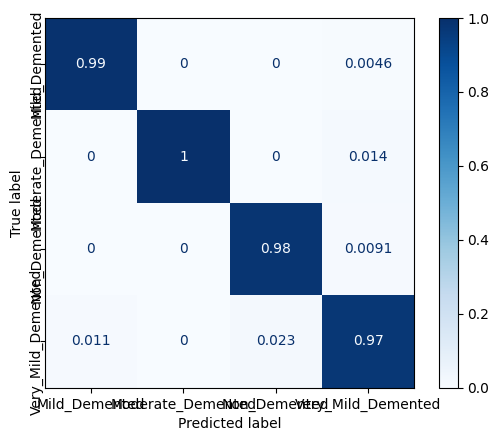

<Figure size 500x500 with 0 Axes>

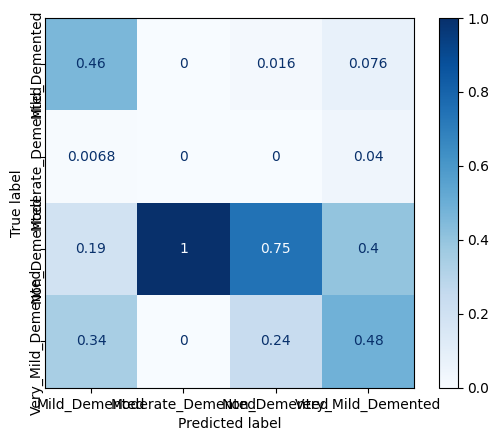

<Figure size 500x500 with 0 Axes>

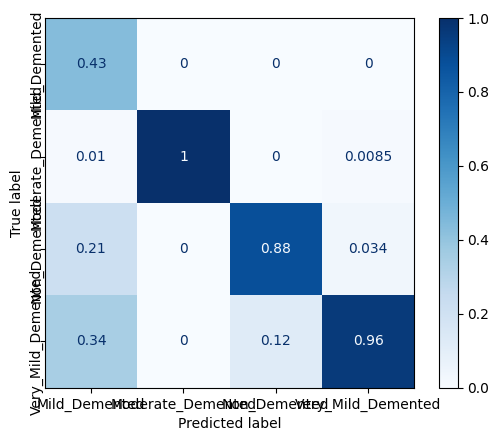

<Figure size 500x500 with 0 Axes>

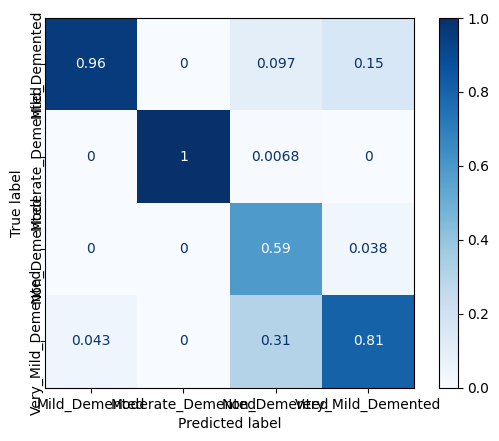

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ALL.zip ./*